In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import optuna
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss
import xgboost as xgb
import seaborn as sns

In [2]:
data = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2021_processed.csv")
data_2022 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2022_processed.csv")
data_2023 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2023_processed.csv")

In [3]:
testing_data = pd.concat([data_2022, data_2023], axis=0)

In [4]:
breaking_ball = data.query('pitch_type_condensed in ("SL", "CB", "CT") & contact == 1')
breaking_ball_testing = testing_data.query('pitch_type_condensed in ("SL", "CB", "CT")')

# Fastball Model First

In [6]:
# Now, separate features and identifiers
training_identifiers = breaking_ball[['pitch_id_raw']].copy()
testing_identifiers = breaking_ball_testing[['pitch_id_raw']].copy()
training_features = breaking_ball.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'strike',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'pitch_id_raw', 'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z', 'height_numeric', 'balls', 'strikes', 'strike',
    'whiff', 'contact', 'foul', 'ground_ball', 'line_drive', 'total_movement'
], axis=1)
testing_features = breaking_ball_testing.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'strike',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'pitch_id_raw', 'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z', 'height_numeric', 'balls', 'strikes', 'strike',
    'whiff', 'contact', 'foul', 'ground_ball', 'total_movement', 'Unnamed: 0', 'line_drive'
], axis=1)   # Exclude the identifier from the features

In [25]:
train_data = training_features.drop(['fly_ball'], axis=1).copy()
train_label = training_features['fly_ball'].copy()
testing_data = testing_features.drop(['fly_ball'], axis=1).copy()
testing_label = testing_features['fly_ball'].copy()

In [26]:
train_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'height_ratio',
       'rolling_avg_velo', 'seasonal_avg_velo', 'swing'],
      dtype='object')

In [27]:
testing_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'height_ratio',
       'rolling_avg_velo', 'seasonal_avg_velo', 'swing'],
      dtype='object')

In [28]:
# First split: Separate out a portion of the data as a temporary test set
x_temp, x_test, y_temp, y_test = train_test_split(
    train_data, 
    train_label, 
    test_size=0.2, 
    random_state=42
)

# Second split: Split the temporary test set into validation and test sets
x_train, x_valid, y_train, y_valid = train_test_split(
    x_temp, 
    y_temp, 
    test_size=0.25,
    random_state=42
)

In [29]:
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)
class_ratio = y_train.value_counts()[0] / y_train.value_counts()[1]
params = {
    'max_depth': 6,
    'eta': 0.1,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': 0.9,
    'colsample_bytree': 1,
    'scale_pos_weight': class_ratio,
}

# Initial Model
model = xgb.train(params, dtrain)

In [30]:
# Generate predictions
y_pred = model.predict(dtest)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test, y_pred)
print(f"Log Loss: {logloss}")

Accuracy: 0.5034490960989534
Log Loss: 0.6679174341861294


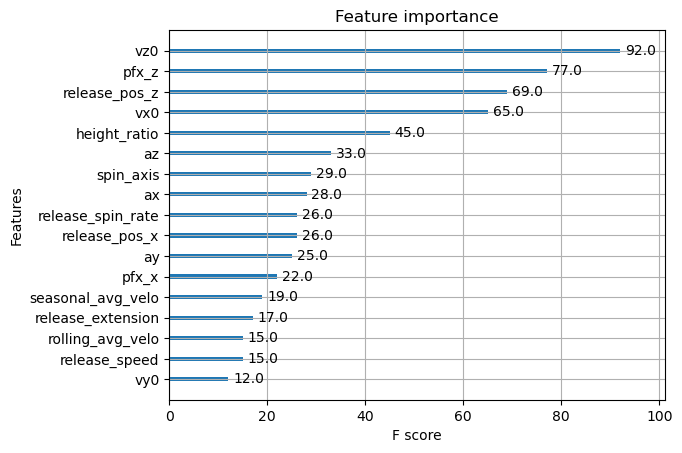

In [31]:
xgb.plot_importance(model)
plt.show()

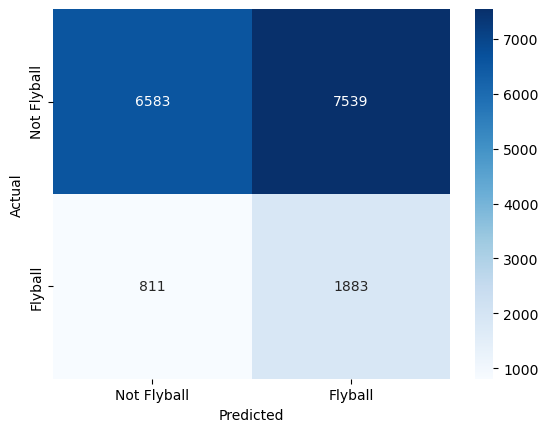

In [32]:
# Convert predicted probabilities to binary predictions
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Flyball', 'Flyball'], yticklabels=['Not Flyball', 'Flyball'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Initial Paramater Tuning

In [33]:
def objective(trial):
    dtrain = xgb.DMatrix(x_train, label=y_train)
    dvalid = xgb.DMatrix(x_valid, label=y_valid)
    
    param = {
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'eta': trial.suggest_float('eta', 0.01, 0.3),
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
        'scale_pos_weight': class_ratio
    }

    # Train the model with early stopping
    model = xgb.train(
        param, 
        dtrain, 
        num_boost_round=100,  # Maximum number of boosting rounds
        evals=[(dvalid, 'eval')],  # Validation set for early stopping
        early_stopping_rounds=50  # Stop if the eval metric doesn't improve for 50 rounds
    )
    
    # Predict on the validation set using the best iteration
    y_valid_pred = model.predict(dvalid)
    
    # Calculate the log loss on the validation set
    loss = log_loss(y_valid, y_valid_pred)

    return loss

In [34]:
#create an optuna study and specifcy the the direction of the optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)

[I 2023-11-14 17:03:42,243] A new study created in memory with name: no-name-eacf4c80-c70f-4d7b-a795-8a80d7445057


[0]	eval-logloss:0.69064
[1]	eval-logloss:0.68683
[2]	eval-logloss:0.68515
[3]	eval-logloss:0.68327
[4]	eval-logloss:0.68033
[5]	eval-logloss:0.67741
[6]	eval-logloss:0.67598
[7]	eval-logloss:0.67311
[8]	eval-logloss:0.67100
[9]	eval-logloss:0.66989
[10]	eval-logloss:0.66758
[11]	eval-logloss:0.66642
[12]	eval-logloss:0.66517
[13]	eval-logloss:0.66326
[14]	eval-logloss:0.66187
[15]	eval-logloss:0.66043
[16]	eval-logloss:0.65890
[17]	eval-logloss:0.65738
[18]	eval-logloss:0.65636
[19]	eval-logloss:0.65566
[20]	eval-logloss:0.65406
[21]	eval-logloss:0.65244
[22]	eval-logloss:0.65153
[23]	eval-logloss:0.65009
[24]	eval-logloss:0.64946
[25]	eval-logloss:0.64850
[26]	eval-logloss:0.64779
[27]	eval-logloss:0.64621
[28]	eval-logloss:0.64506
[29]	eval-logloss:0.64352
[30]	eval-logloss:0.64273
[31]	eval-logloss:0.64160
[32]	eval-logloss:0.64068
[33]	eval-logloss:0.63987
[34]	eval-logloss:0.63932
[35]	eval-logloss:0.63902
[36]	eval-logloss:0.63798
[37]	eval-logloss:0.63700
[38]	eval-logloss:0.63

[I 2023-11-14 17:03:44,541] Trial 0 finished with value: 0.6080724036453351 and parameters: {'max_depth': 9, 'eta': 0.04667213653947898, 'subsample': 0.7803154435882768, 'colsample_bytree': 0.6284603535577599}. Best is trial 0 with value: 0.6080724036453351.


[0]	eval-logloss:0.68840
[1]	eval-logloss:0.68433
[2]	eval-logloss:0.68099
[3]	eval-logloss:0.67911
[4]	eval-logloss:0.67627
[5]	eval-logloss:0.67406
[6]	eval-logloss:0.67193
[7]	eval-logloss:0.66981
[8]	eval-logloss:0.66809
[9]	eval-logloss:0.66656
[10]	eval-logloss:0.66521
[11]	eval-logloss:0.66395
[12]	eval-logloss:0.66264
[13]	eval-logloss:0.66173
[14]	eval-logloss:0.66069
[15]	eval-logloss:0.65963
[16]	eval-logloss:0.65862
[17]	eval-logloss:0.65796
[18]	eval-logloss:0.65700
[19]	eval-logloss:0.65630
[20]	eval-logloss:0.65564
[21]	eval-logloss:0.65480
[22]	eval-logloss:0.65399
[23]	eval-logloss:0.65365
[24]	eval-logloss:0.65315
[25]	eval-logloss:0.65259
[26]	eval-logloss:0.65204
[27]	eval-logloss:0.65148
[28]	eval-logloss:0.65088
[29]	eval-logloss:0.65003
[30]	eval-logloss:0.64971
[31]	eval-logloss:0.64903
[32]	eval-logloss:0.64867
[33]	eval-logloss:0.64769
[34]	eval-logloss:0.64720
[35]	eval-logloss:0.64686
[36]	eval-logloss:0.64643
[37]	eval-logloss:0.64606
[38]	eval-logloss:0.64

[I 2023-11-14 17:03:46,326] Trial 1 finished with value: 0.6232947899380131 and parameters: {'max_depth': 7, 'eta': 0.08753276187337031, 'subsample': 0.8947411930569282, 'colsample_bytree': 0.9566285843429241}. Best is trial 0 with value: 0.6080724036453351.


[0]	eval-logloss:0.68191
[1]	eval-logloss:0.67316
[2]	eval-logloss:0.66891
[3]	eval-logloss:0.66565
[4]	eval-logloss:0.65988
[5]	eval-logloss:0.65466
[6]	eval-logloss:0.65072
[7]	eval-logloss:0.64723
[8]	eval-logloss:0.64353
[9]	eval-logloss:0.64145
[10]	eval-logloss:0.63949
[11]	eval-logloss:0.63723
[12]	eval-logloss:0.63512
[13]	eval-logloss:0.63377
[14]	eval-logloss:0.63227
[15]	eval-logloss:0.63040
[16]	eval-logloss:0.62996
[17]	eval-logloss:0.62745
[18]	eval-logloss:0.62565
[19]	eval-logloss:0.62521
[20]	eval-logloss:0.62431
[21]	eval-logloss:0.62320
[22]	eval-logloss:0.62246
[23]	eval-logloss:0.62158
[24]	eval-logloss:0.62099
[25]	eval-logloss:0.61909
[26]	eval-logloss:0.61784
[27]	eval-logloss:0.61720
[28]	eval-logloss:0.61618
[29]	eval-logloss:0.61455
[30]	eval-logloss:0.61302
[31]	eval-logloss:0.61184
[32]	eval-logloss:0.61099
[33]	eval-logloss:0.61030
[34]	eval-logloss:0.60924
[35]	eval-logloss:0.60800
[36]	eval-logloss:0.60702
[37]	eval-logloss:0.60587
[38]	eval-logloss:0.60

[I 2023-11-14 17:03:48,815] Trial 2 finished with value: 0.5598818655819038 and parameters: {'max_depth': 9, 'eta': 0.14395415211076676, 'subsample': 0.7563274162265408, 'colsample_bytree': 0.9293948248220305}. Best is trial 2 with value: 0.5598818655819038.


[0]	eval-logloss:0.68411
[1]	eval-logloss:0.67767
[2]	eval-logloss:0.67502
[3]	eval-logloss:0.67216
[4]	eval-logloss:0.66741
[5]	eval-logloss:0.66379
[6]	eval-logloss:0.66188
[7]	eval-logloss:0.65819
[8]	eval-logloss:0.65572
[9]	eval-logloss:0.65418
[10]	eval-logloss:0.65220
[11]	eval-logloss:0.65057
[12]	eval-logloss:0.64934
[13]	eval-logloss:0.64746
[14]	eval-logloss:0.64588
[15]	eval-logloss:0.64449
[16]	eval-logloss:0.64399
[17]	eval-logloss:0.64247
[18]	eval-logloss:0.64154
[19]	eval-logloss:0.64145
[20]	eval-logloss:0.63960
[21]	eval-logloss:0.63866
[22]	eval-logloss:0.63821
[23]	eval-logloss:0.63787
[24]	eval-logloss:0.63748
[25]	eval-logloss:0.63518
[26]	eval-logloss:0.63457
[27]	eval-logloss:0.63372
[28]	eval-logloss:0.63319
[29]	eval-logloss:0.63310
[30]	eval-logloss:0.63234
[31]	eval-logloss:0.63145
[32]	eval-logloss:0.63084
[33]	eval-logloss:0.62987
[34]	eval-logloss:0.62918
[35]	eval-logloss:0.62879
[36]	eval-logloss:0.62860
[37]	eval-logloss:0.62782
[38]	eval-logloss:0.62

[I 2023-11-14 17:03:50,499] Trial 3 finished with value: 0.5925174049305467 and parameters: {'max_depth': 8, 'eta': 0.12279247512936606, 'subsample': 0.6540323769010209, 'colsample_bytree': 0.6926535152146449}. Best is trial 2 with value: 0.5598818655819038.


[0]	eval-logloss:0.68157
[1]	eval-logloss:0.67489
[2]	eval-logloss:0.67262
[3]	eval-logloss:0.67107
[4]	eval-logloss:0.66737
[5]	eval-logloss:0.66396
[6]	eval-logloss:0.66291
[7]	eval-logloss:0.66017
[8]	eval-logloss:0.65809
[9]	eval-logloss:0.65795
[10]	eval-logloss:0.65707
[11]	eval-logloss:0.65601
[12]	eval-logloss:0.65462
[13]	eval-logloss:0.65295
[14]	eval-logloss:0.65078
[15]	eval-logloss:0.65016
[16]	eval-logloss:0.65002
[17]	eval-logloss:0.64905
[18]	eval-logloss:0.64886
[19]	eval-logloss:0.64908
[20]	eval-logloss:0.64795
[21]	eval-logloss:0.64709
[22]	eval-logloss:0.64658
[23]	eval-logloss:0.64588
[24]	eval-logloss:0.64615
[25]	eval-logloss:0.64483
[26]	eval-logloss:0.64455
[27]	eval-logloss:0.64402
[28]	eval-logloss:0.64317
[29]	eval-logloss:0.64167
[30]	eval-logloss:0.64074
[31]	eval-logloss:0.63884
[32]	eval-logloss:0.63859
[33]	eval-logloss:0.63856
[34]	eval-logloss:0.63811
[35]	eval-logloss:0.63671
[36]	eval-logloss:0.63706
[37]	eval-logloss:0.63612
[38]	eval-logloss:0.63

[I 2023-11-14 17:03:51,940] Trial 4 finished with value: 0.6014837378449158 and parameters: {'max_depth': 7, 'eta': 0.21448436029785603, 'subsample': 0.6708318976419464, 'colsample_bytree': 0.7271773241753687}. Best is trial 2 with value: 0.5598818655819038.


[0]	eval-logloss:0.69190
[1]	eval-logloss:0.68970
[2]	eval-logloss:0.68855
[3]	eval-logloss:0.68756
[4]	eval-logloss:0.68584
[5]	eval-logloss:0.68433
[6]	eval-logloss:0.68382
[7]	eval-logloss:0.68257
[8]	eval-logloss:0.68145
[9]	eval-logloss:0.68129
[10]	eval-logloss:0.68084
[11]	eval-logloss:0.68043
[12]	eval-logloss:0.67983
[13]	eval-logloss:0.67921
[14]	eval-logloss:0.67867
[15]	eval-logloss:0.67812
[16]	eval-logloss:0.67776
[17]	eval-logloss:0.67738
[18]	eval-logloss:0.67697
[19]	eval-logloss:0.67690
[20]	eval-logloss:0.67647
[21]	eval-logloss:0.67559
[22]	eval-logloss:0.67545
[23]	eval-logloss:0.67483
[24]	eval-logloss:0.67491
[25]	eval-logloss:0.67451
[26]	eval-logloss:0.67446
[27]	eval-logloss:0.67397
[28]	eval-logloss:0.67373
[29]	eval-logloss:0.67320
[30]	eval-logloss:0.67291
[31]	eval-logloss:0.67241
[32]	eval-logloss:0.67248
[33]	eval-logloss:0.67249
[34]	eval-logloss:0.67240
[35]	eval-logloss:0.67207
[36]	eval-logloss:0.67197
[37]	eval-logloss:0.67182
[38]	eval-logloss:0.67

[I 2023-11-14 17:03:52,979] Trial 5 finished with value: 0.6650982057451098 and parameters: {'max_depth': 3, 'eta': 0.11124184674213179, 'subsample': 0.8112933053655753, 'colsample_bytree': 0.6276411049392498}. Best is trial 2 with value: 0.5598818655819038.


[0]	eval-logloss:0.69104
[1]	eval-logloss:0.68933
[2]	eval-logloss:0.68849
[3]	eval-logloss:0.68766
[4]	eval-logloss:0.68609
[5]	eval-logloss:0.68467
[6]	eval-logloss:0.68329
[7]	eval-logloss:0.68200
[8]	eval-logloss:0.68061
[9]	eval-logloss:0.67982
[10]	eval-logloss:0.67888
[11]	eval-logloss:0.67784
[12]	eval-logloss:0.67719
[13]	eval-logloss:0.67652
[14]	eval-logloss:0.67565
[15]	eval-logloss:0.67497
[16]	eval-logloss:0.67442
[17]	eval-logloss:0.67375
[18]	eval-logloss:0.67325
[19]	eval-logloss:0.67281
[20]	eval-logloss:0.67221
[21]	eval-logloss:0.67124
[22]	eval-logloss:0.67074
[23]	eval-logloss:0.67020
[24]	eval-logloss:0.66981
[25]	eval-logloss:0.66937
[26]	eval-logloss:0.66898
[27]	eval-logloss:0.66850
[28]	eval-logloss:0.66820
[29]	eval-logloss:0.66785
[30]	eval-logloss:0.66742
[31]	eval-logloss:0.66693
[32]	eval-logloss:0.66666
[33]	eval-logloss:0.66648
[34]	eval-logloss:0.66636
[35]	eval-logloss:0.66610
[36]	eval-logloss:0.66591
[37]	eval-logloss:0.66563
[38]	eval-logloss:0.66

[I 2023-11-14 17:03:54,291] Trial 6 finished with value: 0.6563922226074417 and parameters: {'max_depth': 5, 'eta': 0.05075425594038024, 'subsample': 0.6121393870818945, 'colsample_bytree': 0.9042738955278604}. Best is trial 2 with value: 0.5598818655819038.


[0]	eval-logloss:0.67921
[1]	eval-logloss:0.67168
[2]	eval-logloss:0.66835
[3]	eval-logloss:0.66675
[4]	eval-logloss:0.66216
[5]	eval-logloss:0.65748
[6]	eval-logloss:0.65568
[7]	eval-logloss:0.65381
[8]	eval-logloss:0.65215
[9]	eval-logloss:0.65185
[10]	eval-logloss:0.65097
[11]	eval-logloss:0.64970
[12]	eval-logloss:0.64847
[13]	eval-logloss:0.64715
[14]	eval-logloss:0.64532
[15]	eval-logloss:0.64502
[16]	eval-logloss:0.64536
[17]	eval-logloss:0.64439
[18]	eval-logloss:0.64310
[19]	eval-logloss:0.64381
[20]	eval-logloss:0.64311
[21]	eval-logloss:0.64093
[22]	eval-logloss:0.64085
[23]	eval-logloss:0.63978
[24]	eval-logloss:0.63958
[25]	eval-logloss:0.63793
[26]	eval-logloss:0.63699
[27]	eval-logloss:0.63646
[28]	eval-logloss:0.63578
[29]	eval-logloss:0.63450
[30]	eval-logloss:0.63350
[31]	eval-logloss:0.63177
[32]	eval-logloss:0.63163
[33]	eval-logloss:0.63160
[34]	eval-logloss:0.63112
[35]	eval-logloss:0.63073
[36]	eval-logloss:0.63025
[37]	eval-logloss:0.62880
[38]	eval-logloss:0.62

[I 2023-11-14 17:03:56,116] Trial 7 finished with value: 0.5967967613066907 and parameters: {'max_depth': 7, 'eta': 0.28430814124267323, 'subsample': 0.7346379016618959, 'colsample_bytree': 0.8189267571714491}. Best is trial 2 with value: 0.5598818655819038.


[0]	eval-logloss:0.68287
[1]	eval-logloss:0.67694
[2]	eval-logloss:0.67388
[3]	eval-logloss:0.67200
[4]	eval-logloss:0.66750
[5]	eval-logloss:0.66426
[6]	eval-logloss:0.66191
[7]	eval-logloss:0.65922
[8]	eval-logloss:0.65722
[9]	eval-logloss:0.65648
[10]	eval-logloss:0.65546
[11]	eval-logloss:0.65438
[12]	eval-logloss:0.65308
[13]	eval-logloss:0.65214
[14]	eval-logloss:0.64992
[15]	eval-logloss:0.64925
[16]	eval-logloss:0.64878
[17]	eval-logloss:0.64760
[18]	eval-logloss:0.64706
[19]	eval-logloss:0.64708
[20]	eval-logloss:0.64671
[21]	eval-logloss:0.64518
[22]	eval-logloss:0.64463
[23]	eval-logloss:0.64433
[24]	eval-logloss:0.64419
[25]	eval-logloss:0.64290
[26]	eval-logloss:0.64159
[27]	eval-logloss:0.64082
[28]	eval-logloss:0.64114
[29]	eval-logloss:0.64083
[30]	eval-logloss:0.63960
[31]	eval-logloss:0.63868
[32]	eval-logloss:0.63779
[33]	eval-logloss:0.63797
[34]	eval-logloss:0.63666
[35]	eval-logloss:0.63627
[36]	eval-logloss:0.63545
[37]	eval-logloss:0.63485
[38]	eval-logloss:0.63

[I 2023-11-14 17:03:58,181] Trial 8 finished with value: 0.6041266324828028 and parameters: {'max_depth': 7, 'eta': 0.17096265596428162, 'subsample': 0.6558973238206942, 'colsample_bytree': 0.9205876350292749}. Best is trial 2 with value: 0.5598818655819038.


[0]	eval-logloss:0.68554
[1]	eval-logloss:0.68089
[2]	eval-logloss:0.67889
[3]	eval-logloss:0.67731
[4]	eval-logloss:0.67362
[5]	eval-logloss:0.67073
[6]	eval-logloss:0.66843
[7]	eval-logloss:0.66656
[8]	eval-logloss:0.66453
[9]	eval-logloss:0.66376
[10]	eval-logloss:0.66269
[11]	eval-logloss:0.66170
[12]	eval-logloss:0.66087
[13]	eval-logloss:0.66014
[14]	eval-logloss:0.65878
[15]	eval-logloss:0.65819
[16]	eval-logloss:0.65876
[17]	eval-logloss:0.65780
[18]	eval-logloss:0.65705
[19]	eval-logloss:0.65685
[20]	eval-logloss:0.65639
[21]	eval-logloss:0.65534
[22]	eval-logloss:0.65536
[23]	eval-logloss:0.65478
[24]	eval-logloss:0.65467
[25]	eval-logloss:0.65352
[26]	eval-logloss:0.65310
[27]	eval-logloss:0.65258
[28]	eval-logloss:0.65190
[29]	eval-logloss:0.65086
[30]	eval-logloss:0.65015
[31]	eval-logloss:0.64883
[32]	eval-logloss:0.64848
[33]	eval-logloss:0.64831
[34]	eval-logloss:0.64799
[35]	eval-logloss:0.64782
[36]	eval-logloss:0.64775
[37]	eval-logloss:0.64772
[38]	eval-logloss:0.64

[I 2023-11-14 17:03:59,536] Trial 9 finished with value: 0.6277803518793896 and parameters: {'max_depth': 6, 'eta': 0.15446986606572427, 'subsample': 0.6985949924332794, 'colsample_bytree': 0.8588789241477113}. Best is trial 2 with value: 0.5598818655819038.


[0]	eval-logloss:0.69178
[1]	eval-logloss:0.69052
[2]	eval-logloss:0.68930
[3]	eval-logloss:0.68863
[4]	eval-logloss:0.68762
[5]	eval-logloss:0.68639
[6]	eval-logloss:0.68529
[7]	eval-logloss:0.68424
[8]	eval-logloss:0.68320
[9]	eval-logloss:0.68216
[10]	eval-logloss:0.68118
[11]	eval-logloss:0.68017
[12]	eval-logloss:0.67925
[13]	eval-logloss:0.67833
[14]	eval-logloss:0.67734
[15]	eval-logloss:0.67645
[16]	eval-logloss:0.67564
[17]	eval-logloss:0.67477
[18]	eval-logloss:0.67392
[19]	eval-logloss:0.67313
[20]	eval-logloss:0.67227
[21]	eval-logloss:0.67143
[22]	eval-logloss:0.67064
[23]	eval-logloss:0.66984
[24]	eval-logloss:0.66914
[25]	eval-logloss:0.66836
[26]	eval-logloss:0.66765
[27]	eval-logloss:0.66697
[28]	eval-logloss:0.66628
[29]	eval-logloss:0.66559
[30]	eval-logloss:0.66494
[31]	eval-logloss:0.66425
[32]	eval-logloss:0.66367
[33]	eval-logloss:0.66295
[34]	eval-logloss:0.66252
[35]	eval-logloss:0.66196
[36]	eval-logloss:0.66141
[37]	eval-logloss:0.66078
[38]	eval-logloss:0.66

[I 2023-11-14 17:04:02,126] Trial 10 finished with value: 0.6374613794484563 and parameters: {'max_depth': 9, 'eta': 0.01413016130809408, 'subsample': 0.740922231595984, 'colsample_bytree': 0.9969483847919585}. Best is trial 2 with value: 0.5598818655819038.


[0]	eval-logloss:0.68679
[1]	eval-logloss:0.67919
[2]	eval-logloss:0.67561
[3]	eval-logloss:0.67155
[4]	eval-logloss:0.66663
[5]	eval-logloss:0.66094
[6]	eval-logloss:0.65949
[7]	eval-logloss:0.65498
[8]	eval-logloss:0.65211
[9]	eval-logloss:0.65130
[10]	eval-logloss:0.64815
[11]	eval-logloss:0.64692
[12]	eval-logloss:0.64567
[13]	eval-logloss:0.64357
[14]	eval-logloss:0.64006
[15]	eval-logloss:0.63690
[16]	eval-logloss:0.63516
[17]	eval-logloss:0.63403
[18]	eval-logloss:0.63380
[19]	eval-logloss:0.63269
[20]	eval-logloss:0.63050
[21]	eval-logloss:0.62884
[22]	eval-logloss:0.62765
[23]	eval-logloss:0.62660
[24]	eval-logloss:0.62656
[25]	eval-logloss:0.62565
[26]	eval-logloss:0.62415
[27]	eval-logloss:0.62337
[28]	eval-logloss:0.62256
[29]	eval-logloss:0.62100
[30]	eval-logloss:0.62012
[31]	eval-logloss:0.61900
[32]	eval-logloss:0.61787
[33]	eval-logloss:0.61685
[34]	eval-logloss:0.61671
[35]	eval-logloss:0.61596
[36]	eval-logloss:0.61440
[37]	eval-logloss:0.61288
[38]	eval-logloss:0.61

[I 2023-11-14 17:04:04,078] Trial 11 finished with value: 0.5784310277101594 and parameters: {'max_depth': 9, 'eta': 0.116899295973764, 'subsample': 0.601560536046847, 'colsample_bytree': 0.5042410062324756}. Best is trial 2 with value: 0.5598818655819038.


[0]	eval-logloss:0.68479
[1]	eval-logloss:0.67330
[2]	eval-logloss:0.66961
[3]	eval-logloss:0.66523
[4]	eval-logloss:0.65898
[5]	eval-logloss:0.65256
[6]	eval-logloss:0.65119
[7]	eval-logloss:0.64584
[8]	eval-logloss:0.64265
[9]	eval-logloss:0.64219
[10]	eval-logloss:0.63856
[11]	eval-logloss:0.63751
[12]	eval-logloss:0.63648
[13]	eval-logloss:0.63482
[14]	eval-logloss:0.63151
[15]	eval-logloss:0.62855
[16]	eval-logloss:0.62873
[17]	eval-logloss:0.62780
[18]	eval-logloss:0.62766
[19]	eval-logloss:0.62621
[20]	eval-logloss:0.62548
[21]	eval-logloss:0.62268
[22]	eval-logloss:0.62193
[23]	eval-logloss:0.62024
[24]	eval-logloss:0.61954
[25]	eval-logloss:0.61861
[26]	eval-logloss:0.61651
[27]	eval-logloss:0.61644
[28]	eval-logloss:0.61572
[29]	eval-logloss:0.61455
[30]	eval-logloss:0.61384
[31]	eval-logloss:0.61153
[32]	eval-logloss:0.61029
[33]	eval-logloss:0.60931
[34]	eval-logloss:0.60824
[35]	eval-logloss:0.60777
[36]	eval-logloss:0.60611
[37]	eval-logloss:0.60488
[38]	eval-logloss:0.60

[I 2023-11-14 17:04:06,468] Trial 12 finished with value: 0.5614608941588138 and parameters: {'max_depth': 9, 'eta': 0.1834280368928418, 'subsample': 0.6026224227555297, 'colsample_bytree': 0.5327189877340309}. Best is trial 2 with value: 0.5598818655819038.


[0]	eval-logloss:0.67945
[1]	eval-logloss:0.67126
[2]	eval-logloss:0.66735
[3]	eval-logloss:0.66507
[4]	eval-logloss:0.66031
[5]	eval-logloss:0.65619
[6]	eval-logloss:0.65354
[7]	eval-logloss:0.65037
[8]	eval-logloss:0.64803
[9]	eval-logloss:0.64734
[10]	eval-logloss:0.64573
[11]	eval-logloss:0.64404
[12]	eval-logloss:0.64048
[13]	eval-logloss:0.63955
[14]	eval-logloss:0.63797
[15]	eval-logloss:0.63723
[16]	eval-logloss:0.63775
[17]	eval-logloss:0.63584
[18]	eval-logloss:0.63488
[19]	eval-logloss:0.63482
[20]	eval-logloss:0.63345
[21]	eval-logloss:0.63247
[22]	eval-logloss:0.63235
[23]	eval-logloss:0.63183
[24]	eval-logloss:0.63141
[25]	eval-logloss:0.62928
[26]	eval-logloss:0.62786
[27]	eval-logloss:0.62697
[28]	eval-logloss:0.62693
[29]	eval-logloss:0.62585
[30]	eval-logloss:0.62519
[31]	eval-logloss:0.62303
[32]	eval-logloss:0.62286
[33]	eval-logloss:0.62132
[34]	eval-logloss:0.62061
[35]	eval-logloss:0.61967
[36]	eval-logloss:0.61964
[37]	eval-logloss:0.61881
[38]	eval-logloss:0.61

[I 2023-11-14 17:04:08,486] Trial 13 finished with value: 0.5795676049469545 and parameters: {'max_depth': 8, 'eta': 0.20565954910609405, 'subsample': 0.7076143591925326, 'colsample_bytree': 0.8067485195253357}. Best is trial 2 with value: 0.5598818655819038.


[0]	eval-logloss:0.69044
[1]	eval-logloss:0.68617
[2]	eval-logloss:0.68508
[3]	eval-logloss:0.68368
[4]	eval-logloss:0.68115
[5]	eval-logloss:0.67857
[6]	eval-logloss:0.67815
[7]	eval-logloss:0.67653
[8]	eval-logloss:0.67520
[9]	eval-logloss:0.67484
[10]	eval-logloss:0.67359
[11]	eval-logloss:0.67284
[12]	eval-logloss:0.67208
[13]	eval-logloss:0.67134
[14]	eval-logloss:0.67058
[15]	eval-logloss:0.66997
[16]	eval-logloss:0.66995
[17]	eval-logloss:0.66967
[18]	eval-logloss:0.66917
[19]	eval-logloss:0.66925
[20]	eval-logloss:0.66858
[21]	eval-logloss:0.66727
[22]	eval-logloss:0.66720
[23]	eval-logloss:0.66686
[24]	eval-logloss:0.66737
[25]	eval-logloss:0.66677
[26]	eval-logloss:0.66652
[27]	eval-logloss:0.66585
[28]	eval-logloss:0.66579
[29]	eval-logloss:0.66503
[30]	eval-logloss:0.66480
[31]	eval-logloss:0.66402
[32]	eval-logloss:0.66404
[33]	eval-logloss:0.66414
[34]	eval-logloss:0.66394
[35]	eval-logloss:0.66336
[36]	eval-logloss:0.66357
[37]	eval-logloss:0.66308
[38]	eval-logloss:0.66

[I 2023-11-14 17:04:09,506] Trial 14 finished with value: 0.6531661230857485 and parameters: {'max_depth': 4, 'eta': 0.1753485681318297, 'subsample': 0.779248043019966, 'colsample_bytree': 0.5012752087353467}. Best is trial 2 with value: 0.5598818655819038.


[0]	eval-logloss:0.67811
[1]	eval-logloss:0.66991
[2]	eval-logloss:0.66642
[3]	eval-logloss:0.66357
[4]	eval-logloss:0.65714
[5]	eval-logloss:0.65214
[6]	eval-logloss:0.64977
[7]	eval-logloss:0.64696
[8]	eval-logloss:0.64460
[9]	eval-logloss:0.64356
[10]	eval-logloss:0.64191
[11]	eval-logloss:0.64120
[12]	eval-logloss:0.64026
[13]	eval-logloss:0.64045
[14]	eval-logloss:0.63850
[15]	eval-logloss:0.63667
[16]	eval-logloss:0.63664
[17]	eval-logloss:0.63644
[18]	eval-logloss:0.63565
[19]	eval-logloss:0.63515
[20]	eval-logloss:0.63440
[21]	eval-logloss:0.63217
[22]	eval-logloss:0.63170
[23]	eval-logloss:0.63039
[24]	eval-logloss:0.62958
[25]	eval-logloss:0.62616
[26]	eval-logloss:0.62560
[27]	eval-logloss:0.62422
[28]	eval-logloss:0.62454
[29]	eval-logloss:0.62426
[30]	eval-logloss:0.62346
[31]	eval-logloss:0.62185
[32]	eval-logloss:0.62135
[33]	eval-logloss:0.62048
[34]	eval-logloss:0.61995
[35]	eval-logloss:0.62003
[36]	eval-logloss:0.61989
[37]	eval-logloss:0.61774
[38]	eval-logloss:0.61

[I 2023-11-14 17:04:11,317] Trial 15 finished with value: 0.5807716850012568 and parameters: {'max_depth': 8, 'eta': 0.23223344740210206, 'subsample': 0.6302727520788375, 'colsample_bytree': 0.8163677405870227}. Best is trial 2 with value: 0.5598818655819038.


[0]	eval-logloss:0.67976
[1]	eval-logloss:0.67087
[2]	eval-logloss:0.66687
[3]	eval-logloss:0.66365
[4]	eval-logloss:0.65756
[5]	eval-logloss:0.65257
[6]	eval-logloss:0.65087
[7]	eval-logloss:0.64669
[8]	eval-logloss:0.64330
[9]	eval-logloss:0.64300
[10]	eval-logloss:0.63997
[11]	eval-logloss:0.63869
[12]	eval-logloss:0.63686
[13]	eval-logloss:0.63490
[14]	eval-logloss:0.63229
[15]	eval-logloss:0.63024
[16]	eval-logloss:0.62987
[17]	eval-logloss:0.62876
[18]	eval-logloss:0.62745
[19]	eval-logloss:0.62721
[20]	eval-logloss:0.62542
[21]	eval-logloss:0.62492
[22]	eval-logloss:0.62456
[23]	eval-logloss:0.62357
[24]	eval-logloss:0.62330
[25]	eval-logloss:0.61978
[26]	eval-logloss:0.61924
[27]	eval-logloss:0.61774
[28]	eval-logloss:0.61739
[29]	eval-logloss:0.61706
[30]	eval-logloss:0.61633
[31]	eval-logloss:0.61491
[32]	eval-logloss:0.61404
[33]	eval-logloss:0.61312
[34]	eval-logloss:0.61250
[35]	eval-logloss:0.61136
[36]	eval-logloss:0.61017
[37]	eval-logloss:0.61005
[38]	eval-logloss:0.60

[I 2023-11-14 17:04:13,512] Trial 16 finished with value: 0.5644305520237861 and parameters: {'max_depth': 9, 'eta': 0.15245160582763018, 'subsample': 0.6900334511835584, 'colsample_bytree': 0.7675221987359855}. Best is trial 2 with value: 0.5598818655819038.


[0]	eval-logloss:0.68222
[1]	eval-logloss:0.67647
[2]	eval-logloss:0.67412
[3]	eval-logloss:0.67208
[4]	eval-logloss:0.66870
[5]	eval-logloss:0.66513
[6]	eval-logloss:0.66293
[7]	eval-logloss:0.66187
[8]	eval-logloss:0.66039
[9]	eval-logloss:0.65973
[10]	eval-logloss:0.65824
[11]	eval-logloss:0.65686
[12]	eval-logloss:0.65507
[13]	eval-logloss:0.65423
[14]	eval-logloss:0.65293
[15]	eval-logloss:0.65231
[16]	eval-logloss:0.65327
[17]	eval-logloss:0.65252
[18]	eval-logloss:0.65172
[19]	eval-logloss:0.65174
[20]	eval-logloss:0.65105
[21]	eval-logloss:0.64924
[22]	eval-logloss:0.64952
[23]	eval-logloss:0.64880
[24]	eval-logloss:0.64855
[25]	eval-logloss:0.64735
[26]	eval-logloss:0.64722
[27]	eval-logloss:0.64656
[28]	eval-logloss:0.64650
[29]	eval-logloss:0.64514
[30]	eval-logloss:0.64468
[31]	eval-logloss:0.64335
[32]	eval-logloss:0.64347
[33]	eval-logloss:0.64347
[34]	eval-logloss:0.64308
[35]	eval-logloss:0.64233
[36]	eval-logloss:0.64239
[37]	eval-logloss:0.64172
[38]	eval-logloss:0.64

[I 2023-11-14 17:04:14,820] Trial 17 finished with value: 0.6167314624788589 and parameters: {'max_depth': 6, 'eta': 0.23465691455093754, 'subsample': 0.7154562757813158, 'colsample_bytree': 0.8888627718634978}. Best is trial 2 with value: 0.5598818655819038.


[0]	eval-logloss:0.68019
[1]	eval-logloss:0.67243
[2]	eval-logloss:0.66656
[3]	eval-logloss:0.66329
[4]	eval-logloss:0.65933
[5]	eval-logloss:0.65496
[6]	eval-logloss:0.65198
[7]	eval-logloss:0.64879
[8]	eval-logloss:0.64602
[9]	eval-logloss:0.64576
[10]	eval-logloss:0.64406
[11]	eval-logloss:0.64310
[12]	eval-logloss:0.64240
[13]	eval-logloss:0.64128
[14]	eval-logloss:0.63945
[15]	eval-logloss:0.63840
[16]	eval-logloss:0.63825
[17]	eval-logloss:0.63722
[18]	eval-logloss:0.63626
[19]	eval-logloss:0.63635
[20]	eval-logloss:0.63515
[21]	eval-logloss:0.63281
[22]	eval-logloss:0.63215
[23]	eval-logloss:0.63182
[24]	eval-logloss:0.63067
[25]	eval-logloss:0.62857
[26]	eval-logloss:0.62795
[27]	eval-logloss:0.62619
[28]	eval-logloss:0.62646
[29]	eval-logloss:0.62632
[30]	eval-logloss:0.62565
[31]	eval-logloss:0.62471
[32]	eval-logloss:0.62377
[33]	eval-logloss:0.62333
[34]	eval-logloss:0.62254
[35]	eval-logloss:0.62249
[36]	eval-logloss:0.62113
[37]	eval-logloss:0.62013
[38]	eval-logloss:0.61

[I 2023-11-14 17:04:16,651] Trial 18 finished with value: 0.584465033153879 and parameters: {'max_depth': 8, 'eta': 0.1880561353732331, 'subsample': 0.6295501582067239, 'colsample_bytree': 0.9969992993188187}. Best is trial 2 with value: 0.5598818655819038.


[0]	eval-logloss:0.69051
[1]	eval-logloss:0.68628
[2]	eval-logloss:0.68512
[3]	eval-logloss:0.68385
[4]	eval-logloss:0.68089
[5]	eval-logloss:0.67788
[6]	eval-logloss:0.67712
[7]	eval-logloss:0.67490
[8]	eval-logloss:0.67309
[9]	eval-logloss:0.67290
[10]	eval-logloss:0.67134
[11]	eval-logloss:0.67084
[12]	eval-logloss:0.67045
[13]	eval-logloss:0.66913
[14]	eval-logloss:0.66781
[15]	eval-logloss:0.66676
[16]	eval-logloss:0.66666
[17]	eval-logloss:0.66627
[18]	eval-logloss:0.66629
[19]	eval-logloss:0.66676
[20]	eval-logloss:0.66561
[21]	eval-logloss:0.66480
[22]	eval-logloss:0.66463
[23]	eval-logloss:0.66418
[24]	eval-logloss:0.66423
[25]	eval-logloss:0.66367
[26]	eval-logloss:0.66345
[27]	eval-logloss:0.66309
[28]	eval-logloss:0.66297
[29]	eval-logloss:0.66205
[30]	eval-logloss:0.66160
[31]	eval-logloss:0.66063
[32]	eval-logloss:0.66035
[33]	eval-logloss:0.66045
[34]	eval-logloss:0.66046
[35]	eval-logloss:0.66021
[36]	eval-logloss:0.66025
[37]	eval-logloss:0.65965
[38]	eval-logloss:0.65

[I 2023-11-14 17:04:17,829] Trial 19 finished with value: 0.6457328711817365 and parameters: {'max_depth': 5, 'eta': 0.14364617455062195, 'subsample': 0.680424604886753, 'colsample_bytree': 0.5564411352128471}. Best is trial 2 with value: 0.5598818655819038.


[0]	eval-logloss:0.67766
[1]	eval-logloss:0.66779
[2]	eval-logloss:0.66394
[3]	eval-logloss:0.66039
[4]	eval-logloss:0.65546
[5]	eval-logloss:0.65065
[6]	eval-logloss:0.64808
[7]	eval-logloss:0.64305
[8]	eval-logloss:0.63957
[9]	eval-logloss:0.63831
[10]	eval-logloss:0.63556
[11]	eval-logloss:0.63430
[12]	eval-logloss:0.63306
[13]	eval-logloss:0.63131
[14]	eval-logloss:0.62866
[15]	eval-logloss:0.62795
[16]	eval-logloss:0.62637
[17]	eval-logloss:0.62472
[18]	eval-logloss:0.62343
[19]	eval-logloss:0.62285
[20]	eval-logloss:0.62117
[21]	eval-logloss:0.61977
[22]	eval-logloss:0.61854
[23]	eval-logloss:0.61775
[24]	eval-logloss:0.61672
[25]	eval-logloss:0.61493
[26]	eval-logloss:0.61351
[27]	eval-logloss:0.61314
[28]	eval-logloss:0.61245
[29]	eval-logloss:0.61031
[30]	eval-logloss:0.60934
[31]	eval-logloss:0.60841
[32]	eval-logloss:0.60704
[33]	eval-logloss:0.60588
[34]	eval-logloss:0.60550
[35]	eval-logloss:0.60528
[36]	eval-logloss:0.60463
[37]	eval-logloss:0.60352
[38]	eval-logloss:0.60

[I 2023-11-14 17:04:20,075] Trial 20 finished with value: 0.5604791856760132 and parameters: {'max_depth': 9, 'eta': 0.19046530360321576, 'subsample': 0.6469230239473137, 'colsample_bytree': 0.6760689801424589}. Best is trial 2 with value: 0.5598818655819038.


[0]	eval-logloss:0.67843
[1]	eval-logloss:0.66814
[2]	eval-logloss:0.66417
[3]	eval-logloss:0.66146
[4]	eval-logloss:0.65616
[5]	eval-logloss:0.65018
[6]	eval-logloss:0.64821
[7]	eval-logloss:0.64419
[8]	eval-logloss:0.64026
[9]	eval-logloss:0.63903
[10]	eval-logloss:0.63675
[11]	eval-logloss:0.63513
[12]	eval-logloss:0.63299
[13]	eval-logloss:0.63257
[14]	eval-logloss:0.63090
[15]	eval-logloss:0.62840
[16]	eval-logloss:0.62744
[17]	eval-logloss:0.62551
[18]	eval-logloss:0.62484
[19]	eval-logloss:0.62470
[20]	eval-logloss:0.62345
[21]	eval-logloss:0.62256
[22]	eval-logloss:0.62252
[23]	eval-logloss:0.62090
[24]	eval-logloss:0.61979
[25]	eval-logloss:0.61708
[26]	eval-logloss:0.61543
[27]	eval-logloss:0.61530
[28]	eval-logloss:0.61468
[29]	eval-logloss:0.61344
[30]	eval-logloss:0.61203
[31]	eval-logloss:0.60980
[32]	eval-logloss:0.60838
[33]	eval-logloss:0.60798
[34]	eval-logloss:0.60749
[35]	eval-logloss:0.60660
[36]	eval-logloss:0.60637
[37]	eval-logloss:0.60558
[38]	eval-logloss:0.60

[I 2023-11-14 17:04:22,268] Trial 21 finished with value: 0.5648742326198082 and parameters: {'max_depth': 9, 'eta': 0.18654453810888746, 'subsample': 0.6032341550761763, 'colsample_bytree': 0.6858236402819435}. Best is trial 2 with value: 0.5598818655819038.


[0]	eval-logloss:0.68745
[1]	eval-logloss:0.68000
[2]	eval-logloss:0.67715
[3]	eval-logloss:0.67420
[4]	eval-logloss:0.66987
[5]	eval-logloss:0.66544
[6]	eval-logloss:0.66340
[7]	eval-logloss:0.65961
[8]	eval-logloss:0.65648
[9]	eval-logloss:0.65557
[10]	eval-logloss:0.65289
[11]	eval-logloss:0.65134
[12]	eval-logloss:0.65022
[13]	eval-logloss:0.64850
[14]	eval-logloss:0.64559
[15]	eval-logloss:0.64467
[16]	eval-logloss:0.64414
[17]	eval-logloss:0.64286
[18]	eval-logloss:0.64181
[19]	eval-logloss:0.64186
[20]	eval-logloss:0.64074
[21]	eval-logloss:0.63894
[22]	eval-logloss:0.63828
[23]	eval-logloss:0.63750
[24]	eval-logloss:0.63717
[25]	eval-logloss:0.63537
[26]	eval-logloss:0.63457
[27]	eval-logloss:0.63387
[28]	eval-logloss:0.63329
[29]	eval-logloss:0.63174
[30]	eval-logloss:0.63113
[31]	eval-logloss:0.62990
[32]	eval-logloss:0.62913
[33]	eval-logloss:0.62861
[34]	eval-logloss:0.62780
[35]	eval-logloss:0.62744
[36]	eval-logloss:0.62640
[37]	eval-logloss:0.62558
[38]	eval-logloss:0.62

[I 2023-11-14 17:04:24,403] Trial 22 finished with value: 0.5913342509695247 and parameters: {'max_depth': 8, 'eta': 0.1390549580620561, 'subsample': 0.6363329808702236, 'colsample_bytree': 0.6098497307402749}. Best is trial 2 with value: 0.5598818655819038.


[0]	eval-logloss:0.68622
[1]	eval-logloss:0.67543
[2]	eval-logloss:0.67166
[3]	eval-logloss:0.66780
[4]	eval-logloss:0.66182
[5]	eval-logloss:0.65578
[6]	eval-logloss:0.65392
[7]	eval-logloss:0.64973
[8]	eval-logloss:0.64720
[9]	eval-logloss:0.64582
[10]	eval-logloss:0.64200
[11]	eval-logloss:0.64096
[12]	eval-logloss:0.63937
[13]	eval-logloss:0.63658
[14]	eval-logloss:0.63335
[15]	eval-logloss:0.63114
[16]	eval-logloss:0.63047
[17]	eval-logloss:0.62928
[18]	eval-logloss:0.62806
[19]	eval-logloss:0.62842
[20]	eval-logloss:0.62645
[21]	eval-logloss:0.62561
[22]	eval-logloss:0.62394
[23]	eval-logloss:0.62316
[24]	eval-logloss:0.62237
[25]	eval-logloss:0.62141
[26]	eval-logloss:0.61980
[27]	eval-logloss:0.61879
[28]	eval-logloss:0.61758
[29]	eval-logloss:0.61635
[30]	eval-logloss:0.61602
[31]	eval-logloss:0.61478
[32]	eval-logloss:0.61382
[33]	eval-logloss:0.61319
[34]	eval-logloss:0.61054
[35]	eval-logloss:0.60989
[36]	eval-logloss:0.60856
[37]	eval-logloss:0.60742
[38]	eval-logloss:0.60

[I 2023-11-14 17:04:26,718] Trial 23 finished with value: 0.5683301340514996 and parameters: {'max_depth': 9, 'eta': 0.16703145434314015, 'subsample': 0.6558603930115365, 'colsample_bytree': 0.5719369625237357}. Best is trial 2 with value: 0.5598818655819038.


[0]	eval-logloss:0.67975
[1]	eval-logloss:0.67127
[2]	eval-logloss:0.66801
[3]	eval-logloss:0.66509
[4]	eval-logloss:0.66190
[5]	eval-logloss:0.65753
[6]	eval-logloss:0.65598
[7]	eval-logloss:0.65315
[8]	eval-logloss:0.64973
[9]	eval-logloss:0.64968
[10]	eval-logloss:0.64785
[11]	eval-logloss:0.64623
[12]	eval-logloss:0.64548
[13]	eval-logloss:0.64521
[14]	eval-logloss:0.64221
[15]	eval-logloss:0.64004
[16]	eval-logloss:0.63893
[17]	eval-logloss:0.63850
[18]	eval-logloss:0.63829
[19]	eval-logloss:0.63906
[20]	eval-logloss:0.63723
[21]	eval-logloss:0.63556
[22]	eval-logloss:0.63573
[23]	eval-logloss:0.63534
[24]	eval-logloss:0.63470
[25]	eval-logloss:0.63331
[26]	eval-logloss:0.63202
[27]	eval-logloss:0.63080
[28]	eval-logloss:0.63097
[29]	eval-logloss:0.62968
[30]	eval-logloss:0.62914
[31]	eval-logloss:0.62783
[32]	eval-logloss:0.62672
[33]	eval-logloss:0.62710
[34]	eval-logloss:0.62637
[35]	eval-logloss:0.62551
[36]	eval-logloss:0.62453
[37]	eval-logloss:0.62334
[38]	eval-logloss:0.62

[I 2023-11-14 17:04:29,547] Trial 24 finished with value: 0.5865573796294028 and parameters: {'max_depth': 8, 'eta': 0.20257782439436076, 'subsample': 0.60011464647812, 'colsample_bytree': 0.6655143970721598}. Best is trial 2 with value: 0.5598818655819038.


[0]	eval-logloss:0.67364
[1]	eval-logloss:0.66320
[2]	eval-logloss:0.65785
[3]	eval-logloss:0.65453
[4]	eval-logloss:0.64927
[5]	eval-logloss:0.64391
[6]	eval-logloss:0.64133
[7]	eval-logloss:0.63756
[8]	eval-logloss:0.63494
[9]	eval-logloss:0.63507
[10]	eval-logloss:0.63306
[11]	eval-logloss:0.63146
[12]	eval-logloss:0.63087
[13]	eval-logloss:0.62926
[14]	eval-logloss:0.62438
[15]	eval-logloss:0.62285
[16]	eval-logloss:0.62334
[17]	eval-logloss:0.62246
[18]	eval-logloss:0.62115
[19]	eval-logloss:0.62151
[20]	eval-logloss:0.61931
[21]	eval-logloss:0.61768
[22]	eval-logloss:0.61797
[23]	eval-logloss:0.61695
[24]	eval-logloss:0.61644
[25]	eval-logloss:0.61266
[26]	eval-logloss:0.61254
[27]	eval-logloss:0.61196
[28]	eval-logloss:0.61291
[29]	eval-logloss:0.61200
[30]	eval-logloss:0.60996
[31]	eval-logloss:0.60829
[32]	eval-logloss:0.60711
[33]	eval-logloss:0.60541
[34]	eval-logloss:0.60403
[35]	eval-logloss:0.60347
[36]	eval-logloss:0.60156
[37]	eval-logloss:0.60023
[38]	eval-logloss:0.59

[I 2023-11-14 17:04:33,348] Trial 25 finished with value: 0.5624515595929178 and parameters: {'max_depth': 9, 'eta': 0.2538690762041708, 'subsample': 0.6312104985332083, 'colsample_bytree': 0.7549232527422266}. Best is trial 2 with value: 0.5598818655819038.


[0]	eval-logloss:0.68141
[1]	eval-logloss:0.67380
[2]	eval-logloss:0.67093
[3]	eval-logloss:0.66880
[4]	eval-logloss:0.66335
[5]	eval-logloss:0.65916
[6]	eval-logloss:0.65736
[7]	eval-logloss:0.65369
[8]	eval-logloss:0.65122
[9]	eval-logloss:0.65049
[10]	eval-logloss:0.64849
[11]	eval-logloss:0.64727
[12]	eval-logloss:0.64506
[13]	eval-logloss:0.64328
[14]	eval-logloss:0.64071
[15]	eval-logloss:0.63905
[16]	eval-logloss:0.63801
[17]	eval-logloss:0.63691
[18]	eval-logloss:0.63625
[19]	eval-logloss:0.63602
[20]	eval-logloss:0.63369
[21]	eval-logloss:0.63265
[22]	eval-logloss:0.63222
[23]	eval-logloss:0.63144
[24]	eval-logloss:0.63185
[25]	eval-logloss:0.62994
[26]	eval-logloss:0.62903
[27]	eval-logloss:0.62805
[28]	eval-logloss:0.62712
[29]	eval-logloss:0.62651
[30]	eval-logloss:0.62431
[31]	eval-logloss:0.62316
[32]	eval-logloss:0.62288
[33]	eval-logloss:0.62298
[34]	eval-logloss:0.62169
[35]	eval-logloss:0.62154
[36]	eval-logloss:0.62101
[37]	eval-logloss:0.61956
[38]	eval-logloss:0.61

[I 2023-11-14 17:04:36,278] Trial 26 finished with value: 0.5800799366437372 and parameters: {'max_depth': 8, 'eta': 0.18140636462900306, 'subsample': 0.6722826435170439, 'colsample_bytree': 0.7017539524323226}. Best is trial 2 with value: 0.5598818655819038.


[0]	eval-logloss:0.68157
[1]	eval-logloss:0.67300
[2]	eval-logloss:0.66929
[3]	eval-logloss:0.66523
[4]	eval-logloss:0.66030
[5]	eval-logloss:0.65570
[6]	eval-logloss:0.65404
[7]	eval-logloss:0.65013
[8]	eval-logloss:0.64745
[9]	eval-logloss:0.64637
[10]	eval-logloss:0.64342
[11]	eval-logloss:0.64178
[12]	eval-logloss:0.63981
[13]	eval-logloss:0.63797
[14]	eval-logloss:0.63525
[15]	eval-logloss:0.63467
[16]	eval-logloss:0.63356
[17]	eval-logloss:0.63199
[18]	eval-logloss:0.63133
[19]	eval-logloss:0.63040
[20]	eval-logloss:0.62914
[21]	eval-logloss:0.62778
[22]	eval-logloss:0.62699
[23]	eval-logloss:0.62563
[24]	eval-logloss:0.62514
[25]	eval-logloss:0.62353
[26]	eval-logloss:0.62273
[27]	eval-logloss:0.62190
[28]	eval-logloss:0.62094
[29]	eval-logloss:0.61861
[30]	eval-logloss:0.61754
[31]	eval-logloss:0.61615
[32]	eval-logloss:0.61465
[33]	eval-logloss:0.61435
[34]	eval-logloss:0.61315
[35]	eval-logloss:0.61137
[36]	eval-logloss:0.61048
[37]	eval-logloss:0.60952
[38]	eval-logloss:0.60

[I 2023-11-14 17:04:39,401] Trial 27 finished with value: 0.5671932913268689 and parameters: {'max_depth': 9, 'eta': 0.13650876774345516, 'subsample': 0.7228363138766515, 'colsample_bytree': 0.6550187230512969}. Best is trial 2 with value: 0.5598818655819038.


[0]	eval-logloss:0.68349
[1]	eval-logloss:0.67752
[2]	eval-logloss:0.67491
[3]	eval-logloss:0.67317
[4]	eval-logloss:0.66986
[5]	eval-logloss:0.66598
[6]	eval-logloss:0.66459
[7]	eval-logloss:0.66195
[8]	eval-logloss:0.65996
[9]	eval-logloss:0.65887
[10]	eval-logloss:0.65759
[11]	eval-logloss:0.65653
[12]	eval-logloss:0.65542
[13]	eval-logloss:0.65425
[14]	eval-logloss:0.65269
[15]	eval-logloss:0.65133
[16]	eval-logloss:0.65099
[17]	eval-logloss:0.64998
[18]	eval-logloss:0.64937
[19]	eval-logloss:0.64935
[20]	eval-logloss:0.64800
[21]	eval-logloss:0.64692
[22]	eval-logloss:0.64697
[23]	eval-logloss:0.64647
[24]	eval-logloss:0.64608
[25]	eval-logloss:0.64457
[26]	eval-logloss:0.64393
[27]	eval-logloss:0.64316
[28]	eval-logloss:0.64254
[29]	eval-logloss:0.64109
[30]	eval-logloss:0.64048
[31]	eval-logloss:0.63908
[32]	eval-logloss:0.63860
[33]	eval-logloss:0.63843
[34]	eval-logloss:0.63814
[35]	eval-logloss:0.63766
[36]	eval-logloss:0.63754
[37]	eval-logloss:0.63580
[38]	eval-logloss:0.63

[I 2023-11-14 17:04:41,891] Trial 28 finished with value: 0.6078836415424678 and parameters: {'max_depth': 7, 'eta': 0.1631128080301386, 'subsample': 0.6935659080932475, 'colsample_bytree': 0.733995356077815}. Best is trial 2 with value: 0.5598818655819038.


[0]	eval-logloss:0.68537
[1]	eval-logloss:0.67287
[2]	eval-logloss:0.66833
[3]	eval-logloss:0.66398
[4]	eval-logloss:0.65816
[5]	eval-logloss:0.65055
[6]	eval-logloss:0.64864
[7]	eval-logloss:0.64467
[8]	eval-logloss:0.64144
[9]	eval-logloss:0.63988
[10]	eval-logloss:0.63718
[11]	eval-logloss:0.63608
[12]	eval-logloss:0.63374
[13]	eval-logloss:0.63158
[14]	eval-logloss:0.62821
[15]	eval-logloss:0.62772
[16]	eval-logloss:0.62694
[17]	eval-logloss:0.62446
[18]	eval-logloss:0.62309
[19]	eval-logloss:0.62359
[20]	eval-logloss:0.62230
[21]	eval-logloss:0.62049
[22]	eval-logloss:0.61916
[23]	eval-logloss:0.61775
[24]	eval-logloss:0.61690
[25]	eval-logloss:0.61467
[26]	eval-logloss:0.61370
[27]	eval-logloss:0.61299
[28]	eval-logloss:0.61112
[29]	eval-logloss:0.60888
[30]	eval-logloss:0.60788
[31]	eval-logloss:0.60629
[32]	eval-logloss:0.60507
[33]	eval-logloss:0.60411
[34]	eval-logloss:0.60359
[35]	eval-logloss:0.60229
[36]	eval-logloss:0.60187
[37]	eval-logloss:0.60059
[38]	eval-logloss:0.60

[I 2023-11-14 17:04:45,183] Trial 29 finished with value: 0.5554808629584047 and parameters: {'max_depth': 9, 'eta': 0.19371142141096578, 'subsample': 0.7498705217063548, 'colsample_bytree': 0.6136592344441204}. Best is trial 29 with value: 0.5554808629584047.


[0]	eval-logloss:0.69139
[1]	eval-logloss:0.68824
[2]	eval-logloss:0.68693
[3]	eval-logloss:0.68556
[4]	eval-logloss:0.68311
[5]	eval-logloss:0.68091
[6]	eval-logloss:0.68037
[7]	eval-logloss:0.67878
[8]	eval-logloss:0.67730
[9]	eval-logloss:0.67692
[10]	eval-logloss:0.67551
[11]	eval-logloss:0.67487
[12]	eval-logloss:0.67415
[13]	eval-logloss:0.67330
[14]	eval-logloss:0.67256
[15]	eval-logloss:0.67210
[16]	eval-logloss:0.67133
[17]	eval-logloss:0.67035
[18]	eval-logloss:0.66999
[19]	eval-logloss:0.67006
[20]	eval-logloss:0.66936
[21]	eval-logloss:0.66836
[22]	eval-logloss:0.66821
[23]	eval-logloss:0.66748
[24]	eval-logloss:0.66722
[25]	eval-logloss:0.66680
[26]	eval-logloss:0.66663
[27]	eval-logloss:0.66601
[28]	eval-logloss:0.66559
[29]	eval-logloss:0.66494
[30]	eval-logloss:0.66461
[31]	eval-logloss:0.66404
[32]	eval-logloss:0.66387
[33]	eval-logloss:0.66354
[34]	eval-logloss:0.66332
[35]	eval-logloss:0.66307
[36]	eval-logloss:0.66287
[37]	eval-logloss:0.66253
[38]	eval-logloss:0.66

[I 2023-11-14 17:04:47,027] Trial 30 finished with value: 0.6514227435929758 and parameters: {'max_depth': 5, 'eta': 0.0925456542532967, 'subsample': 0.763146493086583, 'colsample_bytree': 0.6164176084674768}. Best is trial 29 with value: 0.5554808629584047.


[0]	eval-logloss:0.68474
[1]	eval-logloss:0.67328
[2]	eval-logloss:0.66914
[3]	eval-logloss:0.66523
[4]	eval-logloss:0.65903
[5]	eval-logloss:0.65333
[6]	eval-logloss:0.65111
[7]	eval-logloss:0.64684
[8]	eval-logloss:0.64357
[9]	eval-logloss:0.64172
[10]	eval-logloss:0.63826
[11]	eval-logloss:0.63744
[12]	eval-logloss:0.63591
[13]	eval-logloss:0.63419
[14]	eval-logloss:0.63164
[15]	eval-logloss:0.62940
[16]	eval-logloss:0.62749
[17]	eval-logloss:0.62633
[18]	eval-logloss:0.62491
[19]	eval-logloss:0.62474
[20]	eval-logloss:0.62343
[21]	eval-logloss:0.62253
[22]	eval-logloss:0.62145
[23]	eval-logloss:0.62026
[24]	eval-logloss:0.61884
[25]	eval-logloss:0.61673
[26]	eval-logloss:0.61604
[27]	eval-logloss:0.61492
[28]	eval-logloss:0.61262
[29]	eval-logloss:0.61099
[30]	eval-logloss:0.60950
[31]	eval-logloss:0.60795
[32]	eval-logloss:0.60658
[33]	eval-logloss:0.60594
[34]	eval-logloss:0.60508
[35]	eval-logloss:0.60317
[36]	eval-logloss:0.60267
[37]	eval-logloss:0.60190
[38]	eval-logloss:0.60

[I 2023-11-14 17:04:51,283] Trial 31 finished with value: 0.5586679870291056 and parameters: {'max_depth': 9, 'eta': 0.19254847575890274, 'subsample': 0.7613916520048987, 'colsample_bytree': 0.5858968455172294}. Best is trial 29 with value: 0.5554808629584047.


[0]	eval-logloss:0.68478
[1]	eval-logloss:0.67174
[2]	eval-logloss:0.66738
[3]	eval-logloss:0.66345
[4]	eval-logloss:0.65670
[5]	eval-logloss:0.65128
[6]	eval-logloss:0.64883
[7]	eval-logloss:0.64375
[8]	eval-logloss:0.64015
[9]	eval-logloss:0.63829
[10]	eval-logloss:0.63577
[11]	eval-logloss:0.63472
[12]	eval-logloss:0.63252
[13]	eval-logloss:0.63124
[14]	eval-logloss:0.62870
[15]	eval-logloss:0.62641
[16]	eval-logloss:0.62473
[17]	eval-logloss:0.62344
[18]	eval-logloss:0.62089
[19]	eval-logloss:0.62111
[20]	eval-logloss:0.61942
[21]	eval-logloss:0.61758
[22]	eval-logloss:0.61559
[23]	eval-logloss:0.61499
[24]	eval-logloss:0.61390
[25]	eval-logloss:0.61210
[26]	eval-logloss:0.61098
[27]	eval-logloss:0.60973
[28]	eval-logloss:0.60900
[29]	eval-logloss:0.60649
[30]	eval-logloss:0.60549
[31]	eval-logloss:0.60384
[32]	eval-logloss:0.60256
[33]	eval-logloss:0.60213
[34]	eval-logloss:0.60079
[35]	eval-logloss:0.59958
[36]	eval-logloss:0.59887
[37]	eval-logloss:0.59754
[38]	eval-logloss:0.59

[I 2023-11-14 17:04:55,103] Trial 32 finished with value: 0.550146423720495 and parameters: {'max_depth': 9, 'eta': 0.20865134147330014, 'subsample': 0.805920205883361, 'colsample_bytree': 0.5868210642619748}. Best is trial 32 with value: 0.550146423720495.


[0]	eval-logloss:0.68629
[1]	eval-logloss:0.67587
[2]	eval-logloss:0.67201
[3]	eval-logloss:0.66922
[4]	eval-logloss:0.66413
[5]	eval-logloss:0.65877
[6]	eval-logloss:0.65705
[7]	eval-logloss:0.65295
[8]	eval-logloss:0.65020
[9]	eval-logloss:0.64858
[10]	eval-logloss:0.64662
[11]	eval-logloss:0.64579
[12]	eval-logloss:0.64426
[13]	eval-logloss:0.64294
[14]	eval-logloss:0.64065
[15]	eval-logloss:0.63801
[16]	eval-logloss:0.63709
[17]	eval-logloss:0.63578
[18]	eval-logloss:0.63430
[19]	eval-logloss:0.63414
[20]	eval-logloss:0.63311
[21]	eval-logloss:0.63101
[22]	eval-logloss:0.63048
[23]	eval-logloss:0.63019
[24]	eval-logloss:0.62948
[25]	eval-logloss:0.62734
[26]	eval-logloss:0.62576
[27]	eval-logloss:0.62432
[28]	eval-logloss:0.62403
[29]	eval-logloss:0.62232
[30]	eval-logloss:0.62182
[31]	eval-logloss:0.62087
[32]	eval-logloss:0.62040
[33]	eval-logloss:0.61963
[34]	eval-logloss:0.61877
[35]	eval-logloss:0.61815
[36]	eval-logloss:0.61785
[37]	eval-logloss:0.61745
[38]	eval-logloss:0.61

[I 2023-11-14 17:04:58,198] Trial 33 finished with value: 0.5754314712430646 and parameters: {'max_depth': 8, 'eta': 0.21589683711538835, 'subsample': 0.8037825575788924, 'colsample_bytree': 0.589068496124387}. Best is trial 32 with value: 0.550146423720495.


[0]	eval-logloss:0.67853
[1]	eval-logloss:0.66814
[2]	eval-logloss:0.66352
[3]	eval-logloss:0.65936
[4]	eval-logloss:0.65417
[5]	eval-logloss:0.64876
[6]	eval-logloss:0.64739
[7]	eval-logloss:0.64338
[8]	eval-logloss:0.64033
[9]	eval-logloss:0.63871
[10]	eval-logloss:0.63682
[11]	eval-logloss:0.63504
[12]	eval-logloss:0.63313
[13]	eval-logloss:0.63178
[14]	eval-logloss:0.62952
[15]	eval-logloss:0.62912
[16]	eval-logloss:0.62820
[17]	eval-logloss:0.62650
[18]	eval-logloss:0.62459
[19]	eval-logloss:0.62410
[20]	eval-logloss:0.62188
[21]	eval-logloss:0.62028
[22]	eval-logloss:0.61885
[23]	eval-logloss:0.61736
[24]	eval-logloss:0.61604
[25]	eval-logloss:0.61394
[26]	eval-logloss:0.61174
[27]	eval-logloss:0.61129
[28]	eval-logloss:0.61035
[29]	eval-logloss:0.60902
[30]	eval-logloss:0.60739
[31]	eval-logloss:0.60486
[32]	eval-logloss:0.60299
[33]	eval-logloss:0.60208
[34]	eval-logloss:0.60078
[35]	eval-logloss:0.59970
[36]	eval-logloss:0.59981
[37]	eval-logloss:0.59905
[38]	eval-logloss:0.59

[I 2023-11-14 17:05:00,935] Trial 34 finished with value: 0.5550540025019157 and parameters: {'max_depth': 9, 'eta': 0.19955916483806677, 'subsample': 0.7548325309526033, 'colsample_bytree': 0.6370448335962678}. Best is trial 32 with value: 0.550146423720495.


[0]	eval-logloss:0.68330
[1]	eval-logloss:0.67055
[2]	eval-logloss:0.66553
[3]	eval-logloss:0.66071
[4]	eval-logloss:0.65428
[5]	eval-logloss:0.64727
[6]	eval-logloss:0.64558
[7]	eval-logloss:0.64186
[8]	eval-logloss:0.63836
[9]	eval-logloss:0.63628
[10]	eval-logloss:0.63370
[11]	eval-logloss:0.63256
[12]	eval-logloss:0.63157
[13]	eval-logloss:0.63014
[14]	eval-logloss:0.62664
[15]	eval-logloss:0.62612
[16]	eval-logloss:0.62395
[17]	eval-logloss:0.62244
[18]	eval-logloss:0.62142
[19]	eval-logloss:0.62075
[20]	eval-logloss:0.61901
[21]	eval-logloss:0.61736
[22]	eval-logloss:0.61583
[23]	eval-logloss:0.61459
[24]	eval-logloss:0.61342
[25]	eval-logloss:0.61226
[26]	eval-logloss:0.61027
[27]	eval-logloss:0.60787
[28]	eval-logloss:0.60619
[29]	eval-logloss:0.60316
[30]	eval-logloss:0.60178
[31]	eval-logloss:0.59970
[32]	eval-logloss:0.59918
[33]	eval-logloss:0.59894
[34]	eval-logloss:0.59808
[35]	eval-logloss:0.59653
[36]	eval-logloss:0.59692
[37]	eval-logloss:0.59622
[38]	eval-logloss:0.59

[I 2023-11-14 17:05:03,990] Trial 35 finished with value: 0.5490675770221932 and parameters: {'max_depth': 9, 'eta': 0.22773446871150393, 'subsample': 0.7621505747911851, 'colsample_bytree': 0.5983619442634194}. Best is trial 35 with value: 0.5490675770221932.


[0]	eval-logloss:0.68029
[1]	eval-logloss:0.67126
[2]	eval-logloss:0.66732
[3]	eval-logloss:0.66362
[4]	eval-logloss:0.65908
[5]	eval-logloss:0.65479
[6]	eval-logloss:0.65275
[7]	eval-logloss:0.64994
[8]	eval-logloss:0.64748
[9]	eval-logloss:0.64608
[10]	eval-logloss:0.64538
[11]	eval-logloss:0.64383
[12]	eval-logloss:0.64163
[13]	eval-logloss:0.64043
[14]	eval-logloss:0.63792
[15]	eval-logloss:0.63738
[16]	eval-logloss:0.63667
[17]	eval-logloss:0.63525
[18]	eval-logloss:0.63412
[19]	eval-logloss:0.63416
[20]	eval-logloss:0.63258
[21]	eval-logloss:0.63085
[22]	eval-logloss:0.63020
[23]	eval-logloss:0.62912
[24]	eval-logloss:0.62908
[25]	eval-logloss:0.62770
[26]	eval-logloss:0.62664
[27]	eval-logloss:0.62457
[28]	eval-logloss:0.62362
[29]	eval-logloss:0.62301
[30]	eval-logloss:0.62282
[31]	eval-logloss:0.62123
[32]	eval-logloss:0.61993
[33]	eval-logloss:0.61871
[34]	eval-logloss:0.61809
[35]	eval-logloss:0.61616
[36]	eval-logloss:0.61472
[37]	eval-logloss:0.61378
[38]	eval-logloss:0.61

[I 2023-11-14 17:05:06,960] Trial 36 finished with value: 0.5735876089546624 and parameters: {'max_depth': 8, 'eta': 0.2288752683949365, 'subsample': 0.8035162854939312, 'colsample_bytree': 0.6433987047747763}. Best is trial 35 with value: 0.5490675770221932.


[0]	eval-logloss:0.68626
[1]	eval-logloss:0.67650
[2]	eval-logloss:0.67358
[3]	eval-logloss:0.67013
[4]	eval-logloss:0.66627
[5]	eval-logloss:0.66217
[6]	eval-logloss:0.66090
[7]	eval-logloss:0.65784
[8]	eval-logloss:0.65535
[9]	eval-logloss:0.65402
[10]	eval-logloss:0.65294
[11]	eval-logloss:0.65199
[12]	eval-logloss:0.65130
[13]	eval-logloss:0.65075
[14]	eval-logloss:0.64889
[15]	eval-logloss:0.64726
[16]	eval-logloss:0.64629
[17]	eval-logloss:0.64516
[18]	eval-logloss:0.64444
[19]	eval-logloss:0.64420
[20]	eval-logloss:0.64288
[21]	eval-logloss:0.64195
[22]	eval-logloss:0.64029
[23]	eval-logloss:0.63975
[24]	eval-logloss:0.63912
[25]	eval-logloss:0.63796
[26]	eval-logloss:0.63779
[27]	eval-logloss:0.63632
[28]	eval-logloss:0.63538
[29]	eval-logloss:0.63437
[30]	eval-logloss:0.63393
[31]	eval-logloss:0.63271
[32]	eval-logloss:0.63237
[33]	eval-logloss:0.63230
[34]	eval-logloss:0.63174
[35]	eval-logloss:0.63087
[36]	eval-logloss:0.63033
[37]	eval-logloss:0.62976
[38]	eval-logloss:0.62

[I 2023-11-14 17:05:09,404] Trial 37 finished with value: 0.5950662377432105 and parameters: {'max_depth': 7, 'eta': 0.26183686019569674, 'subsample': 0.8237556944106462, 'colsample_bytree': 0.6282092488042277}. Best is trial 35 with value: 0.5490675770221932.


[0]	eval-logloss:0.68409
[1]	eval-logloss:0.67112
[2]	eval-logloss:0.66676
[3]	eval-logloss:0.66276
[4]	eval-logloss:0.65698
[5]	eval-logloss:0.65079
[6]	eval-logloss:0.64901
[7]	eval-logloss:0.64364
[8]	eval-logloss:0.63989
[9]	eval-logloss:0.63739
[10]	eval-logloss:0.63477
[11]	eval-logloss:0.63339
[12]	eval-logloss:0.63081
[13]	eval-logloss:0.62941
[14]	eval-logloss:0.62682
[15]	eval-logloss:0.62458
[16]	eval-logloss:0.62306
[17]	eval-logloss:0.62170
[18]	eval-logloss:0.61954
[19]	eval-logloss:0.61963
[20]	eval-logloss:0.61832
[21]	eval-logloss:0.61708
[22]	eval-logloss:0.61589
[23]	eval-logloss:0.61438
[24]	eval-logloss:0.61348
[25]	eval-logloss:0.61113
[26]	eval-logloss:0.60990
[27]	eval-logloss:0.60846
[28]	eval-logloss:0.60723
[29]	eval-logloss:0.60538
[30]	eval-logloss:0.60350
[31]	eval-logloss:0.60139
[32]	eval-logloss:0.60002
[33]	eval-logloss:0.59969
[34]	eval-logloss:0.59815
[35]	eval-logloss:0.59672
[36]	eval-logloss:0.59637
[37]	eval-logloss:0.59565
[38]	eval-logloss:0.59

[I 2023-11-14 17:05:12,047] Trial 38 finished with value: 0.5504270529971559 and parameters: {'max_depth': 9, 'eta': 0.21046820897691795, 'subsample': 0.782404163106, 'colsample_bytree': 0.6048481309044071}. Best is trial 35 with value: 0.5490675770221932.


[0]	eval-logloss:0.68644
[1]	eval-logloss:0.67702
[2]	eval-logloss:0.67353
[3]	eval-logloss:0.67012
[4]	eval-logloss:0.66472
[5]	eval-logloss:0.65894
[6]	eval-logloss:0.65781
[7]	eval-logloss:0.65418
[8]	eval-logloss:0.65240
[9]	eval-logloss:0.65055
[10]	eval-logloss:0.64826
[11]	eval-logloss:0.64712
[12]	eval-logloss:0.64438
[13]	eval-logloss:0.64370
[14]	eval-logloss:0.64143
[15]	eval-logloss:0.63976
[16]	eval-logloss:0.63910
[17]	eval-logloss:0.63733
[18]	eval-logloss:0.63604
[19]	eval-logloss:0.63574
[20]	eval-logloss:0.63414
[21]	eval-logloss:0.63178
[22]	eval-logloss:0.63045
[23]	eval-logloss:0.62965
[24]	eval-logloss:0.62976
[25]	eval-logloss:0.62804
[26]	eval-logloss:0.62670
[27]	eval-logloss:0.62472
[28]	eval-logloss:0.62460
[29]	eval-logloss:0.62346
[30]	eval-logloss:0.62208
[31]	eval-logloss:0.62063
[32]	eval-logloss:0.62046
[33]	eval-logloss:0.61877
[34]	eval-logloss:0.61806
[35]	eval-logloss:0.61737
[36]	eval-logloss:0.61677
[37]	eval-logloss:0.61585
[38]	eval-logloss:0.61

[I 2023-11-14 17:05:14,441] Trial 39 finished with value: 0.5771193830554797 and parameters: {'max_depth': 8, 'eta': 0.20998509236435486, 'subsample': 0.7816788879095052, 'colsample_bytree': 0.5530778849053805}. Best is trial 35 with value: 0.5490675770221932.


[0]	eval-logloss:0.68825
[1]	eval-logloss:0.68459
[2]	eval-logloss:0.68259
[3]	eval-logloss:0.68116
[4]	eval-logloss:0.67908
[5]	eval-logloss:0.67761
[6]	eval-logloss:0.67736
[7]	eval-logloss:0.67649
[8]	eval-logloss:0.67443
[9]	eval-logloss:0.67446
[10]	eval-logloss:0.67406
[11]	eval-logloss:0.67339
[12]	eval-logloss:0.67263
[13]	eval-logloss:0.67244
[14]	eval-logloss:0.67168
[15]	eval-logloss:0.67149
[16]	eval-logloss:0.67069
[17]	eval-logloss:0.67039
[18]	eval-logloss:0.67003
[19]	eval-logloss:0.66975
[20]	eval-logloss:0.66946
[21]	eval-logloss:0.66865
[22]	eval-logloss:0.66854
[23]	eval-logloss:0.66861
[24]	eval-logloss:0.66886
[25]	eval-logloss:0.66842
[26]	eval-logloss:0.66846
[27]	eval-logloss:0.66786
[28]	eval-logloss:0.66789
[29]	eval-logloss:0.66691
[30]	eval-logloss:0.66643
[31]	eval-logloss:0.66567
[32]	eval-logloss:0.66589
[33]	eval-logloss:0.66602
[34]	eval-logloss:0.66582
[35]	eval-logloss:0.66541
[36]	eval-logloss:0.66576
[37]	eval-logloss:0.66549
[38]	eval-logloss:0.66

[I 2023-11-14 17:05:16,352] Trial 40 finished with value: 0.6601592206117541 and parameters: {'max_depth': 3, 'eta': 0.2488112826778815, 'subsample': 0.8254949965733708, 'colsample_bytree': 0.6506115142391865}. Best is trial 35 with value: 0.5490675770221932.


[0]	eval-logloss:0.68457
[1]	eval-logloss:0.67157
[2]	eval-logloss:0.66651
[3]	eval-logloss:0.66285
[4]	eval-logloss:0.65645
[5]	eval-logloss:0.64979
[6]	eval-logloss:0.64814
[7]	eval-logloss:0.64331
[8]	eval-logloss:0.63980
[9]	eval-logloss:0.63734
[10]	eval-logloss:0.63404
[11]	eval-logloss:0.63317
[12]	eval-logloss:0.63097
[13]	eval-logloss:0.62954
[14]	eval-logloss:0.62744
[15]	eval-logloss:0.62702
[16]	eval-logloss:0.62529
[17]	eval-logloss:0.62328
[18]	eval-logloss:0.62159
[19]	eval-logloss:0.62139
[20]	eval-logloss:0.61978
[21]	eval-logloss:0.61823
[22]	eval-logloss:0.61607
[23]	eval-logloss:0.61472
[24]	eval-logloss:0.61369
[25]	eval-logloss:0.61228
[26]	eval-logloss:0.61082
[27]	eval-logloss:0.60977
[28]	eval-logloss:0.60821
[29]	eval-logloss:0.60543
[30]	eval-logloss:0.60484
[31]	eval-logloss:0.60334
[32]	eval-logloss:0.60187
[33]	eval-logloss:0.60075
[34]	eval-logloss:0.59958
[35]	eval-logloss:0.59830
[36]	eval-logloss:0.59751
[37]	eval-logloss:0.59675
[38]	eval-logloss:0.59

[I 2023-11-14 17:05:21,331] Trial 41 finished with value: 0.5530365890370551 and parameters: {'max_depth': 9, 'eta': 0.21948270508491505, 'subsample': 0.7487837272628549, 'colsample_bytree': 0.5919657079878694}. Best is trial 35 with value: 0.5490675770221932.


[0]	eval-logloss:0.68295
[1]	eval-logloss:0.66996
[2]	eval-logloss:0.66581
[3]	eval-logloss:0.66229
[4]	eval-logloss:0.65651
[5]	eval-logloss:0.64931
[6]	eval-logloss:0.64790
[7]	eval-logloss:0.64379
[8]	eval-logloss:0.64111
[9]	eval-logloss:0.63930
[10]	eval-logloss:0.63599
[11]	eval-logloss:0.63441
[12]	eval-logloss:0.63298
[13]	eval-logloss:0.63055
[14]	eval-logloss:0.62745
[15]	eval-logloss:0.62730
[16]	eval-logloss:0.62692
[17]	eval-logloss:0.62526
[18]	eval-logloss:0.62361
[19]	eval-logloss:0.62298
[20]	eval-logloss:0.62042
[21]	eval-logloss:0.61738
[22]	eval-logloss:0.61630
[23]	eval-logloss:0.61567
[24]	eval-logloss:0.61499
[25]	eval-logloss:0.61279
[26]	eval-logloss:0.61202
[27]	eval-logloss:0.61096
[28]	eval-logloss:0.61030
[29]	eval-logloss:0.60748
[30]	eval-logloss:0.60506
[31]	eval-logloss:0.60336
[32]	eval-logloss:0.60138
[33]	eval-logloss:0.60131
[34]	eval-logloss:0.59892
[35]	eval-logloss:0.59824
[36]	eval-logloss:0.59808
[37]	eval-logloss:0.59650
[38]	eval-logloss:0.59

[I 2023-11-14 17:05:26,451] Trial 42 finished with value: 0.5531357798561664 and parameters: {'max_depth': 9, 'eta': 0.2191605369063533, 'subsample': 0.7297083901738748, 'colsample_bytree': 0.5937284951497205}. Best is trial 35 with value: 0.5490675770221932.


[0]	eval-logloss:0.68251
[1]	eval-logloss:0.66911
[2]	eval-logloss:0.66399
[3]	eval-logloss:0.66064
[4]	eval-logloss:0.65453
[5]	eval-logloss:0.64709
[6]	eval-logloss:0.64562
[7]	eval-logloss:0.64187
[8]	eval-logloss:0.63946
[9]	eval-logloss:0.63825
[10]	eval-logloss:0.63538
[11]	eval-logloss:0.63442
[12]	eval-logloss:0.63147
[13]	eval-logloss:0.62936
[14]	eval-logloss:0.62609
[15]	eval-logloss:0.62522
[16]	eval-logloss:0.62515
[17]	eval-logloss:0.62304
[18]	eval-logloss:0.62086
[19]	eval-logloss:0.62105
[20]	eval-logloss:0.61965
[21]	eval-logloss:0.61747
[22]	eval-logloss:0.61654
[23]	eval-logloss:0.61504
[24]	eval-logloss:0.61401
[25]	eval-logloss:0.61175
[26]	eval-logloss:0.61086
[27]	eval-logloss:0.60916
[28]	eval-logloss:0.60822
[29]	eval-logloss:0.60480
[30]	eval-logloss:0.60326
[31]	eval-logloss:0.60153
[32]	eval-logloss:0.60043
[33]	eval-logloss:0.60064
[34]	eval-logloss:0.59973
[35]	eval-logloss:0.59854
[36]	eval-logloss:0.59828
[37]	eval-logloss:0.59711
[38]	eval-logloss:0.59

[I 2023-11-14 17:05:31,164] Trial 43 finished with value: 0.5539844784358162 and parameters: {'max_depth': 9, 'eta': 0.21599828475578275, 'subsample': 0.7327971655392901, 'colsample_bytree': 0.5967165744518503}. Best is trial 35 with value: 0.5490675770221932.


[0]	eval-logloss:0.68333
[1]	eval-logloss:0.67082
[2]	eval-logloss:0.66705
[3]	eval-logloss:0.66300
[4]	eval-logloss:0.65737
[5]	eval-logloss:0.64954
[6]	eval-logloss:0.64769
[7]	eval-logloss:0.64285
[8]	eval-logloss:0.64054
[9]	eval-logloss:0.63806
[10]	eval-logloss:0.63535
[11]	eval-logloss:0.63379
[12]	eval-logloss:0.63195
[13]	eval-logloss:0.63014
[14]	eval-logloss:0.62772
[15]	eval-logloss:0.62690
[16]	eval-logloss:0.62627
[17]	eval-logloss:0.62474
[18]	eval-logloss:0.62329
[19]	eval-logloss:0.62171
[20]	eval-logloss:0.62049
[21]	eval-logloss:0.61939
[22]	eval-logloss:0.61733
[23]	eval-logloss:0.61574
[24]	eval-logloss:0.61557
[25]	eval-logloss:0.61364
[26]	eval-logloss:0.61183
[27]	eval-logloss:0.61039
[28]	eval-logloss:0.60973
[29]	eval-logloss:0.60793
[30]	eval-logloss:0.60684
[31]	eval-logloss:0.60496
[32]	eval-logloss:0.60380
[33]	eval-logloss:0.60252
[34]	eval-logloss:0.60150
[35]	eval-logloss:0.59960
[36]	eval-logloss:0.59919
[37]	eval-logloss:0.59799
[38]	eval-logloss:0.59

[I 2023-11-14 17:05:36,085] Trial 44 finished with value: 0.5518567754840369 and parameters: {'max_depth': 9, 'eta': 0.22215270198913636, 'subsample': 0.7764935699622015, 'colsample_bytree': 0.5715675904384706}. Best is trial 35 with value: 0.5490675770221932.


[0]	eval-logloss:0.68569
[1]	eval-logloss:0.67516
[2]	eval-logloss:0.67195
[3]	eval-logloss:0.66806
[4]	eval-logloss:0.66233
[5]	eval-logloss:0.65600
[6]	eval-logloss:0.65507
[7]	eval-logloss:0.65159
[8]	eval-logloss:0.64958
[9]	eval-logloss:0.64792
[10]	eval-logloss:0.64611
[11]	eval-logloss:0.64417
[12]	eval-logloss:0.64232
[13]	eval-logloss:0.64189
[14]	eval-logloss:0.63908
[15]	eval-logloss:0.63846
[16]	eval-logloss:0.63689
[17]	eval-logloss:0.63578
[18]	eval-logloss:0.63402
[19]	eval-logloss:0.63339
[20]	eval-logloss:0.63200
[21]	eval-logloss:0.63044
[22]	eval-logloss:0.62980
[23]	eval-logloss:0.62934
[24]	eval-logloss:0.62952
[25]	eval-logloss:0.62864
[26]	eval-logloss:0.62674
[27]	eval-logloss:0.62524
[28]	eval-logloss:0.62419
[29]	eval-logloss:0.62308
[30]	eval-logloss:0.62271
[31]	eval-logloss:0.62073
[32]	eval-logloss:0.61979
[33]	eval-logloss:0.61851
[34]	eval-logloss:0.61823
[35]	eval-logloss:0.61635
[36]	eval-logloss:0.61608
[37]	eval-logloss:0.61489
[38]	eval-logloss:0.61

[I 2023-11-14 17:05:40,649] Trial 45 finished with value: 0.57255166616402 and parameters: {'max_depth': 8, 'eta': 0.24214350587838235, 'subsample': 0.7835404754356609, 'colsample_bytree': 0.5390880040296901}. Best is trial 35 with value: 0.5490675770221932.


[0]	eval-logloss:0.68181
[1]	eval-logloss:0.66755
[2]	eval-logloss:0.66325
[3]	eval-logloss:0.65863
[4]	eval-logloss:0.65326
[5]	eval-logloss:0.64530
[6]	eval-logloss:0.64263
[7]	eval-logloss:0.63821
[8]	eval-logloss:0.63516
[9]	eval-logloss:0.63430
[10]	eval-logloss:0.63088
[11]	eval-logloss:0.62936
[12]	eval-logloss:0.62862
[13]	eval-logloss:0.62731
[14]	eval-logloss:0.62395
[15]	eval-logloss:0.62286
[16]	eval-logloss:0.62143
[17]	eval-logloss:0.61931
[18]	eval-logloss:0.61766
[19]	eval-logloss:0.61654
[20]	eval-logloss:0.61560
[21]	eval-logloss:0.61351
[22]	eval-logloss:0.61240
[23]	eval-logloss:0.61132
[24]	eval-logloss:0.61044
[25]	eval-logloss:0.60719
[26]	eval-logloss:0.60704
[27]	eval-logloss:0.60538
[28]	eval-logloss:0.60396
[29]	eval-logloss:0.60129
[30]	eval-logloss:0.60050
[31]	eval-logloss:0.59962
[32]	eval-logloss:0.59932
[33]	eval-logloss:0.59892
[34]	eval-logloss:0.59778
[35]	eval-logloss:0.59585
[36]	eval-logloss:0.59377
[37]	eval-logloss:0.59178
[38]	eval-logloss:0.59

[I 2023-11-14 17:05:45,601] Trial 46 finished with value: 0.554741363961262 and parameters: {'max_depth': 9, 'eta': 0.2716113189263254, 'subsample': 0.7741496230052759, 'colsample_bytree': 0.5747778377163371}. Best is trial 35 with value: 0.5490675770221932.


[0]	eval-logloss:0.68367
[1]	eval-logloss:0.67219
[2]	eval-logloss:0.66787
[3]	eval-logloss:0.66339
[4]	eval-logloss:0.65697
[5]	eval-logloss:0.65062
[6]	eval-logloss:0.64862
[7]	eval-logloss:0.64589
[8]	eval-logloss:0.64343
[9]	eval-logloss:0.64140
[10]	eval-logloss:0.63756
[11]	eval-logloss:0.63659
[12]	eval-logloss:0.63536
[13]	eval-logloss:0.63299
[14]	eval-logloss:0.63008
[15]	eval-logloss:0.62972
[16]	eval-logloss:0.62922
[17]	eval-logloss:0.62703
[18]	eval-logloss:0.62563
[19]	eval-logloss:0.62600
[20]	eval-logloss:0.62460
[21]	eval-logloss:0.62329
[22]	eval-logloss:0.62208
[23]	eval-logloss:0.62007
[24]	eval-logloss:0.61961
[25]	eval-logloss:0.61631
[26]	eval-logloss:0.61605
[27]	eval-logloss:0.61482
[28]	eval-logloss:0.61233
[29]	eval-logloss:0.61122
[30]	eval-logloss:0.61042
[31]	eval-logloss:0.60872
[32]	eval-logloss:0.60759
[33]	eval-logloss:0.60713
[34]	eval-logloss:0.60581
[35]	eval-logloss:0.60479
[36]	eval-logloss:0.60462
[37]	eval-logloss:0.60330
[38]	eval-logloss:0.60

[I 2023-11-14 17:05:50,880] Trial 47 finished with value: 0.5552416172577324 and parameters: {'max_depth': 9, 'eta': 0.22946520594111094, 'subsample': 0.7474139659988464, 'colsample_bytree': 0.5284023066987242}. Best is trial 35 with value: 0.5490675770221932.


[0]	eval-logloss:0.68803
[1]	eval-logloss:0.68083
[2]	eval-logloss:0.67895
[3]	eval-logloss:0.67631
[4]	eval-logloss:0.67244
[5]	eval-logloss:0.66822
[6]	eval-logloss:0.66754
[7]	eval-logloss:0.66516
[8]	eval-logloss:0.66382
[9]	eval-logloss:0.66290
[10]	eval-logloss:0.66199
[11]	eval-logloss:0.66095
[12]	eval-logloss:0.66007
[13]	eval-logloss:0.65964
[14]	eval-logloss:0.65832
[15]	eval-logloss:0.65793
[16]	eval-logloss:0.65770
[17]	eval-logloss:0.65734
[18]	eval-logloss:0.65625
[19]	eval-logloss:0.65644
[20]	eval-logloss:0.65555
[21]	eval-logloss:0.65386
[22]	eval-logloss:0.65289
[23]	eval-logloss:0.65276
[24]	eval-logloss:0.65287
[25]	eval-logloss:0.65169
[26]	eval-logloss:0.65123
[27]	eval-logloss:0.65058
[28]	eval-logloss:0.65066
[29]	eval-logloss:0.64984
[30]	eval-logloss:0.64906
[31]	eval-logloss:0.64791
[32]	eval-logloss:0.64763
[33]	eval-logloss:0.64691
[34]	eval-logloss:0.64649
[35]	eval-logloss:0.64572
[36]	eval-logloss:0.64586
[37]	eval-logloss:0.64561
[38]	eval-logloss:0.64

[I 2023-11-14 17:05:54,173] Trial 48 finished with value: 0.620821447385999 and parameters: {'max_depth': 6, 'eta': 0.24393340460768986, 'subsample': 0.7888129561431673, 'colsample_bytree': 0.5610640499025715}. Best is trial 35 with value: 0.5490675770221932.


[0]	eval-logloss:0.68967
[1]	eval-logloss:0.68301
[2]	eval-logloss:0.68112
[3]	eval-logloss:0.67933
[4]	eval-logloss:0.67659
[5]	eval-logloss:0.67364
[6]	eval-logloss:0.67369
[7]	eval-logloss:0.67232
[8]	eval-logloss:0.67077
[9]	eval-logloss:0.67071
[10]	eval-logloss:0.66985
[11]	eval-logloss:0.66914
[12]	eval-logloss:0.66860
[13]	eval-logloss:0.66828
[14]	eval-logloss:0.66759
[15]	eval-logloss:0.66739
[16]	eval-logloss:0.66692
[17]	eval-logloss:0.66669
[18]	eval-logloss:0.66609
[19]	eval-logloss:0.66568
[20]	eval-logloss:0.66570
[21]	eval-logloss:0.66524
[22]	eval-logloss:0.66483
[23]	eval-logloss:0.66469
[24]	eval-logloss:0.66438
[25]	eval-logloss:0.66378
[26]	eval-logloss:0.66362
[27]	eval-logloss:0.66292
[28]	eval-logloss:0.66235
[29]	eval-logloss:0.66143
[30]	eval-logloss:0.66119
[31]	eval-logloss:0.66008
[32]	eval-logloss:0.66017
[33]	eval-logloss:0.65982
[34]	eval-logloss:0.65978
[35]	eval-logloss:0.65918
[36]	eval-logloss:0.65952
[37]	eval-logloss:0.65920
[38]	eval-logloss:0.65

[I 2023-11-14 17:05:57,005] Trial 49 finished with value: 0.6498358490374815 and parameters: {'max_depth': 4, 'eta': 0.2983462150779099, 'subsample': 0.8408347149356172, 'colsample_bytree': 0.5199969615434822}. Best is trial 35 with value: 0.5490675770221932.


[0]	eval-logloss:0.68608
[1]	eval-logloss:0.67522
[2]	eval-logloss:0.67246
[3]	eval-logloss:0.66942
[4]	eval-logloss:0.66420
[5]	eval-logloss:0.65808
[6]	eval-logloss:0.65667
[7]	eval-logloss:0.65351
[8]	eval-logloss:0.65142
[9]	eval-logloss:0.64953
[10]	eval-logloss:0.64739
[11]	eval-logloss:0.64577
[12]	eval-logloss:0.64208
[13]	eval-logloss:0.64051
[14]	eval-logloss:0.63809
[15]	eval-logloss:0.63770
[16]	eval-logloss:0.63722
[17]	eval-logloss:0.63541
[18]	eval-logloss:0.63375
[19]	eval-logloss:0.63323
[20]	eval-logloss:0.63195
[21]	eval-logloss:0.63002
[22]	eval-logloss:0.62907
[23]	eval-logloss:0.62787
[24]	eval-logloss:0.62736
[25]	eval-logloss:0.62593
[26]	eval-logloss:0.62587
[27]	eval-logloss:0.62459
[28]	eval-logloss:0.62315
[29]	eval-logloss:0.62142
[30]	eval-logloss:0.62032
[31]	eval-logloss:0.61940
[32]	eval-logloss:0.61820
[33]	eval-logloss:0.61767
[34]	eval-logloss:0.61632
[35]	eval-logloss:0.61576
[36]	eval-logloss:0.61556
[37]	eval-logloss:0.61461
[38]	eval-logloss:0.61

[I 2023-11-14 17:06:01,377] Trial 50 finished with value: 0.5754335419192047 and parameters: {'max_depth': 8, 'eta': 0.22747307978881712, 'subsample': 0.7667128883086649, 'colsample_bytree': 0.5435126311527569}. Best is trial 35 with value: 0.5490675770221932.


[0]	eval-logloss:0.68255
[1]	eval-logloss:0.66962
[2]	eval-logloss:0.66529
[3]	eval-logloss:0.66091
[4]	eval-logloss:0.65507
[5]	eval-logloss:0.64741
[6]	eval-logloss:0.64570
[7]	eval-logloss:0.64138
[8]	eval-logloss:0.63884
[9]	eval-logloss:0.63714
[10]	eval-logloss:0.63444
[11]	eval-logloss:0.63273
[12]	eval-logloss:0.63060
[13]	eval-logloss:0.62946
[14]	eval-logloss:0.62655
[15]	eval-logloss:0.62603
[16]	eval-logloss:0.62505
[17]	eval-logloss:0.62325
[18]	eval-logloss:0.62200
[19]	eval-logloss:0.62040
[20]	eval-logloss:0.61878
[21]	eval-logloss:0.61817
[22]	eval-logloss:0.61794
[23]	eval-logloss:0.61680
[24]	eval-logloss:0.61550
[25]	eval-logloss:0.61241
[26]	eval-logloss:0.61166
[27]	eval-logloss:0.61044
[28]	eval-logloss:0.60870
[29]	eval-logloss:0.60533
[30]	eval-logloss:0.60363
[31]	eval-logloss:0.60166
[32]	eval-logloss:0.60029
[33]	eval-logloss:0.60074
[34]	eval-logloss:0.59946
[35]	eval-logloss:0.59753
[36]	eval-logloss:0.59758
[37]	eval-logloss:0.59725
[38]	eval-logloss:0.59

[I 2023-11-14 17:06:05,922] Trial 51 finished with value: 0.5537966195250661 and parameters: {'max_depth': 9, 'eta': 0.21871831110340106, 'subsample': 0.738785384964836, 'colsample_bytree': 0.595527323499881}. Best is trial 35 with value: 0.5490675770221932.


[0]	eval-logloss:0.68351
[1]	eval-logloss:0.67188
[2]	eval-logloss:0.66813
[3]	eval-logloss:0.66348
[4]	eval-logloss:0.65754
[5]	eval-logloss:0.65141
[6]	eval-logloss:0.65051
[7]	eval-logloss:0.64517
[8]	eval-logloss:0.64252
[9]	eval-logloss:0.64149
[10]	eval-logloss:0.63841
[11]	eval-logloss:0.63734
[12]	eval-logloss:0.63444
[13]	eval-logloss:0.63300
[14]	eval-logloss:0.62979
[15]	eval-logloss:0.62936
[16]	eval-logloss:0.62907
[17]	eval-logloss:0.62712
[18]	eval-logloss:0.62517
[19]	eval-logloss:0.62420
[20]	eval-logloss:0.62256
[21]	eval-logloss:0.61972
[22]	eval-logloss:0.61915
[23]	eval-logloss:0.61787
[24]	eval-logloss:0.61771
[25]	eval-logloss:0.61662
[26]	eval-logloss:0.61558
[27]	eval-logloss:0.61440
[28]	eval-logloss:0.61264
[29]	eval-logloss:0.61160
[30]	eval-logloss:0.60900
[31]	eval-logloss:0.60669
[32]	eval-logloss:0.60585
[33]	eval-logloss:0.60523
[34]	eval-logloss:0.60423
[35]	eval-logloss:0.60327
[36]	eval-logloss:0.60320
[37]	eval-logloss:0.60209
[38]	eval-logloss:0.59

[I 2023-11-14 17:06:10,070] Trial 52 finished with value: 0.5562111222901487 and parameters: {'max_depth': 9, 'eta': 0.22080987272487768, 'subsample': 0.7268624311706081, 'colsample_bytree': 0.5750947377801959}. Best is trial 35 with value: 0.5490675770221932.


[0]	eval-logloss:0.68410
[1]	eval-logloss:0.67162
[2]	eval-logloss:0.66788
[3]	eval-logloss:0.66370
[4]	eval-logloss:0.65853
[5]	eval-logloss:0.65130
[6]	eval-logloss:0.64873
[7]	eval-logloss:0.64415
[8]	eval-logloss:0.64152
[9]	eval-logloss:0.63981
[10]	eval-logloss:0.63688
[11]	eval-logloss:0.63599
[12]	eval-logloss:0.63366
[13]	eval-logloss:0.63184
[14]	eval-logloss:0.62860
[15]	eval-logloss:0.62744
[16]	eval-logloss:0.62696
[17]	eval-logloss:0.62537
[18]	eval-logloss:0.62416
[19]	eval-logloss:0.62403
[20]	eval-logloss:0.62272
[21]	eval-logloss:0.62039
[22]	eval-logloss:0.61927
[23]	eval-logloss:0.61722
[24]	eval-logloss:0.61632
[25]	eval-logloss:0.61361
[26]	eval-logloss:0.61284
[27]	eval-logloss:0.61227
[28]	eval-logloss:0.61067
[29]	eval-logloss:0.60852
[30]	eval-logloss:0.60621
[31]	eval-logloss:0.60420
[32]	eval-logloss:0.60320
[33]	eval-logloss:0.60321
[34]	eval-logloss:0.60257
[35]	eval-logloss:0.60186
[36]	eval-logloss:0.60120
[37]	eval-logloss:0.60076
[38]	eval-logloss:0.60

[I 2023-11-14 17:06:14,507] Trial 53 finished with value: 0.5545881275863191 and parameters: {'max_depth': 9, 'eta': 0.20523002604088833, 'subsample': 0.746306345091861, 'colsample_bytree': 0.6108219056836001}. Best is trial 35 with value: 0.5490675770221932.


[0]	eval-logloss:0.68644
[1]	eval-logloss:0.67783
[2]	eval-logloss:0.67496
[3]	eval-logloss:0.67176
[4]	eval-logloss:0.66707
[5]	eval-logloss:0.66286
[6]	eval-logloss:0.66173
[7]	eval-logloss:0.65935
[8]	eval-logloss:0.65797
[9]	eval-logloss:0.65753
[10]	eval-logloss:0.65595
[11]	eval-logloss:0.65480
[12]	eval-logloss:0.65325
[13]	eval-logloss:0.65210
[14]	eval-logloss:0.64964
[15]	eval-logloss:0.64899
[16]	eval-logloss:0.64887
[17]	eval-logloss:0.64759
[18]	eval-logloss:0.64653
[19]	eval-logloss:0.64669
[20]	eval-logloss:0.64496
[21]	eval-logloss:0.64316
[22]	eval-logloss:0.64333
[23]	eval-logloss:0.64253
[24]	eval-logloss:0.64256
[25]	eval-logloss:0.64133
[26]	eval-logloss:0.64103
[27]	eval-logloss:0.64060
[28]	eval-logloss:0.64036
[29]	eval-logloss:0.63826
[30]	eval-logloss:0.63759
[31]	eval-logloss:0.63597
[32]	eval-logloss:0.63568
[33]	eval-logloss:0.63529
[34]	eval-logloss:0.63520
[35]	eval-logloss:0.63503
[36]	eval-logloss:0.63501
[37]	eval-logloss:0.63440
[38]	eval-logloss:0.63

[I 2023-11-14 17:06:17,905] Trial 54 finished with value: 0.6026576222866585 and parameters: {'max_depth': 7, 'eta': 0.23759286419936765, 'subsample': 0.713641642809122, 'colsample_bytree': 0.519227284223432}. Best is trial 35 with value: 0.5490675770221932.


[0]	eval-logloss:0.68493
[1]	eval-logloss:0.67257
[2]	eval-logloss:0.66769
[3]	eval-logloss:0.66427
[4]	eval-logloss:0.65761
[5]	eval-logloss:0.64983
[6]	eval-logloss:0.64832
[7]	eval-logloss:0.64332
[8]	eval-logloss:0.63962
[9]	eval-logloss:0.63707
[10]	eval-logloss:0.63500
[11]	eval-logloss:0.63360
[12]	eval-logloss:0.63185
[13]	eval-logloss:0.63080
[14]	eval-logloss:0.62715
[15]	eval-logloss:0.62526
[16]	eval-logloss:0.62372
[17]	eval-logloss:0.62168
[18]	eval-logloss:0.62043
[19]	eval-logloss:0.62006
[20]	eval-logloss:0.61925
[21]	eval-logloss:0.61766
[22]	eval-logloss:0.61614
[23]	eval-logloss:0.61518
[24]	eval-logloss:0.61518
[25]	eval-logloss:0.61258
[26]	eval-logloss:0.60991
[27]	eval-logloss:0.60794
[28]	eval-logloss:0.60735
[29]	eval-logloss:0.60579
[30]	eval-logloss:0.60420
[31]	eval-logloss:0.60274
[32]	eval-logloss:0.60245
[33]	eval-logloss:0.60152
[34]	eval-logloss:0.60046
[35]	eval-logloss:0.59886
[36]	eval-logloss:0.59789
[37]	eval-logloss:0.59662
[38]	eval-logloss:0.59

[I 2023-11-14 17:06:22,181] Trial 55 finished with value: 0.5469399397028005 and parameters: {'max_depth': 9, 'eta': 0.20676871842605202, 'subsample': 0.791391271754522, 'colsample_bytree': 0.6304818141666859}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.68645
[1]	eval-logloss:0.67621
[2]	eval-logloss:0.67248
[3]	eval-logloss:0.66858
[4]	eval-logloss:0.66361
[5]	eval-logloss:0.65864
[6]	eval-logloss:0.65700
[7]	eval-logloss:0.65319
[8]	eval-logloss:0.65013
[9]	eval-logloss:0.64894
[10]	eval-logloss:0.64745
[11]	eval-logloss:0.64625
[12]	eval-logloss:0.64446
[13]	eval-logloss:0.64379
[14]	eval-logloss:0.64159
[15]	eval-logloss:0.64005
[16]	eval-logloss:0.63915
[17]	eval-logloss:0.63791
[18]	eval-logloss:0.63622
[19]	eval-logloss:0.63592
[20]	eval-logloss:0.63442
[21]	eval-logloss:0.63272
[22]	eval-logloss:0.63141
[23]	eval-logloss:0.63007
[24]	eval-logloss:0.62981
[25]	eval-logloss:0.62776
[26]	eval-logloss:0.62649
[27]	eval-logloss:0.62471
[28]	eval-logloss:0.62398
[29]	eval-logloss:0.62282
[30]	eval-logloss:0.62155
[31]	eval-logloss:0.62025
[32]	eval-logloss:0.61914
[33]	eval-logloss:0.61830
[34]	eval-logloss:0.61714
[35]	eval-logloss:0.61594
[36]	eval-logloss:0.61554
[37]	eval-logloss:0.61413
[38]	eval-logloss:0.61

[I 2023-11-14 17:06:25,996] Trial 56 finished with value: 0.5742946474086228 and parameters: {'max_depth': 8, 'eta': 0.20529792958663953, 'subsample': 0.7928552357592635, 'colsample_bytree': 0.6282709262532971}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.68327
[1]	eval-logloss:0.67046
[2]	eval-logloss:0.66636
[3]	eval-logloss:0.66219
[4]	eval-logloss:0.65608
[5]	eval-logloss:0.64820
[6]	eval-logloss:0.64574
[7]	eval-logloss:0.64054
[8]	eval-logloss:0.63843
[9]	eval-logloss:0.63647
[10]	eval-logloss:0.63309
[11]	eval-logloss:0.63127
[12]	eval-logloss:0.62997
[13]	eval-logloss:0.62828
[14]	eval-logloss:0.62489
[15]	eval-logloss:0.62400
[16]	eval-logloss:0.62316
[17]	eval-logloss:0.62103
[18]	eval-logloss:0.61881
[19]	eval-logloss:0.61874
[20]	eval-logloss:0.61780
[21]	eval-logloss:0.61668
[22]	eval-logloss:0.61409
[23]	eval-logloss:0.61184
[24]	eval-logloss:0.61092
[25]	eval-logloss:0.60875
[26]	eval-logloss:0.60644
[27]	eval-logloss:0.60550
[28]	eval-logloss:0.60487
[29]	eval-logloss:0.60340
[30]	eval-logloss:0.60218
[31]	eval-logloss:0.60006
[32]	eval-logloss:0.59874
[33]	eval-logloss:0.59837
[34]	eval-logloss:0.59761
[35]	eval-logloss:0.59605
[36]	eval-logloss:0.59590
[37]	eval-logloss:0.59494
[38]	eval-logloss:0.59

[I 2023-11-14 17:06:30,162] Trial 57 finished with value: 0.551079042758032 and parameters: {'max_depth': 9, 'eta': 0.25671720240856144, 'subsample': 0.7702533073518714, 'colsample_bytree': 0.5597709014767768}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.68459
[1]	eval-logloss:0.67317
[2]	eval-logloss:0.66996
[3]	eval-logloss:0.66608
[4]	eval-logloss:0.66083
[5]	eval-logloss:0.65521
[6]	eval-logloss:0.65363
[7]	eval-logloss:0.65061
[8]	eval-logloss:0.64864
[9]	eval-logloss:0.64701
[10]	eval-logloss:0.64446
[11]	eval-logloss:0.64298
[12]	eval-logloss:0.64116
[13]	eval-logloss:0.63934
[14]	eval-logloss:0.63677
[15]	eval-logloss:0.63571
[16]	eval-logloss:0.63553
[17]	eval-logloss:0.63415
[18]	eval-logloss:0.63173
[19]	eval-logloss:0.63142
[20]	eval-logloss:0.62978
[21]	eval-logloss:0.62770
[22]	eval-logloss:0.62660
[23]	eval-logloss:0.62610
[24]	eval-logloss:0.62553
[25]	eval-logloss:0.62373
[26]	eval-logloss:0.62249
[27]	eval-logloss:0.62123
[28]	eval-logloss:0.61959
[29]	eval-logloss:0.61775
[30]	eval-logloss:0.61734
[31]	eval-logloss:0.61560
[32]	eval-logloss:0.61476
[33]	eval-logloss:0.61318
[34]	eval-logloss:0.61213
[35]	eval-logloss:0.61127
[36]	eval-logloss:0.61074
[37]	eval-logloss:0.60999
[38]	eval-logloss:0.60

[I 2023-11-14 17:06:33,987] Trial 58 finished with value: 0.5678548269678332 and parameters: {'max_depth': 8, 'eta': 0.25639933433458656, 'subsample': 0.7747212841665408, 'colsample_bytree': 0.5596270076512997}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.68401
[1]	eval-logloss:0.67092
[2]	eval-logloss:0.66655
[3]	eval-logloss:0.66152
[4]	eval-logloss:0.65534
[5]	eval-logloss:0.64808
[6]	eval-logloss:0.64598
[7]	eval-logloss:0.64134
[8]	eval-logloss:0.63844
[9]	eval-logloss:0.63730
[10]	eval-logloss:0.63521
[11]	eval-logloss:0.63397
[12]	eval-logloss:0.63217
[13]	eval-logloss:0.63144
[14]	eval-logloss:0.62762
[15]	eval-logloss:0.62665
[16]	eval-logloss:0.62423
[17]	eval-logloss:0.62223
[18]	eval-logloss:0.62011
[19]	eval-logloss:0.61970
[20]	eval-logloss:0.61830
[21]	eval-logloss:0.61559
[22]	eval-logloss:0.61509
[23]	eval-logloss:0.61475
[24]	eval-logloss:0.61447
[25]	eval-logloss:0.61201
[26]	eval-logloss:0.60999
[27]	eval-logloss:0.60821
[28]	eval-logloss:0.60658
[29]	eval-logloss:0.60520
[30]	eval-logloss:0.60397
[31]	eval-logloss:0.60288
[32]	eval-logloss:0.60104
[33]	eval-logloss:0.59976
[34]	eval-logloss:0.59888
[35]	eval-logloss:0.59734
[36]	eval-logloss:0.59715
[37]	eval-logloss:0.59596
[38]	eval-logloss:0.59

[I 2023-11-14 17:06:38,366] Trial 59 finished with value: 0.5500633105008587 and parameters: {'max_depth': 9, 'eta': 0.2405551795940399, 'subsample': 0.7945466503315122, 'colsample_bytree': 0.5723507840497186}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.68352
[1]	eval-logloss:0.66999
[2]	eval-logloss:0.66642
[3]	eval-logloss:0.66092
[4]	eval-logloss:0.65403
[5]	eval-logloss:0.64821
[6]	eval-logloss:0.64648
[7]	eval-logloss:0.64175
[8]	eval-logloss:0.63842
[9]	eval-logloss:0.63589
[10]	eval-logloss:0.63453
[11]	eval-logloss:0.63357
[12]	eval-logloss:0.63158
[13]	eval-logloss:0.63071
[14]	eval-logloss:0.62855
[15]	eval-logloss:0.62797
[16]	eval-logloss:0.62652
[17]	eval-logloss:0.62408
[18]	eval-logloss:0.62125
[19]	eval-logloss:0.62112
[20]	eval-logloss:0.61901
[21]	eval-logloss:0.61749
[22]	eval-logloss:0.61666
[23]	eval-logloss:0.61612
[24]	eval-logloss:0.61620
[25]	eval-logloss:0.61457
[26]	eval-logloss:0.61412
[27]	eval-logloss:0.61219
[28]	eval-logloss:0.61034
[29]	eval-logloss:0.60803
[30]	eval-logloss:0.60679
[31]	eval-logloss:0.60496
[32]	eval-logloss:0.60394
[33]	eval-logloss:0.60360
[34]	eval-logloss:0.60099
[35]	eval-logloss:0.59966
[36]	eval-logloss:0.59801
[37]	eval-logloss:0.59699
[38]	eval-logloss:0.59

[I 2023-11-14 17:06:42,552] Trial 60 finished with value: 0.5544730527627311 and parameters: {'max_depth': 9, 'eta': 0.265211024103716, 'subsample': 0.7934530404626411, 'colsample_bytree': 0.5458786868243741}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.68381
[1]	eval-logloss:0.67030
[2]	eval-logloss:0.66567
[3]	eval-logloss:0.66125
[4]	eval-logloss:0.65535
[5]	eval-logloss:0.64835
[6]	eval-logloss:0.64593
[7]	eval-logloss:0.64121
[8]	eval-logloss:0.63845
[9]	eval-logloss:0.63680
[10]	eval-logloss:0.63393
[11]	eval-logloss:0.63174
[12]	eval-logloss:0.63119
[13]	eval-logloss:0.62990
[14]	eval-logloss:0.62712
[15]	eval-logloss:0.62683
[16]	eval-logloss:0.62550
[17]	eval-logloss:0.62109
[18]	eval-logloss:0.61923
[19]	eval-logloss:0.61852
[20]	eval-logloss:0.61804
[21]	eval-logloss:0.61590
[22]	eval-logloss:0.61434
[23]	eval-logloss:0.61358
[24]	eval-logloss:0.61253
[25]	eval-logloss:0.61108
[26]	eval-logloss:0.60898
[27]	eval-logloss:0.60783
[28]	eval-logloss:0.60650
[29]	eval-logloss:0.60282
[30]	eval-logloss:0.60191
[31]	eval-logloss:0.59970
[32]	eval-logloss:0.59859
[33]	eval-logloss:0.59775
[34]	eval-logloss:0.59763
[35]	eval-logloss:0.59660
[36]	eval-logloss:0.59618
[37]	eval-logloss:0.59479
[38]	eval-logloss:0.59

[I 2023-11-14 17:06:46,888] Trial 61 finished with value: 0.550325290080586 and parameters: {'max_depth': 9, 'eta': 0.24380885367265495, 'subsample': 0.7696969209668715, 'colsample_bytree': 0.5728894016447273}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.68272
[1]	eval-logloss:0.66947
[2]	eval-logloss:0.66463
[3]	eval-logloss:0.66095
[4]	eval-logloss:0.65440
[5]	eval-logloss:0.64766
[6]	eval-logloss:0.64585
[7]	eval-logloss:0.64048
[8]	eval-logloss:0.63786
[9]	eval-logloss:0.63620
[10]	eval-logloss:0.63367
[11]	eval-logloss:0.63154
[12]	eval-logloss:0.63037
[13]	eval-logloss:0.62812
[14]	eval-logloss:0.62535
[15]	eval-logloss:0.62536
[16]	eval-logloss:0.62476
[17]	eval-logloss:0.62294
[18]	eval-logloss:0.62104
[19]	eval-logloss:0.62083
[20]	eval-logloss:0.61988
[21]	eval-logloss:0.61772
[22]	eval-logloss:0.61525
[23]	eval-logloss:0.61433
[24]	eval-logloss:0.61362
[25]	eval-logloss:0.61121
[26]	eval-logloss:0.61015
[27]	eval-logloss:0.60903
[28]	eval-logloss:0.60833
[29]	eval-logloss:0.60573
[30]	eval-logloss:0.60481
[31]	eval-logloss:0.60344
[32]	eval-logloss:0.60273
[33]	eval-logloss:0.60078
[34]	eval-logloss:0.59874
[35]	eval-logloss:0.59800
[36]	eval-logloss:0.59843
[37]	eval-logloss:0.59782
[38]	eval-logloss:0.59

[I 2023-11-14 17:06:51,225] Trial 62 finished with value: 0.5519213152017547 and parameters: {'max_depth': 9, 'eta': 0.2390706195079774, 'subsample': 0.7698188090193454, 'colsample_bytree': 0.6076325948951417}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.68284
[1]	eval-logloss:0.66921
[2]	eval-logloss:0.66475
[3]	eval-logloss:0.66026
[4]	eval-logloss:0.65394
[5]	eval-logloss:0.64780
[6]	eval-logloss:0.64515
[7]	eval-logloss:0.64098
[8]	eval-logloss:0.63754
[9]	eval-logloss:0.63469
[10]	eval-logloss:0.63168
[11]	eval-logloss:0.63037
[12]	eval-logloss:0.62874
[13]	eval-logloss:0.62782
[14]	eval-logloss:0.62365
[15]	eval-logloss:0.62124
[16]	eval-logloss:0.62048
[17]	eval-logloss:0.61855
[18]	eval-logloss:0.61654
[19]	eval-logloss:0.61666
[20]	eval-logloss:0.61466
[21]	eval-logloss:0.61354
[22]	eval-logloss:0.61293
[23]	eval-logloss:0.61088
[24]	eval-logloss:0.61002
[25]	eval-logloss:0.60788
[26]	eval-logloss:0.60762
[27]	eval-logloss:0.60657
[28]	eval-logloss:0.60547
[29]	eval-logloss:0.60275
[30]	eval-logloss:0.60083
[31]	eval-logloss:0.59962
[32]	eval-logloss:0.59860
[33]	eval-logloss:0.59773
[34]	eval-logloss:0.59701
[35]	eval-logloss:0.59621
[36]	eval-logloss:0.59561
[37]	eval-logloss:0.59452
[38]	eval-logloss:0.59

[I 2023-11-14 17:06:55,466] Trial 63 finished with value: 0.552034063211733 and parameters: {'max_depth': 9, 'eta': 0.24571435738639244, 'subsample': 0.7616392236679406, 'colsample_bytree': 0.6280869441054222}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.68531
[1]	eval-logloss:0.67398
[2]	eval-logloss:0.67117
[3]	eval-logloss:0.66715
[4]	eval-logloss:0.66178
[5]	eval-logloss:0.65615
[6]	eval-logloss:0.65456
[7]	eval-logloss:0.65065
[8]	eval-logloss:0.64893
[9]	eval-logloss:0.64793
[10]	eval-logloss:0.64627
[11]	eval-logloss:0.64561
[12]	eval-logloss:0.64342
[13]	eval-logloss:0.64266
[14]	eval-logloss:0.63943
[15]	eval-logloss:0.63920
[16]	eval-logloss:0.63872
[17]	eval-logloss:0.63760
[18]	eval-logloss:0.63626
[19]	eval-logloss:0.63589
[20]	eval-logloss:0.63494
[21]	eval-logloss:0.63283
[22]	eval-logloss:0.63270
[23]	eval-logloss:0.63217
[24]	eval-logloss:0.63258
[25]	eval-logloss:0.62991
[26]	eval-logloss:0.62830
[27]	eval-logloss:0.62712
[28]	eval-logloss:0.62562
[29]	eval-logloss:0.62430
[30]	eval-logloss:0.62334
[31]	eval-logloss:0.62258
[32]	eval-logloss:0.62171
[33]	eval-logloss:0.62059
[34]	eval-logloss:0.61934
[35]	eval-logloss:0.61790
[36]	eval-logloss:0.61760
[37]	eval-logloss:0.61672
[38]	eval-logloss:0.61

[I 2023-11-14 17:06:59,193] Trial 64 finished with value: 0.5759168628387354 and parameters: {'max_depth': 8, 'eta': 0.2520004176396987, 'subsample': 0.7980895782516574, 'colsample_bytree': 0.5641923382570845}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.68414
[1]	eval-logloss:0.67199
[2]	eval-logloss:0.66690
[3]	eval-logloss:0.66202
[4]	eval-logloss:0.65650
[5]	eval-logloss:0.65020
[6]	eval-logloss:0.64884
[7]	eval-logloss:0.64510
[8]	eval-logloss:0.64251
[9]	eval-logloss:0.63950
[10]	eval-logloss:0.63703
[11]	eval-logloss:0.63510
[12]	eval-logloss:0.63289
[13]	eval-logloss:0.63229
[14]	eval-logloss:0.62778
[15]	eval-logloss:0.62633
[16]	eval-logloss:0.62478
[17]	eval-logloss:0.62322
[18]	eval-logloss:0.62026
[19]	eval-logloss:0.61941
[20]	eval-logloss:0.61729
[21]	eval-logloss:0.61538
[22]	eval-logloss:0.61468
[23]	eval-logloss:0.61452
[24]	eval-logloss:0.61439
[25]	eval-logloss:0.61287
[26]	eval-logloss:0.61205
[27]	eval-logloss:0.61039
[28]	eval-logloss:0.60997
[29]	eval-logloss:0.60752
[30]	eval-logloss:0.60640
[31]	eval-logloss:0.60493
[32]	eval-logloss:0.60375
[33]	eval-logloss:0.60243
[34]	eval-logloss:0.60124
[35]	eval-logloss:0.60088
[36]	eval-logloss:0.60024
[37]	eval-logloss:0.59872
[38]	eval-logloss:0.59

[I 2023-11-14 17:07:03,357] Trial 65 finished with value: 0.5505056789110774 and parameters: {'max_depth': 9, 'eta': 0.23330498052888612, 'subsample': 0.7852874880983048, 'colsample_bytree': 0.5109835735469159}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.68418
[1]	eval-logloss:0.67132
[2]	eval-logloss:0.66725
[3]	eval-logloss:0.66276
[4]	eval-logloss:0.65538
[5]	eval-logloss:0.64883
[6]	eval-logloss:0.64710
[7]	eval-logloss:0.64326
[8]	eval-logloss:0.64081
[9]	eval-logloss:0.63880
[10]	eval-logloss:0.63658
[11]	eval-logloss:0.63513
[12]	eval-logloss:0.63263
[13]	eval-logloss:0.63143
[14]	eval-logloss:0.62858
[15]	eval-logloss:0.62794
[16]	eval-logloss:0.62544
[17]	eval-logloss:0.62391
[18]	eval-logloss:0.62218
[19]	eval-logloss:0.62127
[20]	eval-logloss:0.62007
[21]	eval-logloss:0.61831
[22]	eval-logloss:0.61781
[23]	eval-logloss:0.61605
[24]	eval-logloss:0.61423
[25]	eval-logloss:0.61212
[26]	eval-logloss:0.60997
[27]	eval-logloss:0.60806
[28]	eval-logloss:0.60726
[29]	eval-logloss:0.60484
[30]	eval-logloss:0.60303
[31]	eval-logloss:0.60204
[32]	eval-logloss:0.60167
[33]	eval-logloss:0.60112
[34]	eval-logloss:0.60062
[35]	eval-logloss:0.60009
[36]	eval-logloss:0.59933
[37]	eval-logloss:0.59820
[38]	eval-logloss:0.59

[I 2023-11-14 17:07:07,561] Trial 66 finished with value: 0.5532803141024986 and parameters: {'max_depth': 9, 'eta': 0.23338040730699966, 'subsample': 0.8115734128058282, 'colsample_bytree': 0.5027638082469369}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.68500
[1]	eval-logloss:0.67399
[2]	eval-logloss:0.67000
[3]	eval-logloss:0.66595
[4]	eval-logloss:0.65974
[5]	eval-logloss:0.65305
[6]	eval-logloss:0.65085
[7]	eval-logloss:0.64637
[8]	eval-logloss:0.64351
[9]	eval-logloss:0.64225
[10]	eval-logloss:0.63916
[11]	eval-logloss:0.63810
[12]	eval-logloss:0.63519
[13]	eval-logloss:0.63370
[14]	eval-logloss:0.63123
[15]	eval-logloss:0.62942
[16]	eval-logloss:0.62753
[17]	eval-logloss:0.62532
[18]	eval-logloss:0.62286
[19]	eval-logloss:0.62161
[20]	eval-logloss:0.62056
[21]	eval-logloss:0.61879
[22]	eval-logloss:0.61773
[23]	eval-logloss:0.61711
[24]	eval-logloss:0.61618
[25]	eval-logloss:0.61456
[26]	eval-logloss:0.61305
[27]	eval-logloss:0.61106
[28]	eval-logloss:0.60996
[29]	eval-logloss:0.60874
[30]	eval-logloss:0.60822
[31]	eval-logloss:0.60652
[32]	eval-logloss:0.60494
[33]	eval-logloss:0.60361
[34]	eval-logloss:0.60287
[35]	eval-logloss:0.60201
[36]	eval-logloss:0.60141
[37]	eval-logloss:0.59978
[38]	eval-logloss:0.59

[I 2023-11-14 17:07:11,728] Trial 67 finished with value: 0.5500732797946799 and parameters: {'max_depth': 9, 'eta': 0.19586949797288478, 'subsample': 0.7843178020788538, 'colsample_bytree': 0.5326591337173606}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.68677
[1]	eval-logloss:0.67785
[2]	eval-logloss:0.67493
[3]	eval-logloss:0.67143
[4]	eval-logloss:0.66668
[5]	eval-logloss:0.66112
[6]	eval-logloss:0.65976
[7]	eval-logloss:0.65679
[8]	eval-logloss:0.65410
[9]	eval-logloss:0.65304
[10]	eval-logloss:0.65008
[11]	eval-logloss:0.64831
[12]	eval-logloss:0.64723
[13]	eval-logloss:0.64574
[14]	eval-logloss:0.64368
[15]	eval-logloss:0.64280
[16]	eval-logloss:0.64152
[17]	eval-logloss:0.63975
[18]	eval-logloss:0.63865
[19]	eval-logloss:0.63878
[20]	eval-logloss:0.63786
[21]	eval-logloss:0.63578
[22]	eval-logloss:0.63504
[23]	eval-logloss:0.63408
[24]	eval-logloss:0.63396
[25]	eval-logloss:0.63206
[26]	eval-logloss:0.63138
[27]	eval-logloss:0.63012
[28]	eval-logloss:0.62866
[29]	eval-logloss:0.62603
[30]	eval-logloss:0.62473
[31]	eval-logloss:0.62381
[32]	eval-logloss:0.62292
[33]	eval-logloss:0.62284
[34]	eval-logloss:0.62239
[35]	eval-logloss:0.62136
[36]	eval-logloss:0.62056
[37]	eval-logloss:0.61963
[38]	eval-logloss:0.61

[I 2023-11-14 17:07:15,303] Trial 68 finished with value: 0.5831884531547706 and parameters: {'max_depth': 8, 'eta': 0.1797339247645536, 'subsample': 0.7585453539487268, 'colsample_bytree': 0.5353516966340016}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.68658
[1]	eval-logloss:0.67645
[2]	eval-logloss:0.67306
[3]	eval-logloss:0.66956
[4]	eval-logloss:0.66509
[5]	eval-logloss:0.65886
[6]	eval-logloss:0.65786
[7]	eval-logloss:0.65441
[8]	eval-logloss:0.65114
[9]	eval-logloss:0.64979
[10]	eval-logloss:0.64781
[11]	eval-logloss:0.64654
[12]	eval-logloss:0.64495
[13]	eval-logloss:0.64409
[14]	eval-logloss:0.64159
[15]	eval-logloss:0.63997
[16]	eval-logloss:0.63861
[17]	eval-logloss:0.63750
[18]	eval-logloss:0.63587
[19]	eval-logloss:0.63554
[20]	eval-logloss:0.63447
[21]	eval-logloss:0.63311
[22]	eval-logloss:0.63141
[23]	eval-logloss:0.63086
[24]	eval-logloss:0.63102
[25]	eval-logloss:0.62906
[26]	eval-logloss:0.62731
[27]	eval-logloss:0.62598
[28]	eval-logloss:0.62507
[29]	eval-logloss:0.62436
[30]	eval-logloss:0.62400
[31]	eval-logloss:0.62245
[32]	eval-logloss:0.62103
[33]	eval-logloss:0.62056
[34]	eval-logloss:0.61901
[35]	eval-logloss:0.61822
[36]	eval-logloss:0.61776
[37]	eval-logloss:0.61753
[38]	eval-logloss:0.61

[I 2023-11-14 17:07:18,977] Trial 69 finished with value: 0.5719266306929499 and parameters: {'max_depth': 8, 'eta': 0.19726028645706475, 'subsample': 0.7914184455406936, 'colsample_bytree': 0.5813194618078638}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.67784
[1]	eval-logloss:0.66751
[2]	eval-logloss:0.66184
[3]	eval-logloss:0.65926
[4]	eval-logloss:0.65411
[5]	eval-logloss:0.64924
[6]	eval-logloss:0.64660
[7]	eval-logloss:0.64251
[8]	eval-logloss:0.63948
[9]	eval-logloss:0.63770
[10]	eval-logloss:0.63570
[11]	eval-logloss:0.63258
[12]	eval-logloss:0.63014
[13]	eval-logloss:0.62945
[14]	eval-logloss:0.62641
[15]	eval-logloss:0.62598
[16]	eval-logloss:0.62438
[17]	eval-logloss:0.62300
[18]	eval-logloss:0.62025
[19]	eval-logloss:0.61965
[20]	eval-logloss:0.61870
[21]	eval-logloss:0.61718
[22]	eval-logloss:0.61565
[23]	eval-logloss:0.61469
[24]	eval-logloss:0.61429
[25]	eval-logloss:0.61285
[26]	eval-logloss:0.61116
[27]	eval-logloss:0.60919
[28]	eval-logloss:0.60894
[29]	eval-logloss:0.60749
[30]	eval-logloss:0.60611
[31]	eval-logloss:0.60553
[32]	eval-logloss:0.60482
[33]	eval-logloss:0.60482
[34]	eval-logloss:0.60337
[35]	eval-logloss:0.60211
[36]	eval-logloss:0.60146
[37]	eval-logloss:0.60022
[38]	eval-logloss:0.59

[I 2023-11-14 17:07:23,202] Trial 70 finished with value: 0.5504633441446403 and parameters: {'max_depth': 9, 'eta': 0.2122749667350004, 'subsample': 0.784581079212082, 'colsample_bytree': 0.6614012936029618}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.67849
[1]	eval-logloss:0.66777
[2]	eval-logloss:0.66396
[3]	eval-logloss:0.65988
[4]	eval-logloss:0.65511
[5]	eval-logloss:0.64989
[6]	eval-logloss:0.64794
[7]	eval-logloss:0.64423
[8]	eval-logloss:0.64104
[9]	eval-logloss:0.63872
[10]	eval-logloss:0.63708
[11]	eval-logloss:0.63531
[12]	eval-logloss:0.63363
[13]	eval-logloss:0.63273
[14]	eval-logloss:0.62893
[15]	eval-logloss:0.62878
[16]	eval-logloss:0.62787
[17]	eval-logloss:0.62688
[18]	eval-logloss:0.62474
[19]	eval-logloss:0.62361
[20]	eval-logloss:0.62265
[21]	eval-logloss:0.62052
[22]	eval-logloss:0.61889
[23]	eval-logloss:0.61873
[24]	eval-logloss:0.61754
[25]	eval-logloss:0.61614
[26]	eval-logloss:0.61351
[27]	eval-logloss:0.61199
[28]	eval-logloss:0.61065
[29]	eval-logloss:0.60920
[30]	eval-logloss:0.60738
[31]	eval-logloss:0.60607
[32]	eval-logloss:0.60518
[33]	eval-logloss:0.60404
[34]	eval-logloss:0.60381
[35]	eval-logloss:0.60284
[36]	eval-logloss:0.60221
[37]	eval-logloss:0.60126
[38]	eval-logloss:0.60

[I 2023-11-14 17:07:27,400] Trial 71 finished with value: 0.5545012818077882 and parameters: {'max_depth': 9, 'eta': 0.20554841198391371, 'subsample': 0.7804909764501518, 'colsample_bytree': 0.6619870850223833}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.68092
[1]	eval-logloss:0.67103
[2]	eval-logloss:0.66622
[3]	eval-logloss:0.66175
[4]	eval-logloss:0.65613
[5]	eval-logloss:0.65038
[6]	eval-logloss:0.64780
[7]	eval-logloss:0.64322
[8]	eval-logloss:0.64001
[9]	eval-logloss:0.63889
[10]	eval-logloss:0.63755
[11]	eval-logloss:0.63473
[12]	eval-logloss:0.63343
[13]	eval-logloss:0.63212
[14]	eval-logloss:0.62934
[15]	eval-logloss:0.62886
[16]	eval-logloss:0.62690
[17]	eval-logloss:0.62578
[18]	eval-logloss:0.62447
[19]	eval-logloss:0.62401
[20]	eval-logloss:0.62308
[21]	eval-logloss:0.62144
[22]	eval-logloss:0.62055
[23]	eval-logloss:0.61881
[24]	eval-logloss:0.61769
[25]	eval-logloss:0.61534
[26]	eval-logloss:0.61472
[27]	eval-logloss:0.61328
[28]	eval-logloss:0.61244
[29]	eval-logloss:0.61005
[30]	eval-logloss:0.60896
[31]	eval-logloss:0.60773
[32]	eval-logloss:0.60634
[33]	eval-logloss:0.60547
[34]	eval-logloss:0.60440
[35]	eval-logloss:0.60312
[36]	eval-logloss:0.60237
[37]	eval-logloss:0.60101
[38]	eval-logloss:0.59

[I 2023-11-14 17:07:31,756] Trial 72 finished with value: 0.5551471542670461 and parameters: {'max_depth': 9, 'eta': 0.17272514034849942, 'subsample': 0.8054414955453578, 'colsample_bytree': 0.641063319104746}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.68477
[1]	eval-logloss:0.67255
[2]	eval-logloss:0.66831
[3]	eval-logloss:0.66432
[4]	eval-logloss:0.65850
[5]	eval-logloss:0.65244
[6]	eval-logloss:0.65028
[7]	eval-logloss:0.64549
[8]	eval-logloss:0.64223
[9]	eval-logloss:0.63943
[10]	eval-logloss:0.63654
[11]	eval-logloss:0.63508
[12]	eval-logloss:0.63327
[13]	eval-logloss:0.63179
[14]	eval-logloss:0.62970
[15]	eval-logloss:0.62705
[16]	eval-logloss:0.62434
[17]	eval-logloss:0.62302
[18]	eval-logloss:0.62134
[19]	eval-logloss:0.62129
[20]	eval-logloss:0.62023
[21]	eval-logloss:0.61932
[22]	eval-logloss:0.61803
[23]	eval-logloss:0.61690
[24]	eval-logloss:0.61644
[25]	eval-logloss:0.61442
[26]	eval-logloss:0.61354
[27]	eval-logloss:0.61053
[28]	eval-logloss:0.61043
[29]	eval-logloss:0.60912
[30]	eval-logloss:0.60716
[31]	eval-logloss:0.60629
[32]	eval-logloss:0.60577
[33]	eval-logloss:0.60546
[34]	eval-logloss:0.60479
[35]	eval-logloss:0.60370
[36]	eval-logloss:0.60306
[37]	eval-logloss:0.60189
[38]	eval-logloss:0.60

[I 2023-11-14 17:07:36,261] Trial 73 finished with value: 0.5519257142729181 and parameters: {'max_depth': 9, 'eta': 0.18844446033523476, 'subsample': 0.7877321593039572, 'colsample_bytree': 0.6048810602011743}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.68431
[1]	eval-logloss:0.67173
[2]	eval-logloss:0.66747
[3]	eval-logloss:0.66372
[4]	eval-logloss:0.65829
[5]	eval-logloss:0.65137
[6]	eval-logloss:0.64942
[7]	eval-logloss:0.64507
[8]	eval-logloss:0.64245
[9]	eval-logloss:0.64044
[10]	eval-logloss:0.63808
[11]	eval-logloss:0.63650
[12]	eval-logloss:0.63484
[13]	eval-logloss:0.63317
[14]	eval-logloss:0.63046
[15]	eval-logloss:0.62946
[16]	eval-logloss:0.62756
[17]	eval-logloss:0.62622
[18]	eval-logloss:0.62385
[19]	eval-logloss:0.62355
[20]	eval-logloss:0.62346
[21]	eval-logloss:0.62159
[22]	eval-logloss:0.62052
[23]	eval-logloss:0.61910
[24]	eval-logloss:0.61793
[25]	eval-logloss:0.61522
[26]	eval-logloss:0.61373
[27]	eval-logloss:0.61233
[28]	eval-logloss:0.61045
[29]	eval-logloss:0.60792
[30]	eval-logloss:0.60615
[31]	eval-logloss:0.60434
[32]	eval-logloss:0.60279
[33]	eval-logloss:0.60162
[34]	eval-logloss:0.60080
[35]	eval-logloss:0.59955
[36]	eval-logloss:0.59814
[37]	eval-logloss:0.59736
[38]	eval-logloss:0.59

[I 2023-11-14 17:07:40,470] Trial 74 finished with value: 0.5478453056093716 and parameters: {'max_depth': 9, 'eta': 0.20622027617152514, 'subsample': 0.766413982098905, 'colsample_bytree': 0.625094379169674}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.68435
[1]	eval-logloss:0.67280
[2]	eval-logloss:0.66789
[3]	eval-logloss:0.66366
[4]	eval-logloss:0.65788
[5]	eval-logloss:0.65182
[6]	eval-logloss:0.65014
[7]	eval-logloss:0.64557
[8]	eval-logloss:0.64214
[9]	eval-logloss:0.64019
[10]	eval-logloss:0.63725
[11]	eval-logloss:0.63581
[12]	eval-logloss:0.63445
[13]	eval-logloss:0.63225
[14]	eval-logloss:0.62978
[15]	eval-logloss:0.62789
[16]	eval-logloss:0.62715
[17]	eval-logloss:0.62553
[18]	eval-logloss:0.62361
[19]	eval-logloss:0.62404
[20]	eval-logloss:0.62198
[21]	eval-logloss:0.62035
[22]	eval-logloss:0.61914
[23]	eval-logloss:0.61828
[24]	eval-logloss:0.61731
[25]	eval-logloss:0.61575
[26]	eval-logloss:0.61539
[27]	eval-logloss:0.61411
[28]	eval-logloss:0.61267
[29]	eval-logloss:0.61151
[30]	eval-logloss:0.61012
[31]	eval-logloss:0.60856
[32]	eval-logloss:0.60753
[33]	eval-logloss:0.60720
[34]	eval-logloss:0.60636
[35]	eval-logloss:0.60480
[36]	eval-logloss:0.60449
[37]	eval-logloss:0.60340
[38]	eval-logloss:0.60

[I 2023-11-14 17:07:44,699] Trial 75 finished with value: 0.5571955430362716 and parameters: {'max_depth': 9, 'eta': 0.19618898631597528, 'subsample': 0.7548579602601894, 'colsample_bytree': 0.6220894495370295}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.68582
[1]	eval-logloss:0.67492
[2]	eval-logloss:0.67094
[3]	eval-logloss:0.66762
[4]	eval-logloss:0.66214
[5]	eval-logloss:0.65675
[6]	eval-logloss:0.65499
[7]	eval-logloss:0.65180
[8]	eval-logloss:0.64884
[9]	eval-logloss:0.64695
[10]	eval-logloss:0.64392
[11]	eval-logloss:0.64294
[12]	eval-logloss:0.64164
[13]	eval-logloss:0.64007
[14]	eval-logloss:0.63811
[15]	eval-logloss:0.63648
[16]	eval-logloss:0.63512
[17]	eval-logloss:0.63403
[18]	eval-logloss:0.63192
[19]	eval-logloss:0.63206
[20]	eval-logloss:0.63115
[21]	eval-logloss:0.62977
[22]	eval-logloss:0.62942
[23]	eval-logloss:0.62862
[24]	eval-logloss:0.62755
[25]	eval-logloss:0.62578
[26]	eval-logloss:0.62505
[27]	eval-logloss:0.62446
[28]	eval-logloss:0.62379
[29]	eval-logloss:0.62270
[30]	eval-logloss:0.62140
[31]	eval-logloss:0.62018
[32]	eval-logloss:0.61857
[33]	eval-logloss:0.61742
[34]	eval-logloss:0.61692
[35]	eval-logloss:0.61578
[36]	eval-logloss:0.61528
[37]	eval-logloss:0.61408
[38]	eval-logloss:0.61

[I 2023-11-14 17:07:48,514] Trial 76 finished with value: 0.5737477302805516 and parameters: {'max_depth': 8, 'eta': 0.2081517318091728, 'subsample': 0.769716205825082, 'colsample_bytree': 0.579826628170645}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.68578
[1]	eval-logloss:0.67397
[2]	eval-logloss:0.66982
[3]	eval-logloss:0.66529
[4]	eval-logloss:0.65975
[5]	eval-logloss:0.65311
[6]	eval-logloss:0.65098
[7]	eval-logloss:0.64693
[8]	eval-logloss:0.64447
[9]	eval-logloss:0.64268
[10]	eval-logloss:0.63931
[11]	eval-logloss:0.63828
[12]	eval-logloss:0.63617
[13]	eval-logloss:0.63459
[14]	eval-logloss:0.63258
[15]	eval-logloss:0.63044
[16]	eval-logloss:0.62798
[17]	eval-logloss:0.62637
[18]	eval-logloss:0.62475
[19]	eval-logloss:0.62380
[20]	eval-logloss:0.62146
[21]	eval-logloss:0.61989
[22]	eval-logloss:0.61884
[23]	eval-logloss:0.61774
[24]	eval-logloss:0.61708
[25]	eval-logloss:0.61489
[26]	eval-logloss:0.61385
[27]	eval-logloss:0.61254
[28]	eval-logloss:0.61162
[29]	eval-logloss:0.61007
[30]	eval-logloss:0.60961
[31]	eval-logloss:0.60818
[32]	eval-logloss:0.60719
[33]	eval-logloss:0.60676
[34]	eval-logloss:0.60612
[35]	eval-logloss:0.60396
[36]	eval-logloss:0.60321
[37]	eval-logloss:0.60217
[38]	eval-logloss:0.60

[I 2023-11-14 17:07:52,643] Trial 77 finished with value: 0.553134057468847 and parameters: {'max_depth': 9, 'eta': 0.1832862267703538, 'subsample': 0.7982339971277823, 'colsample_bytree': 0.547495152613146}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.68970
[1]	eval-logloss:0.68434
[2]	eval-logloss:0.68295
[3]	eval-logloss:0.68164
[4]	eval-logloss:0.67855
[5]	eval-logloss:0.67573
[6]	eval-logloss:0.67550
[7]	eval-logloss:0.67447
[8]	eval-logloss:0.67283
[9]	eval-logloss:0.67218
[10]	eval-logloss:0.67120
[11]	eval-logloss:0.67051
[12]	eval-logloss:0.66960
[13]	eval-logloss:0.66877
[14]	eval-logloss:0.66739
[15]	eval-logloss:0.66737
[16]	eval-logloss:0.66760
[17]	eval-logloss:0.66718
[18]	eval-logloss:0.66658
[19]	eval-logloss:0.66697
[20]	eval-logloss:0.66660
[21]	eval-logloss:0.66518
[22]	eval-logloss:0.66521
[23]	eval-logloss:0.66480
[24]	eval-logloss:0.66492
[25]	eval-logloss:0.66494
[26]	eval-logloss:0.66471
[27]	eval-logloss:0.66424
[28]	eval-logloss:0.66388
[29]	eval-logloss:0.66250
[30]	eval-logloss:0.66222
[31]	eval-logloss:0.66120
[32]	eval-logloss:0.66157
[33]	eval-logloss:0.66139
[34]	eval-logloss:0.66108
[35]	eval-logloss:0.66077
[36]	eval-logloss:0.66103
[37]	eval-logloss:0.66050
[38]	eval-logloss:0.66

[I 2023-11-14 17:07:55,000] Trial 78 finished with value: 0.650798918417527 and parameters: {'max_depth': 4, 'eta': 0.22871501848907758, 'subsample': 0.7646575866639113, 'colsample_bytree': 0.6037418876369731}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.68391
[1]	eval-logloss:0.67092
[2]	eval-logloss:0.66646
[3]	eval-logloss:0.66289
[4]	eval-logloss:0.65741
[5]	eval-logloss:0.65135
[6]	eval-logloss:0.64910
[7]	eval-logloss:0.64473
[8]	eval-logloss:0.64223
[9]	eval-logloss:0.63994
[10]	eval-logloss:0.63715
[11]	eval-logloss:0.63569
[12]	eval-logloss:0.63410
[13]	eval-logloss:0.63232
[14]	eval-logloss:0.62991
[15]	eval-logloss:0.62715
[16]	eval-logloss:0.62582
[17]	eval-logloss:0.62386
[18]	eval-logloss:0.62208
[19]	eval-logloss:0.62133
[20]	eval-logloss:0.62033
[21]	eval-logloss:0.61895
[22]	eval-logloss:0.61814
[23]	eval-logloss:0.61600
[24]	eval-logloss:0.61532
[25]	eval-logloss:0.61278
[26]	eval-logloss:0.61093
[27]	eval-logloss:0.60867
[28]	eval-logloss:0.60753
[29]	eval-logloss:0.60561
[30]	eval-logloss:0.60370
[31]	eval-logloss:0.60186
[32]	eval-logloss:0.60113
[33]	eval-logloss:0.59942
[34]	eval-logloss:0.59798
[35]	eval-logloss:0.59718
[36]	eval-logloss:0.59663
[37]	eval-logloss:0.59633
[38]	eval-logloss:0.59

[I 2023-11-14 17:07:59,211] Trial 79 finished with value: 0.5506231880026656 and parameters: {'max_depth': 9, 'eta': 0.19966553823019514, 'subsample': 0.7773007950866129, 'colsample_bytree': 0.6182377484442996}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.67722
[1]	eval-logloss:0.66652
[2]	eval-logloss:0.66170
[3]	eval-logloss:0.65772
[4]	eval-logloss:0.65239
[5]	eval-logloss:0.64677
[6]	eval-logloss:0.64400
[7]	eval-logloss:0.64111
[8]	eval-logloss:0.63859
[9]	eval-logloss:0.63727
[10]	eval-logloss:0.63584
[11]	eval-logloss:0.63392
[12]	eval-logloss:0.63238
[13]	eval-logloss:0.62989
[14]	eval-logloss:0.62728
[15]	eval-logloss:0.62725
[16]	eval-logloss:0.62792
[17]	eval-logloss:0.62580
[18]	eval-logloss:0.62456
[19]	eval-logloss:0.62457
[20]	eval-logloss:0.62290
[21]	eval-logloss:0.62137
[22]	eval-logloss:0.62067
[23]	eval-logloss:0.61888
[24]	eval-logloss:0.61766
[25]	eval-logloss:0.61510
[26]	eval-logloss:0.61392
[27]	eval-logloss:0.61248
[28]	eval-logloss:0.61183
[29]	eval-logloss:0.60919
[30]	eval-logloss:0.60694
[31]	eval-logloss:0.60487
[32]	eval-logloss:0.60251
[33]	eval-logloss:0.60237
[34]	eval-logloss:0.60208
[35]	eval-logloss:0.60044
[36]	eval-logloss:0.59944
[37]	eval-logloss:0.59806
[38]	eval-logloss:0.59

[I 2023-11-14 17:08:03,552] Trial 80 finished with value: 0.5542850881101575 and parameters: {'max_depth': 9, 'eta': 0.2129636450015336, 'subsample': 0.7400027315559814, 'colsample_bytree': 0.6393211813208604}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.68414
[1]	eval-logloss:0.67136
[2]	eval-logloss:0.66682
[3]	eval-logloss:0.66283
[4]	eval-logloss:0.65682
[5]	eval-logloss:0.65070
[6]	eval-logloss:0.64896
[7]	eval-logloss:0.64476
[8]	eval-logloss:0.64150
[9]	eval-logloss:0.63837
[10]	eval-logloss:0.63560
[11]	eval-logloss:0.63337
[12]	eval-logloss:0.63175
[13]	eval-logloss:0.62985
[14]	eval-logloss:0.62654
[15]	eval-logloss:0.62413
[16]	eval-logloss:0.62299
[17]	eval-logloss:0.62109
[18]	eval-logloss:0.61880
[19]	eval-logloss:0.61847
[20]	eval-logloss:0.61728
[21]	eval-logloss:0.61647
[22]	eval-logloss:0.61551
[23]	eval-logloss:0.61417
[24]	eval-logloss:0.61373
[25]	eval-logloss:0.61103
[26]	eval-logloss:0.61039
[27]	eval-logloss:0.60889
[28]	eval-logloss:0.60783
[29]	eval-logloss:0.60571
[30]	eval-logloss:0.60520
[31]	eval-logloss:0.60364
[32]	eval-logloss:0.60239
[33]	eval-logloss:0.60250
[34]	eval-logloss:0.60123
[35]	eval-logloss:0.59945
[36]	eval-logloss:0.59927
[37]	eval-logloss:0.59828
[38]	eval-logloss:0.59

[I 2023-11-14 17:08:07,879] Trial 81 finished with value: 0.5504890964148701 and parameters: {'max_depth': 9, 'eta': 0.20863591491962283, 'subsample': 0.7827120400469364, 'colsample_bytree': 0.5899072737569034}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.67715
[1]	eval-logloss:0.66643
[2]	eval-logloss:0.66171
[3]	eval-logloss:0.65730
[4]	eval-logloss:0.65332
[5]	eval-logloss:0.64778
[6]	eval-logloss:0.64553
[7]	eval-logloss:0.64180
[8]	eval-logloss:0.63816
[9]	eval-logloss:0.63673
[10]	eval-logloss:0.63362
[11]	eval-logloss:0.63170
[12]	eval-logloss:0.63017
[13]	eval-logloss:0.62901
[14]	eval-logloss:0.62576
[15]	eval-logloss:0.62493
[16]	eval-logloss:0.62377
[17]	eval-logloss:0.62215
[18]	eval-logloss:0.62093
[19]	eval-logloss:0.62042
[20]	eval-logloss:0.61866
[21]	eval-logloss:0.61773
[22]	eval-logloss:0.61701
[23]	eval-logloss:0.61482
[24]	eval-logloss:0.61378
[25]	eval-logloss:0.61244
[26]	eval-logloss:0.61036
[27]	eval-logloss:0.60972
[28]	eval-logloss:0.60849
[29]	eval-logloss:0.60665
[30]	eval-logloss:0.60590
[31]	eval-logloss:0.60371
[32]	eval-logloss:0.60323
[33]	eval-logloss:0.60230
[34]	eval-logloss:0.60084
[35]	eval-logloss:0.59940
[36]	eval-logloss:0.59912
[37]	eval-logloss:0.59831
[38]	eval-logloss:0.59

[I 2023-11-14 17:08:12,405] Trial 82 finished with value: 0.5568875293019148 and parameters: {'max_depth': 9, 'eta': 0.22340768042846376, 'subsample': 0.7551806380694357, 'colsample_bytree': 0.6575491847077268}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.67909
[1]	eval-logloss:0.66820
[2]	eval-logloss:0.66361
[3]	eval-logloss:0.65863
[4]	eval-logloss:0.65322
[5]	eval-logloss:0.64775
[6]	eval-logloss:0.64517
[7]	eval-logloss:0.64121
[8]	eval-logloss:0.63785
[9]	eval-logloss:0.63582
[10]	eval-logloss:0.63394
[11]	eval-logloss:0.63204
[12]	eval-logloss:0.63048
[13]	eval-logloss:0.62923
[14]	eval-logloss:0.62618
[15]	eval-logloss:0.62579
[16]	eval-logloss:0.62511
[17]	eval-logloss:0.62315
[18]	eval-logloss:0.62163
[19]	eval-logloss:0.62050
[20]	eval-logloss:0.61893
[21]	eval-logloss:0.61679
[22]	eval-logloss:0.61559
[23]	eval-logloss:0.61378
[24]	eval-logloss:0.61289
[25]	eval-logloss:0.61046
[26]	eval-logloss:0.60886
[27]	eval-logloss:0.60772
[28]	eval-logloss:0.60716
[29]	eval-logloss:0.60586
[30]	eval-logloss:0.60434
[31]	eval-logloss:0.60308
[32]	eval-logloss:0.60185
[33]	eval-logloss:0.60132
[34]	eval-logloss:0.60058
[35]	eval-logloss:0.59967
[36]	eval-logloss:0.59919
[37]	eval-logloss:0.59806
[38]	eval-logloss:0.59

[I 2023-11-14 17:08:16,931] Trial 83 finished with value: 0.5537183780376093 and parameters: {'max_depth': 9, 'eta': 0.21402261447078985, 'subsample': 0.8118165119162961, 'colsample_bytree': 0.675299630703917}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.68422
[1]	eval-logloss:0.67274
[2]	eval-logloss:0.66906
[3]	eval-logloss:0.66516
[4]	eval-logloss:0.65956
[5]	eval-logloss:0.65272
[6]	eval-logloss:0.65015
[7]	eval-logloss:0.64529
[8]	eval-logloss:0.64241
[9]	eval-logloss:0.64046
[10]	eval-logloss:0.63672
[11]	eval-logloss:0.63555
[12]	eval-logloss:0.63420
[13]	eval-logloss:0.63230
[14]	eval-logloss:0.62898
[15]	eval-logloss:0.62642
[16]	eval-logloss:0.62530
[17]	eval-logloss:0.62378
[18]	eval-logloss:0.62202
[19]	eval-logloss:0.62179
[20]	eval-logloss:0.62097
[21]	eval-logloss:0.61839
[22]	eval-logloss:0.61657
[23]	eval-logloss:0.61535
[24]	eval-logloss:0.61480
[25]	eval-logloss:0.61216
[26]	eval-logloss:0.61102
[27]	eval-logloss:0.61015
[28]	eval-logloss:0.60925
[29]	eval-logloss:0.60678
[30]	eval-logloss:0.60585
[31]	eval-logloss:0.60479
[32]	eval-logloss:0.60361
[33]	eval-logloss:0.60210
[34]	eval-logloss:0.60069
[35]	eval-logloss:0.59936
[36]	eval-logloss:0.59883
[37]	eval-logloss:0.59784
[38]	eval-logloss:0.59

[I 2023-11-14 17:08:21,840] Trial 84 finished with value: 0.5489837760143056 and parameters: {'max_depth': 9, 'eta': 0.19400949143225132, 'subsample': 0.774062981253815, 'colsample_bytree': 0.5685124243422194}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.68433
[1]	eval-logloss:0.67275
[2]	eval-logloss:0.66935
[3]	eval-logloss:0.66555
[4]	eval-logloss:0.65951
[5]	eval-logloss:0.65269
[6]	eval-logloss:0.65045
[7]	eval-logloss:0.64548
[8]	eval-logloss:0.64285
[9]	eval-logloss:0.64116
[10]	eval-logloss:0.63801
[11]	eval-logloss:0.63717
[12]	eval-logloss:0.63512
[13]	eval-logloss:0.63372
[14]	eval-logloss:0.63081
[15]	eval-logloss:0.62846
[16]	eval-logloss:0.62597
[17]	eval-logloss:0.62454
[18]	eval-logloss:0.62231
[19]	eval-logloss:0.62184
[20]	eval-logloss:0.62095
[21]	eval-logloss:0.61892
[22]	eval-logloss:0.61726
[23]	eval-logloss:0.61631
[24]	eval-logloss:0.61570
[25]	eval-logloss:0.61421
[26]	eval-logloss:0.61281
[27]	eval-logloss:0.61134
[28]	eval-logloss:0.61001
[29]	eval-logloss:0.60806
[30]	eval-logloss:0.60770
[31]	eval-logloss:0.60644
[32]	eval-logloss:0.60542
[33]	eval-logloss:0.60491
[34]	eval-logloss:0.60423
[35]	eval-logloss:0.60321
[36]	eval-logloss:0.60203
[37]	eval-logloss:0.60055
[38]	eval-logloss:0.60

[I 2023-11-14 17:08:26,776] Trial 85 finished with value: 0.5561041231802909 and parameters: {'max_depth': 9, 'eta': 0.19339543573034046, 'subsample': 0.7755316738527158, 'colsample_bytree': 0.5690951051382533}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.68713
[1]	eval-logloss:0.67790
[2]	eval-logloss:0.67454
[3]	eval-logloss:0.67099
[4]	eval-logloss:0.66583
[5]	eval-logloss:0.65964
[6]	eval-logloss:0.65783
[7]	eval-logloss:0.65450
[8]	eval-logloss:0.65210
[9]	eval-logloss:0.65067
[10]	eval-logloss:0.64838
[11]	eval-logloss:0.64737
[12]	eval-logloss:0.64564
[13]	eval-logloss:0.64457
[14]	eval-logloss:0.64309
[15]	eval-logloss:0.64160
[16]	eval-logloss:0.64019
[17]	eval-logloss:0.63919
[18]	eval-logloss:0.63781
[19]	eval-logloss:0.63775
[20]	eval-logloss:0.63650
[21]	eval-logloss:0.63370
[22]	eval-logloss:0.63224
[23]	eval-logloss:0.63177
[24]	eval-logloss:0.63142
[25]	eval-logloss:0.62979
[26]	eval-logloss:0.62881
[27]	eval-logloss:0.62808
[28]	eval-logloss:0.62696
[29]	eval-logloss:0.62538
[30]	eval-logloss:0.62450
[31]	eval-logloss:0.62338
[32]	eval-logloss:0.62341
[33]	eval-logloss:0.62248
[34]	eval-logloss:0.62177
[35]	eval-logloss:0.62074
[36]	eval-logloss:0.62011
[37]	eval-logloss:0.61901
[38]	eval-logloss:0.61

[I 2023-11-14 17:08:31,176] Trial 86 finished with value: 0.5774452071564056 and parameters: {'max_depth': 8, 'eta': 0.1774844863256949, 'subsample': 0.7947832287449882, 'colsample_bytree': 0.5519857195710465}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.69000
[1]	eval-logloss:0.68468
[2]	eval-logloss:0.68289
[3]	eval-logloss:0.68114
[4]	eval-logloss:0.67803
[5]	eval-logloss:0.67504
[6]	eval-logloss:0.67451
[7]	eval-logloss:0.67305
[8]	eval-logloss:0.67155
[9]	eval-logloss:0.67097
[10]	eval-logloss:0.66957
[11]	eval-logloss:0.66875
[12]	eval-logloss:0.66783
[13]	eval-logloss:0.66719
[14]	eval-logloss:0.66607
[15]	eval-logloss:0.66560
[16]	eval-logloss:0.66536
[17]	eval-logloss:0.66465
[18]	eval-logloss:0.66426
[19]	eval-logloss:0.66441
[20]	eval-logloss:0.66381
[21]	eval-logloss:0.66261
[22]	eval-logloss:0.66223
[23]	eval-logloss:0.66183
[24]	eval-logloss:0.66167
[25]	eval-logloss:0.66109
[26]	eval-logloss:0.66095
[27]	eval-logloss:0.66043
[28]	eval-logloss:0.66012
[29]	eval-logloss:0.65924
[30]	eval-logloss:0.65901
[31]	eval-logloss:0.65806
[32]	eval-logloss:0.65832
[33]	eval-logloss:0.65798
[34]	eval-logloss:0.65767
[35]	eval-logloss:0.65709
[36]	eval-logloss:0.65713
[37]	eval-logloss:0.65659
[38]	eval-logloss:0.65

[I 2023-11-14 17:08:34,290] Trial 87 finished with value: 0.642584490875253 and parameters: {'max_depth': 5, 'eta': 0.16709605126110777, 'subsample': 0.770914132351949, 'colsample_bytree': 0.583406298825123}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.68504
[1]	eval-logloss:0.67404
[2]	eval-logloss:0.67002
[3]	eval-logloss:0.66595
[4]	eval-logloss:0.65924
[5]	eval-logloss:0.65257
[6]	eval-logloss:0.65064
[7]	eval-logloss:0.64667
[8]	eval-logloss:0.64391
[9]	eval-logloss:0.64213
[10]	eval-logloss:0.63859
[11]	eval-logloss:0.63692
[12]	eval-logloss:0.63517
[13]	eval-logloss:0.63335
[14]	eval-logloss:0.63157
[15]	eval-logloss:0.62891
[16]	eval-logloss:0.62771
[17]	eval-logloss:0.62579
[18]	eval-logloss:0.62382
[19]	eval-logloss:0.62406
[20]	eval-logloss:0.62304
[21]	eval-logloss:0.62173
[22]	eval-logloss:0.61974
[23]	eval-logloss:0.61839
[24]	eval-logloss:0.61719
[25]	eval-logloss:0.61529
[26]	eval-logloss:0.61344
[27]	eval-logloss:0.61176
[28]	eval-logloss:0.61072
[29]	eval-logloss:0.60764
[30]	eval-logloss:0.60616
[31]	eval-logloss:0.60492
[32]	eval-logloss:0.60460
[33]	eval-logloss:0.60321
[34]	eval-logloss:0.60242
[35]	eval-logloss:0.60129
[36]	eval-logloss:0.60107
[37]	eval-logloss:0.60004
[38]	eval-logloss:0.59

[I 2023-11-14 17:08:39,249] Trial 88 finished with value: 0.553484763225598 and parameters: {'max_depth': 9, 'eta': 0.18829118559592928, 'subsample': 0.7627142720935333, 'colsample_bytree': 0.5337989283939943}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.68339
[1]	eval-logloss:0.67117
[2]	eval-logloss:0.66617
[3]	eval-logloss:0.66130
[4]	eval-logloss:0.65532
[5]	eval-logloss:0.64901
[6]	eval-logloss:0.64726
[7]	eval-logloss:0.64262
[8]	eval-logloss:0.63899
[9]	eval-logloss:0.63698
[10]	eval-logloss:0.63451
[11]	eval-logloss:0.63344
[12]	eval-logloss:0.63096
[13]	eval-logloss:0.62938
[14]	eval-logloss:0.62748
[15]	eval-logloss:0.62686
[16]	eval-logloss:0.62643
[17]	eval-logloss:0.62399
[18]	eval-logloss:0.62197
[19]	eval-logloss:0.62240
[20]	eval-logloss:0.62022
[21]	eval-logloss:0.61814
[22]	eval-logloss:0.61691
[23]	eval-logloss:0.61515
[24]	eval-logloss:0.61435
[25]	eval-logloss:0.61253
[26]	eval-logloss:0.61058
[27]	eval-logloss:0.60916
[28]	eval-logloss:0.60837
[29]	eval-logloss:0.60604
[30]	eval-logloss:0.60422
[31]	eval-logloss:0.60225
[32]	eval-logloss:0.60123
[33]	eval-logloss:0.59971
[34]	eval-logloss:0.59860
[35]	eval-logloss:0.59794
[36]	eval-logloss:0.59778
[37]	eval-logloss:0.59693
[38]	eval-logloss:0.59

[I 2023-11-14 17:08:43,932] Trial 89 finished with value: 0.5522267995242757 and parameters: {'max_depth': 9, 'eta': 0.22619226012672838, 'subsample': 0.754212148671522, 'colsample_bytree': 0.6061204914484448}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.68587
[1]	eval-logloss:0.67487
[2]	eval-logloss:0.67153
[3]	eval-logloss:0.66780
[4]	eval-logloss:0.66220
[5]	eval-logloss:0.65634
[6]	eval-logloss:0.65448
[7]	eval-logloss:0.65128
[8]	eval-logloss:0.64947
[9]	eval-logloss:0.64753
[10]	eval-logloss:0.64494
[11]	eval-logloss:0.64401
[12]	eval-logloss:0.64225
[13]	eval-logloss:0.64108
[14]	eval-logloss:0.63778
[15]	eval-logloss:0.63706
[16]	eval-logloss:0.63600
[17]	eval-logloss:0.63444
[18]	eval-logloss:0.63286
[19]	eval-logloss:0.63257
[20]	eval-logloss:0.63123
[21]	eval-logloss:0.62935
[22]	eval-logloss:0.62850
[23]	eval-logloss:0.62701
[24]	eval-logloss:0.62668
[25]	eval-logloss:0.62481
[26]	eval-logloss:0.62321
[27]	eval-logloss:0.62253
[28]	eval-logloss:0.62200
[29]	eval-logloss:0.62075
[30]	eval-logloss:0.62019
[31]	eval-logloss:0.61839
[32]	eval-logloss:0.61819
[33]	eval-logloss:0.61758
[34]	eval-logloss:0.61638
[35]	eval-logloss:0.61472
[36]	eval-logloss:0.61412
[37]	eval-logloss:0.61312
[38]	eval-logloss:0.61

[I 2023-11-14 17:08:48,205] Trial 90 finished with value: 0.5743935093301891 and parameters: {'max_depth': 8, 'eta': 0.23944316123562712, 'subsample': 0.8006455810425245, 'colsample_bytree': 0.5661633392844628}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.68431
[1]	eval-logloss:0.67161
[2]	eval-logloss:0.66690
[3]	eval-logloss:0.66274
[4]	eval-logloss:0.65666
[5]	eval-logloss:0.65055
[6]	eval-logloss:0.64823
[7]	eval-logloss:0.64366
[8]	eval-logloss:0.64081
[9]	eval-logloss:0.63863
[10]	eval-logloss:0.63657
[11]	eval-logloss:0.63505
[12]	eval-logloss:0.63400
[13]	eval-logloss:0.63243
[14]	eval-logloss:0.62948
[15]	eval-logloss:0.62716
[16]	eval-logloss:0.62527
[17]	eval-logloss:0.62345
[18]	eval-logloss:0.62109
[19]	eval-logloss:0.62109
[20]	eval-logloss:0.62006
[21]	eval-logloss:0.61749
[22]	eval-logloss:0.61680
[23]	eval-logloss:0.61584
[24]	eval-logloss:0.61516
[25]	eval-logloss:0.61272
[26]	eval-logloss:0.61206
[27]	eval-logloss:0.61038
[28]	eval-logloss:0.60984
[29]	eval-logloss:0.60746
[30]	eval-logloss:0.60592
[31]	eval-logloss:0.60417
[32]	eval-logloss:0.60298
[33]	eval-logloss:0.60252
[34]	eval-logloss:0.60135
[35]	eval-logloss:0.59986
[36]	eval-logloss:0.59915
[37]	eval-logloss:0.59916
[38]	eval-logloss:0.59

[I 2023-11-14 17:08:52,769] Trial 91 finished with value: 0.5548758754768749 and parameters: {'max_depth': 9, 'eta': 0.1999497998906611, 'subsample': 0.7845253556494721, 'colsample_bytree': 0.6204215862626749}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.68455
[1]	eval-logloss:0.67189
[2]	eval-logloss:0.66692
[3]	eval-logloss:0.66289
[4]	eval-logloss:0.65672
[5]	eval-logloss:0.65023
[6]	eval-logloss:0.64720
[7]	eval-logloss:0.64228
[8]	eval-logloss:0.63756
[9]	eval-logloss:0.63489
[10]	eval-logloss:0.63279
[11]	eval-logloss:0.63169
[12]	eval-logloss:0.62982
[13]	eval-logloss:0.62883
[14]	eval-logloss:0.62607
[15]	eval-logloss:0.62431
[16]	eval-logloss:0.62333
[17]	eval-logloss:0.62127
[18]	eval-logloss:0.61902
[19]	eval-logloss:0.61846
[20]	eval-logloss:0.61706
[21]	eval-logloss:0.61608
[22]	eval-logloss:0.61529
[23]	eval-logloss:0.61438
[24]	eval-logloss:0.61380
[25]	eval-logloss:0.61089
[26]	eval-logloss:0.60978
[27]	eval-logloss:0.60795
[28]	eval-logloss:0.60731
[29]	eval-logloss:0.60630
[30]	eval-logloss:0.60474
[31]	eval-logloss:0.60313
[32]	eval-logloss:0.60242
[33]	eval-logloss:0.60233
[34]	eval-logloss:0.60152
[35]	eval-logloss:0.60072
[36]	eval-logloss:0.59910
[37]	eval-logloss:0.59787
[38]	eval-logloss:0.59

[I 2023-11-14 17:08:57,685] Trial 92 finished with value: 0.5530250034953115 and parameters: {'max_depth': 9, 'eta': 0.2124149081718709, 'subsample': 0.7905312077198178, 'colsample_bytree': 0.6022936558236177}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.68290
[1]	eval-logloss:0.66978
[2]	eval-logloss:0.66529
[3]	eval-logloss:0.66056
[4]	eval-logloss:0.65448
[5]	eval-logloss:0.64842
[6]	eval-logloss:0.64632
[7]	eval-logloss:0.64075
[8]	eval-logloss:0.63744
[9]	eval-logloss:0.63500
[10]	eval-logloss:0.63267
[11]	eval-logloss:0.63107
[12]	eval-logloss:0.62879
[13]	eval-logloss:0.62685
[14]	eval-logloss:0.62526
[15]	eval-logloss:0.62376
[16]	eval-logloss:0.62272
[17]	eval-logloss:0.62120
[18]	eval-logloss:0.61847
[19]	eval-logloss:0.61774
[20]	eval-logloss:0.61672
[21]	eval-logloss:0.61575
[22]	eval-logloss:0.61535
[23]	eval-logloss:0.61394
[24]	eval-logloss:0.61392
[25]	eval-logloss:0.61124
[26]	eval-logloss:0.60932
[27]	eval-logloss:0.60741
[28]	eval-logloss:0.60670
[29]	eval-logloss:0.60541
[30]	eval-logloss:0.60500
[31]	eval-logloss:0.60297
[32]	eval-logloss:0.60205
[33]	eval-logloss:0.60114
[34]	eval-logloss:0.59919
[35]	eval-logloss:0.59760
[36]	eval-logloss:0.59720
[37]	eval-logloss:0.59611
[38]	eval-logloss:0.59

[I 2023-11-14 17:09:02,949] Trial 93 finished with value: 0.5504887128625118 and parameters: {'max_depth': 9, 'eta': 0.22421261787000982, 'subsample': 0.7792963421952829, 'colsample_bytree': 0.5882224842706048}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.67770
[1]	eval-logloss:0.66691
[2]	eval-logloss:0.66167
[3]	eval-logloss:0.65740
[4]	eval-logloss:0.65214
[5]	eval-logloss:0.64647
[6]	eval-logloss:0.64473
[7]	eval-logloss:0.64029
[8]	eval-logloss:0.63721
[9]	eval-logloss:0.63536
[10]	eval-logloss:0.63198
[11]	eval-logloss:0.63074
[12]	eval-logloss:0.62792
[13]	eval-logloss:0.62637
[14]	eval-logloss:0.62360
[15]	eval-logloss:0.62354
[16]	eval-logloss:0.62294
[17]	eval-logloss:0.62103
[18]	eval-logloss:0.61905
[19]	eval-logloss:0.61878
[20]	eval-logloss:0.61794
[21]	eval-logloss:0.61662
[22]	eval-logloss:0.61577
[23]	eval-logloss:0.61426
[24]	eval-logloss:0.61327
[25]	eval-logloss:0.61143
[26]	eval-logloss:0.60926
[27]	eval-logloss:0.60835
[28]	eval-logloss:0.60756
[29]	eval-logloss:0.60529
[30]	eval-logloss:0.60344
[31]	eval-logloss:0.60199
[32]	eval-logloss:0.60074
[33]	eval-logloss:0.59928
[34]	eval-logloss:0.59859
[35]	eval-logloss:0.59774
[36]	eval-logloss:0.59680
[37]	eval-logloss:0.59568
[38]	eval-logloss:0.59

[I 2023-11-14 17:09:08,255] Trial 94 finished with value: 0.5498954583955337 and parameters: {'max_depth': 9, 'eta': 0.2142450078995745, 'subsample': 0.7685621696643414, 'colsample_bytree': 0.6490047700437043}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.67817
[1]	eval-logloss:0.66796
[2]	eval-logloss:0.66292
[3]	eval-logloss:0.65880
[4]	eval-logloss:0.65363
[5]	eval-logloss:0.64845
[6]	eval-logloss:0.64659
[7]	eval-logloss:0.64277
[8]	eval-logloss:0.63884
[9]	eval-logloss:0.63675
[10]	eval-logloss:0.63451
[11]	eval-logloss:0.63250
[12]	eval-logloss:0.63039
[13]	eval-logloss:0.62801
[14]	eval-logloss:0.62555
[15]	eval-logloss:0.62533
[16]	eval-logloss:0.62421
[17]	eval-logloss:0.62299
[18]	eval-logloss:0.62166
[19]	eval-logloss:0.62088
[20]	eval-logloss:0.62033
[21]	eval-logloss:0.61887
[22]	eval-logloss:0.61690
[23]	eval-logloss:0.61536
[24]	eval-logloss:0.61407
[25]	eval-logloss:0.61206
[26]	eval-logloss:0.61036
[27]	eval-logloss:0.60894
[28]	eval-logloss:0.60866
[29]	eval-logloss:0.60632
[30]	eval-logloss:0.60491
[31]	eval-logloss:0.60304
[32]	eval-logloss:0.60170
[33]	eval-logloss:0.60122
[34]	eval-logloss:0.59923
[35]	eval-logloss:0.59811
[36]	eval-logloss:0.59766
[37]	eval-logloss:0.59611
[38]	eval-logloss:0.59

[I 2023-11-14 17:09:13,148] Trial 95 finished with value: 0.5532961885835888 and parameters: {'max_depth': 9, 'eta': 0.20119371036848263, 'subsample': 0.7674189121544207, 'colsample_bytree': 0.634344145599456}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.67530
[1]	eval-logloss:0.66485
[2]	eval-logloss:0.66005
[3]	eval-logloss:0.65592
[4]	eval-logloss:0.65044
[5]	eval-logloss:0.64464
[6]	eval-logloss:0.64287
[7]	eval-logloss:0.63942
[8]	eval-logloss:0.63626
[9]	eval-logloss:0.63361
[10]	eval-logloss:0.63169
[11]	eval-logloss:0.62921
[12]	eval-logloss:0.62583
[13]	eval-logloss:0.62444
[14]	eval-logloss:0.62161
[15]	eval-logloss:0.62139
[16]	eval-logloss:0.62054
[17]	eval-logloss:0.61858
[18]	eval-logloss:0.61563
[19]	eval-logloss:0.61394
[20]	eval-logloss:0.61349
[21]	eval-logloss:0.61128
[22]	eval-logloss:0.61088
[23]	eval-logloss:0.60960
[24]	eval-logloss:0.60868
[25]	eval-logloss:0.60647
[26]	eval-logloss:0.60499
[27]	eval-logloss:0.60454
[28]	eval-logloss:0.60302
[29]	eval-logloss:0.60100
[30]	eval-logloss:0.60026
[31]	eval-logloss:0.59810
[32]	eval-logloss:0.59675
[33]	eval-logloss:0.59627
[34]	eval-logloss:0.59518
[35]	eval-logloss:0.59319
[36]	eval-logloss:0.59218
[37]	eval-logloss:0.59126
[38]	eval-logloss:0.59

[I 2023-11-14 17:09:18,035] Trial 96 finished with value: 0.5475905769907025 and parameters: {'max_depth': 9, 'eta': 0.24559491092860003, 'subsample': 0.7613539853601257, 'colsample_bytree': 0.6464122166468058}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.67546
[1]	eval-logloss:0.66461
[2]	eval-logloss:0.66024
[3]	eval-logloss:0.65710
[4]	eval-logloss:0.65327
[5]	eval-logloss:0.64797
[6]	eval-logloss:0.64568
[7]	eval-logloss:0.64263
[8]	eval-logloss:0.63777
[9]	eval-logloss:0.63646
[10]	eval-logloss:0.63457
[11]	eval-logloss:0.63274
[12]	eval-logloss:0.63178
[13]	eval-logloss:0.63005
[14]	eval-logloss:0.62726
[15]	eval-logloss:0.62710
[16]	eval-logloss:0.62735
[17]	eval-logloss:0.62518
[18]	eval-logloss:0.62407
[19]	eval-logloss:0.62360
[20]	eval-logloss:0.62303
[21]	eval-logloss:0.62060
[22]	eval-logloss:0.61947
[23]	eval-logloss:0.61845
[24]	eval-logloss:0.61812
[25]	eval-logloss:0.61437
[26]	eval-logloss:0.61265
[27]	eval-logloss:0.61070
[28]	eval-logloss:0.60946
[29]	eval-logloss:0.60592
[30]	eval-logloss:0.60433
[31]	eval-logloss:0.60284
[32]	eval-logloss:0.60097
[33]	eval-logloss:0.60126
[34]	eval-logloss:0.60065
[35]	eval-logloss:0.59973
[36]	eval-logloss:0.59822
[37]	eval-logloss:0.59728
[38]	eval-logloss:0.59

[I 2023-11-14 17:09:22,660] Trial 97 finished with value: 0.55150802965072 and parameters: {'max_depth': 9, 'eta': 0.23449456330301827, 'subsample': 0.7419236376795901, 'colsample_bytree': 0.6460967290536548}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.68283
[1]	eval-logloss:0.66956
[2]	eval-logloss:0.66517
[3]	eval-logloss:0.66133
[4]	eval-logloss:0.65492
[5]	eval-logloss:0.64683
[6]	eval-logloss:0.64476
[7]	eval-logloss:0.64162
[8]	eval-logloss:0.63852
[9]	eval-logloss:0.63733
[10]	eval-logloss:0.63500
[11]	eval-logloss:0.63396
[12]	eval-logloss:0.63039
[13]	eval-logloss:0.62812
[14]	eval-logloss:0.62559
[15]	eval-logloss:0.62384
[16]	eval-logloss:0.62363
[17]	eval-logloss:0.62146
[18]	eval-logloss:0.61922
[19]	eval-logloss:0.61974
[20]	eval-logloss:0.61727
[21]	eval-logloss:0.61463
[22]	eval-logloss:0.61384
[23]	eval-logloss:0.61221
[24]	eval-logloss:0.61151
[25]	eval-logloss:0.60919
[26]	eval-logloss:0.60681
[27]	eval-logloss:0.60585
[28]	eval-logloss:0.60489
[29]	eval-logloss:0.60328
[30]	eval-logloss:0.60311
[31]	eval-logloss:0.60122
[32]	eval-logloss:0.60029
[33]	eval-logloss:0.59983
[34]	eval-logloss:0.59941
[35]	eval-logloss:0.59799
[36]	eval-logloss:0.59827
[37]	eval-logloss:0.59723
[38]	eval-logloss:0.59

[I 2023-11-14 17:09:27,156] Trial 98 finished with value: 0.5558180500615234 and parameters: {'max_depth': 9, 'eta': 0.2483453253343798, 'subsample': 0.7605793077193135, 'colsample_bytree': 0.5744804579516865}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.67969
[1]	eval-logloss:0.67013
[2]	eval-logloss:0.66647
[3]	eval-logloss:0.66301
[4]	eval-logloss:0.65943
[5]	eval-logloss:0.65513
[6]	eval-logloss:0.65426
[7]	eval-logloss:0.65046
[8]	eval-logloss:0.64813
[9]	eval-logloss:0.64675
[10]	eval-logloss:0.64479
[11]	eval-logloss:0.64250
[12]	eval-logloss:0.63999
[13]	eval-logloss:0.63888
[14]	eval-logloss:0.63756
[15]	eval-logloss:0.63722
[16]	eval-logloss:0.63644
[17]	eval-logloss:0.63538
[18]	eval-logloss:0.63414
[19]	eval-logloss:0.63382
[20]	eval-logloss:0.63254
[21]	eval-logloss:0.63050
[22]	eval-logloss:0.62899
[23]	eval-logloss:0.62855
[24]	eval-logloss:0.62771
[25]	eval-logloss:0.62629
[26]	eval-logloss:0.62459
[27]	eval-logloss:0.62380
[28]	eval-logloss:0.62262
[29]	eval-logloss:0.62178
[30]	eval-logloss:0.62037
[31]	eval-logloss:0.61861
[32]	eval-logloss:0.61768
[33]	eval-logloss:0.61728
[34]	eval-logloss:0.61691
[35]	eval-logloss:0.61575
[36]	eval-logloss:0.61595
[37]	eval-logloss:0.61486
[38]	eval-logloss:0.61

[I 2023-11-14 17:09:31,184] Trial 99 finished with value: 0.572052855593242 and parameters: {'max_depth': 8, 'eta': 0.239739301274779, 'subsample': 0.7723697691201594, 'colsample_bytree': 0.6509821417053933}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.68430
[1]	eval-logloss:0.67091
[2]	eval-logloss:0.66635
[3]	eval-logloss:0.66222
[4]	eval-logloss:0.65649
[5]	eval-logloss:0.64977
[6]	eval-logloss:0.64791
[7]	eval-logloss:0.64292
[8]	eval-logloss:0.64050
[9]	eval-logloss:0.63751
[10]	eval-logloss:0.63544
[11]	eval-logloss:0.63450
[12]	eval-logloss:0.63293
[13]	eval-logloss:0.63112
[14]	eval-logloss:0.62911
[15]	eval-logloss:0.62869
[16]	eval-logloss:0.62813
[17]	eval-logloss:0.62668
[18]	eval-logloss:0.62484
[19]	eval-logloss:0.62499
[20]	eval-logloss:0.62322
[21]	eval-logloss:0.62174
[22]	eval-logloss:0.62117
[23]	eval-logloss:0.61928
[24]	eval-logloss:0.61806
[25]	eval-logloss:0.61707
[26]	eval-logloss:0.61542
[27]	eval-logloss:0.61437
[28]	eval-logloss:0.61433
[29]	eval-logloss:0.61166
[30]	eval-logloss:0.61056
[31]	eval-logloss:0.60930
[32]	eval-logloss:0.60832
[33]	eval-logloss:0.60855
[34]	eval-logloss:0.60790
[35]	eval-logloss:0.60579
[36]	eval-logloss:0.60570
[37]	eval-logloss:0.60481
[38]	eval-logloss:0.60

[I 2023-11-14 17:09:35,715] Trial 100 finished with value: 0.5622235088067437 and parameters: {'max_depth': 9, 'eta': 0.22262698106879306, 'subsample': 0.7522907571439884, 'colsample_bytree': 0.6178288575762653}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.68370
[1]	eval-logloss:0.67075
[2]	eval-logloss:0.66600
[3]	eval-logloss:0.66164
[4]	eval-logloss:0.65558
[5]	eval-logloss:0.64946
[6]	eval-logloss:0.64759
[7]	eval-logloss:0.64377
[8]	eval-logloss:0.64026
[9]	eval-logloss:0.63855
[10]	eval-logloss:0.63653
[11]	eval-logloss:0.63497
[12]	eval-logloss:0.63389
[13]	eval-logloss:0.63148
[14]	eval-logloss:0.62808
[15]	eval-logloss:0.62701
[16]	eval-logloss:0.62569
[17]	eval-logloss:0.62424
[18]	eval-logloss:0.62250
[19]	eval-logloss:0.62203
[20]	eval-logloss:0.62090
[21]	eval-logloss:0.61870
[22]	eval-logloss:0.61624
[23]	eval-logloss:0.61459
[24]	eval-logloss:0.61406
[25]	eval-logloss:0.61154
[26]	eval-logloss:0.60906
[27]	eval-logloss:0.60849
[28]	eval-logloss:0.60715
[29]	eval-logloss:0.60476
[30]	eval-logloss:0.60310
[31]	eval-logloss:0.60143
[32]	eval-logloss:0.60126
[33]	eval-logloss:0.59963
[34]	eval-logloss:0.59827
[35]	eval-logloss:0.59766
[36]	eval-logloss:0.59723
[37]	eval-logloss:0.59546
[38]	eval-logloss:0.59

[I 2023-11-14 17:09:40,400] Trial 101 finished with value: 0.5500736211490198 and parameters: {'max_depth': 9, 'eta': 0.2191935797714178, 'subsample': 0.7649374038790585, 'colsample_bytree': 0.5977689226950933}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.68736
[1]	eval-logloss:0.67937
[2]	eval-logloss:0.67669
[3]	eval-logloss:0.67533
[4]	eval-logloss:0.67121
[5]	eval-logloss:0.66696
[6]	eval-logloss:0.66641
[7]	eval-logloss:0.66467
[8]	eval-logloss:0.66280
[9]	eval-logloss:0.66181
[10]	eval-logloss:0.66034
[11]	eval-logloss:0.65962
[12]	eval-logloss:0.65843
[13]	eval-logloss:0.65769
[14]	eval-logloss:0.65618
[15]	eval-logloss:0.65550
[16]	eval-logloss:0.65608
[17]	eval-logloss:0.65553
[18]	eval-logloss:0.65465
[19]	eval-logloss:0.65517
[20]	eval-logloss:0.65458
[21]	eval-logloss:0.65296
[22]	eval-logloss:0.65283
[23]	eval-logloss:0.65177
[24]	eval-logloss:0.65125
[25]	eval-logloss:0.64998
[26]	eval-logloss:0.64959
[27]	eval-logloss:0.64929
[28]	eval-logloss:0.64875
[29]	eval-logloss:0.64823
[30]	eval-logloss:0.64712
[31]	eval-logloss:0.64551
[32]	eval-logloss:0.64502
[33]	eval-logloss:0.64487
[34]	eval-logloss:0.64446
[35]	eval-logloss:0.64419
[36]	eval-logloss:0.64463
[37]	eval-logloss:0.64438
[38]	eval-logloss:0.64

[I 2023-11-14 17:09:43,549] Trial 102 finished with value: 0.6229925633451289 and parameters: {'max_depth': 6, 'eta': 0.23089735268858536, 'subsample': 0.7470329098143248, 'colsample_bytree': 0.5921526832693644}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.68465
[1]	eval-logloss:0.67227
[2]	eval-logloss:0.66882
[3]	eval-logloss:0.66386
[4]	eval-logloss:0.65756
[5]	eval-logloss:0.65151
[6]	eval-logloss:0.64842
[7]	eval-logloss:0.64462
[8]	eval-logloss:0.64147
[9]	eval-logloss:0.63972
[10]	eval-logloss:0.63684
[11]	eval-logloss:0.63548
[12]	eval-logloss:0.63304
[13]	eval-logloss:0.63162
[14]	eval-logloss:0.62890
[15]	eval-logloss:0.62835
[16]	eval-logloss:0.62658
[17]	eval-logloss:0.62541
[18]	eval-logloss:0.62335
[19]	eval-logloss:0.62205
[20]	eval-logloss:0.62008
[21]	eval-logloss:0.61831
[22]	eval-logloss:0.61702
[23]	eval-logloss:0.61597
[24]	eval-logloss:0.61549
[25]	eval-logloss:0.61317
[26]	eval-logloss:0.61091
[27]	eval-logloss:0.61010
[28]	eval-logloss:0.60854
[29]	eval-logloss:0.60648
[30]	eval-logloss:0.60555
[31]	eval-logloss:0.60341
[32]	eval-logloss:0.60258
[33]	eval-logloss:0.60112
[34]	eval-logloss:0.60021
[35]	eval-logloss:0.59937
[36]	eval-logloss:0.59821
[37]	eval-logloss:0.59752
[38]	eval-logloss:0.59

[I 2023-11-14 17:09:48,129] Trial 103 finished with value: 0.5525555192132077 and parameters: {'max_depth': 9, 'eta': 0.21786990354238112, 'subsample': 0.7658595434906273, 'colsample_bytree': 0.5505538345532301}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.68446
[1]	eval-logloss:0.67295
[2]	eval-logloss:0.66868
[3]	eval-logloss:0.66472
[4]	eval-logloss:0.65842
[5]	eval-logloss:0.65246
[6]	eval-logloss:0.65038
[7]	eval-logloss:0.64557
[8]	eval-logloss:0.64288
[9]	eval-logloss:0.63993
[10]	eval-logloss:0.63684
[11]	eval-logloss:0.63576
[12]	eval-logloss:0.63278
[13]	eval-logloss:0.63094
[14]	eval-logloss:0.62878
[15]	eval-logloss:0.62813
[16]	eval-logloss:0.62689
[17]	eval-logloss:0.62425
[18]	eval-logloss:0.62278
[19]	eval-logloss:0.62278
[20]	eval-logloss:0.62066
[21]	eval-logloss:0.61933
[22]	eval-logloss:0.61816
[23]	eval-logloss:0.61595
[24]	eval-logloss:0.61514
[25]	eval-logloss:0.61388
[26]	eval-logloss:0.61339
[27]	eval-logloss:0.61256
[28]	eval-logloss:0.61100
[29]	eval-logloss:0.60991
[30]	eval-logloss:0.60885
[31]	eval-logloss:0.60728
[32]	eval-logloss:0.60581
[33]	eval-logloss:0.60509
[34]	eval-logloss:0.60443
[35]	eval-logloss:0.60408
[36]	eval-logloss:0.60358
[37]	eval-logloss:0.60292
[38]	eval-logloss:0.60

[I 2023-11-14 17:09:52,769] Trial 104 finished with value: 0.555695308099412 and parameters: {'max_depth': 9, 'eta': 0.1940557270009491, 'subsample': 0.7579522517377886, 'colsample_bytree': 0.6291882708391638}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.68392
[1]	eval-logloss:0.67160
[2]	eval-logloss:0.66793
[3]	eval-logloss:0.66426
[4]	eval-logloss:0.65790
[5]	eval-logloss:0.65100
[6]	eval-logloss:0.64898
[7]	eval-logloss:0.64491
[8]	eval-logloss:0.64187
[9]	eval-logloss:0.64000
[10]	eval-logloss:0.63687
[11]	eval-logloss:0.63530
[12]	eval-logloss:0.63300
[13]	eval-logloss:0.63132
[14]	eval-logloss:0.62845
[15]	eval-logloss:0.62633
[16]	eval-logloss:0.62530
[17]	eval-logloss:0.62371
[18]	eval-logloss:0.62173
[19]	eval-logloss:0.62187
[20]	eval-logloss:0.62038
[21]	eval-logloss:0.61811
[22]	eval-logloss:0.61746
[23]	eval-logloss:0.61605
[24]	eval-logloss:0.61499
[25]	eval-logloss:0.61206
[26]	eval-logloss:0.60945
[27]	eval-logloss:0.60823
[28]	eval-logloss:0.60744
[29]	eval-logloss:0.60489
[30]	eval-logloss:0.60410
[31]	eval-logloss:0.60307
[32]	eval-logloss:0.60172
[33]	eval-logloss:0.60129
[34]	eval-logloss:0.59966
[35]	eval-logloss:0.59854
[36]	eval-logloss:0.59802
[37]	eval-logloss:0.59607
[38]	eval-logloss:0.59

[I 2023-11-14 17:09:57,381] Trial 105 finished with value: 0.5529883363799394 and parameters: {'max_depth': 9, 'eta': 0.20549887368478978, 'subsample': 0.7770828439673008, 'colsample_bytree': 0.5784953284390241}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.68296
[1]	eval-logloss:0.66845
[2]	eval-logloss:0.66409
[3]	eval-logloss:0.65953
[4]	eval-logloss:0.65386
[5]	eval-logloss:0.64815
[6]	eval-logloss:0.64632
[7]	eval-logloss:0.64301
[8]	eval-logloss:0.63862
[9]	eval-logloss:0.63654
[10]	eval-logloss:0.63437
[11]	eval-logloss:0.63237
[12]	eval-logloss:0.63109
[13]	eval-logloss:0.62992
[14]	eval-logloss:0.62671
[15]	eval-logloss:0.62599
[16]	eval-logloss:0.62502
[17]	eval-logloss:0.62374
[18]	eval-logloss:0.62216
[19]	eval-logloss:0.62225
[20]	eval-logloss:0.61910
[21]	eval-logloss:0.61678
[22]	eval-logloss:0.61580
[23]	eval-logloss:0.61390
[24]	eval-logloss:0.61266
[25]	eval-logloss:0.60963
[26]	eval-logloss:0.60786
[27]	eval-logloss:0.60719
[28]	eval-logloss:0.60652
[29]	eval-logloss:0.60564
[30]	eval-logloss:0.60490
[31]	eval-logloss:0.60361
[32]	eval-logloss:0.60335
[33]	eval-logloss:0.60167
[34]	eval-logloss:0.60039
[35]	eval-logloss:0.59859
[36]	eval-logloss:0.59864
[37]	eval-logloss:0.59781
[38]	eval-logloss:0.59

[I 2023-11-14 17:10:01,911] Trial 106 finished with value: 0.549091466949187 and parameters: {'max_depth': 9, 'eta': 0.24760320033342412, 'subsample': 0.7644732740818998, 'colsample_bytree': 0.5960525714558459}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.68463
[1]	eval-logloss:0.67160
[2]	eval-logloss:0.66694
[3]	eval-logloss:0.66326
[4]	eval-logloss:0.65688
[5]	eval-logloss:0.64963
[6]	eval-logloss:0.64774
[7]	eval-logloss:0.64309
[8]	eval-logloss:0.63896
[9]	eval-logloss:0.63670
[10]	eval-logloss:0.63455
[11]	eval-logloss:0.63368
[12]	eval-logloss:0.63153
[13]	eval-logloss:0.62959
[14]	eval-logloss:0.62695
[15]	eval-logloss:0.62600
[16]	eval-logloss:0.62535
[17]	eval-logloss:0.62381
[18]	eval-logloss:0.62175
[19]	eval-logloss:0.62132
[20]	eval-logloss:0.62001
[21]	eval-logloss:0.61855
[22]	eval-logloss:0.61832
[23]	eval-logloss:0.61591
[24]	eval-logloss:0.61558
[25]	eval-logloss:0.61345
[26]	eval-logloss:0.61254
[27]	eval-logloss:0.61174
[28]	eval-logloss:0.60945
[29]	eval-logloss:0.60633
[30]	eval-logloss:0.60468
[31]	eval-logloss:0.60257
[32]	eval-logloss:0.60194
[33]	eval-logloss:0.60181
[34]	eval-logloss:0.60096
[35]	eval-logloss:0.59924
[36]	eval-logloss:0.59933
[37]	eval-logloss:0.59786
[38]	eval-logloss:0.59

[I 2023-11-14 17:10:06,445] Trial 107 finished with value: 0.5532793071911364 and parameters: {'max_depth': 9, 'eta': 0.218613822406926, 'subsample': 0.7498397396101276, 'colsample_bytree': 0.6115805721670892}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.69104
[1]	eval-logloss:0.68773
[2]	eval-logloss:0.68632
[3]	eval-logloss:0.68507
[4]	eval-logloss:0.68285
[5]	eval-logloss:0.68077
[6]	eval-logloss:0.68042
[7]	eval-logloss:0.67953
[8]	eval-logloss:0.67816
[9]	eval-logloss:0.67756
[10]	eval-logloss:0.67681
[11]	eval-logloss:0.67631
[12]	eval-logloss:0.67568
[13]	eval-logloss:0.67530
[14]	eval-logloss:0.67456
[15]	eval-logloss:0.67422
[16]	eval-logloss:0.67429
[17]	eval-logloss:0.67414
[18]	eval-logloss:0.67360
[19]	eval-logloss:0.67364
[20]	eval-logloss:0.67307
[21]	eval-logloss:0.67199
[22]	eval-logloss:0.67185
[23]	eval-logloss:0.67139
[24]	eval-logloss:0.67179
[25]	eval-logloss:0.67105
[26]	eval-logloss:0.67107
[27]	eval-logloss:0.67046
[28]	eval-logloss:0.67040
[29]	eval-logloss:0.66938
[30]	eval-logloss:0.66908
[31]	eval-logloss:0.66847
[32]	eval-logloss:0.66890
[33]	eval-logloss:0.66881
[34]	eval-logloss:0.66866
[35]	eval-logloss:0.66805
[36]	eval-logloss:0.66842
[37]	eval-logloss:0.66824
[38]	eval-logloss:0.66

[I 2023-11-14 17:10:08,720] Trial 108 finished with value: 0.6614970717470313 and parameters: {'max_depth': 3, 'eta': 0.18566009203826922, 'subsample': 0.7879662982001957, 'colsample_bytree': 0.5975772134970567}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.67593
[1]	eval-logloss:0.66503
[2]	eval-logloss:0.66027
[3]	eval-logloss:0.65643
[4]	eval-logloss:0.65152
[5]	eval-logloss:0.64555
[6]	eval-logloss:0.64440
[7]	eval-logloss:0.64092
[8]	eval-logloss:0.63646
[9]	eval-logloss:0.63586
[10]	eval-logloss:0.63367
[11]	eval-logloss:0.63165
[12]	eval-logloss:0.62920
[13]	eval-logloss:0.62788
[14]	eval-logloss:0.62578
[15]	eval-logloss:0.62526
[16]	eval-logloss:0.62430
[17]	eval-logloss:0.62254
[18]	eval-logloss:0.62005
[19]	eval-logloss:0.61910
[20]	eval-logloss:0.61606
[21]	eval-logloss:0.61513
[22]	eval-logloss:0.61512
[23]	eval-logloss:0.61285
[24]	eval-logloss:0.61264
[25]	eval-logloss:0.60992
[26]	eval-logloss:0.60832
[27]	eval-logloss:0.60663
[28]	eval-logloss:0.60587
[29]	eval-logloss:0.60253
[30]	eval-logloss:0.60163
[31]	eval-logloss:0.60006
[32]	eval-logloss:0.59833
[33]	eval-logloss:0.59829
[34]	eval-logloss:0.59774
[35]	eval-logloss:0.59687
[36]	eval-logloss:0.59664
[37]	eval-logloss:0.59476
[38]	eval-logloss:0.59

[I 2023-11-14 17:10:13,328] Trial 109 finished with value: 0.549469461040007 and parameters: {'max_depth': 9, 'eta': 0.23550983478230544, 'subsample': 0.7366276303113402, 'colsample_bytree': 0.632518323700041}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.67430
[1]	eval-logloss:0.66378
[2]	eval-logloss:0.65809
[3]	eval-logloss:0.65471
[4]	eval-logloss:0.65022
[5]	eval-logloss:0.64500
[6]	eval-logloss:0.64272
[7]	eval-logloss:0.63936
[8]	eval-logloss:0.63576
[9]	eval-logloss:0.63456
[10]	eval-logloss:0.63327
[11]	eval-logloss:0.63090
[12]	eval-logloss:0.62827
[13]	eval-logloss:0.62627
[14]	eval-logloss:0.62353
[15]	eval-logloss:0.62337
[16]	eval-logloss:0.62308
[17]	eval-logloss:0.62013
[18]	eval-logloss:0.61826
[19]	eval-logloss:0.61662
[20]	eval-logloss:0.61616
[21]	eval-logloss:0.61423
[22]	eval-logloss:0.61187
[23]	eval-logloss:0.61069
[24]	eval-logloss:0.61001
[25]	eval-logloss:0.60813
[26]	eval-logloss:0.60771
[27]	eval-logloss:0.60562
[28]	eval-logloss:0.60443
[29]	eval-logloss:0.60199
[30]	eval-logloss:0.60112
[31]	eval-logloss:0.59884
[32]	eval-logloss:0.59882
[33]	eval-logloss:0.59918
[34]	eval-logloss:0.59852
[35]	eval-logloss:0.59826
[36]	eval-logloss:0.59766
[37]	eval-logloss:0.59654
[38]	eval-logloss:0.59

[I 2023-11-14 17:10:17,903] Trial 110 finished with value: 0.5564018099282005 and parameters: {'max_depth': 9, 'eta': 0.24868541743704525, 'subsample': 0.7445393724958057, 'colsample_bytree': 0.6457772026255884}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.67691
[1]	eval-logloss:0.66636
[2]	eval-logloss:0.66119
[3]	eval-logloss:0.65822
[4]	eval-logloss:0.65295
[5]	eval-logloss:0.64622
[6]	eval-logloss:0.64293
[7]	eval-logloss:0.63866
[8]	eval-logloss:0.63587
[9]	eval-logloss:0.63490
[10]	eval-logloss:0.63212
[11]	eval-logloss:0.63026
[12]	eval-logloss:0.62750
[13]	eval-logloss:0.62536
[14]	eval-logloss:0.62254
[15]	eval-logloss:0.62115
[16]	eval-logloss:0.62046
[17]	eval-logloss:0.61918
[18]	eval-logloss:0.61847
[19]	eval-logloss:0.61779
[20]	eval-logloss:0.61573
[21]	eval-logloss:0.61351
[22]	eval-logloss:0.61171
[23]	eval-logloss:0.60972
[24]	eval-logloss:0.60969
[25]	eval-logloss:0.60852
[26]	eval-logloss:0.60784
[27]	eval-logloss:0.60687
[28]	eval-logloss:0.60562
[29]	eval-logloss:0.60250
[30]	eval-logloss:0.60193
[31]	eval-logloss:0.60079
[32]	eval-logloss:0.59984
[33]	eval-logloss:0.59901
[34]	eval-logloss:0.59875
[35]	eval-logloss:0.59759
[36]	eval-logloss:0.59737
[37]	eval-logloss:0.59610
[38]	eval-logloss:0.59

[I 2023-11-14 17:10:22,540] Trial 111 finished with value: 0.5511292848739346 and parameters: {'max_depth': 9, 'eta': 0.23578865341203076, 'subsample': 0.7596544463457225, 'colsample_bytree': 0.6318861295964221}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.68299
[1]	eval-logloss:0.66966
[2]	eval-logloss:0.66413
[3]	eval-logloss:0.65949
[4]	eval-logloss:0.65423
[5]	eval-logloss:0.64723
[6]	eval-logloss:0.64512
[7]	eval-logloss:0.64086
[8]	eval-logloss:0.63836
[9]	eval-logloss:0.63633
[10]	eval-logloss:0.63389
[11]	eval-logloss:0.63227
[12]	eval-logloss:0.63096
[13]	eval-logloss:0.62864
[14]	eval-logloss:0.62601
[15]	eval-logloss:0.62551
[16]	eval-logloss:0.62384
[17]	eval-logloss:0.62256
[18]	eval-logloss:0.62095
[19]	eval-logloss:0.62016
[20]	eval-logloss:0.61837
[21]	eval-logloss:0.61718
[22]	eval-logloss:0.61653
[23]	eval-logloss:0.61574
[24]	eval-logloss:0.61524
[25]	eval-logloss:0.61307
[26]	eval-logloss:0.61133
[27]	eval-logloss:0.61020
[28]	eval-logloss:0.60904
[29]	eval-logloss:0.60737
[30]	eval-logloss:0.60570
[31]	eval-logloss:0.60412
[32]	eval-logloss:0.60333
[33]	eval-logloss:0.60242
[34]	eval-logloss:0.60038
[35]	eval-logloss:0.59991
[36]	eval-logloss:0.59984
[37]	eval-logloss:0.59961
[38]	eval-logloss:0.59

[I 2023-11-14 17:10:27,039] Trial 112 finished with value: 0.5539094243392583 and parameters: {'max_depth': 9, 'eta': 0.22721156221408925, 'subsample': 0.7743134795276062, 'colsample_bytree': 0.6209749218014626}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.67565
[1]	eval-logloss:0.66497
[2]	eval-logloss:0.66050
[3]	eval-logloss:0.65704
[4]	eval-logloss:0.65186
[5]	eval-logloss:0.64617
[6]	eval-logloss:0.64440
[7]	eval-logloss:0.64050
[8]	eval-logloss:0.63587
[9]	eval-logloss:0.63452
[10]	eval-logloss:0.63165
[11]	eval-logloss:0.62969
[12]	eval-logloss:0.62740
[13]	eval-logloss:0.62614
[14]	eval-logloss:0.62332
[15]	eval-logloss:0.62281
[16]	eval-logloss:0.62226
[17]	eval-logloss:0.62108
[18]	eval-logloss:0.62011
[19]	eval-logloss:0.61981
[20]	eval-logloss:0.61815
[21]	eval-logloss:0.61663
[22]	eval-logloss:0.61397
[23]	eval-logloss:0.61383
[24]	eval-logloss:0.61297
[25]	eval-logloss:0.61084
[26]	eval-logloss:0.60922
[27]	eval-logloss:0.60808
[28]	eval-logloss:0.60632
[29]	eval-logloss:0.60399
[30]	eval-logloss:0.60258
[31]	eval-logloss:0.60085
[32]	eval-logloss:0.59984
[33]	eval-logloss:0.59981
[34]	eval-logloss:0.59875
[35]	eval-logloss:0.59672
[36]	eval-logloss:0.59595
[37]	eval-logloss:0.59555
[38]	eval-logloss:0.59

[I 2023-11-14 17:10:31,711] Trial 113 finished with value: 0.5531501747267705 and parameters: {'max_depth': 9, 'eta': 0.2426093532290979, 'subsample': 0.7395216991671407, 'colsample_bytree': 0.6686981341151711}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.68197
[1]	eval-logloss:0.66761
[2]	eval-logloss:0.66226
[3]	eval-logloss:0.65987
[4]	eval-logloss:0.65279
[5]	eval-logloss:0.64589
[6]	eval-logloss:0.64447
[7]	eval-logloss:0.64083
[8]	eval-logloss:0.63793
[9]	eval-logloss:0.63463
[10]	eval-logloss:0.63312
[11]	eval-logloss:0.63163
[12]	eval-logloss:0.63033
[13]	eval-logloss:0.62800
[14]	eval-logloss:0.62499
[15]	eval-logloss:0.62407
[16]	eval-logloss:0.62404
[17]	eval-logloss:0.62259
[18]	eval-logloss:0.62075
[19]	eval-logloss:0.62035
[20]	eval-logloss:0.61777
[21]	eval-logloss:0.61623
[22]	eval-logloss:0.61596
[23]	eval-logloss:0.61567
[24]	eval-logloss:0.61453
[25]	eval-logloss:0.61201
[26]	eval-logloss:0.61089
[27]	eval-logloss:0.60950
[28]	eval-logloss:0.60691
[29]	eval-logloss:0.60382
[30]	eval-logloss:0.60268
[31]	eval-logloss:0.60133
[32]	eval-logloss:0.60090
[33]	eval-logloss:0.60146
[34]	eval-logloss:0.60115
[35]	eval-logloss:0.59919
[36]	eval-logloss:0.59911
[37]	eval-logloss:0.59815
[38]	eval-logloss:0.59

[I 2023-11-14 17:10:36,433] Trial 114 finished with value: 0.5539739245327948 and parameters: {'max_depth': 9, 'eta': 0.2538001802816277, 'subsample': 0.7367994673844209, 'colsample_bytree': 0.5841058675283032}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.68414
[1]	eval-logloss:0.67102
[2]	eval-logloss:0.66670
[3]	eval-logloss:0.66288
[4]	eval-logloss:0.65702
[5]	eval-logloss:0.65121
[6]	eval-logloss:0.64987
[7]	eval-logloss:0.64542
[8]	eval-logloss:0.64281
[9]	eval-logloss:0.64085
[10]	eval-logloss:0.63743
[11]	eval-logloss:0.63605
[12]	eval-logloss:0.63494
[13]	eval-logloss:0.63306
[14]	eval-logloss:0.62942
[15]	eval-logloss:0.62891
[16]	eval-logloss:0.62768
[17]	eval-logloss:0.62629
[18]	eval-logloss:0.62477
[19]	eval-logloss:0.62469
[20]	eval-logloss:0.62274
[21]	eval-logloss:0.62077
[22]	eval-logloss:0.61985
[23]	eval-logloss:0.61869
[24]	eval-logloss:0.61737
[25]	eval-logloss:0.61561
[26]	eval-logloss:0.61498
[27]	eval-logloss:0.61412
[28]	eval-logloss:0.61286
[29]	eval-logloss:0.61111
[30]	eval-logloss:0.61051
[31]	eval-logloss:0.60860
[32]	eval-logloss:0.60719
[33]	eval-logloss:0.60674
[34]	eval-logloss:0.60522
[35]	eval-logloss:0.60430
[36]	eval-logloss:0.60389
[37]	eval-logloss:0.60284
[38]	eval-logloss:0.60

[I 2023-11-14 17:10:41,232] Trial 115 finished with value: 0.5523319728749432 and parameters: {'max_depth': 9, 'eta': 0.21104032274629306, 'subsample': 0.765392368422573, 'colsample_bytree': 0.6117167256400172}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.68333
[1]	eval-logloss:0.66993
[2]	eval-logloss:0.66463
[3]	eval-logloss:0.66116
[4]	eval-logloss:0.65471
[5]	eval-logloss:0.64836
[6]	eval-logloss:0.64641
[7]	eval-logloss:0.64218
[8]	eval-logloss:0.63912
[9]	eval-logloss:0.63680
[10]	eval-logloss:0.63459
[11]	eval-logloss:0.63328
[12]	eval-logloss:0.63177
[13]	eval-logloss:0.63034
[14]	eval-logloss:0.62673
[15]	eval-logloss:0.62634
[16]	eval-logloss:0.62572
[17]	eval-logloss:0.62297
[18]	eval-logloss:0.62128
[19]	eval-logloss:0.62007
[20]	eval-logloss:0.61844
[21]	eval-logloss:0.61681
[22]	eval-logloss:0.61468
[23]	eval-logloss:0.61319
[24]	eval-logloss:0.61279
[25]	eval-logloss:0.61094
[26]	eval-logloss:0.60829
[27]	eval-logloss:0.60727
[28]	eval-logloss:0.60713
[29]	eval-logloss:0.60468
[30]	eval-logloss:0.60289
[31]	eval-logloss:0.60174
[32]	eval-logloss:0.60116
[33]	eval-logloss:0.60105
[34]	eval-logloss:0.60010
[35]	eval-logloss:0.59907
[36]	eval-logloss:0.59923
[37]	eval-logloss:0.59815
[38]	eval-logloss:0.59

[I 2023-11-14 17:10:45,851] Trial 116 finished with value: 0.55103217963316 and parameters: {'max_depth': 9, 'eta': 0.2310671190401293, 'subsample': 0.7531241484703478, 'colsample_bytree': 0.5977494809767333}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.67844
[1]	eval-logloss:0.66868
[2]	eval-logloss:0.66408
[3]	eval-logloss:0.65949
[4]	eval-logloss:0.65442
[5]	eval-logloss:0.64836
[6]	eval-logloss:0.64619
[7]	eval-logloss:0.64290
[8]	eval-logloss:0.63992
[9]	eval-logloss:0.63751
[10]	eval-logloss:0.63499
[11]	eval-logloss:0.63208
[12]	eval-logloss:0.62869
[13]	eval-logloss:0.62794
[14]	eval-logloss:0.62520
[15]	eval-logloss:0.62496
[16]	eval-logloss:0.62374
[17]	eval-logloss:0.62209
[18]	eval-logloss:0.61999
[19]	eval-logloss:0.61898
[20]	eval-logloss:0.61812
[21]	eval-logloss:0.61742
[22]	eval-logloss:0.61673
[23]	eval-logloss:0.61551
[24]	eval-logloss:0.61508
[25]	eval-logloss:0.61281
[26]	eval-logloss:0.61116
[27]	eval-logloss:0.60947
[28]	eval-logloss:0.60877
[29]	eval-logloss:0.60714
[30]	eval-logloss:0.60577
[31]	eval-logloss:0.60486
[32]	eval-logloss:0.60365
[33]	eval-logloss:0.60174
[34]	eval-logloss:0.60035
[35]	eval-logloss:0.59818
[36]	eval-logloss:0.59790
[37]	eval-logloss:0.59597
[38]	eval-logloss:0.59

[I 2023-11-14 17:10:50,650] Trial 117 finished with value: 0.5490985421369476 and parameters: {'max_depth': 9, 'eta': 0.20234755479254043, 'subsample': 0.7797793956470269, 'colsample_bytree': 0.6861189938764827}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.67776
[1]	eval-logloss:0.66770
[2]	eval-logloss:0.66265
[3]	eval-logloss:0.65885
[4]	eval-logloss:0.65435
[5]	eval-logloss:0.64901
[6]	eval-logloss:0.64652
[7]	eval-logloss:0.64228
[8]	eval-logloss:0.63991
[9]	eval-logloss:0.63841
[10]	eval-logloss:0.63611
[11]	eval-logloss:0.63370
[12]	eval-logloss:0.63200
[13]	eval-logloss:0.63105
[14]	eval-logloss:0.62796
[15]	eval-logloss:0.62800
[16]	eval-logloss:0.62675
[17]	eval-logloss:0.62479
[18]	eval-logloss:0.62243
[19]	eval-logloss:0.62172
[20]	eval-logloss:0.62034
[21]	eval-logloss:0.61939
[22]	eval-logloss:0.61794
[23]	eval-logloss:0.61701
[24]	eval-logloss:0.61668
[25]	eval-logloss:0.61497
[26]	eval-logloss:0.61264
[27]	eval-logloss:0.61137
[28]	eval-logloss:0.61016
[29]	eval-logloss:0.60811
[30]	eval-logloss:0.60683
[31]	eval-logloss:0.60499
[32]	eval-logloss:0.60393
[33]	eval-logloss:0.60286
[34]	eval-logloss:0.60200
[35]	eval-logloss:0.59992
[36]	eval-logloss:0.59961
[37]	eval-logloss:0.59890
[38]	eval-logloss:0.59

[I 2023-11-14 17:10:55,507] Trial 118 finished with value: 0.5517418118408474 and parameters: {'max_depth': 9, 'eta': 0.21755581514987515, 'subsample': 0.7817311273475336, 'colsample_bytree': 0.6895550000108311}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.68049
[1]	eval-logloss:0.67203
[2]	eval-logloss:0.66869
[3]	eval-logloss:0.66593
[4]	eval-logloss:0.66147
[5]	eval-logloss:0.65642
[6]	eval-logloss:0.65422
[7]	eval-logloss:0.65030
[8]	eval-logloss:0.64820
[9]	eval-logloss:0.64737
[10]	eval-logloss:0.64530
[11]	eval-logloss:0.64347
[12]	eval-logloss:0.64099
[13]	eval-logloss:0.64020
[14]	eval-logloss:0.63822
[15]	eval-logloss:0.63822
[16]	eval-logloss:0.63687
[17]	eval-logloss:0.63517
[18]	eval-logloss:0.63325
[19]	eval-logloss:0.63353
[20]	eval-logloss:0.63224
[21]	eval-logloss:0.63045
[22]	eval-logloss:0.63013
[23]	eval-logloss:0.62963
[24]	eval-logloss:0.62880
[25]	eval-logloss:0.62742
[26]	eval-logloss:0.62728
[27]	eval-logloss:0.62597
[28]	eval-logloss:0.62540
[29]	eval-logloss:0.62270
[30]	eval-logloss:0.62156
[31]	eval-logloss:0.62013
[32]	eval-logloss:0.61933
[33]	eval-logloss:0.61883
[34]	eval-logloss:0.61813
[35]	eval-logloss:0.61722
[36]	eval-logloss:0.61614
[37]	eval-logloss:0.61512
[38]	eval-logloss:0.61

[I 2023-11-14 17:10:59,626] Trial 119 finished with value: 0.5767394250708351 and parameters: {'max_depth': 8, 'eta': 0.1996663262853259, 'subsample': 0.7279195393214745, 'colsample_bytree': 0.6993126871225477}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.67436
[1]	eval-logloss:0.66354
[2]	eval-logloss:0.65887
[3]	eval-logloss:0.65623
[4]	eval-logloss:0.65157
[5]	eval-logloss:0.64542
[6]	eval-logloss:0.64406
[7]	eval-logloss:0.64122
[8]	eval-logloss:0.63646
[9]	eval-logloss:0.63583
[10]	eval-logloss:0.63404
[11]	eval-logloss:0.63245
[12]	eval-logloss:0.63174
[13]	eval-logloss:0.62958
[14]	eval-logloss:0.62645
[15]	eval-logloss:0.62632
[16]	eval-logloss:0.62532
[17]	eval-logloss:0.62295
[18]	eval-logloss:0.62082
[19]	eval-logloss:0.61987
[20]	eval-logloss:0.61824
[21]	eval-logloss:0.61725
[22]	eval-logloss:0.61693
[23]	eval-logloss:0.61647
[24]	eval-logloss:0.61572
[25]	eval-logloss:0.61397
[26]	eval-logloss:0.61304
[27]	eval-logloss:0.61172
[28]	eval-logloss:0.61034
[29]	eval-logloss:0.60812
[30]	eval-logloss:0.60676
[31]	eval-logloss:0.60537
[32]	eval-logloss:0.60289
[33]	eval-logloss:0.60287
[34]	eval-logloss:0.60170
[35]	eval-logloss:0.60024
[36]	eval-logloss:0.59922
[37]	eval-logloss:0.59763
[38]	eval-logloss:0.59

[I 2023-11-14 17:11:04,282] Trial 120 finished with value: 0.5563999722616468 and parameters: {'max_depth': 9, 'eta': 0.2622825251220554, 'subsample': 0.7343973728842184, 'colsample_bytree': 0.6806068622961684}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.67844
[1]	eval-logloss:0.66791
[2]	eval-logloss:0.66289
[3]	eval-logloss:0.65888
[4]	eval-logloss:0.65417
[5]	eval-logloss:0.64956
[6]	eval-logloss:0.64717
[7]	eval-logloss:0.64396
[8]	eval-logloss:0.64073
[9]	eval-logloss:0.63952
[10]	eval-logloss:0.63748
[11]	eval-logloss:0.63437
[12]	eval-logloss:0.63260
[13]	eval-logloss:0.63238
[14]	eval-logloss:0.62903
[15]	eval-logloss:0.62829
[16]	eval-logloss:0.62805
[17]	eval-logloss:0.62669
[18]	eval-logloss:0.62501
[19]	eval-logloss:0.62366
[20]	eval-logloss:0.62235
[21]	eval-logloss:0.62094
[22]	eval-logloss:0.61961
[23]	eval-logloss:0.61848
[24]	eval-logloss:0.61775
[25]	eval-logloss:0.61523
[26]	eval-logloss:0.61362
[27]	eval-logloss:0.61210
[28]	eval-logloss:0.61059
[29]	eval-logloss:0.60873
[30]	eval-logloss:0.60682
[31]	eval-logloss:0.60644
[32]	eval-logloss:0.60655
[33]	eval-logloss:0.60580
[34]	eval-logloss:0.60475
[35]	eval-logloss:0.60346
[36]	eval-logloss:0.60262
[37]	eval-logloss:0.60139
[38]	eval-logloss:0.60

[I 2023-11-14 17:11:08,853] Trial 121 finished with value: 0.555384512905502 and parameters: {'max_depth': 9, 'eta': 0.2060894173060627, 'subsample': 0.791300727210806, 'colsample_bytree': 0.640123472614287}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.68305
[1]	eval-logloss:0.66949
[2]	eval-logloss:0.66451
[3]	eval-logloss:0.66065
[4]	eval-logloss:0.65523
[5]	eval-logloss:0.64800
[6]	eval-logloss:0.64605
[7]	eval-logloss:0.64179
[8]	eval-logloss:0.63895
[9]	eval-logloss:0.63755
[10]	eval-logloss:0.63498
[11]	eval-logloss:0.63365
[12]	eval-logloss:0.63228
[13]	eval-logloss:0.62992
[14]	eval-logloss:0.62761
[15]	eval-logloss:0.62738
[16]	eval-logloss:0.62666
[17]	eval-logloss:0.62417
[18]	eval-logloss:0.62235
[19]	eval-logloss:0.62152
[20]	eval-logloss:0.62042
[21]	eval-logloss:0.61878
[22]	eval-logloss:0.61778
[23]	eval-logloss:0.61616
[24]	eval-logloss:0.61615
[25]	eval-logloss:0.61395
[26]	eval-logloss:0.61236
[27]	eval-logloss:0.61085
[28]	eval-logloss:0.61020
[29]	eval-logloss:0.60941
[30]	eval-logloss:0.60916
[31]	eval-logloss:0.60714
[32]	eval-logloss:0.60646
[33]	eval-logloss:0.60519
[34]	eval-logloss:0.60382
[35]	eval-logloss:0.60304
[36]	eval-logloss:0.60222
[37]	eval-logloss:0.60195
[38]	eval-logloss:0.60

[I 2023-11-14 17:11:13,355] Trial 122 finished with value: 0.5571677810333713 and parameters: {'max_depth': 9, 'eta': 0.22399041336529768, 'subsample': 0.7717478537867828, 'colsample_bytree': 0.6270162027780157}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.68539
[1]	eval-logloss:0.67424
[2]	eval-logloss:0.67117
[3]	eval-logloss:0.66663
[4]	eval-logloss:0.66015
[5]	eval-logloss:0.65354
[6]	eval-logloss:0.65133
[7]	eval-logloss:0.64681
[8]	eval-logloss:0.64429
[9]	eval-logloss:0.64206
[10]	eval-logloss:0.63936
[11]	eval-logloss:0.63811
[12]	eval-logloss:0.63486
[13]	eval-logloss:0.63334
[14]	eval-logloss:0.63035
[15]	eval-logloss:0.63001
[16]	eval-logloss:0.62779
[17]	eval-logloss:0.62576
[18]	eval-logloss:0.62352
[19]	eval-logloss:0.62376
[20]	eval-logloss:0.62208
[21]	eval-logloss:0.62026
[22]	eval-logloss:0.61901
[23]	eval-logloss:0.61777
[24]	eval-logloss:0.61671
[25]	eval-logloss:0.61509
[26]	eval-logloss:0.61300
[27]	eval-logloss:0.61195
[28]	eval-logloss:0.61107
[29]	eval-logloss:0.60884
[30]	eval-logloss:0.60836
[31]	eval-logloss:0.60686
[32]	eval-logloss:0.60528
[33]	eval-logloss:0.60400
[34]	eval-logloss:0.60274
[35]	eval-logloss:0.60163
[36]	eval-logloss:0.60069
[37]	eval-logloss:0.60018
[38]	eval-logloss:0.59

[I 2023-11-14 17:11:17,963] Trial 123 finished with value: 0.5547671089270875 and parameters: {'max_depth': 9, 'eta': 0.19268033025591375, 'subsample': 0.7644468865729452, 'colsample_bytree': 0.5612708581266963}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.67763
[1]	eval-logloss:0.66725
[2]	eval-logloss:0.66253
[3]	eval-logloss:0.65784
[4]	eval-logloss:0.65264
[5]	eval-logloss:0.64637
[6]	eval-logloss:0.64411
[7]	eval-logloss:0.64136
[8]	eval-logloss:0.63817
[9]	eval-logloss:0.63589
[10]	eval-logloss:0.63294
[11]	eval-logloss:0.62957
[12]	eval-logloss:0.62738
[13]	eval-logloss:0.62660
[14]	eval-logloss:0.62451
[15]	eval-logloss:0.62367
[16]	eval-logloss:0.62270
[17]	eval-logloss:0.62091
[18]	eval-logloss:0.61962
[19]	eval-logloss:0.61903
[20]	eval-logloss:0.61806
[21]	eval-logloss:0.61640
[22]	eval-logloss:0.61434
[23]	eval-logloss:0.61362
[24]	eval-logloss:0.61302
[25]	eval-logloss:0.61026
[26]	eval-logloss:0.60877
[27]	eval-logloss:0.60664
[28]	eval-logloss:0.60545
[29]	eval-logloss:0.60314
[30]	eval-logloss:0.60192
[31]	eval-logloss:0.60055
[32]	eval-logloss:0.59985
[33]	eval-logloss:0.59851
[34]	eval-logloss:0.59759
[35]	eval-logloss:0.59689
[36]	eval-logloss:0.59640
[37]	eval-logloss:0.59447
[38]	eval-logloss:0.59

[I 2023-11-14 17:11:22,685] Trial 124 finished with value: 0.5480834360668219 and parameters: {'max_depth': 9, 'eta': 0.21553538891278598, 'subsample': 0.779462989065014, 'colsample_bytree': 0.6674150516878321}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.67579
[1]	eval-logloss:0.66525
[2]	eval-logloss:0.66070
[3]	eval-logloss:0.65607
[4]	eval-logloss:0.65134
[5]	eval-logloss:0.64623
[6]	eval-logloss:0.64464
[7]	eval-logloss:0.64083
[8]	eval-logloss:0.63763
[9]	eval-logloss:0.63649
[10]	eval-logloss:0.63400
[11]	eval-logloss:0.63262
[12]	eval-logloss:0.63019
[13]	eval-logloss:0.62916
[14]	eval-logloss:0.62641
[15]	eval-logloss:0.62593
[16]	eval-logloss:0.62663
[17]	eval-logloss:0.62543
[18]	eval-logloss:0.62265
[19]	eval-logloss:0.62143
[20]	eval-logloss:0.62042
[21]	eval-logloss:0.61905
[22]	eval-logloss:0.61778
[23]	eval-logloss:0.61632
[24]	eval-logloss:0.61527
[25]	eval-logloss:0.61321
[26]	eval-logloss:0.61118
[27]	eval-logloss:0.61002
[28]	eval-logloss:0.60910
[29]	eval-logloss:0.60731
[30]	eval-logloss:0.60523
[31]	eval-logloss:0.60430
[32]	eval-logloss:0.60312
[33]	eval-logloss:0.60204
[34]	eval-logloss:0.59988
[35]	eval-logloss:0.59721
[36]	eval-logloss:0.59700
[37]	eval-logloss:0.59645
[38]	eval-logloss:0.59

[I 2023-11-14 17:11:27,413] Trial 125 finished with value: 0.551206812044329 and parameters: {'max_depth': 9, 'eta': 0.2377962311310227, 'subsample': 0.7787379664934259, 'colsample_bytree': 0.6530609363014265}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.67820
[1]	eval-logloss:0.66806
[2]	eval-logloss:0.66335
[3]	eval-logloss:0.65950
[4]	eval-logloss:0.65498
[5]	eval-logloss:0.64936
[6]	eval-logloss:0.64732
[7]	eval-logloss:0.64372
[8]	eval-logloss:0.64104
[9]	eval-logloss:0.63974
[10]	eval-logloss:0.63709
[11]	eval-logloss:0.63486
[12]	eval-logloss:0.63275
[13]	eval-logloss:0.63104
[14]	eval-logloss:0.62943
[15]	eval-logloss:0.62921
[16]	eval-logloss:0.62947
[17]	eval-logloss:0.62718
[18]	eval-logloss:0.62512
[19]	eval-logloss:0.62418
[20]	eval-logloss:0.62243
[21]	eval-logloss:0.62084
[22]	eval-logloss:0.62050
[23]	eval-logloss:0.61862
[24]	eval-logloss:0.61763
[25]	eval-logloss:0.61588
[26]	eval-logloss:0.61407
[27]	eval-logloss:0.61244
[28]	eval-logloss:0.61134
[29]	eval-logloss:0.60899
[30]	eval-logloss:0.60714
[31]	eval-logloss:0.60608
[32]	eval-logloss:0.60482
[33]	eval-logloss:0.60492
[34]	eval-logloss:0.60381
[35]	eval-logloss:0.60190
[36]	eval-logloss:0.60136
[37]	eval-logloss:0.59926
[38]	eval-logloss:0.59

[I 2023-11-14 17:11:32,215] Trial 126 finished with value: 0.5528786345718898 and parameters: {'max_depth': 9, 'eta': 0.2143219373685902, 'subsample': 0.7584943745272155, 'colsample_bytree': 0.667008976976006}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.67958
[1]	eval-logloss:0.66929
[2]	eval-logloss:0.66500
[3]	eval-logloss:0.66111
[4]	eval-logloss:0.65645
[5]	eval-logloss:0.65131
[6]	eval-logloss:0.64929
[7]	eval-logloss:0.64478
[8]	eval-logloss:0.64211
[9]	eval-logloss:0.64098
[10]	eval-logloss:0.63891
[11]	eval-logloss:0.63587
[12]	eval-logloss:0.63340
[13]	eval-logloss:0.63228
[14]	eval-logloss:0.63005
[15]	eval-logloss:0.62891
[16]	eval-logloss:0.62710
[17]	eval-logloss:0.62568
[18]	eval-logloss:0.62467
[19]	eval-logloss:0.62444
[20]	eval-logloss:0.62294
[21]	eval-logloss:0.62158
[22]	eval-logloss:0.62014
[23]	eval-logloss:0.61964
[24]	eval-logloss:0.61921
[25]	eval-logloss:0.61624
[26]	eval-logloss:0.61435
[27]	eval-logloss:0.61280
[28]	eval-logloss:0.61195
[29]	eval-logloss:0.61127
[30]	eval-logloss:0.61012
[31]	eval-logloss:0.60880
[32]	eval-logloss:0.60721
[33]	eval-logloss:0.60687
[34]	eval-logloss:0.60584
[35]	eval-logloss:0.60342
[36]	eval-logloss:0.60250
[37]	eval-logloss:0.60154
[38]	eval-logloss:0.60

[I 2023-11-14 17:11:36,771] Trial 127 finished with value: 0.5547552600708378 and parameters: {'max_depth': 9, 'eta': 0.18182623473809847, 'subsample': 0.7948793513498741, 'colsample_bytree': 0.6577880464775682}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.67855
[1]	eval-logloss:0.66830
[2]	eval-logloss:0.66403
[3]	eval-logloss:0.66008
[4]	eval-logloss:0.65454
[5]	eval-logloss:0.64910
[6]	eval-logloss:0.64620
[7]	eval-logloss:0.64114
[8]	eval-logloss:0.63857
[9]	eval-logloss:0.63702
[10]	eval-logloss:0.63505
[11]	eval-logloss:0.63224
[12]	eval-logloss:0.63059
[13]	eval-logloss:0.62958
[14]	eval-logloss:0.62657
[15]	eval-logloss:0.62497
[16]	eval-logloss:0.62332
[17]	eval-logloss:0.62123
[18]	eval-logloss:0.61830
[19]	eval-logloss:0.61819
[20]	eval-logloss:0.61722
[21]	eval-logloss:0.61584
[22]	eval-logloss:0.61504
[23]	eval-logloss:0.61363
[24]	eval-logloss:0.61269
[25]	eval-logloss:0.61081
[26]	eval-logloss:0.60912
[27]	eval-logloss:0.60784
[28]	eval-logloss:0.60701
[29]	eval-logloss:0.60484
[30]	eval-logloss:0.60338
[31]	eval-logloss:0.60163
[32]	eval-logloss:0.60135
[33]	eval-logloss:0.60115
[34]	eval-logloss:0.59919
[35]	eval-logloss:0.59815
[36]	eval-logloss:0.59715
[37]	eval-logloss:0.59549
[38]	eval-logloss:0.59

[I 2023-11-14 17:11:41,409] Trial 128 finished with value: 0.5502138396248797 and parameters: {'max_depth': 9, 'eta': 0.20265630915652713, 'subsample': 0.7850805691500103, 'colsample_bytree': 0.6729384642807128}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.67663
[1]	eval-logloss:0.66595
[2]	eval-logloss:0.66184
[3]	eval-logloss:0.65749
[4]	eval-logloss:0.65289
[5]	eval-logloss:0.64735
[6]	eval-logloss:0.64578
[7]	eval-logloss:0.64154
[8]	eval-logloss:0.63836
[9]	eval-logloss:0.63614
[10]	eval-logloss:0.63426
[11]	eval-logloss:0.63255
[12]	eval-logloss:0.62981
[13]	eval-logloss:0.62803
[14]	eval-logloss:0.62567
[15]	eval-logloss:0.62515
[16]	eval-logloss:0.62456
[17]	eval-logloss:0.62316
[18]	eval-logloss:0.62179
[19]	eval-logloss:0.62081
[20]	eval-logloss:0.61853
[21]	eval-logloss:0.61727
[22]	eval-logloss:0.61618
[23]	eval-logloss:0.61480
[24]	eval-logloss:0.61439
[25]	eval-logloss:0.61207
[26]	eval-logloss:0.61033
[27]	eval-logloss:0.60868
[28]	eval-logloss:0.60699
[29]	eval-logloss:0.60556
[30]	eval-logloss:0.60520
[31]	eval-logloss:0.60352
[32]	eval-logloss:0.60180
[33]	eval-logloss:0.60042
[34]	eval-logloss:0.59946
[35]	eval-logloss:0.59762
[36]	eval-logloss:0.59665
[37]	eval-logloss:0.59573
[38]	eval-logloss:0.59

[I 2023-11-14 17:11:46,075] Trial 129 finished with value: 0.5537557575461435 and parameters: {'max_depth': 9, 'eta': 0.24606656487527484, 'subsample': 0.7740989714089999, 'colsample_bytree': 0.6347765903777156}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.67695
[1]	eval-logloss:0.66656
[2]	eval-logloss:0.66162
[3]	eval-logloss:0.65713
[4]	eval-logloss:0.65223
[5]	eval-logloss:0.64692
[6]	eval-logloss:0.64442
[7]	eval-logloss:0.64018
[8]	eval-logloss:0.63731
[9]	eval-logloss:0.63561
[10]	eval-logloss:0.63371
[11]	eval-logloss:0.63218
[12]	eval-logloss:0.63016
[13]	eval-logloss:0.62822
[14]	eval-logloss:0.62571
[15]	eval-logloss:0.62566
[16]	eval-logloss:0.62538
[17]	eval-logloss:0.62283
[18]	eval-logloss:0.62066
[19]	eval-logloss:0.62037
[20]	eval-logloss:0.62020
[21]	eval-logloss:0.61823
[22]	eval-logloss:0.61744
[23]	eval-logloss:0.61658
[24]	eval-logloss:0.61624
[25]	eval-logloss:0.61397
[26]	eval-logloss:0.61232
[27]	eval-logloss:0.61093
[28]	eval-logloss:0.61000
[29]	eval-logloss:0.60956
[30]	eval-logloss:0.60777
[31]	eval-logloss:0.60617
[32]	eval-logloss:0.60435
[33]	eval-logloss:0.60342
[34]	eval-logloss:0.60210
[35]	eval-logloss:0.60049
[36]	eval-logloss:0.59929
[37]	eval-logloss:0.59662
[38]	eval-logloss:0.59

[I 2023-11-14 17:11:50,739] Trial 130 finished with value: 0.5527777366884128 and parameters: {'max_depth': 9, 'eta': 0.22527258411113227, 'subsample': 0.7685118683832222, 'colsample_bytree': 0.6855620272783701}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.67936
[1]	eval-logloss:0.66906
[2]	eval-logloss:0.66353
[3]	eval-logloss:0.65923
[4]	eval-logloss:0.65495
[5]	eval-logloss:0.65009
[6]	eval-logloss:0.64838
[7]	eval-logloss:0.64443
[8]	eval-logloss:0.64147
[9]	eval-logloss:0.63916
[10]	eval-logloss:0.63813
[11]	eval-logloss:0.63561
[12]	eval-logloss:0.63425
[13]	eval-logloss:0.63280
[14]	eval-logloss:0.62992
[15]	eval-logloss:0.62844
[16]	eval-logloss:0.62649
[17]	eval-logloss:0.62528
[18]	eval-logloss:0.62305
[19]	eval-logloss:0.62233
[20]	eval-logloss:0.62071
[21]	eval-logloss:0.61841
[22]	eval-logloss:0.61802
[23]	eval-logloss:0.61656
[24]	eval-logloss:0.61579
[25]	eval-logloss:0.61227
[26]	eval-logloss:0.61070
[27]	eval-logloss:0.60915
[28]	eval-logloss:0.60759
[29]	eval-logloss:0.60600
[30]	eval-logloss:0.60555
[31]	eval-logloss:0.60431
[32]	eval-logloss:0.60363
[33]	eval-logloss:0.60294
[34]	eval-logloss:0.60193
[35]	eval-logloss:0.60055
[36]	eval-logloss:0.60000
[37]	eval-logloss:0.59894
[38]	eval-logloss:0.59

[I 2023-11-14 17:11:55,458] Trial 131 finished with value: 0.5497229306800232 and parameters: {'max_depth': 9, 'eta': 0.20904487750406267, 'subsample': 0.8065052981090026, 'colsample_bytree': 0.7100090641731845}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.67910
[1]	eval-logloss:0.66813
[2]	eval-logloss:0.66320
[3]	eval-logloss:0.65961
[4]	eval-logloss:0.65512
[5]	eval-logloss:0.64930
[6]	eval-logloss:0.64666
[7]	eval-logloss:0.64247
[8]	eval-logloss:0.63916
[9]	eval-logloss:0.63698
[10]	eval-logloss:0.63488
[11]	eval-logloss:0.63252
[12]	eval-logloss:0.62958
[13]	eval-logloss:0.62884
[14]	eval-logloss:0.62654
[15]	eval-logloss:0.62589
[16]	eval-logloss:0.62467
[17]	eval-logloss:0.62272
[18]	eval-logloss:0.62090
[19]	eval-logloss:0.62018
[20]	eval-logloss:0.61922
[21]	eval-logloss:0.61677
[22]	eval-logloss:0.61592
[23]	eval-logloss:0.61432
[24]	eval-logloss:0.61403
[25]	eval-logloss:0.61171
[26]	eval-logloss:0.61072
[27]	eval-logloss:0.60817
[28]	eval-logloss:0.60654
[29]	eval-logloss:0.60518
[30]	eval-logloss:0.60406
[31]	eval-logloss:0.60272
[32]	eval-logloss:0.60155
[33]	eval-logloss:0.60082
[34]	eval-logloss:0.59847
[35]	eval-logloss:0.59683
[36]	eval-logloss:0.59647
[37]	eval-logloss:0.59476
[38]	eval-logloss:0.59

[I 2023-11-14 17:12:00,263] Trial 132 finished with value: 0.5500321481507575 and parameters: {'max_depth': 9, 'eta': 0.20968320254154718, 'subsample': 0.798611265124153, 'colsample_bytree': 0.7016804588591415}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.67967
[1]	eval-logloss:0.66919
[2]	eval-logloss:0.66448
[3]	eval-logloss:0.66035
[4]	eval-logloss:0.65547
[5]	eval-logloss:0.64905
[6]	eval-logloss:0.64695
[7]	eval-logloss:0.64294
[8]	eval-logloss:0.64034
[9]	eval-logloss:0.63831
[10]	eval-logloss:0.63646
[11]	eval-logloss:0.63433
[12]	eval-logloss:0.63243
[13]	eval-logloss:0.63113
[14]	eval-logloss:0.62839
[15]	eval-logloss:0.62696
[16]	eval-logloss:0.62513
[17]	eval-logloss:0.62384
[18]	eval-logloss:0.62167
[19]	eval-logloss:0.62125
[20]	eval-logloss:0.61995
[21]	eval-logloss:0.61807
[22]	eval-logloss:0.61744
[23]	eval-logloss:0.61607
[24]	eval-logloss:0.61529
[25]	eval-logloss:0.61299
[26]	eval-logloss:0.61166
[27]	eval-logloss:0.61049
[28]	eval-logloss:0.60904
[29]	eval-logloss:0.60832
[30]	eval-logloss:0.60696
[31]	eval-logloss:0.60540
[32]	eval-logloss:0.60481
[33]	eval-logloss:0.60250
[34]	eval-logloss:0.60111
[35]	eval-logloss:0.59951
[36]	eval-logloss:0.59959
[37]	eval-logloss:0.59897
[38]	eval-logloss:0.59

[I 2023-11-14 17:12:05,060] Trial 133 finished with value: 0.5510992075595947 and parameters: {'max_depth': 9, 'eta': 0.1956852572608044, 'subsample': 0.7974446429754667, 'colsample_bytree': 0.7010395504764096}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.68044
[1]	eval-logloss:0.67014
[2]	eval-logloss:0.66476
[3]	eval-logloss:0.66038
[4]	eval-logloss:0.65611
[5]	eval-logloss:0.65096
[6]	eval-logloss:0.64833
[7]	eval-logloss:0.64321
[8]	eval-logloss:0.63981
[9]	eval-logloss:0.63801
[10]	eval-logloss:0.63608
[11]	eval-logloss:0.63346
[12]	eval-logloss:0.63253
[13]	eval-logloss:0.63157
[14]	eval-logloss:0.62953
[15]	eval-logloss:0.62891
[16]	eval-logloss:0.62771
[17]	eval-logloss:0.62604
[18]	eval-logloss:0.62339
[19]	eval-logloss:0.62214
[20]	eval-logloss:0.62105
[21]	eval-logloss:0.61988
[22]	eval-logloss:0.61820
[23]	eval-logloss:0.61656
[24]	eval-logloss:0.61569
[25]	eval-logloss:0.61298
[26]	eval-logloss:0.61158
[27]	eval-logloss:0.61036
[28]	eval-logloss:0.60865
[29]	eval-logloss:0.60720
[30]	eval-logloss:0.60618
[31]	eval-logloss:0.60495
[32]	eval-logloss:0.60365
[33]	eval-logloss:0.60208
[34]	eval-logloss:0.60157
[35]	eval-logloss:0.59916
[36]	eval-logloss:0.59846
[37]	eval-logloss:0.59672
[38]	eval-logloss:0.59

[I 2023-11-14 17:12:09,661] Trial 134 finished with value: 0.5517981078917634 and parameters: {'max_depth': 9, 'eta': 0.18947855819294673, 'subsample': 0.806951030754158, 'colsample_bytree': 0.7115224718813521}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.67891
[1]	eval-logloss:0.66869
[2]	eval-logloss:0.66430
[3]	eval-logloss:0.65998
[4]	eval-logloss:0.65542
[5]	eval-logloss:0.64972
[6]	eval-logloss:0.64772
[7]	eval-logloss:0.64379
[8]	eval-logloss:0.64104
[9]	eval-logloss:0.63952
[10]	eval-logloss:0.63718
[11]	eval-logloss:0.63438
[12]	eval-logloss:0.63252
[13]	eval-logloss:0.63112
[14]	eval-logloss:0.62913
[15]	eval-logloss:0.62761
[16]	eval-logloss:0.62642
[17]	eval-logloss:0.62491
[18]	eval-logloss:0.62384
[19]	eval-logloss:0.62227
[20]	eval-logloss:0.62121
[21]	eval-logloss:0.62048
[22]	eval-logloss:0.61900
[23]	eval-logloss:0.61739
[24]	eval-logloss:0.61707
[25]	eval-logloss:0.61488
[26]	eval-logloss:0.61324
[27]	eval-logloss:0.61144
[28]	eval-logloss:0.61088
[29]	eval-logloss:0.60981
[30]	eval-logloss:0.60931
[31]	eval-logloss:0.60759
[32]	eval-logloss:0.60558
[33]	eval-logloss:0.60458
[34]	eval-logloss:0.60384
[35]	eval-logloss:0.60189
[36]	eval-logloss:0.60078
[37]	eval-logloss:0.59922
[38]	eval-logloss:0.59

[I 2023-11-14 17:12:14,303] Trial 135 finished with value: 0.5477644579609927 and parameters: {'max_depth': 9, 'eta': 0.20602081718615747, 'subsample': 0.8021795075910549, 'colsample_bytree': 0.6778931021949641}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.68621
[1]	eval-logloss:0.68127
[2]	eval-logloss:0.67898
[3]	eval-logloss:0.67720
[4]	eval-logloss:0.67458
[5]	eval-logloss:0.67214
[6]	eval-logloss:0.67157
[7]	eval-logloss:0.66991
[8]	eval-logloss:0.66815
[9]	eval-logloss:0.66763
[10]	eval-logloss:0.66663
[11]	eval-logloss:0.66617
[12]	eval-logloss:0.66504
[13]	eval-logloss:0.66484
[14]	eval-logloss:0.66375
[15]	eval-logloss:0.66306
[16]	eval-logloss:0.66287
[17]	eval-logloss:0.66240
[18]	eval-logloss:0.66164
[19]	eval-logloss:0.66180
[20]	eval-logloss:0.66152
[21]	eval-logloss:0.66045
[22]	eval-logloss:0.66022
[23]	eval-logloss:0.65983
[24]	eval-logloss:0.66011
[25]	eval-logloss:0.65842
[26]	eval-logloss:0.65824
[27]	eval-logloss:0.65755
[28]	eval-logloss:0.65716
[29]	eval-logloss:0.65646
[30]	eval-logloss:0.65615
[31]	eval-logloss:0.65484
[32]	eval-logloss:0.65500
[33]	eval-logloss:0.65453
[34]	eval-logloss:0.65415
[35]	eval-logloss:0.65345
[36]	eval-logloss:0.65372
[37]	eval-logloss:0.65332
[38]	eval-logloss:0.65

[I 2023-11-14 17:12:17,297] Trial 136 finished with value: 0.6365720576799655 and parameters: {'max_depth': 5, 'eta': 0.21073901742216092, 'subsample': 0.8027035173666947, 'colsample_bytree': 0.6787548672726064}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.67936
[1]	eval-logloss:0.66948
[2]	eval-logloss:0.66448
[3]	eval-logloss:0.66017
[4]	eval-logloss:0.65552
[5]	eval-logloss:0.64990
[6]	eval-logloss:0.64723
[7]	eval-logloss:0.64293
[8]	eval-logloss:0.63928
[9]	eval-logloss:0.63766
[10]	eval-logloss:0.63547
[11]	eval-logloss:0.63263
[12]	eval-logloss:0.63071
[13]	eval-logloss:0.62957
[14]	eval-logloss:0.62788
[15]	eval-logloss:0.62770
[16]	eval-logloss:0.62680
[17]	eval-logloss:0.62454
[18]	eval-logloss:0.62329
[19]	eval-logloss:0.62185
[20]	eval-logloss:0.62005
[21]	eval-logloss:0.61922
[22]	eval-logloss:0.61757
[23]	eval-logloss:0.61598
[24]	eval-logloss:0.61487
[25]	eval-logloss:0.61220
[26]	eval-logloss:0.60998
[27]	eval-logloss:0.60860
[28]	eval-logloss:0.60823
[29]	eval-logloss:0.60607
[30]	eval-logloss:0.60446
[31]	eval-logloss:0.60266
[32]	eval-logloss:0.60130
[33]	eval-logloss:0.60078
[34]	eval-logloss:0.59963
[35]	eval-logloss:0.59838
[36]	eval-logloss:0.59787
[37]	eval-logloss:0.59619
[38]	eval-logloss:0.59

[I 2023-11-14 17:12:21,928] Trial 137 finished with value: 0.5522714430198349 and parameters: {'max_depth': 9, 'eta': 0.20393554716842735, 'subsample': 0.8174721873811648, 'colsample_bytree': 0.7198366902470476}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.68049
[1]	eval-logloss:0.67107
[2]	eval-logloss:0.66720
[3]	eval-logloss:0.66412
[4]	eval-logloss:0.66015
[5]	eval-logloss:0.65533
[6]	eval-logloss:0.65401
[7]	eval-logloss:0.65117
[8]	eval-logloss:0.64887
[9]	eval-logloss:0.64781
[10]	eval-logloss:0.64607
[11]	eval-logloss:0.64420
[12]	eval-logloss:0.64166
[13]	eval-logloss:0.64095
[14]	eval-logloss:0.63953
[15]	eval-logloss:0.63920
[16]	eval-logloss:0.63790
[17]	eval-logloss:0.63595
[18]	eval-logloss:0.63448
[19]	eval-logloss:0.63410
[20]	eval-logloss:0.63218
[21]	eval-logloss:0.63076
[22]	eval-logloss:0.62928
[23]	eval-logloss:0.62851
[24]	eval-logloss:0.62876
[25]	eval-logloss:0.62681
[26]	eval-logloss:0.62593
[27]	eval-logloss:0.62383
[28]	eval-logloss:0.62325
[29]	eval-logloss:0.62251
[30]	eval-logloss:0.62179
[31]	eval-logloss:0.62036
[32]	eval-logloss:0.62013
[33]	eval-logloss:0.61818
[34]	eval-logloss:0.61798
[35]	eval-logloss:0.61613
[36]	eval-logloss:0.61574
[37]	eval-logloss:0.61471
[38]	eval-logloss:0.61

[I 2023-11-14 17:12:26,212] Trial 138 finished with value: 0.5718640988315387 and parameters: {'max_depth': 8, 'eta': 0.23160331221860456, 'subsample': 0.7966885479702996, 'colsample_bytree': 0.6901268187866599}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.67798
[1]	eval-logloss:0.66647
[2]	eval-logloss:0.66173
[3]	eval-logloss:0.65698
[4]	eval-logloss:0.65202
[5]	eval-logloss:0.64608
[6]	eval-logloss:0.64359
[7]	eval-logloss:0.63981
[8]	eval-logloss:0.63689
[9]	eval-logloss:0.63533
[10]	eval-logloss:0.63372
[11]	eval-logloss:0.63174
[12]	eval-logloss:0.62943
[13]	eval-logloss:0.62822
[14]	eval-logloss:0.62495
[15]	eval-logloss:0.62497
[16]	eval-logloss:0.62391
[17]	eval-logloss:0.62223
[18]	eval-logloss:0.62019
[19]	eval-logloss:0.61964
[20]	eval-logloss:0.61822
[21]	eval-logloss:0.61610
[22]	eval-logloss:0.61501
[23]	eval-logloss:0.61391
[24]	eval-logloss:0.61278
[25]	eval-logloss:0.61041
[26]	eval-logloss:0.60871
[27]	eval-logloss:0.60738
[28]	eval-logloss:0.60663
[29]	eval-logloss:0.60541
[30]	eval-logloss:0.60314
[31]	eval-logloss:0.60167
[32]	eval-logloss:0.60019
[33]	eval-logloss:0.59888
[34]	eval-logloss:0.59819
[35]	eval-logloss:0.59746
[36]	eval-logloss:0.59641
[37]	eval-logloss:0.59488
[38]	eval-logloss:0.59

[I 2023-11-14 17:12:30,903] Trial 139 finished with value: 0.5494963149824124 and parameters: {'max_depth': 9, 'eta': 0.21631056471951382, 'subsample': 0.7890353921509999, 'colsample_bytree': 0.6573872107092917}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.67846
[1]	eval-logloss:0.66721
[2]	eval-logloss:0.66228
[3]	eval-logloss:0.65743
[4]	eval-logloss:0.65252
[5]	eval-logloss:0.64740
[6]	eval-logloss:0.64414
[7]	eval-logloss:0.64068
[8]	eval-logloss:0.63756
[9]	eval-logloss:0.63592
[10]	eval-logloss:0.63424
[11]	eval-logloss:0.63187
[12]	eval-logloss:0.62991
[13]	eval-logloss:0.62893
[14]	eval-logloss:0.62570
[15]	eval-logloss:0.62381
[16]	eval-logloss:0.62255
[17]	eval-logloss:0.62139
[18]	eval-logloss:0.61977
[19]	eval-logloss:0.61871
[20]	eval-logloss:0.61740
[21]	eval-logloss:0.61608
[22]	eval-logloss:0.61482
[23]	eval-logloss:0.61396
[24]	eval-logloss:0.61285
[25]	eval-logloss:0.61056
[26]	eval-logloss:0.60856
[27]	eval-logloss:0.60700
[28]	eval-logloss:0.60639
[29]	eval-logloss:0.60562
[30]	eval-logloss:0.60491
[31]	eval-logloss:0.60390
[32]	eval-logloss:0.60287
[33]	eval-logloss:0.60125
[34]	eval-logloss:0.60008
[35]	eval-logloss:0.59855
[36]	eval-logloss:0.59801
[37]	eval-logloss:0.59694
[38]	eval-logloss:0.59

[I 2023-11-14 17:12:35,740] Trial 140 finished with value: 0.5539391335895231 and parameters: {'max_depth': 9, 'eta': 0.21205380681949387, 'subsample': 0.7892720951661213, 'colsample_bytree': 0.6683444727429091}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.67881
[1]	eval-logloss:0.66848
[2]	eval-logloss:0.66406
[3]	eval-logloss:0.65945
[4]	eval-logloss:0.65356
[5]	eval-logloss:0.64758
[6]	eval-logloss:0.64528
[7]	eval-logloss:0.64140
[8]	eval-logloss:0.63884
[9]	eval-logloss:0.63732
[10]	eval-logloss:0.63604
[11]	eval-logloss:0.63306
[12]	eval-logloss:0.63091
[13]	eval-logloss:0.62972
[14]	eval-logloss:0.62732
[15]	eval-logloss:0.62714
[16]	eval-logloss:0.62626
[17]	eval-logloss:0.62503
[18]	eval-logloss:0.62322
[19]	eval-logloss:0.62215
[20]	eval-logloss:0.62057
[21]	eval-logloss:0.61926
[22]	eval-logloss:0.61829
[23]	eval-logloss:0.61720
[24]	eval-logloss:0.61697
[25]	eval-logloss:0.61474
[26]	eval-logloss:0.61292
[27]	eval-logloss:0.60976
[28]	eval-logloss:0.60815
[29]	eval-logloss:0.60731
[30]	eval-logloss:0.60613
[31]	eval-logloss:0.60438
[32]	eval-logloss:0.60388
[33]	eval-logloss:0.60244
[34]	eval-logloss:0.60172
[35]	eval-logloss:0.59945
[36]	eval-logloss:0.59842
[37]	eval-logloss:0.59727
[38]	eval-logloss:0.59

[I 2023-11-14 17:12:40,458] Trial 141 finished with value: 0.5504915360551123 and parameters: {'max_depth': 9, 'eta': 0.22078375262249186, 'subsample': 0.8091256520233489, 'colsample_bytree': 0.6471281012901351}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.67868
[1]	eval-logloss:0.66841
[2]	eval-logloss:0.66324
[3]	eval-logloss:0.65928
[4]	eval-logloss:0.65393
[5]	eval-logloss:0.64860
[6]	eval-logloss:0.64681
[7]	eval-logloss:0.64327
[8]	eval-logloss:0.64016
[9]	eval-logloss:0.63863
[10]	eval-logloss:0.63716
[11]	eval-logloss:0.63524
[12]	eval-logloss:0.63357
[13]	eval-logloss:0.63198
[14]	eval-logloss:0.62948
[15]	eval-logloss:0.62874
[16]	eval-logloss:0.62821
[17]	eval-logloss:0.62621
[18]	eval-logloss:0.62369
[19]	eval-logloss:0.62265
[20]	eval-logloss:0.62200
[21]	eval-logloss:0.62033
[22]	eval-logloss:0.61938
[23]	eval-logloss:0.61851
[24]	eval-logloss:0.61804
[25]	eval-logloss:0.61601
[26]	eval-logloss:0.61397
[27]	eval-logloss:0.61164
[28]	eval-logloss:0.61074
[29]	eval-logloss:0.60711
[30]	eval-logloss:0.60648
[31]	eval-logloss:0.60542
[32]	eval-logloss:0.60422
[33]	eval-logloss:0.60363
[34]	eval-logloss:0.60210
[35]	eval-logloss:0.60145
[36]	eval-logloss:0.60019
[37]	eval-logloss:0.59787
[38]	eval-logloss:0.59

[I 2023-11-14 17:12:45,161] Trial 142 finished with value: 0.5502681703683988 and parameters: {'max_depth': 9, 'eta': 0.21654883955129298, 'subsample': 0.8007496786837708, 'colsample_bytree': 0.6591767659712937}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.67837
[1]	eval-logloss:0.66782
[2]	eval-logloss:0.66278
[3]	eval-logloss:0.65831
[4]	eval-logloss:0.65364
[5]	eval-logloss:0.64924
[6]	eval-logloss:0.64708
[7]	eval-logloss:0.64265
[8]	eval-logloss:0.63919
[9]	eval-logloss:0.63740
[10]	eval-logloss:0.63490
[11]	eval-logloss:0.63307
[12]	eval-logloss:0.63142
[13]	eval-logloss:0.63065
[14]	eval-logloss:0.62833
[15]	eval-logloss:0.62731
[16]	eval-logloss:0.62598
[17]	eval-logloss:0.62472
[18]	eval-logloss:0.62266
[19]	eval-logloss:0.62212
[20]	eval-logloss:0.62103
[21]	eval-logloss:0.61920
[22]	eval-logloss:0.61749
[23]	eval-logloss:0.61696
[24]	eval-logloss:0.61637
[25]	eval-logloss:0.61421
[26]	eval-logloss:0.61333
[27]	eval-logloss:0.61144
[28]	eval-logloss:0.61020
[29]	eval-logloss:0.60911
[30]	eval-logloss:0.60870
[31]	eval-logloss:0.60767
[32]	eval-logloss:0.60668
[33]	eval-logloss:0.60616
[34]	eval-logloss:0.60425
[35]	eval-logloss:0.60154
[36]	eval-logloss:0.60092
[37]	eval-logloss:0.59993
[38]	eval-logloss:0.59

[I 2023-11-14 17:12:49,775] Trial 143 finished with value: 0.5530200609123954 and parameters: {'max_depth': 9, 'eta': 0.20734513086724818, 'subsample': 0.7913183579648947, 'colsample_bytree': 0.6823902965211749}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.67681
[1]	eval-logloss:0.66618
[2]	eval-logloss:0.66153
[3]	eval-logloss:0.65714
[4]	eval-logloss:0.65190
[5]	eval-logloss:0.64617
[6]	eval-logloss:0.64396
[7]	eval-logloss:0.63942
[8]	eval-logloss:0.63615
[9]	eval-logloss:0.63423
[10]	eval-logloss:0.63056
[11]	eval-logloss:0.62828
[12]	eval-logloss:0.62613
[13]	eval-logloss:0.62562
[14]	eval-logloss:0.62374
[15]	eval-logloss:0.62354
[16]	eval-logloss:0.62260
[17]	eval-logloss:0.62118
[18]	eval-logloss:0.61809
[19]	eval-logloss:0.61792
[20]	eval-logloss:0.61687
[21]	eval-logloss:0.61592
[22]	eval-logloss:0.61493
[23]	eval-logloss:0.61439
[24]	eval-logloss:0.61311
[25]	eval-logloss:0.61010
[26]	eval-logloss:0.60781
[27]	eval-logloss:0.60606
[28]	eval-logloss:0.60503
[29]	eval-logloss:0.60335
[30]	eval-logloss:0.60283
[31]	eval-logloss:0.60134
[32]	eval-logloss:0.60081
[33]	eval-logloss:0.59925
[34]	eval-logloss:0.59821
[35]	eval-logloss:0.59588
[36]	eval-logloss:0.59490
[37]	eval-logloss:0.59360
[38]	eval-logloss:0.59

[I 2023-11-14 17:12:55,032] Trial 144 finished with value: 0.54831325188351 and parameters: {'max_depth': 9, 'eta': 0.22677582245980088, 'subsample': 0.7784655472995194, 'colsample_bytree': 0.7107641106495173}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.67650
[1]	eval-logloss:0.66598
[2]	eval-logloss:0.66138
[3]	eval-logloss:0.65845
[4]	eval-logloss:0.65399
[5]	eval-logloss:0.64871
[6]	eval-logloss:0.64653
[7]	eval-logloss:0.64289
[8]	eval-logloss:0.63938
[9]	eval-logloss:0.63768
[10]	eval-logloss:0.63605
[11]	eval-logloss:0.63402
[12]	eval-logloss:0.63236
[13]	eval-logloss:0.63080
[14]	eval-logloss:0.62680
[15]	eval-logloss:0.62591
[16]	eval-logloss:0.62480
[17]	eval-logloss:0.62331
[18]	eval-logloss:0.62071
[19]	eval-logloss:0.61996
[20]	eval-logloss:0.61970
[21]	eval-logloss:0.61718
[22]	eval-logloss:0.61605
[23]	eval-logloss:0.61525
[24]	eval-logloss:0.61468
[25]	eval-logloss:0.61151
[26]	eval-logloss:0.60988
[27]	eval-logloss:0.60846
[28]	eval-logloss:0.60738
[29]	eval-logloss:0.60629
[30]	eval-logloss:0.60554
[31]	eval-logloss:0.60472
[32]	eval-logloss:0.60317
[33]	eval-logloss:0.60191
[34]	eval-logloss:0.60122
[35]	eval-logloss:0.59965
[36]	eval-logloss:0.60004
[37]	eval-logloss:0.59893
[38]	eval-logloss:0.59

[I 2023-11-14 17:12:59,773] Trial 145 finished with value: 0.5512602167006422 and parameters: {'max_depth': 9, 'eta': 0.2287420122130068, 'subsample': 0.7788045607862647, 'colsample_bytree': 0.735186399676104}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.67890
[1]	eval-logloss:0.66859
[2]	eval-logloss:0.66371
[3]	eval-logloss:0.65995
[4]	eval-logloss:0.65563
[5]	eval-logloss:0.64997
[6]	eval-logloss:0.64731
[7]	eval-logloss:0.64371
[8]	eval-logloss:0.64028
[9]	eval-logloss:0.63837
[10]	eval-logloss:0.63604
[11]	eval-logloss:0.63361
[12]	eval-logloss:0.63062
[13]	eval-logloss:0.62894
[14]	eval-logloss:0.62727
[15]	eval-logloss:0.62700
[16]	eval-logloss:0.62577
[17]	eval-logloss:0.62385
[18]	eval-logloss:0.62249
[19]	eval-logloss:0.62094
[20]	eval-logloss:0.61942
[21]	eval-logloss:0.61783
[22]	eval-logloss:0.61724
[23]	eval-logloss:0.61695
[24]	eval-logloss:0.61636
[25]	eval-logloss:0.61309
[26]	eval-logloss:0.61063
[27]	eval-logloss:0.60900
[28]	eval-logloss:0.60782
[29]	eval-logloss:0.60553
[30]	eval-logloss:0.60491
[31]	eval-logloss:0.60295
[32]	eval-logloss:0.60169
[33]	eval-logloss:0.60006
[34]	eval-logloss:0.59870
[35]	eval-logloss:0.59634
[36]	eval-logloss:0.59574
[37]	eval-logloss:0.59447
[38]	eval-logloss:0.59

[I 2023-11-14 17:13:04,582] Trial 146 finished with value: 0.549740980613783 and parameters: {'max_depth': 9, 'eta': 0.20226802439241018, 'subsample': 0.7856371458474183, 'colsample_bytree': 0.6972017309962694}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.67872
[1]	eval-logloss:0.66897
[2]	eval-logloss:0.66442
[3]	eval-logloss:0.66070
[4]	eval-logloss:0.65465
[5]	eval-logloss:0.64959
[6]	eval-logloss:0.64749
[7]	eval-logloss:0.64404
[8]	eval-logloss:0.64162
[9]	eval-logloss:0.64035
[10]	eval-logloss:0.63834
[11]	eval-logloss:0.63620
[12]	eval-logloss:0.63287
[13]	eval-logloss:0.63215
[14]	eval-logloss:0.63008
[15]	eval-logloss:0.62973
[16]	eval-logloss:0.62868
[17]	eval-logloss:0.62765
[18]	eval-logloss:0.62594
[19]	eval-logloss:0.62529
[20]	eval-logloss:0.62409
[21]	eval-logloss:0.62200
[22]	eval-logloss:0.62138
[23]	eval-logloss:0.61982
[24]	eval-logloss:0.61945
[25]	eval-logloss:0.61764
[26]	eval-logloss:0.61543
[27]	eval-logloss:0.61416
[28]	eval-logloss:0.61353
[29]	eval-logloss:0.61130
[30]	eval-logloss:0.60977
[31]	eval-logloss:0.60765
[32]	eval-logloss:0.60708
[33]	eval-logloss:0.60676
[34]	eval-logloss:0.60587
[35]	eval-logloss:0.60446
[36]	eval-logloss:0.60430
[37]	eval-logloss:0.60343
[38]	eval-logloss:0.60

[I 2023-11-14 17:13:09,389] Trial 147 finished with value: 0.5554495184968594 and parameters: {'max_depth': 9, 'eta': 0.2013270674746657, 'subsample': 0.7826508661765781, 'colsample_bytree': 0.690070633044496}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.67719
[1]	eval-logloss:0.66649
[2]	eval-logloss:0.66180
[3]	eval-logloss:0.65803
[4]	eval-logloss:0.65356
[5]	eval-logloss:0.64732
[6]	eval-logloss:0.64503
[7]	eval-logloss:0.64041
[8]	eval-logloss:0.63769
[9]	eval-logloss:0.63579
[10]	eval-logloss:0.63453
[11]	eval-logloss:0.63363
[12]	eval-logloss:0.63194
[13]	eval-logloss:0.63081
[14]	eval-logloss:0.62762
[15]	eval-logloss:0.62663
[16]	eval-logloss:0.62544
[17]	eval-logloss:0.62345
[18]	eval-logloss:0.62117
[19]	eval-logloss:0.62059
[20]	eval-logloss:0.61925
[21]	eval-logloss:0.61804
[22]	eval-logloss:0.61774
[23]	eval-logloss:0.61591
[24]	eval-logloss:0.61484
[25]	eval-logloss:0.61321
[26]	eval-logloss:0.61040
[27]	eval-logloss:0.60839
[28]	eval-logloss:0.60728
[29]	eval-logloss:0.60409
[30]	eval-logloss:0.60280
[31]	eval-logloss:0.60211
[32]	eval-logloss:0.60086
[33]	eval-logloss:0.59863
[34]	eval-logloss:0.59752
[35]	eval-logloss:0.59564
[36]	eval-logloss:0.59545
[37]	eval-logloss:0.59419
[38]	eval-logloss:0.59

[I 2023-11-14 17:13:14,224] Trial 148 finished with value: 0.5516617250179224 and parameters: {'max_depth': 9, 'eta': 0.2231476211764224, 'subsample': 0.7760133250321173, 'colsample_bytree': 0.7138140275819985}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.67797
[1]	eval-logloss:0.66731
[2]	eval-logloss:0.66229
[3]	eval-logloss:0.65829
[4]	eval-logloss:0.65395
[5]	eval-logloss:0.64923
[6]	eval-logloss:0.64606
[7]	eval-logloss:0.64235
[8]	eval-logloss:0.63933
[9]	eval-logloss:0.63710
[10]	eval-logloss:0.63499
[11]	eval-logloss:0.63272
[12]	eval-logloss:0.63073
[13]	eval-logloss:0.62898
[14]	eval-logloss:0.62727
[15]	eval-logloss:0.62659
[16]	eval-logloss:0.62528
[17]	eval-logloss:0.62385
[18]	eval-logloss:0.62237
[19]	eval-logloss:0.62132
[20]	eval-logloss:0.62104
[21]	eval-logloss:0.61855
[22]	eval-logloss:0.61641
[23]	eval-logloss:0.61506
[24]	eval-logloss:0.61402
[25]	eval-logloss:0.61108
[26]	eval-logloss:0.60968
[27]	eval-logloss:0.60796
[28]	eval-logloss:0.60716
[29]	eval-logloss:0.60666
[30]	eval-logloss:0.60528
[31]	eval-logloss:0.60429
[32]	eval-logloss:0.60331
[33]	eval-logloss:0.60118
[34]	eval-logloss:0.59939
[35]	eval-logloss:0.59746
[36]	eval-logloss:0.59682
[37]	eval-logloss:0.59605
[38]	eval-logloss:0.59

[I 2023-11-14 17:13:18,976] Trial 149 finished with value: 0.5527985010992311 and parameters: {'max_depth': 9, 'eta': 0.21586549070613364, 'subsample': 0.7707194140796412, 'colsample_bytree': 0.6719073702990329}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.67900
[1]	eval-logloss:0.66812
[2]	eval-logloss:0.66423
[3]	eval-logloss:0.65921
[4]	eval-logloss:0.65426
[5]	eval-logloss:0.64920
[6]	eval-logloss:0.64668
[7]	eval-logloss:0.64274
[8]	eval-logloss:0.63907
[9]	eval-logloss:0.63747
[10]	eval-logloss:0.63519
[11]	eval-logloss:0.63285
[12]	eval-logloss:0.63125
[13]	eval-logloss:0.63019
[14]	eval-logloss:0.62673
[15]	eval-logloss:0.62566
[16]	eval-logloss:0.62403
[17]	eval-logloss:0.62273
[18]	eval-logloss:0.62037
[19]	eval-logloss:0.61969
[20]	eval-logloss:0.61861
[21]	eval-logloss:0.61669
[22]	eval-logloss:0.61547
[23]	eval-logloss:0.61445
[24]	eval-logloss:0.61362
[25]	eval-logloss:0.61150
[26]	eval-logloss:0.60998
[27]	eval-logloss:0.60868
[28]	eval-logloss:0.60760
[29]	eval-logloss:0.60353
[30]	eval-logloss:0.60316
[31]	eval-logloss:0.60162
[32]	eval-logloss:0.60137
[33]	eval-logloss:0.60007
[34]	eval-logloss:0.59890
[35]	eval-logloss:0.59723
[36]	eval-logloss:0.59629
[37]	eval-logloss:0.59501
[38]	eval-logloss:0.59

[I 2023-11-14 17:13:23,924] Trial 150 finished with value: 0.5523440585213052 and parameters: {'max_depth': 9, 'eta': 0.19954956890307243, 'subsample': 0.7881132108284999, 'colsample_bytree': 0.6512357073195514}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.67916
[1]	eval-logloss:0.66931
[2]	eval-logloss:0.66450
[3]	eval-logloss:0.66011
[4]	eval-logloss:0.65520
[5]	eval-logloss:0.65003
[6]	eval-logloss:0.64772
[7]	eval-logloss:0.64422
[8]	eval-logloss:0.64111
[9]	eval-logloss:0.63951
[10]	eval-logloss:0.63696
[11]	eval-logloss:0.63432
[12]	eval-logloss:0.63116
[13]	eval-logloss:0.62940
[14]	eval-logloss:0.62808
[15]	eval-logloss:0.62772
[16]	eval-logloss:0.62570
[17]	eval-logloss:0.62394
[18]	eval-logloss:0.62256
[19]	eval-logloss:0.62249
[20]	eval-logloss:0.62065
[21]	eval-logloss:0.61878
[22]	eval-logloss:0.61743
[23]	eval-logloss:0.61682
[24]	eval-logloss:0.61605
[25]	eval-logloss:0.61401
[26]	eval-logloss:0.61222
[27]	eval-logloss:0.60939
[28]	eval-logloss:0.60873
[29]	eval-logloss:0.60765
[30]	eval-logloss:0.60727
[31]	eval-logloss:0.60651
[32]	eval-logloss:0.60585
[33]	eval-logloss:0.60444
[34]	eval-logloss:0.60287
[35]	eval-logloss:0.60093
[36]	eval-logloss:0.59959
[37]	eval-logloss:0.59891
[38]	eval-logloss:0.59

[I 2023-11-14 17:13:28,768] Trial 151 finished with value: 0.5541240667303701 and parameters: {'max_depth': 9, 'eta': 0.20795476337246735, 'subsample': 0.8014634863855298, 'colsample_bytree': 0.6983586882136528}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.68005
[1]	eval-logloss:0.67044
[2]	eval-logloss:0.66521
[3]	eval-logloss:0.66111
[4]	eval-logloss:0.65611
[5]	eval-logloss:0.65062
[6]	eval-logloss:0.64746
[7]	eval-logloss:0.64343
[8]	eval-logloss:0.64010
[9]	eval-logloss:0.63880
[10]	eval-logloss:0.63708
[11]	eval-logloss:0.63423
[12]	eval-logloss:0.63205
[13]	eval-logloss:0.63046
[14]	eval-logloss:0.62879
[15]	eval-logloss:0.62787
[16]	eval-logloss:0.62699
[17]	eval-logloss:0.62526
[18]	eval-logloss:0.62413
[19]	eval-logloss:0.62314
[20]	eval-logloss:0.62150
[21]	eval-logloss:0.61978
[22]	eval-logloss:0.61915
[23]	eval-logloss:0.61738
[24]	eval-logloss:0.61566
[25]	eval-logloss:0.61362
[26]	eval-logloss:0.61277
[27]	eval-logloss:0.61186
[28]	eval-logloss:0.61091
[29]	eval-logloss:0.61031
[30]	eval-logloss:0.60951
[31]	eval-logloss:0.60693
[32]	eval-logloss:0.60648
[33]	eval-logloss:0.60514
[34]	eval-logloss:0.60425
[35]	eval-logloss:0.60280
[36]	eval-logloss:0.60232
[37]	eval-logloss:0.60061
[38]	eval-logloss:0.59

[I 2023-11-14 17:13:33,540] Trial 152 finished with value: 0.5512598825618145 and parameters: {'max_depth': 9, 'eta': 0.1907335014877943, 'subsample': 0.8139363356318474, 'colsample_bytree': 0.7087658513647859}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.67748
[1]	eval-logloss:0.66677
[2]	eval-logloss:0.66220
[3]	eval-logloss:0.65959
[4]	eval-logloss:0.65483
[5]	eval-logloss:0.64884
[6]	eval-logloss:0.64742
[7]	eval-logloss:0.64426
[8]	eval-logloss:0.63986
[9]	eval-logloss:0.63797
[10]	eval-logloss:0.63497
[11]	eval-logloss:0.63302
[12]	eval-logloss:0.63174
[13]	eval-logloss:0.62929
[14]	eval-logloss:0.62742
[15]	eval-logloss:0.62660
[16]	eval-logloss:0.62601
[17]	eval-logloss:0.62316
[18]	eval-logloss:0.62253
[19]	eval-logloss:0.62183
[20]	eval-logloss:0.62155
[21]	eval-logloss:0.61878
[22]	eval-logloss:0.61726
[23]	eval-logloss:0.61612
[24]	eval-logloss:0.61534
[25]	eval-logloss:0.61206
[26]	eval-logloss:0.61142
[27]	eval-logloss:0.61047
[28]	eval-logloss:0.60989
[29]	eval-logloss:0.60820
[30]	eval-logloss:0.60555
[31]	eval-logloss:0.60425
[32]	eval-logloss:0.60351
[33]	eval-logloss:0.60286
[34]	eval-logloss:0.60178
[35]	eval-logloss:0.59983
[36]	eval-logloss:0.59957
[37]	eval-logloss:0.59882
[38]	eval-logloss:0.59

[I 2023-11-14 17:13:38,231] Trial 153 finished with value: 0.550748437031314 and parameters: {'max_depth': 9, 'eta': 0.23506007546881907, 'subsample': 0.760071354776003, 'colsample_bytree': 0.7219150804880546}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.67818
[1]	eval-logloss:0.66789
[2]	eval-logloss:0.66296
[3]	eval-logloss:0.65881
[4]	eval-logloss:0.65324
[5]	eval-logloss:0.64823
[6]	eval-logloss:0.64598
[7]	eval-logloss:0.64143
[8]	eval-logloss:0.63799
[9]	eval-logloss:0.63645
[10]	eval-logloss:0.63472
[11]	eval-logloss:0.63229
[12]	eval-logloss:0.63068
[13]	eval-logloss:0.62954
[14]	eval-logloss:0.62684
[15]	eval-logloss:0.62639
[16]	eval-logloss:0.62513
[17]	eval-logloss:0.62367
[18]	eval-logloss:0.62143
[19]	eval-logloss:0.62107
[20]	eval-logloss:0.61998
[21]	eval-logloss:0.61824
[22]	eval-logloss:0.61745
[23]	eval-logloss:0.61685
[24]	eval-logloss:0.61488
[25]	eval-logloss:0.61194
[26]	eval-logloss:0.61087
[27]	eval-logloss:0.60989
[28]	eval-logloss:0.60889
[29]	eval-logloss:0.60726
[30]	eval-logloss:0.60708
[31]	eval-logloss:0.60513
[32]	eval-logloss:0.60411
[33]	eval-logloss:0.60298
[34]	eval-logloss:0.60232
[35]	eval-logloss:0.60029
[36]	eval-logloss:0.59976
[37]	eval-logloss:0.59796
[38]	eval-logloss:0.59

[I 2023-11-14 17:13:42,910] Trial 154 finished with value: 0.5496304570709867 and parameters: {'max_depth': 9, 'eta': 0.21251105747034293, 'subsample': 0.7808566552099541, 'colsample_bytree': 0.6975663874259204}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.67768
[1]	eval-logloss:0.66661
[2]	eval-logloss:0.66250
[3]	eval-logloss:0.65820
[4]	eval-logloss:0.65379
[5]	eval-logloss:0.64888
[6]	eval-logloss:0.64711
[7]	eval-logloss:0.64331
[8]	eval-logloss:0.64045
[9]	eval-logloss:0.63793
[10]	eval-logloss:0.63587
[11]	eval-logloss:0.63298
[12]	eval-logloss:0.63200
[13]	eval-logloss:0.63014
[14]	eval-logloss:0.62759
[15]	eval-logloss:0.62693
[16]	eval-logloss:0.62584
[17]	eval-logloss:0.62429
[18]	eval-logloss:0.62281
[19]	eval-logloss:0.62224
[20]	eval-logloss:0.62099
[21]	eval-logloss:0.61900
[22]	eval-logloss:0.61855
[23]	eval-logloss:0.61692
[24]	eval-logloss:0.61654
[25]	eval-logloss:0.61426
[26]	eval-logloss:0.61114
[27]	eval-logloss:0.60967
[28]	eval-logloss:0.60876
[29]	eval-logloss:0.60460
[30]	eval-logloss:0.60365
[31]	eval-logloss:0.60152
[32]	eval-logloss:0.60078
[33]	eval-logloss:0.60056
[34]	eval-logloss:0.59945
[35]	eval-logloss:0.59700
[36]	eval-logloss:0.59619
[37]	eval-logloss:0.59537
[38]	eval-logloss:0.59

[I 2023-11-14 17:13:47,625] Trial 155 finished with value: 0.5478253666732534 and parameters: {'max_depth': 9, 'eta': 0.21470913041067227, 'subsample': 0.7774388153461758, 'colsample_bytree': 0.6741236565077333}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.67742
[1]	eval-logloss:0.66680
[2]	eval-logloss:0.66196
[3]	eval-logloss:0.65777
[4]	eval-logloss:0.65266
[5]	eval-logloss:0.64666
[6]	eval-logloss:0.64463
[7]	eval-logloss:0.64162
[8]	eval-logloss:0.63901
[9]	eval-logloss:0.63696
[10]	eval-logloss:0.63433
[11]	eval-logloss:0.63176
[12]	eval-logloss:0.63013
[13]	eval-logloss:0.62858
[14]	eval-logloss:0.62456
[15]	eval-logloss:0.62426
[16]	eval-logloss:0.62412
[17]	eval-logloss:0.62268
[18]	eval-logloss:0.62076
[19]	eval-logloss:0.62018
[20]	eval-logloss:0.61924
[21]	eval-logloss:0.61763
[22]	eval-logloss:0.61709
[23]	eval-logloss:0.61623
[24]	eval-logloss:0.61527
[25]	eval-logloss:0.61272
[26]	eval-logloss:0.61091
[27]	eval-logloss:0.60976
[28]	eval-logloss:0.60876
[29]	eval-logloss:0.60724
[30]	eval-logloss:0.60459
[31]	eval-logloss:0.60330
[32]	eval-logloss:0.60207
[33]	eval-logloss:0.60107
[34]	eval-logloss:0.59973
[35]	eval-logloss:0.59865
[36]	eval-logloss:0.59859
[37]	eval-logloss:0.59715
[38]	eval-logloss:0.59

[I 2023-11-14 17:13:52,401] Trial 156 finished with value: 0.5521886868132726 and parameters: {'max_depth': 9, 'eta': 0.22041392351150105, 'subsample': 0.7797671432074229, 'colsample_bytree': 0.6780715158072849}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.67758
[1]	eval-logloss:0.66696
[2]	eval-logloss:0.66175
[3]	eval-logloss:0.65863
[4]	eval-logloss:0.65379
[5]	eval-logloss:0.64863
[6]	eval-logloss:0.64588
[7]	eval-logloss:0.64204
[8]	eval-logloss:0.63850
[9]	eval-logloss:0.63677
[10]	eval-logloss:0.63488
[11]	eval-logloss:0.63165
[12]	eval-logloss:0.62933
[13]	eval-logloss:0.62809
[14]	eval-logloss:0.62614
[15]	eval-logloss:0.62603
[16]	eval-logloss:0.62576
[17]	eval-logloss:0.62373
[18]	eval-logloss:0.62215
[19]	eval-logloss:0.62041
[20]	eval-logloss:0.62013
[21]	eval-logloss:0.61842
[22]	eval-logloss:0.61786
[23]	eval-logloss:0.61695
[24]	eval-logloss:0.61685
[25]	eval-logloss:0.61324
[26]	eval-logloss:0.61256
[27]	eval-logloss:0.61019
[28]	eval-logloss:0.60970
[29]	eval-logloss:0.60882
[30]	eval-logloss:0.60793
[31]	eval-logloss:0.60606
[32]	eval-logloss:0.60504
[33]	eval-logloss:0.60331
[34]	eval-logloss:0.60026
[35]	eval-logloss:0.59845
[36]	eval-logloss:0.59839
[37]	eval-logloss:0.59776
[38]	eval-logloss:0.59

[I 2023-11-14 17:13:57,130] Trial 157 finished with value: 0.5508153454300364 and parameters: {'max_depth': 9, 'eta': 0.22768898247567324, 'subsample': 0.7855319383433874, 'colsample_bytree': 0.6924771785680521}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.67828
[1]	eval-logloss:0.66810
[2]	eval-logloss:0.66354
[3]	eval-logloss:0.65967
[4]	eval-logloss:0.65441
[5]	eval-logloss:0.64855
[6]	eval-logloss:0.64597
[7]	eval-logloss:0.64137
[8]	eval-logloss:0.63856
[9]	eval-logloss:0.63696
[10]	eval-logloss:0.63428
[11]	eval-logloss:0.63235
[12]	eval-logloss:0.62950
[13]	eval-logloss:0.62917
[14]	eval-logloss:0.62581
[15]	eval-logloss:0.62449
[16]	eval-logloss:0.62295
[17]	eval-logloss:0.62131
[18]	eval-logloss:0.62016
[19]	eval-logloss:0.61937
[20]	eval-logloss:0.61843
[21]	eval-logloss:0.61664
[22]	eval-logloss:0.61571
[23]	eval-logloss:0.61413
[24]	eval-logloss:0.61377
[25]	eval-logloss:0.61174
[26]	eval-logloss:0.61004
[27]	eval-logloss:0.60842
[28]	eval-logloss:0.60721
[29]	eval-logloss:0.60578
[30]	eval-logloss:0.60535
[31]	eval-logloss:0.60339
[32]	eval-logloss:0.60232
[33]	eval-logloss:0.60170
[34]	eval-logloss:0.60017
[35]	eval-logloss:0.59872
[36]	eval-logloss:0.59764
[37]	eval-logloss:0.59567
[38]	eval-logloss:0.59

[I 2023-11-14 17:14:01,968] Trial 158 finished with value: 0.5480981164831595 and parameters: {'max_depth': 9, 'eta': 0.20404891804803685, 'subsample': 0.7748030131297314, 'colsample_bytree': 0.7075780033469087}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.67904
[1]	eval-logloss:0.66909
[2]	eval-logloss:0.66464
[3]	eval-logloss:0.66005
[4]	eval-logloss:0.65503
[5]	eval-logloss:0.64896
[6]	eval-logloss:0.64663
[7]	eval-logloss:0.64319
[8]	eval-logloss:0.64042
[9]	eval-logloss:0.63820
[10]	eval-logloss:0.63603
[11]	eval-logloss:0.63354
[12]	eval-logloss:0.63062
[13]	eval-logloss:0.62892
[14]	eval-logloss:0.62630
[15]	eval-logloss:0.62610
[16]	eval-logloss:0.62441
[17]	eval-logloss:0.62331
[18]	eval-logloss:0.62154
[19]	eval-logloss:0.62096
[20]	eval-logloss:0.61991
[21]	eval-logloss:0.61739
[22]	eval-logloss:0.61642
[23]	eval-logloss:0.61550
[24]	eval-logloss:0.61492
[25]	eval-logloss:0.61325
[26]	eval-logloss:0.61187
[27]	eval-logloss:0.61040
[28]	eval-logloss:0.60925
[29]	eval-logloss:0.60726
[30]	eval-logloss:0.60653
[31]	eval-logloss:0.60506
[32]	eval-logloss:0.60361
[33]	eval-logloss:0.60367
[34]	eval-logloss:0.60267
[35]	eval-logloss:0.60167
[36]	eval-logloss:0.60174
[37]	eval-logloss:0.60060
[38]	eval-logloss:0.59

[I 2023-11-14 17:14:06,650] Trial 159 finished with value: 0.5518052850958467 and parameters: {'max_depth': 9, 'eta': 0.1952965839527085, 'subsample': 0.7735378014407908, 'colsample_bytree': 0.7265805106807115}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.67745
[1]	eval-logloss:0.66678
[2]	eval-logloss:0.66278
[3]	eval-logloss:0.65975
[4]	eval-logloss:0.65469
[5]	eval-logloss:0.65039
[6]	eval-logloss:0.64800
[7]	eval-logloss:0.64462
[8]	eval-logloss:0.64155
[9]	eval-logloss:0.64009
[10]	eval-logloss:0.63672
[11]	eval-logloss:0.63498
[12]	eval-logloss:0.63263
[13]	eval-logloss:0.63025
[14]	eval-logloss:0.62717
[15]	eval-logloss:0.62722
[16]	eval-logloss:0.62716
[17]	eval-logloss:0.62544
[18]	eval-logloss:0.62436
[19]	eval-logloss:0.62383
[20]	eval-logloss:0.62283
[21]	eval-logloss:0.62074
[22]	eval-logloss:0.62035
[23]	eval-logloss:0.61866
[24]	eval-logloss:0.61830
[25]	eval-logloss:0.61545
[26]	eval-logloss:0.61314
[27]	eval-logloss:0.61143
[28]	eval-logloss:0.61075
[29]	eval-logloss:0.60985
[30]	eval-logloss:0.60884
[31]	eval-logloss:0.60734
[32]	eval-logloss:0.60573
[33]	eval-logloss:0.60487
[34]	eval-logloss:0.60314
[35]	eval-logloss:0.60153
[36]	eval-logloss:0.60061
[37]	eval-logloss:0.59865
[38]	eval-logloss:0.59

[I 2023-11-14 17:14:11,372] Trial 160 finished with value: 0.556634994554999 and parameters: {'max_depth': 9, 'eta': 0.21496729526102976, 'subsample': 0.7561425997696145, 'colsample_bytree': 0.6639463823214358}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.67844
[1]	eval-logloss:0.66861
[2]	eval-logloss:0.66388
[3]	eval-logloss:0.65959
[4]	eval-logloss:0.65418
[5]	eval-logloss:0.64947
[6]	eval-logloss:0.64757
[7]	eval-logloss:0.64374
[8]	eval-logloss:0.64091
[9]	eval-logloss:0.63959
[10]	eval-logloss:0.63771
[11]	eval-logloss:0.63565
[12]	eval-logloss:0.63360
[13]	eval-logloss:0.63288
[14]	eval-logloss:0.62930
[15]	eval-logloss:0.62865
[16]	eval-logloss:0.62761
[17]	eval-logloss:0.62607
[18]	eval-logloss:0.62364
[19]	eval-logloss:0.62311
[20]	eval-logloss:0.62169
[21]	eval-logloss:0.61938
[22]	eval-logloss:0.61845
[23]	eval-logloss:0.61673
[24]	eval-logloss:0.61620
[25]	eval-logloss:0.61436
[26]	eval-logloss:0.61245
[27]	eval-logloss:0.61116
[28]	eval-logloss:0.61027
[29]	eval-logloss:0.60863
[30]	eval-logloss:0.60719
[31]	eval-logloss:0.60540
[32]	eval-logloss:0.60467
[33]	eval-logloss:0.60278
[34]	eval-logloss:0.60193
[35]	eval-logloss:0.60088
[36]	eval-logloss:0.60054
[37]	eval-logloss:0.59905
[38]	eval-logloss:0.59

[I 2023-11-14 17:14:16,104] Trial 161 finished with value: 0.5520722755345638 and parameters: {'max_depth': 9, 'eta': 0.20337802662798143, 'subsample': 0.7802156511653171, 'colsample_bytree': 0.6858518117319423}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.68240
[1]	eval-logloss:0.67527
[2]	eval-logloss:0.67256
[3]	eval-logloss:0.66939
[4]	eval-logloss:0.66574
[5]	eval-logloss:0.66133
[6]	eval-logloss:0.66040
[7]	eval-logloss:0.65873
[8]	eval-logloss:0.65687
[9]	eval-logloss:0.65559
[10]	eval-logloss:0.65474
[11]	eval-logloss:0.65281
[12]	eval-logloss:0.65069
[13]	eval-logloss:0.65016
[14]	eval-logloss:0.64866
[15]	eval-logloss:0.64841
[16]	eval-logloss:0.64780
[17]	eval-logloss:0.64627
[18]	eval-logloss:0.64544
[19]	eval-logloss:0.64521
[20]	eval-logloss:0.64399
[21]	eval-logloss:0.64225
[22]	eval-logloss:0.64147
[23]	eval-logloss:0.64093
[24]	eval-logloss:0.64140
[25]	eval-logloss:0.63914
[26]	eval-logloss:0.63795
[27]	eval-logloss:0.63725
[28]	eval-logloss:0.63727
[29]	eval-logloss:0.63637
[30]	eval-logloss:0.63573
[31]	eval-logloss:0.63455
[32]	eval-logloss:0.63407
[33]	eval-logloss:0.63306
[34]	eval-logloss:0.63237
[35]	eval-logloss:0.63171
[36]	eval-logloss:0.63176
[37]	eval-logloss:0.63128
[38]	eval-logloss:0.63

[I 2023-11-14 17:14:19,815] Trial 162 finished with value: 0.5967695404805218 and parameters: {'max_depth': 7, 'eta': 0.2067417922050187, 'subsample': 0.7909087687813061, 'colsample_bytree': 0.7120990007681813}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.67885
[1]	eval-logloss:0.66930
[2]	eval-logloss:0.66478
[3]	eval-logloss:0.66054
[4]	eval-logloss:0.65549
[5]	eval-logloss:0.64997
[6]	eval-logloss:0.64746
[7]	eval-logloss:0.64411
[8]	eval-logloss:0.64118
[9]	eval-logloss:0.63926
[10]	eval-logloss:0.63692
[11]	eval-logloss:0.63494
[12]	eval-logloss:0.63268
[13]	eval-logloss:0.63063
[14]	eval-logloss:0.62824
[15]	eval-logloss:0.62764
[16]	eval-logloss:0.62533
[17]	eval-logloss:0.62315
[18]	eval-logloss:0.62184
[19]	eval-logloss:0.62167
[20]	eval-logloss:0.62040
[21]	eval-logloss:0.61866
[22]	eval-logloss:0.61826
[23]	eval-logloss:0.61664
[24]	eval-logloss:0.61608
[25]	eval-logloss:0.61254
[26]	eval-logloss:0.61096
[27]	eval-logloss:0.60985
[28]	eval-logloss:0.60933
[29]	eval-logloss:0.60772
[30]	eval-logloss:0.60528
[31]	eval-logloss:0.60346
[32]	eval-logloss:0.60291
[33]	eval-logloss:0.60263
[34]	eval-logloss:0.60142
[35]	eval-logloss:0.59934
[36]	eval-logloss:0.59855
[37]	eval-logloss:0.59731
[38]	eval-logloss:0.59

[I 2023-11-14 17:14:24,552] Trial 163 finished with value: 0.5513233798176637 and parameters: {'max_depth': 9, 'eta': 0.18434678796293724, 'subsample': 0.7622799998085228, 'colsample_bytree': 0.7067335669627264}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.67844
[1]	eval-logloss:0.66770
[2]	eval-logloss:0.66330
[3]	eval-logloss:0.65836
[4]	eval-logloss:0.65316
[5]	eval-logloss:0.64794
[6]	eval-logloss:0.64556
[7]	eval-logloss:0.64145
[8]	eval-logloss:0.63834
[9]	eval-logloss:0.63686
[10]	eval-logloss:0.63376
[11]	eval-logloss:0.63129
[12]	eval-logloss:0.62893
[13]	eval-logloss:0.62761
[14]	eval-logloss:0.62454
[15]	eval-logloss:0.62433
[16]	eval-logloss:0.62386
[17]	eval-logloss:0.62256
[18]	eval-logloss:0.62123
[19]	eval-logloss:0.62039
[20]	eval-logloss:0.61884
[21]	eval-logloss:0.61715
[22]	eval-logloss:0.61620
[23]	eval-logloss:0.61565
[24]	eval-logloss:0.61457
[25]	eval-logloss:0.61296
[26]	eval-logloss:0.61127
[27]	eval-logloss:0.60999
[28]	eval-logloss:0.60739
[29]	eval-logloss:0.60623
[30]	eval-logloss:0.60429
[31]	eval-logloss:0.60303
[32]	eval-logloss:0.60162
[33]	eval-logloss:0.60042
[34]	eval-logloss:0.59878
[35]	eval-logloss:0.59748
[36]	eval-logloss:0.59615
[37]	eval-logloss:0.59543
[38]	eval-logloss:0.59

[I 2023-11-14 17:14:29,175] Trial 164 finished with value: 0.5517456223123306 and parameters: {'max_depth': 9, 'eta': 0.20119985181952463, 'subsample': 0.7741143834687134, 'colsample_bytree': 0.6970187373321624}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.67989
[1]	eval-logloss:0.66966
[2]	eval-logloss:0.66469
[3]	eval-logloss:0.66108
[4]	eval-logloss:0.65633
[5]	eval-logloss:0.65072
[6]	eval-logloss:0.64797
[7]	eval-logloss:0.64448
[8]	eval-logloss:0.64135
[9]	eval-logloss:0.63931
[10]	eval-logloss:0.63717
[11]	eval-logloss:0.63463
[12]	eval-logloss:0.63307
[13]	eval-logloss:0.63198
[14]	eval-logloss:0.62945
[15]	eval-logloss:0.62839
[16]	eval-logloss:0.62726
[17]	eval-logloss:0.62503
[18]	eval-logloss:0.62232
[19]	eval-logloss:0.62106
[20]	eval-logloss:0.62021
[21]	eval-logloss:0.61795
[22]	eval-logloss:0.61692
[23]	eval-logloss:0.61614
[24]	eval-logloss:0.61507
[25]	eval-logloss:0.61336
[26]	eval-logloss:0.61225
[27]	eval-logloss:0.61106
[28]	eval-logloss:0.61011
[29]	eval-logloss:0.60765
[30]	eval-logloss:0.60703
[31]	eval-logloss:0.60598
[32]	eval-logloss:0.60365
[33]	eval-logloss:0.60327
[34]	eval-logloss:0.60179
[35]	eval-logloss:0.59989
[36]	eval-logloss:0.59894
[37]	eval-logloss:0.59772
[38]	eval-logloss:0.59

[I 2023-11-14 17:14:34,112] Trial 165 finished with value: 0.5538225634139763 and parameters: {'max_depth': 9, 'eta': 0.17775056690845148, 'subsample': 0.7859131292174394, 'colsample_bytree': 0.734773618414493}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.67728
[1]	eval-logloss:0.66644
[2]	eval-logloss:0.66136
[3]	eval-logloss:0.65741
[4]	eval-logloss:0.65234
[5]	eval-logloss:0.64706
[6]	eval-logloss:0.64506
[7]	eval-logloss:0.64105
[8]	eval-logloss:0.63768
[9]	eval-logloss:0.63576
[10]	eval-logloss:0.63347
[11]	eval-logloss:0.63148
[12]	eval-logloss:0.62957
[13]	eval-logloss:0.62800
[14]	eval-logloss:0.62551
[15]	eval-logloss:0.62554
[16]	eval-logloss:0.62511
[17]	eval-logloss:0.62335
[18]	eval-logloss:0.62171
[19]	eval-logloss:0.62102
[20]	eval-logloss:0.62015
[21]	eval-logloss:0.61845
[22]	eval-logloss:0.61681
[23]	eval-logloss:0.61556
[24]	eval-logloss:0.61474
[25]	eval-logloss:0.61278
[26]	eval-logloss:0.60980
[27]	eval-logloss:0.60833
[28]	eval-logloss:0.60739
[29]	eval-logloss:0.60556
[30]	eval-logloss:0.60499
[31]	eval-logloss:0.60297
[32]	eval-logloss:0.60148
[33]	eval-logloss:0.60062
[34]	eval-logloss:0.59949
[35]	eval-logloss:0.59893
[36]	eval-logloss:0.59883
[37]	eval-logloss:0.59780
[38]	eval-logloss:0.59

[I 2023-11-14 17:14:38,894] Trial 166 finished with value: 0.5496009224995897 and parameters: {'max_depth': 9, 'eta': 0.22087609242641162, 'subsample': 0.7679112652969778, 'colsample_bytree': 0.6748335500163991}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.67602
[1]	eval-logloss:0.66563
[2]	eval-logloss:0.66028
[3]	eval-logloss:0.65749
[4]	eval-logloss:0.65262
[5]	eval-logloss:0.64787
[6]	eval-logloss:0.64609
[7]	eval-logloss:0.64301
[8]	eval-logloss:0.64032
[9]	eval-logloss:0.63870
[10]	eval-logloss:0.63685
[11]	eval-logloss:0.63427
[12]	eval-logloss:0.63277
[13]	eval-logloss:0.63107
[14]	eval-logloss:0.62800
[15]	eval-logloss:0.62778
[16]	eval-logloss:0.62725
[17]	eval-logloss:0.62546
[18]	eval-logloss:0.62370
[19]	eval-logloss:0.62289
[20]	eval-logloss:0.62120
[21]	eval-logloss:0.62009
[22]	eval-logloss:0.61755
[23]	eval-logloss:0.61610
[24]	eval-logloss:0.61543
[25]	eval-logloss:0.61267
[26]	eval-logloss:0.61072
[27]	eval-logloss:0.60930
[28]	eval-logloss:0.60864
[29]	eval-logloss:0.60533
[30]	eval-logloss:0.60434
[31]	eval-logloss:0.60288
[32]	eval-logloss:0.60136
[33]	eval-logloss:0.60155
[34]	eval-logloss:0.60131
[35]	eval-logloss:0.59957
[36]	eval-logloss:0.59944
[37]	eval-logloss:0.59870
[38]	eval-logloss:0.59

[I 2023-11-14 17:14:43,636] Trial 167 finished with value: 0.5530858076900894 and parameters: {'max_depth': 9, 'eta': 0.2242947569269578, 'subsample': 0.749198960355898, 'colsample_bytree': 0.6737885023422218}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.67669
[1]	eval-logloss:0.66594
[2]	eval-logloss:0.66187
[3]	eval-logloss:0.65838
[4]	eval-logloss:0.65304
[5]	eval-logloss:0.64810
[6]	eval-logloss:0.64573
[7]	eval-logloss:0.64148
[8]	eval-logloss:0.63829
[9]	eval-logloss:0.63572
[10]	eval-logloss:0.63272
[11]	eval-logloss:0.63071
[12]	eval-logloss:0.62804
[13]	eval-logloss:0.62651
[14]	eval-logloss:0.62395
[15]	eval-logloss:0.62382
[16]	eval-logloss:0.62431
[17]	eval-logloss:0.62196
[18]	eval-logloss:0.62064
[19]	eval-logloss:0.61897
[20]	eval-logloss:0.61723
[21]	eval-logloss:0.61500
[22]	eval-logloss:0.61346
[23]	eval-logloss:0.61173
[24]	eval-logloss:0.61039
[25]	eval-logloss:0.60783
[26]	eval-logloss:0.60597
[27]	eval-logloss:0.60462
[28]	eval-logloss:0.60332
[29]	eval-logloss:0.60100
[30]	eval-logloss:0.60041
[31]	eval-logloss:0.59854
[32]	eval-logloss:0.59736
[33]	eval-logloss:0.59671
[34]	eval-logloss:0.59538
[35]	eval-logloss:0.59452
[36]	eval-logloss:0.59429
[37]	eval-logloss:0.59377
[38]	eval-logloss:0.59

[I 2023-11-14 17:14:48,550] Trial 168 finished with value: 0.5509730722387548 and parameters: {'max_depth': 9, 'eta': 0.2330803325614697, 'subsample': 0.7669332486817102, 'colsample_bytree': 0.6642724841936538}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.67639
[1]	eval-logloss:0.66525
[2]	eval-logloss:0.65993
[3]	eval-logloss:0.65610
[4]	eval-logloss:0.65106
[5]	eval-logloss:0.64572
[6]	eval-logloss:0.64404
[7]	eval-logloss:0.64028
[8]	eval-logloss:0.63759
[9]	eval-logloss:0.63541
[10]	eval-logloss:0.63224
[11]	eval-logloss:0.63054
[12]	eval-logloss:0.62977
[13]	eval-logloss:0.62888
[14]	eval-logloss:0.62647
[15]	eval-logloss:0.62605
[16]	eval-logloss:0.62521
[17]	eval-logloss:0.62340
[18]	eval-logloss:0.62134
[19]	eval-logloss:0.62066
[20]	eval-logloss:0.62022
[21]	eval-logloss:0.61804
[22]	eval-logloss:0.61718
[23]	eval-logloss:0.61544
[24]	eval-logloss:0.61514
[25]	eval-logloss:0.61247
[26]	eval-logloss:0.61088
[27]	eval-logloss:0.61033
[28]	eval-logloss:0.60984
[29]	eval-logloss:0.60604
[30]	eval-logloss:0.60451
[31]	eval-logloss:0.60341
[32]	eval-logloss:0.60168
[33]	eval-logloss:0.60014
[34]	eval-logloss:0.59895
[35]	eval-logloss:0.59698
[36]	eval-logloss:0.59713
[37]	eval-logloss:0.59658
[38]	eval-logloss:0.59

[I 2023-11-14 17:14:53,330] Trial 169 finished with value: 0.5529076870493363 and parameters: {'max_depth': 9, 'eta': 0.2183937817485274, 'subsample': 0.764680651680434, 'colsample_bytree': 0.6575831036749816}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.67658
[1]	eval-logloss:0.66598
[2]	eval-logloss:0.66092
[3]	eval-logloss:0.65760
[4]	eval-logloss:0.65266
[5]	eval-logloss:0.64732
[6]	eval-logloss:0.64418
[7]	eval-logloss:0.64075
[8]	eval-logloss:0.63796
[9]	eval-logloss:0.63631
[10]	eval-logloss:0.63430
[11]	eval-logloss:0.63265
[12]	eval-logloss:0.63018
[13]	eval-logloss:0.62760
[14]	eval-logloss:0.62450
[15]	eval-logloss:0.62422
[16]	eval-logloss:0.62378
[17]	eval-logloss:0.62144
[18]	eval-logloss:0.61966
[19]	eval-logloss:0.62004
[20]	eval-logloss:0.61779
[21]	eval-logloss:0.61656
[22]	eval-logloss:0.61573
[23]	eval-logloss:0.61388
[24]	eval-logloss:0.61354
[25]	eval-logloss:0.61150
[26]	eval-logloss:0.61068
[27]	eval-logloss:0.60906
[28]	eval-logloss:0.60806
[29]	eval-logloss:0.60503
[30]	eval-logloss:0.60233
[31]	eval-logloss:0.60077
[32]	eval-logloss:0.59973
[33]	eval-logloss:0.59808
[34]	eval-logloss:0.59675
[35]	eval-logloss:0.59567
[36]	eval-logloss:0.59636
[37]	eval-logloss:0.59540
[38]	eval-logloss:0.59

[I 2023-11-14 17:14:58,035] Trial 170 finished with value: 0.5512184441893447 and parameters: {'max_depth': 9, 'eta': 0.24023722303512263, 'subsample': 0.75406651465724, 'colsample_bytree': 0.6811541260723462}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.67766
[1]	eval-logloss:0.66724
[2]	eval-logloss:0.66242
[3]	eval-logloss:0.65817
[4]	eval-logloss:0.65322
[5]	eval-logloss:0.64876
[6]	eval-logloss:0.64667
[7]	eval-logloss:0.64307
[8]	eval-logloss:0.63997
[9]	eval-logloss:0.63786
[10]	eval-logloss:0.63561
[11]	eval-logloss:0.63313
[12]	eval-logloss:0.63135
[13]	eval-logloss:0.63013
[14]	eval-logloss:0.62635
[15]	eval-logloss:0.62582
[16]	eval-logloss:0.62412
[17]	eval-logloss:0.62271
[18]	eval-logloss:0.62073
[19]	eval-logloss:0.62014
[20]	eval-logloss:0.61965
[21]	eval-logloss:0.61820
[22]	eval-logloss:0.61727
[23]	eval-logloss:0.61548
[24]	eval-logloss:0.61481
[25]	eval-logloss:0.61279
[26]	eval-logloss:0.61038
[27]	eval-logloss:0.60896
[28]	eval-logloss:0.60793
[29]	eval-logloss:0.60524
[30]	eval-logloss:0.60460
[31]	eval-logloss:0.60298
[32]	eval-logloss:0.60183
[33]	eval-logloss:0.60056
[34]	eval-logloss:0.59954
[35]	eval-logloss:0.59722
[36]	eval-logloss:0.59647
[37]	eval-logloss:0.59551
[38]	eval-logloss:0.59

[I 2023-11-14 17:15:02,873] Trial 171 finished with value: 0.5482523792275308 and parameters: {'max_depth': 9, 'eta': 0.21055123664770617, 'subsample': 0.776926414935046, 'colsample_bytree': 0.6389184788712603}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.67777
[1]	eval-logloss:0.66655
[2]	eval-logloss:0.66235
[3]	eval-logloss:0.65746
[4]	eval-logloss:0.65307
[5]	eval-logloss:0.64736
[6]	eval-logloss:0.64508
[7]	eval-logloss:0.64180
[8]	eval-logloss:0.63857
[9]	eval-logloss:0.63669
[10]	eval-logloss:0.63496
[11]	eval-logloss:0.63223
[12]	eval-logloss:0.62996
[13]	eval-logloss:0.62954
[14]	eval-logloss:0.62771
[15]	eval-logloss:0.62727
[16]	eval-logloss:0.62654
[17]	eval-logloss:0.62538
[18]	eval-logloss:0.62347
[19]	eval-logloss:0.62236
[20]	eval-logloss:0.62098
[21]	eval-logloss:0.61746
[22]	eval-logloss:0.61656
[23]	eval-logloss:0.61524
[24]	eval-logloss:0.61449
[25]	eval-logloss:0.61205
[26]	eval-logloss:0.60919
[27]	eval-logloss:0.60802
[28]	eval-logloss:0.60733
[29]	eval-logloss:0.60445
[30]	eval-logloss:0.60338
[31]	eval-logloss:0.60140
[32]	eval-logloss:0.60064
[33]	eval-logloss:0.60099
[34]	eval-logloss:0.60005
[35]	eval-logloss:0.59890
[36]	eval-logloss:0.59870
[37]	eval-logloss:0.59807
[38]	eval-logloss:0.59

[I 2023-11-14 17:15:07,670] Trial 172 finished with value: 0.5517706874246817 and parameters: {'max_depth': 9, 'eta': 0.21316316274738673, 'subsample': 0.7775072073988158, 'colsample_bytree': 0.6455755804697787}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.67729
[1]	eval-logloss:0.66642
[2]	eval-logloss:0.66126
[3]	eval-logloss:0.65778
[4]	eval-logloss:0.65272
[5]	eval-logloss:0.64633
[6]	eval-logloss:0.64413
[7]	eval-logloss:0.63991
[8]	eval-logloss:0.63648
[9]	eval-logloss:0.63438
[10]	eval-logloss:0.63187
[11]	eval-logloss:0.63024
[12]	eval-logloss:0.62890
[13]	eval-logloss:0.62768
[14]	eval-logloss:0.62558
[15]	eval-logloss:0.62523
[16]	eval-logloss:0.62432
[17]	eval-logloss:0.62226
[18]	eval-logloss:0.62012
[19]	eval-logloss:0.61937
[20]	eval-logloss:0.61886
[21]	eval-logloss:0.61667
[22]	eval-logloss:0.61465
[23]	eval-logloss:0.61338
[24]	eval-logloss:0.61299
[25]	eval-logloss:0.61012
[26]	eval-logloss:0.60867
[27]	eval-logloss:0.60696
[28]	eval-logloss:0.60678
[29]	eval-logloss:0.60474
[30]	eval-logloss:0.60360
[31]	eval-logloss:0.60171
[32]	eval-logloss:0.60037
[33]	eval-logloss:0.59928
[34]	eval-logloss:0.59815
[35]	eval-logloss:0.59786
[36]	eval-logloss:0.59768
[37]	eval-logloss:0.59602
[38]	eval-logloss:0.59

[I 2023-11-14 17:15:12,387] Trial 173 finished with value: 0.5528023722147812 and parameters: {'max_depth': 9, 'eta': 0.222325831739353, 'subsample': 0.7681793436197291, 'colsample_bytree': 0.6388781250705147}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.68375
[1]	eval-logloss:0.67081
[2]	eval-logloss:0.66552
[3]	eval-logloss:0.66116
[4]	eval-logloss:0.65522
[5]	eval-logloss:0.64848
[6]	eval-logloss:0.64677
[7]	eval-logloss:0.64176
[8]	eval-logloss:0.63865
[9]	eval-logloss:0.63672
[10]	eval-logloss:0.63446
[11]	eval-logloss:0.63293
[12]	eval-logloss:0.63097
[13]	eval-logloss:0.62976
[14]	eval-logloss:0.62715
[15]	eval-logloss:0.62653
[16]	eval-logloss:0.62460
[17]	eval-logloss:0.62310
[18]	eval-logloss:0.62174
[19]	eval-logloss:0.62141
[20]	eval-logloss:0.62048
[21]	eval-logloss:0.61867
[22]	eval-logloss:0.61781
[23]	eval-logloss:0.61610
[24]	eval-logloss:0.61399
[25]	eval-logloss:0.61165
[26]	eval-logloss:0.61050
[27]	eval-logloss:0.60908
[28]	eval-logloss:0.60851
[29]	eval-logloss:0.60673
[30]	eval-logloss:0.60584
[31]	eval-logloss:0.60442
[32]	eval-logloss:0.60405
[33]	eval-logloss:0.60250
[34]	eval-logloss:0.60098
[35]	eval-logloss:0.60041
[36]	eval-logloss:0.59999
[37]	eval-logloss:0.59854
[38]	eval-logloss:0.59

[I 2023-11-14 17:15:17,165] Trial 174 finished with value: 0.5540872631064153 and parameters: {'max_depth': 9, 'eta': 0.20799314296906762, 'subsample': 0.7745448933025356, 'colsample_bytree': 0.6271271384379726}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.67727
[1]	eval-logloss:0.66660
[2]	eval-logloss:0.66205
[3]	eval-logloss:0.65793
[4]	eval-logloss:0.65284
[5]	eval-logloss:0.64659
[6]	eval-logloss:0.64464
[7]	eval-logloss:0.64143
[8]	eval-logloss:0.63789
[9]	eval-logloss:0.63664
[10]	eval-logloss:0.63548
[11]	eval-logloss:0.63312
[12]	eval-logloss:0.63127
[13]	eval-logloss:0.62983
[14]	eval-logloss:0.62693
[15]	eval-logloss:0.62609
[16]	eval-logloss:0.62439
[17]	eval-logloss:0.62300
[18]	eval-logloss:0.62074
[19]	eval-logloss:0.62007
[20]	eval-logloss:0.61899
[21]	eval-logloss:0.61765
[22]	eval-logloss:0.61805
[23]	eval-logloss:0.61707
[24]	eval-logloss:0.61639
[25]	eval-logloss:0.61508
[26]	eval-logloss:0.61367
[27]	eval-logloss:0.61236
[28]	eval-logloss:0.61138
[29]	eval-logloss:0.60873
[30]	eval-logloss:0.60843
[31]	eval-logloss:0.60730
[32]	eval-logloss:0.60690
[33]	eval-logloss:0.60466
[34]	eval-logloss:0.60368
[35]	eval-logloss:0.60175
[36]	eval-logloss:0.60103
[37]	eval-logloss:0.59979
[38]	eval-logloss:0.59

[I 2023-11-14 17:15:22,024] Trial 175 finished with value: 0.5547489868278714 and parameters: {'max_depth': 9, 'eta': 0.22878242338622362, 'subsample': 0.7797335599767508, 'colsample_bytree': 0.6388999039604213}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.68477
[1]	eval-logloss:0.67205
[2]	eval-logloss:0.66669
[3]	eval-logloss:0.66176
[4]	eval-logloss:0.65565
[5]	eval-logloss:0.64961
[6]	eval-logloss:0.64745
[7]	eval-logloss:0.64329
[8]	eval-logloss:0.63968
[9]	eval-logloss:0.63710
[10]	eval-logloss:0.63543
[11]	eval-logloss:0.63431
[12]	eval-logloss:0.63248
[13]	eval-logloss:0.63138
[14]	eval-logloss:0.62950
[15]	eval-logloss:0.62723
[16]	eval-logloss:0.62530
[17]	eval-logloss:0.62385
[18]	eval-logloss:0.62221
[19]	eval-logloss:0.62185
[20]	eval-logloss:0.62124
[21]	eval-logloss:0.61931
[22]	eval-logloss:0.61805
[23]	eval-logloss:0.61648
[24]	eval-logloss:0.61602
[25]	eval-logloss:0.61331
[26]	eval-logloss:0.61151
[27]	eval-logloss:0.60945
[28]	eval-logloss:0.60838
[29]	eval-logloss:0.60677
[30]	eval-logloss:0.60625
[31]	eval-logloss:0.60507
[32]	eval-logloss:0.60390
[33]	eval-logloss:0.60286
[34]	eval-logloss:0.60136
[35]	eval-logloss:0.59957
[36]	eval-logloss:0.59950
[37]	eval-logloss:0.59780
[38]	eval-logloss:0.59

[I 2023-11-14 17:15:26,703] Trial 176 finished with value: 0.5497368144138296 and parameters: {'max_depth': 9, 'eta': 0.21073449000304795, 'subsample': 0.7935798336336857, 'colsample_bytree': 0.6155715831173749}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.67956
[1]	eval-logloss:0.66967
[2]	eval-logloss:0.66534
[3]	eval-logloss:0.66132
[4]	eval-logloss:0.65638
[5]	eval-logloss:0.65070
[6]	eval-logloss:0.64850
[7]	eval-logloss:0.64440
[8]	eval-logloss:0.64049
[9]	eval-logloss:0.63884
[10]	eval-logloss:0.63614
[11]	eval-logloss:0.63416
[12]	eval-logloss:0.63277
[13]	eval-logloss:0.63147
[14]	eval-logloss:0.62921
[15]	eval-logloss:0.62838
[16]	eval-logloss:0.62687
[17]	eval-logloss:0.62509
[18]	eval-logloss:0.62335
[19]	eval-logloss:0.62233
[20]	eval-logloss:0.62114
[21]	eval-logloss:0.61894
[22]	eval-logloss:0.61764
[23]	eval-logloss:0.61638
[24]	eval-logloss:0.61578
[25]	eval-logloss:0.61346
[26]	eval-logloss:0.61197
[27]	eval-logloss:0.61088
[28]	eval-logloss:0.60992
[29]	eval-logloss:0.60737
[30]	eval-logloss:0.60674
[31]	eval-logloss:0.60598
[32]	eval-logloss:0.60485
[33]	eval-logloss:0.60428
[34]	eval-logloss:0.60339
[35]	eval-logloss:0.60178
[36]	eval-logloss:0.60105
[37]	eval-logloss:0.59932
[38]	eval-logloss:0.59

[I 2023-11-14 17:15:31,505] Trial 177 finished with value: 0.5557515019415973 and parameters: {'max_depth': 9, 'eta': 0.19592045338415082, 'subsample': 0.7590010538839187, 'colsample_bytree': 0.6698668414433152}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.68303
[1]	eval-logloss:0.67704
[2]	eval-logloss:0.67480
[3]	eval-logloss:0.67250
[4]	eval-logloss:0.66968
[5]	eval-logloss:0.66693
[6]	eval-logloss:0.66664
[7]	eval-logloss:0.66492
[8]	eval-logloss:0.66275
[9]	eval-logloss:0.66173
[10]	eval-logloss:0.66074
[11]	eval-logloss:0.65966
[12]	eval-logloss:0.65886
[13]	eval-logloss:0.65839
[14]	eval-logloss:0.65629
[15]	eval-logloss:0.65626
[16]	eval-logloss:0.65646
[17]	eval-logloss:0.65560
[18]	eval-logloss:0.65472
[19]	eval-logloss:0.65459
[20]	eval-logloss:0.65350
[21]	eval-logloss:0.65194
[22]	eval-logloss:0.65189
[23]	eval-logloss:0.65073
[24]	eval-logloss:0.65074
[25]	eval-logloss:0.64943
[26]	eval-logloss:0.64840
[27]	eval-logloss:0.64758
[28]	eval-logloss:0.64767
[29]	eval-logloss:0.64621
[30]	eval-logloss:0.64585
[31]	eval-logloss:0.64492
[32]	eval-logloss:0.64520
[33]	eval-logloss:0.64499
[34]	eval-logloss:0.64380
[35]	eval-logloss:0.64298
[36]	eval-logloss:0.64288
[37]	eval-logloss:0.64235
[38]	eval-logloss:0.64

[I 2023-11-14 17:15:34,831] Trial 178 finished with value: 0.6164957994817966 and parameters: {'max_depth': 6, 'eta': 0.24463699508404385, 'subsample': 0.7723453289698142, 'colsample_bytree': 0.6599869938713934}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.67456
[1]	eval-logloss:0.66410
[2]	eval-logloss:0.65811
[3]	eval-logloss:0.65552
[4]	eval-logloss:0.65047
[5]	eval-logloss:0.64563
[6]	eval-logloss:0.64243
[7]	eval-logloss:0.63927
[8]	eval-logloss:0.63541
[9]	eval-logloss:0.63417
[10]	eval-logloss:0.63201
[11]	eval-logloss:0.63046
[12]	eval-logloss:0.62830
[13]	eval-logloss:0.62691
[14]	eval-logloss:0.62410
[15]	eval-logloss:0.62378
[16]	eval-logloss:0.62198
[17]	eval-logloss:0.62031
[18]	eval-logloss:0.61903
[19]	eval-logloss:0.61903
[20]	eval-logloss:0.61827
[21]	eval-logloss:0.61670
[22]	eval-logloss:0.61516
[23]	eval-logloss:0.61431
[24]	eval-logloss:0.61206
[25]	eval-logloss:0.60967
[26]	eval-logloss:0.60867
[27]	eval-logloss:0.60844
[28]	eval-logloss:0.60803
[29]	eval-logloss:0.60592
[30]	eval-logloss:0.60460
[31]	eval-logloss:0.60285
[32]	eval-logloss:0.60137
[33]	eval-logloss:0.60131
[34]	eval-logloss:0.60098
[35]	eval-logloss:0.59923
[36]	eval-logloss:0.59927
[37]	eval-logloss:0.59680
[38]	eval-logloss:0.59

[I 2023-11-14 17:15:39,721] Trial 179 finished with value: 0.5547299033954924 and parameters: {'max_depth': 9, 'eta': 0.2516371935740686, 'subsample': 0.74659408650041, 'colsample_bytree': 0.6858657872021909}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.67646
[1]	eval-logloss:0.66573
[2]	eval-logloss:0.66130
[3]	eval-logloss:0.65762
[4]	eval-logloss:0.65260
[5]	eval-logloss:0.64695
[6]	eval-logloss:0.64410
[7]	eval-logloss:0.64033
[8]	eval-logloss:0.63696
[9]	eval-logloss:0.63640
[10]	eval-logloss:0.63494
[11]	eval-logloss:0.63331
[12]	eval-logloss:0.63228
[13]	eval-logloss:0.63073
[14]	eval-logloss:0.62800
[15]	eval-logloss:0.62715
[16]	eval-logloss:0.62608
[17]	eval-logloss:0.62443
[18]	eval-logloss:0.62264
[19]	eval-logloss:0.62176
[20]	eval-logloss:0.61977
[21]	eval-logloss:0.61818
[22]	eval-logloss:0.61706
[23]	eval-logloss:0.61546
[24]	eval-logloss:0.61521
[25]	eval-logloss:0.61324
[26]	eval-logloss:0.61222
[27]	eval-logloss:0.61117
[28]	eval-logloss:0.61056
[29]	eval-logloss:0.60741
[30]	eval-logloss:0.60615
[31]	eval-logloss:0.60554
[32]	eval-logloss:0.60430
[33]	eval-logloss:0.60387
[34]	eval-logloss:0.60307
[35]	eval-logloss:0.60203
[36]	eval-logloss:0.60137
[37]	eval-logloss:0.59845
[38]	eval-logloss:0.59

[I 2023-11-14 17:15:44,486] Trial 180 finished with value: 0.5481743980297898 and parameters: {'max_depth': 9, 'eta': 0.21746507351615382, 'subsample': 0.7631812924921842, 'colsample_bytree': 0.6340502805956855}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.68383
[1]	eval-logloss:0.67080
[2]	eval-logloss:0.66689
[3]	eval-logloss:0.66275
[4]	eval-logloss:0.65670
[5]	eval-logloss:0.65112
[6]	eval-logloss:0.64828
[7]	eval-logloss:0.64409
[8]	eval-logloss:0.64107
[9]	eval-logloss:0.63850
[10]	eval-logloss:0.63563
[11]	eval-logloss:0.63420
[12]	eval-logloss:0.63211
[13]	eval-logloss:0.63034
[14]	eval-logloss:0.62811
[15]	eval-logloss:0.62745
[16]	eval-logloss:0.62533
[17]	eval-logloss:0.62402
[18]	eval-logloss:0.62242
[19]	eval-logloss:0.62231
[20]	eval-logloss:0.62156
[21]	eval-logloss:0.62045
[22]	eval-logloss:0.61942
[23]	eval-logloss:0.61804
[24]	eval-logloss:0.61755
[25]	eval-logloss:0.61517
[26]	eval-logloss:0.61443
[27]	eval-logloss:0.61360
[28]	eval-logloss:0.61326
[29]	eval-logloss:0.61149
[30]	eval-logloss:0.60928
[31]	eval-logloss:0.60777
[32]	eval-logloss:0.60651
[33]	eval-logloss:0.60597
[34]	eval-logloss:0.60447
[35]	eval-logloss:0.60285
[36]	eval-logloss:0.60120
[37]	eval-logloss:0.60075
[38]	eval-logloss:0.59

[I 2023-11-14 17:15:49,313] Trial 181 finished with value: 0.5573574560094963 and parameters: {'max_depth': 9, 'eta': 0.21304771830878963, 'subsample': 0.763919799257847, 'colsample_bytree': 0.6287504330527254}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.67791
[1]	eval-logloss:0.66661
[2]	eval-logloss:0.66219
[3]	eval-logloss:0.65743
[4]	eval-logloss:0.65256
[5]	eval-logloss:0.64722
[6]	eval-logloss:0.64557
[7]	eval-logloss:0.64180
[8]	eval-logloss:0.63967
[9]	eval-logloss:0.63806
[10]	eval-logloss:0.63593
[11]	eval-logloss:0.63376
[12]	eval-logloss:0.63270
[13]	eval-logloss:0.63116
[14]	eval-logloss:0.62895
[15]	eval-logloss:0.62863
[16]	eval-logloss:0.62610
[17]	eval-logloss:0.62451
[18]	eval-logloss:0.62310
[19]	eval-logloss:0.62302
[20]	eval-logloss:0.62105
[21]	eval-logloss:0.61916
[22]	eval-logloss:0.61834
[23]	eval-logloss:0.61686
[24]	eval-logloss:0.61518
[25]	eval-logloss:0.61336
[26]	eval-logloss:0.61166
[27]	eval-logloss:0.61085
[28]	eval-logloss:0.61102
[29]	eval-logloss:0.60827
[30]	eval-logloss:0.60797
[31]	eval-logloss:0.60657
[32]	eval-logloss:0.60511
[33]	eval-logloss:0.60370
[34]	eval-logloss:0.60222
[35]	eval-logloss:0.59953
[36]	eval-logloss:0.59887
[37]	eval-logloss:0.59809
[38]	eval-logloss:0.59

[I 2023-11-14 17:15:54,170] Trial 182 finished with value: 0.549161947369945 and parameters: {'max_depth': 9, 'eta': 0.21710098064701774, 'subsample': 0.7718664920877367, 'colsample_bytree': 0.6359218646110101}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.67728
[1]	eval-logloss:0.66643
[2]	eval-logloss:0.66071
[3]	eval-logloss:0.65697
[4]	eval-logloss:0.65219
[5]	eval-logloss:0.64767
[6]	eval-logloss:0.64522
[7]	eval-logloss:0.64084
[8]	eval-logloss:0.63799
[9]	eval-logloss:0.63628
[10]	eval-logloss:0.63412
[11]	eval-logloss:0.63260
[12]	eval-logloss:0.63051
[13]	eval-logloss:0.62794
[14]	eval-logloss:0.62481
[15]	eval-logloss:0.62448
[16]	eval-logloss:0.62410
[17]	eval-logloss:0.62279
[18]	eval-logloss:0.62083
[19]	eval-logloss:0.62059
[20]	eval-logloss:0.61919
[21]	eval-logloss:0.61785
[22]	eval-logloss:0.61703
[23]	eval-logloss:0.61549
[24]	eval-logloss:0.61484
[25]	eval-logloss:0.61416
[26]	eval-logloss:0.61302
[27]	eval-logloss:0.61237
[28]	eval-logloss:0.61114
[29]	eval-logloss:0.60808
[30]	eval-logloss:0.60675
[31]	eval-logloss:0.60427
[32]	eval-logloss:0.60261
[33]	eval-logloss:0.60234
[34]	eval-logloss:0.60162
[35]	eval-logloss:0.59955
[36]	eval-logloss:0.59873
[37]	eval-logloss:0.59867
[38]	eval-logloss:0.59

[I 2023-11-14 17:15:58,843] Trial 183 finished with value: 0.5527597150390788 and parameters: {'max_depth': 9, 'eta': 0.2219125280850805, 'subsample': 0.76877831755145, 'colsample_bytree': 0.6355687840863988}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.67755
[1]	eval-logloss:0.66697
[2]	eval-logloss:0.66221
[3]	eval-logloss:0.65826
[4]	eval-logloss:0.65340
[5]	eval-logloss:0.64706
[6]	eval-logloss:0.64548
[7]	eval-logloss:0.64216
[8]	eval-logloss:0.63937
[9]	eval-logloss:0.63771
[10]	eval-logloss:0.63467
[11]	eval-logloss:0.63101
[12]	eval-logloss:0.62936
[13]	eval-logloss:0.62794
[14]	eval-logloss:0.62578
[15]	eval-logloss:0.62510
[16]	eval-logloss:0.62460
[17]	eval-logloss:0.62292
[18]	eval-logloss:0.62142
[19]	eval-logloss:0.62111
[20]	eval-logloss:0.61967
[21]	eval-logloss:0.61828
[22]	eval-logloss:0.61740
[23]	eval-logloss:0.61584
[24]	eval-logloss:0.61491
[25]	eval-logloss:0.61265
[26]	eval-logloss:0.61085
[27]	eval-logloss:0.60984
[28]	eval-logloss:0.60915
[29]	eval-logloss:0.60602
[30]	eval-logloss:0.60400
[31]	eval-logloss:0.60267
[32]	eval-logloss:0.60212
[33]	eval-logloss:0.60182
[34]	eval-logloss:0.60046
[35]	eval-logloss:0.59886
[36]	eval-logloss:0.59796
[37]	eval-logloss:0.59628
[38]	eval-logloss:0.59

[I 2023-11-14 17:16:03,733] Trial 184 finished with value: 0.5478329150920782 and parameters: {'max_depth': 9, 'eta': 0.2180177318389309, 'subsample': 0.7797951223463134, 'colsample_bytree': 0.6495494376165734}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.67720
[1]	eval-logloss:0.66681
[2]	eval-logloss:0.66157
[3]	eval-logloss:0.65804
[4]	eval-logloss:0.65308
[5]	eval-logloss:0.64691
[6]	eval-logloss:0.64408
[7]	eval-logloss:0.63940
[8]	eval-logloss:0.63560
[9]	eval-logloss:0.63385
[10]	eval-logloss:0.63084
[11]	eval-logloss:0.62866
[12]	eval-logloss:0.62602
[13]	eval-logloss:0.62462
[14]	eval-logloss:0.62267
[15]	eval-logloss:0.62176
[16]	eval-logloss:0.62154
[17]	eval-logloss:0.61898
[18]	eval-logloss:0.61759
[19]	eval-logloss:0.61752
[20]	eval-logloss:0.61597
[21]	eval-logloss:0.61387
[22]	eval-logloss:0.61224
[23]	eval-logloss:0.61092
[24]	eval-logloss:0.61059
[25]	eval-logloss:0.60886
[26]	eval-logloss:0.60686
[27]	eval-logloss:0.60489
[28]	eval-logloss:0.60401
[29]	eval-logloss:0.60026
[30]	eval-logloss:0.60004
[31]	eval-logloss:0.59864
[32]	eval-logloss:0.59797
[33]	eval-logloss:0.59709
[34]	eval-logloss:0.59566
[35]	eval-logloss:0.59422
[36]	eval-logloss:0.59417
[37]	eval-logloss:0.59309
[38]	eval-logloss:0.59

[I 2023-11-14 17:16:08,496] Trial 185 finished with value: 0.5506959832738516 and parameters: {'max_depth': 9, 'eta': 0.2358119079368381, 'subsample': 0.7592548250320307, 'colsample_bytree': 0.6492593950723502}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.68326
[1]	eval-logloss:0.66943
[2]	eval-logloss:0.66452
[3]	eval-logloss:0.66057
[4]	eval-logloss:0.65448
[5]	eval-logloss:0.64801
[6]	eval-logloss:0.64619
[7]	eval-logloss:0.64134
[8]	eval-logloss:0.63828
[9]	eval-logloss:0.63589
[10]	eval-logloss:0.63252
[11]	eval-logloss:0.63100
[12]	eval-logloss:0.63044
[13]	eval-logloss:0.62787
[14]	eval-logloss:0.62431
[15]	eval-logloss:0.62341
[16]	eval-logloss:0.62149
[17]	eval-logloss:0.61956
[18]	eval-logloss:0.61759
[19]	eval-logloss:0.61740
[20]	eval-logloss:0.61648
[21]	eval-logloss:0.61581
[22]	eval-logloss:0.61324
[23]	eval-logloss:0.61186
[24]	eval-logloss:0.61118
[25]	eval-logloss:0.60881
[26]	eval-logloss:0.60652
[27]	eval-logloss:0.60534
[28]	eval-logloss:0.60429
[29]	eval-logloss:0.60179
[30]	eval-logloss:0.59961
[31]	eval-logloss:0.59709
[32]	eval-logloss:0.59671
[33]	eval-logloss:0.59617
[34]	eval-logloss:0.59546
[35]	eval-logloss:0.59492
[36]	eval-logloss:0.59463
[37]	eval-logloss:0.59339
[38]	eval-logloss:0.59

[I 2023-11-14 17:16:13,160] Trial 186 finished with value: 0.551072659603939 and parameters: {'max_depth': 9, 'eta': 0.2191197726690579, 'subsample': 0.7719593878017676, 'colsample_bytree': 0.6205312292742143}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.67586
[1]	eval-logloss:0.66452
[2]	eval-logloss:0.65927
[3]	eval-logloss:0.65574
[4]	eval-logloss:0.65071
[5]	eval-logloss:0.64533
[6]	eval-logloss:0.64361
[7]	eval-logloss:0.63929
[8]	eval-logloss:0.63688
[9]	eval-logloss:0.63560
[10]	eval-logloss:0.63273
[11]	eval-logloss:0.63089
[12]	eval-logloss:0.62933
[13]	eval-logloss:0.62849
[14]	eval-logloss:0.62586
[15]	eval-logloss:0.62568
[16]	eval-logloss:0.62490
[17]	eval-logloss:0.62308
[18]	eval-logloss:0.62136
[19]	eval-logloss:0.62049
[20]	eval-logloss:0.61844
[21]	eval-logloss:0.61645
[22]	eval-logloss:0.61621
[23]	eval-logloss:0.61455
[24]	eval-logloss:0.61383
[25]	eval-logloss:0.61180
[26]	eval-logloss:0.60907
[27]	eval-logloss:0.60885
[28]	eval-logloss:0.60774
[29]	eval-logloss:0.60678
[30]	eval-logloss:0.60549
[31]	eval-logloss:0.60348
[32]	eval-logloss:0.60237
[33]	eval-logloss:0.60046
[34]	eval-logloss:0.60009
[35]	eval-logloss:0.59893
[36]	eval-logloss:0.59796
[37]	eval-logloss:0.59587
[38]	eval-logloss:0.59

[I 2023-11-14 17:16:17,849] Trial 187 finished with value: 0.5524530346176333 and parameters: {'max_depth': 9, 'eta': 0.2283992684476045, 'subsample': 0.7642664338708551, 'colsample_bytree': 0.6425325526984913}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.67636
[1]	eval-logloss:0.66648
[2]	eval-logloss:0.66184
[3]	eval-logloss:0.65827
[4]	eval-logloss:0.65444
[5]	eval-logloss:0.64903
[6]	eval-logloss:0.64667
[7]	eval-logloss:0.64320
[8]	eval-logloss:0.64008
[9]	eval-logloss:0.63901
[10]	eval-logloss:0.63625
[11]	eval-logloss:0.63490
[12]	eval-logloss:0.63367
[13]	eval-logloss:0.63240
[14]	eval-logloss:0.63007
[15]	eval-logloss:0.62956
[16]	eval-logloss:0.62883
[17]	eval-logloss:0.62810
[18]	eval-logloss:0.62691
[19]	eval-logloss:0.62664
[20]	eval-logloss:0.62453
[21]	eval-logloss:0.62270
[22]	eval-logloss:0.62015
[23]	eval-logloss:0.61847
[24]	eval-logloss:0.61708
[25]	eval-logloss:0.61497
[26]	eval-logloss:0.61443
[27]	eval-logloss:0.61274
[28]	eval-logloss:0.61139
[29]	eval-logloss:0.61043
[30]	eval-logloss:0.60874
[31]	eval-logloss:0.60660
[32]	eval-logloss:0.60562
[33]	eval-logloss:0.60533
[34]	eval-logloss:0.60372
[35]	eval-logloss:0.60188
[36]	eval-logloss:0.60208
[37]	eval-logloss:0.60103
[38]	eval-logloss:0.60

[I 2023-11-14 17:16:22,603] Trial 188 finished with value: 0.5544854830803463 and parameters: {'max_depth': 9, 'eta': 0.21727042766461258, 'subsample': 0.7503033970288412, 'colsample_bytree': 0.6533845371586032}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.68336
[1]	eval-logloss:0.66975
[2]	eval-logloss:0.66495
[3]	eval-logloss:0.66125
[4]	eval-logloss:0.65532
[5]	eval-logloss:0.64850
[6]	eval-logloss:0.64645
[7]	eval-logloss:0.64107
[8]	eval-logloss:0.63828
[9]	eval-logloss:0.63605
[10]	eval-logloss:0.63348
[11]	eval-logloss:0.63157
[12]	eval-logloss:0.62896
[13]	eval-logloss:0.62790
[14]	eval-logloss:0.62484
[15]	eval-logloss:0.62409
[16]	eval-logloss:0.62267
[17]	eval-logloss:0.62078
[18]	eval-logloss:0.61942
[19]	eval-logloss:0.61955
[20]	eval-logloss:0.61868
[21]	eval-logloss:0.61619
[22]	eval-logloss:0.61522
[23]	eval-logloss:0.61367
[24]	eval-logloss:0.61306
[25]	eval-logloss:0.60957
[26]	eval-logloss:0.60782
[27]	eval-logloss:0.60647
[28]	eval-logloss:0.60534
[29]	eval-logloss:0.60379
[30]	eval-logloss:0.60207
[31]	eval-logloss:0.60007
[32]	eval-logloss:0.59858
[33]	eval-logloss:0.59850
[34]	eval-logloss:0.59771
[35]	eval-logloss:0.59678
[36]	eval-logloss:0.59606
[37]	eval-logloss:0.59558
[38]	eval-logloss:0.59

[I 2023-11-14 17:16:27,392] Trial 189 finished with value: 0.5489743382769008 and parameters: {'max_depth': 9, 'eta': 0.22688054567718965, 'subsample': 0.7829627323060931, 'colsample_bytree': 0.6117928537779861}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.68402
[1]	eval-logloss:0.67026
[2]	eval-logloss:0.66545
[3]	eval-logloss:0.66173
[4]	eval-logloss:0.65508
[5]	eval-logloss:0.64842
[6]	eval-logloss:0.64718
[7]	eval-logloss:0.64303
[8]	eval-logloss:0.64035
[9]	eval-logloss:0.63846
[10]	eval-logloss:0.63590
[11]	eval-logloss:0.63495
[12]	eval-logloss:0.63315
[13]	eval-logloss:0.63044
[14]	eval-logloss:0.62770
[15]	eval-logloss:0.62628
[16]	eval-logloss:0.62397
[17]	eval-logloss:0.62201
[18]	eval-logloss:0.62018
[19]	eval-logloss:0.61968
[20]	eval-logloss:0.61874
[21]	eval-logloss:0.61665
[22]	eval-logloss:0.61461
[23]	eval-logloss:0.61423
[24]	eval-logloss:0.61344
[25]	eval-logloss:0.61147
[26]	eval-logloss:0.61002
[27]	eval-logloss:0.60812
[28]	eval-logloss:0.60637
[29]	eval-logloss:0.60496
[30]	eval-logloss:0.60409
[31]	eval-logloss:0.60260
[32]	eval-logloss:0.60186
[33]	eval-logloss:0.60135
[34]	eval-logloss:0.60026
[35]	eval-logloss:0.59960
[36]	eval-logloss:0.59900
[37]	eval-logloss:0.59668
[38]	eval-logloss:0.59

[I 2023-11-14 17:16:32,279] Trial 190 finished with value: 0.5496318506024306 and parameters: {'max_depth': 9, 'eta': 0.2310538250994551, 'subsample': 0.7857662164227663, 'colsample_bytree': 0.6045857550075854}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.68304
[1]	eval-logloss:0.66936
[2]	eval-logloss:0.66467
[3]	eval-logloss:0.66036
[4]	eval-logloss:0.65368
[5]	eval-logloss:0.64701
[6]	eval-logloss:0.64510
[7]	eval-logloss:0.64054
[8]	eval-logloss:0.63779
[9]	eval-logloss:0.63587
[10]	eval-logloss:0.63300
[11]	eval-logloss:0.63195
[12]	eval-logloss:0.62964
[13]	eval-logloss:0.62712
[14]	eval-logloss:0.62474
[15]	eval-logloss:0.62386
[16]	eval-logloss:0.62205
[17]	eval-logloss:0.62014
[18]	eval-logloss:0.61747
[19]	eval-logloss:0.61664
[20]	eval-logloss:0.61525
[21]	eval-logloss:0.61252
[22]	eval-logloss:0.61226
[23]	eval-logloss:0.61079
[24]	eval-logloss:0.61070
[25]	eval-logloss:0.60872
[26]	eval-logloss:0.60611
[27]	eval-logloss:0.60481
[28]	eval-logloss:0.60415
[29]	eval-logloss:0.60230
[30]	eval-logloss:0.60213
[31]	eval-logloss:0.60102
[32]	eval-logloss:0.60095
[33]	eval-logloss:0.60053
[34]	eval-logloss:0.59912
[35]	eval-logloss:0.59850
[36]	eval-logloss:0.59771
[37]	eval-logloss:0.59746
[38]	eval-logloss:0.59

[I 2023-11-14 17:16:37,000] Trial 191 finished with value: 0.5487818861133726 and parameters: {'max_depth': 9, 'eta': 0.2240386412856235, 'subsample': 0.776805552176792, 'colsample_bytree': 0.623055377002}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.68555
[1]	eval-logloss:0.67441
[2]	eval-logloss:0.67000
[3]	eval-logloss:0.66654
[4]	eval-logloss:0.66074
[5]	eval-logloss:0.65503
[6]	eval-logloss:0.65304
[7]	eval-logloss:0.64846
[8]	eval-logloss:0.64543
[9]	eval-logloss:0.64370
[10]	eval-logloss:0.64091
[11]	eval-logloss:0.63987
[12]	eval-logloss:0.63822
[13]	eval-logloss:0.63646
[14]	eval-logloss:0.63347
[15]	eval-logloss:0.63194
[16]	eval-logloss:0.63023
[17]	eval-logloss:0.62877
[18]	eval-logloss:0.62721
[19]	eval-logloss:0.62651
[20]	eval-logloss:0.62498
[21]	eval-logloss:0.62251
[22]	eval-logloss:0.62110
[23]	eval-logloss:0.61901
[24]	eval-logloss:0.61822
[25]	eval-logloss:0.61602
[26]	eval-logloss:0.61576
[27]	eval-logloss:0.61463
[28]	eval-logloss:0.61290
[29]	eval-logloss:0.61187
[30]	eval-logloss:0.61126
[31]	eval-logloss:0.61030
[32]	eval-logloss:0.60969
[33]	eval-logloss:0.60888
[34]	eval-logloss:0.60825
[35]	eval-logloss:0.60730
[36]	eval-logloss:0.60638
[37]	eval-logloss:0.60484
[38]	eval-logloss:0.60

[I 2023-11-14 17:16:41,788] Trial 192 finished with value: 0.5619511649164302 and parameters: {'max_depth': 9, 'eta': 0.15877164388639758, 'subsample': 0.7765150754435288, 'colsample_bytree': 0.6172853580796305}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.68328
[1]	eval-logloss:0.67005
[2]	eval-logloss:0.66569
[3]	eval-logloss:0.66183
[4]	eval-logloss:0.65598
[5]	eval-logloss:0.64908
[6]	eval-logloss:0.64724
[7]	eval-logloss:0.64293
[8]	eval-logloss:0.64004
[9]	eval-logloss:0.63830
[10]	eval-logloss:0.63439
[11]	eval-logloss:0.63298
[12]	eval-logloss:0.63062
[13]	eval-logloss:0.62877
[14]	eval-logloss:0.62603
[15]	eval-logloss:0.62539
[16]	eval-logloss:0.62402
[17]	eval-logloss:0.62228
[18]	eval-logloss:0.62052
[19]	eval-logloss:0.61977
[20]	eval-logloss:0.61834
[21]	eval-logloss:0.61583
[22]	eval-logloss:0.61480
[23]	eval-logloss:0.61414
[24]	eval-logloss:0.61387
[25]	eval-logloss:0.61206
[26]	eval-logloss:0.60919
[27]	eval-logloss:0.60758
[28]	eval-logloss:0.60610
[29]	eval-logloss:0.60398
[30]	eval-logloss:0.60315
[31]	eval-logloss:0.60225
[32]	eval-logloss:0.60148
[33]	eval-logloss:0.60082
[34]	eval-logloss:0.60012
[35]	eval-logloss:0.59862
[36]	eval-logloss:0.59766
[37]	eval-logloss:0.59627
[38]	eval-logloss:0.59

[I 2023-11-14 17:16:46,556] Trial 193 finished with value: 0.548657600295969 and parameters: {'max_depth': 9, 'eta': 0.22555076027565474, 'subsample': 0.7813719543952465, 'colsample_bytree': 0.6283641525070592}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.68266
[1]	eval-logloss:0.66911
[2]	eval-logloss:0.66454
[3]	eval-logloss:0.66022
[4]	eval-logloss:0.65462
[5]	eval-logloss:0.64807
[6]	eval-logloss:0.64637
[7]	eval-logloss:0.64198
[8]	eval-logloss:0.63906
[9]	eval-logloss:0.63592
[10]	eval-logloss:0.63333
[11]	eval-logloss:0.63126
[12]	eval-logloss:0.62887
[13]	eval-logloss:0.62793
[14]	eval-logloss:0.62499
[15]	eval-logloss:0.62473
[16]	eval-logloss:0.62329
[17]	eval-logloss:0.62054
[18]	eval-logloss:0.61940
[19]	eval-logloss:0.61771
[20]	eval-logloss:0.61661
[21]	eval-logloss:0.61432
[22]	eval-logloss:0.61395
[23]	eval-logloss:0.61249
[24]	eval-logloss:0.61178
[25]	eval-logloss:0.60870
[26]	eval-logloss:0.60720
[27]	eval-logloss:0.60627
[28]	eval-logloss:0.60576
[29]	eval-logloss:0.60414
[30]	eval-logloss:0.60300
[31]	eval-logloss:0.60177
[32]	eval-logloss:0.60070
[33]	eval-logloss:0.59994
[34]	eval-logloss:0.59968
[35]	eval-logloss:0.59744
[36]	eval-logloss:0.59640
[37]	eval-logloss:0.59555
[38]	eval-logloss:0.59

[I 2023-11-14 17:16:51,356] Trial 194 finished with value: 0.5471679741041067 and parameters: {'max_depth': 9, 'eta': 0.2390332260717778, 'subsample': 0.7802054649163737, 'colsample_bytree': 0.6265026112006941}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.68270
[1]	eval-logloss:0.66912
[2]	eval-logloss:0.66429
[3]	eval-logloss:0.66054
[4]	eval-logloss:0.65478
[5]	eval-logloss:0.64922
[6]	eval-logloss:0.64762
[7]	eval-logloss:0.64364
[8]	eval-logloss:0.64039
[9]	eval-logloss:0.63891
[10]	eval-logloss:0.63592
[11]	eval-logloss:0.63388
[12]	eval-logloss:0.63157
[13]	eval-logloss:0.63077
[14]	eval-logloss:0.62738
[15]	eval-logloss:0.62709
[16]	eval-logloss:0.62595
[17]	eval-logloss:0.62428
[18]	eval-logloss:0.62205
[19]	eval-logloss:0.62196
[20]	eval-logloss:0.62057
[21]	eval-logloss:0.61868
[22]	eval-logloss:0.61807
[23]	eval-logloss:0.61585
[24]	eval-logloss:0.61502
[25]	eval-logloss:0.61232
[26]	eval-logloss:0.61136
[27]	eval-logloss:0.60966
[28]	eval-logloss:0.60908
[29]	eval-logloss:0.60770
[30]	eval-logloss:0.60566
[31]	eval-logloss:0.60328
[32]	eval-logloss:0.60191
[33]	eval-logloss:0.60163
[34]	eval-logloss:0.60066
[35]	eval-logloss:0.59822
[36]	eval-logloss:0.59742
[37]	eval-logloss:0.59531
[38]	eval-logloss:0.59

[I 2023-11-14 17:16:56,099] Trial 195 finished with value: 0.5500376924519439 and parameters: {'max_depth': 9, 'eta': 0.24213972610807422, 'subsample': 0.7804889964361633, 'colsample_bytree': 0.6115878245773552}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.68316
[1]	eval-logloss:0.66951
[2]	eval-logloss:0.66461
[3]	eval-logloss:0.66010
[4]	eval-logloss:0.65410
[5]	eval-logloss:0.64708
[6]	eval-logloss:0.64412
[7]	eval-logloss:0.63994
[8]	eval-logloss:0.63739
[9]	eval-logloss:0.63592
[10]	eval-logloss:0.63325
[11]	eval-logloss:0.63205
[12]	eval-logloss:0.63066
[13]	eval-logloss:0.62793
[14]	eval-logloss:0.62509
[15]	eval-logloss:0.62453
[16]	eval-logloss:0.62400
[17]	eval-logloss:0.62218
[18]	eval-logloss:0.61904
[19]	eval-logloss:0.61884
[20]	eval-logloss:0.61809
[21]	eval-logloss:0.61635
[22]	eval-logloss:0.61553
[23]	eval-logloss:0.61439
[24]	eval-logloss:0.61382
[25]	eval-logloss:0.61121
[26]	eval-logloss:0.61105
[27]	eval-logloss:0.60968
[28]	eval-logloss:0.60829
[29]	eval-logloss:0.60649
[30]	eval-logloss:0.60466
[31]	eval-logloss:0.60364
[32]	eval-logloss:0.60312
[33]	eval-logloss:0.60222
[34]	eval-logloss:0.60124
[35]	eval-logloss:0.60017
[36]	eval-logloss:0.59944
[37]	eval-logloss:0.59871
[38]	eval-logloss:0.59

[I 2023-11-14 17:17:00,954] Trial 196 finished with value: 0.5523296432438507 and parameters: {'max_depth': 9, 'eta': 0.2235895165217966, 'subsample': 0.7753066900208454, 'colsample_bytree': 0.6192409667110065}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.68315
[1]	eval-logloss:0.66985
[2]	eval-logloss:0.66519
[3]	eval-logloss:0.66085
[4]	eval-logloss:0.65424
[5]	eval-logloss:0.64695
[6]	eval-logloss:0.64520
[7]	eval-logloss:0.64187
[8]	eval-logloss:0.63797
[9]	eval-logloss:0.63596
[10]	eval-logloss:0.63457
[11]	eval-logloss:0.63298
[12]	eval-logloss:0.63176
[13]	eval-logloss:0.62990
[14]	eval-logloss:0.62702
[15]	eval-logloss:0.62456
[16]	eval-logloss:0.62326
[17]	eval-logloss:0.62214
[18]	eval-logloss:0.62010
[19]	eval-logloss:0.61994
[20]	eval-logloss:0.61860
[21]	eval-logloss:0.61752
[22]	eval-logloss:0.61593
[23]	eval-logloss:0.61407
[24]	eval-logloss:0.61400
[25]	eval-logloss:0.61139
[26]	eval-logloss:0.60946
[27]	eval-logloss:0.60713
[28]	eval-logloss:0.60637
[29]	eval-logloss:0.60469
[30]	eval-logloss:0.60337
[31]	eval-logloss:0.60102
[32]	eval-logloss:0.60054
[33]	eval-logloss:0.59981
[34]	eval-logloss:0.59784
[35]	eval-logloss:0.59620
[36]	eval-logloss:0.59623
[37]	eval-logloss:0.59568
[38]	eval-logloss:0.59

[I 2023-11-14 17:17:05,705] Trial 197 finished with value: 0.5484442225556199 and parameters: {'max_depth': 9, 'eta': 0.2371704825353173, 'subsample': 0.7827622409238872, 'colsample_bytree': 0.6273243455255205}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.68281
[1]	eval-logloss:0.66909
[2]	eval-logloss:0.66389
[3]	eval-logloss:0.65957
[4]	eval-logloss:0.65278
[5]	eval-logloss:0.64473
[6]	eval-logloss:0.64358
[7]	eval-logloss:0.63914
[8]	eval-logloss:0.63610
[9]	eval-logloss:0.63401
[10]	eval-logloss:0.63137
[11]	eval-logloss:0.63014
[12]	eval-logloss:0.62901
[13]	eval-logloss:0.62725
[14]	eval-logloss:0.62398
[15]	eval-logloss:0.62240
[16]	eval-logloss:0.62149
[17]	eval-logloss:0.62042
[18]	eval-logloss:0.61757
[19]	eval-logloss:0.61550
[20]	eval-logloss:0.61463
[21]	eval-logloss:0.61325
[22]	eval-logloss:0.61265
[23]	eval-logloss:0.61206
[24]	eval-logloss:0.61152
[25]	eval-logloss:0.60854
[26]	eval-logloss:0.60658
[27]	eval-logloss:0.60476
[28]	eval-logloss:0.60361
[29]	eval-logloss:0.60129
[30]	eval-logloss:0.59976
[31]	eval-logloss:0.59769
[32]	eval-logloss:0.59674
[33]	eval-logloss:0.59640
[34]	eval-logloss:0.59559
[35]	eval-logloss:0.59445
[36]	eval-logloss:0.59303
[37]	eval-logloss:0.59251
[38]	eval-logloss:0.59

[I 2023-11-14 17:17:10,530] Trial 198 finished with value: 0.5498065567867182 and parameters: {'max_depth': 9, 'eta': 0.24786170777819544, 'subsample': 0.7838121399039631, 'colsample_bytree': 0.6265865274871691}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.68249
[1]	eval-logloss:0.66750
[2]	eval-logloss:0.66248
[3]	eval-logloss:0.65824
[4]	eval-logloss:0.65206
[5]	eval-logloss:0.64451
[6]	eval-logloss:0.64180
[7]	eval-logloss:0.63720
[8]	eval-logloss:0.63454
[9]	eval-logloss:0.63240
[10]	eval-logloss:0.62851
[11]	eval-logloss:0.62697
[12]	eval-logloss:0.62637
[13]	eval-logloss:0.62479
[14]	eval-logloss:0.62142
[15]	eval-logloss:0.61897
[16]	eval-logloss:0.61813
[17]	eval-logloss:0.61585
[18]	eval-logloss:0.61421
[19]	eval-logloss:0.61288
[20]	eval-logloss:0.61110
[21]	eval-logloss:0.60992
[22]	eval-logloss:0.60937
[23]	eval-logloss:0.60798
[24]	eval-logloss:0.60707
[25]	eval-logloss:0.60417
[26]	eval-logloss:0.60264
[27]	eval-logloss:0.60113
[28]	eval-logloss:0.59987
[29]	eval-logloss:0.59867
[30]	eval-logloss:0.59687
[31]	eval-logloss:0.59606
[32]	eval-logloss:0.59525
[33]	eval-logloss:0.59501
[34]	eval-logloss:0.59367
[35]	eval-logloss:0.59212
[36]	eval-logloss:0.59196
[37]	eval-logloss:0.59170
[38]	eval-logloss:0.59

[I 2023-11-14 17:17:15,362] Trial 199 finished with value: 0.5482671929266766 and parameters: {'max_depth': 9, 'eta': 0.2585308556090562, 'subsample': 0.7813374885405072, 'colsample_bytree': 0.6283545650510189}. Best is trial 55 with value: 0.5469399397028005.


[0]	eval-logloss:0.68349
[1]	eval-logloss:0.66942
[2]	eval-logloss:0.66381
[3]	eval-logloss:0.66043
[4]	eval-logloss:0.65469
[5]	eval-logloss:0.64710
[6]	eval-logloss:0.64395
[7]	eval-logloss:0.63942
[8]	eval-logloss:0.63589
[9]	eval-logloss:0.63403
[10]	eval-logloss:0.63196
[11]	eval-logloss:0.63029
[12]	eval-logloss:0.62768
[13]	eval-logloss:0.62532
[14]	eval-logloss:0.62303
[15]	eval-logloss:0.62110
[16]	eval-logloss:0.61962
[17]	eval-logloss:0.61752
[18]	eval-logloss:0.61571
[19]	eval-logloss:0.61443
[20]	eval-logloss:0.61294
[21]	eval-logloss:0.61044
[22]	eval-logloss:0.60965
[23]	eval-logloss:0.60874
[24]	eval-logloss:0.60865
[25]	eval-logloss:0.60680
[26]	eval-logloss:0.60411
[27]	eval-logloss:0.60234
[28]	eval-logloss:0.60154
[29]	eval-logloss:0.60018
[30]	eval-logloss:0.59909
[31]	eval-logloss:0.59755
[32]	eval-logloss:0.59634
[33]	eval-logloss:0.59545
[34]	eval-logloss:0.59433
[35]	eval-logloss:0.59315
[36]	eval-logloss:0.59219
[37]	eval-logloss:0.58972
[38]	eval-logloss:0.58

[I 2023-11-14 17:17:20,081] Trial 200 finished with value: 0.5446544060725598 and parameters: {'max_depth': 9, 'eta': 0.2571443531630558, 'subsample': 0.7921278379777091, 'colsample_bytree': 0.6052096129866952}. Best is trial 200 with value: 0.5446544060725598.


[0]	eval-logloss:0.68342
[1]	eval-logloss:0.66917
[2]	eval-logloss:0.66418
[3]	eval-logloss:0.66024
[4]	eval-logloss:0.65420
[5]	eval-logloss:0.64606
[6]	eval-logloss:0.64267
[7]	eval-logloss:0.63913
[8]	eval-logloss:0.63594
[9]	eval-logloss:0.63406
[10]	eval-logloss:0.63151
[11]	eval-logloss:0.62929
[12]	eval-logloss:0.62651
[13]	eval-logloss:0.62548
[14]	eval-logloss:0.62378
[15]	eval-logloss:0.62306
[16]	eval-logloss:0.62248
[17]	eval-logloss:0.62039
[18]	eval-logloss:0.61762
[19]	eval-logloss:0.61716
[20]	eval-logloss:0.61540
[21]	eval-logloss:0.61431
[22]	eval-logloss:0.61295
[23]	eval-logloss:0.61162
[24]	eval-logloss:0.61117
[25]	eval-logloss:0.60926
[26]	eval-logloss:0.60789
[27]	eval-logloss:0.60667
[28]	eval-logloss:0.60499
[29]	eval-logloss:0.60274
[30]	eval-logloss:0.60051
[31]	eval-logloss:0.59888
[32]	eval-logloss:0.59940
[33]	eval-logloss:0.59856
[34]	eval-logloss:0.59666
[35]	eval-logloss:0.59466
[36]	eval-logloss:0.59434
[37]	eval-logloss:0.59205
[38]	eval-logloss:0.59

[I 2023-11-14 17:17:24,967] Trial 201 finished with value: 0.5442378722347646 and parameters: {'max_depth': 9, 'eta': 0.2610264554394153, 'subsample': 0.7923819572833906, 'colsample_bytree': 0.60706964379708}. Best is trial 201 with value: 0.5442378722347646.


[0]	eval-logloss:0.68307
[1]	eval-logloss:0.66852
[2]	eval-logloss:0.66332
[3]	eval-logloss:0.65915
[4]	eval-logloss:0.65229
[5]	eval-logloss:0.64550
[6]	eval-logloss:0.64399
[7]	eval-logloss:0.63982
[8]	eval-logloss:0.63721
[9]	eval-logloss:0.63552
[10]	eval-logloss:0.63349
[11]	eval-logloss:0.63217
[12]	eval-logloss:0.62997
[13]	eval-logloss:0.62857
[14]	eval-logloss:0.62518
[15]	eval-logloss:0.62336
[16]	eval-logloss:0.62203
[17]	eval-logloss:0.61983
[18]	eval-logloss:0.61775
[19]	eval-logloss:0.61733
[20]	eval-logloss:0.61604
[21]	eval-logloss:0.61455
[22]	eval-logloss:0.61373
[23]	eval-logloss:0.61278
[24]	eval-logloss:0.61233
[25]	eval-logloss:0.60906
[26]	eval-logloss:0.60764
[27]	eval-logloss:0.60561
[28]	eval-logloss:0.60398
[29]	eval-logloss:0.60280
[30]	eval-logloss:0.60147
[31]	eval-logloss:0.59985
[32]	eval-logloss:0.59918
[33]	eval-logloss:0.59885
[34]	eval-logloss:0.59797
[35]	eval-logloss:0.59579
[36]	eval-logloss:0.59471
[37]	eval-logloss:0.59282
[38]	eval-logloss:0.59

[I 2023-11-14 17:17:29,635] Trial 202 finished with value: 0.5476699981634592 and parameters: {'max_depth': 9, 'eta': 0.27472048002146926, 'subsample': 0.7945624754157052, 'colsample_bytree': 0.6036339678653879}. Best is trial 201 with value: 0.5442378722347646.


[0]	eval-logloss:0.68332
[1]	eval-logloss:0.66851
[2]	eval-logloss:0.66267
[3]	eval-logloss:0.65848
[4]	eval-logloss:0.65249
[5]	eval-logloss:0.64673
[6]	eval-logloss:0.64607
[7]	eval-logloss:0.64144
[8]	eval-logloss:0.63850
[9]	eval-logloss:0.63589
[10]	eval-logloss:0.63400
[11]	eval-logloss:0.63268
[12]	eval-logloss:0.63084
[13]	eval-logloss:0.62961
[14]	eval-logloss:0.62562
[15]	eval-logloss:0.62504
[16]	eval-logloss:0.62239
[17]	eval-logloss:0.61964
[18]	eval-logloss:0.61670
[19]	eval-logloss:0.61532
[20]	eval-logloss:0.61363
[21]	eval-logloss:0.61129
[22]	eval-logloss:0.61003
[23]	eval-logloss:0.60939
[24]	eval-logloss:0.60926
[25]	eval-logloss:0.60665
[26]	eval-logloss:0.60391
[27]	eval-logloss:0.60244
[28]	eval-logloss:0.60225
[29]	eval-logloss:0.60135
[30]	eval-logloss:0.60028
[31]	eval-logloss:0.59864
[32]	eval-logloss:0.59796
[33]	eval-logloss:0.59757
[34]	eval-logloss:0.59660
[35]	eval-logloss:0.59410
[36]	eval-logloss:0.59210
[37]	eval-logloss:0.59110
[38]	eval-logloss:0.58

[I 2023-11-14 17:17:34,315] Trial 203 finished with value: 0.5503899709103832 and parameters: {'max_depth': 9, 'eta': 0.2732614813203827, 'subsample': 0.7984975107344249, 'colsample_bytree': 0.6085910516929441}. Best is trial 201 with value: 0.5442378722347646.


[0]	eval-logloss:0.68343
[1]	eval-logloss:0.66905
[2]	eval-logloss:0.66414
[3]	eval-logloss:0.66021
[4]	eval-logloss:0.65367
[5]	eval-logloss:0.64757
[6]	eval-logloss:0.64370
[7]	eval-logloss:0.63900
[8]	eval-logloss:0.63666
[9]	eval-logloss:0.63379
[10]	eval-logloss:0.63217
[11]	eval-logloss:0.63080
[12]	eval-logloss:0.62877
[13]	eval-logloss:0.62782
[14]	eval-logloss:0.62593
[15]	eval-logloss:0.62483
[16]	eval-logloss:0.62464
[17]	eval-logloss:0.62322
[18]	eval-logloss:0.62018
[19]	eval-logloss:0.61965
[20]	eval-logloss:0.61757
[21]	eval-logloss:0.61594
[22]	eval-logloss:0.61483
[23]	eval-logloss:0.61311
[24]	eval-logloss:0.61183
[25]	eval-logloss:0.60898
[26]	eval-logloss:0.60707
[27]	eval-logloss:0.60498
[28]	eval-logloss:0.60290
[29]	eval-logloss:0.59954
[30]	eval-logloss:0.59845
[31]	eval-logloss:0.59649
[32]	eval-logloss:0.59602
[33]	eval-logloss:0.59461
[34]	eval-logloss:0.59237
[35]	eval-logloss:0.59048
[36]	eval-logloss:0.58902
[37]	eval-logloss:0.58768
[38]	eval-logloss:0.58

[I 2023-11-14 17:17:39,167] Trial 204 finished with value: 0.5485263202996469 and parameters: {'max_depth': 9, 'eta': 0.26229128658360956, 'subsample': 0.7924544305745416, 'colsample_bytree': 0.622467574005398}. Best is trial 201 with value: 0.5442378722347646.


[0]	eval-logloss:0.68368
[1]	eval-logloss:0.66951
[2]	eval-logloss:0.66453
[3]	eval-logloss:0.66081
[4]	eval-logloss:0.65455
[5]	eval-logloss:0.64870
[6]	eval-logloss:0.64659
[7]	eval-logloss:0.64187
[8]	eval-logloss:0.63972
[9]	eval-logloss:0.63838
[10]	eval-logloss:0.63703
[11]	eval-logloss:0.63562
[12]	eval-logloss:0.63304
[13]	eval-logloss:0.63156
[14]	eval-logloss:0.62834
[15]	eval-logloss:0.62720
[16]	eval-logloss:0.62508
[17]	eval-logloss:0.62283
[18]	eval-logloss:0.62125
[19]	eval-logloss:0.62137
[20]	eval-logloss:0.61899
[21]	eval-logloss:0.61744
[22]	eval-logloss:0.61598
[23]	eval-logloss:0.61451
[24]	eval-logloss:0.61431
[25]	eval-logloss:0.61171
[26]	eval-logloss:0.61112
[27]	eval-logloss:0.60895
[28]	eval-logloss:0.60707
[29]	eval-logloss:0.60517
[30]	eval-logloss:0.60402
[31]	eval-logloss:0.60287
[32]	eval-logloss:0.60155
[33]	eval-logloss:0.60023
[34]	eval-logloss:0.60003
[35]	eval-logloss:0.59902
[36]	eval-logloss:0.59812
[37]	eval-logloss:0.59727
[38]	eval-logloss:0.59

[I 2023-11-14 17:17:43,879] Trial 205 finished with value: 0.5531594637255842 and parameters: {'max_depth': 9, 'eta': 0.2579506255310605, 'subsample': 0.7933641711390683, 'colsample_bytree': 0.6259203539719757}. Best is trial 201 with value: 0.5442378722347646.


[0]	eval-logloss:0.68329
[1]	eval-logloss:0.66913
[2]	eval-logloss:0.66411
[3]	eval-logloss:0.66064
[4]	eval-logloss:0.65359
[5]	eval-logloss:0.64638
[6]	eval-logloss:0.64346
[7]	eval-logloss:0.63955
[8]	eval-logloss:0.63666
[9]	eval-logloss:0.63412
[10]	eval-logloss:0.63232
[11]	eval-logloss:0.63004
[12]	eval-logloss:0.62907
[13]	eval-logloss:0.62787
[14]	eval-logloss:0.62496
[15]	eval-logloss:0.62372
[16]	eval-logloss:0.62172
[17]	eval-logloss:0.62069
[18]	eval-logloss:0.61832
[19]	eval-logloss:0.61703
[20]	eval-logloss:0.61630
[21]	eval-logloss:0.61353
[22]	eval-logloss:0.61290
[23]	eval-logloss:0.61145
[24]	eval-logloss:0.61038
[25]	eval-logloss:0.60793
[26]	eval-logloss:0.60564
[27]	eval-logloss:0.60408
[28]	eval-logloss:0.60239
[29]	eval-logloss:0.60123
[30]	eval-logloss:0.59922
[31]	eval-logloss:0.59748
[32]	eval-logloss:0.59758
[33]	eval-logloss:0.59676
[34]	eval-logloss:0.59552
[35]	eval-logloss:0.59456
[36]	eval-logloss:0.59334
[37]	eval-logloss:0.59096
[38]	eval-logloss:0.58

[I 2023-11-14 17:17:48,810] Trial 206 finished with value: 0.5476591066786227 and parameters: {'max_depth': 9, 'eta': 0.26697914731401573, 'subsample': 0.7912238374453152, 'colsample_bytree': 0.619635240587764}. Best is trial 201 with value: 0.5442378722347646.


[0]	eval-logloss:0.68348
[1]	eval-logloss:0.66920
[2]	eval-logloss:0.66419
[3]	eval-logloss:0.65983
[4]	eval-logloss:0.65438
[5]	eval-logloss:0.64829
[6]	eval-logloss:0.64636
[7]	eval-logloss:0.64071
[8]	eval-logloss:0.63690
[9]	eval-logloss:0.63582
[10]	eval-logloss:0.63320
[11]	eval-logloss:0.63187
[12]	eval-logloss:0.63104
[13]	eval-logloss:0.62996
[14]	eval-logloss:0.62787
[15]	eval-logloss:0.62637
[16]	eval-logloss:0.62495
[17]	eval-logloss:0.62272
[18]	eval-logloss:0.61950
[19]	eval-logloss:0.61970
[20]	eval-logloss:0.61822
[21]	eval-logloss:0.61611
[22]	eval-logloss:0.61465
[23]	eval-logloss:0.61450
[24]	eval-logloss:0.61341
[25]	eval-logloss:0.61154
[26]	eval-logloss:0.60939
[27]	eval-logloss:0.60705
[28]	eval-logloss:0.60662
[29]	eval-logloss:0.60526
[30]	eval-logloss:0.60420
[31]	eval-logloss:0.60159
[32]	eval-logloss:0.60056
[33]	eval-logloss:0.59929
[34]	eval-logloss:0.59703
[35]	eval-logloss:0.59549
[36]	eval-logloss:0.59507
[37]	eval-logloss:0.59403
[38]	eval-logloss:0.59

[I 2023-11-14 17:17:53,541] Trial 207 finished with value: 0.5473179371143826 and parameters: {'max_depth': 9, 'eta': 0.25565356956923685, 'subsample': 0.7942084679543343, 'colsample_bytree': 0.6233523327596153}. Best is trial 201 with value: 0.5442378722347646.


[0]	eval-logloss:0.67497
[1]	eval-logloss:0.66354
[2]	eval-logloss:0.65982
[3]	eval-logloss:0.65643
[4]	eval-logloss:0.65147
[5]	eval-logloss:0.64537
[6]	eval-logloss:0.64179
[7]	eval-logloss:0.63798
[8]	eval-logloss:0.63651
[9]	eval-logloss:0.63508
[10]	eval-logloss:0.63205
[11]	eval-logloss:0.62850
[12]	eval-logloss:0.62649
[13]	eval-logloss:0.62490
[14]	eval-logloss:0.62311
[15]	eval-logloss:0.62068
[16]	eval-logloss:0.62026
[17]	eval-logloss:0.61944
[18]	eval-logloss:0.61704
[19]	eval-logloss:0.61681
[20]	eval-logloss:0.61562
[21]	eval-logloss:0.61405
[22]	eval-logloss:0.61317
[23]	eval-logloss:0.61148
[24]	eval-logloss:0.61044
[25]	eval-logloss:0.60727
[26]	eval-logloss:0.60577
[27]	eval-logloss:0.60432
[28]	eval-logloss:0.60390
[29]	eval-logloss:0.60172
[30]	eval-logloss:0.60139
[31]	eval-logloss:0.60041
[32]	eval-logloss:0.59908
[33]	eval-logloss:0.59805
[34]	eval-logloss:0.59575
[35]	eval-logloss:0.59316
[36]	eval-logloss:0.59302
[37]	eval-logloss:0.59169
[38]	eval-logloss:0.59

[I 2023-11-14 17:17:58,306] Trial 208 finished with value: 0.5503872882623557 and parameters: {'max_depth': 9, 'eta': 0.2668145315208024, 'subsample': 0.7943546187322531, 'colsample_bytree': 0.639000191586665}. Best is trial 201 with value: 0.5442378722347646.


[0]	eval-logloss:0.68638
[1]	eval-logloss:0.68270
[2]	eval-logloss:0.68044
[3]	eval-logloss:0.67883
[4]	eval-logloss:0.67692
[5]	eval-logloss:0.67426
[6]	eval-logloss:0.67375
[7]	eval-logloss:0.67269
[8]	eval-logloss:0.67154
[9]	eval-logloss:0.67118
[10]	eval-logloss:0.67084
[11]	eval-logloss:0.66997
[12]	eval-logloss:0.66899
[13]	eval-logloss:0.66865
[14]	eval-logloss:0.66736
[15]	eval-logloss:0.66726
[16]	eval-logloss:0.66740
[17]	eval-logloss:0.66698
[18]	eval-logloss:0.66600
[19]	eval-logloss:0.66597
[20]	eval-logloss:0.66553
[21]	eval-logloss:0.66480
[22]	eval-logloss:0.66465
[23]	eval-logloss:0.66396
[24]	eval-logloss:0.66437
[25]	eval-logloss:0.66360
[26]	eval-logloss:0.66358
[27]	eval-logloss:0.66274
[28]	eval-logloss:0.66292
[29]	eval-logloss:0.66193
[30]	eval-logloss:0.66176
[31]	eval-logloss:0.66083
[32]	eval-logloss:0.66145
[33]	eval-logloss:0.66120
[34]	eval-logloss:0.66095
[35]	eval-logloss:0.66041
[36]	eval-logloss:0.66068
[37]	eval-logloss:0.66052
[38]	eval-logloss:0.66

[I 2023-11-14 17:18:00,994] Trial 209 finished with value: 0.6492184947766082 and parameters: {'max_depth': 4, 'eta': 0.25680742797321554, 'subsample': 0.8034430711822286, 'colsample_bytree': 0.6319383219779489}. Best is trial 201 with value: 0.5442378722347646.


[0]	eval-logloss:0.68287
[1]	eval-logloss:0.66799
[2]	eval-logloss:0.66287
[3]	eval-logloss:0.65848
[4]	eval-logloss:0.65249
[5]	eval-logloss:0.64487
[6]	eval-logloss:0.64357
[7]	eval-logloss:0.63959
[8]	eval-logloss:0.63683
[9]	eval-logloss:0.63505
[10]	eval-logloss:0.63231
[11]	eval-logloss:0.63115
[12]	eval-logloss:0.62995
[13]	eval-logloss:0.62870
[14]	eval-logloss:0.62448
[15]	eval-logloss:0.62344
[16]	eval-logloss:0.62321
[17]	eval-logloss:0.62143
[18]	eval-logloss:0.61862
[19]	eval-logloss:0.61781
[20]	eval-logloss:0.61567
[21]	eval-logloss:0.61484
[22]	eval-logloss:0.61281
[23]	eval-logloss:0.61222
[24]	eval-logloss:0.61116
[25]	eval-logloss:0.60811
[26]	eval-logloss:0.60703
[27]	eval-logloss:0.60456
[28]	eval-logloss:0.60338
[29]	eval-logloss:0.60160
[30]	eval-logloss:0.59970
[31]	eval-logloss:0.59810
[32]	eval-logloss:0.59751
[33]	eval-logloss:0.59664
[34]	eval-logloss:0.59548
[35]	eval-logloss:0.59332
[36]	eval-logloss:0.59283
[37]	eval-logloss:0.59179
[38]	eval-logloss:0.59

[I 2023-11-14 17:18:05,917] Trial 210 finished with value: 0.5493780606597177 and parameters: {'max_depth': 9, 'eta': 0.2705118209160302, 'subsample': 0.7896146508696433, 'colsample_bytree': 0.6062301520155846}. Best is trial 201 with value: 0.5442378722347646.


[0]	eval-logloss:0.68345
[1]	eval-logloss:0.66949
[2]	eval-logloss:0.66474
[3]	eval-logloss:0.66029
[4]	eval-logloss:0.65431
[5]	eval-logloss:0.64713
[6]	eval-logloss:0.64474
[7]	eval-logloss:0.63998
[8]	eval-logloss:0.63740
[9]	eval-logloss:0.63568
[10]	eval-logloss:0.63322
[11]	eval-logloss:0.63179
[12]	eval-logloss:0.62926
[13]	eval-logloss:0.62783
[14]	eval-logloss:0.62513
[15]	eval-logloss:0.62313
[16]	eval-logloss:0.62134
[17]	eval-logloss:0.61939
[18]	eval-logloss:0.61760
[19]	eval-logloss:0.61623
[20]	eval-logloss:0.61443
[21]	eval-logloss:0.61356
[22]	eval-logloss:0.61283
[23]	eval-logloss:0.61137
[24]	eval-logloss:0.61095
[25]	eval-logloss:0.60812
[26]	eval-logloss:0.60569
[27]	eval-logloss:0.60404
[28]	eval-logloss:0.60399
[29]	eval-logloss:0.60295
[30]	eval-logloss:0.60166
[31]	eval-logloss:0.60005
[32]	eval-logloss:0.59879
[33]	eval-logloss:0.59690
[34]	eval-logloss:0.59457
[35]	eval-logloss:0.59289
[36]	eval-logloss:0.59252
[37]	eval-logloss:0.59096
[38]	eval-logloss:0.58

[I 2023-11-14 17:18:10,795] Trial 211 finished with value: 0.5473421344038811 and parameters: {'max_depth': 9, 'eta': 0.26160629533182883, 'subsample': 0.7964861808418349, 'colsample_bytree': 0.6157234350636928}. Best is trial 201 with value: 0.5442378722347646.


[0]	eval-logloss:0.68285
[1]	eval-logloss:0.66884
[2]	eval-logloss:0.66386
[3]	eval-logloss:0.65966
[4]	eval-logloss:0.65353
[5]	eval-logloss:0.64672
[6]	eval-logloss:0.64399
[7]	eval-logloss:0.64006
[8]	eval-logloss:0.63617
[9]	eval-logloss:0.63506
[10]	eval-logloss:0.63337
[11]	eval-logloss:0.63112
[12]	eval-logloss:0.62871
[13]	eval-logloss:0.62751
[14]	eval-logloss:0.62445
[15]	eval-logloss:0.62305
[16]	eval-logloss:0.62136
[17]	eval-logloss:0.62000
[18]	eval-logloss:0.61844
[19]	eval-logloss:0.61774
[20]	eval-logloss:0.61674
[21]	eval-logloss:0.61494
[22]	eval-logloss:0.61363
[23]	eval-logloss:0.61218
[24]	eval-logloss:0.61157
[25]	eval-logloss:0.60885
[26]	eval-logloss:0.60689
[27]	eval-logloss:0.60495
[28]	eval-logloss:0.60502
[29]	eval-logloss:0.60355
[30]	eval-logloss:0.60341
[31]	eval-logloss:0.60201
[32]	eval-logloss:0.60147
[33]	eval-logloss:0.60054
[34]	eval-logloss:0.59944
[35]	eval-logloss:0.59751
[36]	eval-logloss:0.59681
[37]	eval-logloss:0.59567
[38]	eval-logloss:0.59

[I 2023-11-14 17:18:16,058] Trial 212 finished with value: 0.5445765422542918 and parameters: {'max_depth': 9, 'eta': 0.26188620635900667, 'subsample': 0.7993621475426398, 'colsample_bytree': 0.6167163499527457}. Best is trial 201 with value: 0.5442378722347646.


[0]	eval-logloss:0.68346
[1]	eval-logloss:0.66923
[2]	eval-logloss:0.66459
[3]	eval-logloss:0.65964
[4]	eval-logloss:0.65278
[5]	eval-logloss:0.64583
[6]	eval-logloss:0.64452
[7]	eval-logloss:0.64001
[8]	eval-logloss:0.63671
[9]	eval-logloss:0.63480
[10]	eval-logloss:0.63284
[11]	eval-logloss:0.63097
[12]	eval-logloss:0.62900
[13]	eval-logloss:0.62819
[14]	eval-logloss:0.62533
[15]	eval-logloss:0.62280
[16]	eval-logloss:0.62094
[17]	eval-logloss:0.61946
[18]	eval-logloss:0.61805
[19]	eval-logloss:0.61713
[20]	eval-logloss:0.61562
[21]	eval-logloss:0.61402
[22]	eval-logloss:0.61305
[23]	eval-logloss:0.61112
[24]	eval-logloss:0.60959
[25]	eval-logloss:0.60671
[26]	eval-logloss:0.60436
[27]	eval-logloss:0.60254
[28]	eval-logloss:0.60217
[29]	eval-logloss:0.59997
[30]	eval-logloss:0.59877
[31]	eval-logloss:0.59664
[32]	eval-logloss:0.59505
[33]	eval-logloss:0.59477
[34]	eval-logloss:0.59359
[35]	eval-logloss:0.59218
[36]	eval-logloss:0.59151
[37]	eval-logloss:0.59024
[38]	eval-logloss:0.58

[I 2023-11-14 17:18:21,029] Trial 213 finished with value: 0.5513552777418411 and parameters: {'max_depth': 9, 'eta': 0.26131466622981475, 'subsample': 0.7971282248766166, 'colsample_bytree': 0.6168001127428703}. Best is trial 201 with value: 0.5442378722347646.


[0]	eval-logloss:0.68301
[1]	eval-logloss:0.66826
[2]	eval-logloss:0.66307
[3]	eval-logloss:0.65908
[4]	eval-logloss:0.65299
[5]	eval-logloss:0.64700
[6]	eval-logloss:0.64366
[7]	eval-logloss:0.63953
[8]	eval-logloss:0.63528
[9]	eval-logloss:0.63331
[10]	eval-logloss:0.63181
[11]	eval-logloss:0.63095
[12]	eval-logloss:0.62919
[13]	eval-logloss:0.62786
[14]	eval-logloss:0.62443
[15]	eval-logloss:0.62315
[16]	eval-logloss:0.62141
[17]	eval-logloss:0.62102
[18]	eval-logloss:0.61966
[19]	eval-logloss:0.61888
[20]	eval-logloss:0.61724
[21]	eval-logloss:0.61609
[22]	eval-logloss:0.61462
[23]	eval-logloss:0.61336
[24]	eval-logloss:0.61297
[25]	eval-logloss:0.61016
[26]	eval-logloss:0.60812
[27]	eval-logloss:0.60652
[28]	eval-logloss:0.60493
[29]	eval-logloss:0.60265
[30]	eval-logloss:0.60028
[31]	eval-logloss:0.59926
[32]	eval-logloss:0.59794
[33]	eval-logloss:0.59752
[34]	eval-logloss:0.59617
[35]	eval-logloss:0.59455
[36]	eval-logloss:0.59445
[37]	eval-logloss:0.59278
[38]	eval-logloss:0.59

[I 2023-11-14 17:18:25,813] Trial 214 finished with value: 0.5501407260125658 and parameters: {'max_depth': 9, 'eta': 0.2607661185477092, 'subsample': 0.8016719047121038, 'colsample_bytree': 0.6014008965249444}. Best is trial 201 with value: 0.5442378722347646.


[0]	eval-logloss:0.68328
[1]	eval-logloss:0.66909
[2]	eval-logloss:0.66395
[3]	eval-logloss:0.66037
[4]	eval-logloss:0.65334
[5]	eval-logloss:0.64651
[6]	eval-logloss:0.64334
[7]	eval-logloss:0.63974
[8]	eval-logloss:0.63671
[9]	eval-logloss:0.63446
[10]	eval-logloss:0.63263
[11]	eval-logloss:0.63109
[12]	eval-logloss:0.62886
[13]	eval-logloss:0.62811
[14]	eval-logloss:0.62445
[15]	eval-logloss:0.62129
[16]	eval-logloss:0.61980
[17]	eval-logloss:0.61795
[18]	eval-logloss:0.61574
[19]	eval-logloss:0.61544
[20]	eval-logloss:0.61421
[21]	eval-logloss:0.61336
[22]	eval-logloss:0.61223
[23]	eval-logloss:0.61068
[24]	eval-logloss:0.61012
[25]	eval-logloss:0.60797
[26]	eval-logloss:0.60633
[27]	eval-logloss:0.60402
[28]	eval-logloss:0.60240
[29]	eval-logloss:0.60007
[30]	eval-logloss:0.59776
[31]	eval-logloss:0.59630
[32]	eval-logloss:0.59509
[33]	eval-logloss:0.59375
[34]	eval-logloss:0.59260
[35]	eval-logloss:0.59177
[36]	eval-logloss:0.59219
[37]	eval-logloss:0.59141
[38]	eval-logloss:0.58

[I 2023-11-14 17:18:30,826] Trial 215 finished with value: 0.5449567214945263 and parameters: {'max_depth': 9, 'eta': 0.26718868868867685, 'subsample': 0.7914882887594583, 'colsample_bytree': 0.6199333212884601}. Best is trial 201 with value: 0.5442378722347646.


[0]	eval-logloss:0.68311
[1]	eval-logloss:0.66899
[2]	eval-logloss:0.66448
[3]	eval-logloss:0.66091
[4]	eval-logloss:0.65409
[5]	eval-logloss:0.64849
[6]	eval-logloss:0.64621
[7]	eval-logloss:0.64144
[8]	eval-logloss:0.63817
[9]	eval-logloss:0.63539
[10]	eval-logloss:0.63352
[11]	eval-logloss:0.63145
[12]	eval-logloss:0.62919
[13]	eval-logloss:0.62783
[14]	eval-logloss:0.62481
[15]	eval-logloss:0.62428
[16]	eval-logloss:0.62338
[17]	eval-logloss:0.62125
[18]	eval-logloss:0.61970
[19]	eval-logloss:0.61908
[20]	eval-logloss:0.61798
[21]	eval-logloss:0.61640
[22]	eval-logloss:0.61440
[23]	eval-logloss:0.61357
[24]	eval-logloss:0.61300
[25]	eval-logloss:0.60823
[26]	eval-logloss:0.60691
[27]	eval-logloss:0.60459
[28]	eval-logloss:0.60311
[29]	eval-logloss:0.60170
[30]	eval-logloss:0.60129
[31]	eval-logloss:0.59979
[32]	eval-logloss:0.59939
[33]	eval-logloss:0.59755
[34]	eval-logloss:0.59692
[35]	eval-logloss:0.59624
[36]	eval-logloss:0.59535
[37]	eval-logloss:0.59406
[38]	eval-logloss:0.59

[I 2023-11-14 17:18:35,599] Trial 216 finished with value: 0.5563933650921535 and parameters: {'max_depth': 9, 'eta': 0.2737532694818915, 'subsample': 0.8083722006757565, 'colsample_bytree': 0.6132689609490621}. Best is trial 201 with value: 0.5442378722347646.


[0]	eval-logloss:0.67605
[1]	eval-logloss:0.66377
[2]	eval-logloss:0.65818
[3]	eval-logloss:0.65433
[4]	eval-logloss:0.65008
[5]	eval-logloss:0.64464
[6]	eval-logloss:0.64299
[7]	eval-logloss:0.63888
[8]	eval-logloss:0.63655
[9]	eval-logloss:0.63471
[10]	eval-logloss:0.63314
[11]	eval-logloss:0.63000
[12]	eval-logloss:0.62815
[13]	eval-logloss:0.62688
[14]	eval-logloss:0.62472
[15]	eval-logloss:0.62395
[16]	eval-logloss:0.62414
[17]	eval-logloss:0.62253
[18]	eval-logloss:0.62039
[19]	eval-logloss:0.61785
[20]	eval-logloss:0.61655
[21]	eval-logloss:0.61523
[22]	eval-logloss:0.61419
[23]	eval-logloss:0.61282
[24]	eval-logloss:0.61252
[25]	eval-logloss:0.61165
[26]	eval-logloss:0.60967
[27]	eval-logloss:0.60810
[28]	eval-logloss:0.60705
[29]	eval-logloss:0.60473
[30]	eval-logloss:0.60328
[31]	eval-logloss:0.60262
[32]	eval-logloss:0.60156
[33]	eval-logloss:0.60088
[34]	eval-logloss:0.59921
[35]	eval-logloss:0.59770
[36]	eval-logloss:0.59717
[37]	eval-logloss:0.59503
[38]	eval-logloss:0.59

[I 2023-11-14 17:18:40,413] Trial 217 finished with value: 0.5513280424369388 and parameters: {'max_depth': 9, 'eta': 0.2667940048068991, 'subsample': 0.7895718934036512, 'colsample_bytree': 0.6451255874122285}. Best is trial 201 with value: 0.5442378722347646.


[0]	eval-logloss:0.67659
[1]	eval-logloss:0.66516
[2]	eval-logloss:0.65937
[3]	eval-logloss:0.65428
[4]	eval-logloss:0.65051
[5]	eval-logloss:0.64435
[6]	eval-logloss:0.64232
[7]	eval-logloss:0.63795
[8]	eval-logloss:0.63567
[9]	eval-logloss:0.63494
[10]	eval-logloss:0.63378
[11]	eval-logloss:0.63010
[12]	eval-logloss:0.62739
[13]	eval-logloss:0.62631
[14]	eval-logloss:0.62389
[15]	eval-logloss:0.62304
[16]	eval-logloss:0.62167
[17]	eval-logloss:0.61925
[18]	eval-logloss:0.61689
[19]	eval-logloss:0.61572
[20]	eval-logloss:0.61349
[21]	eval-logloss:0.61274
[22]	eval-logloss:0.61211
[23]	eval-logloss:0.61101
[24]	eval-logloss:0.61096
[25]	eval-logloss:0.60853
[26]	eval-logloss:0.60644
[27]	eval-logloss:0.60503
[28]	eval-logloss:0.60433
[29]	eval-logloss:0.60257
[30]	eval-logloss:0.60189
[31]	eval-logloss:0.60010
[32]	eval-logloss:0.59886
[33]	eval-logloss:0.59842
[34]	eval-logloss:0.59795
[35]	eval-logloss:0.59656
[36]	eval-logloss:0.59560
[37]	eval-logloss:0.59461
[38]	eval-logloss:0.59

[I 2023-11-14 17:18:45,191] Trial 218 finished with value: 0.5506122128685407 and parameters: {'max_depth': 9, 'eta': 0.2538616673481045, 'subsample': 0.7971836954544035, 'colsample_bytree': 0.6323682323639581}. Best is trial 201 with value: 0.5442378722347646.


[0]	eval-logloss:0.68269
[1]	eval-logloss:0.66805
[2]	eval-logloss:0.66314
[3]	eval-logloss:0.65916
[4]	eval-logloss:0.65250
[5]	eval-logloss:0.64696
[6]	eval-logloss:0.64534
[7]	eval-logloss:0.64078
[8]	eval-logloss:0.63803
[9]	eval-logloss:0.63591
[10]	eval-logloss:0.63415
[11]	eval-logloss:0.63310
[12]	eval-logloss:0.63100
[13]	eval-logloss:0.62910
[14]	eval-logloss:0.62571
[15]	eval-logloss:0.62463
[16]	eval-logloss:0.62274
[17]	eval-logloss:0.62064
[18]	eval-logloss:0.61897
[19]	eval-logloss:0.61808
[20]	eval-logloss:0.61659
[21]	eval-logloss:0.61571
[22]	eval-logloss:0.61562
[23]	eval-logloss:0.61460
[24]	eval-logloss:0.61328
[25]	eval-logloss:0.61108
[26]	eval-logloss:0.60946
[27]	eval-logloss:0.60759
[28]	eval-logloss:0.60648
[29]	eval-logloss:0.60370
[30]	eval-logloss:0.60220
[31]	eval-logloss:0.59952
[32]	eval-logloss:0.59886
[33]	eval-logloss:0.59866
[34]	eval-logloss:0.59706
[35]	eval-logloss:0.59526
[36]	eval-logloss:0.59489
[37]	eval-logloss:0.59386
[38]	eval-logloss:0.59

[I 2023-11-14 17:18:49,951] Trial 219 finished with value: 0.5570320549264673 and parameters: {'max_depth': 9, 'eta': 0.27860732870100924, 'subsample': 0.8039999713719724, 'colsample_bytree': 0.5993729209623437}. Best is trial 201 with value: 0.5442378722347646.


[0]	eval-logloss:0.68284
[1]	eval-logloss:0.66802
[2]	eval-logloss:0.66296
[3]	eval-logloss:0.65813
[4]	eval-logloss:0.65137
[5]	eval-logloss:0.64528
[6]	eval-logloss:0.64280
[7]	eval-logloss:0.63961
[8]	eval-logloss:0.63670
[9]	eval-logloss:0.63574
[10]	eval-logloss:0.63433
[11]	eval-logloss:0.63186
[12]	eval-logloss:0.62985
[13]	eval-logloss:0.62824
[14]	eval-logloss:0.62703
[15]	eval-logloss:0.62407
[16]	eval-logloss:0.62216
[17]	eval-logloss:0.62085
[18]	eval-logloss:0.61871
[19]	eval-logloss:0.61870
[20]	eval-logloss:0.61598
[21]	eval-logloss:0.61453
[22]	eval-logloss:0.61306
[23]	eval-logloss:0.61238
[24]	eval-logloss:0.61204
[25]	eval-logloss:0.60872
[26]	eval-logloss:0.60790
[27]	eval-logloss:0.60554
[28]	eval-logloss:0.60411
[29]	eval-logloss:0.60256
[30]	eval-logloss:0.60192
[31]	eval-logloss:0.59960
[32]	eval-logloss:0.59956
[33]	eval-logloss:0.59886
[34]	eval-logloss:0.59694
[35]	eval-logloss:0.59624
[36]	eval-logloss:0.59658
[37]	eval-logloss:0.59394
[38]	eval-logloss:0.59

[I 2023-11-14 17:18:54,848] Trial 220 finished with value: 0.5500351832656771 and parameters: {'max_depth': 9, 'eta': 0.2670824359532494, 'subsample': 0.789443166862347, 'colsample_bytree': 0.6182977018066218}. Best is trial 201 with value: 0.5442378722347646.


[0]	eval-logloss:0.68369
[1]	eval-logloss:0.66948
[2]	eval-logloss:0.66453
[3]	eval-logloss:0.66032
[4]	eval-logloss:0.65445
[5]	eval-logloss:0.64803
[6]	eval-logloss:0.64614
[7]	eval-logloss:0.64199
[8]	eval-logloss:0.63934
[9]	eval-logloss:0.63639
[10]	eval-logloss:0.63478
[11]	eval-logloss:0.63247
[12]	eval-logloss:0.63092
[13]	eval-logloss:0.63025
[14]	eval-logloss:0.62786
[15]	eval-logloss:0.62504
[16]	eval-logloss:0.62312
[17]	eval-logloss:0.62149
[18]	eval-logloss:0.61966
[19]	eval-logloss:0.61960
[20]	eval-logloss:0.61829
[21]	eval-logloss:0.61648
[22]	eval-logloss:0.61611
[23]	eval-logloss:0.61528
[24]	eval-logloss:0.61522
[25]	eval-logloss:0.61302
[26]	eval-logloss:0.61208
[27]	eval-logloss:0.60964
[28]	eval-logloss:0.60816
[29]	eval-logloss:0.60667
[30]	eval-logloss:0.60522
[31]	eval-logloss:0.60351
[32]	eval-logloss:0.60304
[33]	eval-logloss:0.60246
[34]	eval-logloss:0.60049
[35]	eval-logloss:0.59870
[36]	eval-logloss:0.59789
[37]	eval-logloss:0.59664
[38]	eval-logloss:0.59

[I 2023-11-14 17:18:59,587] Trial 221 finished with value: 0.5487512540137257 and parameters: {'max_depth': 9, 'eta': 0.25865075279608224, 'subsample': 0.7932508178565982, 'colsample_bytree': 0.6235985167591943}. Best is trial 201 with value: 0.5442378722347646.


[0]	eval-logloss:0.67509
[1]	eval-logloss:0.66328
[2]	eval-logloss:0.65922
[3]	eval-logloss:0.65468
[4]	eval-logloss:0.65045
[5]	eval-logloss:0.64535
[6]	eval-logloss:0.64398
[7]	eval-logloss:0.64088
[8]	eval-logloss:0.63713
[9]	eval-logloss:0.63494
[10]	eval-logloss:0.63314
[11]	eval-logloss:0.63123
[12]	eval-logloss:0.62967
[13]	eval-logloss:0.62903
[14]	eval-logloss:0.62610
[15]	eval-logloss:0.62443
[16]	eval-logloss:0.62349
[17]	eval-logloss:0.62132
[18]	eval-logloss:0.61929
[19]	eval-logloss:0.61877
[20]	eval-logloss:0.61742
[21]	eval-logloss:0.61548
[22]	eval-logloss:0.61417
[23]	eval-logloss:0.61119
[24]	eval-logloss:0.61011
[25]	eval-logloss:0.60759
[26]	eval-logloss:0.60586
[27]	eval-logloss:0.60398
[28]	eval-logloss:0.60267
[29]	eval-logloss:0.60195
[30]	eval-logloss:0.60024
[31]	eval-logloss:0.59996
[32]	eval-logloss:0.59812
[33]	eval-logloss:0.59731
[34]	eval-logloss:0.59591
[35]	eval-logloss:0.59444
[36]	eval-logloss:0.59381
[37]	eval-logloss:0.59253
[38]	eval-logloss:0.59

[I 2023-11-14 17:19:04,359] Trial 222 finished with value: 0.5516149330682112 and parameters: {'max_depth': 9, 'eta': 0.2642864649814028, 'subsample': 0.7933486623254935, 'colsample_bytree': 0.6408813427615168}. Best is trial 201 with value: 0.5442378722347646.


[0]	eval-logloss:0.68280
[1]	eval-logloss:0.66844
[2]	eval-logloss:0.66323
[3]	eval-logloss:0.65897
[4]	eval-logloss:0.65272
[5]	eval-logloss:0.64505
[6]	eval-logloss:0.64326
[7]	eval-logloss:0.63973
[8]	eval-logloss:0.63613
[9]	eval-logloss:0.63379
[10]	eval-logloss:0.63124
[11]	eval-logloss:0.62942
[12]	eval-logloss:0.62814
[13]	eval-logloss:0.62682
[14]	eval-logloss:0.62408
[15]	eval-logloss:0.61975
[16]	eval-logloss:0.61828
[17]	eval-logloss:0.61687
[18]	eval-logloss:0.61540
[19]	eval-logloss:0.61525
[20]	eval-logloss:0.61350
[21]	eval-logloss:0.61231
[22]	eval-logloss:0.61055
[23]	eval-logloss:0.60984
[24]	eval-logloss:0.60885
[25]	eval-logloss:0.60679
[26]	eval-logloss:0.60512
[27]	eval-logloss:0.60409
[28]	eval-logloss:0.60332
[29]	eval-logloss:0.60148
[30]	eval-logloss:0.60016
[31]	eval-logloss:0.59916
[32]	eval-logloss:0.59766
[33]	eval-logloss:0.59786
[34]	eval-logloss:0.59701
[35]	eval-logloss:0.59546
[36]	eval-logloss:0.59463
[37]	eval-logloss:0.59448
[38]	eval-logloss:0.59

[I 2023-11-14 17:19:09,095] Trial 223 finished with value: 0.550879695179932 and parameters: {'max_depth': 9, 'eta': 0.2552955608744655, 'subsample': 0.7864366692810553, 'colsample_bytree': 0.6073724610275424}. Best is trial 201 with value: 0.5442378722347646.


[0]	eval-logloss:0.68251
[1]	eval-logloss:0.66718
[2]	eval-logloss:0.66228
[3]	eval-logloss:0.65897
[4]	eval-logloss:0.65249
[5]	eval-logloss:0.64558
[6]	eval-logloss:0.64345
[7]	eval-logloss:0.64087
[8]	eval-logloss:0.63807
[9]	eval-logloss:0.63557
[10]	eval-logloss:0.63450
[11]	eval-logloss:0.63200
[12]	eval-logloss:0.63009
[13]	eval-logloss:0.62843
[14]	eval-logloss:0.62646
[15]	eval-logloss:0.62556
[16]	eval-logloss:0.62387
[17]	eval-logloss:0.62256
[18]	eval-logloss:0.61911
[19]	eval-logloss:0.61872
[20]	eval-logloss:0.61763
[21]	eval-logloss:0.61691
[22]	eval-logloss:0.61577
[23]	eval-logloss:0.61422
[24]	eval-logloss:0.61317
[25]	eval-logloss:0.61010
[26]	eval-logloss:0.60879
[27]	eval-logloss:0.60610
[28]	eval-logloss:0.60544
[29]	eval-logloss:0.60409
[30]	eval-logloss:0.60202
[31]	eval-logloss:0.60010
[32]	eval-logloss:0.59933
[33]	eval-logloss:0.59875
[34]	eval-logloss:0.59729
[35]	eval-logloss:0.59625
[36]	eval-logloss:0.59536
[37]	eval-logloss:0.59432
[38]	eval-logloss:0.59

[I 2023-11-14 17:19:13,997] Trial 224 finished with value: 0.552311300152974 and parameters: {'max_depth': 9, 'eta': 0.2802829919751809, 'subsample': 0.8016566754802503, 'colsample_bytree': 0.6218346535763645}. Best is trial 201 with value: 0.5442378722347646.


[0]	eval-logloss:0.68343
[1]	eval-logloss:0.66953
[2]	eval-logloss:0.66429
[3]	eval-logloss:0.65981
[4]	eval-logloss:0.65418
[5]	eval-logloss:0.64582
[6]	eval-logloss:0.64295
[7]	eval-logloss:0.63957
[8]	eval-logloss:0.63608
[9]	eval-logloss:0.63494
[10]	eval-logloss:0.63263
[11]	eval-logloss:0.63058
[12]	eval-logloss:0.62893
[13]	eval-logloss:0.62709
[14]	eval-logloss:0.62346
[15]	eval-logloss:0.62220
[16]	eval-logloss:0.62243
[17]	eval-logloss:0.62009
[18]	eval-logloss:0.61833
[19]	eval-logloss:0.61662
[20]	eval-logloss:0.61522
[21]	eval-logloss:0.61448
[22]	eval-logloss:0.61241
[23]	eval-logloss:0.61141
[24]	eval-logloss:0.61041
[25]	eval-logloss:0.60826
[26]	eval-logloss:0.60585
[27]	eval-logloss:0.60530
[28]	eval-logloss:0.60349
[29]	eval-logloss:0.60147
[30]	eval-logloss:0.60097
[31]	eval-logloss:0.59995
[32]	eval-logloss:0.59927
[33]	eval-logloss:0.59790
[34]	eval-logloss:0.59707
[35]	eval-logloss:0.59583
[36]	eval-logloss:0.59549
[37]	eval-logloss:0.59387
[38]	eval-logloss:0.59

[I 2023-11-14 17:19:18,740] Trial 225 finished with value: 0.5452919376245884 and parameters: {'max_depth': 9, 'eta': 0.26476200956639023, 'subsample': 0.7962596739453559, 'colsample_bytree': 0.5928045222127808}. Best is trial 201 with value: 0.5442378722347646.


[0]	eval-logloss:0.68317
[1]	eval-logloss:0.66898
[2]	eval-logloss:0.66451
[3]	eval-logloss:0.66037
[4]	eval-logloss:0.65476
[5]	eval-logloss:0.64772
[6]	eval-logloss:0.64561
[7]	eval-logloss:0.64052
[8]	eval-logloss:0.63673
[9]	eval-logloss:0.63548
[10]	eval-logloss:0.63397
[11]	eval-logloss:0.63282
[12]	eval-logloss:0.63004
[13]	eval-logloss:0.62811
[14]	eval-logloss:0.62467
[15]	eval-logloss:0.62371
[16]	eval-logloss:0.62229
[17]	eval-logloss:0.62070
[18]	eval-logloss:0.61899
[19]	eval-logloss:0.61803
[20]	eval-logloss:0.61536
[21]	eval-logloss:0.61482
[22]	eval-logloss:0.61221
[23]	eval-logloss:0.61070
[24]	eval-logloss:0.60943
[25]	eval-logloss:0.60721
[26]	eval-logloss:0.60608
[27]	eval-logloss:0.60376
[28]	eval-logloss:0.60229
[29]	eval-logloss:0.60061
[30]	eval-logloss:0.60025
[31]	eval-logloss:0.59788
[32]	eval-logloss:0.59675
[33]	eval-logloss:0.59607
[34]	eval-logloss:0.59535
[35]	eval-logloss:0.59403
[36]	eval-logloss:0.59275
[37]	eval-logloss:0.59198
[38]	eval-logloss:0.59

[I 2023-11-14 17:19:23,455] Trial 226 finished with value: 0.5519246740714786 and parameters: {'max_depth': 9, 'eta': 0.26970048125484486, 'subsample': 0.8088782451576354, 'colsample_bytree': 0.5916617054148745}. Best is trial 201 with value: 0.5442378722347646.


[0]	eval-logloss:0.68271
[1]	eval-logloss:0.66894
[2]	eval-logloss:0.66428
[3]	eval-logloss:0.66037
[4]	eval-logloss:0.65377
[5]	eval-logloss:0.64692
[6]	eval-logloss:0.64533
[7]	eval-logloss:0.64123
[8]	eval-logloss:0.63805
[9]	eval-logloss:0.63660
[10]	eval-logloss:0.63465
[11]	eval-logloss:0.63218
[12]	eval-logloss:0.62924
[13]	eval-logloss:0.62676
[14]	eval-logloss:0.62463
[15]	eval-logloss:0.62410
[16]	eval-logloss:0.62230
[17]	eval-logloss:0.62088
[18]	eval-logloss:0.61873
[19]	eval-logloss:0.61849
[20]	eval-logloss:0.61720
[21]	eval-logloss:0.61507
[22]	eval-logloss:0.61324
[23]	eval-logloss:0.61262
[24]	eval-logloss:0.61270
[25]	eval-logloss:0.60913
[26]	eval-logloss:0.60883
[27]	eval-logloss:0.60642
[28]	eval-logloss:0.60530
[29]	eval-logloss:0.60407
[30]	eval-logloss:0.60195
[31]	eval-logloss:0.60079
[32]	eval-logloss:0.59940
[33]	eval-logloss:0.59979
[34]	eval-logloss:0.59802
[35]	eval-logloss:0.59641
[36]	eval-logloss:0.59584
[37]	eval-logloss:0.59384
[38]	eval-logloss:0.59

[I 2023-11-14 17:19:28,382] Trial 227 finished with value: 0.5485038626777711 and parameters: {'max_depth': 9, 'eta': 0.2514142209865173, 'subsample': 0.7980823343072094, 'colsample_bytree': 0.5874526892992418}. Best is trial 201 with value: 0.5442378722347646.


[0]	eval-logloss:0.68225
[1]	eval-logloss:0.66823
[2]	eval-logloss:0.66399
[3]	eval-logloss:0.65921
[4]	eval-logloss:0.65192
[5]	eval-logloss:0.64439
[6]	eval-logloss:0.64317
[7]	eval-logloss:0.63904
[8]	eval-logloss:0.63579
[9]	eval-logloss:0.63293
[10]	eval-logloss:0.63131
[11]	eval-logloss:0.62987
[12]	eval-logloss:0.62866
[13]	eval-logloss:0.62775
[14]	eval-logloss:0.62494
[15]	eval-logloss:0.62376
[16]	eval-logloss:0.62248
[17]	eval-logloss:0.62118
[18]	eval-logloss:0.61847
[19]	eval-logloss:0.61787
[20]	eval-logloss:0.61656
[21]	eval-logloss:0.61507
[22]	eval-logloss:0.61466
[23]	eval-logloss:0.61344
[24]	eval-logloss:0.61312
[25]	eval-logloss:0.61008
[26]	eval-logloss:0.60812
[27]	eval-logloss:0.60588
[28]	eval-logloss:0.60452
[29]	eval-logloss:0.60280
[30]	eval-logloss:0.60148
[31]	eval-logloss:0.60081
[32]	eval-logloss:0.59996
[33]	eval-logloss:0.59963
[34]	eval-logloss:0.59884
[35]	eval-logloss:0.59633
[36]	eval-logloss:0.59419
[37]	eval-logloss:0.59315
[38]	eval-logloss:0.59

[I 2023-11-14 17:19:33,239] Trial 228 finished with value: 0.5481199612785956 and parameters: {'max_depth': 9, 'eta': 0.2633284588923122, 'subsample': 0.785105305372357, 'colsample_bytree': 0.6056917939020412}. Best is trial 201 with value: 0.5442378722347646.


[0]	eval-logloss:0.68251
[1]	eval-logloss:0.66792
[2]	eval-logloss:0.66422
[3]	eval-logloss:0.66043
[4]	eval-logloss:0.65463
[5]	eval-logloss:0.64674
[6]	eval-logloss:0.64389
[7]	eval-logloss:0.63984
[8]	eval-logloss:0.63628
[9]	eval-logloss:0.63291
[10]	eval-logloss:0.63138
[11]	eval-logloss:0.62957
[12]	eval-logloss:0.62844
[13]	eval-logloss:0.62706
[14]	eval-logloss:0.62406
[15]	eval-logloss:0.62349
[16]	eval-logloss:0.62199
[17]	eval-logloss:0.62201
[18]	eval-logloss:0.62065
[19]	eval-logloss:0.61968
[20]	eval-logloss:0.61763
[21]	eval-logloss:0.61715
[22]	eval-logloss:0.61598
[23]	eval-logloss:0.61486
[24]	eval-logloss:0.61418
[25]	eval-logloss:0.61218
[26]	eval-logloss:0.61093
[27]	eval-logloss:0.60915
[28]	eval-logloss:0.60835
[29]	eval-logloss:0.60512
[30]	eval-logloss:0.60437
[31]	eval-logloss:0.60131
[32]	eval-logloss:0.60027
[33]	eval-logloss:0.59870
[34]	eval-logloss:0.59736
[35]	eval-logloss:0.59578
[36]	eval-logloss:0.59526
[37]	eval-logloss:0.59337
[38]	eval-logloss:0.59

[I 2023-11-14 17:19:37,949] Trial 229 finished with value: 0.5523507052583503 and parameters: {'max_depth': 9, 'eta': 0.27535704315063164, 'subsample': 0.815597711007547, 'colsample_bytree': 0.6032836865871314}. Best is trial 201 with value: 0.5442378722347646.


[0]	eval-logloss:0.68302
[1]	eval-logloss:0.66818
[2]	eval-logloss:0.66331
[3]	eval-logloss:0.65876
[4]	eval-logloss:0.65298
[5]	eval-logloss:0.64561
[6]	eval-logloss:0.64451
[7]	eval-logloss:0.64133
[8]	eval-logloss:0.63817
[9]	eval-logloss:0.63563
[10]	eval-logloss:0.63256
[11]	eval-logloss:0.63084
[12]	eval-logloss:0.62878
[13]	eval-logloss:0.62664
[14]	eval-logloss:0.62332
[15]	eval-logloss:0.62045
[16]	eval-logloss:0.61894
[17]	eval-logloss:0.61838
[18]	eval-logloss:0.61502
[19]	eval-logloss:0.61439
[20]	eval-logloss:0.61358
[21]	eval-logloss:0.61180
[22]	eval-logloss:0.61024
[23]	eval-logloss:0.60891
[24]	eval-logloss:0.60792
[25]	eval-logloss:0.60610
[26]	eval-logloss:0.60530
[27]	eval-logloss:0.60252
[28]	eval-logloss:0.60232
[29]	eval-logloss:0.60085
[30]	eval-logloss:0.60010
[31]	eval-logloss:0.59874
[32]	eval-logloss:0.59799
[33]	eval-logloss:0.59630
[34]	eval-logloss:0.59547
[35]	eval-logloss:0.59363
[36]	eval-logloss:0.59214
[37]	eval-logloss:0.59066
[38]	eval-logloss:0.58

[I 2023-11-14 17:19:42,720] Trial 230 finished with value: 0.5461147719320988 and parameters: {'max_depth': 9, 'eta': 0.26350934224179245, 'subsample': 0.7886415546693508, 'colsample_bytree': 0.5959360767864613}. Best is trial 201 with value: 0.5442378722347646.


[0]	eval-logloss:0.68248
[1]	eval-logloss:0.66800
[2]	eval-logloss:0.66308
[3]	eval-logloss:0.65882
[4]	eval-logloss:0.65256
[5]	eval-logloss:0.64595
[6]	eval-logloss:0.64336
[7]	eval-logloss:0.63970
[8]	eval-logloss:0.63592
[9]	eval-logloss:0.63418
[10]	eval-logloss:0.63048
[11]	eval-logloss:0.62851
[12]	eval-logloss:0.62589
[13]	eval-logloss:0.62496
[14]	eval-logloss:0.62152
[15]	eval-logloss:0.61790
[16]	eval-logloss:0.61692
[17]	eval-logloss:0.61598
[18]	eval-logloss:0.61456
[19]	eval-logloss:0.61353
[20]	eval-logloss:0.61315
[21]	eval-logloss:0.61153
[22]	eval-logloss:0.61011
[23]	eval-logloss:0.60898
[24]	eval-logloss:0.60862
[25]	eval-logloss:0.60610
[26]	eval-logloss:0.60457
[27]	eval-logloss:0.60231
[28]	eval-logloss:0.60160
[29]	eval-logloss:0.59954
[30]	eval-logloss:0.59877
[31]	eval-logloss:0.59766
[32]	eval-logloss:0.59686
[33]	eval-logloss:0.59592
[34]	eval-logloss:0.59448
[35]	eval-logloss:0.59357
[36]	eval-logloss:0.59300
[37]	eval-logloss:0.59026
[38]	eval-logloss:0.58

[I 2023-11-14 17:19:47,503] Trial 231 finished with value: 0.5465651950302465 and parameters: {'max_depth': 9, 'eta': 0.26436737671300203, 'subsample': 0.7866081257325016, 'colsample_bytree': 0.5896833091040848}. Best is trial 201 with value: 0.5442378722347646.


[0]	eval-logloss:0.68311
[1]	eval-logloss:0.66788
[2]	eval-logloss:0.66258
[3]	eval-logloss:0.65803
[4]	eval-logloss:0.65203
[5]	eval-logloss:0.64550
[6]	eval-logloss:0.64301
[7]	eval-logloss:0.63808
[8]	eval-logloss:0.63523
[9]	eval-logloss:0.63259
[10]	eval-logloss:0.63130
[11]	eval-logloss:0.62985
[12]	eval-logloss:0.62712
[13]	eval-logloss:0.62573
[14]	eval-logloss:0.62314
[15]	eval-logloss:0.62178
[16]	eval-logloss:0.62022
[17]	eval-logloss:0.61877
[18]	eval-logloss:0.61646
[19]	eval-logloss:0.61575
[20]	eval-logloss:0.61548
[21]	eval-logloss:0.61337
[22]	eval-logloss:0.61175
[23]	eval-logloss:0.61004
[24]	eval-logloss:0.60945
[25]	eval-logloss:0.60714
[26]	eval-logloss:0.60640
[27]	eval-logloss:0.60459
[28]	eval-logloss:0.60389
[29]	eval-logloss:0.59977
[30]	eval-logloss:0.59905
[31]	eval-logloss:0.59779
[32]	eval-logloss:0.59737
[33]	eval-logloss:0.59728
[34]	eval-logloss:0.59619
[35]	eval-logloss:0.59445
[36]	eval-logloss:0.59288
[37]	eval-logloss:0.59048
[38]	eval-logloss:0.58

[I 2023-11-14 17:19:52,316] Trial 232 finished with value: 0.5478307275018741 and parameters: {'max_depth': 9, 'eta': 0.26429614523610545, 'subsample': 0.7879700720765322, 'colsample_bytree': 0.5950288734919726}. Best is trial 201 with value: 0.5442378722347646.


[0]	eval-logloss:0.68332
[1]	eval-logloss:0.66793
[2]	eval-logloss:0.66309
[3]	eval-logloss:0.65938
[4]	eval-logloss:0.65388
[5]	eval-logloss:0.64791
[6]	eval-logloss:0.64580
[7]	eval-logloss:0.64152
[8]	eval-logloss:0.63808
[9]	eval-logloss:0.63619
[10]	eval-logloss:0.63478
[11]	eval-logloss:0.63357
[12]	eval-logloss:0.63188
[13]	eval-logloss:0.63017
[14]	eval-logloss:0.62759
[15]	eval-logloss:0.62543
[16]	eval-logloss:0.62534
[17]	eval-logloss:0.62173
[18]	eval-logloss:0.61897
[19]	eval-logloss:0.61862
[20]	eval-logloss:0.61739
[21]	eval-logloss:0.61455
[22]	eval-logloss:0.61286
[23]	eval-logloss:0.61163
[24]	eval-logloss:0.61181
[25]	eval-logloss:0.60867
[26]	eval-logloss:0.60731
[27]	eval-logloss:0.60514
[28]	eval-logloss:0.60372
[29]	eval-logloss:0.60301
[30]	eval-logloss:0.60214
[31]	eval-logloss:0.59977
[32]	eval-logloss:0.59918
[33]	eval-logloss:0.59858
[34]	eval-logloss:0.59745
[35]	eval-logloss:0.59643
[36]	eval-logloss:0.59544
[37]	eval-logloss:0.59506
[38]	eval-logloss:0.59

[I 2023-11-14 17:19:57,104] Trial 233 finished with value: 0.5517676598959795 and parameters: {'max_depth': 9, 'eta': 0.26614808873351253, 'subsample': 0.7874222546644168, 'colsample_bytree': 0.5921061077528621}. Best is trial 201 with value: 0.5442378722347646.


[0]	eval-logloss:0.68315
[1]	eval-logloss:0.66844
[2]	eval-logloss:0.66316
[3]	eval-logloss:0.65876
[4]	eval-logloss:0.65271
[5]	eval-logloss:0.64540
[6]	eval-logloss:0.64323
[7]	eval-logloss:0.63941
[8]	eval-logloss:0.63630
[9]	eval-logloss:0.63437
[10]	eval-logloss:0.63200
[11]	eval-logloss:0.62982
[12]	eval-logloss:0.62784
[13]	eval-logloss:0.62662
[14]	eval-logloss:0.62471
[15]	eval-logloss:0.62434
[16]	eval-logloss:0.62347
[17]	eval-logloss:0.62154
[18]	eval-logloss:0.61981
[19]	eval-logloss:0.61853
[20]	eval-logloss:0.61777
[21]	eval-logloss:0.61579
[22]	eval-logloss:0.61396
[23]	eval-logloss:0.61280
[24]	eval-logloss:0.61305
[25]	eval-logloss:0.61009
[26]	eval-logloss:0.60912
[27]	eval-logloss:0.60683
[28]	eval-logloss:0.60557
[29]	eval-logloss:0.60421
[30]	eval-logloss:0.60309
[31]	eval-logloss:0.60149
[32]	eval-logloss:0.60074
[33]	eval-logloss:0.59920
[34]	eval-logloss:0.59825
[35]	eval-logloss:0.59729
[36]	eval-logloss:0.59690
[37]	eval-logloss:0.59522
[38]	eval-logloss:0.59

[I 2023-11-14 17:20:01,808] Trial 234 finished with value: 0.5499867448520673 and parameters: {'max_depth': 9, 'eta': 0.2703881739970352, 'subsample': 0.7977153127864054, 'colsample_bytree': 0.5964183704372708}. Best is trial 201 with value: 0.5442378722347646.


[0]	eval-logloss:0.68312
[1]	eval-logloss:0.66864
[2]	eval-logloss:0.66371
[3]	eval-logloss:0.65913
[4]	eval-logloss:0.65228
[5]	eval-logloss:0.64431
[6]	eval-logloss:0.64286
[7]	eval-logloss:0.63886
[8]	eval-logloss:0.63573
[9]	eval-logloss:0.63362
[10]	eval-logloss:0.63229
[11]	eval-logloss:0.63062
[12]	eval-logloss:0.62791
[13]	eval-logloss:0.62594
[14]	eval-logloss:0.62244
[15]	eval-logloss:0.61950
[16]	eval-logloss:0.61834
[17]	eval-logloss:0.61680
[18]	eval-logloss:0.61459
[19]	eval-logloss:0.61435
[20]	eval-logloss:0.61303
[21]	eval-logloss:0.61248
[22]	eval-logloss:0.60982
[23]	eval-logloss:0.60812
[24]	eval-logloss:0.60781
[25]	eval-logloss:0.60533
[26]	eval-logloss:0.60501
[27]	eval-logloss:0.60275
[28]	eval-logloss:0.60142
[29]	eval-logloss:0.60060
[30]	eval-logloss:0.59913
[31]	eval-logloss:0.59716
[32]	eval-logloss:0.59587
[33]	eval-logloss:0.59533
[34]	eval-logloss:0.59458
[35]	eval-logloss:0.59387
[36]	eval-logloss:0.59370
[37]	eval-logloss:0.59236
[38]	eval-logloss:0.59

[I 2023-11-14 17:20:06,631] Trial 235 finished with value: 0.5477600142163073 and parameters: {'max_depth': 9, 'eta': 0.26141356184531583, 'subsample': 0.7897820151851559, 'colsample_bytree': 0.579989878448792}. Best is trial 201 with value: 0.5442378722347646.


[0]	eval-logloss:0.68335
[1]	eval-logloss:0.66910
[2]	eval-logloss:0.66379
[3]	eval-logloss:0.66080
[4]	eval-logloss:0.65525
[5]	eval-logloss:0.64864
[6]	eval-logloss:0.64612
[7]	eval-logloss:0.64096
[8]	eval-logloss:0.63820
[9]	eval-logloss:0.63665
[10]	eval-logloss:0.63387
[11]	eval-logloss:0.63217
[12]	eval-logloss:0.63107
[13]	eval-logloss:0.62984
[14]	eval-logloss:0.62694
[15]	eval-logloss:0.62539
[16]	eval-logloss:0.62447
[17]	eval-logloss:0.62279
[18]	eval-logloss:0.61888
[19]	eval-logloss:0.61838
[20]	eval-logloss:0.61666
[21]	eval-logloss:0.61479
[22]	eval-logloss:0.61379
[23]	eval-logloss:0.61343
[24]	eval-logloss:0.61238
[25]	eval-logloss:0.60979
[26]	eval-logloss:0.60879
[27]	eval-logloss:0.60725
[28]	eval-logloss:0.60566
[29]	eval-logloss:0.60407
[30]	eval-logloss:0.60286
[31]	eval-logloss:0.60130
[32]	eval-logloss:0.60050
[33]	eval-logloss:0.60035
[34]	eval-logloss:0.59917
[35]	eval-logloss:0.59829
[36]	eval-logloss:0.59866
[37]	eval-logloss:0.59709
[38]	eval-logloss:0.59

[I 2023-11-14 17:20:11,475] Trial 236 finished with value: 0.5559864722426228 and parameters: {'max_depth': 9, 'eta': 0.2628278323603958, 'subsample': 0.7916735050013036, 'colsample_bytree': 0.5813254161360975}. Best is trial 201 with value: 0.5442378722347646.


[0]	eval-logloss:0.68350
[1]	eval-logloss:0.66844
[2]	eval-logloss:0.66260
[3]	eval-logloss:0.65893
[4]	eval-logloss:0.65324
[5]	eval-logloss:0.64567
[6]	eval-logloss:0.64326
[7]	eval-logloss:0.63947
[8]	eval-logloss:0.63649
[9]	eval-logloss:0.63410
[10]	eval-logloss:0.63176
[11]	eval-logloss:0.63062
[12]	eval-logloss:0.62816
[13]	eval-logloss:0.62650
[14]	eval-logloss:0.62281
[15]	eval-logloss:0.62178
[16]	eval-logloss:0.62048
[17]	eval-logloss:0.61912
[18]	eval-logloss:0.61736
[19]	eval-logloss:0.61660
[20]	eval-logloss:0.61556
[21]	eval-logloss:0.61400
[22]	eval-logloss:0.61244
[23]	eval-logloss:0.61070
[24]	eval-logloss:0.61043
[25]	eval-logloss:0.60731
[26]	eval-logloss:0.60536
[27]	eval-logloss:0.60460
[28]	eval-logloss:0.60338
[29]	eval-logloss:0.60211
[30]	eval-logloss:0.60201
[31]	eval-logloss:0.60023
[32]	eval-logloss:0.59855
[33]	eval-logloss:0.59667
[34]	eval-logloss:0.59587
[35]	eval-logloss:0.59449
[36]	eval-logloss:0.59291
[37]	eval-logloss:0.59158
[38]	eval-logloss:0.59

[I 2023-11-14 17:20:16,291] Trial 237 finished with value: 0.5465280027742706 and parameters: {'max_depth': 9, 'eta': 0.25566693914106614, 'subsample': 0.8007346034104265, 'colsample_bytree': 0.5834424653479513}. Best is trial 201 with value: 0.5442378722347646.


[0]	eval-logloss:0.68330
[1]	eval-logloss:0.66883
[2]	eval-logloss:0.66423
[3]	eval-logloss:0.66023
[4]	eval-logloss:0.65445
[5]	eval-logloss:0.64854
[6]	eval-logloss:0.64565
[7]	eval-logloss:0.64004
[8]	eval-logloss:0.63752
[9]	eval-logloss:0.63429
[10]	eval-logloss:0.63256
[11]	eval-logloss:0.63104
[12]	eval-logloss:0.62899
[13]	eval-logloss:0.62746
[14]	eval-logloss:0.62414
[15]	eval-logloss:0.62328
[16]	eval-logloss:0.62222
[17]	eval-logloss:0.62041
[18]	eval-logloss:0.61890
[19]	eval-logloss:0.61684
[20]	eval-logloss:0.61602
[21]	eval-logloss:0.61519
[22]	eval-logloss:0.61457
[23]	eval-logloss:0.61348
[24]	eval-logloss:0.61281
[25]	eval-logloss:0.60947
[26]	eval-logloss:0.60694
[27]	eval-logloss:0.60627
[28]	eval-logloss:0.60643
[29]	eval-logloss:0.60436
[30]	eval-logloss:0.60261
[31]	eval-logloss:0.60054
[32]	eval-logloss:0.60001
[33]	eval-logloss:0.59980
[34]	eval-logloss:0.59894
[35]	eval-logloss:0.59755
[36]	eval-logloss:0.59690
[37]	eval-logloss:0.59535
[38]	eval-logloss:0.59

[I 2023-11-14 17:20:21,027] Trial 238 finished with value: 0.5503021293787103 and parameters: {'max_depth': 9, 'eta': 0.25684961761585146, 'subsample': 0.8033573894642286, 'colsample_bytree': 0.5869312086055648}. Best is trial 201 with value: 0.5442378722347646.


[0]	eval-logloss:0.68344
[1]	eval-logloss:0.66957
[2]	eval-logloss:0.66458
[3]	eval-logloss:0.65986
[4]	eval-logloss:0.65426
[5]	eval-logloss:0.64660
[6]	eval-logloss:0.64457
[7]	eval-logloss:0.64058
[8]	eval-logloss:0.63680
[9]	eval-logloss:0.63539
[10]	eval-logloss:0.63371
[11]	eval-logloss:0.63244
[12]	eval-logloss:0.63079
[13]	eval-logloss:0.62937
[14]	eval-logloss:0.62640
[15]	eval-logloss:0.62483
[16]	eval-logloss:0.62249
[17]	eval-logloss:0.62120
[18]	eval-logloss:0.61942
[19]	eval-logloss:0.61888
[20]	eval-logloss:0.61761
[21]	eval-logloss:0.61588
[22]	eval-logloss:0.61413
[23]	eval-logloss:0.61227
[24]	eval-logloss:0.61121
[25]	eval-logloss:0.60814
[26]	eval-logloss:0.60687
[27]	eval-logloss:0.60467
[28]	eval-logloss:0.60305
[29]	eval-logloss:0.60110
[30]	eval-logloss:0.60088
[31]	eval-logloss:0.59957
[32]	eval-logloss:0.59801
[33]	eval-logloss:0.59694
[34]	eval-logloss:0.59565
[35]	eval-logloss:0.59380
[36]	eval-logloss:0.59337
[37]	eval-logloss:0.59193
[38]	eval-logloss:0.59

[I 2023-11-14 17:20:25,887] Trial 239 finished with value: 0.5424260875297722 and parameters: {'max_depth': 9, 'eta': 0.26452159418513815, 'subsample': 0.7964420422612868, 'colsample_bytree': 0.5835548501269114}. Best is trial 239 with value: 0.5424260875297722.


[0]	eval-logloss:0.68382
[1]	eval-logloss:0.66949
[2]	eval-logloss:0.66396
[3]	eval-logloss:0.66030
[4]	eval-logloss:0.65408
[5]	eval-logloss:0.64781
[6]	eval-logloss:0.64636
[7]	eval-logloss:0.64298
[8]	eval-logloss:0.64002
[9]	eval-logloss:0.63843
[10]	eval-logloss:0.63609
[11]	eval-logloss:0.63445
[12]	eval-logloss:0.63193
[13]	eval-logloss:0.63061
[14]	eval-logloss:0.62746
[15]	eval-logloss:0.62702
[16]	eval-logloss:0.62564
[17]	eval-logloss:0.62371
[18]	eval-logloss:0.62161
[19]	eval-logloss:0.62081
[20]	eval-logloss:0.61908
[21]	eval-logloss:0.61730
[22]	eval-logloss:0.61633
[23]	eval-logloss:0.61503
[24]	eval-logloss:0.61484
[25]	eval-logloss:0.61205
[26]	eval-logloss:0.60915
[27]	eval-logloss:0.60776
[28]	eval-logloss:0.60666
[29]	eval-logloss:0.60252
[30]	eval-logloss:0.60189
[31]	eval-logloss:0.60144
[32]	eval-logloss:0.59987
[33]	eval-logloss:0.59794
[34]	eval-logloss:0.59653
[35]	eval-logloss:0.59526
[36]	eval-logloss:0.59497
[37]	eval-logloss:0.59345
[38]	eval-logloss:0.59

[I 2023-11-14 17:20:30,513] Trial 240 finished with value: 0.5512604150868565 and parameters: {'max_depth': 9, 'eta': 0.2524627975218608, 'subsample': 0.7989087871840449, 'colsample_bytree': 0.579008371322677}. Best is trial 239 with value: 0.5424260875297722.


[0]	eval-logloss:0.68341
[1]	eval-logloss:0.66924
[2]	eval-logloss:0.66446
[3]	eval-logloss:0.66004
[4]	eval-logloss:0.65411
[5]	eval-logloss:0.64753
[6]	eval-logloss:0.64564
[7]	eval-logloss:0.64116
[8]	eval-logloss:0.63807
[9]	eval-logloss:0.63545
[10]	eval-logloss:0.63402
[11]	eval-logloss:0.63249
[12]	eval-logloss:0.63204
[13]	eval-logloss:0.63050
[14]	eval-logloss:0.62764
[15]	eval-logloss:0.62519
[16]	eval-logloss:0.62352
[17]	eval-logloss:0.62140
[18]	eval-logloss:0.61866
[19]	eval-logloss:0.61794
[20]	eval-logloss:0.61707
[21]	eval-logloss:0.61580
[22]	eval-logloss:0.61410
[23]	eval-logloss:0.61261
[24]	eval-logloss:0.61211
[25]	eval-logloss:0.60930
[26]	eval-logloss:0.60825
[27]	eval-logloss:0.60584
[28]	eval-logloss:0.60433
[29]	eval-logloss:0.60266
[30]	eval-logloss:0.60230
[31]	eval-logloss:0.60141
[32]	eval-logloss:0.60058
[33]	eval-logloss:0.59986
[34]	eval-logloss:0.59870
[35]	eval-logloss:0.59761
[36]	eval-logloss:0.59689
[37]	eval-logloss:0.59601
[38]	eval-logloss:0.59

[I 2023-11-14 17:20:35,336] Trial 241 finished with value: 0.5529310778834825 and parameters: {'max_depth': 9, 'eta': 0.26327731109506336, 'subsample': 0.7957308796010906, 'colsample_bytree': 0.5948024734193141}. Best is trial 239 with value: 0.5424260875297722.


[0]	eval-logloss:0.68322
[1]	eval-logloss:0.67033
[2]	eval-logloss:0.66655
[3]	eval-logloss:0.66222
[4]	eval-logloss:0.65578
[5]	eval-logloss:0.64897
[6]	eval-logloss:0.64659
[7]	eval-logloss:0.64221
[8]	eval-logloss:0.63961
[9]	eval-logloss:0.63752
[10]	eval-logloss:0.63396
[11]	eval-logloss:0.63337
[12]	eval-logloss:0.63203
[13]	eval-logloss:0.63122
[14]	eval-logloss:0.62799
[15]	eval-logloss:0.62545
[16]	eval-logloss:0.62460
[17]	eval-logloss:0.62297
[18]	eval-logloss:0.62110
[19]	eval-logloss:0.61905
[20]	eval-logloss:0.61780
[21]	eval-logloss:0.61587
[22]	eval-logloss:0.61430
[23]	eval-logloss:0.61316
[24]	eval-logloss:0.61244
[25]	eval-logloss:0.60985
[26]	eval-logloss:0.60801
[27]	eval-logloss:0.60565
[28]	eval-logloss:0.60427
[29]	eval-logloss:0.60311
[30]	eval-logloss:0.60140
[31]	eval-logloss:0.59937
[32]	eval-logloss:0.59831
[33]	eval-logloss:0.59733
[34]	eval-logloss:0.59597
[35]	eval-logloss:0.59415
[36]	eval-logloss:0.59425
[37]	eval-logloss:0.59387
[38]	eval-logloss:0.59

[I 2023-11-14 17:20:40,194] Trial 242 finished with value: 0.5513210995697533 and parameters: {'max_depth': 9, 'eta': 0.268724466221788, 'subsample': 0.7885930268309026, 'colsample_bytree': 0.5768702509884082}. Best is trial 239 with value: 0.5424260875297722.


[0]	eval-logloss:0.68317
[1]	eval-logloss:0.66838
[2]	eval-logloss:0.66411
[3]	eval-logloss:0.66032
[4]	eval-logloss:0.65459
[5]	eval-logloss:0.64847
[6]	eval-logloss:0.64661
[7]	eval-logloss:0.64191
[8]	eval-logloss:0.63881
[9]	eval-logloss:0.63708
[10]	eval-logloss:0.63604
[11]	eval-logloss:0.63415
[12]	eval-logloss:0.63295
[13]	eval-logloss:0.63096
[14]	eval-logloss:0.62775
[15]	eval-logloss:0.62696
[16]	eval-logloss:0.62455
[17]	eval-logloss:0.62173
[18]	eval-logloss:0.61893
[19]	eval-logloss:0.61809
[20]	eval-logloss:0.61677
[21]	eval-logloss:0.61548
[22]	eval-logloss:0.61412
[23]	eval-logloss:0.61210
[24]	eval-logloss:0.61086
[25]	eval-logloss:0.60780
[26]	eval-logloss:0.60634
[27]	eval-logloss:0.60474
[28]	eval-logloss:0.60418
[29]	eval-logloss:0.60337
[30]	eval-logloss:0.60244
[31]	eval-logloss:0.60093
[32]	eval-logloss:0.59993
[33]	eval-logloss:0.59889
[34]	eval-logloss:0.59721
[35]	eval-logloss:0.59656
[36]	eval-logloss:0.59614
[37]	eval-logloss:0.59424
[38]	eval-logloss:0.59

[I 2023-11-14 17:20:45,002] Trial 243 finished with value: 0.5557192161044969 and parameters: {'max_depth': 9, 'eta': 0.27554929566504627, 'subsample': 0.8065761606398488, 'colsample_bytree': 0.5904854198010889}. Best is trial 239 with value: 0.5424260875297722.


[0]	eval-logloss:0.68335
[1]	eval-logloss:0.66893
[2]	eval-logloss:0.66391
[3]	eval-logloss:0.66015
[4]	eval-logloss:0.65385
[5]	eval-logloss:0.64867
[6]	eval-logloss:0.64509
[7]	eval-logloss:0.64044
[8]	eval-logloss:0.63789
[9]	eval-logloss:0.63555
[10]	eval-logloss:0.63409
[11]	eval-logloss:0.63299
[12]	eval-logloss:0.62956
[13]	eval-logloss:0.62818
[14]	eval-logloss:0.62523
[15]	eval-logloss:0.62407
[16]	eval-logloss:0.62234
[17]	eval-logloss:0.62114
[18]	eval-logloss:0.61692
[19]	eval-logloss:0.61701
[20]	eval-logloss:0.61451
[21]	eval-logloss:0.61292
[22]	eval-logloss:0.61215
[23]	eval-logloss:0.61163
[24]	eval-logloss:0.61062
[25]	eval-logloss:0.60956
[26]	eval-logloss:0.60760
[27]	eval-logloss:0.60572
[28]	eval-logloss:0.60489
[29]	eval-logloss:0.60278
[30]	eval-logloss:0.60188
[31]	eval-logloss:0.60021
[32]	eval-logloss:0.59942
[33]	eval-logloss:0.59735
[34]	eval-logloss:0.59644
[35]	eval-logloss:0.59449
[36]	eval-logloss:0.59393
[37]	eval-logloss:0.59246
[38]	eval-logloss:0.59

[I 2023-11-14 17:20:49,887] Trial 244 finished with value: 0.5474486570375311 and parameters: {'max_depth': 9, 'eta': 0.2607685927361243, 'subsample': 0.7942235188978594, 'colsample_bytree': 0.6032837698977003}. Best is trial 239 with value: 0.5424260875297722.


[0]	eval-logloss:0.68358
[1]	eval-logloss:0.67021
[2]	eval-logloss:0.66563
[3]	eval-logloss:0.66035
[4]	eval-logloss:0.65365
[5]	eval-logloss:0.64680
[6]	eval-logloss:0.64427
[7]	eval-logloss:0.64046
[8]	eval-logloss:0.63866
[9]	eval-logloss:0.63702
[10]	eval-logloss:0.63402
[11]	eval-logloss:0.63240
[12]	eval-logloss:0.63083
[13]	eval-logloss:0.62941
[14]	eval-logloss:0.62719
[15]	eval-logloss:0.62652
[16]	eval-logloss:0.62455
[17]	eval-logloss:0.62320
[18]	eval-logloss:0.61998
[19]	eval-logloss:0.61911
[20]	eval-logloss:0.61774
[21]	eval-logloss:0.61520
[22]	eval-logloss:0.61238
[23]	eval-logloss:0.61112
[24]	eval-logloss:0.61044
[25]	eval-logloss:0.60830
[26]	eval-logloss:0.60794
[27]	eval-logloss:0.60659
[28]	eval-logloss:0.60596
[29]	eval-logloss:0.60492
[30]	eval-logloss:0.60352
[31]	eval-logloss:0.60186
[32]	eval-logloss:0.60081
[33]	eval-logloss:0.59931
[34]	eval-logloss:0.59799
[35]	eval-logloss:0.59740
[36]	eval-logloss:0.59753
[37]	eval-logloss:0.59636
[38]	eval-logloss:0.59

[I 2023-11-14 17:20:54,616] Trial 245 finished with value: 0.5463204952768028 and parameters: {'max_depth': 9, 'eta': 0.25787995112069956, 'subsample': 0.7943148374690246, 'colsample_bytree': 0.5703225477021558}. Best is trial 239 with value: 0.5424260875297722.


[0]	eval-logloss:0.68332
[1]	eval-logloss:0.67061
[2]	eval-logloss:0.66703
[3]	eval-logloss:0.66192
[4]	eval-logloss:0.65507
[5]	eval-logloss:0.64807
[6]	eval-logloss:0.64557
[7]	eval-logloss:0.64203
[8]	eval-logloss:0.64070
[9]	eval-logloss:0.63955
[10]	eval-logloss:0.63691
[11]	eval-logloss:0.63592
[12]	eval-logloss:0.63316
[13]	eval-logloss:0.63160
[14]	eval-logloss:0.62910
[15]	eval-logloss:0.62594
[16]	eval-logloss:0.62420
[17]	eval-logloss:0.62241
[18]	eval-logloss:0.62080
[19]	eval-logloss:0.61879
[20]	eval-logloss:0.61753
[21]	eval-logloss:0.61596
[22]	eval-logloss:0.61530
[23]	eval-logloss:0.61391
[24]	eval-logloss:0.61367
[25]	eval-logloss:0.61184
[26]	eval-logloss:0.60936
[27]	eval-logloss:0.60696
[28]	eval-logloss:0.60666
[29]	eval-logloss:0.60513
[30]	eval-logloss:0.60447
[31]	eval-logloss:0.60261
[32]	eval-logloss:0.60235
[33]	eval-logloss:0.60224
[34]	eval-logloss:0.60131
[35]	eval-logloss:0.60032
[36]	eval-logloss:0.60052
[37]	eval-logloss:0.59980
[38]	eval-logloss:0.59

[I 2023-11-14 17:20:59,321] Trial 246 finished with value: 0.5517226188727266 and parameters: {'max_depth': 9, 'eta': 0.2574680645749865, 'subsample': 0.8015795806163197, 'colsample_bytree': 0.5727563249672767}. Best is trial 239 with value: 0.5424260875297722.


[0]	eval-logloss:0.68293
[1]	eval-logloss:0.66831
[2]	eval-logloss:0.66371
[3]	eval-logloss:0.65919
[4]	eval-logloss:0.65327
[5]	eval-logloss:0.64694
[6]	eval-logloss:0.64488
[7]	eval-logloss:0.64031
[8]	eval-logloss:0.63758
[9]	eval-logloss:0.63553
[10]	eval-logloss:0.63289
[11]	eval-logloss:0.63173
[12]	eval-logloss:0.62968
[13]	eval-logloss:0.62870
[14]	eval-logloss:0.62626
[15]	eval-logloss:0.62481
[16]	eval-logloss:0.62349
[17]	eval-logloss:0.62357
[18]	eval-logloss:0.62207
[19]	eval-logloss:0.62148
[20]	eval-logloss:0.61992
[21]	eval-logloss:0.61850
[22]	eval-logloss:0.61778
[23]	eval-logloss:0.61732
[24]	eval-logloss:0.61578
[25]	eval-logloss:0.61355
[26]	eval-logloss:0.61288
[27]	eval-logloss:0.61015
[28]	eval-logloss:0.60801
[29]	eval-logloss:0.60612
[30]	eval-logloss:0.60621
[31]	eval-logloss:0.60465
[32]	eval-logloss:0.60414
[33]	eval-logloss:0.60324
[34]	eval-logloss:0.60250
[35]	eval-logloss:0.60165
[36]	eval-logloss:0.59967
[37]	eval-logloss:0.59726
[38]	eval-logloss:0.59

[I 2023-11-14 17:21:04,140] Trial 247 finished with value: 0.5546255090469209 and parameters: {'max_depth': 9, 'eta': 0.2835526898950981, 'subsample': 0.7957119305411565, 'colsample_bytree': 0.59782512309262}. Best is trial 239 with value: 0.5424260875297722.


[0]	eval-logloss:0.69064
[1]	eval-logloss:0.68659
[2]	eval-logloss:0.68483
[3]	eval-logloss:0.68350
[4]	eval-logloss:0.68146
[5]	eval-logloss:0.67949
[6]	eval-logloss:0.67897
[7]	eval-logloss:0.67788
[8]	eval-logloss:0.67631
[9]	eval-logloss:0.67643
[10]	eval-logloss:0.67581
[11]	eval-logloss:0.67512
[12]	eval-logloss:0.67431
[13]	eval-logloss:0.67398
[14]	eval-logloss:0.67300
[15]	eval-logloss:0.67252
[16]	eval-logloss:0.67257
[17]	eval-logloss:0.67250
[18]	eval-logloss:0.67168
[19]	eval-logloss:0.67170
[20]	eval-logloss:0.67136
[21]	eval-logloss:0.67017
[22]	eval-logloss:0.67018
[23]	eval-logloss:0.66932
[24]	eval-logloss:0.66976
[25]	eval-logloss:0.66889
[26]	eval-logloss:0.66888
[27]	eval-logloss:0.66815
[28]	eval-logloss:0.66824
[29]	eval-logloss:0.66722
[30]	eval-logloss:0.66695
[31]	eval-logloss:0.66595
[32]	eval-logloss:0.66668
[33]	eval-logloss:0.66691
[34]	eval-logloss:0.66679
[35]	eval-logloss:0.66611
[36]	eval-logloss:0.66643
[37]	eval-logloss:0.66626
[38]	eval-logloss:0.66

[I 2023-11-14 17:21:06,507] Trial 248 finished with value: 0.6591432600656395 and parameters: {'max_depth': 3, 'eta': 0.25104550601680453, 'subsample': 0.810594695764908, 'colsample_bytree': 0.5829511977731746}. Best is trial 239 with value: 0.5424260875297722.


[0]	eval-logloss:0.68340
[1]	eval-logloss:0.66970
[2]	eval-logloss:0.66566
[3]	eval-logloss:0.66045
[4]	eval-logloss:0.65379
[5]	eval-logloss:0.64721
[6]	eval-logloss:0.64532
[7]	eval-logloss:0.64111
[8]	eval-logloss:0.63813
[9]	eval-logloss:0.63518
[10]	eval-logloss:0.63355
[11]	eval-logloss:0.63228
[12]	eval-logloss:0.63082
[13]	eval-logloss:0.62981
[14]	eval-logloss:0.62684
[15]	eval-logloss:0.62565
[16]	eval-logloss:0.62421
[17]	eval-logloss:0.62193
[18]	eval-logloss:0.61907
[19]	eval-logloss:0.61907
[20]	eval-logloss:0.61710
[21]	eval-logloss:0.61533
[22]	eval-logloss:0.61390
[23]	eval-logloss:0.61278
[24]	eval-logloss:0.61229
[25]	eval-logloss:0.60983
[26]	eval-logloss:0.60855
[27]	eval-logloss:0.60728
[28]	eval-logloss:0.60526
[29]	eval-logloss:0.60326
[30]	eval-logloss:0.60251
[31]	eval-logloss:0.60143
[32]	eval-logloss:0.60072
[33]	eval-logloss:0.60057
[34]	eval-logloss:0.59800
[35]	eval-logloss:0.59735
[36]	eval-logloss:0.59685
[37]	eval-logloss:0.59524
[38]	eval-logloss:0.59

[I 2023-11-14 17:21:11,311] Trial 249 finished with value: 0.5469379175890605 and parameters: {'max_depth': 9, 'eta': 0.27029213144151226, 'subsample': 0.7929572640445327, 'colsample_bytree': 0.5689587113276386}. Best is trial 239 with value: 0.5424260875297722.


[0]	eval-logloss:0.68340
[1]	eval-logloss:0.66941
[2]	eval-logloss:0.66538
[3]	eval-logloss:0.66020
[4]	eval-logloss:0.65360
[5]	eval-logloss:0.64709
[6]	eval-logloss:0.64445
[7]	eval-logloss:0.63960
[8]	eval-logloss:0.63757
[9]	eval-logloss:0.63526
[10]	eval-logloss:0.63395
[11]	eval-logloss:0.63238
[12]	eval-logloss:0.63004
[13]	eval-logloss:0.62794
[14]	eval-logloss:0.62531
[15]	eval-logloss:0.62296
[16]	eval-logloss:0.62077
[17]	eval-logloss:0.62007
[18]	eval-logloss:0.61633
[19]	eval-logloss:0.61586
[20]	eval-logloss:0.61436
[21]	eval-logloss:0.61265
[22]	eval-logloss:0.61072
[23]	eval-logloss:0.61018
[24]	eval-logloss:0.60974
[25]	eval-logloss:0.60721
[26]	eval-logloss:0.60549
[27]	eval-logloss:0.60432
[28]	eval-logloss:0.60298
[29]	eval-logloss:0.60125
[30]	eval-logloss:0.59996
[31]	eval-logloss:0.59827
[32]	eval-logloss:0.59778
[33]	eval-logloss:0.59602
[34]	eval-logloss:0.59491
[35]	eval-logloss:0.59290
[36]	eval-logloss:0.59126
[37]	eval-logloss:0.58960
[38]	eval-logloss:0.58

[I 2023-11-14 17:21:16,081] Trial 250 finished with value: 0.548889503537393 and parameters: {'max_depth': 9, 'eta': 0.270946572204263, 'subsample': 0.79287760963047, 'colsample_bytree': 0.5663285059823325}. Best is trial 239 with value: 0.5424260875297722.


[0]	eval-logloss:0.68344
[1]	eval-logloss:0.67075
[2]	eval-logloss:0.66748
[3]	eval-logloss:0.66227
[4]	eval-logloss:0.65517
[5]	eval-logloss:0.64712
[6]	eval-logloss:0.64486
[7]	eval-logloss:0.64047
[8]	eval-logloss:0.63758
[9]	eval-logloss:0.63576
[10]	eval-logloss:0.63296
[11]	eval-logloss:0.63256
[12]	eval-logloss:0.63058
[13]	eval-logloss:0.62896
[14]	eval-logloss:0.62683
[15]	eval-logloss:0.62606
[16]	eval-logloss:0.62436
[17]	eval-logloss:0.62289
[18]	eval-logloss:0.61994
[19]	eval-logloss:0.61837
[20]	eval-logloss:0.61638
[21]	eval-logloss:0.61450
[22]	eval-logloss:0.61362
[23]	eval-logloss:0.61261
[24]	eval-logloss:0.61225
[25]	eval-logloss:0.60979
[26]	eval-logloss:0.60874
[27]	eval-logloss:0.60643
[28]	eval-logloss:0.60379
[29]	eval-logloss:0.60021
[30]	eval-logloss:0.59996
[31]	eval-logloss:0.59824
[32]	eval-logloss:0.59800
[33]	eval-logloss:0.59668
[34]	eval-logloss:0.59548
[35]	eval-logloss:0.59410
[36]	eval-logloss:0.59339
[37]	eval-logloss:0.59242
[38]	eval-logloss:0.59

[I 2023-11-14 17:21:20,817] Trial 251 finished with value: 0.5501307839587891 and parameters: {'max_depth': 9, 'eta': 0.2632638255464475, 'subsample': 0.8031166393665709, 'colsample_bytree': 0.5592155657560949}. Best is trial 239 with value: 0.5424260875297722.


[0]	eval-logloss:0.68317
[1]	eval-logloss:0.66902
[2]	eval-logloss:0.66389
[3]	eval-logloss:0.65917
[4]	eval-logloss:0.65279
[5]	eval-logloss:0.64600
[6]	eval-logloss:0.64415
[7]	eval-logloss:0.64000
[8]	eval-logloss:0.63656
[9]	eval-logloss:0.63383
[10]	eval-logloss:0.63252
[11]	eval-logloss:0.63050
[12]	eval-logloss:0.62823
[13]	eval-logloss:0.62689
[14]	eval-logloss:0.62307
[15]	eval-logloss:0.62196
[16]	eval-logloss:0.62106
[17]	eval-logloss:0.61832
[18]	eval-logloss:0.61658
[19]	eval-logloss:0.61629
[20]	eval-logloss:0.61624
[21]	eval-logloss:0.61476
[22]	eval-logloss:0.61330
[23]	eval-logloss:0.61222
[24]	eval-logloss:0.61085
[25]	eval-logloss:0.60793
[26]	eval-logloss:0.60617
[27]	eval-logloss:0.60331
[28]	eval-logloss:0.60302
[29]	eval-logloss:0.60123
[30]	eval-logloss:0.60004
[31]	eval-logloss:0.59876
[32]	eval-logloss:0.59849
[33]	eval-logloss:0.59835
[34]	eval-logloss:0.59650
[35]	eval-logloss:0.59503
[36]	eval-logloss:0.59469
[37]	eval-logloss:0.59372
[38]	eval-logloss:0.59

[I 2023-11-14 17:21:25,581] Trial 252 finished with value: 0.5535066677533871 and parameters: {'max_depth': 9, 'eta': 0.27533619860063163, 'subsample': 0.7962562012920061, 'colsample_bytree': 0.5827688871811129}. Best is trial 239 with value: 0.5424260875297722.


[0]	eval-logloss:0.68321
[1]	eval-logloss:0.66884
[2]	eval-logloss:0.66338
[3]	eval-logloss:0.65957
[4]	eval-logloss:0.65373
[5]	eval-logloss:0.64830
[6]	eval-logloss:0.64537
[7]	eval-logloss:0.64088
[8]	eval-logloss:0.63689
[9]	eval-logloss:0.63434
[10]	eval-logloss:0.63251
[11]	eval-logloss:0.63148
[12]	eval-logloss:0.63017
[13]	eval-logloss:0.62835
[14]	eval-logloss:0.62545
[15]	eval-logloss:0.62253
[16]	eval-logloss:0.62121
[17]	eval-logloss:0.61884
[18]	eval-logloss:0.61750
[19]	eval-logloss:0.61707
[20]	eval-logloss:0.61464
[21]	eval-logloss:0.61297
[22]	eval-logloss:0.61121
[23]	eval-logloss:0.61115
[24]	eval-logloss:0.61064
[25]	eval-logloss:0.60801
[26]	eval-logloss:0.60668
[27]	eval-logloss:0.60515
[28]	eval-logloss:0.60428
[29]	eval-logloss:0.60228
[30]	eval-logloss:0.60100
[31]	eval-logloss:0.59877
[32]	eval-logloss:0.59757
[33]	eval-logloss:0.59681
[34]	eval-logloss:0.59512
[35]	eval-logloss:0.59390
[36]	eval-logloss:0.59333
[37]	eval-logloss:0.59095
[38]	eval-logloss:0.58

[I 2023-11-14 17:21:30,444] Trial 253 finished with value: 0.547366438435711 and parameters: {'max_depth': 9, 'eta': 0.2587456552100779, 'subsample': 0.7908806277654798, 'colsample_bytree': 0.6064506968423872}. Best is trial 239 with value: 0.5424260875297722.


[0]	eval-logloss:0.68333
[1]	eval-logloss:0.66906
[2]	eval-logloss:0.66395
[3]	eval-logloss:0.65938
[4]	eval-logloss:0.65415
[5]	eval-logloss:0.64627
[6]	eval-logloss:0.64439
[7]	eval-logloss:0.64083
[8]	eval-logloss:0.63783
[9]	eval-logloss:0.63493
[10]	eval-logloss:0.63347
[11]	eval-logloss:0.63219
[12]	eval-logloss:0.62942
[13]	eval-logloss:0.62859
[14]	eval-logloss:0.62622
[15]	eval-logloss:0.62264
[16]	eval-logloss:0.62044
[17]	eval-logloss:0.61871
[18]	eval-logloss:0.61582
[19]	eval-logloss:0.61473
[20]	eval-logloss:0.61243
[21]	eval-logloss:0.61124
[22]	eval-logloss:0.61006
[23]	eval-logloss:0.60815
[24]	eval-logloss:0.60753
[25]	eval-logloss:0.60524
[26]	eval-logloss:0.60324
[27]	eval-logloss:0.60076
[28]	eval-logloss:0.59960
[29]	eval-logloss:0.59694
[30]	eval-logloss:0.59426
[31]	eval-logloss:0.59412
[32]	eval-logloss:0.59361
[33]	eval-logloss:0.59289
[34]	eval-logloss:0.59186
[35]	eval-logloss:0.59058
[36]	eval-logloss:0.59054
[37]	eval-logloss:0.59064
[38]	eval-logloss:0.58

[I 2023-11-14 17:21:35,348] Trial 254 finished with value: 0.5496421527858323 and parameters: {'max_depth': 9, 'eta': 0.2534029464266216, 'subsample': 0.7897376953054568, 'colsample_bytree': 0.6076867866796376}. Best is trial 239 with value: 0.5424260875297722.


[0]	eval-logloss:0.68408
[1]	eval-logloss:0.67064
[2]	eval-logloss:0.66515
[3]	eval-logloss:0.66051
[4]	eval-logloss:0.65367
[5]	eval-logloss:0.64644
[6]	eval-logloss:0.64417
[7]	eval-logloss:0.63987
[8]	eval-logloss:0.63769
[9]	eval-logloss:0.63582
[10]	eval-logloss:0.63322
[11]	eval-logloss:0.63236
[12]	eval-logloss:0.62952
[13]	eval-logloss:0.62802
[14]	eval-logloss:0.62589
[15]	eval-logloss:0.62490
[16]	eval-logloss:0.62287
[17]	eval-logloss:0.62135
[18]	eval-logloss:0.61935
[19]	eval-logloss:0.61892
[20]	eval-logloss:0.61713
[21]	eval-logloss:0.61489
[22]	eval-logloss:0.61420
[23]	eval-logloss:0.61247
[24]	eval-logloss:0.61180
[25]	eval-logloss:0.60883
[26]	eval-logloss:0.60642
[27]	eval-logloss:0.60423
[28]	eval-logloss:0.60389
[29]	eval-logloss:0.60251
[30]	eval-logloss:0.60183
[31]	eval-logloss:0.59983
[32]	eval-logloss:0.59941
[33]	eval-logloss:0.59833
[34]	eval-logloss:0.59735
[35]	eval-logloss:0.59637
[36]	eval-logloss:0.59632
[37]	eval-logloss:0.59391
[38]	eval-logloss:0.59

[I 2023-11-14 17:21:40,137] Trial 255 finished with value: 0.548162350017363 and parameters: {'max_depth': 9, 'eta': 0.26048866081052313, 'subsample': 0.8001202188309471, 'colsample_bytree': 0.5711987570844442}. Best is trial 239 with value: 0.5424260875297722.


[0]	eval-logloss:0.68339
[1]	eval-logloss:0.66936
[2]	eval-logloss:0.66508
[3]	eval-logloss:0.66178
[4]	eval-logloss:0.65570
[5]	eval-logloss:0.64951
[6]	eval-logloss:0.64694
[7]	eval-logloss:0.64232
[8]	eval-logloss:0.63936
[9]	eval-logloss:0.63707
[10]	eval-logloss:0.63563
[11]	eval-logloss:0.63405
[12]	eval-logloss:0.63129
[13]	eval-logloss:0.62927
[14]	eval-logloss:0.62637
[15]	eval-logloss:0.62525
[16]	eval-logloss:0.62342
[17]	eval-logloss:0.62149
[18]	eval-logloss:0.61978
[19]	eval-logloss:0.61810
[20]	eval-logloss:0.61560
[21]	eval-logloss:0.61453
[22]	eval-logloss:0.61357
[23]	eval-logloss:0.61251
[24]	eval-logloss:0.61166
[25]	eval-logloss:0.60904
[26]	eval-logloss:0.60662
[27]	eval-logloss:0.60487
[28]	eval-logloss:0.60296
[29]	eval-logloss:0.60097
[30]	eval-logloss:0.60123
[31]	eval-logloss:0.59995
[32]	eval-logloss:0.59880
[33]	eval-logloss:0.59823
[34]	eval-logloss:0.59857
[35]	eval-logloss:0.59716
[36]	eval-logloss:0.59553
[37]	eval-logloss:0.59304
[38]	eval-logloss:0.59

[I 2023-11-14 17:21:44,950] Trial 256 finished with value: 0.5508279531402355 and parameters: {'max_depth': 9, 'eta': 0.26775134424020375, 'subsample': 0.8074383841693833, 'colsample_bytree': 0.5933340578634997}. Best is trial 239 with value: 0.5424260875297722.


[0]	eval-logloss:0.68369
[1]	eval-logloss:0.66962
[2]	eval-logloss:0.66447
[3]	eval-logloss:0.66036
[4]	eval-logloss:0.65382
[5]	eval-logloss:0.64827
[6]	eval-logloss:0.64495
[7]	eval-logloss:0.64079
[8]	eval-logloss:0.63774
[9]	eval-logloss:0.63610
[10]	eval-logloss:0.63367
[11]	eval-logloss:0.63194
[12]	eval-logloss:0.63012
[13]	eval-logloss:0.62895
[14]	eval-logloss:0.62588
[15]	eval-logloss:0.62349
[16]	eval-logloss:0.62166
[17]	eval-logloss:0.61934
[18]	eval-logloss:0.61621
[19]	eval-logloss:0.61492
[20]	eval-logloss:0.61354
[21]	eval-logloss:0.61230
[22]	eval-logloss:0.61035
[23]	eval-logloss:0.60901
[24]	eval-logloss:0.60863
[25]	eval-logloss:0.60657
[26]	eval-logloss:0.60494
[27]	eval-logloss:0.60328
[28]	eval-logloss:0.60302
[29]	eval-logloss:0.60011
[30]	eval-logloss:0.59945
[31]	eval-logloss:0.59697
[32]	eval-logloss:0.59551
[33]	eval-logloss:0.59523
[34]	eval-logloss:0.59364
[35]	eval-logloss:0.59253
[36]	eval-logloss:0.59243
[37]	eval-logloss:0.59140
[38]	eval-logloss:0.58

[I 2023-11-14 17:21:49,666] Trial 257 finished with value: 0.5510563501903408 and parameters: {'max_depth': 9, 'eta': 0.2481672729189423, 'subsample': 0.7939219906286278, 'colsample_bytree': 0.6003856754545187}. Best is trial 239 with value: 0.5424260875297722.


[0]	eval-logloss:0.68308
[1]	eval-logloss:0.66841
[2]	eval-logloss:0.66333
[3]	eval-logloss:0.65814
[4]	eval-logloss:0.65212
[5]	eval-logloss:0.64438
[6]	eval-logloss:0.64287
[7]	eval-logloss:0.64020
[8]	eval-logloss:0.63716
[9]	eval-logloss:0.63442
[10]	eval-logloss:0.63125
[11]	eval-logloss:0.62868
[12]	eval-logloss:0.62708
[13]	eval-logloss:0.62554
[14]	eval-logloss:0.62278
[15]	eval-logloss:0.62195
[16]	eval-logloss:0.62071
[17]	eval-logloss:0.61739
[18]	eval-logloss:0.61574
[19]	eval-logloss:0.61510
[20]	eval-logloss:0.61442
[21]	eval-logloss:0.61161
[22]	eval-logloss:0.61077
[23]	eval-logloss:0.61015
[24]	eval-logloss:0.60898
[25]	eval-logloss:0.60536
[26]	eval-logloss:0.60377
[27]	eval-logloss:0.60236
[28]	eval-logloss:0.60251
[29]	eval-logloss:0.60063
[30]	eval-logloss:0.60020
[31]	eval-logloss:0.59902
[32]	eval-logloss:0.59775
[33]	eval-logloss:0.59663
[34]	eval-logloss:0.59553
[35]	eval-logloss:0.59372
[36]	eval-logloss:0.59334
[37]	eval-logloss:0.59287
[38]	eval-logloss:0.59

[I 2023-11-14 17:21:54,563] Trial 258 finished with value: 0.5499016616806597 and parameters: {'max_depth': 9, 'eta': 0.259037892124571, 'subsample': 0.7889593187568114, 'colsample_bytree': 0.584632062950286}. Best is trial 239 with value: 0.5424260875297722.


[0]	eval-logloss:0.68365
[1]	eval-logloss:0.66866
[2]	eval-logloss:0.66339
[3]	eval-logloss:0.65965
[4]	eval-logloss:0.65315
[5]	eval-logloss:0.64748
[6]	eval-logloss:0.64584
[7]	eval-logloss:0.64252
[8]	eval-logloss:0.64014
[9]	eval-logloss:0.63783
[10]	eval-logloss:0.63542
[11]	eval-logloss:0.63419
[12]	eval-logloss:0.63148
[13]	eval-logloss:0.62975
[14]	eval-logloss:0.62708
[15]	eval-logloss:0.62653
[16]	eval-logloss:0.62546
[17]	eval-logloss:0.62367
[18]	eval-logloss:0.62108
[19]	eval-logloss:0.62010
[20]	eval-logloss:0.61793
[21]	eval-logloss:0.61577
[22]	eval-logloss:0.61356
[23]	eval-logloss:0.61300
[24]	eval-logloss:0.61256
[25]	eval-logloss:0.60906
[26]	eval-logloss:0.60681
[27]	eval-logloss:0.60558
[28]	eval-logloss:0.60500
[29]	eval-logloss:0.60368
[30]	eval-logloss:0.60155
[31]	eval-logloss:0.59927
[32]	eval-logloss:0.59861
[33]	eval-logloss:0.59785
[34]	eval-logloss:0.59618
[35]	eval-logloss:0.59497
[36]	eval-logloss:0.59508
[37]	eval-logloss:0.59348
[38]	eval-logloss:0.59

[I 2023-11-14 17:21:59,453] Trial 259 finished with value: 0.5501806585871768 and parameters: {'max_depth': 9, 'eta': 0.2677104863344771, 'subsample': 0.7996834159499185, 'colsample_bytree': 0.6095770701316092}. Best is trial 239 with value: 0.5424260875297722.


[0]	eval-logloss:0.68263
[1]	eval-logloss:0.66985
[2]	eval-logloss:0.66670
[3]	eval-logloss:0.66277
[4]	eval-logloss:0.65608
[5]	eval-logloss:0.64742
[6]	eval-logloss:0.64547
[7]	eval-logloss:0.64147
[8]	eval-logloss:0.63823
[9]	eval-logloss:0.63681
[10]	eval-logloss:0.63519
[11]	eval-logloss:0.63367
[12]	eval-logloss:0.63168
[13]	eval-logloss:0.63111
[14]	eval-logloss:0.62841
[15]	eval-logloss:0.62807
[16]	eval-logloss:0.62776
[17]	eval-logloss:0.62580
[18]	eval-logloss:0.62201
[19]	eval-logloss:0.62028
[20]	eval-logloss:0.62015
[21]	eval-logloss:0.61852
[22]	eval-logloss:0.61683
[23]	eval-logloss:0.61481
[24]	eval-logloss:0.61464
[25]	eval-logloss:0.61270
[26]	eval-logloss:0.61156
[27]	eval-logloss:0.60919
[28]	eval-logloss:0.60744
[29]	eval-logloss:0.60625
[30]	eval-logloss:0.60507
[31]	eval-logloss:0.60262
[32]	eval-logloss:0.60225
[33]	eval-logloss:0.60036
[34]	eval-logloss:0.59895
[35]	eval-logloss:0.59719
[36]	eval-logloss:0.59676
[37]	eval-logloss:0.59478
[38]	eval-logloss:0.59

[I 2023-11-14 17:22:04,303] Trial 260 finished with value: 0.5559264944640336 and parameters: {'max_depth': 9, 'eta': 0.28076272055064533, 'subsample': 0.7864856066604131, 'colsample_bytree': 0.5667772139324397}. Best is trial 239 with value: 0.5424260875297722.


[0]	eval-logloss:0.68805
[1]	eval-logloss:0.67960
[2]	eval-logloss:0.67715
[3]	eval-logloss:0.67528
[4]	eval-logloss:0.67165
[5]	eval-logloss:0.66757
[6]	eval-logloss:0.66696
[7]	eval-logloss:0.66503
[8]	eval-logloss:0.66339
[9]	eval-logloss:0.66226
[10]	eval-logloss:0.66142
[11]	eval-logloss:0.66081
[12]	eval-logloss:0.65974
[13]	eval-logloss:0.65966
[14]	eval-logloss:0.65826
[15]	eval-logloss:0.65731
[16]	eval-logloss:0.65720
[17]	eval-logloss:0.65612
[18]	eval-logloss:0.65498
[19]	eval-logloss:0.65524
[20]	eval-logloss:0.65445
[21]	eval-logloss:0.65337
[22]	eval-logloss:0.65318
[23]	eval-logloss:0.65291
[24]	eval-logloss:0.65339
[25]	eval-logloss:0.65183
[26]	eval-logloss:0.65121
[27]	eval-logloss:0.65025
[28]	eval-logloss:0.65043
[29]	eval-logloss:0.64961
[30]	eval-logloss:0.64938
[31]	eval-logloss:0.64834
[32]	eval-logloss:0.64834
[33]	eval-logloss:0.64751
[34]	eval-logloss:0.64722
[35]	eval-logloss:0.64651
[36]	eval-logloss:0.64698
[37]	eval-logloss:0.64654
[38]	eval-logloss:0.64

[I 2023-11-14 17:22:07,818] Trial 261 finished with value: 0.6197542801735617 and parameters: {'max_depth': 6, 'eta': 0.2552808292931781, 'subsample': 0.7939543132247575, 'colsample_bytree': 0.6104658805728489}. Best is trial 239 with value: 0.5424260875297722.


[0]	eval-logloss:0.68390
[1]	eval-logloss:0.67041
[2]	eval-logloss:0.66750
[3]	eval-logloss:0.66300
[4]	eval-logloss:0.65606
[5]	eval-logloss:0.64833
[6]	eval-logloss:0.64635
[7]	eval-logloss:0.64219
[8]	eval-logloss:0.63994
[9]	eval-logloss:0.63859
[10]	eval-logloss:0.63623
[11]	eval-logloss:0.63500
[12]	eval-logloss:0.63254
[13]	eval-logloss:0.63076
[14]	eval-logloss:0.62761
[15]	eval-logloss:0.62635
[16]	eval-logloss:0.62511
[17]	eval-logloss:0.62291
[18]	eval-logloss:0.62101
[19]	eval-logloss:0.61969
[20]	eval-logloss:0.61794
[21]	eval-logloss:0.61662
[22]	eval-logloss:0.61639
[23]	eval-logloss:0.61495
[24]	eval-logloss:0.61448
[25]	eval-logloss:0.61177
[26]	eval-logloss:0.60977
[27]	eval-logloss:0.60731
[28]	eval-logloss:0.60664
[29]	eval-logloss:0.60415
[30]	eval-logloss:0.60286
[31]	eval-logloss:0.60176
[32]	eval-logloss:0.60087
[33]	eval-logloss:0.59927
[34]	eval-logloss:0.59900
[35]	eval-logloss:0.59745
[36]	eval-logloss:0.59731
[37]	eval-logloss:0.59658
[38]	eval-logloss:0.59

[I 2023-11-14 17:22:12,692] Trial 262 finished with value: 0.5517043983568295 and parameters: {'max_depth': 9, 'eta': 0.2606972346616639, 'subsample': 0.8056773641601059, 'colsample_bytree': 0.5555625477748765}. Best is trial 239 with value: 0.5424260875297722.


[0]	eval-logloss:0.68329
[1]	eval-logloss:0.66902
[2]	eval-logloss:0.66560
[3]	eval-logloss:0.66167
[4]	eval-logloss:0.65518
[5]	eval-logloss:0.64689
[6]	eval-logloss:0.64461
[7]	eval-logloss:0.64023
[8]	eval-logloss:0.63680
[9]	eval-logloss:0.63584
[10]	eval-logloss:0.63399
[11]	eval-logloss:0.63285
[12]	eval-logloss:0.63012
[13]	eval-logloss:0.62892
[14]	eval-logloss:0.62445
[15]	eval-logloss:0.62396
[16]	eval-logloss:0.62414
[17]	eval-logloss:0.62171
[18]	eval-logloss:0.61959
[19]	eval-logloss:0.61867
[20]	eval-logloss:0.61671
[21]	eval-logloss:0.61489
[22]	eval-logloss:0.61316
[23]	eval-logloss:0.61214
[24]	eval-logloss:0.61124
[25]	eval-logloss:0.60857
[26]	eval-logloss:0.60731
[27]	eval-logloss:0.60492
[28]	eval-logloss:0.60388
[29]	eval-logloss:0.60191
[30]	eval-logloss:0.60042
[31]	eval-logloss:0.59907
[32]	eval-logloss:0.59857
[33]	eval-logloss:0.59743
[34]	eval-logloss:0.59619
[35]	eval-logloss:0.59522
[36]	eval-logloss:0.59465
[37]	eval-logloss:0.59343
[38]	eval-logloss:0.59

[I 2023-11-14 17:22:17,503] Trial 263 finished with value: 0.5538886598287407 and parameters: {'max_depth': 9, 'eta': 0.28742769738681334, 'subsample': 0.8123549686110999, 'colsample_bytree': 0.5757779246612527}. Best is trial 239 with value: 0.5424260875297722.


[0]	eval-logloss:0.68339
[1]	eval-logloss:0.66940
[2]	eval-logloss:0.66445
[3]	eval-logloss:0.66018
[4]	eval-logloss:0.65324
[5]	eval-logloss:0.64775
[6]	eval-logloss:0.64585
[7]	eval-logloss:0.64177
[8]	eval-logloss:0.63866
[9]	eval-logloss:0.63697
[10]	eval-logloss:0.63453
[11]	eval-logloss:0.63295
[12]	eval-logloss:0.63183
[13]	eval-logloss:0.63012
[14]	eval-logloss:0.62832
[15]	eval-logloss:0.62663
[16]	eval-logloss:0.62599
[17]	eval-logloss:0.62371
[18]	eval-logloss:0.62038
[19]	eval-logloss:0.61994
[20]	eval-logloss:0.61815
[21]	eval-logloss:0.61673
[22]	eval-logloss:0.61480
[23]	eval-logloss:0.61360
[24]	eval-logloss:0.61248
[25]	eval-logloss:0.60986
[26]	eval-logloss:0.60859
[27]	eval-logloss:0.60723
[28]	eval-logloss:0.60598
[29]	eval-logloss:0.60393
[30]	eval-logloss:0.60266
[31]	eval-logloss:0.60181
[32]	eval-logloss:0.60093
[33]	eval-logloss:0.60048
[34]	eval-logloss:0.59777
[35]	eval-logloss:0.59592
[36]	eval-logloss:0.59548
[37]	eval-logloss:0.59421
[38]	eval-logloss:0.59

[I 2023-11-14 17:22:22,391] Trial 264 finished with value: 0.5482459332090709 and parameters: {'max_depth': 9, 'eta': 0.24759740511080952, 'subsample': 0.7891536950189274, 'colsample_bytree': 0.599905769805945}. Best is trial 239 with value: 0.5424260875297722.


[0]	eval-logloss:0.68312
[1]	eval-logloss:0.66884
[2]	eval-logloss:0.66396
[3]	eval-logloss:0.65992
[4]	eval-logloss:0.65397
[5]	eval-logloss:0.64590
[6]	eval-logloss:0.64302
[7]	eval-logloss:0.63908
[8]	eval-logloss:0.63577
[9]	eval-logloss:0.63402
[10]	eval-logloss:0.63226
[11]	eval-logloss:0.63112
[12]	eval-logloss:0.62991
[13]	eval-logloss:0.62875
[14]	eval-logloss:0.62567
[15]	eval-logloss:0.62375
[16]	eval-logloss:0.62169
[17]	eval-logloss:0.61955
[18]	eval-logloss:0.61813
[19]	eval-logloss:0.61790
[20]	eval-logloss:0.61734
[21]	eval-logloss:0.61577
[22]	eval-logloss:0.61396
[23]	eval-logloss:0.61184
[24]	eval-logloss:0.61165
[25]	eval-logloss:0.60826
[26]	eval-logloss:0.60577
[27]	eval-logloss:0.60378
[28]	eval-logloss:0.60282
[29]	eval-logloss:0.60051
[30]	eval-logloss:0.60030
[31]	eval-logloss:0.59853
[32]	eval-logloss:0.59654
[33]	eval-logloss:0.59680
[34]	eval-logloss:0.59539
[35]	eval-logloss:0.59389
[36]	eval-logloss:0.59314
[37]	eval-logloss:0.59176
[38]	eval-logloss:0.58

[I 2023-11-14 17:22:27,079] Trial 265 finished with value: 0.5446965675789952 and parameters: {'max_depth': 9, 'eta': 0.27202102587748517, 'subsample': 0.7967231914823988, 'colsample_bytree': 0.5880481846157617}. Best is trial 239 with value: 0.5424260875297722.


[0]	eval-logloss:0.68271
[1]	eval-logloss:0.66852
[2]	eval-logloss:0.66359
[3]	eval-logloss:0.65953
[4]	eval-logloss:0.65393
[5]	eval-logloss:0.64573
[6]	eval-logloss:0.64281
[7]	eval-logloss:0.63890
[8]	eval-logloss:0.63606
[9]	eval-logloss:0.63468
[10]	eval-logloss:0.63139
[11]	eval-logloss:0.63024
[12]	eval-logloss:0.62848
[13]	eval-logloss:0.62691
[14]	eval-logloss:0.62444
[15]	eval-logloss:0.62378
[16]	eval-logloss:0.62151
[17]	eval-logloss:0.62051
[18]	eval-logloss:0.61863
[19]	eval-logloss:0.61740
[20]	eval-logloss:0.61555
[21]	eval-logloss:0.61332
[22]	eval-logloss:0.61117
[23]	eval-logloss:0.61130
[24]	eval-logloss:0.61136
[25]	eval-logloss:0.60847
[26]	eval-logloss:0.60737
[27]	eval-logloss:0.60602
[28]	eval-logloss:0.60523
[29]	eval-logloss:0.60399
[30]	eval-logloss:0.60311
[31]	eval-logloss:0.60174
[32]	eval-logloss:0.60063
[33]	eval-logloss:0.59980
[34]	eval-logloss:0.59929
[35]	eval-logloss:0.59829
[36]	eval-logloss:0.59821
[37]	eval-logloss:0.59663
[38]	eval-logloss:0.59

[I 2023-11-14 17:22:31,897] Trial 266 finished with value: 0.5529078619102457 and parameters: {'max_depth': 9, 'eta': 0.26743102580702993, 'subsample': 0.7993670522583969, 'colsample_bytree': 0.5932595067122318}. Best is trial 239 with value: 0.5424260875297722.


[0]	eval-logloss:0.68276
[1]	eval-logloss:0.66825
[2]	eval-logloss:0.66437
[3]	eval-logloss:0.66023
[4]	eval-logloss:0.65398
[5]	eval-logloss:0.64697
[6]	eval-logloss:0.64429
[7]	eval-logloss:0.63960
[8]	eval-logloss:0.63543
[9]	eval-logloss:0.63376
[10]	eval-logloss:0.63233
[11]	eval-logloss:0.63002
[12]	eval-logloss:0.62761
[13]	eval-logloss:0.62558
[14]	eval-logloss:0.62308
[15]	eval-logloss:0.62192
[16]	eval-logloss:0.62199
[17]	eval-logloss:0.61998
[18]	eval-logloss:0.61880
[19]	eval-logloss:0.61788
[20]	eval-logloss:0.61732
[21]	eval-logloss:0.61506
[22]	eval-logloss:0.61366
[23]	eval-logloss:0.61258
[24]	eval-logloss:0.61264
[25]	eval-logloss:0.60858
[26]	eval-logloss:0.60732
[27]	eval-logloss:0.60600
[28]	eval-logloss:0.60525
[29]	eval-logloss:0.60238
[30]	eval-logloss:0.60142
[31]	eval-logloss:0.59979
[32]	eval-logloss:0.59804
[33]	eval-logloss:0.59721
[34]	eval-logloss:0.59623
[35]	eval-logloss:0.59561
[36]	eval-logloss:0.59575
[37]	eval-logloss:0.59259
[38]	eval-logloss:0.59

[I 2023-11-14 17:22:36,634] Trial 267 finished with value: 0.5487265625511356 and parameters: {'max_depth': 9, 'eta': 0.2742238463350796, 'subsample': 0.8205502766247855, 'colsample_bytree': 0.5847311346372703}. Best is trial 239 with value: 0.5424260875297722.


[0]	eval-logloss:0.68353
[1]	eval-logloss:0.66940
[2]	eval-logloss:0.66470
[3]	eval-logloss:0.66059
[4]	eval-logloss:0.65521
[5]	eval-logloss:0.64790
[6]	eval-logloss:0.64588
[7]	eval-logloss:0.64107
[8]	eval-logloss:0.63792
[9]	eval-logloss:0.63627
[10]	eval-logloss:0.63552
[11]	eval-logloss:0.63394
[12]	eval-logloss:0.63120
[13]	eval-logloss:0.62958
[14]	eval-logloss:0.62665
[15]	eval-logloss:0.62401
[16]	eval-logloss:0.62212
[17]	eval-logloss:0.62046
[18]	eval-logloss:0.61816
[19]	eval-logloss:0.61772
[20]	eval-logloss:0.61479
[21]	eval-logloss:0.61357
[22]	eval-logloss:0.61229
[23]	eval-logloss:0.61139
[24]	eval-logloss:0.61153
[25]	eval-logloss:0.60904
[26]	eval-logloss:0.60786
[27]	eval-logloss:0.60554
[28]	eval-logloss:0.60482
[29]	eval-logloss:0.60320
[30]	eval-logloss:0.60153
[31]	eval-logloss:0.60022
[32]	eval-logloss:0.59944
[33]	eval-logloss:0.59854
[34]	eval-logloss:0.59734
[35]	eval-logloss:0.59644
[36]	eval-logloss:0.59606
[37]	eval-logloss:0.59455
[38]	eval-logloss:0.59

[I 2023-11-14 17:22:41,421] Trial 268 finished with value: 0.5525448875127487 and parameters: {'max_depth': 9, 'eta': 0.25468362074254347, 'subsample': 0.80447941671173, 'colsample_bytree': 0.6081769765539461}. Best is trial 239 with value: 0.5424260875297722.


[0]	eval-logloss:0.68310
[1]	eval-logloss:0.66840
[2]	eval-logloss:0.66330
[3]	eval-logloss:0.65935
[4]	eval-logloss:0.65321
[5]	eval-logloss:0.64709
[6]	eval-logloss:0.64445
[7]	eval-logloss:0.63987
[8]	eval-logloss:0.63611
[9]	eval-logloss:0.63344
[10]	eval-logloss:0.63073
[11]	eval-logloss:0.62946
[12]	eval-logloss:0.62689
[13]	eval-logloss:0.62584
[14]	eval-logloss:0.62320
[15]	eval-logloss:0.62006
[16]	eval-logloss:0.61849
[17]	eval-logloss:0.61738
[18]	eval-logloss:0.61479
[19]	eval-logloss:0.61479
[20]	eval-logloss:0.61416
[21]	eval-logloss:0.61262
[22]	eval-logloss:0.61137
[23]	eval-logloss:0.60963
[24]	eval-logloss:0.60826
[25]	eval-logloss:0.60563
[26]	eval-logloss:0.60537
[27]	eval-logloss:0.60323
[28]	eval-logloss:0.60152
[29]	eval-logloss:0.59946
[30]	eval-logloss:0.59836
[31]	eval-logloss:0.59725
[32]	eval-logloss:0.59657
[33]	eval-logloss:0.59568
[34]	eval-logloss:0.59445
[35]	eval-logloss:0.59285
[36]	eval-logloss:0.59224
[37]	eval-logloss:0.59092
[38]	eval-logloss:0.58

[I 2023-11-14 17:22:46,269] Trial 269 finished with value: 0.5520361754110815 and parameters: {'max_depth': 9, 'eta': 0.2722830271265772, 'subsample': 0.7936890764287753, 'colsample_bytree': 0.5887998586510633}. Best is trial 239 with value: 0.5424260875297722.


[0]	eval-logloss:0.68338
[1]	eval-logloss:0.66951
[2]	eval-logloss:0.66492
[3]	eval-logloss:0.66124
[4]	eval-logloss:0.65425
[5]	eval-logloss:0.64729
[6]	eval-logloss:0.64528
[7]	eval-logloss:0.64146
[8]	eval-logloss:0.63869
[9]	eval-logloss:0.63741
[10]	eval-logloss:0.63517
[11]	eval-logloss:0.63417
[12]	eval-logloss:0.63211
[13]	eval-logloss:0.62967
[14]	eval-logloss:0.62664
[15]	eval-logloss:0.62523
[16]	eval-logloss:0.62316
[17]	eval-logloss:0.62203
[18]	eval-logloss:0.62069
[19]	eval-logloss:0.61967
[20]	eval-logloss:0.61782
[21]	eval-logloss:0.61591
[22]	eval-logloss:0.61302
[23]	eval-logloss:0.61126
[24]	eval-logloss:0.61013
[25]	eval-logloss:0.60784
[26]	eval-logloss:0.60643
[27]	eval-logloss:0.60519
[28]	eval-logloss:0.60487
[29]	eval-logloss:0.60342
[30]	eval-logloss:0.60180
[31]	eval-logloss:0.60070
[32]	eval-logloss:0.59974
[33]	eval-logloss:0.59830
[34]	eval-logloss:0.59734
[35]	eval-logloss:0.59594
[36]	eval-logloss:0.59470
[37]	eval-logloss:0.59283
[38]	eval-logloss:0.59

[I 2023-11-14 17:22:51,220] Trial 270 finished with value: 0.5462873359359376 and parameters: {'max_depth': 9, 'eta': 0.26416697997170524, 'subsample': 0.8122466061316661, 'colsample_bytree': 0.6134324805673812}. Best is trial 239 with value: 0.5424260875297722.


[0]	eval-logloss:0.68357
[1]	eval-logloss:0.66957
[2]	eval-logloss:0.66499
[3]	eval-logloss:0.66046
[4]	eval-logloss:0.65480
[5]	eval-logloss:0.64817
[6]	eval-logloss:0.64587
[7]	eval-logloss:0.64069
[8]	eval-logloss:0.63827
[9]	eval-logloss:0.63584
[10]	eval-logloss:0.63317
[11]	eval-logloss:0.63131
[12]	eval-logloss:0.62829
[13]	eval-logloss:0.62630
[14]	eval-logloss:0.62311
[15]	eval-logloss:0.62079
[16]	eval-logloss:0.61998
[17]	eval-logloss:0.61772
[18]	eval-logloss:0.61552
[19]	eval-logloss:0.61391
[20]	eval-logloss:0.61159
[21]	eval-logloss:0.61059
[22]	eval-logloss:0.60984
[23]	eval-logloss:0.60913
[24]	eval-logloss:0.60812
[25]	eval-logloss:0.60633
[26]	eval-logloss:0.60470
[27]	eval-logloss:0.60199
[28]	eval-logloss:0.60062
[29]	eval-logloss:0.59946
[30]	eval-logloss:0.59832
[31]	eval-logloss:0.59711
[32]	eval-logloss:0.59619
[33]	eval-logloss:0.59582
[34]	eval-logloss:0.59547
[35]	eval-logloss:0.59420
[36]	eval-logloss:0.59270
[37]	eval-logloss:0.59089
[38]	eval-logloss:0.59

[I 2023-11-14 17:22:56,249] Trial 271 finished with value: 0.547678484521728 and parameters: {'max_depth': 9, 'eta': 0.2589084076887726, 'subsample': 0.8149536609368657, 'colsample_bytree': 0.6155769429584106}. Best is trial 239 with value: 0.5424260875297722.


[0]	eval-logloss:0.68345
[1]	eval-logloss:0.66984
[2]	eval-logloss:0.66516
[3]	eval-logloss:0.66099
[4]	eval-logloss:0.65512
[5]	eval-logloss:0.64721
[6]	eval-logloss:0.64516
[7]	eval-logloss:0.64090
[8]	eval-logloss:0.63759
[9]	eval-logloss:0.63511
[10]	eval-logloss:0.63351
[11]	eval-logloss:0.63179
[12]	eval-logloss:0.63077
[13]	eval-logloss:0.62857
[14]	eval-logloss:0.62551
[15]	eval-logloss:0.62412
[16]	eval-logloss:0.62251
[17]	eval-logloss:0.62091
[18]	eval-logloss:0.61891
[19]	eval-logloss:0.61745
[20]	eval-logloss:0.61532
[21]	eval-logloss:0.61470
[22]	eval-logloss:0.61310
[23]	eval-logloss:0.61245
[24]	eval-logloss:0.61112
[25]	eval-logloss:0.60908
[26]	eval-logloss:0.60677
[27]	eval-logloss:0.60553
[28]	eval-logloss:0.60488
[29]	eval-logloss:0.60265
[30]	eval-logloss:0.60112
[31]	eval-logloss:0.59872
[32]	eval-logloss:0.59870
[33]	eval-logloss:0.59724
[34]	eval-logloss:0.59589
[35]	eval-logloss:0.59425
[36]	eval-logloss:0.59383
[37]	eval-logloss:0.59189
[38]	eval-logloss:0.59

[I 2023-11-14 17:23:01,190] Trial 272 finished with value: 0.5494400929552968 and parameters: {'max_depth': 9, 'eta': 0.2587031221141649, 'subsample': 0.8132431663499539, 'colsample_bytree': 0.6147358879582215}. Best is trial 239 with value: 0.5424260875297722.


[0]	eval-logloss:0.67637
[1]	eval-logloss:0.66515
[2]	eval-logloss:0.66004
[3]	eval-logloss:0.65476
[4]	eval-logloss:0.64849
[5]	eval-logloss:0.64304
[6]	eval-logloss:0.64073
[7]	eval-logloss:0.63795
[8]	eval-logloss:0.63439
[9]	eval-logloss:0.63341
[10]	eval-logloss:0.63120
[11]	eval-logloss:0.62962
[12]	eval-logloss:0.62777
[13]	eval-logloss:0.62654
[14]	eval-logloss:0.62406
[15]	eval-logloss:0.62334
[16]	eval-logloss:0.62161
[17]	eval-logloss:0.61894
[18]	eval-logloss:0.61780
[19]	eval-logloss:0.61683
[20]	eval-logloss:0.61546
[21]	eval-logloss:0.61362
[22]	eval-logloss:0.61202
[23]	eval-logloss:0.61164
[24]	eval-logloss:0.61057
[25]	eval-logloss:0.60932
[26]	eval-logloss:0.60789
[27]	eval-logloss:0.60674
[28]	eval-logloss:0.60515
[29]	eval-logloss:0.60431
[30]	eval-logloss:0.60373
[31]	eval-logloss:0.60260
[32]	eval-logloss:0.60223
[33]	eval-logloss:0.60046
[34]	eval-logloss:0.60035
[35]	eval-logloss:0.59726
[36]	eval-logloss:0.59657
[37]	eval-logloss:0.59530
[38]	eval-logloss:0.59

[I 2023-11-14 17:23:06,092] Trial 273 finished with value: 0.5483837524540595 and parameters: {'max_depth': 9, 'eta': 0.250536975492142, 'subsample': 0.8139699936143814, 'colsample_bytree': 0.77902650151382}. Best is trial 239 with value: 0.5424260875297722.


[0]	eval-logloss:0.68361
[1]	eval-logloss:0.66970
[2]	eval-logloss:0.66592
[3]	eval-logloss:0.66115
[4]	eval-logloss:0.65536
[5]	eval-logloss:0.64949
[6]	eval-logloss:0.64703
[7]	eval-logloss:0.64204
[8]	eval-logloss:0.63721
[9]	eval-logloss:0.63541
[10]	eval-logloss:0.63433
[11]	eval-logloss:0.63294
[12]	eval-logloss:0.63114
[13]	eval-logloss:0.63011
[14]	eval-logloss:0.62670
[15]	eval-logloss:0.62421
[16]	eval-logloss:0.62133
[17]	eval-logloss:0.61994
[18]	eval-logloss:0.61775
[19]	eval-logloss:0.61729
[20]	eval-logloss:0.61625
[21]	eval-logloss:0.61565
[22]	eval-logloss:0.61443
[23]	eval-logloss:0.61315
[24]	eval-logloss:0.61203
[25]	eval-logloss:0.61035
[26]	eval-logloss:0.60837
[27]	eval-logloss:0.60623
[28]	eval-logloss:0.60435
[29]	eval-logloss:0.60331
[30]	eval-logloss:0.60227
[31]	eval-logloss:0.60087
[32]	eval-logloss:0.59911
[33]	eval-logloss:0.59845
[34]	eval-logloss:0.59776
[35]	eval-logloss:0.59658
[36]	eval-logloss:0.59516
[37]	eval-logloss:0.59282
[38]	eval-logloss:0.59

[I 2023-11-14 17:23:11,018] Trial 274 finished with value: 0.5531134448998869 and parameters: {'max_depth': 9, 'eta': 0.26358448368572907, 'subsample': 0.827256293122693, 'colsample_bytree': 0.6147731911580386}. Best is trial 239 with value: 0.5424260875297722.


[0]	eval-logloss:0.68667
[1]	eval-logloss:0.67523
[2]	eval-logloss:0.67216
[3]	eval-logloss:0.67003
[4]	eval-logloss:0.66578
[5]	eval-logloss:0.66081
[6]	eval-logloss:0.65977
[7]	eval-logloss:0.65641
[8]	eval-logloss:0.65425
[9]	eval-logloss:0.65386
[10]	eval-logloss:0.65320
[11]	eval-logloss:0.65230
[12]	eval-logloss:0.65064
[13]	eval-logloss:0.65019
[14]	eval-logloss:0.64776
[15]	eval-logloss:0.64738
[16]	eval-logloss:0.64649
[17]	eval-logloss:0.64476
[18]	eval-logloss:0.64373
[19]	eval-logloss:0.64278
[20]	eval-logloss:0.64185
[21]	eval-logloss:0.64028
[22]	eval-logloss:0.63916
[23]	eval-logloss:0.63790
[24]	eval-logloss:0.63844
[25]	eval-logloss:0.63682
[26]	eval-logloss:0.63614
[27]	eval-logloss:0.63540
[28]	eval-logloss:0.63437
[29]	eval-logloss:0.63358
[30]	eval-logloss:0.63292
[31]	eval-logloss:0.63176
[32]	eval-logloss:0.63137
[33]	eval-logloss:0.62932
[34]	eval-logloss:0.62887
[35]	eval-logloss:0.62768
[36]	eval-logloss:0.62741
[37]	eval-logloss:0.62640
[38]	eval-logloss:0.62

[I 2023-11-14 17:23:14,893] Trial 275 finished with value: 0.588582021456135 and parameters: {'max_depth': 7, 'eta': 0.27758087129423514, 'subsample': 0.8068865439829621, 'colsample_bytree': 0.6019416896240382}. Best is trial 239 with value: 0.5424260875297722.


[0]	eval-logloss:0.68369
[1]	eval-logloss:0.66976
[2]	eval-logloss:0.66626
[3]	eval-logloss:0.66233
[4]	eval-logloss:0.65587
[5]	eval-logloss:0.64929
[6]	eval-logloss:0.64717
[7]	eval-logloss:0.64227
[8]	eval-logloss:0.63875
[9]	eval-logloss:0.63641
[10]	eval-logloss:0.63543
[11]	eval-logloss:0.63433
[12]	eval-logloss:0.63235
[13]	eval-logloss:0.63121
[14]	eval-logloss:0.62892
[15]	eval-logloss:0.62593
[16]	eval-logloss:0.62376
[17]	eval-logloss:0.62141
[18]	eval-logloss:0.62070
[19]	eval-logloss:0.62000
[20]	eval-logloss:0.61817
[21]	eval-logloss:0.61729
[22]	eval-logloss:0.61543
[23]	eval-logloss:0.61414
[24]	eval-logloss:0.61359
[25]	eval-logloss:0.61122
[26]	eval-logloss:0.61030
[27]	eval-logloss:0.60865
[28]	eval-logloss:0.60777
[29]	eval-logloss:0.60685
[30]	eval-logloss:0.60594
[31]	eval-logloss:0.60433
[32]	eval-logloss:0.60328
[33]	eval-logloss:0.60200
[34]	eval-logloss:0.60013
[35]	eval-logloss:0.59818
[36]	eval-logloss:0.59731
[37]	eval-logloss:0.59497
[38]	eval-logloss:0.59

[I 2023-11-14 17:23:19,730] Trial 276 finished with value: 0.5480717558254166 and parameters: {'max_depth': 9, 'eta': 0.24454319725253112, 'subsample': 0.8200071525265352, 'colsample_bytree': 0.6153094078202416}. Best is trial 239 with value: 0.5424260875297722.


[0]	eval-logloss:0.68384
[1]	eval-logloss:0.66989
[2]	eval-logloss:0.66560
[3]	eval-logloss:0.66152
[4]	eval-logloss:0.65552
[5]	eval-logloss:0.64805
[6]	eval-logloss:0.64508
[7]	eval-logloss:0.64061
[8]	eval-logloss:0.63771
[9]	eval-logloss:0.63607
[10]	eval-logloss:0.63436
[11]	eval-logloss:0.63355
[12]	eval-logloss:0.63031
[13]	eval-logloss:0.62846
[14]	eval-logloss:0.62554
[15]	eval-logloss:0.62509
[16]	eval-logloss:0.62328
[17]	eval-logloss:0.62136
[18]	eval-logloss:0.61898
[19]	eval-logloss:0.61748
[20]	eval-logloss:0.61623
[21]	eval-logloss:0.61528
[22]	eval-logloss:0.61503
[23]	eval-logloss:0.61361
[24]	eval-logloss:0.61317
[25]	eval-logloss:0.61108
[26]	eval-logloss:0.60919
[27]	eval-logloss:0.60706
[28]	eval-logloss:0.60566
[29]	eval-logloss:0.60404
[30]	eval-logloss:0.60270
[31]	eval-logloss:0.60132
[32]	eval-logloss:0.59994
[33]	eval-logloss:0.59824
[34]	eval-logloss:0.59685
[35]	eval-logloss:0.59464
[36]	eval-logloss:0.59324
[37]	eval-logloss:0.59191
[38]	eval-logloss:0.59

[I 2023-11-14 17:23:24,541] Trial 277 finished with value: 0.5498213616774617 and parameters: {'max_depth': 9, 'eta': 0.27012121900011515, 'subsample': 0.7996895903122548, 'colsample_bytree': 0.5737343868661188}. Best is trial 239 with value: 0.5424260875297722.


[0]	eval-logloss:0.68374
[1]	eval-logloss:0.66993
[2]	eval-logloss:0.66560
[3]	eval-logloss:0.66141
[4]	eval-logloss:0.65486
[5]	eval-logloss:0.64831
[6]	eval-logloss:0.64537
[7]	eval-logloss:0.64053
[8]	eval-logloss:0.63704
[9]	eval-logloss:0.63523
[10]	eval-logloss:0.63272
[11]	eval-logloss:0.63101
[12]	eval-logloss:0.62926
[13]	eval-logloss:0.62681
[14]	eval-logloss:0.62411
[15]	eval-logloss:0.62230
[16]	eval-logloss:0.62056
[17]	eval-logloss:0.61904
[18]	eval-logloss:0.61675
[19]	eval-logloss:0.61538
[20]	eval-logloss:0.61451
[21]	eval-logloss:0.61342
[22]	eval-logloss:0.61225
[23]	eval-logloss:0.61111
[24]	eval-logloss:0.61052
[25]	eval-logloss:0.60688
[26]	eval-logloss:0.60506
[27]	eval-logloss:0.60275
[28]	eval-logloss:0.60173
[29]	eval-logloss:0.60100
[30]	eval-logloss:0.60064
[31]	eval-logloss:0.59918
[32]	eval-logloss:0.59819
[33]	eval-logloss:0.59624
[34]	eval-logloss:0.59549
[35]	eval-logloss:0.59367
[36]	eval-logloss:0.59287
[37]	eval-logloss:0.59152
[38]	eval-logloss:0.59

[I 2023-11-14 17:23:29,473] Trial 278 finished with value: 0.5503613326468324 and parameters: {'max_depth': 9, 'eta': 0.2559493854118161, 'subsample': 0.8100878455214777, 'colsample_bytree': 0.6021182534462383}. Best is trial 239 with value: 0.5424260875297722.


[0]	eval-logloss:0.68342
[1]	eval-logloss:0.66858
[2]	eval-logloss:0.66390
[3]	eval-logloss:0.66081
[4]	eval-logloss:0.65487
[5]	eval-logloss:0.64898
[6]	eval-logloss:0.64560
[7]	eval-logloss:0.64072
[8]	eval-logloss:0.63781
[9]	eval-logloss:0.63552
[10]	eval-logloss:0.63400
[11]	eval-logloss:0.63206
[12]	eval-logloss:0.63025
[13]	eval-logloss:0.62816
[14]	eval-logloss:0.62496
[15]	eval-logloss:0.62398
[16]	eval-logloss:0.62373
[17]	eval-logloss:0.62058
[18]	eval-logloss:0.61760
[19]	eval-logloss:0.61719
[20]	eval-logloss:0.61659
[21]	eval-logloss:0.61560
[22]	eval-logloss:0.61431
[23]	eval-logloss:0.61329
[24]	eval-logloss:0.61279
[25]	eval-logloss:0.61056
[26]	eval-logloss:0.60907
[27]	eval-logloss:0.60676
[28]	eval-logloss:0.60628
[29]	eval-logloss:0.60476
[30]	eval-logloss:0.60409
[31]	eval-logloss:0.60229
[32]	eval-logloss:0.60187
[33]	eval-logloss:0.60159
[34]	eval-logloss:0.59954
[35]	eval-logloss:0.59816
[36]	eval-logloss:0.59834
[37]	eval-logloss:0.59610
[38]	eval-logloss:0.59

[I 2023-11-14 17:23:34,186] Trial 279 finished with value: 0.5482620566626741 and parameters: {'max_depth': 9, 'eta': 0.2640668025407673, 'subsample': 0.8053214117322822, 'colsample_bytree': 0.5822314801816496}. Best is trial 239 with value: 0.5424260875297722.


[0]	eval-logloss:0.68359
[1]	eval-logloss:0.66971
[2]	eval-logloss:0.66553
[3]	eval-logloss:0.66098
[4]	eval-logloss:0.65462
[5]	eval-logloss:0.64795
[6]	eval-logloss:0.64630
[7]	eval-logloss:0.64270
[8]	eval-logloss:0.64113
[9]	eval-logloss:0.63939
[10]	eval-logloss:0.63653
[11]	eval-logloss:0.63495
[12]	eval-logloss:0.63290
[13]	eval-logloss:0.63160
[14]	eval-logloss:0.62951
[15]	eval-logloss:0.62892
[16]	eval-logloss:0.62777
[17]	eval-logloss:0.62577
[18]	eval-logloss:0.62385
[19]	eval-logloss:0.62299
[20]	eval-logloss:0.62044
[21]	eval-logloss:0.61872
[22]	eval-logloss:0.61745
[23]	eval-logloss:0.61628
[24]	eval-logloss:0.61503
[25]	eval-logloss:0.61214
[26]	eval-logloss:0.61070
[27]	eval-logloss:0.60889
[28]	eval-logloss:0.60710
[29]	eval-logloss:0.60546
[30]	eval-logloss:0.60383
[31]	eval-logloss:0.60222
[32]	eval-logloss:0.60131
[33]	eval-logloss:0.59946
[34]	eval-logloss:0.59829
[35]	eval-logloss:0.59761
[36]	eval-logloss:0.59699
[37]	eval-logloss:0.59678
[38]	eval-logloss:0.59

[I 2023-11-14 17:23:39,078] Trial 280 finished with value: 0.5536282385540209 and parameters: {'max_depth': 9, 'eta': 0.2580401962464568, 'subsample': 0.7956945765437755, 'colsample_bytree': 0.5598085781708686}. Best is trial 239 with value: 0.5424260875297722.


[0]	eval-logloss:0.68332
[1]	eval-logloss:0.66921
[2]	eval-logloss:0.66548
[3]	eval-logloss:0.66108
[4]	eval-logloss:0.65496
[5]	eval-logloss:0.64769
[6]	eval-logloss:0.64449
[7]	eval-logloss:0.63995
[8]	eval-logloss:0.63795
[9]	eval-logloss:0.63664
[10]	eval-logloss:0.63551
[11]	eval-logloss:0.63395
[12]	eval-logloss:0.63061
[13]	eval-logloss:0.62884
[14]	eval-logloss:0.62701
[15]	eval-logloss:0.62658
[16]	eval-logloss:0.62523
[17]	eval-logloss:0.62231
[18]	eval-logloss:0.62038
[19]	eval-logloss:0.61913
[20]	eval-logloss:0.61747
[21]	eval-logloss:0.61548
[22]	eval-logloss:0.61446
[23]	eval-logloss:0.61372
[24]	eval-logloss:0.61347
[25]	eval-logloss:0.61229
[26]	eval-logloss:0.60977
[27]	eval-logloss:0.60777
[28]	eval-logloss:0.60570
[29]	eval-logloss:0.60427
[30]	eval-logloss:0.60370
[31]	eval-logloss:0.60307
[32]	eval-logloss:0.60210
[33]	eval-logloss:0.60066
[34]	eval-logloss:0.59916
[35]	eval-logloss:0.59694
[36]	eval-logloss:0.59647
[37]	eval-logloss:0.59433
[38]	eval-logloss:0.59

[I 2023-11-14 17:23:43,866] Trial 281 finished with value: 0.5488978653421129 and parameters: {'max_depth': 9, 'eta': 0.2705278887836137, 'subsample': 0.7975442187059196, 'colsample_bytree': 0.5460274924033871}. Best is trial 239 with value: 0.5424260875297722.


[0]	eval-logloss:0.68332
[1]	eval-logloss:0.66942
[2]	eval-logloss:0.66411
[3]	eval-logloss:0.66023
[4]	eval-logloss:0.65481
[5]	eval-logloss:0.64759
[6]	eval-logloss:0.64444
[7]	eval-logloss:0.63904
[8]	eval-logloss:0.63588
[9]	eval-logloss:0.63480
[10]	eval-logloss:0.63310
[11]	eval-logloss:0.63234
[12]	eval-logloss:0.62980
[13]	eval-logloss:0.62801
[14]	eval-logloss:0.62554
[15]	eval-logloss:0.62448
[16]	eval-logloss:0.62257
[17]	eval-logloss:0.62029
[18]	eval-logloss:0.61812
[19]	eval-logloss:0.61782
[20]	eval-logloss:0.61631
[21]	eval-logloss:0.61491
[22]	eval-logloss:0.61329
[23]	eval-logloss:0.61240
[24]	eval-logloss:0.61189
[25]	eval-logloss:0.60955
[26]	eval-logloss:0.60780
[27]	eval-logloss:0.60627
[28]	eval-logloss:0.60544
[29]	eval-logloss:0.60265
[30]	eval-logloss:0.60168
[31]	eval-logloss:0.60042
[32]	eval-logloss:0.59958
[33]	eval-logloss:0.59918
[34]	eval-logloss:0.59776
[35]	eval-logloss:0.59603
[36]	eval-logloss:0.59581
[37]	eval-logloss:0.59459
[38]	eval-logloss:0.59

[I 2023-11-14 17:23:48,763] Trial 282 finished with value: 0.5494189261402346 and parameters: {'max_depth': 9, 'eta': 0.24946147346372588, 'subsample': 0.8025627822339052, 'colsample_bytree': 0.6171098046035571}. Best is trial 239 with value: 0.5424260875297722.


[0]	eval-logloss:0.68272
[1]	eval-logloss:0.66790
[2]	eval-logloss:0.66316
[3]	eval-logloss:0.65947
[4]	eval-logloss:0.65381
[5]	eval-logloss:0.64789
[6]	eval-logloss:0.64694
[7]	eval-logloss:0.64223
[8]	eval-logloss:0.63898
[9]	eval-logloss:0.63760
[10]	eval-logloss:0.63525
[11]	eval-logloss:0.63400
[12]	eval-logloss:0.63153
[13]	eval-logloss:0.63051
[14]	eval-logloss:0.62755
[15]	eval-logloss:0.62707
[16]	eval-logloss:0.62563
[17]	eval-logloss:0.62444
[18]	eval-logloss:0.62243
[19]	eval-logloss:0.62083
[20]	eval-logloss:0.61973
[21]	eval-logloss:0.61757
[22]	eval-logloss:0.61682
[23]	eval-logloss:0.61530
[24]	eval-logloss:0.61486
[25]	eval-logloss:0.61198
[26]	eval-logloss:0.61069
[27]	eval-logloss:0.60924
[28]	eval-logloss:0.60795
[29]	eval-logloss:0.60647
[30]	eval-logloss:0.60442
[31]	eval-logloss:0.60209
[32]	eval-logloss:0.60092
[33]	eval-logloss:0.60073
[34]	eval-logloss:0.59949
[35]	eval-logloss:0.59854
[36]	eval-logloss:0.59715
[37]	eval-logloss:0.59547
[38]	eval-logloss:0.59

[I 2023-11-14 17:23:53,648] Trial 283 finished with value: 0.5533361417739321 and parameters: {'max_depth': 9, 'eta': 0.28850661577982595, 'subsample': 0.7922415235627515, 'colsample_bytree': 0.6042363097135945}. Best is trial 239 with value: 0.5424260875297722.


[0]	eval-logloss:0.68133
[1]	eval-logloss:0.66602
[2]	eval-logloss:0.66332
[3]	eval-logloss:0.66119
[4]	eval-logloss:0.65557
[5]	eval-logloss:0.64823
[6]	eval-logloss:0.64670
[7]	eval-logloss:0.64195
[8]	eval-logloss:0.63989
[9]	eval-logloss:0.63934
[10]	eval-logloss:0.63769
[11]	eval-logloss:0.63677
[12]	eval-logloss:0.63392
[13]	eval-logloss:0.63301
[14]	eval-logloss:0.62815
[15]	eval-logloss:0.62522
[16]	eval-logloss:0.62459
[17]	eval-logloss:0.62290
[18]	eval-logloss:0.62265
[19]	eval-logloss:0.62292
[20]	eval-logloss:0.62045
[21]	eval-logloss:0.61976
[22]	eval-logloss:0.61802
[23]	eval-logloss:0.61637
[24]	eval-logloss:0.61573
[25]	eval-logloss:0.61337
[26]	eval-logloss:0.61280
[27]	eval-logloss:0.61159
[28]	eval-logloss:0.60959
[29]	eval-logloss:0.60854
[30]	eval-logloss:0.60666
[31]	eval-logloss:0.60595
[32]	eval-logloss:0.60378
[33]	eval-logloss:0.60391
[34]	eval-logloss:0.60338
[35]	eval-logloss:0.60214
[36]	eval-logloss:0.60191
[37]	eval-logloss:0.60063
[38]	eval-logloss:0.59

[I 2023-11-14 17:23:58,819] Trial 284 finished with value: 0.5672726979344856 and parameters: {'max_depth': 9, 'eta': 0.27906978799573784, 'subsample': 0.6687986632312912, 'colsample_bytree': 0.59316307688583}. Best is trial 239 with value: 0.5424260875297722.


[0]	eval-logloss:0.68329
[1]	eval-logloss:0.66948
[2]	eval-logloss:0.66556
[3]	eval-logloss:0.66122
[4]	eval-logloss:0.65498
[5]	eval-logloss:0.64743
[6]	eval-logloss:0.64536
[7]	eval-logloss:0.64016
[8]	eval-logloss:0.63687
[9]	eval-logloss:0.63617
[10]	eval-logloss:0.63482
[11]	eval-logloss:0.63388
[12]	eval-logloss:0.63329
[13]	eval-logloss:0.63160
[14]	eval-logloss:0.62790
[15]	eval-logloss:0.62763
[16]	eval-logloss:0.62701
[17]	eval-logloss:0.62653
[18]	eval-logloss:0.62479
[19]	eval-logloss:0.62412
[20]	eval-logloss:0.62155
[21]	eval-logloss:0.61895
[22]	eval-logloss:0.61681
[23]	eval-logloss:0.61584
[24]	eval-logloss:0.61506
[25]	eval-logloss:0.61294
[26]	eval-logloss:0.61224
[27]	eval-logloss:0.61113
[28]	eval-logloss:0.61083
[29]	eval-logloss:0.60884
[30]	eval-logloss:0.60783
[31]	eval-logloss:0.60696
[32]	eval-logloss:0.60616
[33]	eval-logloss:0.60585
[34]	eval-logloss:0.60423
[35]	eval-logloss:0.60412
[36]	eval-logloss:0.60299
[37]	eval-logloss:0.60122
[38]	eval-logloss:0.59

[I 2023-11-14 17:24:03,863] Trial 285 finished with value: 0.5628506871181086 and parameters: {'max_depth': 9, 'eta': 0.2663211677942679, 'subsample': 0.6180781616958155, 'colsample_bytree': 0.5691422805730003}. Best is trial 239 with value: 0.5424260875297722.


[0]	eval-logloss:0.68942
[1]	eval-logloss:0.68208
[2]	eval-logloss:0.67986
[3]	eval-logloss:0.67811
[4]	eval-logloss:0.67480
[5]	eval-logloss:0.67161
[6]	eval-logloss:0.67121
[7]	eval-logloss:0.66914
[8]	eval-logloss:0.66715
[9]	eval-logloss:0.66688
[10]	eval-logloss:0.66672
[11]	eval-logloss:0.66594
[12]	eval-logloss:0.66459
[13]	eval-logloss:0.66376
[14]	eval-logloss:0.66223
[15]	eval-logloss:0.66142
[16]	eval-logloss:0.66129
[17]	eval-logloss:0.66121
[18]	eval-logloss:0.66011
[19]	eval-logloss:0.66010
[20]	eval-logloss:0.65935
[21]	eval-logloss:0.65845
[22]	eval-logloss:0.65847
[23]	eval-logloss:0.65791
[24]	eval-logloss:0.65828
[25]	eval-logloss:0.65709
[26]	eval-logloss:0.65710
[27]	eval-logloss:0.65650
[28]	eval-logloss:0.65667
[29]	eval-logloss:0.65545
[30]	eval-logloss:0.65531
[31]	eval-logloss:0.65483
[32]	eval-logloss:0.65523
[33]	eval-logloss:0.65491
[34]	eval-logloss:0.65469
[35]	eval-logloss:0.65368
[36]	eval-logloss:0.65383
[37]	eval-logloss:0.65345
[38]	eval-logloss:0.65

[I 2023-11-14 17:24:06,851] Trial 286 finished with value: 0.6338509312706545 and parameters: {'max_depth': 5, 'eta': 0.25971081394723317, 'subsample': 0.8080021750709439, 'colsample_bytree': 0.6178806623353721}. Best is trial 239 with value: 0.5424260875297722.


[0]	eval-logloss:0.68333
[1]	eval-logloss:0.66956
[2]	eval-logloss:0.66556
[3]	eval-logloss:0.66129
[4]	eval-logloss:0.65531
[5]	eval-logloss:0.64936
[6]	eval-logloss:0.64713
[7]	eval-logloss:0.64172
[8]	eval-logloss:0.63777
[9]	eval-logloss:0.63567
[10]	eval-logloss:0.63337
[11]	eval-logloss:0.63231
[12]	eval-logloss:0.63073
[13]	eval-logloss:0.62874
[14]	eval-logloss:0.62580
[15]	eval-logloss:0.62259
[16]	eval-logloss:0.62101
[17]	eval-logloss:0.61915
[18]	eval-logloss:0.61808
[19]	eval-logloss:0.61726
[20]	eval-logloss:0.61623
[21]	eval-logloss:0.61578
[22]	eval-logloss:0.61432
[23]	eval-logloss:0.61245
[24]	eval-logloss:0.61214
[25]	eval-logloss:0.60956
[26]	eval-logloss:0.60783
[27]	eval-logloss:0.60519
[28]	eval-logloss:0.60421
[29]	eval-logloss:0.60223
[30]	eval-logloss:0.60119
[31]	eval-logloss:0.60037
[32]	eval-logloss:0.59980
[33]	eval-logloss:0.59940
[34]	eval-logloss:0.59805
[35]	eval-logloss:0.59588
[36]	eval-logloss:0.59586
[37]	eval-logloss:0.59491
[38]	eval-logloss:0.59

[I 2023-11-14 17:24:10,896] Trial 287 finished with value: 0.5513788311055797 and parameters: {'max_depth': 9, 'eta': 0.2533332065031912, 'subsample': 0.8176601030628566, 'colsample_bytree': 0.585820687182098}. Best is trial 239 with value: 0.5424260875297722.


[0]	eval-logloss:0.68495
[1]	eval-logloss:0.67236
[2]	eval-logloss:0.66889
[3]	eval-logloss:0.66501
[4]	eval-logloss:0.66042
[5]	eval-logloss:0.65521
[6]	eval-logloss:0.65364
[7]	eval-logloss:0.64960
[8]	eval-logloss:0.64679
[9]	eval-logloss:0.64434
[10]	eval-logloss:0.64289
[11]	eval-logloss:0.64150
[12]	eval-logloss:0.63964
[13]	eval-logloss:0.63856
[14]	eval-logloss:0.63694
[15]	eval-logloss:0.63654
[16]	eval-logloss:0.63452
[17]	eval-logloss:0.63216
[18]	eval-logloss:0.63074
[19]	eval-logloss:0.62966
[20]	eval-logloss:0.62702
[21]	eval-logloss:0.62637
[22]	eval-logloss:0.62512
[23]	eval-logloss:0.62441
[24]	eval-logloss:0.62382
[25]	eval-logloss:0.62130
[26]	eval-logloss:0.62064
[27]	eval-logloss:0.61914
[28]	eval-logloss:0.61836
[29]	eval-logloss:0.61674
[30]	eval-logloss:0.61565
[31]	eval-logloss:0.61392
[32]	eval-logloss:0.61261
[33]	eval-logloss:0.61245
[34]	eval-logloss:0.61128
[35]	eval-logloss:0.61034
[36]	eval-logloss:0.60881
[37]	eval-logloss:0.60785
[38]	eval-logloss:0.60

[I 2023-11-14 17:24:14,103] Trial 288 finished with value: 0.565207294010189 and parameters: {'max_depth': 8, 'eta': 0.2746101549653043, 'subsample': 0.8295325500298456, 'colsample_bytree': 0.6075201579290103}. Best is trial 239 with value: 0.5424260875297722.


[0]	eval-logloss:0.68294
[1]	eval-logloss:0.66895
[2]	eval-logloss:0.66410
[3]	eval-logloss:0.65958
[4]	eval-logloss:0.65337
[5]	eval-logloss:0.64731
[6]	eval-logloss:0.64573
[7]	eval-logloss:0.64270
[8]	eval-logloss:0.64052
[9]	eval-logloss:0.63775
[10]	eval-logloss:0.63485
[11]	eval-logloss:0.63360
[12]	eval-logloss:0.63165
[13]	eval-logloss:0.63071
[14]	eval-logloss:0.62738
[15]	eval-logloss:0.62356
[16]	eval-logloss:0.62238
[17]	eval-logloss:0.62119
[18]	eval-logloss:0.61805
[19]	eval-logloss:0.61804
[20]	eval-logloss:0.61686
[21]	eval-logloss:0.61466
[22]	eval-logloss:0.61390
[23]	eval-logloss:0.61281
[24]	eval-logloss:0.61222
[25]	eval-logloss:0.60984
[26]	eval-logloss:0.60808
[27]	eval-logloss:0.60639
[28]	eval-logloss:0.60555
[29]	eval-logloss:0.60390
[30]	eval-logloss:0.60282
[31]	eval-logloss:0.60234
[32]	eval-logloss:0.60117
[33]	eval-logloss:0.60038
[34]	eval-logloss:0.59899
[35]	eval-logloss:0.59813
[36]	eval-logloss:0.59758
[37]	eval-logloss:0.59727
[38]	eval-logloss:0.59

[I 2023-11-14 17:24:17,660] Trial 289 finished with value: 0.5490293938271661 and parameters: {'max_depth': 9, 'eta': 0.2445351013111443, 'subsample': 0.7858470846612916, 'colsample_bytree': 0.6218676519145803}. Best is trial 239 with value: 0.5424260875297722.


[0]	eval-logloss:0.68318
[1]	eval-logloss:0.67034
[2]	eval-logloss:0.66676
[3]	eval-logloss:0.66150
[4]	eval-logloss:0.65404
[5]	eval-logloss:0.64697
[6]	eval-logloss:0.64616
[7]	eval-logloss:0.64204
[8]	eval-logloss:0.63930
[9]	eval-logloss:0.63790
[10]	eval-logloss:0.63463
[11]	eval-logloss:0.63298
[12]	eval-logloss:0.62982
[13]	eval-logloss:0.62862
[14]	eval-logloss:0.62525
[15]	eval-logloss:0.62391
[16]	eval-logloss:0.62280
[17]	eval-logloss:0.62062
[18]	eval-logloss:0.61825
[19]	eval-logloss:0.61634
[20]	eval-logloss:0.61582
[21]	eval-logloss:0.61399
[22]	eval-logloss:0.61296
[23]	eval-logloss:0.61106
[24]	eval-logloss:0.61124
[25]	eval-logloss:0.60842
[26]	eval-logloss:0.60741
[27]	eval-logloss:0.60504
[28]	eval-logloss:0.60316
[29]	eval-logloss:0.60205
[30]	eval-logloss:0.60085
[31]	eval-logloss:0.59882
[32]	eval-logloss:0.59847
[33]	eval-logloss:0.59613
[34]	eval-logloss:0.59384
[35]	eval-logloss:0.59186
[36]	eval-logloss:0.59083
[37]	eval-logloss:0.59041
[38]	eval-logloss:0.58

[I 2023-11-14 17:24:20,916] Trial 290 finished with value: 0.5442326302476267 and parameters: {'max_depth': 9, 'eta': 0.26382542199620296, 'subsample': 0.8014627589024228, 'colsample_bytree': 0.5779956082167361}. Best is trial 239 with value: 0.5424260875297722.


[0]	eval-logloss:0.68404
[1]	eval-logloss:0.67063
[2]	eval-logloss:0.66708
[3]	eval-logloss:0.66206
[4]	eval-logloss:0.65484
[5]	eval-logloss:0.64856
[6]	eval-logloss:0.64564
[7]	eval-logloss:0.64105
[8]	eval-logloss:0.63802
[9]	eval-logloss:0.63527
[10]	eval-logloss:0.63193
[11]	eval-logloss:0.63048
[12]	eval-logloss:0.62782
[13]	eval-logloss:0.62601
[14]	eval-logloss:0.62269
[15]	eval-logloss:0.61972
[16]	eval-logloss:0.61901
[17]	eval-logloss:0.61608
[18]	eval-logloss:0.61489
[19]	eval-logloss:0.61292
[20]	eval-logloss:0.61196
[21]	eval-logloss:0.61137
[22]	eval-logloss:0.61034
[23]	eval-logloss:0.60908
[24]	eval-logloss:0.60782
[25]	eval-logloss:0.60526
[26]	eval-logloss:0.60274
[27]	eval-logloss:0.60110
[28]	eval-logloss:0.59942
[29]	eval-logloss:0.59723
[30]	eval-logloss:0.59559
[31]	eval-logloss:0.59390
[32]	eval-logloss:0.59335
[33]	eval-logloss:0.59146
[34]	eval-logloss:0.58988
[35]	eval-logloss:0.58936
[36]	eval-logloss:0.58916
[37]	eval-logloss:0.58753
[38]	eval-logloss:0.58

[I 2023-11-14 17:24:24,009] Trial 291 finished with value: 0.5437840330273367 and parameters: {'max_depth': 9, 'eta': 0.26453748076400857, 'subsample': 0.8940615689251956, 'colsample_bytree': 0.5759800863558403}. Best is trial 239 with value: 0.5424260875297722.


[0]	eval-logloss:0.68368
[1]	eval-logloss:0.66976
[2]	eval-logloss:0.66626
[3]	eval-logloss:0.66253
[4]	eval-logloss:0.65666
[5]	eval-logloss:0.64855
[6]	eval-logloss:0.64699
[7]	eval-logloss:0.64217
[8]	eval-logloss:0.63864
[9]	eval-logloss:0.63686
[10]	eval-logloss:0.63412
[11]	eval-logloss:0.63320
[12]	eval-logloss:0.63020
[13]	eval-logloss:0.62878
[14]	eval-logloss:0.62621
[15]	eval-logloss:0.62453
[16]	eval-logloss:0.62324
[17]	eval-logloss:0.62120
[18]	eval-logloss:0.61878
[19]	eval-logloss:0.61832
[20]	eval-logloss:0.61731
[21]	eval-logloss:0.61645
[22]	eval-logloss:0.61538
[23]	eval-logloss:0.61450
[24]	eval-logloss:0.61376
[25]	eval-logloss:0.61113
[26]	eval-logloss:0.60897
[27]	eval-logloss:0.60707
[28]	eval-logloss:0.60563
[29]	eval-logloss:0.60466
[30]	eval-logloss:0.60323
[31]	eval-logloss:0.60212
[32]	eval-logloss:0.60050
[33]	eval-logloss:0.60069
[34]	eval-logloss:0.59966
[35]	eval-logloss:0.59801
[36]	eval-logloss:0.59757
[37]	eval-logloss:0.59702
[38]	eval-logloss:0.59

[I 2023-11-14 17:24:27,285] Trial 292 finished with value: 0.5546798260441594 and parameters: {'max_depth': 9, 'eta': 0.2678597754273994, 'subsample': 0.8129081634207925, 'colsample_bytree': 0.5632869504601412}. Best is trial 239 with value: 0.5424260875297722.


[0]	eval-logloss:0.68398
[1]	eval-logloss:0.67107
[2]	eval-logloss:0.66691
[3]	eval-logloss:0.66132
[4]	eval-logloss:0.65352
[5]	eval-logloss:0.64739
[6]	eval-logloss:0.64409
[7]	eval-logloss:0.63933
[8]	eval-logloss:0.63624
[9]	eval-logloss:0.63371
[10]	eval-logloss:0.63210
[11]	eval-logloss:0.63034
[12]	eval-logloss:0.62859
[13]	eval-logloss:0.62617
[14]	eval-logloss:0.62283
[15]	eval-logloss:0.62092
[16]	eval-logloss:0.61871
[17]	eval-logloss:0.61667
[18]	eval-logloss:0.61559
[19]	eval-logloss:0.61427
[20]	eval-logloss:0.61290
[21]	eval-logloss:0.61133
[22]	eval-logloss:0.60970
[23]	eval-logloss:0.60935
[24]	eval-logloss:0.60888
[25]	eval-logloss:0.60636
[26]	eval-logloss:0.60436
[27]	eval-logloss:0.60157
[28]	eval-logloss:0.60122
[29]	eval-logloss:0.60054
[30]	eval-logloss:0.60046
[31]	eval-logloss:0.59882
[32]	eval-logloss:0.59795
[33]	eval-logloss:0.59605
[34]	eval-logloss:0.59600
[35]	eval-logloss:0.59361
[36]	eval-logloss:0.59270
[37]	eval-logloss:0.59149
[38]	eval-logloss:0.59

[I 2023-11-14 17:24:30,433] Trial 293 finished with value: 0.5472830153461404 and parameters: {'max_depth': 9, 'eta': 0.27200379491435206, 'subsample': 0.8602915510729147, 'colsample_bytree': 0.5501736546633316}. Best is trial 239 with value: 0.5424260875297722.


[0]	eval-logloss:0.68406
[1]	eval-logloss:0.66940
[2]	eval-logloss:0.66511
[3]	eval-logloss:0.66010
[4]	eval-logloss:0.65380
[5]	eval-logloss:0.64544
[6]	eval-logloss:0.64380
[7]	eval-logloss:0.63921
[8]	eval-logloss:0.63624
[9]	eval-logloss:0.63403
[10]	eval-logloss:0.63130
[11]	eval-logloss:0.63015
[12]	eval-logloss:0.62824
[13]	eval-logloss:0.62551
[14]	eval-logloss:0.62261
[15]	eval-logloss:0.61888
[16]	eval-logloss:0.61738
[17]	eval-logloss:0.61633
[18]	eval-logloss:0.61400
[19]	eval-logloss:0.61210
[20]	eval-logloss:0.60927
[21]	eval-logloss:0.60820
[22]	eval-logloss:0.60752
[23]	eval-logloss:0.60725
[24]	eval-logloss:0.60618
[25]	eval-logloss:0.60445
[26]	eval-logloss:0.60377
[27]	eval-logloss:0.60234
[28]	eval-logloss:0.60077
[29]	eval-logloss:0.59795
[30]	eval-logloss:0.59775
[31]	eval-logloss:0.59674
[32]	eval-logloss:0.59558
[33]	eval-logloss:0.59433
[34]	eval-logloss:0.59369
[35]	eval-logloss:0.59311
[36]	eval-logloss:0.59323
[37]	eval-logloss:0.59082
[38]	eval-logloss:0.59

[I 2023-11-14 17:24:33,548] Trial 294 finished with value: 0.5472378510749601 and parameters: {'max_depth': 9, 'eta': 0.2821343040687002, 'subsample': 0.8718510293351763, 'colsample_bytree': 0.5516099395817674}. Best is trial 239 with value: 0.5424260875297722.


[0]	eval-logloss:0.68403
[1]	eval-logloss:0.66924
[2]	eval-logloss:0.66616
[3]	eval-logloss:0.66153
[4]	eval-logloss:0.65542
[5]	eval-logloss:0.64885
[6]	eval-logloss:0.64559
[7]	eval-logloss:0.64026
[8]	eval-logloss:0.63665
[9]	eval-logloss:0.63250
[10]	eval-logloss:0.62982
[11]	eval-logloss:0.62807
[12]	eval-logloss:0.62497
[13]	eval-logloss:0.62341
[14]	eval-logloss:0.62082
[15]	eval-logloss:0.61805
[16]	eval-logloss:0.61692
[17]	eval-logloss:0.61616
[18]	eval-logloss:0.61485
[19]	eval-logloss:0.61363
[20]	eval-logloss:0.61213
[21]	eval-logloss:0.61058
[22]	eval-logloss:0.60927
[23]	eval-logloss:0.60821
[24]	eval-logloss:0.60740
[25]	eval-logloss:0.60546
[26]	eval-logloss:0.60453
[27]	eval-logloss:0.60253
[28]	eval-logloss:0.60140
[29]	eval-logloss:0.59947
[30]	eval-logloss:0.59772
[31]	eval-logloss:0.59584
[32]	eval-logloss:0.59445
[33]	eval-logloss:0.59270
[34]	eval-logloss:0.59138
[35]	eval-logloss:0.59041
[36]	eval-logloss:0.59033
[37]	eval-logloss:0.58936
[38]	eval-logloss:0.58

[I 2023-11-14 17:24:36,740] Trial 295 finished with value: 0.5471610472736728 and parameters: {'max_depth': 9, 'eta': 0.2842400298700751, 'subsample': 0.8808131872376828, 'colsample_bytree': 0.5444212304976082}. Best is trial 239 with value: 0.5424260875297722.


[0]	eval-logloss:0.68340
[1]	eval-logloss:0.66903
[2]	eval-logloss:0.66583
[3]	eval-logloss:0.66080
[4]	eval-logloss:0.65457
[5]	eval-logloss:0.64730
[6]	eval-logloss:0.64562
[7]	eval-logloss:0.64064
[8]	eval-logloss:0.63801
[9]	eval-logloss:0.63362
[10]	eval-logloss:0.63142
[11]	eval-logloss:0.63002
[12]	eval-logloss:0.62782
[13]	eval-logloss:0.62571
[14]	eval-logloss:0.62298
[15]	eval-logloss:0.62050
[16]	eval-logloss:0.61825
[17]	eval-logloss:0.61662
[18]	eval-logloss:0.61527
[19]	eval-logloss:0.61435
[20]	eval-logloss:0.61169
[21]	eval-logloss:0.61081
[22]	eval-logloss:0.60870
[23]	eval-logloss:0.60635
[24]	eval-logloss:0.60505
[25]	eval-logloss:0.60281
[26]	eval-logloss:0.60138
[27]	eval-logloss:0.59941
[28]	eval-logloss:0.59702
[29]	eval-logloss:0.59588
[30]	eval-logloss:0.59484
[31]	eval-logloss:0.59425
[32]	eval-logloss:0.59309
[33]	eval-logloss:0.59141
[34]	eval-logloss:0.59068
[35]	eval-logloss:0.58951
[36]	eval-logloss:0.58918
[37]	eval-logloss:0.58836
[38]	eval-logloss:0.58

[I 2023-11-14 17:24:39,811] Trial 296 finished with value: 0.5458538467052402 and parameters: {'max_depth': 9, 'eta': 0.28473881554079106, 'subsample': 0.8789273104337225, 'colsample_bytree': 0.54475510268752}. Best is trial 239 with value: 0.5424260875297722.


[0]	eval-logloss:0.68354
[1]	eval-logloss:0.66841
[2]	eval-logloss:0.66448
[3]	eval-logloss:0.66004
[4]	eval-logloss:0.65267
[5]	eval-logloss:0.64622
[6]	eval-logloss:0.64398
[7]	eval-logloss:0.63893
[8]	eval-logloss:0.63500
[9]	eval-logloss:0.63128
[10]	eval-logloss:0.62769
[11]	eval-logloss:0.62635
[12]	eval-logloss:0.62379
[13]	eval-logloss:0.62177
[14]	eval-logloss:0.61894
[15]	eval-logloss:0.61629
[16]	eval-logloss:0.61472
[17]	eval-logloss:0.61238
[18]	eval-logloss:0.60978
[19]	eval-logloss:0.60735
[20]	eval-logloss:0.60648
[21]	eval-logloss:0.60524
[22]	eval-logloss:0.60390
[23]	eval-logloss:0.60319
[24]	eval-logloss:0.60252
[25]	eval-logloss:0.60000
[26]	eval-logloss:0.59772
[27]	eval-logloss:0.59621
[28]	eval-logloss:0.59504
[29]	eval-logloss:0.59257
[30]	eval-logloss:0.59254
[31]	eval-logloss:0.59106
[32]	eval-logloss:0.58960
[33]	eval-logloss:0.58783
[34]	eval-logloss:0.58700
[35]	eval-logloss:0.58662
[36]	eval-logloss:0.58599
[37]	eval-logloss:0.58411
[38]	eval-logloss:0.58

[I 2023-11-14 17:24:42,995] Trial 297 finished with value: 0.5406985086682876 and parameters: {'max_depth': 9, 'eta': 0.29003793693102187, 'subsample': 0.8765675033951209, 'colsample_bytree': 0.5392612302242484}. Best is trial 297 with value: 0.5406985086682876.


[0]	eval-logloss:0.68363
[1]	eval-logloss:0.66919
[2]	eval-logloss:0.66559
[3]	eval-logloss:0.66067
[4]	eval-logloss:0.65424
[5]	eval-logloss:0.64756
[6]	eval-logloss:0.64475
[7]	eval-logloss:0.63980
[8]	eval-logloss:0.63806
[9]	eval-logloss:0.63597
[10]	eval-logloss:0.63159
[11]	eval-logloss:0.63034
[12]	eval-logloss:0.62768
[13]	eval-logloss:0.62603
[14]	eval-logloss:0.62220
[15]	eval-logloss:0.62023
[16]	eval-logloss:0.61779
[17]	eval-logloss:0.61655
[18]	eval-logloss:0.61558
[19]	eval-logloss:0.61392
[20]	eval-logloss:0.61106
[21]	eval-logloss:0.61034
[22]	eval-logloss:0.60852
[23]	eval-logloss:0.60724
[24]	eval-logloss:0.60647
[25]	eval-logloss:0.60249
[26]	eval-logloss:0.60082
[27]	eval-logloss:0.59909
[28]	eval-logloss:0.59747
[29]	eval-logloss:0.59588
[30]	eval-logloss:0.59530
[31]	eval-logloss:0.59403
[32]	eval-logloss:0.59247
[33]	eval-logloss:0.59120
[34]	eval-logloss:0.59077
[35]	eval-logloss:0.59004
[36]	eval-logloss:0.59008
[37]	eval-logloss:0.58873
[38]	eval-logloss:0.58

[I 2023-11-14 17:24:46,037] Trial 298 finished with value: 0.5475405490977138 and parameters: {'max_depth': 9, 'eta': 0.2868322270186815, 'subsample': 0.8756664085064795, 'colsample_bytree': 0.5372831879297255}. Best is trial 297 with value: 0.5406985086682876.


[0]	eval-logloss:0.68384
[1]	eval-logloss:0.66927
[2]	eval-logloss:0.66513
[3]	eval-logloss:0.66033
[4]	eval-logloss:0.65346
[5]	eval-logloss:0.64576
[6]	eval-logloss:0.64280
[7]	eval-logloss:0.63853
[8]	eval-logloss:0.63695
[9]	eval-logloss:0.63466
[10]	eval-logloss:0.63173
[11]	eval-logloss:0.63025
[12]	eval-logloss:0.62891
[13]	eval-logloss:0.62707
[14]	eval-logloss:0.62445
[15]	eval-logloss:0.62118
[16]	eval-logloss:0.61994
[17]	eval-logloss:0.61907
[18]	eval-logloss:0.61733
[19]	eval-logloss:0.61662
[20]	eval-logloss:0.61538
[21]	eval-logloss:0.61501
[22]	eval-logloss:0.61237
[23]	eval-logloss:0.61185
[24]	eval-logloss:0.61039
[25]	eval-logloss:0.60786
[26]	eval-logloss:0.60715
[27]	eval-logloss:0.60616
[28]	eval-logloss:0.60393
[29]	eval-logloss:0.60156
[30]	eval-logloss:0.60052
[31]	eval-logloss:0.59896
[32]	eval-logloss:0.59849
[33]	eval-logloss:0.59622
[34]	eval-logloss:0.59443
[35]	eval-logloss:0.59341
[36]	eval-logloss:0.59219
[37]	eval-logloss:0.58951
[38]	eval-logloss:0.58

[I 2023-11-14 17:24:49,205] Trial 299 finished with value: 0.5463674657909365 and parameters: {'max_depth': 9, 'eta': 0.28186069922690926, 'subsample': 0.8832542168731073, 'colsample_bytree': 0.5502326524696157}. Best is trial 297 with value: 0.5406985086682876.


[0]	eval-logloss:0.68370
[1]	eval-logloss:0.66859
[2]	eval-logloss:0.66465
[3]	eval-logloss:0.66046
[4]	eval-logloss:0.65426
[5]	eval-logloss:0.64829
[6]	eval-logloss:0.64460
[7]	eval-logloss:0.63959
[8]	eval-logloss:0.63639
[9]	eval-logloss:0.63387
[10]	eval-logloss:0.63007
[11]	eval-logloss:0.62878
[12]	eval-logloss:0.62749
[13]	eval-logloss:0.62537
[14]	eval-logloss:0.62268
[15]	eval-logloss:0.61924
[16]	eval-logloss:0.61655
[17]	eval-logloss:0.61452
[18]	eval-logloss:0.61406
[19]	eval-logloss:0.61329
[20]	eval-logloss:0.61010
[21]	eval-logloss:0.60923
[22]	eval-logloss:0.60755
[23]	eval-logloss:0.60556
[24]	eval-logloss:0.60495
[25]	eval-logloss:0.60282
[26]	eval-logloss:0.60047
[27]	eval-logloss:0.59796
[28]	eval-logloss:0.59664
[29]	eval-logloss:0.59392
[30]	eval-logloss:0.59157
[31]	eval-logloss:0.59040
[32]	eval-logloss:0.58982
[33]	eval-logloss:0.58829
[34]	eval-logloss:0.58666
[35]	eval-logloss:0.58692
[36]	eval-logloss:0.58717
[37]	eval-logloss:0.58511
[38]	eval-logloss:0.58

[I 2023-11-14 17:24:52,387] Trial 300 finished with value: 0.5470402536853198 and parameters: {'max_depth': 9, 'eta': 0.2929137166710618, 'subsample': 0.8836534938407998, 'colsample_bytree': 0.5460580197540736}. Best is trial 297 with value: 0.5406985086682876.


[0]	eval-logloss:0.68357
[1]	eval-logloss:0.66918
[2]	eval-logloss:0.66612
[3]	eval-logloss:0.66147
[4]	eval-logloss:0.65503
[5]	eval-logloss:0.64839
[6]	eval-logloss:0.64541
[7]	eval-logloss:0.64124
[8]	eval-logloss:0.63944
[9]	eval-logloss:0.63711
[10]	eval-logloss:0.63339
[11]	eval-logloss:0.63088
[12]	eval-logloss:0.62874
[13]	eval-logloss:0.62670
[14]	eval-logloss:0.62423
[15]	eval-logloss:0.61976
[16]	eval-logloss:0.61850
[17]	eval-logloss:0.61704
[18]	eval-logloss:0.61580
[19]	eval-logloss:0.61428
[20]	eval-logloss:0.61370
[21]	eval-logloss:0.61132
[22]	eval-logloss:0.60923
[23]	eval-logloss:0.60739
[24]	eval-logloss:0.60670
[25]	eval-logloss:0.60365
[26]	eval-logloss:0.60317
[27]	eval-logloss:0.60160
[28]	eval-logloss:0.59971
[29]	eval-logloss:0.59717
[30]	eval-logloss:0.59581
[31]	eval-logloss:0.59394
[32]	eval-logloss:0.59307
[33]	eval-logloss:0.59175
[34]	eval-logloss:0.59144
[35]	eval-logloss:0.59083
[36]	eval-logloss:0.58991
[37]	eval-logloss:0.58813
[38]	eval-logloss:0.58

[I 2023-11-14 17:24:55,507] Trial 301 finished with value: 0.5468662948511468 and parameters: {'max_depth': 9, 'eta': 0.2935153596193246, 'subsample': 0.881371568832874, 'colsample_bytree': 0.5448988198478502}. Best is trial 297 with value: 0.5406985086682876.


[0]	eval-logloss:0.68367
[1]	eval-logloss:0.66933
[2]	eval-logloss:0.66651
[3]	eval-logloss:0.66149
[4]	eval-logloss:0.65426
[5]	eval-logloss:0.64824
[6]	eval-logloss:0.64624
[7]	eval-logloss:0.64216
[8]	eval-logloss:0.64016
[9]	eval-logloss:0.63631
[10]	eval-logloss:0.63441
[11]	eval-logloss:0.63242
[12]	eval-logloss:0.62952
[13]	eval-logloss:0.62788
[14]	eval-logloss:0.62485
[15]	eval-logloss:0.62255
[16]	eval-logloss:0.62036
[17]	eval-logloss:0.61836
[18]	eval-logloss:0.61651
[19]	eval-logloss:0.61603
[20]	eval-logloss:0.61329
[21]	eval-logloss:0.61242
[22]	eval-logloss:0.60974
[23]	eval-logloss:0.60913
[24]	eval-logloss:0.60839
[25]	eval-logloss:0.60637
[26]	eval-logloss:0.60397
[27]	eval-logloss:0.60220
[28]	eval-logloss:0.60131
[29]	eval-logloss:0.59881
[30]	eval-logloss:0.59733
[31]	eval-logloss:0.59602
[32]	eval-logloss:0.59348
[33]	eval-logloss:0.59277
[34]	eval-logloss:0.59162
[35]	eval-logloss:0.59064
[36]	eval-logloss:0.58946
[37]	eval-logloss:0.58845
[38]	eval-logloss:0.58

[I 2023-11-14 17:24:58,645] Trial 302 finished with value: 0.5430343082444056 and parameters: {'max_depth': 9, 'eta': 0.29070914757596267, 'subsample': 0.881909105344351, 'colsample_bytree': 0.5441343267666969}. Best is trial 297 with value: 0.5406985086682876.


[0]	eval-logloss:0.68320
[1]	eval-logloss:0.66765
[2]	eval-logloss:0.66472
[3]	eval-logloss:0.65979
[4]	eval-logloss:0.65313
[5]	eval-logloss:0.64628
[6]	eval-logloss:0.64371
[7]	eval-logloss:0.63889
[8]	eval-logloss:0.63662
[9]	eval-logloss:0.63427
[10]	eval-logloss:0.63128
[11]	eval-logloss:0.63016
[12]	eval-logloss:0.62680
[13]	eval-logloss:0.62491
[14]	eval-logloss:0.62243
[15]	eval-logloss:0.62002
[16]	eval-logloss:0.61874
[17]	eval-logloss:0.61655
[18]	eval-logloss:0.61544
[19]	eval-logloss:0.61464
[20]	eval-logloss:0.61412
[21]	eval-logloss:0.61114
[22]	eval-logloss:0.60927
[23]	eval-logloss:0.60786
[24]	eval-logloss:0.60609
[25]	eval-logloss:0.60346
[26]	eval-logloss:0.60184
[27]	eval-logloss:0.59954
[28]	eval-logloss:0.59782
[29]	eval-logloss:0.59650
[30]	eval-logloss:0.59470
[31]	eval-logloss:0.59334
[32]	eval-logloss:0.59230
[33]	eval-logloss:0.59123
[34]	eval-logloss:0.59040
[35]	eval-logloss:0.58891
[36]	eval-logloss:0.58765
[37]	eval-logloss:0.58623
[38]	eval-logloss:0.58

[I 2023-11-14 17:25:01,843] Trial 303 finished with value: 0.5484351956687037 and parameters: {'max_depth': 9, 'eta': 0.29430785890555083, 'subsample': 0.8863780948912183, 'colsample_bytree': 0.543470055822119}. Best is trial 297 with value: 0.5406985086682876.


[0]	eval-logloss:0.68359
[1]	eval-logloss:0.66932
[2]	eval-logloss:0.66618
[3]	eval-logloss:0.66094
[4]	eval-logloss:0.65341
[5]	eval-logloss:0.64644
[6]	eval-logloss:0.64365
[7]	eval-logloss:0.63889
[8]	eval-logloss:0.63525
[9]	eval-logloss:0.63194
[10]	eval-logloss:0.62986
[11]	eval-logloss:0.62784
[12]	eval-logloss:0.62594
[13]	eval-logloss:0.62453
[14]	eval-logloss:0.62228
[15]	eval-logloss:0.62016
[16]	eval-logloss:0.61727
[17]	eval-logloss:0.61385
[18]	eval-logloss:0.61300
[19]	eval-logloss:0.61112
[20]	eval-logloss:0.60909
[21]	eval-logloss:0.60693
[22]	eval-logloss:0.60583
[23]	eval-logloss:0.60510
[24]	eval-logloss:0.60380
[25]	eval-logloss:0.60137
[26]	eval-logloss:0.60022
[27]	eval-logloss:0.59948
[28]	eval-logloss:0.59783
[29]	eval-logloss:0.59587
[30]	eval-logloss:0.59411
[31]	eval-logloss:0.59320
[32]	eval-logloss:0.59191
[33]	eval-logloss:0.58989
[34]	eval-logloss:0.58893
[35]	eval-logloss:0.58767
[36]	eval-logloss:0.58682
[37]	eval-logloss:0.58539
[38]	eval-logloss:0.58

[I 2023-11-14 17:25:04,925] Trial 304 finished with value: 0.5466374295208665 and parameters: {'max_depth': 9, 'eta': 0.29382227694904567, 'subsample': 0.8849870757253796, 'colsample_bytree': 0.5274147943747479}. Best is trial 297 with value: 0.5406985086682876.


[0]	eval-logloss:0.68313
[1]	eval-logloss:0.66808
[2]	eval-logloss:0.66527
[3]	eval-logloss:0.66093
[4]	eval-logloss:0.65343
[5]	eval-logloss:0.64686
[6]	eval-logloss:0.64495
[7]	eval-logloss:0.64077
[8]	eval-logloss:0.63830
[9]	eval-logloss:0.63473
[10]	eval-logloss:0.63230
[11]	eval-logloss:0.63104
[12]	eval-logloss:0.62892
[13]	eval-logloss:0.62713
[14]	eval-logloss:0.62468
[15]	eval-logloss:0.62153
[16]	eval-logloss:0.61969
[17]	eval-logloss:0.61869
[18]	eval-logloss:0.61729
[19]	eval-logloss:0.61654
[20]	eval-logloss:0.61396
[21]	eval-logloss:0.61176
[22]	eval-logloss:0.61003
[23]	eval-logloss:0.60931
[24]	eval-logloss:0.60823
[25]	eval-logloss:0.60633
[26]	eval-logloss:0.60387
[27]	eval-logloss:0.60112
[28]	eval-logloss:0.59963
[29]	eval-logloss:0.59698
[30]	eval-logloss:0.59562
[31]	eval-logloss:0.59410
[32]	eval-logloss:0.59269
[33]	eval-logloss:0.59003
[34]	eval-logloss:0.58729
[35]	eval-logloss:0.58628
[36]	eval-logloss:0.58518
[37]	eval-logloss:0.58379
[38]	eval-logloss:0.58

[I 2023-11-14 17:25:08,126] Trial 305 finished with value: 0.5437923637843731 and parameters: {'max_depth': 9, 'eta': 0.2963344144203322, 'subsample': 0.8880559801817699, 'colsample_bytree': 0.5310795419181944}. Best is trial 297 with value: 0.5406985086682876.


[0]	eval-logloss:0.68320
[1]	eval-logloss:0.66873
[2]	eval-logloss:0.66521
[3]	eval-logloss:0.66055
[4]	eval-logloss:0.65379
[5]	eval-logloss:0.64614
[6]	eval-logloss:0.64320
[7]	eval-logloss:0.63876
[8]	eval-logloss:0.63651
[9]	eval-logloss:0.63474
[10]	eval-logloss:0.63137
[11]	eval-logloss:0.62988
[12]	eval-logloss:0.62642
[13]	eval-logloss:0.62590
[14]	eval-logloss:0.62371
[15]	eval-logloss:0.61969
[16]	eval-logloss:0.61748
[17]	eval-logloss:0.61542
[18]	eval-logloss:0.61416
[19]	eval-logloss:0.61300
[20]	eval-logloss:0.61116
[21]	eval-logloss:0.61024
[22]	eval-logloss:0.60912
[23]	eval-logloss:0.60709
[24]	eval-logloss:0.60531
[25]	eval-logloss:0.60281
[26]	eval-logloss:0.60240
[27]	eval-logloss:0.60063
[28]	eval-logloss:0.59929
[29]	eval-logloss:0.59711
[30]	eval-logloss:0.59617
[31]	eval-logloss:0.59458
[32]	eval-logloss:0.59298
[33]	eval-logloss:0.59137
[34]	eval-logloss:0.59060
[35]	eval-logloss:0.58963
[36]	eval-logloss:0.58967
[37]	eval-logloss:0.58738
[38]	eval-logloss:0.58

[I 2023-11-14 17:25:11,242] Trial 306 finished with value: 0.5462095148741003 and parameters: {'max_depth': 9, 'eta': 0.29711891742170976, 'subsample': 0.8891473111648024, 'colsample_bytree': 0.5321111908846977}. Best is trial 297 with value: 0.5406985086682876.


[0]	eval-logloss:0.68492
[1]	eval-logloss:0.67233
[2]	eval-logloss:0.66961
[3]	eval-logloss:0.66547
[4]	eval-logloss:0.65925
[5]	eval-logloss:0.65354
[6]	eval-logloss:0.65151
[7]	eval-logloss:0.64742
[8]	eval-logloss:0.64559
[9]	eval-logloss:0.64275
[10]	eval-logloss:0.64087
[11]	eval-logloss:0.63946
[12]	eval-logloss:0.63780
[13]	eval-logloss:0.63587
[14]	eval-logloss:0.63372
[15]	eval-logloss:0.63278
[16]	eval-logloss:0.63218
[17]	eval-logloss:0.63098
[18]	eval-logloss:0.63019
[19]	eval-logloss:0.62843
[20]	eval-logloss:0.62772
[21]	eval-logloss:0.62694
[22]	eval-logloss:0.62568
[23]	eval-logloss:0.62537
[24]	eval-logloss:0.62437
[25]	eval-logloss:0.62221
[26]	eval-logloss:0.62038
[27]	eval-logloss:0.61827
[28]	eval-logloss:0.61734
[29]	eval-logloss:0.61539
[30]	eval-logloss:0.61378
[31]	eval-logloss:0.61249
[32]	eval-logloss:0.61110
[33]	eval-logloss:0.60970
[34]	eval-logloss:0.60840
[35]	eval-logloss:0.60793
[36]	eval-logloss:0.60677
[37]	eval-logloss:0.60589
[38]	eval-logloss:0.60

[I 2023-11-14 17:25:13,931] Trial 307 finished with value: 0.5650762808667593 and parameters: {'max_depth': 8, 'eta': 0.29947413630955444, 'subsample': 0.896142836022272, 'colsample_bytree': 0.5282276789098035}. Best is trial 297 with value: 0.5406985086682876.


[0]	eval-logloss:0.68299
[1]	eval-logloss:0.66945
[2]	eval-logloss:0.66541
[3]	eval-logloss:0.66062
[4]	eval-logloss:0.65316
[5]	eval-logloss:0.64768
[6]	eval-logloss:0.64511
[7]	eval-logloss:0.64046
[8]	eval-logloss:0.63771
[9]	eval-logloss:0.63488
[10]	eval-logloss:0.63192
[11]	eval-logloss:0.63116
[12]	eval-logloss:0.62851
[13]	eval-logloss:0.62677
[14]	eval-logloss:0.62483
[15]	eval-logloss:0.62240
[16]	eval-logloss:0.62058
[17]	eval-logloss:0.61969
[18]	eval-logloss:0.61848
[19]	eval-logloss:0.61705
[20]	eval-logloss:0.61494
[21]	eval-logloss:0.61354
[22]	eval-logloss:0.61157
[23]	eval-logloss:0.61049
[24]	eval-logloss:0.60890
[25]	eval-logloss:0.60625
[26]	eval-logloss:0.60395
[27]	eval-logloss:0.60278
[28]	eval-logloss:0.60117
[29]	eval-logloss:0.60041
[30]	eval-logloss:0.59901
[31]	eval-logloss:0.59773
[32]	eval-logloss:0.59621
[33]	eval-logloss:0.59498
[34]	eval-logloss:0.59402
[35]	eval-logloss:0.59317
[36]	eval-logloss:0.59348
[37]	eval-logloss:0.59176
[38]	eval-logloss:0.59

[I 2023-11-14 17:25:16,999] Trial 308 finished with value: 0.5478135644719779 and parameters: {'max_depth': 9, 'eta': 0.29391995569153595, 'subsample': 0.8916252394325214, 'colsample_bytree': 0.5233457954943421}. Best is trial 297 with value: 0.5406985086682876.


[0]	eval-logloss:0.68323
[1]	eval-logloss:0.66860
[2]	eval-logloss:0.66495
[3]	eval-logloss:0.66089
[4]	eval-logloss:0.65364
[5]	eval-logloss:0.64594
[6]	eval-logloss:0.64335
[7]	eval-logloss:0.63931
[8]	eval-logloss:0.63645
[9]	eval-logloss:0.63353
[10]	eval-logloss:0.63154
[11]	eval-logloss:0.63003
[12]	eval-logloss:0.62791
[13]	eval-logloss:0.62559
[14]	eval-logloss:0.62311
[15]	eval-logloss:0.62019
[16]	eval-logloss:0.61749
[17]	eval-logloss:0.61582
[18]	eval-logloss:0.61509
[19]	eval-logloss:0.61369
[20]	eval-logloss:0.61261
[21]	eval-logloss:0.60991
[22]	eval-logloss:0.60808
[23]	eval-logloss:0.60660
[24]	eval-logloss:0.60538
[25]	eval-logloss:0.60300
[26]	eval-logloss:0.60060
[27]	eval-logloss:0.59822
[28]	eval-logloss:0.59725
[29]	eval-logloss:0.59571
[30]	eval-logloss:0.59476
[31]	eval-logloss:0.59302
[32]	eval-logloss:0.59263
[33]	eval-logloss:0.59131
[34]	eval-logloss:0.59034
[35]	eval-logloss:0.58870
[36]	eval-logloss:0.58705
[37]	eval-logloss:0.58528
[38]	eval-logloss:0.58

[I 2023-11-14 17:25:20,172] Trial 309 finished with value: 0.5433134327897347 and parameters: {'max_depth': 9, 'eta': 0.2937988878115496, 'subsample': 0.8898060205204344, 'colsample_bytree': 0.5346647320113326}. Best is trial 297 with value: 0.5406985086682876.


[0]	eval-logloss:0.68298
[1]	eval-logloss:0.66980
[2]	eval-logloss:0.66588
[3]	eval-logloss:0.66095
[4]	eval-logloss:0.65359
[5]	eval-logloss:0.64665
[6]	eval-logloss:0.64428
[7]	eval-logloss:0.64054
[8]	eval-logloss:0.63810
[9]	eval-logloss:0.63526
[10]	eval-logloss:0.63218
[11]	eval-logloss:0.63112
[12]	eval-logloss:0.62866
[13]	eval-logloss:0.62651
[14]	eval-logloss:0.62310
[15]	eval-logloss:0.61963
[16]	eval-logloss:0.61759
[17]	eval-logloss:0.61599
[18]	eval-logloss:0.61448
[19]	eval-logloss:0.61306
[20]	eval-logloss:0.61171
[21]	eval-logloss:0.61074
[22]	eval-logloss:0.60940
[23]	eval-logloss:0.60799
[24]	eval-logloss:0.60702
[25]	eval-logloss:0.60462
[26]	eval-logloss:0.60296
[27]	eval-logloss:0.59974
[28]	eval-logloss:0.59832
[29]	eval-logloss:0.59648
[30]	eval-logloss:0.59560
[31]	eval-logloss:0.59384
[32]	eval-logloss:0.59235
[33]	eval-logloss:0.59054
[34]	eval-logloss:0.58784
[35]	eval-logloss:0.58680
[36]	eval-logloss:0.58715
[37]	eval-logloss:0.58501
[38]	eval-logloss:0.58

[I 2023-11-14 17:25:23,260] Trial 310 finished with value: 0.5431700254454683 and parameters: {'max_depth': 9, 'eta': 0.2996652552397311, 'subsample': 0.8910718015163697, 'colsample_bytree': 0.5174372411152273}. Best is trial 297 with value: 0.5406985086682876.


[0]	eval-logloss:0.68328
[1]	eval-logloss:0.66857
[2]	eval-logloss:0.66456
[3]	eval-logloss:0.65870
[4]	eval-logloss:0.65137
[5]	eval-logloss:0.64422
[6]	eval-logloss:0.64241
[7]	eval-logloss:0.63823
[8]	eval-logloss:0.63592
[9]	eval-logloss:0.63192
[10]	eval-logloss:0.62869
[11]	eval-logloss:0.62778
[12]	eval-logloss:0.62652
[13]	eval-logloss:0.62440
[14]	eval-logloss:0.62155
[15]	eval-logloss:0.61851
[16]	eval-logloss:0.61668
[17]	eval-logloss:0.61359
[18]	eval-logloss:0.61195
[19]	eval-logloss:0.61079
[20]	eval-logloss:0.60968
[21]	eval-logloss:0.60882
[22]	eval-logloss:0.60647
[23]	eval-logloss:0.60412
[24]	eval-logloss:0.60329
[25]	eval-logloss:0.60098
[26]	eval-logloss:0.59847
[27]	eval-logloss:0.59726
[28]	eval-logloss:0.59617
[29]	eval-logloss:0.59369
[30]	eval-logloss:0.59149
[31]	eval-logloss:0.58959
[32]	eval-logloss:0.58849
[33]	eval-logloss:0.58702
[34]	eval-logloss:0.58647
[35]	eval-logloss:0.58583
[36]	eval-logloss:0.58457
[37]	eval-logloss:0.58312
[38]	eval-logloss:0.58

[I 2023-11-14 17:25:26,380] Trial 311 finished with value: 0.5425138362952063 and parameters: {'max_depth': 9, 'eta': 0.29835553957545874, 'subsample': 0.8988750756768338, 'colsample_bytree': 0.5185125287250106}. Best is trial 297 with value: 0.5406985086682876.


[0]	eval-logloss:0.68326
[1]	eval-logloss:0.66868
[2]	eval-logloss:0.66440
[3]	eval-logloss:0.65917
[4]	eval-logloss:0.65296
[5]	eval-logloss:0.64732
[6]	eval-logloss:0.64569
[7]	eval-logloss:0.64075
[8]	eval-logloss:0.63753
[9]	eval-logloss:0.63415
[10]	eval-logloss:0.63108
[11]	eval-logloss:0.62976
[12]	eval-logloss:0.62789
[13]	eval-logloss:0.62705
[14]	eval-logloss:0.62500
[15]	eval-logloss:0.62224
[16]	eval-logloss:0.62008
[17]	eval-logloss:0.61582
[18]	eval-logloss:0.61493
[19]	eval-logloss:0.61437
[20]	eval-logloss:0.61360
[21]	eval-logloss:0.61276
[22]	eval-logloss:0.61158
[23]	eval-logloss:0.61013
[24]	eval-logloss:0.60923
[25]	eval-logloss:0.60643
[26]	eval-logloss:0.60299
[27]	eval-logloss:0.60051
[28]	eval-logloss:0.59825
[29]	eval-logloss:0.59507
[30]	eval-logloss:0.59393
[31]	eval-logloss:0.59300
[32]	eval-logloss:0.59205
[33]	eval-logloss:0.59078
[34]	eval-logloss:0.59041
[35]	eval-logloss:0.58906
[36]	eval-logloss:0.58829
[37]	eval-logloss:0.58707
[38]	eval-logloss:0.58

[I 2023-11-14 17:25:29,432] Trial 312 finished with value: 0.5462761147176015 and parameters: {'max_depth': 9, 'eta': 0.2995120950948015, 'subsample': 0.8993191588421372, 'colsample_bytree': 0.5142603412515339}. Best is trial 297 with value: 0.5406985086682876.


[0]	eval-logloss:0.68295
[1]	eval-logloss:0.66803
[2]	eval-logloss:0.66326
[3]	eval-logloss:0.65796
[4]	eval-logloss:0.65047
[5]	eval-logloss:0.64266
[6]	eval-logloss:0.64118
[7]	eval-logloss:0.63742
[8]	eval-logloss:0.63508
[9]	eval-logloss:0.63039
[10]	eval-logloss:0.62781
[11]	eval-logloss:0.62673
[12]	eval-logloss:0.62468
[13]	eval-logloss:0.62159
[14]	eval-logloss:0.61927
[15]	eval-logloss:0.61518
[16]	eval-logloss:0.61343
[17]	eval-logloss:0.61077
[18]	eval-logloss:0.60947
[19]	eval-logloss:0.60861
[20]	eval-logloss:0.60819
[21]	eval-logloss:0.60585
[22]	eval-logloss:0.60346
[23]	eval-logloss:0.60116
[24]	eval-logloss:0.59993
[25]	eval-logloss:0.59813
[26]	eval-logloss:0.59653
[27]	eval-logloss:0.59519
[28]	eval-logloss:0.59399
[29]	eval-logloss:0.59099
[30]	eval-logloss:0.59089
[31]	eval-logloss:0.58973
[32]	eval-logloss:0.58888
[33]	eval-logloss:0.58847
[34]	eval-logloss:0.58676
[35]	eval-logloss:0.58574
[36]	eval-logloss:0.58560
[37]	eval-logloss:0.58361
[38]	eval-logloss:0.58

[I 2023-11-14 17:25:32,512] Trial 313 finished with value: 0.545055013531192 and parameters: {'max_depth': 9, 'eta': 0.2998761323849377, 'subsample': 0.8972062749499143, 'colsample_bytree': 0.513799249973179}. Best is trial 297 with value: 0.5406985086682876.


[0]	eval-logloss:0.68313
[1]	eval-logloss:0.66828
[2]	eval-logloss:0.66481
[3]	eval-logloss:0.65906
[4]	eval-logloss:0.65269
[5]	eval-logloss:0.64604
[6]	eval-logloss:0.64459
[7]	eval-logloss:0.63936
[8]	eval-logloss:0.63702
[9]	eval-logloss:0.63377
[10]	eval-logloss:0.63083
[11]	eval-logloss:0.62963
[12]	eval-logloss:0.62607
[13]	eval-logloss:0.62445
[14]	eval-logloss:0.62191
[15]	eval-logloss:0.61878
[16]	eval-logloss:0.61721
[17]	eval-logloss:0.61505
[18]	eval-logloss:0.61381
[19]	eval-logloss:0.61233
[20]	eval-logloss:0.60922
[21]	eval-logloss:0.60813
[22]	eval-logloss:0.60635
[23]	eval-logloss:0.60370
[24]	eval-logloss:0.60257
[25]	eval-logloss:0.60094
[26]	eval-logloss:0.59860
[27]	eval-logloss:0.59655
[28]	eval-logloss:0.59410
[29]	eval-logloss:0.59233
[30]	eval-logloss:0.59082
[31]	eval-logloss:0.59017
[32]	eval-logloss:0.58963
[33]	eval-logloss:0.58919
[34]	eval-logloss:0.58688
[35]	eval-logloss:0.58531
[36]	eval-logloss:0.58482
[37]	eval-logloss:0.58302
[38]	eval-logloss:0.58

[I 2023-11-14 17:25:35,554] Trial 314 finished with value: 0.5450056120083498 and parameters: {'max_depth': 9, 'eta': 0.29877655819450155, 'subsample': 0.899840876038197, 'colsample_bytree': 0.5077750327606151}. Best is trial 297 with value: 0.5406985086682876.


[0]	eval-logloss:0.68310
[1]	eval-logloss:0.66886
[2]	eval-logloss:0.66526
[3]	eval-logloss:0.66002
[4]	eval-logloss:0.65347
[5]	eval-logloss:0.64542
[6]	eval-logloss:0.64272
[7]	eval-logloss:0.63867
[8]	eval-logloss:0.63489
[9]	eval-logloss:0.63270
[10]	eval-logloss:0.62884
[11]	eval-logloss:0.62685
[12]	eval-logloss:0.62429
[13]	eval-logloss:0.62324
[14]	eval-logloss:0.61973
[15]	eval-logloss:0.61710
[16]	eval-logloss:0.61410
[17]	eval-logloss:0.61216
[18]	eval-logloss:0.61170
[19]	eval-logloss:0.61070
[20]	eval-logloss:0.60869
[21]	eval-logloss:0.60657
[22]	eval-logloss:0.60517
[23]	eval-logloss:0.60429
[24]	eval-logloss:0.60308
[25]	eval-logloss:0.60056
[26]	eval-logloss:0.59727
[27]	eval-logloss:0.59561
[28]	eval-logloss:0.59404
[29]	eval-logloss:0.59081
[30]	eval-logloss:0.59030
[31]	eval-logloss:0.58874
[32]	eval-logloss:0.58918
[33]	eval-logloss:0.58822
[34]	eval-logloss:0.58683
[35]	eval-logloss:0.58580
[36]	eval-logloss:0.58603
[37]	eval-logloss:0.58474
[38]	eval-logloss:0.58

[I 2023-11-14 17:25:38,700] Trial 315 finished with value: 0.5436525006226687 and parameters: {'max_depth': 9, 'eta': 0.2958390576576782, 'subsample': 0.896094696473286, 'colsample_bytree': 0.5110218100035061}. Best is trial 297 with value: 0.5406985086682876.


[0]	eval-logloss:0.68298
[1]	eval-logloss:0.66908
[2]	eval-logloss:0.66548
[3]	eval-logloss:0.66096
[4]	eval-logloss:0.65351
[5]	eval-logloss:0.64655
[6]	eval-logloss:0.64395
[7]	eval-logloss:0.63997
[8]	eval-logloss:0.63773
[9]	eval-logloss:0.63434
[10]	eval-logloss:0.63025
[11]	eval-logloss:0.62809
[12]	eval-logloss:0.62503
[13]	eval-logloss:0.62424
[14]	eval-logloss:0.62199
[15]	eval-logloss:0.61857
[16]	eval-logloss:0.61670
[17]	eval-logloss:0.61475
[18]	eval-logloss:0.61389
[19]	eval-logloss:0.61268
[20]	eval-logloss:0.61180
[21]	eval-logloss:0.61062
[22]	eval-logloss:0.60898
[23]	eval-logloss:0.60781
[24]	eval-logloss:0.60546
[25]	eval-logloss:0.60346
[26]	eval-logloss:0.60165
[27]	eval-logloss:0.59984
[28]	eval-logloss:0.59897
[29]	eval-logloss:0.59604
[30]	eval-logloss:0.59451
[31]	eval-logloss:0.59339
[32]	eval-logloss:0.59172
[33]	eval-logloss:0.59087
[34]	eval-logloss:0.58945
[35]	eval-logloss:0.58918
[36]	eval-logloss:0.58857
[37]	eval-logloss:0.58734
[38]	eval-logloss:0.58

[I 2023-11-14 17:25:41,782] Trial 316 finished with value: 0.5486763516785699 and parameters: {'max_depth': 9, 'eta': 0.2992330158396888, 'subsample': 0.8961552905546178, 'colsample_bytree': 0.513024374261787}. Best is trial 297 with value: 0.5406985086682876.


[0]	eval-logloss:0.68320
[1]	eval-logloss:0.66829
[2]	eval-logloss:0.66449
[3]	eval-logloss:0.65983
[4]	eval-logloss:0.65297
[5]	eval-logloss:0.64619
[6]	eval-logloss:0.64385
[7]	eval-logloss:0.63846
[8]	eval-logloss:0.63516
[9]	eval-logloss:0.63082
[10]	eval-logloss:0.62836
[11]	eval-logloss:0.62656
[12]	eval-logloss:0.62410
[13]	eval-logloss:0.62172
[14]	eval-logloss:0.62003
[15]	eval-logloss:0.61695
[16]	eval-logloss:0.61548
[17]	eval-logloss:0.61187
[18]	eval-logloss:0.61163
[19]	eval-logloss:0.61026
[20]	eval-logloss:0.60907
[21]	eval-logloss:0.60721
[22]	eval-logloss:0.60592
[23]	eval-logloss:0.60379
[24]	eval-logloss:0.60240
[25]	eval-logloss:0.60053
[26]	eval-logloss:0.59826
[27]	eval-logloss:0.59717
[28]	eval-logloss:0.59562
[29]	eval-logloss:0.59200
[30]	eval-logloss:0.59146
[31]	eval-logloss:0.59069
[32]	eval-logloss:0.59072
[33]	eval-logloss:0.58945
[34]	eval-logloss:0.58871
[35]	eval-logloss:0.58778
[36]	eval-logloss:0.58662
[37]	eval-logloss:0.58441
[38]	eval-logloss:0.58

[I 2023-11-14 17:25:44,974] Trial 317 finished with value: 0.5473509367267869 and parameters: {'max_depth': 9, 'eta': 0.29944054027415606, 'subsample': 0.89828990557287, 'colsample_bytree': 0.5108541358320733}. Best is trial 297 with value: 0.5406985086682876.


[0]	eval-logloss:0.68315
[1]	eval-logloss:0.66980
[2]	eval-logloss:0.66588
[3]	eval-logloss:0.66091
[4]	eval-logloss:0.65419
[5]	eval-logloss:0.64665
[6]	eval-logloss:0.64416
[7]	eval-logloss:0.64032
[8]	eval-logloss:0.63825
[9]	eval-logloss:0.63563
[10]	eval-logloss:0.63331
[11]	eval-logloss:0.63172
[12]	eval-logloss:0.62912
[13]	eval-logloss:0.62739
[14]	eval-logloss:0.62462
[15]	eval-logloss:0.62206
[16]	eval-logloss:0.62090
[17]	eval-logloss:0.61816
[18]	eval-logloss:0.61715
[19]	eval-logloss:0.61598
[20]	eval-logloss:0.61462
[21]	eval-logloss:0.61299
[22]	eval-logloss:0.61180
[23]	eval-logloss:0.61017
[24]	eval-logloss:0.60933
[25]	eval-logloss:0.60723
[26]	eval-logloss:0.60643
[27]	eval-logloss:0.60517
[28]	eval-logloss:0.60348
[29]	eval-logloss:0.60154
[30]	eval-logloss:0.60143
[31]	eval-logloss:0.59980
[32]	eval-logloss:0.59828
[33]	eval-logloss:0.59688
[34]	eval-logloss:0.59434
[35]	eval-logloss:0.59365
[36]	eval-logloss:0.59299
[37]	eval-logloss:0.59127
[38]	eval-logloss:0.59

[I 2023-11-14 17:25:48,066] Trial 318 finished with value: 0.5488650124273646 and parameters: {'max_depth': 9, 'eta': 0.29051714723247846, 'subsample': 0.8913025770518999, 'colsample_bytree': 0.5169719750197355}. Best is trial 297 with value: 0.5406985086682876.


[0]	eval-logloss:0.68310
[1]	eval-logloss:0.67005
[2]	eval-logloss:0.66702
[3]	eval-logloss:0.66160
[4]	eval-logloss:0.65488
[5]	eval-logloss:0.64877
[6]	eval-logloss:0.64654
[7]	eval-logloss:0.64165
[8]	eval-logloss:0.63953
[9]	eval-logloss:0.63644
[10]	eval-logloss:0.63330
[11]	eval-logloss:0.63214
[12]	eval-logloss:0.62906
[13]	eval-logloss:0.62710
[14]	eval-logloss:0.62479
[15]	eval-logloss:0.62215
[16]	eval-logloss:0.61949
[17]	eval-logloss:0.61724
[18]	eval-logloss:0.61602
[19]	eval-logloss:0.61521
[20]	eval-logloss:0.61370
[21]	eval-logloss:0.61210
[22]	eval-logloss:0.61039
[23]	eval-logloss:0.60892
[24]	eval-logloss:0.60865
[25]	eval-logloss:0.60547
[26]	eval-logloss:0.60437
[27]	eval-logloss:0.60315
[28]	eval-logloss:0.60179
[29]	eval-logloss:0.60031
[30]	eval-logloss:0.59979
[31]	eval-logloss:0.59810
[32]	eval-logloss:0.59707
[33]	eval-logloss:0.59506
[34]	eval-logloss:0.59386
[35]	eval-logloss:0.59404
[36]	eval-logloss:0.59414
[37]	eval-logloss:0.59312
[38]	eval-logloss:0.59

[I 2023-11-14 17:25:51,093] Trial 319 finished with value: 0.5472445794484525 and parameters: {'max_depth': 9, 'eta': 0.2915179784433859, 'subsample': 0.8900314147676662, 'colsample_bytree': 0.5001630116835858}. Best is trial 297 with value: 0.5406985086682876.


[0]	eval-logloss:0.68252
[1]	eval-logloss:0.66815
[2]	eval-logloss:0.66449
[3]	eval-logloss:0.65907
[4]	eval-logloss:0.65199
[5]	eval-logloss:0.64408
[6]	eval-logloss:0.64140
[7]	eval-logloss:0.63730
[8]	eval-logloss:0.63491
[9]	eval-logloss:0.63216
[10]	eval-logloss:0.62948
[11]	eval-logloss:0.62782
[12]	eval-logloss:0.62395
[13]	eval-logloss:0.62261
[14]	eval-logloss:0.62024
[15]	eval-logloss:0.61692
[16]	eval-logloss:0.61538
[17]	eval-logloss:0.61342
[18]	eval-logloss:0.61252
[19]	eval-logloss:0.61119
[20]	eval-logloss:0.60874
[21]	eval-logloss:0.60725
[22]	eval-logloss:0.60585
[23]	eval-logloss:0.60539
[24]	eval-logloss:0.60293
[25]	eval-logloss:0.60012
[26]	eval-logloss:0.59780
[27]	eval-logloss:0.59541
[28]	eval-logloss:0.59497
[29]	eval-logloss:0.59366
[30]	eval-logloss:0.59345
[31]	eval-logloss:0.59224
[32]	eval-logloss:0.59095
[33]	eval-logloss:0.59017
[34]	eval-logloss:0.58906
[35]	eval-logloss:0.58713
[36]	eval-logloss:0.58659
[37]	eval-logloss:0.58524
[38]	eval-logloss:0.58

[I 2023-11-14 17:25:54,216] Trial 320 finished with value: 0.543784219747152 and parameters: {'max_depth': 9, 'eta': 0.2990577276686154, 'subsample': 0.8968827101699639, 'colsample_bytree': 0.5337673707282287}. Best is trial 297 with value: 0.5406985086682876.


[0]	eval-logloss:0.68320
[1]	eval-logloss:0.66818
[2]	eval-logloss:0.66444
[3]	eval-logloss:0.65936
[4]	eval-logloss:0.65195
[5]	eval-logloss:0.64516
[6]	eval-logloss:0.64292
[7]	eval-logloss:0.63889
[8]	eval-logloss:0.63572
[9]	eval-logloss:0.63149
[10]	eval-logloss:0.62882
[11]	eval-logloss:0.62769
[12]	eval-logloss:0.62610
[13]	eval-logloss:0.62442
[14]	eval-logloss:0.62089
[15]	eval-logloss:0.61880
[16]	eval-logloss:0.61712
[17]	eval-logloss:0.61549
[18]	eval-logloss:0.61451
[19]	eval-logloss:0.61298
[20]	eval-logloss:0.61113
[21]	eval-logloss:0.61037
[22]	eval-logloss:0.60903
[23]	eval-logloss:0.60757
[24]	eval-logloss:0.60616
[25]	eval-logloss:0.60449
[26]	eval-logloss:0.60238
[27]	eval-logloss:0.60053
[28]	eval-logloss:0.59866
[29]	eval-logloss:0.59780
[30]	eval-logloss:0.59684
[31]	eval-logloss:0.59450
[32]	eval-logloss:0.59392
[33]	eval-logloss:0.59280
[34]	eval-logloss:0.59196
[35]	eval-logloss:0.59138
[36]	eval-logloss:0.59067
[37]	eval-logloss:0.58978
[38]	eval-logloss:0.58

[I 2023-11-14 17:25:57,360] Trial 321 finished with value: 0.5437601525277673 and parameters: {'max_depth': 9, 'eta': 0.29946425596715687, 'subsample': 0.898305543301676, 'colsample_bytree': 0.5205855568439234}. Best is trial 297 with value: 0.5406985086682876.


[0]	eval-logloss:0.68301
[1]	eval-logloss:0.66880
[2]	eval-logloss:0.66528
[3]	eval-logloss:0.66080
[4]	eval-logloss:0.65334
[5]	eval-logloss:0.64630
[6]	eval-logloss:0.64379
[7]	eval-logloss:0.63871
[8]	eval-logloss:0.63659
[9]	eval-logloss:0.63312
[10]	eval-logloss:0.62946
[11]	eval-logloss:0.62851
[12]	eval-logloss:0.62610
[13]	eval-logloss:0.62393
[14]	eval-logloss:0.62099
[15]	eval-logloss:0.61966
[16]	eval-logloss:0.61855
[17]	eval-logloss:0.61603
[18]	eval-logloss:0.61426
[19]	eval-logloss:0.61346
[20]	eval-logloss:0.61173
[21]	eval-logloss:0.61045
[22]	eval-logloss:0.60898
[23]	eval-logloss:0.60832
[24]	eval-logloss:0.60677
[25]	eval-logloss:0.60478
[26]	eval-logloss:0.60203
[27]	eval-logloss:0.60119
[28]	eval-logloss:0.60010
[29]	eval-logloss:0.59756
[30]	eval-logloss:0.59698
[31]	eval-logloss:0.59568
[32]	eval-logloss:0.59439
[33]	eval-logloss:0.59295
[34]	eval-logloss:0.59225
[35]	eval-logloss:0.59109
[36]	eval-logloss:0.59108
[37]	eval-logloss:0.58993
[38]	eval-logloss:0.58

[I 2023-11-14 17:26:00,439] Trial 322 finished with value: 0.5484527047883075 and parameters: {'max_depth': 9, 'eta': 0.29950332802353574, 'subsample': 0.8964815468797058, 'colsample_bytree': 0.5216719836217277}. Best is trial 297 with value: 0.5406985086682876.


[0]	eval-logloss:0.68960
[1]	eval-logloss:0.68284
[2]	eval-logloss:0.68178
[3]	eval-logloss:0.67960
[4]	eval-logloss:0.67656
[5]	eval-logloss:0.67396
[6]	eval-logloss:0.67374
[7]	eval-logloss:0.67170
[8]	eval-logloss:0.67116
[9]	eval-logloss:0.67066
[10]	eval-logloss:0.66916
[11]	eval-logloss:0.66860
[12]	eval-logloss:0.66803
[13]	eval-logloss:0.66772
[14]	eval-logloss:0.66668
[15]	eval-logloss:0.66637
[16]	eval-logloss:0.66550
[17]	eval-logloss:0.66504
[18]	eval-logloss:0.66529
[19]	eval-logloss:0.66510
[20]	eval-logloss:0.66498
[21]	eval-logloss:0.66450
[22]	eval-logloss:0.66412
[23]	eval-logloss:0.66408
[24]	eval-logloss:0.66383
[25]	eval-logloss:0.66271
[26]	eval-logloss:0.66241
[27]	eval-logloss:0.66169
[28]	eval-logloss:0.66114
[29]	eval-logloss:0.65999
[30]	eval-logloss:0.66018
[31]	eval-logloss:0.65945
[32]	eval-logloss:0.65978
[33]	eval-logloss:0.65969
[34]	eval-logloss:0.65961
[35]	eval-logloss:0.66007
[36]	eval-logloss:0.66026
[37]	eval-logloss:0.66005
[38]	eval-logloss:0.65

[I 2023-11-14 17:26:02,290] Trial 323 finished with value: 0.6498272870359972 and parameters: {'max_depth': 4, 'eta': 0.295976900044634, 'subsample': 0.8983398999636787, 'colsample_bytree': 0.5330571549947988}. Best is trial 297 with value: 0.5406985086682876.


[0]	eval-logloss:0.68349
[1]	eval-logloss:0.66937
[2]	eval-logloss:0.66547
[3]	eval-logloss:0.66053
[4]	eval-logloss:0.65294
[5]	eval-logloss:0.64640
[6]	eval-logloss:0.64373
[7]	eval-logloss:0.63996
[8]	eval-logloss:0.63724
[9]	eval-logloss:0.63443
[10]	eval-logloss:0.63106
[11]	eval-logloss:0.62996
[12]	eval-logloss:0.62766
[13]	eval-logloss:0.62644
[14]	eval-logloss:0.62388
[15]	eval-logloss:0.62107
[16]	eval-logloss:0.61919
[17]	eval-logloss:0.61586
[18]	eval-logloss:0.61463
[19]	eval-logloss:0.61295
[20]	eval-logloss:0.61068
[21]	eval-logloss:0.60976
[22]	eval-logloss:0.60789
[23]	eval-logloss:0.60657
[24]	eval-logloss:0.60563
[25]	eval-logloss:0.60354
[26]	eval-logloss:0.60098
[27]	eval-logloss:0.60017
[28]	eval-logloss:0.59765
[29]	eval-logloss:0.59629
[30]	eval-logloss:0.59562
[31]	eval-logloss:0.59457
[32]	eval-logloss:0.59409
[33]	eval-logloss:0.59254
[34]	eval-logloss:0.59016
[35]	eval-logloss:0.58969
[36]	eval-logloss:0.58859
[37]	eval-logloss:0.58750
[38]	eval-logloss:0.58

[I 2023-11-14 17:26:05,295] Trial 324 finished with value: 0.5433429583486538 and parameters: {'max_depth': 9, 'eta': 0.2872436531418733, 'subsample': 0.8995669536937015, 'colsample_bytree': 0.506960579803073}. Best is trial 297 with value: 0.5406985086682876.


[0]	eval-logloss:0.68301
[1]	eval-logloss:0.66972
[2]	eval-logloss:0.66504
[3]	eval-logloss:0.65994
[4]	eval-logloss:0.65212
[5]	eval-logloss:0.64550
[6]	eval-logloss:0.64271
[7]	eval-logloss:0.63799
[8]	eval-logloss:0.63464
[9]	eval-logloss:0.63271
[10]	eval-logloss:0.63008
[11]	eval-logloss:0.62858
[12]	eval-logloss:0.62509
[13]	eval-logloss:0.62382
[14]	eval-logloss:0.62117
[15]	eval-logloss:0.61837
[16]	eval-logloss:0.61602
[17]	eval-logloss:0.61415
[18]	eval-logloss:0.61251
[19]	eval-logloss:0.61146
[20]	eval-logloss:0.60950
[21]	eval-logloss:0.60839
[22]	eval-logloss:0.60625
[23]	eval-logloss:0.60550
[24]	eval-logloss:0.60449
[25]	eval-logloss:0.60246
[26]	eval-logloss:0.59933
[27]	eval-logloss:0.59620
[28]	eval-logloss:0.59430
[29]	eval-logloss:0.59073
[30]	eval-logloss:0.58931
[31]	eval-logloss:0.58811
[32]	eval-logloss:0.58829
[33]	eval-logloss:0.58728
[34]	eval-logloss:0.58577
[35]	eval-logloss:0.58403
[36]	eval-logloss:0.58351
[37]	eval-logloss:0.58289
[38]	eval-logloss:0.58

[I 2023-11-14 17:26:08,492] Trial 325 finished with value: 0.5418344757868654 and parameters: {'max_depth': 9, 'eta': 0.288142509940058, 'subsample': 0.8921927383979745, 'colsample_bytree': 0.5085155051619082}. Best is trial 297 with value: 0.5406985086682876.


[0]	eval-logloss:0.68313
[1]	eval-logloss:0.66967
[2]	eval-logloss:0.66558
[3]	eval-logloss:0.66054
[4]	eval-logloss:0.65316
[5]	eval-logloss:0.64746
[6]	eval-logloss:0.64550
[7]	eval-logloss:0.64133
[8]	eval-logloss:0.63793
[9]	eval-logloss:0.63525
[10]	eval-logloss:0.63228
[11]	eval-logloss:0.63099
[12]	eval-logloss:0.62855
[13]	eval-logloss:0.62627
[14]	eval-logloss:0.62312
[15]	eval-logloss:0.62105
[16]	eval-logloss:0.61937
[17]	eval-logloss:0.61823
[18]	eval-logloss:0.61652
[19]	eval-logloss:0.61542
[20]	eval-logloss:0.61349
[21]	eval-logloss:0.61237
[22]	eval-logloss:0.61030
[23]	eval-logloss:0.60935
[24]	eval-logloss:0.60779
[25]	eval-logloss:0.60637
[26]	eval-logloss:0.60419
[27]	eval-logloss:0.60250
[28]	eval-logloss:0.60100
[29]	eval-logloss:0.59871
[30]	eval-logloss:0.59839
[31]	eval-logloss:0.59694
[32]	eval-logloss:0.59547
[33]	eval-logloss:0.59361
[34]	eval-logloss:0.59222
[35]	eval-logloss:0.59186
[36]	eval-logloss:0.59192
[37]	eval-logloss:0.59029
[38]	eval-logloss:0.58

[I 2023-11-14 17:26:11,947] Trial 326 finished with value: 0.549311956230744 and parameters: {'max_depth': 9, 'eta': 0.28804723763527057, 'subsample': 0.8916921871442555, 'colsample_bytree': 0.5040593943596339}. Best is trial 297 with value: 0.5406985086682876.


[0]	eval-logloss:0.68308
[1]	eval-logloss:0.66958
[2]	eval-logloss:0.66549
[3]	eval-logloss:0.66056
[4]	eval-logloss:0.65341
[5]	eval-logloss:0.64609
[6]	eval-logloss:0.64444
[7]	eval-logloss:0.64051
[8]	eval-logloss:0.63735
[9]	eval-logloss:0.63374
[10]	eval-logloss:0.63138
[11]	eval-logloss:0.62988
[12]	eval-logloss:0.62742
[13]	eval-logloss:0.62556
[14]	eval-logloss:0.62355
[15]	eval-logloss:0.62062
[16]	eval-logloss:0.61998
[17]	eval-logloss:0.61682
[18]	eval-logloss:0.61553
[19]	eval-logloss:0.61363
[20]	eval-logloss:0.61157
[21]	eval-logloss:0.60990
[22]	eval-logloss:0.60826
[23]	eval-logloss:0.60791
[24]	eval-logloss:0.60672
[25]	eval-logloss:0.60507
[26]	eval-logloss:0.60445
[27]	eval-logloss:0.60203
[28]	eval-logloss:0.60040
[29]	eval-logloss:0.59968
[30]	eval-logloss:0.59757
[31]	eval-logloss:0.59673
[32]	eval-logloss:0.59569
[33]	eval-logloss:0.59478
[34]	eval-logloss:0.59433
[35]	eval-logloss:0.59288
[36]	eval-logloss:0.59285
[37]	eval-logloss:0.59132
[38]	eval-logloss:0.59

[I 2023-11-14 17:26:15,172] Trial 327 finished with value: 0.5447034959579653 and parameters: {'max_depth': 9, 'eta': 0.2902984950525634, 'subsample': 0.8917081467263193, 'colsample_bytree': 0.5217991225079902}. Best is trial 297 with value: 0.5406985086682876.


[0]	eval-logloss:0.68330
[1]	eval-logloss:0.67031
[2]	eval-logloss:0.66706
[3]	eval-logloss:0.66142
[4]	eval-logloss:0.65427
[5]	eval-logloss:0.64713
[6]	eval-logloss:0.64555
[7]	eval-logloss:0.64152
[8]	eval-logloss:0.63836
[9]	eval-logloss:0.63550
[10]	eval-logloss:0.63246
[11]	eval-logloss:0.63105
[12]	eval-logloss:0.62838
[13]	eval-logloss:0.62752
[14]	eval-logloss:0.62540
[15]	eval-logloss:0.62248
[16]	eval-logloss:0.62076
[17]	eval-logloss:0.61905
[18]	eval-logloss:0.61756
[19]	eval-logloss:0.61652
[20]	eval-logloss:0.61475
[21]	eval-logloss:0.61330
[22]	eval-logloss:0.61107
[23]	eval-logloss:0.60948
[24]	eval-logloss:0.60798
[25]	eval-logloss:0.60604
[26]	eval-logloss:0.60378
[27]	eval-logloss:0.60279
[28]	eval-logloss:0.60158
[29]	eval-logloss:0.59854
[30]	eval-logloss:0.59749
[31]	eval-logloss:0.59610
[32]	eval-logloss:0.59531
[33]	eval-logloss:0.59429
[34]	eval-logloss:0.59186
[35]	eval-logloss:0.59117
[36]	eval-logloss:0.59075
[37]	eval-logloss:0.58927
[38]	eval-logloss:0.58

[I 2023-11-14 17:26:18,242] Trial 328 finished with value: 0.5452041989208831 and parameters: {'max_depth': 9, 'eta': 0.2880534622643158, 'subsample': 0.8894131976397874, 'colsample_bytree': 0.5085132249439335}. Best is trial 297 with value: 0.5406985086682876.


[0]	eval-logloss:0.68567
[1]	eval-logloss:0.67352
[2]	eval-logloss:0.67114
[3]	eval-logloss:0.66815
[4]	eval-logloss:0.66230
[5]	eval-logloss:0.65620
[6]	eval-logloss:0.65540
[7]	eval-logloss:0.65227
[8]	eval-logloss:0.65022
[9]	eval-logloss:0.64838
[10]	eval-logloss:0.64587
[11]	eval-logloss:0.64500
[12]	eval-logloss:0.64274
[13]	eval-logloss:0.64088
[14]	eval-logloss:0.63916
[15]	eval-logloss:0.63818
[16]	eval-logloss:0.63654
[17]	eval-logloss:0.63401
[18]	eval-logloss:0.63356
[19]	eval-logloss:0.63227
[20]	eval-logloss:0.62944
[21]	eval-logloss:0.62829
[22]	eval-logloss:0.62700
[23]	eval-logloss:0.62616
[24]	eval-logloss:0.62472
[25]	eval-logloss:0.62298
[26]	eval-logloss:0.62085
[27]	eval-logloss:0.61984
[28]	eval-logloss:0.61778
[29]	eval-logloss:0.61511
[30]	eval-logloss:0.61427
[31]	eval-logloss:0.61328
[32]	eval-logloss:0.61295
[33]	eval-logloss:0.61186
[34]	eval-logloss:0.61144
[35]	eval-logloss:0.61142
[36]	eval-logloss:0.61122
[37]	eval-logloss:0.61014
[38]	eval-logloss:0.60

[I 2023-11-14 17:26:20,988] Trial 329 finished with value: 0.5657161423744171 and parameters: {'max_depth': 8, 'eta': 0.29110003104828125, 'subsample': 0.8997799546277359, 'colsample_bytree': 0.521075349994013}. Best is trial 297 with value: 0.5406985086682876.


[0]	eval-logloss:0.68303
[1]	eval-logloss:0.66977
[2]	eval-logloss:0.66481
[3]	eval-logloss:0.66054
[4]	eval-logloss:0.65316
[5]	eval-logloss:0.64764
[6]	eval-logloss:0.64503
[7]	eval-logloss:0.64092
[8]	eval-logloss:0.63849
[9]	eval-logloss:0.63527
[10]	eval-logloss:0.63136
[11]	eval-logloss:0.62992
[12]	eval-logloss:0.62696
[13]	eval-logloss:0.62567
[14]	eval-logloss:0.62328
[15]	eval-logloss:0.62113
[16]	eval-logloss:0.61860
[17]	eval-logloss:0.61819
[18]	eval-logloss:0.61681
[19]	eval-logloss:0.61515
[20]	eval-logloss:0.61292
[21]	eval-logloss:0.61196
[22]	eval-logloss:0.60880
[23]	eval-logloss:0.60834
[24]	eval-logloss:0.60705
[25]	eval-logloss:0.60578
[26]	eval-logloss:0.60255
[27]	eval-logloss:0.59985
[28]	eval-logloss:0.59890
[29]	eval-logloss:0.59656
[30]	eval-logloss:0.59540
[31]	eval-logloss:0.59388
[32]	eval-logloss:0.59413
[33]	eval-logloss:0.59297
[34]	eval-logloss:0.59228
[35]	eval-logloss:0.59129
[36]	eval-logloss:0.59022
[37]	eval-logloss:0.58888
[38]	eval-logloss:0.58

[I 2023-11-14 17:26:24,095] Trial 330 finished with value: 0.5419757394481597 and parameters: {'max_depth': 9, 'eta': 0.2867907062091523, 'subsample': 0.8924152962096519, 'colsample_bytree': 0.5082139302790595}. Best is trial 297 with value: 0.5406985086682876.


[0]	eval-logloss:0.68322
[1]	eval-logloss:0.66960
[2]	eval-logloss:0.66567
[3]	eval-logloss:0.66104
[4]	eval-logloss:0.65388
[5]	eval-logloss:0.64658
[6]	eval-logloss:0.64584
[7]	eval-logloss:0.64115
[8]	eval-logloss:0.63880
[9]	eval-logloss:0.63501
[10]	eval-logloss:0.63129
[11]	eval-logloss:0.63003
[12]	eval-logloss:0.62774
[13]	eval-logloss:0.62572
[14]	eval-logloss:0.62364
[15]	eval-logloss:0.62040
[16]	eval-logloss:0.61762
[17]	eval-logloss:0.61620
[18]	eval-logloss:0.61486
[19]	eval-logloss:0.61221
[20]	eval-logloss:0.61052
[21]	eval-logloss:0.61028
[22]	eval-logloss:0.60841
[23]	eval-logloss:0.60737
[24]	eval-logloss:0.60653
[25]	eval-logloss:0.60516
[26]	eval-logloss:0.60381
[27]	eval-logloss:0.60265
[28]	eval-logloss:0.60044
[29]	eval-logloss:0.59890
[30]	eval-logloss:0.59751
[31]	eval-logloss:0.59535
[32]	eval-logloss:0.59546
[33]	eval-logloss:0.59402
[34]	eval-logloss:0.59295
[35]	eval-logloss:0.59113
[36]	eval-logloss:0.58979
[37]	eval-logloss:0.58818
[38]	eval-logloss:0.58

[I 2023-11-14 17:26:27,255] Trial 331 finished with value: 0.5465201086239059 and parameters: {'max_depth': 9, 'eta': 0.28829928213245115, 'subsample': 0.8914839859283462, 'colsample_bytree': 0.5073447993217849}. Best is trial 297 with value: 0.5406985086682876.


[0]	eval-logloss:0.68314
[1]	eval-logloss:0.66946
[2]	eval-logloss:0.66590
[3]	eval-logloss:0.66042
[4]	eval-logloss:0.65289
[5]	eval-logloss:0.64590
[6]	eval-logloss:0.64415
[7]	eval-logloss:0.64036
[8]	eval-logloss:0.63719
[9]	eval-logloss:0.63488
[10]	eval-logloss:0.63210
[11]	eval-logloss:0.63022
[12]	eval-logloss:0.62805
[13]	eval-logloss:0.62688
[14]	eval-logloss:0.62397
[15]	eval-logloss:0.62168
[16]	eval-logloss:0.61965
[17]	eval-logloss:0.61760
[18]	eval-logloss:0.61650
[19]	eval-logloss:0.61555
[20]	eval-logloss:0.61456
[21]	eval-logloss:0.61234
[22]	eval-logloss:0.60953
[23]	eval-logloss:0.60883
[24]	eval-logloss:0.60842
[25]	eval-logloss:0.60677
[26]	eval-logloss:0.60523
[27]	eval-logloss:0.60165
[28]	eval-logloss:0.60037
[29]	eval-logloss:0.59942
[30]	eval-logloss:0.59809
[31]	eval-logloss:0.59636
[32]	eval-logloss:0.59623
[33]	eval-logloss:0.59417
[34]	eval-logloss:0.59376
[35]	eval-logloss:0.59336
[36]	eval-logloss:0.59321
[37]	eval-logloss:0.59109
[38]	eval-logloss:0.59

[I 2023-11-14 17:26:30,391] Trial 332 finished with value: 0.5454262568873653 and parameters: {'max_depth': 9, 'eta': 0.2908365822214198, 'subsample': 0.889248661762359, 'colsample_bytree': 0.5122673374166903}. Best is trial 297 with value: 0.5406985086682876.


[0]	eval-logloss:0.68325
[1]	eval-logloss:0.66963
[2]	eval-logloss:0.66569
[3]	eval-logloss:0.66098
[4]	eval-logloss:0.65374
[5]	eval-logloss:0.64678
[6]	eval-logloss:0.64560
[7]	eval-logloss:0.64112
[8]	eval-logloss:0.63783
[9]	eval-logloss:0.63463
[10]	eval-logloss:0.63150
[11]	eval-logloss:0.62991
[12]	eval-logloss:0.62746
[13]	eval-logloss:0.62590
[14]	eval-logloss:0.62316
[15]	eval-logloss:0.62094
[16]	eval-logloss:0.61951
[17]	eval-logloss:0.61739
[18]	eval-logloss:0.61652
[19]	eval-logloss:0.61495
[20]	eval-logloss:0.61234
[21]	eval-logloss:0.61090
[22]	eval-logloss:0.60908
[23]	eval-logloss:0.60838
[24]	eval-logloss:0.60751
[25]	eval-logloss:0.60644
[26]	eval-logloss:0.60485
[27]	eval-logloss:0.60346
[28]	eval-logloss:0.60266
[29]	eval-logloss:0.60197
[30]	eval-logloss:0.60103
[31]	eval-logloss:0.59835
[32]	eval-logloss:0.59712
[33]	eval-logloss:0.59651
[34]	eval-logloss:0.59502
[35]	eval-logloss:0.59411
[36]	eval-logloss:0.59462
[37]	eval-logloss:0.59266
[38]	eval-logloss:0.59

[I 2023-11-14 17:26:33,550] Trial 333 finished with value: 0.5488704568503466 and parameters: {'max_depth': 9, 'eta': 0.2868099671992426, 'subsample': 0.8914625082118752, 'colsample_bytree': 0.5002873553370437}. Best is trial 297 with value: 0.5406985086682876.


[0]	eval-logloss:0.68304
[1]	eval-logloss:0.66931
[2]	eval-logloss:0.66540
[3]	eval-logloss:0.66134
[4]	eval-logloss:0.65463
[5]	eval-logloss:0.64605
[6]	eval-logloss:0.64443
[7]	eval-logloss:0.63903
[8]	eval-logloss:0.63591
[9]	eval-logloss:0.63221
[10]	eval-logloss:0.62906
[11]	eval-logloss:0.62824
[12]	eval-logloss:0.62589
[13]	eval-logloss:0.62454
[14]	eval-logloss:0.62185
[15]	eval-logloss:0.61930
[16]	eval-logloss:0.61619
[17]	eval-logloss:0.61481
[18]	eval-logloss:0.61413
[19]	eval-logloss:0.61323
[20]	eval-logloss:0.61241
[21]	eval-logloss:0.61163
[22]	eval-logloss:0.60912
[23]	eval-logloss:0.60770
[24]	eval-logloss:0.60719
[25]	eval-logloss:0.60457
[26]	eval-logloss:0.60308
[27]	eval-logloss:0.60107
[28]	eval-logloss:0.59878
[29]	eval-logloss:0.59710
[30]	eval-logloss:0.59672
[31]	eval-logloss:0.59598
[32]	eval-logloss:0.59478
[33]	eval-logloss:0.59330
[34]	eval-logloss:0.59148
[35]	eval-logloss:0.59023
[36]	eval-logloss:0.58937
[37]	eval-logloss:0.58805
[38]	eval-logloss:0.58

[I 2023-11-14 17:26:36,616] Trial 334 finished with value: 0.5479129896266248 and parameters: {'max_depth': 9, 'eta': 0.29445559451535863, 'subsample': 0.8942943681147761, 'colsample_bytree': 0.5168324947018482}. Best is trial 297 with value: 0.5406985086682876.


[0]	eval-logloss:0.68340
[1]	eval-logloss:0.66908
[2]	eval-logloss:0.66564
[3]	eval-logloss:0.66020
[4]	eval-logloss:0.65221
[5]	eval-logloss:0.64575
[6]	eval-logloss:0.64352
[7]	eval-logloss:0.63899
[8]	eval-logloss:0.63742
[9]	eval-logloss:0.63396
[10]	eval-logloss:0.63123
[11]	eval-logloss:0.62972
[12]	eval-logloss:0.62754
[13]	eval-logloss:0.62560
[14]	eval-logloss:0.62257
[15]	eval-logloss:0.62034
[16]	eval-logloss:0.61816
[17]	eval-logloss:0.61567
[18]	eval-logloss:0.61466
[19]	eval-logloss:0.61410
[20]	eval-logloss:0.61212
[21]	eval-logloss:0.61037
[22]	eval-logloss:0.60912
[23]	eval-logloss:0.60831
[24]	eval-logloss:0.60626
[25]	eval-logloss:0.60349
[26]	eval-logloss:0.60075
[27]	eval-logloss:0.59885
[28]	eval-logloss:0.59744
[29]	eval-logloss:0.59562
[30]	eval-logloss:0.59463
[31]	eval-logloss:0.59341
[32]	eval-logloss:0.59272
[33]	eval-logloss:0.59025
[34]	eval-logloss:0.58989
[35]	eval-logloss:0.58881
[36]	eval-logloss:0.58740
[37]	eval-logloss:0.58565
[38]	eval-logloss:0.58

[I 2023-11-14 17:26:39,789] Trial 335 finished with value: 0.541138040140939 and parameters: {'max_depth': 9, 'eta': 0.28557375097851184, 'subsample': 0.8996632699576763, 'colsample_bytree': 0.528825261883596}. Best is trial 297 with value: 0.5406985086682876.


[0]	eval-logloss:0.68381
[1]	eval-logloss:0.66957
[2]	eval-logloss:0.66505
[3]	eval-logloss:0.66021
[4]	eval-logloss:0.65325
[5]	eval-logloss:0.64597
[6]	eval-logloss:0.64320
[7]	eval-logloss:0.63864
[8]	eval-logloss:0.63595
[9]	eval-logloss:0.63334
[10]	eval-logloss:0.62963
[11]	eval-logloss:0.62791
[12]	eval-logloss:0.62574
[13]	eval-logloss:0.62435
[14]	eval-logloss:0.62231
[15]	eval-logloss:0.61953
[16]	eval-logloss:0.61885
[17]	eval-logloss:0.61643
[18]	eval-logloss:0.61501
[19]	eval-logloss:0.61433
[20]	eval-logloss:0.61295
[21]	eval-logloss:0.61064
[22]	eval-logloss:0.60833
[23]	eval-logloss:0.60706
[24]	eval-logloss:0.60688
[25]	eval-logloss:0.60456
[26]	eval-logloss:0.60318
[27]	eval-logloss:0.60181
[28]	eval-logloss:0.60060
[29]	eval-logloss:0.59851
[30]	eval-logloss:0.59775
[31]	eval-logloss:0.59563
[32]	eval-logloss:0.59589
[33]	eval-logloss:0.59440
[34]	eval-logloss:0.59316
[35]	eval-logloss:0.59134
[36]	eval-logloss:0.59072
[37]	eval-logloss:0.58954
[38]	eval-logloss:0.58

[I 2023-11-14 17:26:42,842] Trial 336 finished with value: 0.5441099475954199 and parameters: {'max_depth': 9, 'eta': 0.2867596604272957, 'subsample': 0.886187195460789, 'colsample_bytree': 0.5251770167950308}. Best is trial 297 with value: 0.5406985086682876.


[0]	eval-logloss:0.68331
[1]	eval-logloss:0.66911
[2]	eval-logloss:0.66550
[3]	eval-logloss:0.66052
[4]	eval-logloss:0.65351
[5]	eval-logloss:0.64662
[6]	eval-logloss:0.64462
[7]	eval-logloss:0.64068
[8]	eval-logloss:0.63746
[9]	eval-logloss:0.63490
[10]	eval-logloss:0.63184
[11]	eval-logloss:0.63094
[12]	eval-logloss:0.62803
[13]	eval-logloss:0.62677
[14]	eval-logloss:0.62353
[15]	eval-logloss:0.62003
[16]	eval-logloss:0.61666
[17]	eval-logloss:0.61420
[18]	eval-logloss:0.61283
[19]	eval-logloss:0.61133
[20]	eval-logloss:0.60992
[21]	eval-logloss:0.60816
[22]	eval-logloss:0.60616
[23]	eval-logloss:0.60512
[24]	eval-logloss:0.60439
[25]	eval-logloss:0.60263
[26]	eval-logloss:0.60062
[27]	eval-logloss:0.59833
[28]	eval-logloss:0.59691
[29]	eval-logloss:0.59321
[30]	eval-logloss:0.59308
[31]	eval-logloss:0.59093
[32]	eval-logloss:0.59090
[33]	eval-logloss:0.58897
[34]	eval-logloss:0.58819
[35]	eval-logloss:0.58714
[36]	eval-logloss:0.58632
[37]	eval-logloss:0.58519
[38]	eval-logloss:0.58

[I 2023-11-14 17:26:46,104] Trial 337 finished with value: 0.5383731552647297 and parameters: {'max_depth': 9, 'eta': 0.2935023891248262, 'subsample': 0.8980239382966073, 'colsample_bytree': 0.5266585584106654}. Best is trial 337 with value: 0.5383731552647297.


[0]	eval-logloss:0.68385
[1]	eval-logloss:0.66897
[2]	eval-logloss:0.66527
[3]	eval-logloss:0.66124
[4]	eval-logloss:0.65485
[5]	eval-logloss:0.64722
[6]	eval-logloss:0.64451
[7]	eval-logloss:0.64107
[8]	eval-logloss:0.63836
[9]	eval-logloss:0.63522
[10]	eval-logloss:0.63201
[11]	eval-logloss:0.63054
[12]	eval-logloss:0.62753
[13]	eval-logloss:0.62615
[14]	eval-logloss:0.62409
[15]	eval-logloss:0.62166
[16]	eval-logloss:0.62070
[17]	eval-logloss:0.61874
[18]	eval-logloss:0.61693
[19]	eval-logloss:0.61487
[20]	eval-logloss:0.61316
[21]	eval-logloss:0.61169
[22]	eval-logloss:0.60942
[23]	eval-logloss:0.60843
[24]	eval-logloss:0.60776
[25]	eval-logloss:0.60620
[26]	eval-logloss:0.60467
[27]	eval-logloss:0.60345
[28]	eval-logloss:0.60205
[29]	eval-logloss:0.60098
[30]	eval-logloss:0.59952
[31]	eval-logloss:0.59779
[32]	eval-logloss:0.59711
[33]	eval-logloss:0.59622
[34]	eval-logloss:0.59502
[35]	eval-logloss:0.59445
[36]	eval-logloss:0.59299
[37]	eval-logloss:0.59064
[38]	eval-logloss:0.58

[I 2023-11-14 17:26:49,309] Trial 338 finished with value: 0.5427464951455295 and parameters: {'max_depth': 9, 'eta': 0.28307719510974994, 'subsample': 0.8851326093406683, 'colsample_bytree': 0.5268905978791603}. Best is trial 337 with value: 0.5383731552647297.


[0]	eval-logloss:0.68327
[1]	eval-logloss:0.66865
[2]	eval-logloss:0.66603
[3]	eval-logloss:0.66113
[4]	eval-logloss:0.65462
[5]	eval-logloss:0.64800
[6]	eval-logloss:0.64584
[7]	eval-logloss:0.64175
[8]	eval-logloss:0.63686
[9]	eval-logloss:0.63377
[10]	eval-logloss:0.63141
[11]	eval-logloss:0.62971
[12]	eval-logloss:0.62805
[13]	eval-logloss:0.62686
[14]	eval-logloss:0.62464
[15]	eval-logloss:0.62201
[16]	eval-logloss:0.62100
[17]	eval-logloss:0.61880
[18]	eval-logloss:0.61801
[19]	eval-logloss:0.61697
[20]	eval-logloss:0.61469
[21]	eval-logloss:0.61272
[22]	eval-logloss:0.61127
[23]	eval-logloss:0.60990
[24]	eval-logloss:0.60908
[25]	eval-logloss:0.60702
[26]	eval-logloss:0.60426
[27]	eval-logloss:0.60096
[28]	eval-logloss:0.59996
[29]	eval-logloss:0.59834
[30]	eval-logloss:0.59780
[31]	eval-logloss:0.59663
[32]	eval-logloss:0.59539
[33]	eval-logloss:0.59394
[34]	eval-logloss:0.59389
[35]	eval-logloss:0.59227
[36]	eval-logloss:0.59235
[37]	eval-logloss:0.59155
[38]	eval-logloss:0.59

[I 2023-11-14 17:26:52,588] Trial 339 finished with value: 0.5447701068667842 and parameters: {'max_depth': 9, 'eta': 0.2833855338713009, 'subsample': 0.8875255806713129, 'colsample_bytree': 0.5312718101729978}. Best is trial 337 with value: 0.5383731552647297.


[0]	eval-logloss:0.68385
[1]	eval-logloss:0.67000
[2]	eval-logloss:0.66602
[3]	eval-logloss:0.66148
[4]	eval-logloss:0.65438
[5]	eval-logloss:0.64674
[6]	eval-logloss:0.64371
[7]	eval-logloss:0.63940
[8]	eval-logloss:0.63677
[9]	eval-logloss:0.63425
[10]	eval-logloss:0.63086
[11]	eval-logloss:0.63012
[12]	eval-logloss:0.62796
[13]	eval-logloss:0.62582
[14]	eval-logloss:0.62254
[15]	eval-logloss:0.61891
[16]	eval-logloss:0.61714
[17]	eval-logloss:0.61591
[18]	eval-logloss:0.61464
[19]	eval-logloss:0.61270
[20]	eval-logloss:0.61140
[21]	eval-logloss:0.60872
[22]	eval-logloss:0.60713
[23]	eval-logloss:0.60605
[24]	eval-logloss:0.60554
[25]	eval-logloss:0.60393
[26]	eval-logloss:0.60356
[27]	eval-logloss:0.60223
[28]	eval-logloss:0.60014
[29]	eval-logloss:0.59822
[30]	eval-logloss:0.59754
[31]	eval-logloss:0.59549
[32]	eval-logloss:0.59448
[33]	eval-logloss:0.59289
[34]	eval-logloss:0.59262
[35]	eval-logloss:0.59217
[36]	eval-logloss:0.59191
[37]	eval-logloss:0.58943
[38]	eval-logloss:0.58

[I 2023-11-14 17:26:55,726] Trial 340 finished with value: 0.5433577371058556 and parameters: {'max_depth': 9, 'eta': 0.28321317608096624, 'subsample': 0.8852741606812862, 'colsample_bytree': 0.5283818660246998}. Best is trial 337 with value: 0.5383731552647297.


[0]	eval-logloss:0.68392
[1]	eval-logloss:0.67012
[2]	eval-logloss:0.66659
[3]	eval-logloss:0.66146
[4]	eval-logloss:0.65481
[5]	eval-logloss:0.64792
[6]	eval-logloss:0.64671
[7]	eval-logloss:0.64199
[8]	eval-logloss:0.63889
[9]	eval-logloss:0.63635
[10]	eval-logloss:0.63372
[11]	eval-logloss:0.63221
[12]	eval-logloss:0.63050
[13]	eval-logloss:0.62857
[14]	eval-logloss:0.62564
[15]	eval-logloss:0.62189
[16]	eval-logloss:0.61900
[17]	eval-logloss:0.61673
[18]	eval-logloss:0.61496
[19]	eval-logloss:0.61416
[20]	eval-logloss:0.61279
[21]	eval-logloss:0.61176
[22]	eval-logloss:0.61054
[23]	eval-logloss:0.60938
[24]	eval-logloss:0.60840
[25]	eval-logloss:0.60549
[26]	eval-logloss:0.60369
[27]	eval-logloss:0.60112
[28]	eval-logloss:0.59971
[29]	eval-logloss:0.59914
[30]	eval-logloss:0.59852
[31]	eval-logloss:0.59638
[32]	eval-logloss:0.59523
[33]	eval-logloss:0.59475
[34]	eval-logloss:0.59255
[35]	eval-logloss:0.59155
[36]	eval-logloss:0.59178
[37]	eval-logloss:0.59023
[38]	eval-logloss:0.58

[I 2023-11-14 17:26:58,878] Trial 341 finished with value: 0.5480920838395813 and parameters: {'max_depth': 9, 'eta': 0.28137017583207663, 'subsample': 0.8855811920615329, 'colsample_bytree': 0.527613086809106}. Best is trial 337 with value: 0.5383731552647297.


[0]	eval-logloss:0.68323
[1]	eval-logloss:0.66903
[2]	eval-logloss:0.66459
[3]	eval-logloss:0.66004
[4]	eval-logloss:0.65349
[5]	eval-logloss:0.64747
[6]	eval-logloss:0.64555
[7]	eval-logloss:0.63974
[8]	eval-logloss:0.63690
[9]	eval-logloss:0.63439
[10]	eval-logloss:0.63199
[11]	eval-logloss:0.63021
[12]	eval-logloss:0.62841
[13]	eval-logloss:0.62690
[14]	eval-logloss:0.62380
[15]	eval-logloss:0.62058
[16]	eval-logloss:0.61960
[17]	eval-logloss:0.61814
[18]	eval-logloss:0.61666
[19]	eval-logloss:0.61584
[20]	eval-logloss:0.61426
[21]	eval-logloss:0.61331
[22]	eval-logloss:0.61044
[23]	eval-logloss:0.60921
[24]	eval-logloss:0.60808
[25]	eval-logloss:0.60588
[26]	eval-logloss:0.60354
[27]	eval-logloss:0.60259
[28]	eval-logloss:0.60152
[29]	eval-logloss:0.60090
[30]	eval-logloss:0.60053
[31]	eval-logloss:0.59988
[32]	eval-logloss:0.59837
[33]	eval-logloss:0.59690
[34]	eval-logloss:0.59585
[35]	eval-logloss:0.59488
[36]	eval-logloss:0.59477
[37]	eval-logloss:0.59405
[38]	eval-logloss:0.59

[I 2023-11-14 17:27:02,013] Trial 342 finished with value: 0.5464325032156154 and parameters: {'max_depth': 9, 'eta': 0.2912657077683679, 'subsample': 0.8753732549841229, 'colsample_bytree': 0.523745389962952}. Best is trial 337 with value: 0.5383731552647297.


[0]	eval-logloss:0.68338
[1]	eval-logloss:0.67043
[2]	eval-logloss:0.66570
[3]	eval-logloss:0.66015
[4]	eval-logloss:0.65255
[5]	eval-logloss:0.64458
[6]	eval-logloss:0.64247
[7]	eval-logloss:0.63834
[8]	eval-logloss:0.63529
[9]	eval-logloss:0.63234
[10]	eval-logloss:0.62946
[11]	eval-logloss:0.62832
[12]	eval-logloss:0.62622
[13]	eval-logloss:0.62601
[14]	eval-logloss:0.62371
[15]	eval-logloss:0.61998
[16]	eval-logloss:0.61888
[17]	eval-logloss:0.61746
[18]	eval-logloss:0.61624
[19]	eval-logloss:0.61520
[20]	eval-logloss:0.61322
[21]	eval-logloss:0.61203
[22]	eval-logloss:0.61037
[23]	eval-logloss:0.60871
[24]	eval-logloss:0.60777
[25]	eval-logloss:0.60560
[26]	eval-logloss:0.60311
[27]	eval-logloss:0.60114
[28]	eval-logloss:0.59929
[29]	eval-logloss:0.59824
[30]	eval-logloss:0.59790
[31]	eval-logloss:0.59614
[32]	eval-logloss:0.59529
[33]	eval-logloss:0.59454
[34]	eval-logloss:0.59317
[35]	eval-logloss:0.59186
[36]	eval-logloss:0.59165
[37]	eval-logloss:0.58920
[38]	eval-logloss:0.58

[I 2023-11-14 17:27:05,248] Trial 343 finished with value: 0.5452307336874564 and parameters: {'max_depth': 9, 'eta': 0.28588661991610304, 'subsample': 0.8935242725920151, 'colsample_bytree': 0.5213478344915209}. Best is trial 337 with value: 0.5383731552647297.


[0]	eval-logloss:0.68362
[1]	eval-logloss:0.66939
[2]	eval-logloss:0.66624
[3]	eval-logloss:0.66114
[4]	eval-logloss:0.65364
[5]	eval-logloss:0.64636
[6]	eval-logloss:0.64426
[7]	eval-logloss:0.64017
[8]	eval-logloss:0.63720
[9]	eval-logloss:0.63461
[10]	eval-logloss:0.63132
[11]	eval-logloss:0.62941
[12]	eval-logloss:0.62774
[13]	eval-logloss:0.62603
[14]	eval-logloss:0.62383
[15]	eval-logloss:0.62155
[16]	eval-logloss:0.61988
[17]	eval-logloss:0.61830
[18]	eval-logloss:0.61723
[19]	eval-logloss:0.61574
[20]	eval-logloss:0.61404
[21]	eval-logloss:0.61215
[22]	eval-logloss:0.60977
[23]	eval-logloss:0.60890
[24]	eval-logloss:0.60772
[25]	eval-logloss:0.60545
[26]	eval-logloss:0.60292
[27]	eval-logloss:0.60202
[28]	eval-logloss:0.60100
[29]	eval-logloss:0.59880
[30]	eval-logloss:0.59876
[31]	eval-logloss:0.59759
[32]	eval-logloss:0.59660
[33]	eval-logloss:0.59498
[34]	eval-logloss:0.59399
[35]	eval-logloss:0.59361
[36]	eval-logloss:0.59247
[37]	eval-logloss:0.58998
[38]	eval-logloss:0.58

[I 2023-11-14 17:27:08,416] Trial 344 finished with value: 0.5517397715806645 and parameters: {'max_depth': 9, 'eta': 0.2920579051738447, 'subsample': 0.8849949707711698, 'colsample_bytree': 0.5339641171849986}. Best is trial 337 with value: 0.5383731552647297.


[0]	eval-logloss:0.68382
[1]	eval-logloss:0.66995
[2]	eval-logloss:0.66574
[3]	eval-logloss:0.66050
[4]	eval-logloss:0.65407
[5]	eval-logloss:0.64668
[6]	eval-logloss:0.64344
[7]	eval-logloss:0.63847
[8]	eval-logloss:0.63663
[9]	eval-logloss:0.63285
[10]	eval-logloss:0.62932
[11]	eval-logloss:0.62827
[12]	eval-logloss:0.62633
[13]	eval-logloss:0.62420
[14]	eval-logloss:0.62144
[15]	eval-logloss:0.62064
[16]	eval-logloss:0.61799
[17]	eval-logloss:0.61409
[18]	eval-logloss:0.61256
[19]	eval-logloss:0.61144
[20]	eval-logloss:0.61017
[21]	eval-logloss:0.60832
[22]	eval-logloss:0.60631
[23]	eval-logloss:0.60545
[24]	eval-logloss:0.60503
[25]	eval-logloss:0.60294
[26]	eval-logloss:0.60221
[27]	eval-logloss:0.60074
[28]	eval-logloss:0.59870
[29]	eval-logloss:0.59707
[30]	eval-logloss:0.59593
[31]	eval-logloss:0.59482
[32]	eval-logloss:0.59289
[33]	eval-logloss:0.59048
[34]	eval-logloss:0.58902
[35]	eval-logloss:0.58731
[36]	eval-logloss:0.58689
[37]	eval-logloss:0.58581
[38]	eval-logloss:0.58

[I 2023-11-14 17:27:11,483] Trial 345 finished with value: 0.5403595092148351 and parameters: {'max_depth': 9, 'eta': 0.28193350808149903, 'subsample': 0.8794737187823389, 'colsample_bytree': 0.5372169058917083}. Best is trial 337 with value: 0.5383731552647297.


[0]	eval-logloss:0.68365
[1]	eval-logloss:0.66963
[2]	eval-logloss:0.66600
[3]	eval-logloss:0.66152
[4]	eval-logloss:0.65448
[5]	eval-logloss:0.64852
[6]	eval-logloss:0.64692
[7]	eval-logloss:0.64176
[8]	eval-logloss:0.63895
[9]	eval-logloss:0.63564
[10]	eval-logloss:0.63301
[11]	eval-logloss:0.63159
[12]	eval-logloss:0.62860
[13]	eval-logloss:0.62684
[14]	eval-logloss:0.62446
[15]	eval-logloss:0.62166
[16]	eval-logloss:0.62099
[17]	eval-logloss:0.61902
[18]	eval-logloss:0.61823
[19]	eval-logloss:0.61634
[20]	eval-logloss:0.61369
[21]	eval-logloss:0.61274
[22]	eval-logloss:0.61110
[23]	eval-logloss:0.60950
[24]	eval-logloss:0.60887
[25]	eval-logloss:0.60710
[26]	eval-logloss:0.60594
[27]	eval-logloss:0.60327
[28]	eval-logloss:0.60149
[29]	eval-logloss:0.59909
[30]	eval-logloss:0.59768
[31]	eval-logloss:0.59618
[32]	eval-logloss:0.59595
[33]	eval-logloss:0.59424
[34]	eval-logloss:0.59368
[35]	eval-logloss:0.59294
[36]	eval-logloss:0.59287
[37]	eval-logloss:0.59159
[38]	eval-logloss:0.59

[I 2023-11-14 17:27:14,779] Trial 346 finished with value: 0.5517460281634972 and parameters: {'max_depth': 9, 'eta': 0.28057925667197897, 'subsample': 0.8779927069435133, 'colsample_bytree': 0.5353290215380155}. Best is trial 337 with value: 0.5383731552647297.


[0]	eval-logloss:0.68373
[1]	eval-logloss:0.66949
[2]	eval-logloss:0.66573
[3]	eval-logloss:0.66106
[4]	eval-logloss:0.65429
[5]	eval-logloss:0.64731
[6]	eval-logloss:0.64530
[7]	eval-logloss:0.64076
[8]	eval-logloss:0.63838
[9]	eval-logloss:0.63498
[10]	eval-logloss:0.63231
[11]	eval-logloss:0.63064
[12]	eval-logloss:0.62842
[13]	eval-logloss:0.62621
[14]	eval-logloss:0.62409
[15]	eval-logloss:0.62124
[16]	eval-logloss:0.61956
[17]	eval-logloss:0.61737
[18]	eval-logloss:0.61599
[19]	eval-logloss:0.61421
[20]	eval-logloss:0.61223
[21]	eval-logloss:0.61144
[22]	eval-logloss:0.60892
[23]	eval-logloss:0.60816
[24]	eval-logloss:0.60680
[25]	eval-logloss:0.60489
[26]	eval-logloss:0.60374
[27]	eval-logloss:0.60197
[28]	eval-logloss:0.60063
[29]	eval-logloss:0.59974
[30]	eval-logloss:0.59893
[31]	eval-logloss:0.59736
[32]	eval-logloss:0.59596
[33]	eval-logloss:0.59445
[34]	eval-logloss:0.59338
[35]	eval-logloss:0.59234
[36]	eval-logloss:0.59235
[37]	eval-logloss:0.58954
[38]	eval-logloss:0.58

[I 2023-11-14 17:27:17,827] Trial 347 finished with value: 0.549667717831973 and parameters: {'max_depth': 9, 'eta': 0.284268954804555, 'subsample': 0.8712499068276256, 'colsample_bytree': 0.5364625880378627}. Best is trial 337 with value: 0.5383731552647297.


[0]	eval-logloss:0.68397
[1]	eval-logloss:0.66978
[2]	eval-logloss:0.66601
[3]	eval-logloss:0.66103
[4]	eval-logloss:0.65389
[5]	eval-logloss:0.64703
[6]	eval-logloss:0.64475
[7]	eval-logloss:0.63953
[8]	eval-logloss:0.63841
[9]	eval-logloss:0.63581
[10]	eval-logloss:0.63286
[11]	eval-logloss:0.63178
[12]	eval-logloss:0.63006
[13]	eval-logloss:0.62790
[14]	eval-logloss:0.62534
[15]	eval-logloss:0.62218
[16]	eval-logloss:0.62137
[17]	eval-logloss:0.61824
[18]	eval-logloss:0.61653
[19]	eval-logloss:0.61511
[20]	eval-logloss:0.61416
[21]	eval-logloss:0.61333
[22]	eval-logloss:0.61164
[23]	eval-logloss:0.61026
[24]	eval-logloss:0.60943
[25]	eval-logloss:0.60707
[26]	eval-logloss:0.60518
[27]	eval-logloss:0.60379
[28]	eval-logloss:0.60188
[29]	eval-logloss:0.59924
[30]	eval-logloss:0.59947
[31]	eval-logloss:0.59760
[32]	eval-logloss:0.59709
[33]	eval-logloss:0.59488
[34]	eval-logloss:0.59335
[35]	eval-logloss:0.59251
[36]	eval-logloss:0.59216
[37]	eval-logloss:0.59066
[38]	eval-logloss:0.58

[I 2023-11-14 17:27:20,910] Trial 348 finished with value: 0.5493775221314211 and parameters: {'max_depth': 9, 'eta': 0.27941436125468244, 'subsample': 0.8811021627404372, 'colsample_bytree': 0.5262073032385877}. Best is trial 337 with value: 0.5383731552647297.


[0]	eval-logloss:0.68687
[1]	eval-logloss:0.67579
[2]	eval-logloss:0.67339
[3]	eval-logloss:0.67008
[4]	eval-logloss:0.66530
[5]	eval-logloss:0.66103
[6]	eval-logloss:0.65927
[7]	eval-logloss:0.65620
[8]	eval-logloss:0.65430
[9]	eval-logloss:0.65275
[10]	eval-logloss:0.65089
[11]	eval-logloss:0.65006
[12]	eval-logloss:0.64958
[13]	eval-logloss:0.64864
[14]	eval-logloss:0.64712
[15]	eval-logloss:0.64629
[16]	eval-logloss:0.64553
[17]	eval-logloss:0.64492
[18]	eval-logloss:0.64409
[19]	eval-logloss:0.64300
[20]	eval-logloss:0.64207
[21]	eval-logloss:0.64082
[22]	eval-logloss:0.63970
[23]	eval-logloss:0.63937
[24]	eval-logloss:0.63881
[25]	eval-logloss:0.63723
[26]	eval-logloss:0.63654
[27]	eval-logloss:0.63529
[28]	eval-logloss:0.63385
[29]	eval-logloss:0.63274
[30]	eval-logloss:0.63272
[31]	eval-logloss:0.63119
[32]	eval-logloss:0.63046
[33]	eval-logloss:0.62913
[34]	eval-logloss:0.62892
[35]	eval-logloss:0.62852
[36]	eval-logloss:0.62870
[37]	eval-logloss:0.62763
[38]	eval-logloss:0.62

[I 2023-11-14 17:27:23,288] Trial 349 finished with value: 0.5885003274267386 and parameters: {'max_depth': 7, 'eta': 0.29307353752748466, 'subsample': 0.8855531866951231, 'colsample_bytree': 0.537443222129676}. Best is trial 337 with value: 0.5383731552647297.


[0]	eval-logloss:0.68351
[1]	eval-logloss:0.66947
[2]	eval-logloss:0.66557
[3]	eval-logloss:0.66020
[4]	eval-logloss:0.65249
[5]	eval-logloss:0.64506
[6]	eval-logloss:0.64277
[7]	eval-logloss:0.63884
[8]	eval-logloss:0.63595
[9]	eval-logloss:0.63272
[10]	eval-logloss:0.63072
[11]	eval-logloss:0.62915
[12]	eval-logloss:0.62605
[13]	eval-logloss:0.62391
[14]	eval-logloss:0.62167
[15]	eval-logloss:0.61936
[16]	eval-logloss:0.61714
[17]	eval-logloss:0.61359
[18]	eval-logloss:0.61218
[19]	eval-logloss:0.61122
[20]	eval-logloss:0.61000
[21]	eval-logloss:0.60898
[22]	eval-logloss:0.60755
[23]	eval-logloss:0.60630
[24]	eval-logloss:0.60547
[25]	eval-logloss:0.60304
[26]	eval-logloss:0.60109
[27]	eval-logloss:0.59973
[28]	eval-logloss:0.59746
[29]	eval-logloss:0.59580
[30]	eval-logloss:0.59497
[31]	eval-logloss:0.59332
[32]	eval-logloss:0.59256
[33]	eval-logloss:0.59156
[34]	eval-logloss:0.58955
[35]	eval-logloss:0.58857
[36]	eval-logloss:0.58847
[37]	eval-logloss:0.58703
[38]	eval-logloss:0.58

[I 2023-11-14 17:27:26,421] Trial 350 finished with value: 0.5452021562150718 and parameters: {'max_depth': 9, 'eta': 0.2873024446337939, 'subsample': 0.8989795510477792, 'colsample_bytree': 0.5171360618941291}. Best is trial 337 with value: 0.5383731552647297.


[0]	eval-logloss:0.68353
[1]	eval-logloss:0.66956
[2]	eval-logloss:0.66577
[3]	eval-logloss:0.66011
[4]	eval-logloss:0.65306
[5]	eval-logloss:0.64561
[6]	eval-logloss:0.64331
[7]	eval-logloss:0.63875
[8]	eval-logloss:0.63520
[9]	eval-logloss:0.63242
[10]	eval-logloss:0.63075
[11]	eval-logloss:0.62946
[12]	eval-logloss:0.62685
[13]	eval-logloss:0.62490
[14]	eval-logloss:0.62151
[15]	eval-logloss:0.61886
[16]	eval-logloss:0.61632
[17]	eval-logloss:0.61429
[18]	eval-logloss:0.61237
[19]	eval-logloss:0.61160
[20]	eval-logloss:0.60980
[21]	eval-logloss:0.60970
[22]	eval-logloss:0.60786
[23]	eval-logloss:0.60708
[24]	eval-logloss:0.60510
[25]	eval-logloss:0.60166
[26]	eval-logloss:0.60139
[27]	eval-logloss:0.59963
[28]	eval-logloss:0.59897
[29]	eval-logloss:0.59707
[30]	eval-logloss:0.59617
[31]	eval-logloss:0.59409
[32]	eval-logloss:0.59329
[33]	eval-logloss:0.59208
[34]	eval-logloss:0.59147
[35]	eval-logloss:0.59150
[36]	eval-logloss:0.58914
[37]	eval-logloss:0.58750
[38]	eval-logloss:0.58

[I 2023-11-14 17:27:29,558] Trial 351 finished with value: 0.5471142780284809 and parameters: {'max_depth': 9, 'eta': 0.2932714048684324, 'subsample': 0.8935428404173597, 'colsample_bytree': 0.5286845372120673}. Best is trial 337 with value: 0.5383731552647297.


[0]	eval-logloss:0.68326
[1]	eval-logloss:0.66870
[2]	eval-logloss:0.66560
[3]	eval-logloss:0.66119
[4]	eval-logloss:0.65468
[5]	eval-logloss:0.64732
[6]	eval-logloss:0.64465
[7]	eval-logloss:0.64039
[8]	eval-logloss:0.63833
[9]	eval-logloss:0.63590
[10]	eval-logloss:0.63203
[11]	eval-logloss:0.63082
[12]	eval-logloss:0.62910
[13]	eval-logloss:0.62748
[14]	eval-logloss:0.62471
[15]	eval-logloss:0.62286
[16]	eval-logloss:0.62016
[17]	eval-logloss:0.61723
[18]	eval-logloss:0.61656
[19]	eval-logloss:0.61566
[20]	eval-logloss:0.61503
[21]	eval-logloss:0.61381
[22]	eval-logloss:0.61250
[23]	eval-logloss:0.61153
[24]	eval-logloss:0.61005
[25]	eval-logloss:0.60829
[26]	eval-logloss:0.60714
[27]	eval-logloss:0.60465
[28]	eval-logloss:0.60270
[29]	eval-logloss:0.59992
[30]	eval-logloss:0.59957
[31]	eval-logloss:0.59719
[32]	eval-logloss:0.59599
[33]	eval-logloss:0.59502
[34]	eval-logloss:0.59373
[35]	eval-logloss:0.59220
[36]	eval-logloss:0.59099
[37]	eval-logloss:0.58925
[38]	eval-logloss:0.58

[I 2023-11-14 17:27:32,680] Trial 352 finished with value: 0.5446472445182985 and parameters: {'max_depth': 9, 'eta': 0.2836557946378807, 'subsample': 0.8870886816060342, 'colsample_bytree': 0.5377450658965475}. Best is trial 337 with value: 0.5383731552647297.


[0]	eval-logloss:0.68332
[1]	eval-logloss:0.66821
[2]	eval-logloss:0.66428
[3]	eval-logloss:0.65919
[4]	eval-logloss:0.65176
[5]	eval-logloss:0.64481
[6]	eval-logloss:0.64222
[7]	eval-logloss:0.63732
[8]	eval-logloss:0.63427
[9]	eval-logloss:0.63246
[10]	eval-logloss:0.62983
[11]	eval-logloss:0.62831
[12]	eval-logloss:0.62611
[13]	eval-logloss:0.62427
[14]	eval-logloss:0.62239
[15]	eval-logloss:0.62097
[16]	eval-logloss:0.61875
[17]	eval-logloss:0.61673
[18]	eval-logloss:0.61501
[19]	eval-logloss:0.61390
[20]	eval-logloss:0.61252
[21]	eval-logloss:0.61187
[22]	eval-logloss:0.60852
[23]	eval-logloss:0.60637
[24]	eval-logloss:0.60563
[25]	eval-logloss:0.60304
[26]	eval-logloss:0.60147
[27]	eval-logloss:0.59901
[28]	eval-logloss:0.59793
[29]	eval-logloss:0.59673
[30]	eval-logloss:0.59664
[31]	eval-logloss:0.59532
[32]	eval-logloss:0.59457
[33]	eval-logloss:0.59362
[34]	eval-logloss:0.59257
[35]	eval-logloss:0.59103
[36]	eval-logloss:0.59042
[37]	eval-logloss:0.58892
[38]	eval-logloss:0.58

[I 2023-11-14 17:27:36,237] Trial 353 finished with value: 0.5464593439088485 and parameters: {'max_depth': 9, 'eta': 0.2846457783849038, 'subsample': 0.8694682453478202, 'colsample_bytree': 0.5365562477650918}. Best is trial 337 with value: 0.5383731552647297.


[0]	eval-logloss:0.68365
[1]	eval-logloss:0.66909
[2]	eval-logloss:0.66420
[3]	eval-logloss:0.65884
[4]	eval-logloss:0.65196
[5]	eval-logloss:0.64502
[6]	eval-logloss:0.64282
[7]	eval-logloss:0.63815
[8]	eval-logloss:0.63500
[9]	eval-logloss:0.63116
[10]	eval-logloss:0.62773
[11]	eval-logloss:0.62653
[12]	eval-logloss:0.62465
[13]	eval-logloss:0.62298
[14]	eval-logloss:0.62015
[15]	eval-logloss:0.61761
[16]	eval-logloss:0.61551
[17]	eval-logloss:0.61477
[18]	eval-logloss:0.61341
[19]	eval-logloss:0.61230
[20]	eval-logloss:0.61041
[21]	eval-logloss:0.60860
[22]	eval-logloss:0.60652
[23]	eval-logloss:0.60607
[24]	eval-logloss:0.60577
[25]	eval-logloss:0.60448
[26]	eval-logloss:0.60191
[27]	eval-logloss:0.60115
[28]	eval-logloss:0.59910
[29]	eval-logloss:0.59703
[30]	eval-logloss:0.59462
[31]	eval-logloss:0.59331
[32]	eval-logloss:0.59174
[33]	eval-logloss:0.59143
[34]	eval-logloss:0.59017
[35]	eval-logloss:0.58906
[36]	eval-logloss:0.58789
[37]	eval-logloss:0.58635
[38]	eval-logloss:0.58

[I 2023-11-14 17:27:39,855] Trial 354 finished with value: 0.5439590049432786 and parameters: {'max_depth': 9, 'eta': 0.2948759394958905, 'subsample': 0.8861744254140478, 'colsample_bytree': 0.5176012695248646}. Best is trial 337 with value: 0.5383731552647297.


[0]	eval-logloss:0.68369
[1]	eval-logloss:0.66877
[2]	eval-logloss:0.66461
[3]	eval-logloss:0.65961
[4]	eval-logloss:0.65256
[5]	eval-logloss:0.64611
[6]	eval-logloss:0.64333
[7]	eval-logloss:0.63904
[8]	eval-logloss:0.63653
[9]	eval-logloss:0.63377
[10]	eval-logloss:0.63078
[11]	eval-logloss:0.62913
[12]	eval-logloss:0.62707
[13]	eval-logloss:0.62505
[14]	eval-logloss:0.62290
[15]	eval-logloss:0.62029
[16]	eval-logloss:0.61790
[17]	eval-logloss:0.61600
[18]	eval-logloss:0.61423
[19]	eval-logloss:0.61268
[20]	eval-logloss:0.61110
[21]	eval-logloss:0.61028
[22]	eval-logloss:0.60739
[23]	eval-logloss:0.60604
[24]	eval-logloss:0.60394
[25]	eval-logloss:0.60200
[26]	eval-logloss:0.59998
[27]	eval-logloss:0.59838
[28]	eval-logloss:0.59629
[29]	eval-logloss:0.59449
[30]	eval-logloss:0.59318
[31]	eval-logloss:0.59142
[32]	eval-logloss:0.59172
[33]	eval-logloss:0.59030
[34]	eval-logloss:0.59010
[35]	eval-logloss:0.58955
[36]	eval-logloss:0.58909
[37]	eval-logloss:0.58766
[38]	eval-logloss:0.58

[I 2023-11-14 17:27:43,463] Trial 355 finished with value: 0.5477072044228256 and parameters: {'max_depth': 9, 'eta': 0.2944223494035554, 'subsample': 0.8863103722519068, 'colsample_bytree': 0.5206891685749447}. Best is trial 337 with value: 0.5383731552647297.


[0]	eval-logloss:0.68376
[1]	eval-logloss:0.66928
[2]	eval-logloss:0.66514
[3]	eval-logloss:0.66042
[4]	eval-logloss:0.65301
[5]	eval-logloss:0.64644
[6]	eval-logloss:0.64452
[7]	eval-logloss:0.64032
[8]	eval-logloss:0.63687
[9]	eval-logloss:0.63456
[10]	eval-logloss:0.63084
[11]	eval-logloss:0.62919
[12]	eval-logloss:0.62617
[13]	eval-logloss:0.62370
[14]	eval-logloss:0.62197
[15]	eval-logloss:0.61999
[16]	eval-logloss:0.61791
[17]	eval-logloss:0.61699
[18]	eval-logloss:0.61584
[19]	eval-logloss:0.61499
[20]	eval-logloss:0.61319
[21]	eval-logloss:0.61230
[22]	eval-logloss:0.61078
[23]	eval-logloss:0.60922
[24]	eval-logloss:0.60790
[25]	eval-logloss:0.60481
[26]	eval-logloss:0.60376
[27]	eval-logloss:0.60219
[28]	eval-logloss:0.60052
[29]	eval-logloss:0.59792
[30]	eval-logloss:0.59718
[31]	eval-logloss:0.59614
[32]	eval-logloss:0.59583
[33]	eval-logloss:0.59404
[34]	eval-logloss:0.59278
[35]	eval-logloss:0.59093
[36]	eval-logloss:0.59158
[37]	eval-logloss:0.59050
[38]	eval-logloss:0.59

[I 2023-11-14 17:27:47,047] Trial 356 finished with value: 0.5480414406125113 and parameters: {'max_depth': 9, 'eta': 0.2854347094477574, 'subsample': 0.8776350166749166, 'colsample_bytree': 0.5081092518714503}. Best is trial 337 with value: 0.5383731552647297.


[0]	eval-logloss:0.68374
[1]	eval-logloss:0.66884
[2]	eval-logloss:0.66585
[3]	eval-logloss:0.66127
[4]	eval-logloss:0.65476
[5]	eval-logloss:0.64748
[6]	eval-logloss:0.64525
[7]	eval-logloss:0.64130
[8]	eval-logloss:0.63813
[9]	eval-logloss:0.63535
[10]	eval-logloss:0.63271
[11]	eval-logloss:0.63130
[12]	eval-logloss:0.62747
[13]	eval-logloss:0.62535
[14]	eval-logloss:0.62278
[15]	eval-logloss:0.62164
[16]	eval-logloss:0.61873
[17]	eval-logloss:0.61643
[18]	eval-logloss:0.61489
[19]	eval-logloss:0.61397
[20]	eval-logloss:0.61246
[21]	eval-logloss:0.60978
[22]	eval-logloss:0.60795
[23]	eval-logloss:0.60744
[24]	eval-logloss:0.60613
[25]	eval-logloss:0.60446
[26]	eval-logloss:0.60409
[27]	eval-logloss:0.60286
[28]	eval-logloss:0.60145
[29]	eval-logloss:0.59939
[30]	eval-logloss:0.59924
[31]	eval-logloss:0.59786
[32]	eval-logloss:0.59778
[33]	eval-logloss:0.59570
[34]	eval-logloss:0.59581
[35]	eval-logloss:0.59435
[36]	eval-logloss:0.59393
[37]	eval-logloss:0.59262
[38]	eval-logloss:0.59

[I 2023-11-14 17:27:50,694] Trial 357 finished with value: 0.551784204182298 and parameters: {'max_depth': 9, 'eta': 0.29535146712987764, 'subsample': 0.8820517459577935, 'colsample_bytree': 0.5402234742215557}. Best is trial 337 with value: 0.5383731552647297.


[0]	eval-logloss:0.68351
[1]	eval-logloss:0.67009
[2]	eval-logloss:0.66669
[3]	eval-logloss:0.66173
[4]	eval-logloss:0.65425
[5]	eval-logloss:0.64701
[6]	eval-logloss:0.64465
[7]	eval-logloss:0.64046
[8]	eval-logloss:0.63674
[9]	eval-logloss:0.63431
[10]	eval-logloss:0.63262
[11]	eval-logloss:0.63130
[12]	eval-logloss:0.62881
[13]	eval-logloss:0.62701
[14]	eval-logloss:0.62451
[15]	eval-logloss:0.62253
[16]	eval-logloss:0.62052
[17]	eval-logloss:0.61943
[18]	eval-logloss:0.61876
[19]	eval-logloss:0.61754
[20]	eval-logloss:0.61560
[21]	eval-logloss:0.61416
[22]	eval-logloss:0.61236
[23]	eval-logloss:0.61024
[24]	eval-logloss:0.60906
[25]	eval-logloss:0.60711
[26]	eval-logloss:0.60443
[27]	eval-logloss:0.60318
[28]	eval-logloss:0.60116
[29]	eval-logloss:0.60018
[30]	eval-logloss:0.60011
[31]	eval-logloss:0.59879
[32]	eval-logloss:0.59784
[33]	eval-logloss:0.59634
[34]	eval-logloss:0.59481
[35]	eval-logloss:0.59431
[36]	eval-logloss:0.59440
[37]	eval-logloss:0.59216
[38]	eval-logloss:0.59

[I 2023-11-14 17:27:54,292] Trial 358 finished with value: 0.548574090410333 and parameters: {'max_depth': 9, 'eta': 0.2789336814419734, 'subsample': 0.8891932465144922, 'colsample_bytree': 0.5004464290008891}. Best is trial 337 with value: 0.5383731552647297.


[0]	eval-logloss:0.68332
[1]	eval-logloss:0.67031
[2]	eval-logloss:0.66556
[3]	eval-logloss:0.65942
[4]	eval-logloss:0.65196
[5]	eval-logloss:0.64426
[6]	eval-logloss:0.64106
[7]	eval-logloss:0.63676
[8]	eval-logloss:0.63343
[9]	eval-logloss:0.63045
[10]	eval-logloss:0.62749
[11]	eval-logloss:0.62630
[12]	eval-logloss:0.62288
[13]	eval-logloss:0.62105
[14]	eval-logloss:0.61795
[15]	eval-logloss:0.61616
[16]	eval-logloss:0.61356
[17]	eval-logloss:0.61159
[18]	eval-logloss:0.60945
[19]	eval-logloss:0.60828
[20]	eval-logloss:0.60693
[21]	eval-logloss:0.60607
[22]	eval-logloss:0.60453
[23]	eval-logloss:0.60328
[24]	eval-logloss:0.60164
[25]	eval-logloss:0.59974
[26]	eval-logloss:0.59820
[27]	eval-logloss:0.59667
[28]	eval-logloss:0.59575
[29]	eval-logloss:0.59192
[30]	eval-logloss:0.59129
[31]	eval-logloss:0.58867
[32]	eval-logloss:0.58771
[33]	eval-logloss:0.58617
[34]	eval-logloss:0.58494
[35]	eval-logloss:0.58422
[36]	eval-logloss:0.58417
[37]	eval-logloss:0.58282
[38]	eval-logloss:0.58

[I 2023-11-14 17:27:57,876] Trial 359 finished with value: 0.5397460585282643 and parameters: {'max_depth': 9, 'eta': 0.28847971123585314, 'subsample': 0.8936772974198066, 'colsample_bytree': 0.5163977765289663}. Best is trial 337 with value: 0.5383731552647297.


[0]	eval-logloss:0.68328
[1]	eval-logloss:0.66925
[2]	eval-logloss:0.66520
[3]	eval-logloss:0.65984
[4]	eval-logloss:0.65256
[5]	eval-logloss:0.64571
[6]	eval-logloss:0.64343
[7]	eval-logloss:0.63885
[8]	eval-logloss:0.63663
[9]	eval-logloss:0.63377
[10]	eval-logloss:0.63028
[11]	eval-logloss:0.62894
[12]	eval-logloss:0.62714
[13]	eval-logloss:0.62508
[14]	eval-logloss:0.62099
[15]	eval-logloss:0.61861
[16]	eval-logloss:0.61602
[17]	eval-logloss:0.61492
[18]	eval-logloss:0.61322
[19]	eval-logloss:0.61119
[20]	eval-logloss:0.60912
[21]	eval-logloss:0.60819
[22]	eval-logloss:0.60624
[23]	eval-logloss:0.60465
[24]	eval-logloss:0.60361
[25]	eval-logloss:0.60075
[26]	eval-logloss:0.59826
[27]	eval-logloss:0.59620
[28]	eval-logloss:0.59554
[29]	eval-logloss:0.59396
[30]	eval-logloss:0.59298
[31]	eval-logloss:0.59189
[32]	eval-logloss:0.59191
[33]	eval-logloss:0.59055
[34]	eval-logloss:0.58899
[35]	eval-logloss:0.58781
[36]	eval-logloss:0.58755
[37]	eval-logloss:0.58687
[38]	eval-logloss:0.58

[I 2023-11-14 17:28:01,414] Trial 360 finished with value: 0.5416620480106951 and parameters: {'max_depth': 9, 'eta': 0.2881896590995922, 'subsample': 0.8948185282540984, 'colsample_bytree': 0.5196704540363417}. Best is trial 337 with value: 0.5383731552647297.


[0]	eval-logloss:0.68342
[1]	eval-logloss:0.66914
[2]	eval-logloss:0.66511
[3]	eval-logloss:0.66005
[4]	eval-logloss:0.65299
[5]	eval-logloss:0.64623
[6]	eval-logloss:0.64339
[7]	eval-logloss:0.63938
[8]	eval-logloss:0.63696
[9]	eval-logloss:0.63284
[10]	eval-logloss:0.63004
[11]	eval-logloss:0.62839
[12]	eval-logloss:0.62672
[13]	eval-logloss:0.62520
[14]	eval-logloss:0.62354
[15]	eval-logloss:0.62147
[16]	eval-logloss:0.61950
[17]	eval-logloss:0.61605
[18]	eval-logloss:0.61510
[19]	eval-logloss:0.61404
[20]	eval-logloss:0.61269
[21]	eval-logloss:0.61098
[22]	eval-logloss:0.60921
[23]	eval-logloss:0.60746
[24]	eval-logloss:0.60660
[25]	eval-logloss:0.60438
[26]	eval-logloss:0.60251
[27]	eval-logloss:0.60077
[28]	eval-logloss:0.59868
[29]	eval-logloss:0.59602
[30]	eval-logloss:0.59521
[31]	eval-logloss:0.59413
[32]	eval-logloss:0.59309
[33]	eval-logloss:0.59252
[34]	eval-logloss:0.59229
[35]	eval-logloss:0.59153
[36]	eval-logloss:0.58967
[37]	eval-logloss:0.58895
[38]	eval-logloss:0.58

[I 2023-11-14 17:28:05,074] Trial 361 finished with value: 0.5479217763462705 and parameters: {'max_depth': 9, 'eta': 0.2908851934806929, 'subsample': 0.8995118637592098, 'colsample_bytree': 0.5175735669368053}. Best is trial 337 with value: 0.5383731552647297.


[0]	eval-logloss:0.68329
[1]	eval-logloss:0.66938
[2]	eval-logloss:0.66629
[3]	eval-logloss:0.66099
[4]	eval-logloss:0.65415
[5]	eval-logloss:0.64723
[6]	eval-logloss:0.64532
[7]	eval-logloss:0.64120
[8]	eval-logloss:0.63863
[9]	eval-logloss:0.63545
[10]	eval-logloss:0.63251
[11]	eval-logloss:0.63105
[12]	eval-logloss:0.62799
[13]	eval-logloss:0.62660
[14]	eval-logloss:0.62362
[15]	eval-logloss:0.62070
[16]	eval-logloss:0.61931
[17]	eval-logloss:0.61615
[18]	eval-logloss:0.61544
[19]	eval-logloss:0.61454
[20]	eval-logloss:0.61281
[21]	eval-logloss:0.61152
[22]	eval-logloss:0.61013
[23]	eval-logloss:0.60940
[24]	eval-logloss:0.60842
[25]	eval-logloss:0.60562
[26]	eval-logloss:0.60357
[27]	eval-logloss:0.60250
[28]	eval-logloss:0.60091
[29]	eval-logloss:0.59853
[30]	eval-logloss:0.59753
[31]	eval-logloss:0.59519
[32]	eval-logloss:0.59449
[33]	eval-logloss:0.59314
[34]	eval-logloss:0.59164
[35]	eval-logloss:0.59113
[36]	eval-logloss:0.59076
[37]	eval-logloss:0.58894
[38]	eval-logloss:0.58

[I 2023-11-14 17:28:08,298] Trial 362 finished with value: 0.5474698217454014 and parameters: {'max_depth': 9, 'eta': 0.29996685526601186, 'subsample': 0.8945240760929989, 'colsample_bytree': 0.5264955345717519}. Best is trial 337 with value: 0.5383731552647297.


[0]	eval-logloss:0.68310
[1]	eval-logloss:0.67012
[2]	eval-logloss:0.66541
[3]	eval-logloss:0.66060
[4]	eval-logloss:0.65377
[5]	eval-logloss:0.64637
[6]	eval-logloss:0.64408
[7]	eval-logloss:0.63953
[8]	eval-logloss:0.63709
[9]	eval-logloss:0.63475
[10]	eval-logloss:0.63288
[11]	eval-logloss:0.63113
[12]	eval-logloss:0.62816
[13]	eval-logloss:0.62664
[14]	eval-logloss:0.62451
[15]	eval-logloss:0.62119
[16]	eval-logloss:0.61870
[17]	eval-logloss:0.61721
[18]	eval-logloss:0.61596
[19]	eval-logloss:0.61455
[20]	eval-logloss:0.61446
[21]	eval-logloss:0.61284
[22]	eval-logloss:0.61070
[23]	eval-logloss:0.60986
[24]	eval-logloss:0.60886
[25]	eval-logloss:0.60677
[26]	eval-logloss:0.60509
[27]	eval-logloss:0.60346
[28]	eval-logloss:0.60189
[29]	eval-logloss:0.59979
[30]	eval-logloss:0.59914
[31]	eval-logloss:0.59771
[32]	eval-logloss:0.59511
[33]	eval-logloss:0.59356
[34]	eval-logloss:0.59260
[35]	eval-logloss:0.59097
[36]	eval-logloss:0.59086
[37]	eval-logloss:0.58998
[38]	eval-logloss:0.58

[I 2023-11-14 17:28:11,426] Trial 363 finished with value: 0.5451082246895003 and parameters: {'max_depth': 9, 'eta': 0.2879895962478673, 'subsample': 0.8934449907984156, 'colsample_bytree': 0.5114159690897894}. Best is trial 337 with value: 0.5383731552647297.


[0]	eval-logloss:0.68366
[1]	eval-logloss:0.66949
[2]	eval-logloss:0.66608
[3]	eval-logloss:0.66144
[4]	eval-logloss:0.65504
[5]	eval-logloss:0.64900
[6]	eval-logloss:0.64596
[7]	eval-logloss:0.64115
[8]	eval-logloss:0.63694
[9]	eval-logloss:0.63457
[10]	eval-logloss:0.63095
[11]	eval-logloss:0.62874
[12]	eval-logloss:0.62599
[13]	eval-logloss:0.62229
[14]	eval-logloss:0.62044
[15]	eval-logloss:0.61964
[16]	eval-logloss:0.61794
[17]	eval-logloss:0.61466
[18]	eval-logloss:0.61327
[19]	eval-logloss:0.61216
[20]	eval-logloss:0.61158
[21]	eval-logloss:0.60955
[22]	eval-logloss:0.60827
[23]	eval-logloss:0.60792
[24]	eval-logloss:0.60700
[25]	eval-logloss:0.60572
[26]	eval-logloss:0.60445
[27]	eval-logloss:0.60232
[28]	eval-logloss:0.60082
[29]	eval-logloss:0.59984
[30]	eval-logloss:0.59926
[31]	eval-logloss:0.59774
[32]	eval-logloss:0.59729
[33]	eval-logloss:0.59597
[34]	eval-logloss:0.59503
[35]	eval-logloss:0.59395
[36]	eval-logloss:0.59172
[37]	eval-logloss:0.58969
[38]	eval-logloss:0.58

[I 2023-11-14 17:28:14,463] Trial 364 finished with value: 0.5444276541020142 and parameters: {'max_depth': 9, 'eta': 0.2925389565445844, 'subsample': 0.8807074145691322, 'colsample_bytree': 0.5270538643572544}. Best is trial 337 with value: 0.5383731552647297.


[0]	eval-logloss:0.68351
[1]	eval-logloss:0.67068
[2]	eval-logloss:0.66617
[3]	eval-logloss:0.66129
[4]	eval-logloss:0.65345
[5]	eval-logloss:0.64597
[6]	eval-logloss:0.64384
[7]	eval-logloss:0.63955
[8]	eval-logloss:0.63555
[9]	eval-logloss:0.63232
[10]	eval-logloss:0.62967
[11]	eval-logloss:0.62831
[12]	eval-logloss:0.62556
[13]	eval-logloss:0.62345
[14]	eval-logloss:0.62137
[15]	eval-logloss:0.61991
[16]	eval-logloss:0.61732
[17]	eval-logloss:0.61525
[18]	eval-logloss:0.61479
[19]	eval-logloss:0.61320
[20]	eval-logloss:0.61131
[21]	eval-logloss:0.61016
[22]	eval-logloss:0.60821
[23]	eval-logloss:0.60720
[24]	eval-logloss:0.60621
[25]	eval-logloss:0.60415
[26]	eval-logloss:0.60173
[27]	eval-logloss:0.60015
[28]	eval-logloss:0.59897
[29]	eval-logloss:0.59741
[30]	eval-logloss:0.59679
[31]	eval-logloss:0.59515
[32]	eval-logloss:0.59469
[33]	eval-logloss:0.59248
[34]	eval-logloss:0.59189
[35]	eval-logloss:0.59096
[36]	eval-logloss:0.58940
[37]	eval-logloss:0.58757
[38]	eval-logloss:0.58

[I 2023-11-14 17:28:17,562] Trial 365 finished with value: 0.542530077390351 and parameters: {'max_depth': 9, 'eta': 0.2796621316474849, 'subsample': 0.8935521307659514, 'colsample_bytree': 0.5154651238188369}. Best is trial 337 with value: 0.5383731552647297.


[0]	eval-logloss:0.68358
[1]	eval-logloss:0.66928
[2]	eval-logloss:0.66517
[3]	eval-logloss:0.65973
[4]	eval-logloss:0.65252
[5]	eval-logloss:0.64546
[6]	eval-logloss:0.64329
[7]	eval-logloss:0.63825
[8]	eval-logloss:0.63557
[9]	eval-logloss:0.63246
[10]	eval-logloss:0.62891
[11]	eval-logloss:0.62729
[12]	eval-logloss:0.62532
[13]	eval-logloss:0.62437
[14]	eval-logloss:0.62219
[15]	eval-logloss:0.61996
[16]	eval-logloss:0.61671
[17]	eval-logloss:0.61307
[18]	eval-logloss:0.61192
[19]	eval-logloss:0.60989
[20]	eval-logloss:0.60869
[21]	eval-logloss:0.60729
[22]	eval-logloss:0.60590
[23]	eval-logloss:0.60463
[24]	eval-logloss:0.60361
[25]	eval-logloss:0.60117
[26]	eval-logloss:0.59874
[27]	eval-logloss:0.59727
[28]	eval-logloss:0.59498
[29]	eval-logloss:0.59220
[30]	eval-logloss:0.59143
[31]	eval-logloss:0.58977
[32]	eval-logloss:0.58942
[33]	eval-logloss:0.58830
[34]	eval-logloss:0.58743
[35]	eval-logloss:0.58708
[36]	eval-logloss:0.58555
[37]	eval-logloss:0.58407
[38]	eval-logloss:0.58

[I 2023-11-14 17:28:20,651] Trial 366 finished with value: 0.543632340514991 and parameters: {'max_depth': 9, 'eta': 0.2797075131829114, 'subsample': 0.899731578881567, 'colsample_bytree': 0.5123595369391636}. Best is trial 337 with value: 0.5383731552647297.


[0]	eval-logloss:0.68540
[1]	eval-logloss:0.67366
[2]	eval-logloss:0.67021
[3]	eval-logloss:0.66610
[4]	eval-logloss:0.65983
[5]	eval-logloss:0.65514
[6]	eval-logloss:0.65380
[7]	eval-logloss:0.64994
[8]	eval-logloss:0.64830
[9]	eval-logloss:0.64625
[10]	eval-logloss:0.64400
[11]	eval-logloss:0.64275
[12]	eval-logloss:0.64160
[13]	eval-logloss:0.63977
[14]	eval-logloss:0.63760
[15]	eval-logloss:0.63589
[16]	eval-logloss:0.63383
[17]	eval-logloss:0.63198
[18]	eval-logloss:0.63073
[19]	eval-logloss:0.62963
[20]	eval-logloss:0.62738
[21]	eval-logloss:0.62658
[22]	eval-logloss:0.62556
[23]	eval-logloss:0.62468
[24]	eval-logloss:0.62416
[25]	eval-logloss:0.62312
[26]	eval-logloss:0.62211
[27]	eval-logloss:0.62102
[28]	eval-logloss:0.61912
[29]	eval-logloss:0.61766
[30]	eval-logloss:0.61728
[31]	eval-logloss:0.61612
[32]	eval-logloss:0.61547
[33]	eval-logloss:0.61417
[34]	eval-logloss:0.61263
[35]	eval-logloss:0.61169
[36]	eval-logloss:0.61163
[37]	eval-logloss:0.61025
[38]	eval-logloss:0.60

[I 2023-11-14 17:28:23,363] Trial 367 finished with value: 0.5708118831473812 and parameters: {'max_depth': 8, 'eta': 0.28024661470560996, 'subsample': 0.8932724071466465, 'colsample_bytree': 0.5003358251150087}. Best is trial 337 with value: 0.5383731552647297.


[0]	eval-logloss:0.68346
[1]	eval-logloss:0.66918
[2]	eval-logloss:0.66516
[3]	eval-logloss:0.65892
[4]	eval-logloss:0.65238
[5]	eval-logloss:0.64550
[6]	eval-logloss:0.64363
[7]	eval-logloss:0.63933
[8]	eval-logloss:0.63634
[9]	eval-logloss:0.63353
[10]	eval-logloss:0.63132
[11]	eval-logloss:0.62984
[12]	eval-logloss:0.62747
[13]	eval-logloss:0.62502
[14]	eval-logloss:0.62263
[15]	eval-logloss:0.62028
[16]	eval-logloss:0.61790
[17]	eval-logloss:0.61549
[18]	eval-logloss:0.61335
[19]	eval-logloss:0.61176
[20]	eval-logloss:0.60988
[21]	eval-logloss:0.60801
[22]	eval-logloss:0.60624
[23]	eval-logloss:0.60510
[24]	eval-logloss:0.60430
[25]	eval-logloss:0.60205
[26]	eval-logloss:0.59967
[27]	eval-logloss:0.59863
[28]	eval-logloss:0.59658
[29]	eval-logloss:0.59410
[30]	eval-logloss:0.59371
[31]	eval-logloss:0.59173
[32]	eval-logloss:0.59178
[33]	eval-logloss:0.59041
[34]	eval-logloss:0.58955
[35]	eval-logloss:0.58810
[36]	eval-logloss:0.58807
[37]	eval-logloss:0.58655
[38]	eval-logloss:0.58

[I 2023-11-14 17:28:26,387] Trial 368 finished with value: 0.5451028416111185 and parameters: {'max_depth': 9, 'eta': 0.28895781802398784, 'subsample': 0.8989483197532763, 'colsample_bytree': 0.511067262881939}. Best is trial 337 with value: 0.5383731552647297.


[0]	eval-logloss:0.68331
[1]	eval-logloss:0.66828
[2]	eval-logloss:0.66382
[3]	eval-logloss:0.65894
[4]	eval-logloss:0.65226
[5]	eval-logloss:0.64565
[6]	eval-logloss:0.64238
[7]	eval-logloss:0.63883
[8]	eval-logloss:0.63589
[9]	eval-logloss:0.63187
[10]	eval-logloss:0.62834
[11]	eval-logloss:0.62673
[12]	eval-logloss:0.62369
[13]	eval-logloss:0.62224
[14]	eval-logloss:0.61944
[15]	eval-logloss:0.61834
[16]	eval-logloss:0.61580
[17]	eval-logloss:0.61342
[18]	eval-logloss:0.61179
[19]	eval-logloss:0.61059
[20]	eval-logloss:0.60909
[21]	eval-logloss:0.60871
[22]	eval-logloss:0.60653
[23]	eval-logloss:0.60514
[24]	eval-logloss:0.60448
[25]	eval-logloss:0.60220
[26]	eval-logloss:0.60004
[27]	eval-logloss:0.59860
[28]	eval-logloss:0.59750
[29]	eval-logloss:0.59587
[30]	eval-logloss:0.59359
[31]	eval-logloss:0.59166
[32]	eval-logloss:0.59018
[33]	eval-logloss:0.58901
[34]	eval-logloss:0.58799
[35]	eval-logloss:0.58779
[36]	eval-logloss:0.58753
[37]	eval-logloss:0.58637
[38]	eval-logloss:0.58

[I 2023-11-14 17:28:29,504] Trial 369 finished with value: 0.5447002668563706 and parameters: {'max_depth': 9, 'eta': 0.2965300446316415, 'subsample': 0.8872480032088258, 'colsample_bytree': 0.5198178171903514}. Best is trial 337 with value: 0.5383731552647297.


[0]	eval-logloss:0.68316
[1]	eval-logloss:0.67014
[2]	eval-logloss:0.66574
[3]	eval-logloss:0.66094
[4]	eval-logloss:0.65380
[5]	eval-logloss:0.64694
[6]	eval-logloss:0.64350
[7]	eval-logloss:0.63931
[8]	eval-logloss:0.63605
[9]	eval-logloss:0.63385
[10]	eval-logloss:0.63090
[11]	eval-logloss:0.62913
[12]	eval-logloss:0.62513
[13]	eval-logloss:0.62354
[14]	eval-logloss:0.62006
[15]	eval-logloss:0.61744
[16]	eval-logloss:0.61593
[17]	eval-logloss:0.61335
[18]	eval-logloss:0.61275
[19]	eval-logloss:0.61099
[20]	eval-logloss:0.60918
[21]	eval-logloss:0.60848
[22]	eval-logloss:0.60760
[23]	eval-logloss:0.60574
[24]	eval-logloss:0.60441
[25]	eval-logloss:0.60273
[26]	eval-logloss:0.60079
[27]	eval-logloss:0.59820
[28]	eval-logloss:0.59626
[29]	eval-logloss:0.59512
[30]	eval-logloss:0.59494
[31]	eval-logloss:0.59408
[32]	eval-logloss:0.59358
[33]	eval-logloss:0.59237
[34]	eval-logloss:0.59176
[35]	eval-logloss:0.59082
[36]	eval-logloss:0.58935
[37]	eval-logloss:0.58730
[38]	eval-logloss:0.58

[I 2023-11-14 17:28:32,492] Trial 370 finished with value: 0.5459431141052835 and parameters: {'max_depth': 9, 'eta': 0.2810489814176227, 'subsample': 0.8923904982142239, 'colsample_bytree': 0.5142310227845437}. Best is trial 337 with value: 0.5383731552647297.


[0]	eval-logloss:0.68339
[1]	eval-logloss:0.66903
[2]	eval-logloss:0.66600
[3]	eval-logloss:0.66140
[4]	eval-logloss:0.65424
[5]	eval-logloss:0.64719
[6]	eval-logloss:0.64479
[7]	eval-logloss:0.64020
[8]	eval-logloss:0.63843
[9]	eval-logloss:0.63578
[10]	eval-logloss:0.63238
[11]	eval-logloss:0.63104
[12]	eval-logloss:0.62859
[13]	eval-logloss:0.62680
[14]	eval-logloss:0.62457
[15]	eval-logloss:0.62186
[16]	eval-logloss:0.61921
[17]	eval-logloss:0.61743
[18]	eval-logloss:0.61634
[19]	eval-logloss:0.61453
[20]	eval-logloss:0.61336
[21]	eval-logloss:0.61192
[22]	eval-logloss:0.61027
[23]	eval-logloss:0.60903
[24]	eval-logloss:0.60807
[25]	eval-logloss:0.60546
[26]	eval-logloss:0.60298
[27]	eval-logloss:0.59986
[28]	eval-logloss:0.59750
[29]	eval-logloss:0.59675
[30]	eval-logloss:0.59642
[31]	eval-logloss:0.59541
[32]	eval-logloss:0.59480
[33]	eval-logloss:0.59310
[34]	eval-logloss:0.59264
[35]	eval-logloss:0.59207
[36]	eval-logloss:0.59111
[37]	eval-logloss:0.58981
[38]	eval-logloss:0.58

[I 2023-11-14 17:28:35,593] Trial 371 finished with value: 0.5447222107000593 and parameters: {'max_depth': 9, 'eta': 0.28655389225644945, 'subsample': 0.8843939414026618, 'colsample_bytree': 0.5300380700217148}. Best is trial 337 with value: 0.5383731552647297.


[0]	eval-logloss:0.68728
[1]	eval-logloss:0.67747
[2]	eval-logloss:0.67578
[3]	eval-logloss:0.67317
[4]	eval-logloss:0.66931
[5]	eval-logloss:0.66585
[6]	eval-logloss:0.66526
[7]	eval-logloss:0.66293
[8]	eval-logloss:0.66182
[9]	eval-logloss:0.66060
[10]	eval-logloss:0.65871
[11]	eval-logloss:0.65785
[12]	eval-logloss:0.65728
[13]	eval-logloss:0.65688
[14]	eval-logloss:0.65544
[15]	eval-logloss:0.65411
[16]	eval-logloss:0.65325
[17]	eval-logloss:0.65239
[18]	eval-logloss:0.65226
[19]	eval-logloss:0.65172
[20]	eval-logloss:0.65094
[21]	eval-logloss:0.64983
[22]	eval-logloss:0.64917
[23]	eval-logloss:0.64877
[24]	eval-logloss:0.64839
[25]	eval-logloss:0.64711
[26]	eval-logloss:0.64648
[27]	eval-logloss:0.64574
[28]	eval-logloss:0.64502
[29]	eval-logloss:0.64340
[30]	eval-logloss:0.64320
[31]	eval-logloss:0.64240
[32]	eval-logloss:0.64238
[33]	eval-logloss:0.64188
[34]	eval-logloss:0.64085
[35]	eval-logloss:0.64082
[36]	eval-logloss:0.64061
[37]	eval-logloss:0.64009
[38]	eval-logloss:0.63

[I 2023-11-14 17:28:37,765] Trial 372 finished with value: 0.6127371742221326 and parameters: {'max_depth': 6, 'eta': 0.2998196731674461, 'subsample': 0.8998026532705662, 'colsample_bytree': 0.520610909034166}. Best is trial 337 with value: 0.5383731552647297.


[0]	eval-logloss:0.68329
[1]	eval-logloss:0.66916
[2]	eval-logloss:0.66503
[3]	eval-logloss:0.66020
[4]	eval-logloss:0.65318
[5]	eval-logloss:0.64501
[6]	eval-logloss:0.64361
[7]	eval-logloss:0.63890
[8]	eval-logloss:0.63665
[9]	eval-logloss:0.63475
[10]	eval-logloss:0.63128
[11]	eval-logloss:0.62981
[12]	eval-logloss:0.62728
[13]	eval-logloss:0.62558
[14]	eval-logloss:0.62378
[15]	eval-logloss:0.62027
[16]	eval-logloss:0.61906
[17]	eval-logloss:0.61746
[18]	eval-logloss:0.61567
[19]	eval-logloss:0.61422
[20]	eval-logloss:0.61181
[21]	eval-logloss:0.60963
[22]	eval-logloss:0.60769
[23]	eval-logloss:0.60687
[24]	eval-logloss:0.60660
[25]	eval-logloss:0.60470
[26]	eval-logloss:0.60395
[27]	eval-logloss:0.60180
[28]	eval-logloss:0.60068
[29]	eval-logloss:0.59901
[30]	eval-logloss:0.59797
[31]	eval-logloss:0.59615
[32]	eval-logloss:0.59577
[33]	eval-logloss:0.59422
[34]	eval-logloss:0.59413
[35]	eval-logloss:0.59203
[36]	eval-logloss:0.59183
[37]	eval-logloss:0.59023
[38]	eval-logloss:0.58

[I 2023-11-14 17:28:40,870] Trial 373 finished with value: 0.546691424232832 and parameters: {'max_depth': 9, 'eta': 0.2945474694456039, 'subsample': 0.8683740647837388, 'colsample_bytree': 0.5070508928855804}. Best is trial 337 with value: 0.5383731552647297.


[0]	eval-logloss:0.68375
[1]	eval-logloss:0.66940
[2]	eval-logloss:0.66533
[3]	eval-logloss:0.66075
[4]	eval-logloss:0.65353
[5]	eval-logloss:0.64770
[6]	eval-logloss:0.64554
[7]	eval-logloss:0.64036
[8]	eval-logloss:0.63859
[9]	eval-logloss:0.63663
[10]	eval-logloss:0.63310
[11]	eval-logloss:0.63110
[12]	eval-logloss:0.62874
[13]	eval-logloss:0.62710
[14]	eval-logloss:0.62326
[15]	eval-logloss:0.62087
[16]	eval-logloss:0.61848
[17]	eval-logloss:0.61770
[18]	eval-logloss:0.61631
[19]	eval-logloss:0.61563
[20]	eval-logloss:0.61445
[21]	eval-logloss:0.61308
[22]	eval-logloss:0.61187
[23]	eval-logloss:0.61113
[24]	eval-logloss:0.60984
[25]	eval-logloss:0.60670
[26]	eval-logloss:0.60414
[27]	eval-logloss:0.60207
[28]	eval-logloss:0.60107
[29]	eval-logloss:0.59817
[30]	eval-logloss:0.59791
[31]	eval-logloss:0.59668
[32]	eval-logloss:0.59552
[33]	eval-logloss:0.59349
[34]	eval-logloss:0.59339
[35]	eval-logloss:0.59252
[36]	eval-logloss:0.59244
[37]	eval-logloss:0.59028
[38]	eval-logloss:0.58

[I 2023-11-14 17:28:43,998] Trial 374 finished with value: 0.5457194146059542 and parameters: {'max_depth': 9, 'eta': 0.27713935738065093, 'subsample': 0.8773764835426783, 'colsample_bytree': 0.5297782545176908}. Best is trial 337 with value: 0.5383731552647297.


[0]	eval-logloss:0.68635
[1]	eval-logloss:0.67608
[2]	eval-logloss:0.67349
[3]	eval-logloss:0.67033
[4]	eval-logloss:0.66514
[5]	eval-logloss:0.66018
[6]	eval-logloss:0.65841
[7]	eval-logloss:0.65582
[8]	eval-logloss:0.65496
[9]	eval-logloss:0.65299
[10]	eval-logloss:0.65152
[11]	eval-logloss:0.65094
[12]	eval-logloss:0.64947
[13]	eval-logloss:0.64905
[14]	eval-logloss:0.64741
[15]	eval-logloss:0.64554
[16]	eval-logloss:0.64381
[17]	eval-logloss:0.64232
[18]	eval-logloss:0.64204
[19]	eval-logloss:0.64131
[20]	eval-logloss:0.64050
[21]	eval-logloss:0.63963
[22]	eval-logloss:0.63823
[23]	eval-logloss:0.63751
[24]	eval-logloss:0.63701
[25]	eval-logloss:0.63489
[26]	eval-logloss:0.63378
[27]	eval-logloss:0.63281
[28]	eval-logloss:0.63127
[29]	eval-logloss:0.62983
[30]	eval-logloss:0.62942
[31]	eval-logloss:0.62837
[32]	eval-logloss:0.62802
[33]	eval-logloss:0.62691
[34]	eval-logloss:0.62616
[35]	eval-logloss:0.62501
[36]	eval-logloss:0.62391
[37]	eval-logloss:0.62332
[38]	eval-logloss:0.62

[I 2023-11-14 17:28:46,442] Trial 375 finished with value: 0.5886413141224074 and parameters: {'max_depth': 7, 'eta': 0.28944706297419437, 'subsample': 0.8926216445997109, 'colsample_bytree': 0.5409097481282902}. Best is trial 337 with value: 0.5383731552647297.


[0]	eval-logloss:0.68347
[1]	eval-logloss:0.66894
[2]	eval-logloss:0.66497
[3]	eval-logloss:0.65947
[4]	eval-logloss:0.65298
[5]	eval-logloss:0.64625
[6]	eval-logloss:0.64384
[7]	eval-logloss:0.63915
[8]	eval-logloss:0.63636
[9]	eval-logloss:0.63296
[10]	eval-logloss:0.63002
[11]	eval-logloss:0.62869
[12]	eval-logloss:0.62731
[13]	eval-logloss:0.62555
[14]	eval-logloss:0.62345
[15]	eval-logloss:0.62165
[16]	eval-logloss:0.61912
[17]	eval-logloss:0.61558
[18]	eval-logloss:0.61392
[19]	eval-logloss:0.61193
[20]	eval-logloss:0.61076
[21]	eval-logloss:0.60987
[22]	eval-logloss:0.60748
[23]	eval-logloss:0.60567
[24]	eval-logloss:0.60385
[25]	eval-logloss:0.60127
[26]	eval-logloss:0.59908
[27]	eval-logloss:0.59650
[28]	eval-logloss:0.59400
[29]	eval-logloss:0.59278
[30]	eval-logloss:0.59195
[31]	eval-logloss:0.59058
[32]	eval-logloss:0.58986
[33]	eval-logloss:0.58895
[34]	eval-logloss:0.58788
[35]	eval-logloss:0.58668
[36]	eval-logloss:0.58674
[37]	eval-logloss:0.58463
[38]	eval-logloss:0.58

[I 2023-11-14 17:28:49,502] Trial 376 finished with value: 0.5431838104040219 and parameters: {'max_depth': 9, 'eta': 0.28296203889727534, 'subsample': 0.8998461553925936, 'colsample_bytree': 0.5003545495425924}. Best is trial 337 with value: 0.5383731552647297.


[0]	eval-logloss:0.68347
[1]	eval-logloss:0.66992
[2]	eval-logloss:0.66601
[3]	eval-logloss:0.66124
[4]	eval-logloss:0.65448
[5]	eval-logloss:0.64715
[6]	eval-logloss:0.64513
[7]	eval-logloss:0.64109
[8]	eval-logloss:0.63876
[9]	eval-logloss:0.63481
[10]	eval-logloss:0.63062
[11]	eval-logloss:0.62967
[12]	eval-logloss:0.62643
[13]	eval-logloss:0.62452
[14]	eval-logloss:0.62171
[15]	eval-logloss:0.61901
[16]	eval-logloss:0.61705
[17]	eval-logloss:0.61491
[18]	eval-logloss:0.61344
[19]	eval-logloss:0.61175
[20]	eval-logloss:0.61095
[21]	eval-logloss:0.60952
[22]	eval-logloss:0.60837
[23]	eval-logloss:0.60804
[24]	eval-logloss:0.60691
[25]	eval-logloss:0.60496
[26]	eval-logloss:0.60310
[27]	eval-logloss:0.60099
[28]	eval-logloss:0.59923
[29]	eval-logloss:0.59663
[30]	eval-logloss:0.59552
[31]	eval-logloss:0.59312
[32]	eval-logloss:0.59251
[33]	eval-logloss:0.59158
[34]	eval-logloss:0.58990
[35]	eval-logloss:0.58938
[36]	eval-logloss:0.58845
[37]	eval-logloss:0.58729
[38]	eval-logloss:0.58

[I 2023-11-14 17:28:52,653] Trial 377 finished with value: 0.5496159662636616 and parameters: {'max_depth': 9, 'eta': 0.2796553065459563, 'subsample': 0.8947701892305586, 'colsample_bytree': 0.5031928590870189}. Best is trial 337 with value: 0.5383731552647297.


[0]	eval-logloss:0.69040
[1]	eval-logloss:0.68475
[2]	eval-logloss:0.68411
[3]	eval-logloss:0.68204
[4]	eval-logloss:0.67971
[5]	eval-logloss:0.67743
[6]	eval-logloss:0.67735
[7]	eval-logloss:0.67550
[8]	eval-logloss:0.67499
[9]	eval-logloss:0.67434
[10]	eval-logloss:0.67284
[11]	eval-logloss:0.67242
[12]	eval-logloss:0.67181
[13]	eval-logloss:0.67160
[14]	eval-logloss:0.67118
[15]	eval-logloss:0.67075
[16]	eval-logloss:0.67029
[17]	eval-logloss:0.67003
[18]	eval-logloss:0.66993
[19]	eval-logloss:0.66962
[20]	eval-logloss:0.66962
[21]	eval-logloss:0.66914
[22]	eval-logloss:0.66863
[23]	eval-logloss:0.66871
[24]	eval-logloss:0.66881
[25]	eval-logloss:0.66790
[26]	eval-logloss:0.66766
[27]	eval-logloss:0.66713
[28]	eval-logloss:0.66658
[29]	eval-logloss:0.66567
[30]	eval-logloss:0.66582
[31]	eval-logloss:0.66534
[32]	eval-logloss:0.66582
[33]	eval-logloss:0.66552
[34]	eval-logloss:0.66566
[35]	eval-logloss:0.66619
[36]	eval-logloss:0.66662
[37]	eval-logloss:0.66646
[38]	eval-logloss:0.66

[I 2023-11-14 17:28:54,299] Trial 378 finished with value: 0.6579154696253176 and parameters: {'max_depth': 3, 'eta': 0.29429144964969933, 'subsample': 0.8989610045811245, 'colsample_bytree': 0.5143562510756152}. Best is trial 337 with value: 0.5383731552647297.


[0]	eval-logloss:0.68342
[1]	eval-logloss:0.66962
[2]	eval-logloss:0.66566
[3]	eval-logloss:0.65968
[4]	eval-logloss:0.65276
[5]	eval-logloss:0.64586
[6]	eval-logloss:0.64257
[7]	eval-logloss:0.63913
[8]	eval-logloss:0.63647
[9]	eval-logloss:0.63433
[10]	eval-logloss:0.63107
[11]	eval-logloss:0.63023
[12]	eval-logloss:0.62746
[13]	eval-logloss:0.62549
[14]	eval-logloss:0.62257
[15]	eval-logloss:0.62039
[16]	eval-logloss:0.61908
[17]	eval-logloss:0.61650
[18]	eval-logloss:0.61512
[19]	eval-logloss:0.61411
[20]	eval-logloss:0.61329
[21]	eval-logloss:0.61254
[22]	eval-logloss:0.61133
[23]	eval-logloss:0.61055
[24]	eval-logloss:0.60965
[25]	eval-logloss:0.60801
[26]	eval-logloss:0.60462
[27]	eval-logloss:0.60265
[28]	eval-logloss:0.60078
[29]	eval-logloss:0.59859
[30]	eval-logloss:0.59743
[31]	eval-logloss:0.59655
[32]	eval-logloss:0.59573
[33]	eval-logloss:0.59462
[34]	eval-logloss:0.59306
[35]	eval-logloss:0.59308
[36]	eval-logloss:0.59127
[37]	eval-logloss:0.58968
[38]	eval-logloss:0.58

[I 2023-11-14 17:28:57,400] Trial 379 finished with value: 0.545815310581704 and parameters: {'max_depth': 9, 'eta': 0.2840057715252379, 'subsample': 0.8999997696557158, 'colsample_bytree': 0.5546797350488492}. Best is trial 337 with value: 0.5383731552647297.


[0]	eval-logloss:0.68348
[1]	eval-logloss:0.67070
[2]	eval-logloss:0.66694
[3]	eval-logloss:0.66128
[4]	eval-logloss:0.65413
[5]	eval-logloss:0.64671
[6]	eval-logloss:0.64423
[7]	eval-logloss:0.63959
[8]	eval-logloss:0.63662
[9]	eval-logloss:0.63439
[10]	eval-logloss:0.63150
[11]	eval-logloss:0.62915
[12]	eval-logloss:0.62754
[13]	eval-logloss:0.62595
[14]	eval-logloss:0.62301
[15]	eval-logloss:0.62085
[16]	eval-logloss:0.61879
[17]	eval-logloss:0.61625
[18]	eval-logloss:0.61557
[19]	eval-logloss:0.61404
[20]	eval-logloss:0.61267
[21]	eval-logloss:0.61147
[22]	eval-logloss:0.60989
[23]	eval-logloss:0.60815
[24]	eval-logloss:0.60656
[25]	eval-logloss:0.60493
[26]	eval-logloss:0.60466
[27]	eval-logloss:0.60250
[28]	eval-logloss:0.60105
[29]	eval-logloss:0.59895
[30]	eval-logloss:0.59750
[31]	eval-logloss:0.59642
[32]	eval-logloss:0.59622
[33]	eval-logloss:0.59483
[34]	eval-logloss:0.59333
[35]	eval-logloss:0.59279
[36]	eval-logloss:0.59294
[37]	eval-logloss:0.59178
[38]	eval-logloss:0.59

[I 2023-11-14 17:29:00,475] Trial 380 finished with value: 0.5510722646664477 and parameters: {'max_depth': 9, 'eta': 0.27843027903329026, 'subsample': 0.8898183932923401, 'colsample_bytree': 0.5096675623930571}. Best is trial 337 with value: 0.5383731552647297.


[0]	eval-logloss:0.68314
[1]	eval-logloss:0.66909
[2]	eval-logloss:0.66472
[3]	eval-logloss:0.65997
[4]	eval-logloss:0.65287
[5]	eval-logloss:0.64665
[6]	eval-logloss:0.64424
[7]	eval-logloss:0.64027
[8]	eval-logloss:0.63783
[9]	eval-logloss:0.63522
[10]	eval-logloss:0.63245
[11]	eval-logloss:0.63130
[12]	eval-logloss:0.62801
[13]	eval-logloss:0.62551
[14]	eval-logloss:0.62247
[15]	eval-logloss:0.61922
[16]	eval-logloss:0.61830
[17]	eval-logloss:0.61623
[18]	eval-logloss:0.61512
[19]	eval-logloss:0.61333
[20]	eval-logloss:0.61170
[21]	eval-logloss:0.61075
[22]	eval-logloss:0.60858
[23]	eval-logloss:0.60849
[24]	eval-logloss:0.60760
[25]	eval-logloss:0.60524
[26]	eval-logloss:0.60395
[27]	eval-logloss:0.60179
[28]	eval-logloss:0.60084
[29]	eval-logloss:0.59774
[30]	eval-logloss:0.59708
[31]	eval-logloss:0.59557
[32]	eval-logloss:0.59440
[33]	eval-logloss:0.59263
[34]	eval-logloss:0.59112
[35]	eval-logloss:0.58911
[36]	eval-logloss:0.58946
[37]	eval-logloss:0.58801
[38]	eval-logloss:0.58

[I 2023-11-14 17:29:03,556] Trial 381 finished with value: 0.5466252264127801 and parameters: {'max_depth': 9, 'eta': 0.29999657343850006, 'subsample': 0.8621608164955601, 'colsample_bytree': 0.5000802712856522}. Best is trial 337 with value: 0.5383731552647297.


[0]	eval-logloss:0.68348
[1]	eval-logloss:0.66891
[2]	eval-logloss:0.66407
[3]	eval-logloss:0.65911
[4]	eval-logloss:0.65226
[5]	eval-logloss:0.64548
[6]	eval-logloss:0.64291
[7]	eval-logloss:0.63864
[8]	eval-logloss:0.63628
[9]	eval-logloss:0.63348
[10]	eval-logloss:0.63017
[11]	eval-logloss:0.62869
[12]	eval-logloss:0.62719
[13]	eval-logloss:0.62595
[14]	eval-logloss:0.62420
[15]	eval-logloss:0.62263
[16]	eval-logloss:0.62112
[17]	eval-logloss:0.61879
[18]	eval-logloss:0.61613
[19]	eval-logloss:0.61443
[20]	eval-logloss:0.61309
[21]	eval-logloss:0.61217
[22]	eval-logloss:0.60886
[23]	eval-logloss:0.60839
[24]	eval-logloss:0.60778
[25]	eval-logloss:0.60414
[26]	eval-logloss:0.60274
[27]	eval-logloss:0.60127
[28]	eval-logloss:0.60041
[29]	eval-logloss:0.59800
[30]	eval-logloss:0.59685
[31]	eval-logloss:0.59536
[32]	eval-logloss:0.59453
[33]	eval-logloss:0.59286
[34]	eval-logloss:0.59191
[35]	eval-logloss:0.59098
[36]	eval-logloss:0.59068
[37]	eval-logloss:0.58859
[38]	eval-logloss:0.58

[I 2023-11-14 17:29:06,663] Trial 382 finished with value: 0.5487597945646661 and parameters: {'max_depth': 9, 'eta': 0.28982191839496196, 'subsample': 0.8801690985660429, 'colsample_bytree': 0.5176388733510968}. Best is trial 337 with value: 0.5383731552647297.


[0]	eval-logloss:0.68886
[1]	eval-logloss:0.68181
[2]	eval-logloss:0.67963
[3]	eval-logloss:0.67642
[4]	eval-logloss:0.67143
[5]	eval-logloss:0.66654
[6]	eval-logloss:0.66452
[7]	eval-logloss:0.66035
[8]	eval-logloss:0.65804
[9]	eval-logloss:0.65632
[10]	eval-logloss:0.65314
[11]	eval-logloss:0.65182
[12]	eval-logloss:0.65072
[13]	eval-logloss:0.64797
[14]	eval-logloss:0.64612
[15]	eval-logloss:0.64367
[16]	eval-logloss:0.64156
[17]	eval-logloss:0.64005
[18]	eval-logloss:0.63930
[19]	eval-logloss:0.63816
[20]	eval-logloss:0.63623
[21]	eval-logloss:0.63502
[22]	eval-logloss:0.63366
[23]	eval-logloss:0.63222
[24]	eval-logloss:0.63171
[25]	eval-logloss:0.63062
[26]	eval-logloss:0.62965
[27]	eval-logloss:0.62784
[28]	eval-logloss:0.62658
[29]	eval-logloss:0.62498
[30]	eval-logloss:0.62400
[31]	eval-logloss:0.62245
[32]	eval-logloss:0.62182
[33]	eval-logloss:0.62071
[34]	eval-logloss:0.61987
[35]	eval-logloss:0.61909
[36]	eval-logloss:0.61840
[37]	eval-logloss:0.61759
[38]	eval-logloss:0.61

[I 2023-11-14 17:29:09,840] Trial 383 finished with value: 0.5773903789219665 and parameters: {'max_depth': 9, 'eta': 0.10106739009083626, 'subsample': 0.8930754151688525, 'colsample_bytree': 0.5395546318129035}. Best is trial 337 with value: 0.5383731552647297.


[0]	eval-logloss:0.68350
[1]	eval-logloss:0.66972
[2]	eval-logloss:0.66615
[3]	eval-logloss:0.66037
[4]	eval-logloss:0.65302
[5]	eval-logloss:0.64533
[6]	eval-logloss:0.64232
[7]	eval-logloss:0.63755
[8]	eval-logloss:0.63566
[9]	eval-logloss:0.63306
[10]	eval-logloss:0.62989
[11]	eval-logloss:0.62882
[12]	eval-logloss:0.62642
[13]	eval-logloss:0.62434
[14]	eval-logloss:0.62095
[15]	eval-logloss:0.61860
[16]	eval-logloss:0.61678
[17]	eval-logloss:0.61422
[18]	eval-logloss:0.61277
[19]	eval-logloss:0.61169
[20]	eval-logloss:0.60994
[21]	eval-logloss:0.60890
[22]	eval-logloss:0.60676
[23]	eval-logloss:0.60563
[24]	eval-logloss:0.60380
[25]	eval-logloss:0.60119
[26]	eval-logloss:0.59968
[27]	eval-logloss:0.59820
[28]	eval-logloss:0.59749
[29]	eval-logloss:0.59654
[30]	eval-logloss:0.59508
[31]	eval-logloss:0.59413
[32]	eval-logloss:0.59387
[33]	eval-logloss:0.59184
[34]	eval-logloss:0.59070
[35]	eval-logloss:0.59034
[36]	eval-logloss:0.58983
[37]	eval-logloss:0.58853
[38]	eval-logloss:0.58

[I 2023-11-14 17:29:12,943] Trial 384 finished with value: 0.5458888231139474 and parameters: {'max_depth': 9, 'eta': 0.2942934864408393, 'subsample': 0.8856848396134571, 'colsample_bytree': 0.5284094397329877}. Best is trial 337 with value: 0.5383731552647297.


[0]	eval-logloss:0.68796
[1]	eval-logloss:0.67904
[2]	eval-logloss:0.67536
[3]	eval-logloss:0.67176
[4]	eval-logloss:0.66658
[5]	eval-logloss:0.66127
[6]	eval-logloss:0.65946
[7]	eval-logloss:0.65513
[8]	eval-logloss:0.65231
[9]	eval-logloss:0.65074
[10]	eval-logloss:0.64728
[11]	eval-logloss:0.64630
[12]	eval-logloss:0.64498
[13]	eval-logloss:0.64242
[14]	eval-logloss:0.64069
[15]	eval-logloss:0.63836
[16]	eval-logloss:0.63634
[17]	eval-logloss:0.63468
[18]	eval-logloss:0.63383
[19]	eval-logloss:0.63238
[20]	eval-logloss:0.63023
[21]	eval-logloss:0.62828
[22]	eval-logloss:0.62701
[23]	eval-logloss:0.62636
[24]	eval-logloss:0.62608
[25]	eval-logloss:0.62454
[26]	eval-logloss:0.62382
[27]	eval-logloss:0.62281
[28]	eval-logloss:0.62113
[29]	eval-logloss:0.61915
[30]	eval-logloss:0.61832
[31]	eval-logloss:0.61661
[32]	eval-logloss:0.61563
[33]	eval-logloss:0.61446
[34]	eval-logloss:0.61401
[35]	eval-logloss:0.61294
[36]	eval-logloss:0.61210
[37]	eval-logloss:0.61032
[38]	eval-logloss:0.60

[I 2023-11-14 17:29:16,085] Trial 385 finished with value: 0.5657330203254369 and parameters: {'max_depth': 9, 'eta': 0.1308516720487727, 'subsample': 0.8768800692736031, 'colsample_bytree': 0.5171232808446544}. Best is trial 337 with value: 0.5383731552647297.


[0]	eval-logloss:0.68346
[1]	eval-logloss:0.66974
[2]	eval-logloss:0.66654
[3]	eval-logloss:0.66091
[4]	eval-logloss:0.65374
[5]	eval-logloss:0.64759
[6]	eval-logloss:0.64507
[7]	eval-logloss:0.63979
[8]	eval-logloss:0.63656
[9]	eval-logloss:0.63433
[10]	eval-logloss:0.63143
[11]	eval-logloss:0.62979
[12]	eval-logloss:0.62769
[13]	eval-logloss:0.62630
[14]	eval-logloss:0.62320
[15]	eval-logloss:0.62008
[16]	eval-logloss:0.61773
[17]	eval-logloss:0.61545
[18]	eval-logloss:0.61391
[19]	eval-logloss:0.61250
[20]	eval-logloss:0.61083
[21]	eval-logloss:0.60996
[22]	eval-logloss:0.60793
[23]	eval-logloss:0.60735
[24]	eval-logloss:0.60636
[25]	eval-logloss:0.60465
[26]	eval-logloss:0.60292
[27]	eval-logloss:0.60077
[28]	eval-logloss:0.59937
[29]	eval-logloss:0.59832
[30]	eval-logloss:0.59715
[31]	eval-logloss:0.59536
[32]	eval-logloss:0.59508
[33]	eval-logloss:0.59350
[34]	eval-logloss:0.59217
[35]	eval-logloss:0.59058
[36]	eval-logloss:0.58905
[37]	eval-logloss:0.58685
[38]	eval-logloss:0.58

[I 2023-11-14 17:29:19,272] Trial 386 finished with value: 0.5453008245234536 and parameters: {'max_depth': 9, 'eta': 0.28365386832697437, 'subsample': 0.893122449065997, 'colsample_bytree': 0.5520279110562263}. Best is trial 337 with value: 0.5383731552647297.


[0]	eval-logloss:0.68461
[1]	eval-logloss:0.67234
[2]	eval-logloss:0.66920
[3]	eval-logloss:0.66523
[4]	eval-logloss:0.65948
[5]	eval-logloss:0.65380
[6]	eval-logloss:0.65089
[7]	eval-logloss:0.64665
[8]	eval-logloss:0.64441
[9]	eval-logloss:0.64288
[10]	eval-logloss:0.64051
[11]	eval-logloss:0.63989
[12]	eval-logloss:0.63821
[13]	eval-logloss:0.63683
[14]	eval-logloss:0.63509
[15]	eval-logloss:0.63296
[16]	eval-logloss:0.63158
[17]	eval-logloss:0.62916
[18]	eval-logloss:0.62764
[19]	eval-logloss:0.62736
[20]	eval-logloss:0.62456
[21]	eval-logloss:0.62364
[22]	eval-logloss:0.62239
[23]	eval-logloss:0.62206
[24]	eval-logloss:0.62161
[25]	eval-logloss:0.61987
[26]	eval-logloss:0.61837
[27]	eval-logloss:0.61670
[28]	eval-logloss:0.61547
[29]	eval-logloss:0.61342
[30]	eval-logloss:0.61271
[31]	eval-logloss:0.61216
[32]	eval-logloss:0.61189
[33]	eval-logloss:0.61066
[34]	eval-logloss:0.61032
[35]	eval-logloss:0.60938
[36]	eval-logloss:0.60952
[37]	eval-logloss:0.60789
[38]	eval-logloss:0.60

[I 2023-11-14 17:29:21,970] Trial 387 finished with value: 0.5642767367941034 and parameters: {'max_depth': 8, 'eta': 0.28892559986025423, 'subsample': 0.8869084703297371, 'colsample_bytree': 0.5087125296333218}. Best is trial 337 with value: 0.5383731552647297.


[0]	eval-logloss:0.68734
[1]	eval-logloss:0.67775
[2]	eval-logloss:0.67459
[3]	eval-logloss:0.67074
[4]	eval-logloss:0.66476
[5]	eval-logloss:0.65878
[6]	eval-logloss:0.65610
[7]	eval-logloss:0.65199
[8]	eval-logloss:0.64903
[9]	eval-logloss:0.64688
[10]	eval-logloss:0.64313
[11]	eval-logloss:0.64152
[12]	eval-logloss:0.63999
[13]	eval-logloss:0.63724
[14]	eval-logloss:0.63550
[15]	eval-logloss:0.63342
[16]	eval-logloss:0.63159
[17]	eval-logloss:0.62992
[18]	eval-logloss:0.62929
[19]	eval-logloss:0.62886
[20]	eval-logloss:0.62652
[21]	eval-logloss:0.62488
[22]	eval-logloss:0.62411
[23]	eval-logloss:0.62332
[24]	eval-logloss:0.62214
[25]	eval-logloss:0.62040
[26]	eval-logloss:0.61895
[27]	eval-logloss:0.61720
[28]	eval-logloss:0.61598
[29]	eval-logloss:0.61368
[30]	eval-logloss:0.61272
[31]	eval-logloss:0.61077
[32]	eval-logloss:0.61013
[33]	eval-logloss:0.60907
[34]	eval-logloss:0.60811
[35]	eval-logloss:0.60705
[36]	eval-logloss:0.60669
[37]	eval-logloss:0.60602
[38]	eval-logloss:0.60

[I 2023-11-14 17:29:25,087] Trial 388 finished with value: 0.5614831333415798 and parameters: {'max_depth': 9, 'eta': 0.14842901001102207, 'subsample': 0.8825285513018777, 'colsample_bytree': 0.532287036331684}. Best is trial 337 with value: 0.5383731552647297.


[0]	eval-logloss:0.68342
[1]	eval-logloss:0.66999
[2]	eval-logloss:0.66605
[3]	eval-logloss:0.66241
[4]	eval-logloss:0.65468
[5]	eval-logloss:0.64734
[6]	eval-logloss:0.64550
[7]	eval-logloss:0.64208
[8]	eval-logloss:0.63919
[9]	eval-logloss:0.63641
[10]	eval-logloss:0.63310
[11]	eval-logloss:0.63199
[12]	eval-logloss:0.62936
[13]	eval-logloss:0.62830
[14]	eval-logloss:0.62599
[15]	eval-logloss:0.62410
[16]	eval-logloss:0.62186
[17]	eval-logloss:0.61991
[18]	eval-logloss:0.61807
[19]	eval-logloss:0.61677
[20]	eval-logloss:0.61458
[21]	eval-logloss:0.61294
[22]	eval-logloss:0.61125
[23]	eval-logloss:0.60987
[24]	eval-logloss:0.60862
[25]	eval-logloss:0.60533
[26]	eval-logloss:0.60339
[27]	eval-logloss:0.60080
[28]	eval-logloss:0.59908
[29]	eval-logloss:0.59571
[30]	eval-logloss:0.59361
[31]	eval-logloss:0.59231
[32]	eval-logloss:0.59040
[33]	eval-logloss:0.58916
[34]	eval-logloss:0.58745
[35]	eval-logloss:0.58596
[36]	eval-logloss:0.58542
[37]	eval-logloss:0.58407
[38]	eval-logloss:0.58

[I 2023-11-14 17:29:28,093] Trial 389 finished with value: 0.5431539216204948 and parameters: {'max_depth': 9, 'eta': 0.2770187438624301, 'subsample': 0.8943158363741309, 'colsample_bytree': 0.5220442616504516}. Best is trial 337 with value: 0.5383731552647297.


[0]	eval-logloss:0.68376
[1]	eval-logloss:0.67018
[2]	eval-logloss:0.66713
[3]	eval-logloss:0.66209
[4]	eval-logloss:0.65442
[5]	eval-logloss:0.64679
[6]	eval-logloss:0.64376
[7]	eval-logloss:0.63970
[8]	eval-logloss:0.63651
[9]	eval-logloss:0.63359
[10]	eval-logloss:0.63062
[11]	eval-logloss:0.62942
[12]	eval-logloss:0.62824
[13]	eval-logloss:0.62671
[14]	eval-logloss:0.62381
[15]	eval-logloss:0.62125
[16]	eval-logloss:0.61879
[17]	eval-logloss:0.61616
[18]	eval-logloss:0.61532
[19]	eval-logloss:0.61486
[20]	eval-logloss:0.61240
[21]	eval-logloss:0.61111
[22]	eval-logloss:0.60819
[23]	eval-logloss:0.60748
[24]	eval-logloss:0.60659
[25]	eval-logloss:0.60442
[26]	eval-logloss:0.60233
[27]	eval-logloss:0.60147
[28]	eval-logloss:0.59913
[29]	eval-logloss:0.59510
[30]	eval-logloss:0.59337
[31]	eval-logloss:0.59213
[32]	eval-logloss:0.59134
[33]	eval-logloss:0.58988
[34]	eval-logloss:0.58815
[35]	eval-logloss:0.58785
[36]	eval-logloss:0.58737
[37]	eval-logloss:0.58538
[38]	eval-logloss:0.58

[I 2023-11-14 17:29:31,246] Trial 390 finished with value: 0.5459102887424304 and parameters: {'max_depth': 9, 'eta': 0.2774252504907267, 'subsample': 0.8940459169220556, 'colsample_bytree': 0.5442809341858608}. Best is trial 337 with value: 0.5383731552647297.


[0]	eval-logloss:0.68359
[1]	eval-logloss:0.66962
[2]	eval-logloss:0.66569
[3]	eval-logloss:0.66025
[4]	eval-logloss:0.65327
[5]	eval-logloss:0.64589
[6]	eval-logloss:0.64415
[7]	eval-logloss:0.63960
[8]	eval-logloss:0.63646
[9]	eval-logloss:0.63206
[10]	eval-logloss:0.62893
[11]	eval-logloss:0.62786
[12]	eval-logloss:0.62439
[13]	eval-logloss:0.62245
[14]	eval-logloss:0.62044
[15]	eval-logloss:0.61798
[16]	eval-logloss:0.61607
[17]	eval-logloss:0.61375
[18]	eval-logloss:0.61300
[19]	eval-logloss:0.61166
[20]	eval-logloss:0.60924
[21]	eval-logloss:0.60814
[22]	eval-logloss:0.60539
[23]	eval-logloss:0.60431
[24]	eval-logloss:0.60364
[25]	eval-logloss:0.60091
[26]	eval-logloss:0.59843
[27]	eval-logloss:0.59730
[28]	eval-logloss:0.59612
[29]	eval-logloss:0.59323
[30]	eval-logloss:0.59181
[31]	eval-logloss:0.59091
[32]	eval-logloss:0.58904
[33]	eval-logloss:0.58757
[34]	eval-logloss:0.58630
[35]	eval-logloss:0.58533
[36]	eval-logloss:0.58457
[37]	eval-logloss:0.58334
[38]	eval-logloss:0.58

[I 2023-11-14 17:29:34,333] Trial 391 finished with value: 0.5399643188464952 and parameters: {'max_depth': 9, 'eta': 0.2766892841806003, 'subsample': 0.8999269608333621, 'colsample_bytree': 0.5253482686415798}. Best is trial 337 with value: 0.5383731552647297.


[0]	eval-logloss:0.68339
[1]	eval-logloss:0.66982
[2]	eval-logloss:0.66620
[3]	eval-logloss:0.66165
[4]	eval-logloss:0.65379
[5]	eval-logloss:0.64735
[6]	eval-logloss:0.64515
[7]	eval-logloss:0.64092
[8]	eval-logloss:0.63786
[9]	eval-logloss:0.63503
[10]	eval-logloss:0.63146
[11]	eval-logloss:0.63027
[12]	eval-logloss:0.62677
[13]	eval-logloss:0.62492
[14]	eval-logloss:0.62229
[15]	eval-logloss:0.61986
[16]	eval-logloss:0.61753
[17]	eval-logloss:0.61341
[18]	eval-logloss:0.61258
[19]	eval-logloss:0.61077
[20]	eval-logloss:0.60845
[21]	eval-logloss:0.60697
[22]	eval-logloss:0.60568
[23]	eval-logloss:0.60423
[24]	eval-logloss:0.60237
[25]	eval-logloss:0.59983
[26]	eval-logloss:0.59887
[27]	eval-logloss:0.59811
[28]	eval-logloss:0.59709
[29]	eval-logloss:0.59444
[30]	eval-logloss:0.59300
[31]	eval-logloss:0.59120
[32]	eval-logloss:0.59133
[33]	eval-logloss:0.58957
[34]	eval-logloss:0.58802
[35]	eval-logloss:0.58812
[36]	eval-logloss:0.58713
[37]	eval-logloss:0.58600
[38]	eval-logloss:0.58

[I 2023-11-14 17:29:37,418] Trial 392 finished with value: 0.5415194557726769 and parameters: {'max_depth': 9, 'eta': 0.27821099247175674, 'subsample': 0.8957258885172995, 'colsample_bytree': 0.5204567075513558}. Best is trial 337 with value: 0.5383731552647297.


[0]	eval-logloss:0.68360
[1]	eval-logloss:0.66961
[2]	eval-logloss:0.66567
[3]	eval-logloss:0.66022
[4]	eval-logloss:0.65346
[5]	eval-logloss:0.64590
[6]	eval-logloss:0.64400
[7]	eval-logloss:0.63978
[8]	eval-logloss:0.63620
[9]	eval-logloss:0.63364
[10]	eval-logloss:0.63010
[11]	eval-logloss:0.62796
[12]	eval-logloss:0.62632
[13]	eval-logloss:0.62530
[14]	eval-logloss:0.62346
[15]	eval-logloss:0.62080
[16]	eval-logloss:0.61868
[17]	eval-logloss:0.61651
[18]	eval-logloss:0.61512
[19]	eval-logloss:0.61387
[20]	eval-logloss:0.61216
[21]	eval-logloss:0.61116
[22]	eval-logloss:0.60967
[23]	eval-logloss:0.60807
[24]	eval-logloss:0.60674
[25]	eval-logloss:0.60464
[26]	eval-logloss:0.60279
[27]	eval-logloss:0.60179
[28]	eval-logloss:0.60008
[29]	eval-logloss:0.59821
[30]	eval-logloss:0.59741
[31]	eval-logloss:0.59655
[32]	eval-logloss:0.59583
[33]	eval-logloss:0.59435
[34]	eval-logloss:0.59276
[35]	eval-logloss:0.59211
[36]	eval-logloss:0.59062
[37]	eval-logloss:0.58872
[38]	eval-logloss:0.58

[I 2023-11-14 17:29:40,540] Trial 393 finished with value: 0.5454382410694946 and parameters: {'max_depth': 9, 'eta': 0.276880594164243, 'subsample': 0.8999915279893291, 'colsample_bytree': 0.5084771117626591}. Best is trial 337 with value: 0.5383731552647297.


[0]	eval-logloss:0.68344
[1]	eval-logloss:0.67054
[2]	eval-logloss:0.66602
[3]	eval-logloss:0.66113
[4]	eval-logloss:0.65359
[5]	eval-logloss:0.64709
[6]	eval-logloss:0.64537
[7]	eval-logloss:0.64086
[8]	eval-logloss:0.63842
[9]	eval-logloss:0.63619
[10]	eval-logloss:0.63441
[11]	eval-logloss:0.63314
[12]	eval-logloss:0.63129
[13]	eval-logloss:0.62997
[14]	eval-logloss:0.62783
[15]	eval-logloss:0.62432
[16]	eval-logloss:0.62227
[17]	eval-logloss:0.62066
[18]	eval-logloss:0.61946
[19]	eval-logloss:0.61735
[20]	eval-logloss:0.61527
[21]	eval-logloss:0.61446
[22]	eval-logloss:0.61254
[23]	eval-logloss:0.61060
[24]	eval-logloss:0.60990
[25]	eval-logloss:0.60662
[26]	eval-logloss:0.60376
[27]	eval-logloss:0.60322
[28]	eval-logloss:0.60109
[29]	eval-logloss:0.59958
[30]	eval-logloss:0.59948
[31]	eval-logloss:0.59881
[32]	eval-logloss:0.59767
[33]	eval-logloss:0.59625
[34]	eval-logloss:0.59512
[35]	eval-logloss:0.59283
[36]	eval-logloss:0.59126
[37]	eval-logloss:0.59020
[38]	eval-logloss:0.58

[I 2023-11-14 17:29:43,643] Trial 394 finished with value: 0.5468531671172515 and parameters: {'max_depth': 9, 'eta': 0.28289501236872167, 'subsample': 0.8935689186003759, 'colsample_bytree': 0.5211900177489786}. Best is trial 337 with value: 0.5383731552647297.


[0]	eval-logloss:0.68354
[1]	eval-logloss:0.66935
[2]	eval-logloss:0.66505
[3]	eval-logloss:0.65970
[4]	eval-logloss:0.65294
[5]	eval-logloss:0.64690
[6]	eval-logloss:0.64461
[7]	eval-logloss:0.64053
[8]	eval-logloss:0.63765
[9]	eval-logloss:0.63457
[10]	eval-logloss:0.63212
[11]	eval-logloss:0.62990
[12]	eval-logloss:0.62773
[13]	eval-logloss:0.62635
[14]	eval-logloss:0.62446
[15]	eval-logloss:0.62158
[16]	eval-logloss:0.61987
[17]	eval-logloss:0.61924
[18]	eval-logloss:0.61818
[19]	eval-logloss:0.61640
[20]	eval-logloss:0.61534
[21]	eval-logloss:0.61426
[22]	eval-logloss:0.61177
[23]	eval-logloss:0.61103
[24]	eval-logloss:0.60991
[25]	eval-logloss:0.60850
[26]	eval-logloss:0.60685
[27]	eval-logloss:0.60436
[28]	eval-logloss:0.60276
[29]	eval-logloss:0.60124
[30]	eval-logloss:0.59981
[31]	eval-logloss:0.59828
[32]	eval-logloss:0.59645
[33]	eval-logloss:0.59523
[34]	eval-logloss:0.59523
[35]	eval-logloss:0.59387
[36]	eval-logloss:0.59362
[37]	eval-logloss:0.59229
[38]	eval-logloss:0.59

[I 2023-11-14 17:29:46,737] Trial 395 finished with value: 0.5455424839379867 and parameters: {'max_depth': 9, 'eta': 0.2763616762664802, 'subsample': 0.8734706644877716, 'colsample_bytree': 0.5007671132357967}. Best is trial 337 with value: 0.5383731552647297.


[0]	eval-logloss:0.68358
[1]	eval-logloss:0.66977
[2]	eval-logloss:0.66575
[3]	eval-logloss:0.66046
[4]	eval-logloss:0.65316
[5]	eval-logloss:0.64674
[6]	eval-logloss:0.64486
[7]	eval-logloss:0.64048
[8]	eval-logloss:0.63731
[9]	eval-logloss:0.63534
[10]	eval-logloss:0.63317
[11]	eval-logloss:0.63156
[12]	eval-logloss:0.63012
[13]	eval-logloss:0.62800
[14]	eval-logloss:0.62380
[15]	eval-logloss:0.62238
[16]	eval-logloss:0.62089
[17]	eval-logloss:0.61929
[18]	eval-logloss:0.61784
[19]	eval-logloss:0.61603
[20]	eval-logloss:0.61448
[21]	eval-logloss:0.61324
[22]	eval-logloss:0.61230
[23]	eval-logloss:0.61107
[24]	eval-logloss:0.61068
[25]	eval-logloss:0.60902
[26]	eval-logloss:0.60747
[27]	eval-logloss:0.60513
[28]	eval-logloss:0.60371
[29]	eval-logloss:0.60207
[30]	eval-logloss:0.60035
[31]	eval-logloss:0.59829
[32]	eval-logloss:0.59696
[33]	eval-logloss:0.59605
[34]	eval-logloss:0.59576
[35]	eval-logloss:0.59432
[36]	eval-logloss:0.59293
[37]	eval-logloss:0.59196
[38]	eval-logloss:0.59

[I 2023-11-14 17:29:49,820] Trial 396 finished with value: 0.5465696175199072 and parameters: {'max_depth': 9, 'eta': 0.2755218102434116, 'subsample': 0.8453318633687115, 'colsample_bytree': 0.5230768644008146}. Best is trial 337 with value: 0.5383731552647297.


[0]	eval-logloss:0.68962
[1]	eval-logloss:0.68309
[2]	eval-logloss:0.68198
[3]	eval-logloss:0.67961
[4]	eval-logloss:0.67655
[5]	eval-logloss:0.67412
[6]	eval-logloss:0.67396
[7]	eval-logloss:0.67225
[8]	eval-logloss:0.67146
[9]	eval-logloss:0.67096
[10]	eval-logloss:0.66973
[11]	eval-logloss:0.66933
[12]	eval-logloss:0.66902
[13]	eval-logloss:0.66849
[14]	eval-logloss:0.66774
[15]	eval-logloss:0.66749
[16]	eval-logloss:0.66714
[17]	eval-logloss:0.66650
[18]	eval-logloss:0.66644
[19]	eval-logloss:0.66637
[20]	eval-logloss:0.66591
[21]	eval-logloss:0.66545
[22]	eval-logloss:0.66459
[23]	eval-logloss:0.66471
[24]	eval-logloss:0.66462
[25]	eval-logloss:0.66358
[26]	eval-logloss:0.66325
[27]	eval-logloss:0.66270
[28]	eval-logloss:0.66186
[29]	eval-logloss:0.66102
[30]	eval-logloss:0.66141
[31]	eval-logloss:0.66055
[32]	eval-logloss:0.66084
[33]	eval-logloss:0.66031
[34]	eval-logloss:0.66046
[35]	eval-logloss:0.66043
[36]	eval-logloss:0.66094
[37]	eval-logloss:0.66029
[38]	eval-logloss:0.65

[I 2023-11-14 17:29:51,675] Trial 397 finished with value: 0.6490724227486769 and parameters: {'max_depth': 4, 'eta': 0.2836092587114702, 'subsample': 0.8911044015425341, 'colsample_bytree': 0.511630727996754}. Best is trial 337 with value: 0.5383731552647297.


[0]	eval-logloss:0.68355
[1]	eval-logloss:0.66947
[2]	eval-logloss:0.66619
[3]	eval-logloss:0.66076
[4]	eval-logloss:0.65329
[5]	eval-logloss:0.64655
[6]	eval-logloss:0.64506
[7]	eval-logloss:0.64042
[8]	eval-logloss:0.63692
[9]	eval-logloss:0.63348
[10]	eval-logloss:0.63085
[11]	eval-logloss:0.62962
[12]	eval-logloss:0.62667
[13]	eval-logloss:0.62452
[14]	eval-logloss:0.62184
[15]	eval-logloss:0.61930
[16]	eval-logloss:0.61706
[17]	eval-logloss:0.61490
[18]	eval-logloss:0.61378
[19]	eval-logloss:0.61219
[20]	eval-logloss:0.60934
[21]	eval-logloss:0.60769
[22]	eval-logloss:0.60570
[23]	eval-logloss:0.60449
[24]	eval-logloss:0.60334
[25]	eval-logloss:0.60149
[26]	eval-logloss:0.59918
[27]	eval-logloss:0.59610
[28]	eval-logloss:0.59436
[29]	eval-logloss:0.59312
[30]	eval-logloss:0.59279
[31]	eval-logloss:0.59204
[32]	eval-logloss:0.59027
[33]	eval-logloss:0.58860
[34]	eval-logloss:0.58667
[35]	eval-logloss:0.58521
[36]	eval-logloss:0.58364
[37]	eval-logloss:0.58272
[38]	eval-logloss:0.58

[I 2023-11-14 17:29:54,750] Trial 398 finished with value: 0.5365323627307218 and parameters: {'max_depth': 9, 'eta': 0.2829932878798215, 'subsample': 0.8993396872676559, 'colsample_bytree': 0.5405725046330021}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.68669
[1]	eval-logloss:0.67675
[2]	eval-logloss:0.67378
[3]	eval-logloss:0.66927
[4]	eval-logloss:0.66326
[5]	eval-logloss:0.65701
[6]	eval-logloss:0.65500
[7]	eval-logloss:0.65030
[8]	eval-logloss:0.64732
[9]	eval-logloss:0.64536
[10]	eval-logloss:0.64172
[11]	eval-logloss:0.64048
[12]	eval-logloss:0.63844
[13]	eval-logloss:0.63619
[14]	eval-logloss:0.63385
[15]	eval-logloss:0.63142
[16]	eval-logloss:0.62961
[17]	eval-logloss:0.62771
[18]	eval-logloss:0.62668
[19]	eval-logloss:0.62561
[20]	eval-logloss:0.62424
[21]	eval-logloss:0.62269
[22]	eval-logloss:0.62079
[23]	eval-logloss:0.62003
[24]	eval-logloss:0.61954
[25]	eval-logloss:0.61744
[26]	eval-logloss:0.61540
[27]	eval-logloss:0.61308
[28]	eval-logloss:0.61158
[29]	eval-logloss:0.60938
[30]	eval-logloss:0.60874
[31]	eval-logloss:0.60746
[32]	eval-logloss:0.60594
[33]	eval-logloss:0.60471
[34]	eval-logloss:0.60338
[35]	eval-logloss:0.60272
[36]	eval-logloss:0.60122
[37]	eval-logloss:0.60037
[38]	eval-logloss:0.59

[I 2023-11-14 17:29:57,866] Trial 399 finished with value: 0.5550088539248134 and parameters: {'max_depth': 9, 'eta': 0.164118497088991, 'subsample': 0.8995881890457972, 'colsample_bytree': 0.5441579088264349}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.68645
[1]	eval-logloss:0.67596
[2]	eval-logloss:0.67193
[3]	eval-logloss:0.66780
[4]	eval-logloss:0.66211
[5]	eval-logloss:0.65591
[6]	eval-logloss:0.65301
[7]	eval-logloss:0.64852
[8]	eval-logloss:0.64559
[9]	eval-logloss:0.64253
[10]	eval-logloss:0.63911
[11]	eval-logloss:0.63783
[12]	eval-logloss:0.63543
[13]	eval-logloss:0.63379
[14]	eval-logloss:0.63167
[15]	eval-logloss:0.62983
[16]	eval-logloss:0.62764
[17]	eval-logloss:0.62573
[18]	eval-logloss:0.62448
[19]	eval-logloss:0.62312
[20]	eval-logloss:0.62068
[21]	eval-logloss:0.61963
[22]	eval-logloss:0.61749
[23]	eval-logloss:0.61577
[24]	eval-logloss:0.61511
[25]	eval-logloss:0.61312
[26]	eval-logloss:0.61172
[27]	eval-logloss:0.61013
[28]	eval-logloss:0.60854
[29]	eval-logloss:0.60616
[30]	eval-logloss:0.60504
[31]	eval-logloss:0.60312
[32]	eval-logloss:0.60213
[33]	eval-logloss:0.60107
[34]	eval-logloss:0.60025
[35]	eval-logloss:0.59945
[36]	eval-logloss:0.59938
[37]	eval-logloss:0.59780
[38]	eval-logloss:0.59

[I 2023-11-14 17:30:01,311] Trial 400 finished with value: 0.5508395341473801 and parameters: {'max_depth': 9, 'eta': 0.17362767031412885, 'subsample': 0.8801359242059932, 'colsample_bytree': 0.5238549339076686}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.68349
[1]	eval-logloss:0.66899
[2]	eval-logloss:0.66586
[3]	eval-logloss:0.66153
[4]	eval-logloss:0.65474
[5]	eval-logloss:0.64726
[6]	eval-logloss:0.64424
[7]	eval-logloss:0.63947
[8]	eval-logloss:0.63671
[9]	eval-logloss:0.63409
[10]	eval-logloss:0.63066
[11]	eval-logloss:0.62915
[12]	eval-logloss:0.62655
[13]	eval-logloss:0.62305
[14]	eval-logloss:0.61965
[15]	eval-logloss:0.61736
[16]	eval-logloss:0.61456
[17]	eval-logloss:0.61260
[18]	eval-logloss:0.61184
[19]	eval-logloss:0.61039
[20]	eval-logloss:0.60862
[21]	eval-logloss:0.60627
[22]	eval-logloss:0.60459
[23]	eval-logloss:0.60427
[24]	eval-logloss:0.60357
[25]	eval-logloss:0.60124
[26]	eval-logloss:0.59830
[27]	eval-logloss:0.59668
[28]	eval-logloss:0.59527
[29]	eval-logloss:0.59463
[30]	eval-logloss:0.59413
[31]	eval-logloss:0.59204
[32]	eval-logloss:0.59141
[33]	eval-logloss:0.59026
[34]	eval-logloss:0.58898
[35]	eval-logloss:0.58872
[36]	eval-logloss:0.58904
[37]	eval-logloss:0.58704
[38]	eval-logloss:0.58

[I 2023-11-14 17:30:04,453] Trial 401 finished with value: 0.5491633473910441 and parameters: {'max_depth': 9, 'eta': 0.28149040361372335, 'subsample': 0.8888115365111566, 'colsample_bytree': 0.5375824370523785}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.68241
[1]	eval-logloss:0.66847
[2]	eval-logloss:0.66425
[3]	eval-logloss:0.66003
[4]	eval-logloss:0.65344
[5]	eval-logloss:0.64730
[6]	eval-logloss:0.64548
[7]	eval-logloss:0.64250
[8]	eval-logloss:0.64071
[9]	eval-logloss:0.63839
[10]	eval-logloss:0.63702
[11]	eval-logloss:0.63475
[12]	eval-logloss:0.63075
[13]	eval-logloss:0.62930
[14]	eval-logloss:0.62703
[15]	eval-logloss:0.62506
[16]	eval-logloss:0.62543
[17]	eval-logloss:0.62241
[18]	eval-logloss:0.61991
[19]	eval-logloss:0.62009
[20]	eval-logloss:0.61720
[21]	eval-logloss:0.61527
[22]	eval-logloss:0.61560
[23]	eval-logloss:0.61449
[24]	eval-logloss:0.61326
[25]	eval-logloss:0.61122
[26]	eval-logloss:0.61054
[27]	eval-logloss:0.60979
[28]	eval-logloss:0.60704
[29]	eval-logloss:0.60527
[30]	eval-logloss:0.60376
[31]	eval-logloss:0.60095
[32]	eval-logloss:0.60011
[33]	eval-logloss:0.59956
[34]	eval-logloss:0.59901
[35]	eval-logloss:0.59776
[36]	eval-logloss:0.59765
[37]	eval-logloss:0.59528
[38]	eval-logloss:0.59

[I 2023-11-14 17:30:07,639] Trial 402 finished with value: 0.5587693091292713 and parameters: {'max_depth': 9, 'eta': 0.2881397646555387, 'subsample': 0.7173721157780566, 'colsample_bytree': 0.511381777689908}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.69242
[1]	eval-logloss:0.69130
[2]	eval-logloss:0.69075
[3]	eval-logloss:0.69006
[4]	eval-logloss:0.68912
[5]	eval-logloss:0.68799
[6]	eval-logloss:0.68739
[7]	eval-logloss:0.68628
[8]	eval-logloss:0.68545
[9]	eval-logloss:0.68493
[10]	eval-logloss:0.68397
[11]	eval-logloss:0.68337
[12]	eval-logloss:0.68278
[13]	eval-logloss:0.68189
[14]	eval-logloss:0.68120
[15]	eval-logloss:0.68040
[16]	eval-logloss:0.67935
[17]	eval-logloss:0.67857
[18]	eval-logloss:0.67820
[19]	eval-logloss:0.67774
[20]	eval-logloss:0.67690
[21]	eval-logloss:0.67617
[22]	eval-logloss:0.67568
[23]	eval-logloss:0.67515
[24]	eval-logloss:0.67472
[25]	eval-logloss:0.67417
[26]	eval-logloss:0.67370
[27]	eval-logloss:0.67319
[28]	eval-logloss:0.67231
[29]	eval-logloss:0.67136
[30]	eval-logloss:0.67092
[31]	eval-logloss:0.67006
[32]	eval-logloss:0.66934
[33]	eval-logloss:0.66872
[34]	eval-logloss:0.66833
[35]	eval-logloss:0.66798
[36]	eval-logloss:0.66726
[37]	eval-logloss:0.66684
[38]	eval-logloss:0.66

[I 2023-11-14 17:30:11,036] Trial 403 finished with value: 0.6436031013303365 and parameters: {'max_depth': 9, 'eta': 0.015551459840280807, 'subsample': 0.8941674777314613, 'colsample_bytree': 0.5010192441551127}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.68370
[1]	eval-logloss:0.66974
[2]	eval-logloss:0.66618
[3]	eval-logloss:0.66094
[4]	eval-logloss:0.65355
[5]	eval-logloss:0.64710
[6]	eval-logloss:0.64586
[7]	eval-logloss:0.64133
[8]	eval-logloss:0.63912
[9]	eval-logloss:0.63514
[10]	eval-logloss:0.63181
[11]	eval-logloss:0.63017
[12]	eval-logloss:0.62854
[13]	eval-logloss:0.62682
[14]	eval-logloss:0.62455
[15]	eval-logloss:0.62222
[16]	eval-logloss:0.62019
[17]	eval-logloss:0.61809
[18]	eval-logloss:0.61652
[19]	eval-logloss:0.61544
[20]	eval-logloss:0.61369
[21]	eval-logloss:0.61308
[22]	eval-logloss:0.61138
[23]	eval-logloss:0.60976
[24]	eval-logloss:0.60802
[25]	eval-logloss:0.60580
[26]	eval-logloss:0.60342
[27]	eval-logloss:0.60094
[28]	eval-logloss:0.59961
[29]	eval-logloss:0.59739
[30]	eval-logloss:0.59567
[31]	eval-logloss:0.59413
[32]	eval-logloss:0.59330
[33]	eval-logloss:0.59253
[34]	eval-logloss:0.59128
[35]	eval-logloss:0.59084
[36]	eval-logloss:0.58935
[37]	eval-logloss:0.58716
[38]	eval-logloss:0.58

[I 2023-11-14 17:30:14,213] Trial 404 finished with value: 0.5441241782804732 and parameters: {'max_depth': 9, 'eta': 0.27622788818261074, 'subsample': 0.8992846310150239, 'colsample_bytree': 0.5537485896394583}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.68891
[1]	eval-logloss:0.68116
[2]	eval-logloss:0.67987
[3]	eval-logloss:0.67730
[4]	eval-logloss:0.67365
[5]	eval-logloss:0.67040
[6]	eval-logloss:0.67027
[7]	eval-logloss:0.66825
[8]	eval-logloss:0.66742
[9]	eval-logloss:0.66682
[10]	eval-logloss:0.66501
[11]	eval-logloss:0.66460
[12]	eval-logloss:0.66407
[13]	eval-logloss:0.66365
[14]	eval-logloss:0.66255
[15]	eval-logloss:0.66207
[16]	eval-logloss:0.66160
[17]	eval-logloss:0.66106
[18]	eval-logloss:0.66066
[19]	eval-logloss:0.66028
[20]	eval-logloss:0.65978
[21]	eval-logloss:0.65929
[22]	eval-logloss:0.65875
[23]	eval-logloss:0.65846
[24]	eval-logloss:0.65839
[25]	eval-logloss:0.65725
[26]	eval-logloss:0.65660
[27]	eval-logloss:0.65608
[28]	eval-logloss:0.65549
[29]	eval-logloss:0.65435
[30]	eval-logloss:0.65421
[31]	eval-logloss:0.65353
[32]	eval-logloss:0.65362
[33]	eval-logloss:0.65328
[34]	eval-logloss:0.65313
[35]	eval-logloss:0.65317
[36]	eval-logloss:0.65351
[37]	eval-logloss:0.65320
[38]	eval-logloss:0.65

[I 2023-11-14 17:30:16,112] Trial 405 finished with value: 0.6351544448626341 and parameters: {'max_depth': 5, 'eta': 0.28543259235877794, 'subsample': 0.8997836498082264, 'colsample_bytree': 0.524526457778971}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.68715
[1]	eval-logloss:0.67917
[2]	eval-logloss:0.67585
[3]	eval-logloss:0.67306
[4]	eval-logloss:0.66828
[5]	eval-logloss:0.66325
[6]	eval-logloss:0.66178
[7]	eval-logloss:0.65693
[8]	eval-logloss:0.65391
[9]	eval-logloss:0.65225
[10]	eval-logloss:0.64923
[11]	eval-logloss:0.64822
[12]	eval-logloss:0.64635
[13]	eval-logloss:0.64432
[14]	eval-logloss:0.64178
[15]	eval-logloss:0.63984
[16]	eval-logloss:0.63832
[17]	eval-logloss:0.63675
[18]	eval-logloss:0.63544
[19]	eval-logloss:0.63529
[20]	eval-logloss:0.63262
[21]	eval-logloss:0.63083
[22]	eval-logloss:0.62979
[23]	eval-logloss:0.62841
[24]	eval-logloss:0.62800
[25]	eval-logloss:0.62603
[26]	eval-logloss:0.62480
[27]	eval-logloss:0.62436
[28]	eval-logloss:0.62293
[29]	eval-logloss:0.62165
[30]	eval-logloss:0.62043
[31]	eval-logloss:0.61885
[32]	eval-logloss:0.61785
[33]	eval-logloss:0.61731
[34]	eval-logloss:0.61620
[35]	eval-logloss:0.61580
[36]	eval-logloss:0.61558
[37]	eval-logloss:0.61505
[38]	eval-logloss:0.61

[I 2023-11-14 17:30:19,226] Trial 406 finished with value: 0.5730485223186895 and parameters: {'max_depth': 9, 'eta': 0.11937059111099435, 'subsample': 0.7018056967211805, 'colsample_bytree': 0.5170344328351911}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.68372
[1]	eval-logloss:0.66902
[2]	eval-logloss:0.66539
[3]	eval-logloss:0.66122
[4]	eval-logloss:0.65366
[5]	eval-logloss:0.64570
[6]	eval-logloss:0.64301
[7]	eval-logloss:0.63880
[8]	eval-logloss:0.63709
[9]	eval-logloss:0.63387
[10]	eval-logloss:0.63028
[11]	eval-logloss:0.62848
[12]	eval-logloss:0.62668
[13]	eval-logloss:0.62432
[14]	eval-logloss:0.62185
[15]	eval-logloss:0.61857
[16]	eval-logloss:0.61575
[17]	eval-logloss:0.61441
[18]	eval-logloss:0.61302
[19]	eval-logloss:0.61160
[20]	eval-logloss:0.60991
[21]	eval-logloss:0.60924
[22]	eval-logloss:0.60762
[23]	eval-logloss:0.60636
[24]	eval-logloss:0.60573
[25]	eval-logloss:0.60316
[26]	eval-logloss:0.60132
[27]	eval-logloss:0.59934
[28]	eval-logloss:0.59601
[29]	eval-logloss:0.59342
[30]	eval-logloss:0.59245
[31]	eval-logloss:0.59126
[32]	eval-logloss:0.59089
[33]	eval-logloss:0.58972
[34]	eval-logloss:0.58901
[35]	eval-logloss:0.58884
[36]	eval-logloss:0.58805
[37]	eval-logloss:0.58722
[38]	eval-logloss:0.58

[I 2023-11-14 17:30:22,294] Trial 407 finished with value: 0.544060852479199 and parameters: {'max_depth': 9, 'eta': 0.28159497472280776, 'subsample': 0.8833630152853558, 'colsample_bytree': 0.5351156581728479}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.68324
[1]	eval-logloss:0.66868
[2]	eval-logloss:0.66536
[3]	eval-logloss:0.66112
[4]	eval-logloss:0.65379
[5]	eval-logloss:0.64765
[6]	eval-logloss:0.64507
[7]	eval-logloss:0.64051
[8]	eval-logloss:0.63734
[9]	eval-logloss:0.63471
[10]	eval-logloss:0.63161
[11]	eval-logloss:0.63020
[12]	eval-logloss:0.62849
[13]	eval-logloss:0.62565
[14]	eval-logloss:0.62282
[15]	eval-logloss:0.62132
[16]	eval-logloss:0.62002
[17]	eval-logloss:0.61789
[18]	eval-logloss:0.61627
[19]	eval-logloss:0.61510
[20]	eval-logloss:0.61354
[21]	eval-logloss:0.61217
[22]	eval-logloss:0.61075
[23]	eval-logloss:0.60885
[24]	eval-logloss:0.60660
[25]	eval-logloss:0.60382
[26]	eval-logloss:0.60276
[27]	eval-logloss:0.60095
[28]	eval-logloss:0.60017
[29]	eval-logloss:0.59691
[30]	eval-logloss:0.59558
[31]	eval-logloss:0.59408
[32]	eval-logloss:0.59155
[33]	eval-logloss:0.59061
[34]	eval-logloss:0.58904
[35]	eval-logloss:0.58783
[36]	eval-logloss:0.58818
[37]	eval-logloss:0.58719
[38]	eval-logloss:0.58

[I 2023-11-14 17:30:25,483] Trial 408 finished with value: 0.5474936483093922 and parameters: {'max_depth': 9, 'eta': 0.28968824236430346, 'subsample': 0.8903258858162058, 'colsample_bytree': 0.5275982332873294}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.67679
[1]	eval-logloss:0.66557
[2]	eval-logloss:0.66113
[3]	eval-logloss:0.65623
[4]	eval-logloss:0.65061
[5]	eval-logloss:0.64637
[6]	eval-logloss:0.64410
[7]	eval-logloss:0.64063
[8]	eval-logloss:0.63768
[9]	eval-logloss:0.63586
[10]	eval-logloss:0.63328
[11]	eval-logloss:0.63150
[12]	eval-logloss:0.62924
[13]	eval-logloss:0.62619
[14]	eval-logloss:0.62445
[15]	eval-logloss:0.62240
[16]	eval-logloss:0.62193
[17]	eval-logloss:0.61997
[18]	eval-logloss:0.61914
[19]	eval-logloss:0.61664
[20]	eval-logloss:0.61555
[21]	eval-logloss:0.61457
[22]	eval-logloss:0.61266
[23]	eval-logloss:0.61222
[24]	eval-logloss:0.61161
[25]	eval-logloss:0.60997
[26]	eval-logloss:0.60932
[27]	eval-logloss:0.60636
[28]	eval-logloss:0.60367
[29]	eval-logloss:0.60268
[30]	eval-logloss:0.60128
[31]	eval-logloss:0.60058
[32]	eval-logloss:0.59935
[33]	eval-logloss:0.59745
[34]	eval-logloss:0.59584
[35]	eval-logloss:0.59446
[36]	eval-logloss:0.59495
[37]	eval-logloss:0.59279
[38]	eval-logloss:0.59

[I 2023-11-14 17:30:28,683] Trial 409 finished with value: 0.5456370602671354 and parameters: {'max_depth': 9, 'eta': 0.27516415990910614, 'subsample': 0.8737549056444672, 'colsample_bytree': 0.881682958744634}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.68354
[1]	eval-logloss:0.66914
[2]	eval-logloss:0.66427
[3]	eval-logloss:0.65915
[4]	eval-logloss:0.65207
[5]	eval-logloss:0.64632
[6]	eval-logloss:0.64330
[7]	eval-logloss:0.63887
[8]	eval-logloss:0.63615
[9]	eval-logloss:0.63316
[10]	eval-logloss:0.62922
[11]	eval-logloss:0.62753
[12]	eval-logloss:0.62586
[13]	eval-logloss:0.62435
[14]	eval-logloss:0.62165
[15]	eval-logloss:0.61869
[16]	eval-logloss:0.61763
[17]	eval-logloss:0.61521
[18]	eval-logloss:0.61481
[19]	eval-logloss:0.61368
[20]	eval-logloss:0.61298
[21]	eval-logloss:0.61070
[22]	eval-logloss:0.60904
[23]	eval-logloss:0.60820
[24]	eval-logloss:0.60635
[25]	eval-logloss:0.60384
[26]	eval-logloss:0.60280
[27]	eval-logloss:0.60129
[28]	eval-logloss:0.59926
[29]	eval-logloss:0.59594
[30]	eval-logloss:0.59507
[31]	eval-logloss:0.59379
[32]	eval-logloss:0.59300
[33]	eval-logloss:0.59184
[34]	eval-logloss:0.59072
[35]	eval-logloss:0.58883
[36]	eval-logloss:0.58923
[37]	eval-logloss:0.58776
[38]	eval-logloss:0.58

[I 2023-11-14 17:30:31,845] Trial 410 finished with value: 0.5449014042094655 and parameters: {'max_depth': 9, 'eta': 0.2861530480947346, 'subsample': 0.8648837925869275, 'colsample_bytree': 0.5102215771491335}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.67680
[1]	eval-logloss:0.66456
[2]	eval-logloss:0.65941
[3]	eval-logloss:0.65487
[4]	eval-logloss:0.64946
[5]	eval-logloss:0.64534
[6]	eval-logloss:0.64238
[7]	eval-logloss:0.63924
[8]	eval-logloss:0.63483
[9]	eval-logloss:0.63364
[10]	eval-logloss:0.63197
[11]	eval-logloss:0.62881
[12]	eval-logloss:0.62785
[13]	eval-logloss:0.62694
[14]	eval-logloss:0.62541
[15]	eval-logloss:0.62537
[16]	eval-logloss:0.62454
[17]	eval-logloss:0.62251
[18]	eval-logloss:0.62072
[19]	eval-logloss:0.61857
[20]	eval-logloss:0.61795
[21]	eval-logloss:0.61644
[22]	eval-logloss:0.61387
[23]	eval-logloss:0.61284
[24]	eval-logloss:0.61157
[25]	eval-logloss:0.60670
[26]	eval-logloss:0.60533
[27]	eval-logloss:0.60319
[28]	eval-logloss:0.60165
[29]	eval-logloss:0.60025
[30]	eval-logloss:0.59957
[31]	eval-logloss:0.59793
[32]	eval-logloss:0.59696
[33]	eval-logloss:0.59619
[34]	eval-logloss:0.59483
[35]	eval-logloss:0.59362
[36]	eval-logloss:0.59348
[37]	eval-logloss:0.59307
[38]	eval-logloss:0.59

[I 2023-11-14 17:30:34,987] Trial 411 finished with value: 0.5481223658454152 and parameters: {'max_depth': 9, 'eta': 0.2801197737063822, 'subsample': 0.8571799643800251, 'colsample_bytree': 0.8351629783757595}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.68363
[1]	eval-logloss:0.66951
[2]	eval-logloss:0.66523
[3]	eval-logloss:0.66044
[4]	eval-logloss:0.65353
[5]	eval-logloss:0.64653
[6]	eval-logloss:0.64434
[7]	eval-logloss:0.63883
[8]	eval-logloss:0.63629
[9]	eval-logloss:0.63353
[10]	eval-logloss:0.63127
[11]	eval-logloss:0.62973
[12]	eval-logloss:0.62804
[13]	eval-logloss:0.62531
[14]	eval-logloss:0.62211
[15]	eval-logloss:0.62033
[16]	eval-logloss:0.61940
[17]	eval-logloss:0.61556
[18]	eval-logloss:0.61433
[19]	eval-logloss:0.61310
[20]	eval-logloss:0.61077
[21]	eval-logloss:0.60982
[22]	eval-logloss:0.60775
[23]	eval-logloss:0.60688
[24]	eval-logloss:0.60619
[25]	eval-logloss:0.60377
[26]	eval-logloss:0.60323
[27]	eval-logloss:0.60114
[28]	eval-logloss:0.59905
[29]	eval-logloss:0.59796
[30]	eval-logloss:0.59614
[31]	eval-logloss:0.59478
[32]	eval-logloss:0.59405
[33]	eval-logloss:0.59255
[34]	eval-logloss:0.59148
[35]	eval-logloss:0.59016
[36]	eval-logloss:0.58996
[37]	eval-logloss:0.58914
[38]	eval-logloss:0.58

[I 2023-11-14 17:30:38,129] Trial 412 finished with value: 0.5453691208490135 and parameters: {'max_depth': 9, 'eta': 0.29152623937725886, 'subsample': 0.8794340791693007, 'colsample_bytree': 0.5413185686350975}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.68336
[1]	eval-logloss:0.66943
[2]	eval-logloss:0.66554
[3]	eval-logloss:0.66178
[4]	eval-logloss:0.65478
[5]	eval-logloss:0.64875
[6]	eval-logloss:0.64607
[7]	eval-logloss:0.64157
[8]	eval-logloss:0.63918
[9]	eval-logloss:0.63573
[10]	eval-logloss:0.63320
[11]	eval-logloss:0.63211
[12]	eval-logloss:0.63036
[13]	eval-logloss:0.62837
[14]	eval-logloss:0.62637
[15]	eval-logloss:0.62393
[16]	eval-logloss:0.62235
[17]	eval-logloss:0.62059
[18]	eval-logloss:0.61946
[19]	eval-logloss:0.61792
[20]	eval-logloss:0.61548
[21]	eval-logloss:0.61361
[22]	eval-logloss:0.61145
[23]	eval-logloss:0.61039
[24]	eval-logloss:0.60993
[25]	eval-logloss:0.60851
[26]	eval-logloss:0.60627
[27]	eval-logloss:0.60398
[28]	eval-logloss:0.60162
[29]	eval-logloss:0.59942
[30]	eval-logloss:0.59832
[31]	eval-logloss:0.59714
[32]	eval-logloss:0.59594
[33]	eval-logloss:0.59393
[34]	eval-logloss:0.59297
[35]	eval-logloss:0.59260
[36]	eval-logloss:0.59221
[37]	eval-logloss:0.59090
[38]	eval-logloss:0.59

[I 2023-11-14 17:30:41,175] Trial 413 finished with value: 0.5477426991824554 and parameters: {'max_depth': 9, 'eta': 0.28565170324444633, 'subsample': 0.8884298863616551, 'colsample_bytree': 0.517169404562611}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.69069
[1]	eval-logloss:0.68636
[2]	eval-logloss:0.68497
[3]	eval-logloss:0.68288
[4]	eval-logloss:0.67967
[5]	eval-logloss:0.67640
[6]	eval-logloss:0.67507
[7]	eval-logloss:0.67213
[8]	eval-logloss:0.66999
[9]	eval-logloss:0.66865
[10]	eval-logloss:0.66623
[11]	eval-logloss:0.66508
[12]	eval-logloss:0.66396
[13]	eval-logloss:0.66198
[14]	eval-logloss:0.66067
[15]	eval-logloss:0.65895
[16]	eval-logloss:0.65709
[17]	eval-logloss:0.65595
[18]	eval-logloss:0.65526
[19]	eval-logloss:0.65483
[20]	eval-logloss:0.65349
[21]	eval-logloss:0.65230
[22]	eval-logloss:0.65111
[23]	eval-logloss:0.64992
[24]	eval-logloss:0.64933
[25]	eval-logloss:0.64856
[26]	eval-logloss:0.64785
[27]	eval-logloss:0.64675
[28]	eval-logloss:0.64590
[29]	eval-logloss:0.64464
[30]	eval-logloss:0.64403
[31]	eval-logloss:0.64301
[32]	eval-logloss:0.64222
[33]	eval-logloss:0.64132
[34]	eval-logloss:0.64080
[35]	eval-logloss:0.64018
[36]	eval-logloss:0.63946
[37]	eval-logloss:0.63902
[38]	eval-logloss:0.63

[I 2023-11-14 17:30:43,995] Trial 414 finished with value: 0.6131483774789875 and parameters: {'max_depth': 8, 'eta': 0.07091805339204407, 'subsample': 0.894768547057312, 'colsample_bytree': 0.5541342920129277}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.68383
[1]	eval-logloss:0.67009
[2]	eval-logloss:0.66624
[3]	eval-logloss:0.66126
[4]	eval-logloss:0.65339
[5]	eval-logloss:0.64681
[6]	eval-logloss:0.64408
[7]	eval-logloss:0.63903
[8]	eval-logloss:0.63584
[9]	eval-logloss:0.63404
[10]	eval-logloss:0.63084
[11]	eval-logloss:0.62905
[12]	eval-logloss:0.62727
[13]	eval-logloss:0.62530
[14]	eval-logloss:0.62216
[15]	eval-logloss:0.62107
[16]	eval-logloss:0.62057
[17]	eval-logloss:0.61914
[18]	eval-logloss:0.61690
[19]	eval-logloss:0.61551
[20]	eval-logloss:0.61374
[21]	eval-logloss:0.61298
[22]	eval-logloss:0.61127
[23]	eval-logloss:0.61066
[24]	eval-logloss:0.60995
[25]	eval-logloss:0.60728
[26]	eval-logloss:0.60552
[27]	eval-logloss:0.60403
[28]	eval-logloss:0.60294
[29]	eval-logloss:0.60069
[30]	eval-logloss:0.59967
[31]	eval-logloss:0.59880
[32]	eval-logloss:0.59715
[33]	eval-logloss:0.59522
[34]	eval-logloss:0.59365
[35]	eval-logloss:0.59295
[36]	eval-logloss:0.59268
[37]	eval-logloss:0.59072
[38]	eval-logloss:0.59

[I 2023-11-14 17:30:47,066] Trial 415 finished with value: 0.5463650440291755 and parameters: {'max_depth': 9, 'eta': 0.2741562689759294, 'subsample': 0.8735569300464998, 'colsample_bytree': 0.528903235994825}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.68310
[1]	eval-logloss:0.66937
[2]	eval-logloss:0.66520
[3]	eval-logloss:0.66065
[4]	eval-logloss:0.65391
[5]	eval-logloss:0.64662
[6]	eval-logloss:0.64336
[7]	eval-logloss:0.63963
[8]	eval-logloss:0.63637
[9]	eval-logloss:0.63356
[10]	eval-logloss:0.63191
[11]	eval-logloss:0.62983
[12]	eval-logloss:0.62617
[13]	eval-logloss:0.62492
[14]	eval-logloss:0.62348
[15]	eval-logloss:0.62173
[16]	eval-logloss:0.62004
[17]	eval-logloss:0.61802
[18]	eval-logloss:0.61659
[19]	eval-logloss:0.61482
[20]	eval-logloss:0.61234
[21]	eval-logloss:0.61034
[22]	eval-logloss:0.60951
[23]	eval-logloss:0.60908
[24]	eval-logloss:0.60839
[25]	eval-logloss:0.60698
[26]	eval-logloss:0.60587
[27]	eval-logloss:0.60324
[28]	eval-logloss:0.60173
[29]	eval-logloss:0.60116
[30]	eval-logloss:0.60076
[31]	eval-logloss:0.59770
[32]	eval-logloss:0.59623
[33]	eval-logloss:0.59608
[34]	eval-logloss:0.59553
[35]	eval-logloss:0.59297
[36]	eval-logloss:0.59202
[37]	eval-logloss:0.59119
[38]	eval-logloss:0.59

[I 2023-11-14 17:30:50,160] Trial 416 finished with value: 0.5488533869757328 and parameters: {'max_depth': 9, 'eta': 0.29127061197736637, 'subsample': 0.8375545705063616, 'colsample_bytree': 0.5100107861861745}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.68344
[1]	eval-logloss:0.66937
[2]	eval-logloss:0.66435
[3]	eval-logloss:0.65912
[4]	eval-logloss:0.65257
[5]	eval-logloss:0.64562
[6]	eval-logloss:0.64285
[7]	eval-logloss:0.63901
[8]	eval-logloss:0.63682
[9]	eval-logloss:0.63348
[10]	eval-logloss:0.62960
[11]	eval-logloss:0.62784
[12]	eval-logloss:0.62555
[13]	eval-logloss:0.62399
[14]	eval-logloss:0.62197
[15]	eval-logloss:0.62141
[16]	eval-logloss:0.61929
[17]	eval-logloss:0.61745
[18]	eval-logloss:0.61535
[19]	eval-logloss:0.61379
[20]	eval-logloss:0.61058
[21]	eval-logloss:0.60917
[22]	eval-logloss:0.60672
[23]	eval-logloss:0.60567
[24]	eval-logloss:0.60451
[25]	eval-logloss:0.60277
[26]	eval-logloss:0.60125
[27]	eval-logloss:0.59939
[28]	eval-logloss:0.59752
[29]	eval-logloss:0.59590
[30]	eval-logloss:0.59475
[31]	eval-logloss:0.59338
[32]	eval-logloss:0.59331
[33]	eval-logloss:0.59204
[34]	eval-logloss:0.59140
[35]	eval-logloss:0.59033
[36]	eval-logloss:0.58976
[37]	eval-logloss:0.58808
[38]	eval-logloss:0.58

[I 2023-11-14 17:30:53,208] Trial 417 finished with value: 0.5443663539453776 and parameters: {'max_depth': 9, 'eta': 0.2805432054946509, 'subsample': 0.8842988165784924, 'colsample_bytree': 0.5202719693708024}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.68305
[1]	eval-logloss:0.66922
[2]	eval-logloss:0.66562
[3]	eval-logloss:0.66132
[4]	eval-logloss:0.65435
[5]	eval-logloss:0.64690
[6]	eval-logloss:0.64440
[7]	eval-logloss:0.64048
[8]	eval-logloss:0.63851
[9]	eval-logloss:0.63379
[10]	eval-logloss:0.63146
[11]	eval-logloss:0.63018
[12]	eval-logloss:0.62817
[13]	eval-logloss:0.62628
[14]	eval-logloss:0.62361
[15]	eval-logloss:0.62085
[16]	eval-logloss:0.61823
[17]	eval-logloss:0.61535
[18]	eval-logloss:0.61472
[19]	eval-logloss:0.61418
[20]	eval-logloss:0.61192
[21]	eval-logloss:0.61044
[22]	eval-logloss:0.60846
[23]	eval-logloss:0.60572
[24]	eval-logloss:0.60470
[25]	eval-logloss:0.60335
[26]	eval-logloss:0.60051
[27]	eval-logloss:0.59903
[28]	eval-logloss:0.59767
[29]	eval-logloss:0.59587
[30]	eval-logloss:0.59416
[31]	eval-logloss:0.59380
[32]	eval-logloss:0.59356
[33]	eval-logloss:0.59171
[34]	eval-logloss:0.59115
[35]	eval-logloss:0.58981
[36]	eval-logloss:0.58802
[37]	eval-logloss:0.58635
[38]	eval-logloss:0.58

[I 2023-11-14 17:30:56,261] Trial 418 finished with value: 0.5456824925881605 and parameters: {'max_depth': 9, 'eta': 0.2944076638680515, 'subsample': 0.893938266672978, 'colsample_bytree': 0.5003807894413654}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.67690
[1]	eval-logloss:0.66512
[2]	eval-logloss:0.66000
[3]	eval-logloss:0.65498
[4]	eval-logloss:0.64894
[5]	eval-logloss:0.64486
[6]	eval-logloss:0.64255
[7]	eval-logloss:0.63919
[8]	eval-logloss:0.63638
[9]	eval-logloss:0.63407
[10]	eval-logloss:0.63211
[11]	eval-logloss:0.62902
[12]	eval-logloss:0.62565
[13]	eval-logloss:0.62343
[14]	eval-logloss:0.62138
[15]	eval-logloss:0.62039
[16]	eval-logloss:0.61946
[17]	eval-logloss:0.61762
[18]	eval-logloss:0.61533
[19]	eval-logloss:0.61274
[20]	eval-logloss:0.61153
[21]	eval-logloss:0.61022
[22]	eval-logloss:0.60897
[23]	eval-logloss:0.60725
[24]	eval-logloss:0.60699
[25]	eval-logloss:0.60536
[26]	eval-logloss:0.60517
[27]	eval-logloss:0.60308
[28]	eval-logloss:0.60111
[29]	eval-logloss:0.59999
[30]	eval-logloss:0.59830
[31]	eval-logloss:0.59670
[32]	eval-logloss:0.59597
[33]	eval-logloss:0.59414
[34]	eval-logloss:0.59058
[35]	eval-logloss:0.58841
[36]	eval-logloss:0.58828
[37]	eval-logloss:0.58747
[38]	eval-logloss:0.58

[I 2023-11-14 17:30:59,532] Trial 419 finished with value: 0.5466973928381459 and parameters: {'max_depth': 9, 'eta': 0.28578890686813885, 'subsample': 0.8517747795913938, 'colsample_bytree': 0.7419581786753612}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.68326
[1]	eval-logloss:0.66781
[2]	eval-logloss:0.66338
[3]	eval-logloss:0.65781
[4]	eval-logloss:0.65104
[5]	eval-logloss:0.64493
[6]	eval-logloss:0.64216
[7]	eval-logloss:0.63754
[8]	eval-logloss:0.63470
[9]	eval-logloss:0.63231
[10]	eval-logloss:0.63012
[11]	eval-logloss:0.62877
[12]	eval-logloss:0.62677
[13]	eval-logloss:0.62437
[14]	eval-logloss:0.62108
[15]	eval-logloss:0.61821
[16]	eval-logloss:0.61615
[17]	eval-logloss:0.61411
[18]	eval-logloss:0.61340
[19]	eval-logloss:0.61149
[20]	eval-logloss:0.61064
[21]	eval-logloss:0.60956
[22]	eval-logloss:0.60709
[23]	eval-logloss:0.60633
[24]	eval-logloss:0.60503
[25]	eval-logloss:0.60185
[26]	eval-logloss:0.60058
[27]	eval-logloss:0.59851
[28]	eval-logloss:0.59606
[29]	eval-logloss:0.59522
[30]	eval-logloss:0.59490
[31]	eval-logloss:0.59422
[32]	eval-logloss:0.59347
[33]	eval-logloss:0.59233
[34]	eval-logloss:0.59208
[35]	eval-logloss:0.59117
[36]	eval-logloss:0.59023
[37]	eval-logloss:0.58806
[38]	eval-logloss:0.58

[I 2023-11-14 17:31:02,804] Trial 420 finished with value: 0.5484387210195327 and parameters: {'max_depth': 9, 'eta': 0.2999998785300012, 'subsample': 0.866899026287951, 'colsample_bytree': 0.5385098201745344}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.68352
[1]	eval-logloss:0.66930
[2]	eval-logloss:0.66636
[3]	eval-logloss:0.66239
[4]	eval-logloss:0.65515
[5]	eval-logloss:0.64840
[6]	eval-logloss:0.64594
[7]	eval-logloss:0.64225
[8]	eval-logloss:0.63920
[9]	eval-logloss:0.63621
[10]	eval-logloss:0.63308
[11]	eval-logloss:0.63150
[12]	eval-logloss:0.62922
[13]	eval-logloss:0.62605
[14]	eval-logloss:0.62374
[15]	eval-logloss:0.62125
[16]	eval-logloss:0.61884
[17]	eval-logloss:0.61711
[18]	eval-logloss:0.61634
[19]	eval-logloss:0.61577
[20]	eval-logloss:0.61345
[21]	eval-logloss:0.61065
[22]	eval-logloss:0.60882
[23]	eval-logloss:0.60857
[24]	eval-logloss:0.60793
[25]	eval-logloss:0.60662
[26]	eval-logloss:0.60417
[27]	eval-logloss:0.60101
[28]	eval-logloss:0.59984
[29]	eval-logloss:0.59759
[30]	eval-logloss:0.59644
[31]	eval-logloss:0.59570
[32]	eval-logloss:0.59522
[33]	eval-logloss:0.59407
[34]	eval-logloss:0.59222
[35]	eval-logloss:0.59081
[36]	eval-logloss:0.58914
[37]	eval-logloss:0.58720
[38]	eval-logloss:0.58

[I 2023-11-14 17:31:05,880] Trial 421 finished with value: 0.5481978413194263 and parameters: {'max_depth': 9, 'eta': 0.27922526424928673, 'subsample': 0.8890141723360402, 'colsample_bytree': 0.5331540912286719}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.68618
[1]	eval-logloss:0.67472
[2]	eval-logloss:0.67127
[3]	eval-logloss:0.66673
[4]	eval-logloss:0.66073
[5]	eval-logloss:0.65495
[6]	eval-logloss:0.65295
[7]	eval-logloss:0.64784
[8]	eval-logloss:0.64472
[9]	eval-logloss:0.64297
[10]	eval-logloss:0.63902
[11]	eval-logloss:0.63745
[12]	eval-logloss:0.63525
[13]	eval-logloss:0.63278
[14]	eval-logloss:0.63043
[15]	eval-logloss:0.62855
[16]	eval-logloss:0.62660
[17]	eval-logloss:0.62452
[18]	eval-logloss:0.62318
[19]	eval-logloss:0.62224
[20]	eval-logloss:0.62001
[21]	eval-logloss:0.61866
[22]	eval-logloss:0.61657
[23]	eval-logloss:0.61619
[24]	eval-logloss:0.61555
[25]	eval-logloss:0.61375
[26]	eval-logloss:0.61294
[27]	eval-logloss:0.61153
[28]	eval-logloss:0.61028
[29]	eval-logloss:0.60797
[30]	eval-logloss:0.60661
[31]	eval-logloss:0.60567
[32]	eval-logloss:0.60494
[33]	eval-logloss:0.60332
[34]	eval-logloss:0.60235
[35]	eval-logloss:0.60158
[36]	eval-logloss:0.60093
[37]	eval-logloss:0.60029
[38]	eval-logloss:0.59

[I 2023-11-14 17:31:09,023] Trial 422 finished with value: 0.5557589541720046 and parameters: {'max_depth': 9, 'eta': 0.18287443894707447, 'subsample': 0.8774336575031617, 'colsample_bytree': 0.5455664284410947}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.68340
[1]	eval-logloss:0.66892
[2]	eval-logloss:0.66478
[3]	eval-logloss:0.65938
[4]	eval-logloss:0.65200
[5]	eval-logloss:0.64496
[6]	eval-logloss:0.64345
[7]	eval-logloss:0.63925
[8]	eval-logloss:0.63613
[9]	eval-logloss:0.63333
[10]	eval-logloss:0.62961
[11]	eval-logloss:0.62816
[12]	eval-logloss:0.62506
[13]	eval-logloss:0.62346
[14]	eval-logloss:0.62120
[15]	eval-logloss:0.61772
[16]	eval-logloss:0.61545
[17]	eval-logloss:0.61357
[18]	eval-logloss:0.61266
[19]	eval-logloss:0.61139
[20]	eval-logloss:0.60915
[21]	eval-logloss:0.60719
[22]	eval-logloss:0.60612
[23]	eval-logloss:0.60505
[24]	eval-logloss:0.60482
[25]	eval-logloss:0.60273
[26]	eval-logloss:0.59977
[27]	eval-logloss:0.59757
[28]	eval-logloss:0.59492
[29]	eval-logloss:0.59366
[30]	eval-logloss:0.59255
[31]	eval-logloss:0.59072
[32]	eval-logloss:0.58893
[33]	eval-logloss:0.58813
[34]	eval-logloss:0.58701
[35]	eval-logloss:0.58615
[36]	eval-logloss:0.58544
[37]	eval-logloss:0.58455
[38]	eval-logloss:0.58

[I 2023-11-14 17:31:12,148] Trial 423 finished with value: 0.5430197626030551 and parameters: {'max_depth': 9, 'eta': 0.28791644294585966, 'subsample': 0.8997837065886164, 'colsample_bytree': 0.5219490978905349}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.68514
[1]	eval-logloss:0.67821
[2]	eval-logloss:0.67225
[3]	eval-logloss:0.66884
[4]	eval-logloss:0.66414
[5]	eval-logloss:0.65997
[6]	eval-logloss:0.65635
[7]	eval-logloss:0.65313
[8]	eval-logloss:0.65038
[9]	eval-logloss:0.64840
[10]	eval-logloss:0.64629
[11]	eval-logloss:0.64437
[12]	eval-logloss:0.64208
[13]	eval-logloss:0.64037
[14]	eval-logloss:0.63889
[15]	eval-logloss:0.63751
[16]	eval-logloss:0.63632
[17]	eval-logloss:0.63534
[18]	eval-logloss:0.63385
[19]	eval-logloss:0.63300
[20]	eval-logloss:0.63236
[21]	eval-logloss:0.63119
[22]	eval-logloss:0.62939
[23]	eval-logloss:0.62894
[24]	eval-logloss:0.62796
[25]	eval-logloss:0.62667
[26]	eval-logloss:0.62497
[27]	eval-logloss:0.62338
[28]	eval-logloss:0.62211
[29]	eval-logloss:0.62099
[30]	eval-logloss:0.62040
[31]	eval-logloss:0.61950
[32]	eval-logloss:0.61845
[33]	eval-logloss:0.61755
[34]	eval-logloss:0.61707
[35]	eval-logloss:0.61601
[36]	eval-logloss:0.61544
[37]	eval-logloss:0.61447
[38]	eval-logloss:0.61

[I 2023-11-14 17:31:15,452] Trial 424 finished with value: 0.571546372645952 and parameters: {'max_depth': 9, 'eta': 0.11010468018773872, 'subsample': 0.8839995351826544, 'colsample_bytree': 0.9781669452818234}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.68352
[1]	eval-logloss:0.67070
[2]	eval-logloss:0.66726
[3]	eval-logloss:0.66219
[4]	eval-logloss:0.65490
[5]	eval-logloss:0.64775
[6]	eval-logloss:0.64553
[7]	eval-logloss:0.64147
[8]	eval-logloss:0.63883
[9]	eval-logloss:0.63642
[10]	eval-logloss:0.63353
[11]	eval-logloss:0.63196
[12]	eval-logloss:0.62873
[13]	eval-logloss:0.62719
[14]	eval-logloss:0.62443
[15]	eval-logloss:0.62182
[16]	eval-logloss:0.61949
[17]	eval-logloss:0.61666
[18]	eval-logloss:0.61504
[19]	eval-logloss:0.61387
[20]	eval-logloss:0.61244
[21]	eval-logloss:0.61141
[22]	eval-logloss:0.61047
[23]	eval-logloss:0.60970
[24]	eval-logloss:0.60828
[25]	eval-logloss:0.60499
[26]	eval-logloss:0.60357
[27]	eval-logloss:0.60294
[28]	eval-logloss:0.60148
[29]	eval-logloss:0.59897
[30]	eval-logloss:0.59809
[31]	eval-logloss:0.59710
[32]	eval-logloss:0.59616
[33]	eval-logloss:0.59540
[34]	eval-logloss:0.59467
[35]	eval-logloss:0.59391
[36]	eval-logloss:0.59303
[37]	eval-logloss:0.59174
[38]	eval-logloss:0.59

[I 2023-11-14 17:31:18,528] Trial 425 finished with value: 0.5461054282346766 and parameters: {'max_depth': 9, 'eta': 0.2738445426525646, 'subsample': 0.8938586709135906, 'colsample_bytree': 0.5096716029673006}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.68331
[1]	eval-logloss:0.66934
[2]	eval-logloss:0.66611
[3]	eval-logloss:0.66110
[4]	eval-logloss:0.65400
[5]	eval-logloss:0.64758
[6]	eval-logloss:0.64571
[7]	eval-logloss:0.64089
[8]	eval-logloss:0.63829
[9]	eval-logloss:0.63503
[10]	eval-logloss:0.63273
[11]	eval-logloss:0.63194
[12]	eval-logloss:0.62964
[13]	eval-logloss:0.62805
[14]	eval-logloss:0.62558
[15]	eval-logloss:0.62303
[16]	eval-logloss:0.62077
[17]	eval-logloss:0.61860
[18]	eval-logloss:0.61778
[19]	eval-logloss:0.61594
[20]	eval-logloss:0.61569
[21]	eval-logloss:0.61347
[22]	eval-logloss:0.61176
[23]	eval-logloss:0.61111
[24]	eval-logloss:0.60984
[25]	eval-logloss:0.60774
[26]	eval-logloss:0.60482
[27]	eval-logloss:0.60339
[28]	eval-logloss:0.60264
[29]	eval-logloss:0.60010
[30]	eval-logloss:0.59817
[31]	eval-logloss:0.59689
[32]	eval-logloss:0.59569
[33]	eval-logloss:0.59452
[34]	eval-logloss:0.59341
[35]	eval-logloss:0.59281
[36]	eval-logloss:0.59250
[37]	eval-logloss:0.59085
[38]	eval-logloss:0.58

[I 2023-11-14 17:31:21,529] Trial 426 finished with value: 0.5496730685345491 and parameters: {'max_depth': 9, 'eta': 0.2888959872569691, 'subsample': 0.8998643633669597, 'colsample_bytree': 0.5578302484244845}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.68715
[1]	eval-logloss:0.67731
[2]	eval-logloss:0.67493
[3]	eval-logloss:0.67128
[4]	eval-logloss:0.66518
[5]	eval-logloss:0.65915
[6]	eval-logloss:0.65704
[7]	eval-logloss:0.65231
[8]	eval-logloss:0.64961
[9]	eval-logloss:0.64785
[10]	eval-logloss:0.64459
[11]	eval-logloss:0.64347
[12]	eval-logloss:0.64185
[13]	eval-logloss:0.63972
[14]	eval-logloss:0.63826
[15]	eval-logloss:0.63579
[16]	eval-logloss:0.63406
[17]	eval-logloss:0.63248
[18]	eval-logloss:0.63088
[19]	eval-logloss:0.62984
[20]	eval-logloss:0.62773
[21]	eval-logloss:0.62589
[22]	eval-logloss:0.62414
[23]	eval-logloss:0.62271
[24]	eval-logloss:0.62203
[25]	eval-logloss:0.62072
[26]	eval-logloss:0.61940
[27]	eval-logloss:0.61704
[28]	eval-logloss:0.61627
[29]	eval-logloss:0.61477
[30]	eval-logloss:0.61352
[31]	eval-logloss:0.61218
[32]	eval-logloss:0.61181
[33]	eval-logloss:0.61025
[34]	eval-logloss:0.60869
[35]	eval-logloss:0.60837
[36]	eval-logloss:0.60697
[37]	eval-logloss:0.60600
[38]	eval-logloss:0.60

[I 2023-11-14 17:31:24,632] Trial 427 finished with value: 0.5624408640108366 and parameters: {'max_depth': 9, 'eta': 0.14982622145762775, 'subsample': 0.8894728419931128, 'colsample_bytree': 0.5266045682036254}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.68160
[1]	eval-logloss:0.67250
[2]	eval-logloss:0.66790
[3]	eval-logloss:0.66331
[4]	eval-logloss:0.65773
[5]	eval-logloss:0.65271
[6]	eval-logloss:0.65025
[7]	eval-logloss:0.64666
[8]	eval-logloss:0.64362
[9]	eval-logloss:0.64076
[10]	eval-logloss:0.63812
[11]	eval-logloss:0.63610
[12]	eval-logloss:0.63419
[13]	eval-logloss:0.63242
[14]	eval-logloss:0.63081
[15]	eval-logloss:0.62827
[16]	eval-logloss:0.62652
[17]	eval-logloss:0.62456
[18]	eval-logloss:0.62412
[19]	eval-logloss:0.62273
[20]	eval-logloss:0.62207
[21]	eval-logloss:0.62029
[22]	eval-logloss:0.61912
[23]	eval-logloss:0.61801
[24]	eval-logloss:0.61726
[25]	eval-logloss:0.61518
[26]	eval-logloss:0.61303
[27]	eval-logloss:0.61118
[28]	eval-logloss:0.61028
[29]	eval-logloss:0.60788
[30]	eval-logloss:0.60646
[31]	eval-logloss:0.60568
[32]	eval-logloss:0.60515
[33]	eval-logloss:0.60365
[34]	eval-logloss:0.60277
[35]	eval-logloss:0.60179
[36]	eval-logloss:0.60116
[37]	eval-logloss:0.59937
[38]	eval-logloss:0.59

[I 2023-11-14 17:31:27,834] Trial 428 finished with value: 0.5532254726669387 and parameters: {'max_depth': 9, 'eta': 0.17078497146663218, 'subsample': 0.8683405083746366, 'colsample_bytree': 0.7886544633487831}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.68349
[1]	eval-logloss:0.66908
[2]	eval-logloss:0.66495
[3]	eval-logloss:0.65950
[4]	eval-logloss:0.65221
[5]	eval-logloss:0.64494
[6]	eval-logloss:0.64322
[7]	eval-logloss:0.63855
[8]	eval-logloss:0.63571
[9]	eval-logloss:0.63265
[10]	eval-logloss:0.62969
[11]	eval-logloss:0.62819
[12]	eval-logloss:0.62637
[13]	eval-logloss:0.62393
[14]	eval-logloss:0.62200
[15]	eval-logloss:0.61963
[16]	eval-logloss:0.61763
[17]	eval-logloss:0.61594
[18]	eval-logloss:0.61439
[19]	eval-logloss:0.61349
[20]	eval-logloss:0.61200
[21]	eval-logloss:0.61095
[22]	eval-logloss:0.60918
[23]	eval-logloss:0.60807
[24]	eval-logloss:0.60727
[25]	eval-logloss:0.60429
[26]	eval-logloss:0.60305
[27]	eval-logloss:0.60123
[28]	eval-logloss:0.59928
[29]	eval-logloss:0.59565
[30]	eval-logloss:0.59405
[31]	eval-logloss:0.59277
[32]	eval-logloss:0.59157
[33]	eval-logloss:0.59088
[34]	eval-logloss:0.58972
[35]	eval-logloss:0.58917
[36]	eval-logloss:0.58880
[37]	eval-logloss:0.58749
[38]	eval-logloss:0.58

[I 2023-11-14 17:31:30,950] Trial 429 finished with value: 0.5455290039466965 and parameters: {'max_depth': 9, 'eta': 0.28396477385321794, 'subsample': 0.8996998351403724, 'colsample_bytree': 0.5159054474986958}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.68388
[1]	eval-logloss:0.66975
[2]	eval-logloss:0.66563
[3]	eval-logloss:0.66026
[4]	eval-logloss:0.65377
[5]	eval-logloss:0.64805
[6]	eval-logloss:0.64525
[7]	eval-logloss:0.64036
[8]	eval-logloss:0.63846
[9]	eval-logloss:0.63551
[10]	eval-logloss:0.63261
[11]	eval-logloss:0.63135
[12]	eval-logloss:0.62939
[13]	eval-logloss:0.62812
[14]	eval-logloss:0.62627
[15]	eval-logloss:0.62392
[16]	eval-logloss:0.62213
[17]	eval-logloss:0.62015
[18]	eval-logloss:0.61881
[19]	eval-logloss:0.61797
[20]	eval-logloss:0.61685
[21]	eval-logloss:0.61630
[22]	eval-logloss:0.61441
[23]	eval-logloss:0.61237
[24]	eval-logloss:0.61221
[25]	eval-logloss:0.61036
[26]	eval-logloss:0.60806
[27]	eval-logloss:0.60620
[28]	eval-logloss:0.60396
[29]	eval-logloss:0.60134
[30]	eval-logloss:0.60035
[31]	eval-logloss:0.59909
[32]	eval-logloss:0.59675
[33]	eval-logloss:0.59546
[34]	eval-logloss:0.59471
[35]	eval-logloss:0.59342
[36]	eval-logloss:0.59360
[37]	eval-logloss:0.59178
[38]	eval-logloss:0.59

[I 2023-11-14 17:31:34,063] Trial 430 finished with value: 0.5419909811550396 and parameters: {'max_depth': 9, 'eta': 0.2793371628509826, 'subsample': 0.8817242145049171, 'colsample_bytree': 0.5009712255604553}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.68422
[1]	eval-logloss:0.67007
[2]	eval-logloss:0.66608
[3]	eval-logloss:0.66131
[4]	eval-logloss:0.65517
[5]	eval-logloss:0.64883
[6]	eval-logloss:0.64623
[7]	eval-logloss:0.64072
[8]	eval-logloss:0.63748
[9]	eval-logloss:0.63522
[10]	eval-logloss:0.63201
[11]	eval-logloss:0.63023
[12]	eval-logloss:0.62798
[13]	eval-logloss:0.62606
[14]	eval-logloss:0.62300
[15]	eval-logloss:0.61983
[16]	eval-logloss:0.61834
[17]	eval-logloss:0.61641
[18]	eval-logloss:0.61435
[19]	eval-logloss:0.61293
[20]	eval-logloss:0.61058
[21]	eval-logloss:0.60997
[22]	eval-logloss:0.60850
[23]	eval-logloss:0.60675
[24]	eval-logloss:0.60480
[25]	eval-logloss:0.60235
[26]	eval-logloss:0.60069
[27]	eval-logloss:0.59813
[28]	eval-logloss:0.59726
[29]	eval-logloss:0.59625
[30]	eval-logloss:0.59554
[31]	eval-logloss:0.59461
[32]	eval-logloss:0.59306
[33]	eval-logloss:0.59291
[34]	eval-logloss:0.59194
[35]	eval-logloss:0.59022
[36]	eval-logloss:0.59058
[37]	eval-logloss:0.58925
[38]	eval-logloss:0.58

[I 2023-11-14 17:31:37,250] Trial 431 finished with value: 0.5417854804226303 and parameters: {'max_depth': 9, 'eta': 0.2734456483499884, 'subsample': 0.871849597672232, 'colsample_bytree': 0.5019421163476547}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.68375
[1]	eval-logloss:0.66959
[2]	eval-logloss:0.66522
[3]	eval-logloss:0.66014
[4]	eval-logloss:0.65374
[5]	eval-logloss:0.64760
[6]	eval-logloss:0.64494
[7]	eval-logloss:0.63999
[8]	eval-logloss:0.63671
[9]	eval-logloss:0.63348
[10]	eval-logloss:0.63077
[11]	eval-logloss:0.62869
[12]	eval-logloss:0.62608
[13]	eval-logloss:0.62425
[14]	eval-logloss:0.62133
[15]	eval-logloss:0.61904
[16]	eval-logloss:0.61686
[17]	eval-logloss:0.61513
[18]	eval-logloss:0.61455
[19]	eval-logloss:0.61346
[20]	eval-logloss:0.61177
[21]	eval-logloss:0.61091
[22]	eval-logloss:0.60910
[23]	eval-logloss:0.60735
[24]	eval-logloss:0.60697
[25]	eval-logloss:0.60488
[26]	eval-logloss:0.60424
[27]	eval-logloss:0.60331
[28]	eval-logloss:0.60166
[29]	eval-logloss:0.59902
[30]	eval-logloss:0.59853
[31]	eval-logloss:0.59751
[32]	eval-logloss:0.59588
[33]	eval-logloss:0.59476
[34]	eval-logloss:0.59398
[35]	eval-logloss:0.59215
[36]	eval-logloss:0.59191
[37]	eval-logloss:0.59045
[38]	eval-logloss:0.58

[I 2023-11-14 17:31:40,358] Trial 432 finished with value: 0.5483312686916844 and parameters: {'max_depth': 9, 'eta': 0.2726162570017585, 'subsample': 0.8732924343891205, 'colsample_bytree': 0.5021067577029372}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.68500
[1]	eval-logloss:0.67101
[2]	eval-logloss:0.66736
[3]	eval-logloss:0.66165
[4]	eval-logloss:0.65463
[5]	eval-logloss:0.64697
[6]	eval-logloss:0.64410
[7]	eval-logloss:0.64082
[8]	eval-logloss:0.63865
[9]	eval-logloss:0.63536
[10]	eval-logloss:0.63358
[11]	eval-logloss:0.63168
[12]	eval-logloss:0.62970
[13]	eval-logloss:0.62799
[14]	eval-logloss:0.62579
[15]	eval-logloss:0.62494
[16]	eval-logloss:0.62310
[17]	eval-logloss:0.62110
[18]	eval-logloss:0.62014
[19]	eval-logloss:0.61873
[20]	eval-logloss:0.61694
[21]	eval-logloss:0.61491
[22]	eval-logloss:0.61404
[23]	eval-logloss:0.61346
[24]	eval-logloss:0.61256
[25]	eval-logloss:0.61017
[26]	eval-logloss:0.60884
[27]	eval-logloss:0.60631
[28]	eval-logloss:0.60474
[29]	eval-logloss:0.60345
[30]	eval-logloss:0.60213
[31]	eval-logloss:0.60087
[32]	eval-logloss:0.60049
[33]	eval-logloss:0.59918
[34]	eval-logloss:0.59810
[35]	eval-logloss:0.59761
[36]	eval-logloss:0.59754
[37]	eval-logloss:0.59519
[38]	eval-logloss:0.59

[I 2023-11-14 17:31:43,424] Trial 433 finished with value: 0.5519435763678432 and parameters: {'max_depth': 9, 'eta': 0.27676888135962535, 'subsample': 0.8338407274780918, 'colsample_bytree': 0.5006754383268102}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.68393
[1]	eval-logloss:0.66984
[2]	eval-logloss:0.66625
[3]	eval-logloss:0.66080
[4]	eval-logloss:0.65338
[5]	eval-logloss:0.64616
[6]	eval-logloss:0.64281
[7]	eval-logloss:0.63843
[8]	eval-logloss:0.63526
[9]	eval-logloss:0.63248
[10]	eval-logloss:0.62860
[11]	eval-logloss:0.62697
[12]	eval-logloss:0.62468
[13]	eval-logloss:0.62306
[14]	eval-logloss:0.61999
[15]	eval-logloss:0.61761
[16]	eval-logloss:0.61542
[17]	eval-logloss:0.61355
[18]	eval-logloss:0.61264
[19]	eval-logloss:0.61187
[20]	eval-logloss:0.61046
[21]	eval-logloss:0.60963
[22]	eval-logloss:0.60768
[23]	eval-logloss:0.60706
[24]	eval-logloss:0.60608
[25]	eval-logloss:0.60352
[26]	eval-logloss:0.60242
[27]	eval-logloss:0.60049
[28]	eval-logloss:0.59757
[29]	eval-logloss:0.59620
[30]	eval-logloss:0.59574
[31]	eval-logloss:0.59501
[32]	eval-logloss:0.59515
[33]	eval-logloss:0.59349
[34]	eval-logloss:0.59295
[35]	eval-logloss:0.59113
[36]	eval-logloss:0.59112
[37]	eval-logloss:0.58999
[38]	eval-logloss:0.58

[I 2023-11-14 17:31:46,477] Trial 434 finished with value: 0.5449819746974618 and parameters: {'max_depth': 9, 'eta': 0.2829988554444729, 'subsample': 0.8798937890925413, 'colsample_bytree': 0.5362407780680529}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.68741
[1]	eval-logloss:0.67833
[2]	eval-logloss:0.67577
[3]	eval-logloss:0.67172
[4]	eval-logloss:0.66573
[5]	eval-logloss:0.65983
[6]	eval-logloss:0.65773
[7]	eval-logloss:0.65330
[8]	eval-logloss:0.64985
[9]	eval-logloss:0.64790
[10]	eval-logloss:0.64458
[11]	eval-logloss:0.64361
[12]	eval-logloss:0.64112
[13]	eval-logloss:0.63884
[14]	eval-logloss:0.63683
[15]	eval-logloss:0.63473
[16]	eval-logloss:0.63278
[17]	eval-logloss:0.63140
[18]	eval-logloss:0.63009
[19]	eval-logloss:0.62848
[20]	eval-logloss:0.62721
[21]	eval-logloss:0.62556
[22]	eval-logloss:0.62352
[23]	eval-logloss:0.62256
[24]	eval-logloss:0.62243
[25]	eval-logloss:0.62127
[26]	eval-logloss:0.62035
[27]	eval-logloss:0.61825
[28]	eval-logloss:0.61682
[29]	eval-logloss:0.61487
[30]	eval-logloss:0.61424
[31]	eval-logloss:0.61270
[32]	eval-logloss:0.61190
[33]	eval-logloss:0.61034
[34]	eval-logloss:0.60984
[35]	eval-logloss:0.60903
[36]	eval-logloss:0.60849
[37]	eval-logloss:0.60782
[38]	eval-logloss:0.60

[I 2023-11-14 17:31:49,675] Trial 435 finished with value: 0.562033304144812 and parameters: {'max_depth': 9, 'eta': 0.1448415274951186, 'subsample': 0.8628310955468497, 'colsample_bytree': 0.5481684187057695}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.68418
[1]	eval-logloss:0.66996
[2]	eval-logloss:0.66549
[3]	eval-logloss:0.66028
[4]	eval-logloss:0.65388
[5]	eval-logloss:0.64714
[6]	eval-logloss:0.64514
[7]	eval-logloss:0.64014
[8]	eval-logloss:0.63661
[9]	eval-logloss:0.63392
[10]	eval-logloss:0.63092
[11]	eval-logloss:0.62938
[12]	eval-logloss:0.62680
[13]	eval-logloss:0.62461
[14]	eval-logloss:0.62284
[15]	eval-logloss:0.62105
[16]	eval-logloss:0.61911
[17]	eval-logloss:0.61704
[18]	eval-logloss:0.61545
[19]	eval-logloss:0.61319
[20]	eval-logloss:0.61217
[21]	eval-logloss:0.61130
[22]	eval-logloss:0.60775
[23]	eval-logloss:0.60706
[24]	eval-logloss:0.60652
[25]	eval-logloss:0.60485
[26]	eval-logloss:0.60212
[27]	eval-logloss:0.59992
[28]	eval-logloss:0.59798
[29]	eval-logloss:0.59694
[30]	eval-logloss:0.59675
[31]	eval-logloss:0.59559
[32]	eval-logloss:0.59432
[33]	eval-logloss:0.59249
[34]	eval-logloss:0.59058
[35]	eval-logloss:0.58952
[36]	eval-logloss:0.58914
[37]	eval-logloss:0.58798
[38]	eval-logloss:0.58

[I 2023-11-14 17:31:52,697] Trial 436 finished with value: 0.547456147731057 and parameters: {'max_depth': 9, 'eta': 0.27457371112019047, 'subsample': 0.871726941369618, 'colsample_bytree': 0.5242458209133168}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.68501
[1]	eval-logloss:0.67178
[2]	eval-logloss:0.66798
[3]	eval-logloss:0.66363
[4]	eval-logloss:0.65841
[5]	eval-logloss:0.65289
[6]	eval-logloss:0.65051
[7]	eval-logloss:0.64751
[8]	eval-logloss:0.64551
[9]	eval-logloss:0.64407
[10]	eval-logloss:0.64181
[11]	eval-logloss:0.64070
[12]	eval-logloss:0.63900
[13]	eval-logloss:0.63717
[14]	eval-logloss:0.63565
[15]	eval-logloss:0.63384
[16]	eval-logloss:0.63288
[17]	eval-logloss:0.63109
[18]	eval-logloss:0.63026
[19]	eval-logloss:0.62975
[20]	eval-logloss:0.62912
[21]	eval-logloss:0.62792
[22]	eval-logloss:0.62629
[23]	eval-logloss:0.62565
[24]	eval-logloss:0.62468
[25]	eval-logloss:0.62215
[26]	eval-logloss:0.62125
[27]	eval-logloss:0.62029
[28]	eval-logloss:0.61956
[29]	eval-logloss:0.61790
[30]	eval-logloss:0.61700
[31]	eval-logloss:0.61543
[32]	eval-logloss:0.61531
[33]	eval-logloss:0.61405
[34]	eval-logloss:0.61347
[35]	eval-logloss:0.61305
[36]	eval-logloss:0.61273
[37]	eval-logloss:0.61139
[38]	eval-logloss:0.61

[I 2023-11-14 17:31:55,433] Trial 437 finished with value: 0.5707015971826644 and parameters: {'max_depth': 8, 'eta': 0.2888001095849109, 'subsample': 0.8806003695641828, 'colsample_bytree': 0.5215227921812996}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.68706
[1]	eval-logloss:0.67779
[2]	eval-logloss:0.67452
[3]	eval-logloss:0.67047
[4]	eval-logloss:0.66392
[5]	eval-logloss:0.65786
[6]	eval-logloss:0.65580
[7]	eval-logloss:0.65125
[8]	eval-logloss:0.64815
[9]	eval-logloss:0.64626
[10]	eval-logloss:0.64281
[11]	eval-logloss:0.64119
[12]	eval-logloss:0.63936
[13]	eval-logloss:0.63821
[14]	eval-logloss:0.63600
[15]	eval-logloss:0.63369
[16]	eval-logloss:0.63148
[17]	eval-logloss:0.62935
[18]	eval-logloss:0.62781
[19]	eval-logloss:0.62650
[20]	eval-logloss:0.62494
[21]	eval-logloss:0.62323
[22]	eval-logloss:0.62153
[23]	eval-logloss:0.62080
[24]	eval-logloss:0.62037
[25]	eval-logloss:0.61866
[26]	eval-logloss:0.61737
[27]	eval-logloss:0.61632
[28]	eval-logloss:0.61517
[29]	eval-logloss:0.61278
[30]	eval-logloss:0.61215
[31]	eval-logloss:0.61024
[32]	eval-logloss:0.60927
[33]	eval-logloss:0.60861
[34]	eval-logloss:0.60765
[35]	eval-logloss:0.60697
[36]	eval-logloss:0.60591
[37]	eval-logloss:0.60397
[38]	eval-logloss:0.60

[I 2023-11-14 17:31:58,584] Trial 438 finished with value: 0.5582751157358187 and parameters: {'max_depth': 9, 'eta': 0.15353971075261552, 'subsample': 0.8292327824005306, 'colsample_bytree': 0.5002913137409469}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.68585
[1]	eval-logloss:0.67552
[2]	eval-logloss:0.67209
[3]	eval-logloss:0.66789
[4]	eval-logloss:0.66243
[5]	eval-logloss:0.65641
[6]	eval-logloss:0.65452
[7]	eval-logloss:0.65037
[8]	eval-logloss:0.64816
[9]	eval-logloss:0.64590
[10]	eval-logloss:0.64263
[11]	eval-logloss:0.64121
[12]	eval-logloss:0.63883
[13]	eval-logloss:0.63653
[14]	eval-logloss:0.63329
[15]	eval-logloss:0.63217
[16]	eval-logloss:0.63080
[17]	eval-logloss:0.62930
[18]	eval-logloss:0.62788
[19]	eval-logloss:0.62690
[20]	eval-logloss:0.62488
[21]	eval-logloss:0.62240
[22]	eval-logloss:0.62104
[23]	eval-logloss:0.61991
[24]	eval-logloss:0.61975
[25]	eval-logloss:0.61777
[26]	eval-logloss:0.61752
[27]	eval-logloss:0.61595
[28]	eval-logloss:0.61475
[29]	eval-logloss:0.61221
[30]	eval-logloss:0.61055
[31]	eval-logloss:0.60893
[32]	eval-logloss:0.60704
[33]	eval-logloss:0.60680
[34]	eval-logloss:0.60439
[35]	eval-logloss:0.60371
[36]	eval-logloss:0.60291
[37]	eval-logloss:0.60256
[38]	eval-logloss:0.60

[I 2023-11-14 17:32:01,781] Trial 439 finished with value: 0.55799840340724 and parameters: {'max_depth': 9, 'eta': 0.16131627424055917, 'subsample': 0.7227775509201375, 'colsample_bytree': 0.5350712681564956}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.68752
[1]	eval-logloss:0.67894
[2]	eval-logloss:0.67516
[3]	eval-logloss:0.67105
[4]	eval-logloss:0.66560
[5]	eval-logloss:0.66008
[6]	eval-logloss:0.65792
[7]	eval-logloss:0.65330
[8]	eval-logloss:0.65027
[9]	eval-logloss:0.64836
[10]	eval-logloss:0.64466
[11]	eval-logloss:0.64308
[12]	eval-logloss:0.64158
[13]	eval-logloss:0.63958
[14]	eval-logloss:0.63738
[15]	eval-logloss:0.63552
[16]	eval-logloss:0.63388
[17]	eval-logloss:0.63227
[18]	eval-logloss:0.63105
[19]	eval-logloss:0.63028
[20]	eval-logloss:0.62812
[21]	eval-logloss:0.62682
[22]	eval-logloss:0.62536
[23]	eval-logloss:0.62470
[24]	eval-logloss:0.62410
[25]	eval-logloss:0.62305
[26]	eval-logloss:0.62170
[27]	eval-logloss:0.62051
[28]	eval-logloss:0.61880
[29]	eval-logloss:0.61729
[30]	eval-logloss:0.61655
[31]	eval-logloss:0.61523
[32]	eval-logloss:0.61452
[33]	eval-logloss:0.61368
[34]	eval-logloss:0.61312
[35]	eval-logloss:0.61217
[36]	eval-logloss:0.61130
[37]	eval-logloss:0.60937
[38]	eval-logloss:0.60

[I 2023-11-14 17:32:04,811] Trial 440 finished with value: 0.5643323341490285 and parameters: {'max_depth': 9, 'eta': 0.13079987678655652, 'subsample': 0.8496862500079612, 'colsample_bytree': 0.5160379464594788}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.68358
[1]	eval-logloss:0.66961
[2]	eval-logloss:0.66569
[3]	eval-logloss:0.66151
[4]	eval-logloss:0.65520
[5]	eval-logloss:0.64825
[6]	eval-logloss:0.64608
[7]	eval-logloss:0.64118
[8]	eval-logloss:0.63851
[9]	eval-logloss:0.63567
[10]	eval-logloss:0.63308
[11]	eval-logloss:0.63190
[12]	eval-logloss:0.62975
[13]	eval-logloss:0.62737
[14]	eval-logloss:0.62503
[15]	eval-logloss:0.62193
[16]	eval-logloss:0.61927
[17]	eval-logloss:0.61704
[18]	eval-logloss:0.61606
[19]	eval-logloss:0.61516
[20]	eval-logloss:0.61368
[21]	eval-logloss:0.61229
[22]	eval-logloss:0.61048
[23]	eval-logloss:0.60898
[24]	eval-logloss:0.60796
[25]	eval-logloss:0.60555
[26]	eval-logloss:0.60332
[27]	eval-logloss:0.60209
[28]	eval-logloss:0.60028
[29]	eval-logloss:0.59803
[30]	eval-logloss:0.59757
[31]	eval-logloss:0.59634
[32]	eval-logloss:0.59481
[33]	eval-logloss:0.59353
[34]	eval-logloss:0.59263
[35]	eval-logloss:0.59086
[36]	eval-logloss:0.58878
[37]	eval-logloss:0.58768
[38]	eval-logloss:0.58

[I 2023-11-14 17:32:07,964] Trial 441 finished with value: 0.5470422121829984 and parameters: {'max_depth': 9, 'eta': 0.28139390403170944, 'subsample': 0.8859209765182864, 'colsample_bytree': 0.5448259082374196}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.68385
[1]	eval-logloss:0.66967
[2]	eval-logloss:0.66564
[3]	eval-logloss:0.66089
[4]	eval-logloss:0.65399
[5]	eval-logloss:0.64757
[6]	eval-logloss:0.64517
[7]	eval-logloss:0.64015
[8]	eval-logloss:0.63690
[9]	eval-logloss:0.63324
[10]	eval-logloss:0.63017
[11]	eval-logloss:0.62849
[12]	eval-logloss:0.62638
[13]	eval-logloss:0.62412
[14]	eval-logloss:0.62159
[15]	eval-logloss:0.61962
[16]	eval-logloss:0.61727
[17]	eval-logloss:0.61604
[18]	eval-logloss:0.61467
[19]	eval-logloss:0.61393
[20]	eval-logloss:0.61162
[21]	eval-logloss:0.61022
[22]	eval-logloss:0.60708
[23]	eval-logloss:0.60631
[24]	eval-logloss:0.60499
[25]	eval-logloss:0.60316
[26]	eval-logloss:0.60201
[27]	eval-logloss:0.60002
[28]	eval-logloss:0.59910
[29]	eval-logloss:0.59752
[30]	eval-logloss:0.59589
[31]	eval-logloss:0.59461
[32]	eval-logloss:0.59340
[33]	eval-logloss:0.59314
[34]	eval-logloss:0.59022
[35]	eval-logloss:0.58897
[36]	eval-logloss:0.58851
[37]	eval-logloss:0.58703
[38]	eval-logloss:0.58

[I 2023-11-14 17:32:11,099] Trial 442 finished with value: 0.5473543153928602 and parameters: {'max_depth': 9, 'eta': 0.2726763008795809, 'subsample': 0.8774748177241737, 'colsample_bytree': 0.529028609352143}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.68491
[1]	eval-logloss:0.67386
[2]	eval-logloss:0.67015
[3]	eval-logloss:0.66654
[4]	eval-logloss:0.66050
[5]	eval-logloss:0.65486
[6]	eval-logloss:0.65247
[7]	eval-logloss:0.64812
[8]	eval-logloss:0.64526
[9]	eval-logloss:0.64381
[10]	eval-logloss:0.64075
[11]	eval-logloss:0.63924
[12]	eval-logloss:0.63656
[13]	eval-logloss:0.63423
[14]	eval-logloss:0.63155
[15]	eval-logloss:0.62884
[16]	eval-logloss:0.62823
[17]	eval-logloss:0.62702
[18]	eval-logloss:0.62519
[19]	eval-logloss:0.62484
[20]	eval-logloss:0.62261
[21]	eval-logloss:0.62112
[22]	eval-logloss:0.62024
[23]	eval-logloss:0.61934
[24]	eval-logloss:0.61922
[25]	eval-logloss:0.61583
[26]	eval-logloss:0.61580
[27]	eval-logloss:0.61456
[28]	eval-logloss:0.61287
[29]	eval-logloss:0.61103
[30]	eval-logloss:0.60942
[31]	eval-logloss:0.60730
[32]	eval-logloss:0.60651
[33]	eval-logloss:0.60609
[34]	eval-logloss:0.60498
[35]	eval-logloss:0.60424
[36]	eval-logloss:0.60283
[37]	eval-logloss:0.60181
[38]	eval-logloss:0.60

[I 2023-11-14 17:32:14,243] Trial 443 finished with value: 0.5597693152108574 and parameters: {'max_depth': 9, 'eta': 0.18757841049031257, 'subsample': 0.6928942518704835, 'colsample_bytree': 0.5097207062018239}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.68324
[1]	eval-logloss:0.66777
[2]	eval-logloss:0.66387
[3]	eval-logloss:0.65915
[4]	eval-logloss:0.65289
[5]	eval-logloss:0.64615
[6]	eval-logloss:0.64440
[7]	eval-logloss:0.63998
[8]	eval-logloss:0.63810
[9]	eval-logloss:0.63645
[10]	eval-logloss:0.63468
[11]	eval-logloss:0.63286
[12]	eval-logloss:0.62989
[13]	eval-logloss:0.62793
[14]	eval-logloss:0.62528
[15]	eval-logloss:0.62421
[16]	eval-logloss:0.62331
[17]	eval-logloss:0.62148
[18]	eval-logloss:0.61944
[19]	eval-logloss:0.61791
[20]	eval-logloss:0.61608
[21]	eval-logloss:0.61533
[22]	eval-logloss:0.61321
[23]	eval-logloss:0.61145
[24]	eval-logloss:0.61022
[25]	eval-logloss:0.60824
[26]	eval-logloss:0.60659
[27]	eval-logloss:0.60497
[28]	eval-logloss:0.60400
[29]	eval-logloss:0.60267
[30]	eval-logloss:0.60175
[31]	eval-logloss:0.59959
[32]	eval-logloss:0.59740
[33]	eval-logloss:0.59674
[34]	eval-logloss:0.59590
[35]	eval-logloss:0.59377
[36]	eval-logloss:0.59241
[37]	eval-logloss:0.59098
[38]	eval-logloss:0.59

[I 2023-11-14 17:32:17,371] Trial 444 finished with value: 0.548447217223939 and parameters: {'max_depth': 9, 'eta': 0.2896504617790834, 'subsample': 0.8447242677802778, 'colsample_bytree': 0.5579519174264795}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.68331
[1]	eval-logloss:0.66911
[2]	eval-logloss:0.66551
[3]	eval-logloss:0.66060
[4]	eval-logloss:0.65329
[5]	eval-logloss:0.64742
[6]	eval-logloss:0.64440
[7]	eval-logloss:0.64034
[8]	eval-logloss:0.63791
[9]	eval-logloss:0.63603
[10]	eval-logloss:0.63354
[11]	eval-logloss:0.63227
[12]	eval-logloss:0.62961
[13]	eval-logloss:0.62777
[14]	eval-logloss:0.62535
[15]	eval-logloss:0.62395
[16]	eval-logloss:0.62314
[17]	eval-logloss:0.62031
[18]	eval-logloss:0.61869
[19]	eval-logloss:0.61747
[20]	eval-logloss:0.61589
[21]	eval-logloss:0.61371
[22]	eval-logloss:0.61170
[23]	eval-logloss:0.60983
[24]	eval-logloss:0.60864
[25]	eval-logloss:0.60710
[26]	eval-logloss:0.60585
[27]	eval-logloss:0.60387
[28]	eval-logloss:0.60140
[29]	eval-logloss:0.59939
[30]	eval-logloss:0.59826
[31]	eval-logloss:0.59673
[32]	eval-logloss:0.59595
[33]	eval-logloss:0.59487
[34]	eval-logloss:0.59358
[35]	eval-logloss:0.59247
[36]	eval-logloss:0.59295
[37]	eval-logloss:0.59143
[38]	eval-logloss:0.59

[I 2023-11-14 17:32:20,480] Trial 445 finished with value: 0.5502085953345268 and parameters: {'max_depth': 9, 'eta': 0.28524153593073537, 'subsample': 0.8588538062991362, 'colsample_bytree': 0.5272259185497431}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.68340
[1]	eval-logloss:0.67002
[2]	eval-logloss:0.66649
[3]	eval-logloss:0.66278
[4]	eval-logloss:0.65578
[5]	eval-logloss:0.64882
[6]	eval-logloss:0.64728
[7]	eval-logloss:0.64228
[8]	eval-logloss:0.63946
[9]	eval-logloss:0.63656
[10]	eval-logloss:0.63429
[11]	eval-logloss:0.63272
[12]	eval-logloss:0.63046
[13]	eval-logloss:0.62877
[14]	eval-logloss:0.62588
[15]	eval-logloss:0.62287
[16]	eval-logloss:0.62022
[17]	eval-logloss:0.61831
[18]	eval-logloss:0.61714
[19]	eval-logloss:0.61507
[20]	eval-logloss:0.61340
[21]	eval-logloss:0.61206
[22]	eval-logloss:0.61095
[23]	eval-logloss:0.60958
[24]	eval-logloss:0.60868
[25]	eval-logloss:0.60521
[26]	eval-logloss:0.60379
[27]	eval-logloss:0.60089
[28]	eval-logloss:0.60007
[29]	eval-logloss:0.59900
[30]	eval-logloss:0.59754
[31]	eval-logloss:0.59532
[32]	eval-logloss:0.59452
[33]	eval-logloss:0.59406
[34]	eval-logloss:0.59314
[35]	eval-logloss:0.59237
[36]	eval-logloss:0.59226
[37]	eval-logloss:0.59080
[38]	eval-logloss:0.58

[I 2023-11-14 17:32:24,048] Trial 446 finished with value: 0.5465287812131145 and parameters: {'max_depth': 9, 'eta': 0.2793708392799492, 'subsample': 0.888921828013991, 'colsample_bytree': 0.5093641921422655}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.68347
[1]	eval-logloss:0.66948
[2]	eval-logloss:0.66545
[3]	eval-logloss:0.66058
[4]	eval-logloss:0.65448
[5]	eval-logloss:0.64648
[6]	eval-logloss:0.64385
[7]	eval-logloss:0.64005
[8]	eval-logloss:0.63827
[9]	eval-logloss:0.63690
[10]	eval-logloss:0.63456
[11]	eval-logloss:0.63291
[12]	eval-logloss:0.63077
[13]	eval-logloss:0.62892
[14]	eval-logloss:0.62637
[15]	eval-logloss:0.62518
[16]	eval-logloss:0.62428
[17]	eval-logloss:0.62166
[18]	eval-logloss:0.62052
[19]	eval-logloss:0.61892
[20]	eval-logloss:0.61737
[21]	eval-logloss:0.61550
[22]	eval-logloss:0.61405
[23]	eval-logloss:0.61262
[24]	eval-logloss:0.61164
[25]	eval-logloss:0.60918
[26]	eval-logloss:0.60723
[27]	eval-logloss:0.60484
[28]	eval-logloss:0.60324
[29]	eval-logloss:0.60129
[30]	eval-logloss:0.60102
[31]	eval-logloss:0.59938
[32]	eval-logloss:0.59793
[33]	eval-logloss:0.59702
[34]	eval-logloss:0.59628
[35]	eval-logloss:0.59552
[36]	eval-logloss:0.59544
[37]	eval-logloss:0.59359
[38]	eval-logloss:0.59

[I 2023-11-14 17:32:27,646] Trial 447 finished with value: 0.5492882448490669 and parameters: {'max_depth': 9, 'eta': 0.2920184282895163, 'subsample': 0.8348989697158973, 'colsample_bytree': 0.5186180815461314}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.67600
[1]	eval-logloss:0.66466
[2]	eval-logloss:0.65912
[3]	eval-logloss:0.65431
[4]	eval-logloss:0.64738
[5]	eval-logloss:0.64413
[6]	eval-logloss:0.64078
[7]	eval-logloss:0.63728
[8]	eval-logloss:0.63403
[9]	eval-logloss:0.63231
[10]	eval-logloss:0.63029
[11]	eval-logloss:0.62837
[12]	eval-logloss:0.62681
[13]	eval-logloss:0.62498
[14]	eval-logloss:0.62498
[15]	eval-logloss:0.62435
[16]	eval-logloss:0.62331
[17]	eval-logloss:0.62167
[18]	eval-logloss:0.62011
[19]	eval-logloss:0.61734
[20]	eval-logloss:0.61655
[21]	eval-logloss:0.61439
[22]	eval-logloss:0.61308
[23]	eval-logloss:0.61151
[24]	eval-logloss:0.61080
[25]	eval-logloss:0.60901
[26]	eval-logloss:0.60720
[27]	eval-logloss:0.60367
[28]	eval-logloss:0.60104
[29]	eval-logloss:0.59999
[30]	eval-logloss:0.59877
[31]	eval-logloss:0.59782
[32]	eval-logloss:0.59710
[33]	eval-logloss:0.59549
[34]	eval-logloss:0.59408
[35]	eval-logloss:0.59321
[36]	eval-logloss:0.59253
[37]	eval-logloss:0.59102
[38]	eval-logloss:0.59

[I 2023-11-14 17:32:31,521] Trial 448 finished with value: 0.5497074779754694 and parameters: {'max_depth': 9, 'eta': 0.2849574149607536, 'subsample': 0.8692019668839717, 'colsample_bytree': 0.9017004473838859}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.68458
[1]	eval-logloss:0.67489
[2]	eval-logloss:0.67153
[3]	eval-logloss:0.66759
[4]	eval-logloss:0.66159
[5]	eval-logloss:0.65416
[6]	eval-logloss:0.65277
[7]	eval-logloss:0.64844
[8]	eval-logloss:0.64605
[9]	eval-logloss:0.64444
[10]	eval-logloss:0.64160
[11]	eval-logloss:0.64031
[12]	eval-logloss:0.63785
[13]	eval-logloss:0.63598
[14]	eval-logloss:0.63306
[15]	eval-logloss:0.63211
[16]	eval-logloss:0.63187
[17]	eval-logloss:0.63059
[18]	eval-logloss:0.62861
[19]	eval-logloss:0.62806
[20]	eval-logloss:0.62576
[21]	eval-logloss:0.62369
[22]	eval-logloss:0.62219
[23]	eval-logloss:0.62028
[24]	eval-logloss:0.62014
[25]	eval-logloss:0.61898
[26]	eval-logloss:0.61874
[27]	eval-logloss:0.61696
[28]	eval-logloss:0.61697
[29]	eval-logloss:0.61359
[30]	eval-logloss:0.61263
[31]	eval-logloss:0.61164
[32]	eval-logloss:0.60965
[33]	eval-logloss:0.60980
[34]	eval-logloss:0.60840
[35]	eval-logloss:0.60750
[36]	eval-logloss:0.60669
[37]	eval-logloss:0.60559
[38]	eval-logloss:0.60

[I 2023-11-14 17:32:35,188] Trial 449 finished with value: 0.5621212280743787 and parameters: {'max_depth': 9, 'eta': 0.1760265600057324, 'subsample': 0.7306404037182932, 'colsample_bytree': 0.5419016588346266}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.68429
[1]	eval-logloss:0.66993
[2]	eval-logloss:0.66589
[3]	eval-logloss:0.66147
[4]	eval-logloss:0.65415
[5]	eval-logloss:0.64867
[6]	eval-logloss:0.64607
[7]	eval-logloss:0.64118
[8]	eval-logloss:0.63843
[9]	eval-logloss:0.63380
[10]	eval-logloss:0.63060
[11]	eval-logloss:0.62913
[12]	eval-logloss:0.62571
[13]	eval-logloss:0.62376
[14]	eval-logloss:0.62144
[15]	eval-logloss:0.61940
[16]	eval-logloss:0.61868
[17]	eval-logloss:0.61730
[18]	eval-logloss:0.61609
[19]	eval-logloss:0.61509
[20]	eval-logloss:0.61263
[21]	eval-logloss:0.61162
[22]	eval-logloss:0.60903
[23]	eval-logloss:0.60796
[24]	eval-logloss:0.60694
[25]	eval-logloss:0.60478
[26]	eval-logloss:0.60371
[27]	eval-logloss:0.60203
[28]	eval-logloss:0.59977
[29]	eval-logloss:0.59787
[30]	eval-logloss:0.59751
[31]	eval-logloss:0.59644
[32]	eval-logloss:0.59548
[33]	eval-logloss:0.59432
[34]	eval-logloss:0.59343
[35]	eval-logloss:0.59316
[36]	eval-logloss:0.59324
[37]	eval-logloss:0.59129
[38]	eval-logloss:0.59

[I 2023-11-14 17:32:38,785] Trial 450 finished with value: 0.5448273376586891 and parameters: {'max_depth': 9, 'eta': 0.27120638919480267, 'subsample': 0.8828073864284367, 'colsample_bytree': 0.533494216292089}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.68327
[1]	eval-logloss:0.67047
[2]	eval-logloss:0.66628
[3]	eval-logloss:0.66095
[4]	eval-logloss:0.65367
[5]	eval-logloss:0.64743
[6]	eval-logloss:0.64485
[7]	eval-logloss:0.64056
[8]	eval-logloss:0.63832
[9]	eval-logloss:0.63516
[10]	eval-logloss:0.63214
[11]	eval-logloss:0.63103
[12]	eval-logloss:0.62858
[13]	eval-logloss:0.62688
[14]	eval-logloss:0.62513
[15]	eval-logloss:0.62148
[16]	eval-logloss:0.61965
[17]	eval-logloss:0.61807
[18]	eval-logloss:0.61686
[19]	eval-logloss:0.61593
[20]	eval-logloss:0.61378
[21]	eval-logloss:0.61279
[22]	eval-logloss:0.61102
[23]	eval-logloss:0.60945
[24]	eval-logloss:0.60830
[25]	eval-logloss:0.60605
[26]	eval-logloss:0.60457
[27]	eval-logloss:0.60307
[28]	eval-logloss:0.60219
[29]	eval-logloss:0.59876
[30]	eval-logloss:0.59861
[31]	eval-logloss:0.59728
[32]	eval-logloss:0.59680
[33]	eval-logloss:0.59531
[34]	eval-logloss:0.59500
[35]	eval-logloss:0.59401
[36]	eval-logloss:0.59320
[37]	eval-logloss:0.59227
[38]	eval-logloss:0.59

[I 2023-11-14 17:32:42,373] Trial 451 finished with value: 0.5497008121411542 and parameters: {'max_depth': 9, 'eta': 0.2785203815240238, 'subsample': 0.8907022593155919, 'colsample_bytree': 0.5201219202194041}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.67610
[1]	eval-logloss:0.66483
[2]	eval-logloss:0.65969
[3]	eval-logloss:0.65436
[4]	eval-logloss:0.64864
[5]	eval-logloss:0.64472
[6]	eval-logloss:0.64303
[7]	eval-logloss:0.63988
[8]	eval-logloss:0.63792
[9]	eval-logloss:0.63599
[10]	eval-logloss:0.63372
[11]	eval-logloss:0.63081
[12]	eval-logloss:0.62875
[13]	eval-logloss:0.62733
[14]	eval-logloss:0.62551
[15]	eval-logloss:0.62517
[16]	eval-logloss:0.62360
[17]	eval-logloss:0.62129
[18]	eval-logloss:0.62041
[19]	eval-logloss:0.61887
[20]	eval-logloss:0.61692
[21]	eval-logloss:0.61653
[22]	eval-logloss:0.61423
[23]	eval-logloss:0.61313
[24]	eval-logloss:0.61205
[25]	eval-logloss:0.60911
[26]	eval-logloss:0.60685
[27]	eval-logloss:0.60454
[28]	eval-logloss:0.60266
[29]	eval-logloss:0.60217
[30]	eval-logloss:0.60181
[31]	eval-logloss:0.60024
[32]	eval-logloss:0.59876
[33]	eval-logloss:0.59746
[34]	eval-logloss:0.59579
[35]	eval-logloss:0.59472
[36]	eval-logloss:0.59473
[37]	eval-logloss:0.59350
[38]	eval-logloss:0.59

[I 2023-11-14 17:32:46,093] Trial 452 finished with value: 0.5444473609036654 and parameters: {'max_depth': 9, 'eta': 0.2925321920047664, 'subsample': 0.8763379848749632, 'colsample_bytree': 0.8099983459194879}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.68333
[1]	eval-logloss:0.66908
[2]	eval-logloss:0.66503
[3]	eval-logloss:0.66011
[4]	eval-logloss:0.65300
[5]	eval-logloss:0.64527
[6]	eval-logloss:0.64316
[7]	eval-logloss:0.63790
[8]	eval-logloss:0.63460
[9]	eval-logloss:0.63274
[10]	eval-logloss:0.63134
[11]	eval-logloss:0.63008
[12]	eval-logloss:0.62683
[13]	eval-logloss:0.62460
[14]	eval-logloss:0.62180
[15]	eval-logloss:0.61894
[16]	eval-logloss:0.61783
[17]	eval-logloss:0.61533
[18]	eval-logloss:0.61296
[19]	eval-logloss:0.61203
[20]	eval-logloss:0.61087
[21]	eval-logloss:0.61005
[22]	eval-logloss:0.60834
[23]	eval-logloss:0.60611
[24]	eval-logloss:0.60566
[25]	eval-logloss:0.60298
[26]	eval-logloss:0.60122
[27]	eval-logloss:0.60034
[28]	eval-logloss:0.59928
[29]	eval-logloss:0.59655
[30]	eval-logloss:0.59610
[31]	eval-logloss:0.59593
[32]	eval-logloss:0.59516
[33]	eval-logloss:0.59324
[34]	eval-logloss:0.59238
[35]	eval-logloss:0.59126
[36]	eval-logloss:0.58931
[37]	eval-logloss:0.58762
[38]	eval-logloss:0.58

[I 2023-11-14 17:32:49,651] Trial 453 finished with value: 0.542710853974124 and parameters: {'max_depth': 9, 'eta': 0.2859139501048089, 'subsample': 0.855048837913249, 'colsample_bytree': 0.5487483740102601}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.68353
[1]	eval-logloss:0.66979
[2]	eval-logloss:0.66674
[3]	eval-logloss:0.66184
[4]	eval-logloss:0.65441
[5]	eval-logloss:0.64776
[6]	eval-logloss:0.64649
[7]	eval-logloss:0.64316
[8]	eval-logloss:0.63945
[9]	eval-logloss:0.63691
[10]	eval-logloss:0.63375
[11]	eval-logloss:0.63218
[12]	eval-logloss:0.62925
[13]	eval-logloss:0.62736
[14]	eval-logloss:0.62494
[15]	eval-logloss:0.62202
[16]	eval-logloss:0.62038
[17]	eval-logloss:0.61862
[18]	eval-logloss:0.61611
[19]	eval-logloss:0.61527
[20]	eval-logloss:0.61425
[21]	eval-logloss:0.61161
[22]	eval-logloss:0.60964
[23]	eval-logloss:0.60886
[24]	eval-logloss:0.60825
[25]	eval-logloss:0.60618
[26]	eval-logloss:0.60430
[27]	eval-logloss:0.60323
[28]	eval-logloss:0.60181
[29]	eval-logloss:0.60005
[30]	eval-logloss:0.59850
[31]	eval-logloss:0.59627
[32]	eval-logloss:0.59583
[33]	eval-logloss:0.59379
[34]	eval-logloss:0.59285
[35]	eval-logloss:0.59241
[36]	eval-logloss:0.59160
[37]	eval-logloss:0.58960
[38]	eval-logloss:0.58

[I 2023-11-14 17:32:53,136] Trial 454 finished with value: 0.5505614572947443 and parameters: {'max_depth': 9, 'eta': 0.2886729091862926, 'subsample': 0.8937907819979484, 'colsample_bytree': 0.5592191235450074}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.68366
[1]	eval-logloss:0.67062
[2]	eval-logloss:0.66630
[3]	eval-logloss:0.66069
[4]	eval-logloss:0.65357
[5]	eval-logloss:0.64686
[6]	eval-logloss:0.64395
[7]	eval-logloss:0.63915
[8]	eval-logloss:0.63609
[9]	eval-logloss:0.63417
[10]	eval-logloss:0.63163
[11]	eval-logloss:0.63007
[12]	eval-logloss:0.62702
[13]	eval-logloss:0.62501
[14]	eval-logloss:0.62189
[15]	eval-logloss:0.61906
[16]	eval-logloss:0.61763
[17]	eval-logloss:0.61541
[18]	eval-logloss:0.61446
[19]	eval-logloss:0.61353
[20]	eval-logloss:0.61181
[21]	eval-logloss:0.60993
[22]	eval-logloss:0.60776
[23]	eval-logloss:0.60672
[24]	eval-logloss:0.60638
[25]	eval-logloss:0.60400
[26]	eval-logloss:0.60233
[27]	eval-logloss:0.60062
[28]	eval-logloss:0.59968
[29]	eval-logloss:0.59799
[30]	eval-logloss:0.59815
[31]	eval-logloss:0.59615
[32]	eval-logloss:0.59446
[33]	eval-logloss:0.59269
[34]	eval-logloss:0.59186
[35]	eval-logloss:0.59025
[36]	eval-logloss:0.59037
[37]	eval-logloss:0.58874
[38]	eval-logloss:0.58

[I 2023-11-14 17:32:56,278] Trial 455 finished with value: 0.5430827484531321 and parameters: {'max_depth': 9, 'eta': 0.2774668124281528, 'subsample': 0.8611378610717907, 'colsample_bytree': 0.5543565422100628}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.68736
[1]	eval-logloss:0.67775
[2]	eval-logloss:0.67474
[3]	eval-logloss:0.67064
[4]	eval-logloss:0.66502
[5]	eval-logloss:0.65933
[6]	eval-logloss:0.65696
[7]	eval-logloss:0.65267
[8]	eval-logloss:0.64911
[9]	eval-logloss:0.64713
[10]	eval-logloss:0.64403
[11]	eval-logloss:0.64214
[12]	eval-logloss:0.64060
[13]	eval-logloss:0.63868
[14]	eval-logloss:0.63655
[15]	eval-logloss:0.63416
[16]	eval-logloss:0.63199
[17]	eval-logloss:0.63049
[18]	eval-logloss:0.62918
[19]	eval-logloss:0.62753
[20]	eval-logloss:0.62588
[21]	eval-logloss:0.62445
[22]	eval-logloss:0.62239
[23]	eval-logloss:0.62085
[24]	eval-logloss:0.62012
[25]	eval-logloss:0.61884
[26]	eval-logloss:0.61790
[27]	eval-logloss:0.61584
[28]	eval-logloss:0.61433
[29]	eval-logloss:0.61258
[30]	eval-logloss:0.61248
[31]	eval-logloss:0.61131
[32]	eval-logloss:0.61041
[33]	eval-logloss:0.60947
[34]	eval-logloss:0.60811
[35]	eval-logloss:0.60694
[36]	eval-logloss:0.60624
[37]	eval-logloss:0.60506
[38]	eval-logloss:0.60

[I 2023-11-14 17:32:59,519] Trial 456 finished with value: 0.5597433487816899 and parameters: {'max_depth': 9, 'eta': 0.1418906647090926, 'subsample': 0.8542504981421298, 'colsample_bytree': 0.5460146133807886}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.67817
[1]	eval-logloss:0.66562
[2]	eval-logloss:0.65949
[3]	eval-logloss:0.65539
[4]	eval-logloss:0.65065
[5]	eval-logloss:0.64541
[6]	eval-logloss:0.64362
[7]	eval-logloss:0.63915
[8]	eval-logloss:0.63515
[9]	eval-logloss:0.63378
[10]	eval-logloss:0.63026
[11]	eval-logloss:0.62834
[12]	eval-logloss:0.62563
[13]	eval-logloss:0.62488
[14]	eval-logloss:0.62332
[15]	eval-logloss:0.62161
[16]	eval-logloss:0.62040
[17]	eval-logloss:0.61942
[18]	eval-logloss:0.61836
[19]	eval-logloss:0.61677
[20]	eval-logloss:0.61535
[21]	eval-logloss:0.61413
[22]	eval-logloss:0.61263
[23]	eval-logloss:0.61155
[24]	eval-logloss:0.61078
[25]	eval-logloss:0.60777
[26]	eval-logloss:0.60602
[27]	eval-logloss:0.60428
[28]	eval-logloss:0.60295
[29]	eval-logloss:0.60180
[30]	eval-logloss:0.59973
[31]	eval-logloss:0.59785
[32]	eval-logloss:0.59752
[33]	eval-logloss:0.59686
[34]	eval-logloss:0.59702
[35]	eval-logloss:0.59612
[36]	eval-logloss:0.59517
[37]	eval-logloss:0.59414
[38]	eval-logloss:0.59

[I 2023-11-14 17:33:02,720] Trial 457 finished with value: 0.5489091260677847 and parameters: {'max_depth': 9, 'eta': 0.27250185673446103, 'subsample': 0.8630562093926596, 'colsample_bytree': 0.7202105467515038}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.68859
[1]	eval-logloss:0.68119
[2]	eval-logloss:0.67922
[3]	eval-logloss:0.67639
[4]	eval-logloss:0.67234
[5]	eval-logloss:0.66794
[6]	eval-logloss:0.66638
[7]	eval-logloss:0.66323
[8]	eval-logloss:0.66109
[9]	eval-logloss:0.66027
[10]	eval-logloss:0.65875
[11]	eval-logloss:0.65788
[12]	eval-logloss:0.65673
[13]	eval-logloss:0.65533
[14]	eval-logloss:0.65374
[15]	eval-logloss:0.65215
[16]	eval-logloss:0.65121
[17]	eval-logloss:0.64979
[18]	eval-logloss:0.64882
[19]	eval-logloss:0.64819
[20]	eval-logloss:0.64708
[21]	eval-logloss:0.64596
[22]	eval-logloss:0.64490
[23]	eval-logloss:0.64424
[24]	eval-logloss:0.64399
[25]	eval-logloss:0.64311
[26]	eval-logloss:0.64259
[27]	eval-logloss:0.64144
[28]	eval-logloss:0.64075
[29]	eval-logloss:0.63956
[30]	eval-logloss:0.63920
[31]	eval-logloss:0.63793
[32]	eval-logloss:0.63753
[33]	eval-logloss:0.63640
[34]	eval-logloss:0.63584
[35]	eval-logloss:0.63527
[36]	eval-logloss:0.63538
[37]	eval-logloss:0.63496
[38]	eval-logloss:0.63

[I 2023-11-14 17:33:05,119] Trial 458 finished with value: 0.6028343640156127 and parameters: {'max_depth': 7, 'eta': 0.16813501487676316, 'subsample': 0.8575110593361013, 'colsample_bytree': 0.5527705900901702}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.67918
[1]	eval-logloss:0.66960
[2]	eval-logloss:0.66515
[3]	eval-logloss:0.66162
[4]	eval-logloss:0.65743
[5]	eval-logloss:0.65387
[6]	eval-logloss:0.65161
[7]	eval-logloss:0.64788
[8]	eval-logloss:0.64563
[9]	eval-logloss:0.64433
[10]	eval-logloss:0.64129
[11]	eval-logloss:0.63936
[12]	eval-logloss:0.63760
[13]	eval-logloss:0.63668
[14]	eval-logloss:0.63596
[15]	eval-logloss:0.63345
[16]	eval-logloss:0.63322
[17]	eval-logloss:0.63192
[18]	eval-logloss:0.63135
[19]	eval-logloss:0.63103
[20]	eval-logloss:0.63051
[21]	eval-logloss:0.62974
[22]	eval-logloss:0.62806
[23]	eval-logloss:0.62644
[24]	eval-logloss:0.62541
[25]	eval-logloss:0.62390
[26]	eval-logloss:0.62276
[27]	eval-logloss:0.62101
[28]	eval-logloss:0.61882
[29]	eval-logloss:0.61688
[30]	eval-logloss:0.61565
[31]	eval-logloss:0.61447
[32]	eval-logloss:0.61431
[33]	eval-logloss:0.61313
[34]	eval-logloss:0.61282
[35]	eval-logloss:0.61103
[36]	eval-logloss:0.61097
[37]	eval-logloss:0.60880
[38]	eval-logloss:0.60

[I 2023-11-14 17:33:07,969] Trial 459 finished with value: 0.5709144234726828 and parameters: {'max_depth': 8, 'eta': 0.2780611379915939, 'subsample': 0.8643319309856052, 'colsample_bytree': 0.8334943837564401}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.68324
[1]	eval-logloss:0.66824
[2]	eval-logloss:0.66309
[3]	eval-logloss:0.65741
[4]	eval-logloss:0.65092
[5]	eval-logloss:0.64405
[6]	eval-logloss:0.64234
[7]	eval-logloss:0.63792
[8]	eval-logloss:0.63479
[9]	eval-logloss:0.63238
[10]	eval-logloss:0.63086
[11]	eval-logloss:0.62944
[12]	eval-logloss:0.62647
[13]	eval-logloss:0.62497
[14]	eval-logloss:0.62283
[15]	eval-logloss:0.62118
[16]	eval-logloss:0.61957
[17]	eval-logloss:0.61714
[18]	eval-logloss:0.61561
[19]	eval-logloss:0.61544
[20]	eval-logloss:0.61368
[21]	eval-logloss:0.61343
[22]	eval-logloss:0.61105
[23]	eval-logloss:0.61020
[24]	eval-logloss:0.60817
[25]	eval-logloss:0.60569
[26]	eval-logloss:0.60479
[27]	eval-logloss:0.60363
[28]	eval-logloss:0.60266
[29]	eval-logloss:0.60068
[30]	eval-logloss:0.59967
[31]	eval-logloss:0.59802
[32]	eval-logloss:0.59626
[33]	eval-logloss:0.59427
[34]	eval-logloss:0.59411
[35]	eval-logloss:0.59243
[36]	eval-logloss:0.59171
[37]	eval-logloss:0.59014
[38]	eval-logloss:0.58

[I 2023-11-14 17:33:11,139] Trial 460 finished with value: 0.5499377060132525 and parameters: {'max_depth': 9, 'eta': 0.2942260300740502, 'subsample': 0.8489689919418179, 'colsample_bytree': 0.5503676360116063}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.68317
[1]	eval-logloss:0.66894
[2]	eval-logloss:0.66487
[3]	eval-logloss:0.66004
[4]	eval-logloss:0.65342
[5]	eval-logloss:0.64562
[6]	eval-logloss:0.64291
[7]	eval-logloss:0.63781
[8]	eval-logloss:0.63506
[9]	eval-logloss:0.63291
[10]	eval-logloss:0.62986
[11]	eval-logloss:0.62839
[12]	eval-logloss:0.62630
[13]	eval-logloss:0.62492
[14]	eval-logloss:0.62322
[15]	eval-logloss:0.62263
[16]	eval-logloss:0.61957
[17]	eval-logloss:0.61698
[18]	eval-logloss:0.61398
[19]	eval-logloss:0.61230
[20]	eval-logloss:0.61173
[21]	eval-logloss:0.61089
[22]	eval-logloss:0.60842
[23]	eval-logloss:0.60818
[24]	eval-logloss:0.60725
[25]	eval-logloss:0.60476
[26]	eval-logloss:0.60340
[27]	eval-logloss:0.60111
[28]	eval-logloss:0.60003
[29]	eval-logloss:0.59720
[30]	eval-logloss:0.59716
[31]	eval-logloss:0.59603
[32]	eval-logloss:0.59489
[33]	eval-logloss:0.59337
[34]	eval-logloss:0.59255
[35]	eval-logloss:0.59145
[36]	eval-logloss:0.59042
[37]	eval-logloss:0.58791
[38]	eval-logloss:0.58

[I 2023-11-14 17:33:14,288] Trial 461 finished with value: 0.5436064151906977 and parameters: {'max_depth': 9, 'eta': 0.2759632458377284, 'subsample': 0.8697572555225864, 'colsample_bytree': 0.560178338042856}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.68337
[1]	eval-logloss:0.66825
[2]	eval-logloss:0.66422
[3]	eval-logloss:0.65943
[4]	eval-logloss:0.65385
[5]	eval-logloss:0.64747
[6]	eval-logloss:0.64517
[7]	eval-logloss:0.64047
[8]	eval-logloss:0.63818
[9]	eval-logloss:0.63637
[10]	eval-logloss:0.63435
[11]	eval-logloss:0.63273
[12]	eval-logloss:0.63008
[13]	eval-logloss:0.62763
[14]	eval-logloss:0.62340
[15]	eval-logloss:0.62146
[16]	eval-logloss:0.61953
[17]	eval-logloss:0.61844
[18]	eval-logloss:0.61774
[19]	eval-logloss:0.61666
[20]	eval-logloss:0.61599
[21]	eval-logloss:0.61533
[22]	eval-logloss:0.61305
[23]	eval-logloss:0.61226
[24]	eval-logloss:0.61038
[25]	eval-logloss:0.60917
[26]	eval-logloss:0.60834
[27]	eval-logloss:0.60658
[28]	eval-logloss:0.60586
[29]	eval-logloss:0.60405
[30]	eval-logloss:0.60308
[31]	eval-logloss:0.60147
[32]	eval-logloss:0.60068
[33]	eval-logloss:0.59988
[34]	eval-logloss:0.59839
[35]	eval-logloss:0.59719
[36]	eval-logloss:0.59593
[37]	eval-logloss:0.59477
[38]	eval-logloss:0.59

[I 2023-11-14 17:33:17,427] Trial 462 finished with value: 0.5530646042603654 and parameters: {'max_depth': 9, 'eta': 0.2835589438422255, 'subsample': 0.8416711491638434, 'colsample_bytree': 0.5403466700385798}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.68788
[1]	eval-logloss:0.67879
[2]	eval-logloss:0.67683
[3]	eval-logloss:0.67384
[4]	eval-logloss:0.66951
[5]	eval-logloss:0.66575
[6]	eval-logloss:0.66475
[7]	eval-logloss:0.66206
[8]	eval-logloss:0.66085
[9]	eval-logloss:0.65987
[10]	eval-logloss:0.65849
[11]	eval-logloss:0.65760
[12]	eval-logloss:0.65728
[13]	eval-logloss:0.65642
[14]	eval-logloss:0.65539
[15]	eval-logloss:0.65446
[16]	eval-logloss:0.65384
[17]	eval-logloss:0.65302
[18]	eval-logloss:0.65256
[19]	eval-logloss:0.65199
[20]	eval-logloss:0.65179
[21]	eval-logloss:0.65128
[22]	eval-logloss:0.65022
[23]	eval-logloss:0.65027
[24]	eval-logloss:0.65008
[25]	eval-logloss:0.64896
[26]	eval-logloss:0.64868
[27]	eval-logloss:0.64776
[28]	eval-logloss:0.64650
[29]	eval-logloss:0.64526
[30]	eval-logloss:0.64542
[31]	eval-logloss:0.64430
[32]	eval-logloss:0.64427
[33]	eval-logloss:0.64387
[34]	eval-logloss:0.64362
[35]	eval-logloss:0.64348
[36]	eval-logloss:0.64320
[37]	eval-logloss:0.64259
[38]	eval-logloss:0.64

[I 2023-11-14 17:33:19,629] Trial 463 finished with value: 0.6151739158463778 and parameters: {'max_depth': 6, 'eta': 0.2713124141126808, 'subsample': 0.8798396951160822, 'colsample_bytree': 0.5348963540360784}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.68281
[1]	eval-logloss:0.66863
[2]	eval-logloss:0.66568
[3]	eval-logloss:0.66086
[4]	eval-logloss:0.65472
[5]	eval-logloss:0.64806
[6]	eval-logloss:0.64539
[7]	eval-logloss:0.64070
[8]	eval-logloss:0.63741
[9]	eval-logloss:0.63520
[10]	eval-logloss:0.63340
[11]	eval-logloss:0.63143
[12]	eval-logloss:0.62851
[13]	eval-logloss:0.62720
[14]	eval-logloss:0.62439
[15]	eval-logloss:0.62365
[16]	eval-logloss:0.62064
[17]	eval-logloss:0.61952
[18]	eval-logloss:0.61740
[19]	eval-logloss:0.61702
[20]	eval-logloss:0.61498
[21]	eval-logloss:0.61427
[22]	eval-logloss:0.61138
[23]	eval-logloss:0.61013
[24]	eval-logloss:0.60922
[25]	eval-logloss:0.60668
[26]	eval-logloss:0.60560
[27]	eval-logloss:0.60344
[28]	eval-logloss:0.60171
[29]	eval-logloss:0.60010
[30]	eval-logloss:0.60015
[31]	eval-logloss:0.59792
[32]	eval-logloss:0.59608
[33]	eval-logloss:0.59559
[34]	eval-logloss:0.59433
[35]	eval-logloss:0.59325
[36]	eval-logloss:0.59160
[37]	eval-logloss:0.59005
[38]	eval-logloss:0.58

[I 2023-11-14 17:33:22,715] Trial 464 finished with value: 0.5529868808873947 and parameters: {'max_depth': 9, 'eta': 0.29427751422342097, 'subsample': 0.8223506612133179, 'colsample_bytree': 0.5651859973957246}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.68355
[1]	eval-logloss:0.66940
[2]	eval-logloss:0.66518
[3]	eval-logloss:0.66050
[4]	eval-logloss:0.65284
[5]	eval-logloss:0.64623
[6]	eval-logloss:0.64478
[7]	eval-logloss:0.63995
[8]	eval-logloss:0.63732
[9]	eval-logloss:0.63426
[10]	eval-logloss:0.63196
[11]	eval-logloss:0.62984
[12]	eval-logloss:0.62941
[13]	eval-logloss:0.62732
[14]	eval-logloss:0.62384
[15]	eval-logloss:0.62150
[16]	eval-logloss:0.61958
[17]	eval-logloss:0.61764
[18]	eval-logloss:0.61596
[19]	eval-logloss:0.61461
[20]	eval-logloss:0.61171
[21]	eval-logloss:0.61025
[22]	eval-logloss:0.60888
[23]	eval-logloss:0.60813
[24]	eval-logloss:0.60801
[25]	eval-logloss:0.60541
[26]	eval-logloss:0.60390
[27]	eval-logloss:0.60216
[28]	eval-logloss:0.60100
[29]	eval-logloss:0.59899
[30]	eval-logloss:0.59784
[31]	eval-logloss:0.59615
[32]	eval-logloss:0.59587
[33]	eval-logloss:0.59461
[34]	eval-logloss:0.59371
[35]	eval-logloss:0.59229
[36]	eval-logloss:0.59163
[37]	eval-logloss:0.59024
[38]	eval-logloss:0.58

[I 2023-11-14 17:33:25,888] Trial 465 finished with value: 0.5494243741572952 and parameters: {'max_depth': 9, 'eta': 0.280854074699618, 'subsample': 0.8527445554507167, 'colsample_bytree': 0.5499094961705744}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.68927
[1]	eval-logloss:0.68300
[2]	eval-logloss:0.68019
[3]	eval-logloss:0.67683
[4]	eval-logloss:0.67255
[5]	eval-logloss:0.66766
[6]	eval-logloss:0.66548
[7]	eval-logloss:0.66167
[8]	eval-logloss:0.65863
[9]	eval-logloss:0.65698
[10]	eval-logloss:0.65386
[11]	eval-logloss:0.65228
[12]	eval-logloss:0.65075
[13]	eval-logloss:0.64828
[14]	eval-logloss:0.64602
[15]	eval-logloss:0.64377
[16]	eval-logloss:0.64183
[17]	eval-logloss:0.64024
[18]	eval-logloss:0.63922
[19]	eval-logloss:0.63874
[20]	eval-logloss:0.63696
[21]	eval-logloss:0.63575
[22]	eval-logloss:0.63465
[23]	eval-logloss:0.63364
[24]	eval-logloss:0.63283
[25]	eval-logloss:0.63184
[26]	eval-logloss:0.63065
[27]	eval-logloss:0.62950
[28]	eval-logloss:0.62797
[29]	eval-logloss:0.62611
[30]	eval-logloss:0.62547
[31]	eval-logloss:0.62418
[32]	eval-logloss:0.62349
[33]	eval-logloss:0.62214
[34]	eval-logloss:0.62157
[35]	eval-logloss:0.62095
[36]	eval-logloss:0.62011
[37]	eval-logloss:0.61916
[38]	eval-logloss:0.61

[I 2023-11-14 17:33:29,060] Trial 466 finished with value: 0.5804336347341829 and parameters: {'max_depth': 9, 'eta': 0.09195510140901333, 'subsample': 0.8671763341472387, 'colsample_bytree': 0.5251497758147199}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.68327
[1]	eval-logloss:0.66805
[2]	eval-logloss:0.66438
[3]	eval-logloss:0.66033
[4]	eval-logloss:0.65348
[5]	eval-logloss:0.64566
[6]	eval-logloss:0.64406
[7]	eval-logloss:0.63988
[8]	eval-logloss:0.63671
[9]	eval-logloss:0.63348
[10]	eval-logloss:0.63058
[11]	eval-logloss:0.62928
[12]	eval-logloss:0.62763
[13]	eval-logloss:0.62548
[14]	eval-logloss:0.62187
[15]	eval-logloss:0.61984
[16]	eval-logloss:0.61790
[17]	eval-logloss:0.61568
[18]	eval-logloss:0.61449
[19]	eval-logloss:0.61342
[20]	eval-logloss:0.61106
[21]	eval-logloss:0.60990
[22]	eval-logloss:0.60817
[23]	eval-logloss:0.60720
[24]	eval-logloss:0.60668
[25]	eval-logloss:0.60469
[26]	eval-logloss:0.60240
[27]	eval-logloss:0.60084
[28]	eval-logloss:0.59936
[29]	eval-logloss:0.59698
[30]	eval-logloss:0.59602
[31]	eval-logloss:0.59405
[32]	eval-logloss:0.59282
[33]	eval-logloss:0.59155
[34]	eval-logloss:0.59070
[35]	eval-logloss:0.59013
[36]	eval-logloss:0.59013
[37]	eval-logloss:0.58815
[38]	eval-logloss:0.58

[I 2023-11-14 17:33:32,227] Trial 467 finished with value: 0.5455426902891742 and parameters: {'max_depth': 9, 'eta': 0.28693718722780404, 'subsample': 0.8874013077237255, 'colsample_bytree': 0.5387795301757722}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.68378
[1]	eval-logloss:0.66949
[2]	eval-logloss:0.66436
[3]	eval-logloss:0.65944
[4]	eval-logloss:0.65229
[5]	eval-logloss:0.64633
[6]	eval-logloss:0.64272
[7]	eval-logloss:0.63845
[8]	eval-logloss:0.63556
[9]	eval-logloss:0.63304
[10]	eval-logloss:0.62922
[11]	eval-logloss:0.62774
[12]	eval-logloss:0.62559
[13]	eval-logloss:0.62368
[14]	eval-logloss:0.62150
[15]	eval-logloss:0.61911
[16]	eval-logloss:0.61656
[17]	eval-logloss:0.61451
[18]	eval-logloss:0.61297
[19]	eval-logloss:0.61171
[20]	eval-logloss:0.61075
[21]	eval-logloss:0.60847
[22]	eval-logloss:0.60591
[23]	eval-logloss:0.60493
[24]	eval-logloss:0.60392
[25]	eval-logloss:0.60207
[26]	eval-logloss:0.59979
[27]	eval-logloss:0.59778
[28]	eval-logloss:0.59526
[29]	eval-logloss:0.59273
[30]	eval-logloss:0.59256
[31]	eval-logloss:0.59101
[32]	eval-logloss:0.59027
[33]	eval-logloss:0.58908
[34]	eval-logloss:0.58767
[35]	eval-logloss:0.58562
[36]	eval-logloss:0.58558
[37]	eval-logloss:0.58474
[38]	eval-logloss:0.58

[I 2023-11-14 17:33:35,251] Trial 468 finished with value: 0.5415315331433488 and parameters: {'max_depth': 9, 'eta': 0.2770801575815159, 'subsample': 0.8757468447525066, 'colsample_bytree': 0.5002863775900585}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.67658
[1]	eval-logloss:0.66596
[2]	eval-logloss:0.66002
[3]	eval-logloss:0.65507
[4]	eval-logloss:0.64888
[5]	eval-logloss:0.64477
[6]	eval-logloss:0.64318
[7]	eval-logloss:0.63894
[8]	eval-logloss:0.63677
[9]	eval-logloss:0.63517
[10]	eval-logloss:0.63350
[11]	eval-logloss:0.63190
[12]	eval-logloss:0.62997
[13]	eval-logloss:0.62815
[14]	eval-logloss:0.62596
[15]	eval-logloss:0.62453
[16]	eval-logloss:0.62241
[17]	eval-logloss:0.62068
[18]	eval-logloss:0.61831
[19]	eval-logloss:0.61742
[20]	eval-logloss:0.61645
[21]	eval-logloss:0.61542
[22]	eval-logloss:0.61280
[23]	eval-logloss:0.61155
[24]	eval-logloss:0.61145
[25]	eval-logloss:0.60795
[26]	eval-logloss:0.60707
[27]	eval-logloss:0.60518
[28]	eval-logloss:0.60417
[29]	eval-logloss:0.60216
[30]	eval-logloss:0.60165
[31]	eval-logloss:0.60046
[32]	eval-logloss:0.59998
[33]	eval-logloss:0.59829
[34]	eval-logloss:0.59770
[35]	eval-logloss:0.59518
[36]	eval-logloss:0.59528
[37]	eval-logloss:0.59393
[38]	eval-logloss:0.59

[I 2023-11-14 17:33:38,496] Trial 469 finished with value: 0.546272495027435 and parameters: {'max_depth': 9, 'eta': 0.27636163995961266, 'subsample': 0.8717752993065122, 'colsample_bytree': 0.7725397473482771}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.68353
[1]	eval-logloss:0.67016
[2]	eval-logloss:0.66583
[3]	eval-logloss:0.66110
[4]	eval-logloss:0.65439
[5]	eval-logloss:0.64719
[6]	eval-logloss:0.64494
[7]	eval-logloss:0.63997
[8]	eval-logloss:0.63758
[9]	eval-logloss:0.63536
[10]	eval-logloss:0.63180
[11]	eval-logloss:0.63091
[12]	eval-logloss:0.62884
[13]	eval-logloss:0.62729
[14]	eval-logloss:0.62492
[15]	eval-logloss:0.62233
[16]	eval-logloss:0.62069
[17]	eval-logloss:0.61796
[18]	eval-logloss:0.61648
[19]	eval-logloss:0.61448
[20]	eval-logloss:0.61241
[21]	eval-logloss:0.61181
[22]	eval-logloss:0.60976
[23]	eval-logloss:0.60853
[24]	eval-logloss:0.60765
[25]	eval-logloss:0.60592
[26]	eval-logloss:0.60518
[27]	eval-logloss:0.60388
[28]	eval-logloss:0.60203
[29]	eval-logloss:0.60086
[30]	eval-logloss:0.59923
[31]	eval-logloss:0.59772
[32]	eval-logloss:0.59660
[33]	eval-logloss:0.59516
[34]	eval-logloss:0.59429
[35]	eval-logloss:0.59240
[36]	eval-logloss:0.59236
[37]	eval-logloss:0.59075
[38]	eval-logloss:0.58

[I 2023-11-14 17:33:41,636] Trial 470 finished with value: 0.5482497698676887 and parameters: {'max_depth': 9, 'eta': 0.27220144206926955, 'subsample': 0.858806596609867, 'colsample_bytree': 0.5008811629691482}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.67513
[1]	eval-logloss:0.66301
[2]	eval-logloss:0.65616
[3]	eval-logloss:0.65177
[4]	eval-logloss:0.64585
[5]	eval-logloss:0.64166
[6]	eval-logloss:0.63860
[7]	eval-logloss:0.63521
[8]	eval-logloss:0.63321
[9]	eval-logloss:0.63278
[10]	eval-logloss:0.63049
[11]	eval-logloss:0.62482
[12]	eval-logloss:0.62350
[13]	eval-logloss:0.62131
[14]	eval-logloss:0.62000
[15]	eval-logloss:0.61823
[16]	eval-logloss:0.61762
[17]	eval-logloss:0.61553
[18]	eval-logloss:0.61280
[19]	eval-logloss:0.61183
[20]	eval-logloss:0.61005
[21]	eval-logloss:0.60912
[22]	eval-logloss:0.60519
[23]	eval-logloss:0.60427
[24]	eval-logloss:0.60376
[25]	eval-logloss:0.60316
[26]	eval-logloss:0.60164
[27]	eval-logloss:0.59943
[28]	eval-logloss:0.59655
[29]	eval-logloss:0.59532
[30]	eval-logloss:0.59484
[31]	eval-logloss:0.59347
[32]	eval-logloss:0.59272
[33]	eval-logloss:0.59165
[34]	eval-logloss:0.59138
[35]	eval-logloss:0.59029
[36]	eval-logloss:0.58924
[37]	eval-logloss:0.58810
[38]	eval-logloss:0.58

[I 2023-11-14 17:33:44,844] Trial 471 finished with value: 0.5443660252595284 and parameters: {'max_depth': 9, 'eta': 0.28362601008990485, 'subsample': 0.8389778645196077, 'colsample_bytree': 0.9253584042432454}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.68397
[1]	eval-logloss:0.66985
[2]	eval-logloss:0.66515
[3]	eval-logloss:0.66026
[4]	eval-logloss:0.65368
[5]	eval-logloss:0.64731
[6]	eval-logloss:0.64423
[7]	eval-logloss:0.63983
[8]	eval-logloss:0.63707
[9]	eval-logloss:0.63320
[10]	eval-logloss:0.62992
[11]	eval-logloss:0.62860
[12]	eval-logloss:0.62611
[13]	eval-logloss:0.62412
[14]	eval-logloss:0.62269
[15]	eval-logloss:0.62055
[16]	eval-logloss:0.61796
[17]	eval-logloss:0.61610
[18]	eval-logloss:0.61497
[19]	eval-logloss:0.61314
[20]	eval-logloss:0.61149
[21]	eval-logloss:0.61025
[22]	eval-logloss:0.60822
[23]	eval-logloss:0.60677
[24]	eval-logloss:0.60522
[25]	eval-logloss:0.60374
[26]	eval-logloss:0.60264
[27]	eval-logloss:0.60011
[28]	eval-logloss:0.59842
[29]	eval-logloss:0.59633
[30]	eval-logloss:0.59513
[31]	eval-logloss:0.59428
[32]	eval-logloss:0.59470
[33]	eval-logloss:0.59345
[34]	eval-logloss:0.59270
[35]	eval-logloss:0.59074
[36]	eval-logloss:0.59112
[37]	eval-logloss:0.58998
[38]	eval-logloss:0.58

[I 2023-11-14 17:33:47,934] Trial 472 finished with value: 0.5484497411552433 and parameters: {'max_depth': 9, 'eta': 0.2710478787044358, 'subsample': 0.876316173429175, 'colsample_bytree': 0.5117109296155903}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.68401
[1]	eval-logloss:0.66975
[2]	eval-logloss:0.66469
[3]	eval-logloss:0.65968
[4]	eval-logloss:0.65295
[5]	eval-logloss:0.64654
[6]	eval-logloss:0.64246
[7]	eval-logloss:0.63712
[8]	eval-logloss:0.63471
[9]	eval-logloss:0.63209
[10]	eval-logloss:0.62885
[11]	eval-logloss:0.62708
[12]	eval-logloss:0.62444
[13]	eval-logloss:0.62307
[14]	eval-logloss:0.62065
[15]	eval-logloss:0.61799
[16]	eval-logloss:0.61538
[17]	eval-logloss:0.61296
[18]	eval-logloss:0.61105
[19]	eval-logloss:0.60949
[20]	eval-logloss:0.60768
[21]	eval-logloss:0.60597
[22]	eval-logloss:0.60475
[23]	eval-logloss:0.60219
[24]	eval-logloss:0.60120
[25]	eval-logloss:0.59886
[26]	eval-logloss:0.59677
[27]	eval-logloss:0.59537
[28]	eval-logloss:0.59471
[29]	eval-logloss:0.59230
[30]	eval-logloss:0.59093
[31]	eval-logloss:0.58968
[32]	eval-logloss:0.58897
[33]	eval-logloss:0.58764
[34]	eval-logloss:0.58737
[35]	eval-logloss:0.58626
[36]	eval-logloss:0.58509
[37]	eval-logloss:0.58343
[38]	eval-logloss:0.58

[I 2023-11-14 17:33:51,055] Trial 473 finished with value: 0.5382937368977371 and parameters: {'max_depth': 9, 'eta': 0.28023579438417007, 'subsample': 0.8821209452570605, 'colsample_bytree': 0.5160246991042561}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.68350
[1]	eval-logloss:0.66953
[2]	eval-logloss:0.66565
[3]	eval-logloss:0.66057
[4]	eval-logloss:0.65310
[5]	eval-logloss:0.64742
[6]	eval-logloss:0.64462
[7]	eval-logloss:0.63971
[8]	eval-logloss:0.63759
[9]	eval-logloss:0.63432
[10]	eval-logloss:0.63207
[11]	eval-logloss:0.63028
[12]	eval-logloss:0.62698
[13]	eval-logloss:0.62522
[14]	eval-logloss:0.62335
[15]	eval-logloss:0.62051
[16]	eval-logloss:0.61856
[17]	eval-logloss:0.61743
[18]	eval-logloss:0.61616
[19]	eval-logloss:0.61556
[20]	eval-logloss:0.61487
[21]	eval-logloss:0.61391
[22]	eval-logloss:0.61183
[23]	eval-logloss:0.61090
[24]	eval-logloss:0.61025
[25]	eval-logloss:0.60783
[26]	eval-logloss:0.60672
[27]	eval-logloss:0.60458
[28]	eval-logloss:0.60418
[29]	eval-logloss:0.60149
[30]	eval-logloss:0.60094
[31]	eval-logloss:0.59984
[32]	eval-logloss:0.59847
[33]	eval-logloss:0.59649
[34]	eval-logloss:0.59506
[35]	eval-logloss:0.59354
[36]	eval-logloss:0.59370
[37]	eval-logloss:0.59254
[38]	eval-logloss:0.59

[I 2023-11-14 17:33:54,116] Trial 474 finished with value: 0.5446592346474368 and parameters: {'max_depth': 9, 'eta': 0.2769565331969959, 'subsample': 0.8744043823992583, 'colsample_bytree': 0.5173324264532296}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.68680
[1]	eval-logloss:0.67656
[2]	eval-logloss:0.67278
[3]	eval-logloss:0.66862
[4]	eval-logloss:0.66309
[5]	eval-logloss:0.65728
[6]	eval-logloss:0.65483
[7]	eval-logloss:0.65070
[8]	eval-logloss:0.64715
[9]	eval-logloss:0.64473
[10]	eval-logloss:0.64107
[11]	eval-logloss:0.63947
[12]	eval-logloss:0.63764
[13]	eval-logloss:0.63618
[14]	eval-logloss:0.63377
[15]	eval-logloss:0.63188
[16]	eval-logloss:0.62947
[17]	eval-logloss:0.62818
[18]	eval-logloss:0.62695
[19]	eval-logloss:0.62630
[20]	eval-logloss:0.62446
[21]	eval-logloss:0.62291
[22]	eval-logloss:0.62106
[23]	eval-logloss:0.62047
[24]	eval-logloss:0.61982
[25]	eval-logloss:0.61820
[26]	eval-logloss:0.61618
[27]	eval-logloss:0.61447
[28]	eval-logloss:0.61318
[29]	eval-logloss:0.61141
[30]	eval-logloss:0.61039
[31]	eval-logloss:0.60912
[32]	eval-logloss:0.60856
[33]	eval-logloss:0.60685
[34]	eval-logloss:0.60642
[35]	eval-logloss:0.60544
[36]	eval-logloss:0.60537
[37]	eval-logloss:0.60385
[38]	eval-logloss:0.60

[I 2023-11-14 17:33:57,233] Trial 475 finished with value: 0.557647186745804 and parameters: {'max_depth': 9, 'eta': 0.16672547917537048, 'subsample': 0.8829590994367029, 'colsample_bytree': 0.5244009705810792}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.68715
[1]	eval-logloss:0.68136
[2]	eval-logloss:0.67638
[3]	eval-logloss:0.67353
[4]	eval-logloss:0.66915
[5]	eval-logloss:0.66581
[6]	eval-logloss:0.66265
[7]	eval-logloss:0.65982
[8]	eval-logloss:0.65691
[9]	eval-logloss:0.65425
[10]	eval-logloss:0.65187
[11]	eval-logloss:0.64958
[12]	eval-logloss:0.64732
[13]	eval-logloss:0.64541
[14]	eval-logloss:0.64366
[15]	eval-logloss:0.64199
[16]	eval-logloss:0.64078
[17]	eval-logloss:0.63985
[18]	eval-logloss:0.63876
[19]	eval-logloss:0.63737
[20]	eval-logloss:0.63620
[21]	eval-logloss:0.63466
[22]	eval-logloss:0.63378
[23]	eval-logloss:0.63281
[24]	eval-logloss:0.63188
[25]	eval-logloss:0.63149
[26]	eval-logloss:0.63017
[27]	eval-logloss:0.62923
[28]	eval-logloss:0.62804
[29]	eval-logloss:0.62709
[30]	eval-logloss:0.62636
[31]	eval-logloss:0.62595
[32]	eval-logloss:0.62547
[33]	eval-logloss:0.62436
[34]	eval-logloss:0.62322
[35]	eval-logloss:0.62238
[36]	eval-logloss:0.62162
[37]	eval-logloss:0.62092
[38]	eval-logloss:0.62

[I 2023-11-14 17:34:00,680] Trial 476 finished with value: 0.5856495378390223 and parameters: {'max_depth': 9, 'eta': 0.08081343189187466, 'subsample': 0.862403453411641, 'colsample_bytree': 0.9972458147255845}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.67283
[1]	eval-logloss:0.66188
[2]	eval-logloss:0.65699
[3]	eval-logloss:0.65324
[4]	eval-logloss:0.64872
[5]	eval-logloss:0.64358
[6]	eval-logloss:0.64291
[7]	eval-logloss:0.63974
[8]	eval-logloss:0.63751
[9]	eval-logloss:0.63660
[10]	eval-logloss:0.63437
[11]	eval-logloss:0.63368
[12]	eval-logloss:0.63176
[13]	eval-logloss:0.62936
[14]	eval-logloss:0.62589
[15]	eval-logloss:0.62465
[16]	eval-logloss:0.62388
[17]	eval-logloss:0.62225
[18]	eval-logloss:0.62233
[19]	eval-logloss:0.62167
[20]	eval-logloss:0.61898
[21]	eval-logloss:0.61634
[22]	eval-logloss:0.61579
[23]	eval-logloss:0.61587
[24]	eval-logloss:0.61565
[25]	eval-logloss:0.61403
[26]	eval-logloss:0.61373
[27]	eval-logloss:0.61239
[28]	eval-logloss:0.61085
[29]	eval-logloss:0.60925
[30]	eval-logloss:0.60795
[31]	eval-logloss:0.60596
[32]	eval-logloss:0.60520
[33]	eval-logloss:0.60673
[34]	eval-logloss:0.60614
[35]	eval-logloss:0.60569
[36]	eval-logloss:0.60520
[37]	eval-logloss:0.60444
[38]	eval-logloss:0.60

[I 2023-11-14 17:34:03,906] Trial 477 finished with value: 0.5641165855413609 and parameters: {'max_depth': 9, 'eta': 0.2780840729098736, 'subsample': 0.6781010841053908, 'colsample_bytree': 0.723669901540205}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.67660
[1]	eval-logloss:0.66530
[2]	eval-logloss:0.65756
[3]	eval-logloss:0.65248
[4]	eval-logloss:0.64789
[5]	eval-logloss:0.64434
[6]	eval-logloss:0.64144
[7]	eval-logloss:0.63906
[8]	eval-logloss:0.63694
[9]	eval-logloss:0.63465
[10]	eval-logloss:0.63197
[11]	eval-logloss:0.62942
[12]	eval-logloss:0.62758
[13]	eval-logloss:0.62517
[14]	eval-logloss:0.62473
[15]	eval-logloss:0.62430
[16]	eval-logloss:0.62371
[17]	eval-logloss:0.62108
[18]	eval-logloss:0.62070
[19]	eval-logloss:0.61916
[20]	eval-logloss:0.61742
[21]	eval-logloss:0.61626
[22]	eval-logloss:0.61559
[23]	eval-logloss:0.61425
[24]	eval-logloss:0.61302
[25]	eval-logloss:0.60942
[26]	eval-logloss:0.60713
[27]	eval-logloss:0.60576
[28]	eval-logloss:0.60462
[29]	eval-logloss:0.60308
[30]	eval-logloss:0.60289
[31]	eval-logloss:0.60099
[32]	eval-logloss:0.60036
[33]	eval-logloss:0.59964
[34]	eval-logloss:0.59916
[35]	eval-logloss:0.59812
[36]	eval-logloss:0.59796
[37]	eval-logloss:0.59722
[38]	eval-logloss:0.59

[I 2023-11-14 17:34:07,203] Trial 478 finished with value: 0.5472179477679754 and parameters: {'max_depth': 9, 'eta': 0.26945910861471273, 'subsample': 0.8683201603425519, 'colsample_bytree': 0.9533743481475685}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.68350
[1]	eval-logloss:0.66896
[2]	eval-logloss:0.66411
[3]	eval-logloss:0.65909
[4]	eval-logloss:0.65226
[5]	eval-logloss:0.64580
[6]	eval-logloss:0.64326
[7]	eval-logloss:0.63896
[8]	eval-logloss:0.63633
[9]	eval-logloss:0.63375
[10]	eval-logloss:0.63046
[11]	eval-logloss:0.62920
[12]	eval-logloss:0.62655
[13]	eval-logloss:0.62541
[14]	eval-logloss:0.62338
[15]	eval-logloss:0.62030
[16]	eval-logloss:0.61951
[17]	eval-logloss:0.61704
[18]	eval-logloss:0.61562
[19]	eval-logloss:0.61328
[20]	eval-logloss:0.61113
[21]	eval-logloss:0.60833
[22]	eval-logloss:0.60672
[23]	eval-logloss:0.60560
[24]	eval-logloss:0.60407
[25]	eval-logloss:0.60269
[26]	eval-logloss:0.60024
[27]	eval-logloss:0.59744
[28]	eval-logloss:0.59545
[29]	eval-logloss:0.59315
[30]	eval-logloss:0.59196
[31]	eval-logloss:0.59119
[32]	eval-logloss:0.59093
[33]	eval-logloss:0.59049
[34]	eval-logloss:0.58941
[35]	eval-logloss:0.58859
[36]	eval-logloss:0.58825
[37]	eval-logloss:0.58549
[38]	eval-logloss:0.58

[I 2023-11-14 17:34:10,314] Trial 479 finished with value: 0.545663933823291 and parameters: {'max_depth': 9, 'eta': 0.28884040545908324, 'subsample': 0.8801294144553778, 'colsample_bytree': 0.5132287137817604}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.67616
[1]	eval-logloss:0.66482
[2]	eval-logloss:0.66029
[3]	eval-logloss:0.65546
[4]	eval-logloss:0.64920
[5]	eval-logloss:0.64447
[6]	eval-logloss:0.64227
[7]	eval-logloss:0.64000
[8]	eval-logloss:0.63742
[9]	eval-logloss:0.63514
[10]	eval-logloss:0.63342
[11]	eval-logloss:0.63054
[12]	eval-logloss:0.62837
[13]	eval-logloss:0.62590
[14]	eval-logloss:0.62316
[15]	eval-logloss:0.62086
[16]	eval-logloss:0.61860
[17]	eval-logloss:0.61612
[18]	eval-logloss:0.61467
[19]	eval-logloss:0.61394
[20]	eval-logloss:0.61290
[21]	eval-logloss:0.61195
[22]	eval-logloss:0.60995
[23]	eval-logloss:0.60644
[24]	eval-logloss:0.60475
[25]	eval-logloss:0.60285
[26]	eval-logloss:0.60229
[27]	eval-logloss:0.60057
[28]	eval-logloss:0.59892
[29]	eval-logloss:0.59767
[30]	eval-logloss:0.59696
[31]	eval-logloss:0.59626
[32]	eval-logloss:0.59564
[33]	eval-logloss:0.59431
[34]	eval-logloss:0.59326
[35]	eval-logloss:0.59287
[36]	eval-logloss:0.59176
[37]	eval-logloss:0.59079
[38]	eval-logloss:0.58

[I 2023-11-14 17:34:13,562] Trial 480 finished with value: 0.5436533978656647 and parameters: {'max_depth': 9, 'eta': 0.28152677259702175, 'subsample': 0.8747944664254466, 'colsample_bytree': 0.752152997307064}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.68348
[1]	eval-logloss:0.66915
[2]	eval-logloss:0.66573
[3]	eval-logloss:0.66192
[4]	eval-logloss:0.65600
[5]	eval-logloss:0.64891
[6]	eval-logloss:0.64677
[7]	eval-logloss:0.64224
[8]	eval-logloss:0.63960
[9]	eval-logloss:0.63744
[10]	eval-logloss:0.63521
[11]	eval-logloss:0.63372
[12]	eval-logloss:0.63214
[13]	eval-logloss:0.62921
[14]	eval-logloss:0.62601
[15]	eval-logloss:0.62196
[16]	eval-logloss:0.61989
[17]	eval-logloss:0.61772
[18]	eval-logloss:0.61604
[19]	eval-logloss:0.61526
[20]	eval-logloss:0.61347
[21]	eval-logloss:0.61205
[22]	eval-logloss:0.61056
[23]	eval-logloss:0.61022
[24]	eval-logloss:0.60956
[25]	eval-logloss:0.60652
[26]	eval-logloss:0.60485
[27]	eval-logloss:0.60284
[28]	eval-logloss:0.60197
[29]	eval-logloss:0.60070
[30]	eval-logloss:0.59931
[31]	eval-logloss:0.59836
[32]	eval-logloss:0.59740
[33]	eval-logloss:0.59543
[34]	eval-logloss:0.59453
[35]	eval-logloss:0.59411
[36]	eval-logloss:0.59383
[37]	eval-logloss:0.59316
[38]	eval-logloss:0.59

[I 2023-11-14 17:34:16,723] Trial 481 finished with value: 0.5538152111016179 and parameters: {'max_depth': 9, 'eta': 0.2909409643335985, 'subsample': 0.829216953342011, 'colsample_bytree': 0.5288171330889291}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.69126
[1]	eval-logloss:0.68812
[2]	eval-logloss:0.68687
[3]	eval-logloss:0.68509
[4]	eval-logloss:0.68256
[5]	eval-logloss:0.67978
[6]	eval-logloss:0.67858
[7]	eval-logloss:0.67599
[8]	eval-logloss:0.67413
[9]	eval-logloss:0.67294
[10]	eval-logloss:0.67080
[11]	eval-logloss:0.66960
[12]	eval-logloss:0.66854
[13]	eval-logloss:0.66693
[14]	eval-logloss:0.66553
[15]	eval-logloss:0.66402
[16]	eval-logloss:0.66201
[17]	eval-logloss:0.66034
[18]	eval-logloss:0.65947
[19]	eval-logloss:0.65871
[20]	eval-logloss:0.65694
[21]	eval-logloss:0.65566
[22]	eval-logloss:0.65463
[23]	eval-logloss:0.65383
[24]	eval-logloss:0.65317
[25]	eval-logloss:0.65245
[26]	eval-logloss:0.65180
[27]	eval-logloss:0.65089
[28]	eval-logloss:0.64941
[29]	eval-logloss:0.64807
[30]	eval-logloss:0.64750
[31]	eval-logloss:0.64616
[32]	eval-logloss:0.64517
[33]	eval-logloss:0.64426
[34]	eval-logloss:0.64349
[35]	eval-logloss:0.64306
[36]	eval-logloss:0.64207
[37]	eval-logloss:0.64134
[38]	eval-logloss:0.64

[I 2023-11-14 17:34:19,912] Trial 482 finished with value: 0.6104330115488407 and parameters: {'max_depth': 9, 'eta': 0.043227998187678196, 'subsample': 0.8832371369377197, 'colsample_bytree': 0.5182841332714865}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.69057
[1]	eval-logloss:0.68553
[2]	eval-logloss:0.68446
[3]	eval-logloss:0.68247
[4]	eval-logloss:0.67945
[5]	eval-logloss:0.67671
[6]	eval-logloss:0.67592
[7]	eval-logloss:0.67384
[8]	eval-logloss:0.67277
[9]	eval-logloss:0.67255
[10]	eval-logloss:0.67079
[11]	eval-logloss:0.67030
[12]	eval-logloss:0.66982
[13]	eval-logloss:0.66910
[14]	eval-logloss:0.66819
[15]	eval-logloss:0.66746
[16]	eval-logloss:0.66649
[17]	eval-logloss:0.66618
[18]	eval-logloss:0.66616
[19]	eval-logloss:0.66586
[20]	eval-logloss:0.66502
[21]	eval-logloss:0.66434
[22]	eval-logloss:0.66380
[23]	eval-logloss:0.66362
[24]	eval-logloss:0.66334
[25]	eval-logloss:0.66263
[26]	eval-logloss:0.66241
[27]	eval-logloss:0.66187
[28]	eval-logloss:0.66119
[29]	eval-logloss:0.66032
[30]	eval-logloss:0.66025
[31]	eval-logloss:0.65941
[32]	eval-logloss:0.65944
[33]	eval-logloss:0.65898
[34]	eval-logloss:0.65892
[35]	eval-logloss:0.65888
[36]	eval-logloss:0.65890
[37]	eval-logloss:0.65853
[38]	eval-logloss:0.65

[I 2023-11-14 17:34:21,803] Trial 483 finished with value: 0.6441909579373473 and parameters: {'max_depth': 5, 'eta': 0.1514505193790291, 'subsample': 0.891756928474297, 'colsample_bytree': 0.5085474689136434}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.67577
[1]	eval-logloss:0.66471
[2]	eval-logloss:0.65950
[3]	eval-logloss:0.65585
[4]	eval-logloss:0.65031
[5]	eval-logloss:0.64508
[6]	eval-logloss:0.64194
[7]	eval-logloss:0.63735
[8]	eval-logloss:0.63563
[9]	eval-logloss:0.63390
[10]	eval-logloss:0.63043
[11]	eval-logloss:0.62869
[12]	eval-logloss:0.62825
[13]	eval-logloss:0.62579
[14]	eval-logloss:0.62444
[15]	eval-logloss:0.62222
[16]	eval-logloss:0.62127
[17]	eval-logloss:0.61968
[18]	eval-logloss:0.61812
[19]	eval-logloss:0.61726
[20]	eval-logloss:0.61563
[21]	eval-logloss:0.61389
[22]	eval-logloss:0.61242
[23]	eval-logloss:0.61111
[24]	eval-logloss:0.61054
[25]	eval-logloss:0.60873
[26]	eval-logloss:0.60780
[27]	eval-logloss:0.60665
[28]	eval-logloss:0.60379
[29]	eval-logloss:0.60329
[30]	eval-logloss:0.60199
[31]	eval-logloss:0.59990
[32]	eval-logloss:0.60006
[33]	eval-logloss:0.59839
[34]	eval-logloss:0.59733
[35]	eval-logloss:0.59670
[36]	eval-logloss:0.59657
[37]	eval-logloss:0.59433
[38]	eval-logloss:0.59

[I 2023-11-14 17:34:24,937] Trial 484 finished with value: 0.549616986955995 and parameters: {'max_depth': 9, 'eta': 0.29993442232930223, 'subsample': 0.8862051749869347, 'colsample_bytree': 0.7952632435682809}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.68381
[1]	eval-logloss:0.66994
[2]	eval-logloss:0.66635
[3]	eval-logloss:0.66102
[4]	eval-logloss:0.65365
[5]	eval-logloss:0.64692
[6]	eval-logloss:0.64375
[7]	eval-logloss:0.63899
[8]	eval-logloss:0.63608
[9]	eval-logloss:0.63379
[10]	eval-logloss:0.63141
[11]	eval-logloss:0.63024
[12]	eval-logloss:0.62804
[13]	eval-logloss:0.62566
[14]	eval-logloss:0.62380
[15]	eval-logloss:0.62068
[16]	eval-logloss:0.61684
[17]	eval-logloss:0.61535
[18]	eval-logloss:0.61372
[19]	eval-logloss:0.61295
[20]	eval-logloss:0.61142
[21]	eval-logloss:0.60996
[22]	eval-logloss:0.60781
[23]	eval-logloss:0.60650
[24]	eval-logloss:0.60637
[25]	eval-logloss:0.60401
[26]	eval-logloss:0.60245
[27]	eval-logloss:0.60049
[28]	eval-logloss:0.59994
[29]	eval-logloss:0.59940
[30]	eval-logloss:0.59871
[31]	eval-logloss:0.59728
[32]	eval-logloss:0.59523
[33]	eval-logloss:0.59349
[34]	eval-logloss:0.59294
[35]	eval-logloss:0.59175
[36]	eval-logloss:0.59173
[37]	eval-logloss:0.59054
[38]	eval-logloss:0.59

[I 2023-11-14 17:34:28,046] Trial 485 finished with value: 0.5477249534168102 and parameters: {'max_depth': 9, 'eta': 0.27552243986360125, 'subsample': 0.8739304730064623, 'colsample_bytree': 0.5437280419379976}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.68465
[1]	eval-logloss:0.67161
[2]	eval-logloss:0.66834
[3]	eval-logloss:0.66366
[4]	eval-logloss:0.65860
[5]	eval-logloss:0.65285
[6]	eval-logloss:0.65055
[7]	eval-logloss:0.64720
[8]	eval-logloss:0.64452
[9]	eval-logloss:0.64274
[10]	eval-logloss:0.64159
[11]	eval-logloss:0.64015
[12]	eval-logloss:0.63848
[13]	eval-logloss:0.63656
[14]	eval-logloss:0.63437
[15]	eval-logloss:0.63327
[16]	eval-logloss:0.63185
[17]	eval-logloss:0.63035
[18]	eval-logloss:0.62871
[19]	eval-logloss:0.62785
[20]	eval-logloss:0.62724
[21]	eval-logloss:0.62699
[22]	eval-logloss:0.62503
[23]	eval-logloss:0.62443
[24]	eval-logloss:0.62385
[25]	eval-logloss:0.62201
[26]	eval-logloss:0.62136
[27]	eval-logloss:0.61981
[28]	eval-logloss:0.61918
[29]	eval-logloss:0.61782
[30]	eval-logloss:0.61739
[31]	eval-logloss:0.61569
[32]	eval-logloss:0.61442
[33]	eval-logloss:0.61369
[34]	eval-logloss:0.61291
[35]	eval-logloss:0.61204
[36]	eval-logloss:0.61161
[37]	eval-logloss:0.60991
[38]	eval-logloss:0.60

[I 2023-11-14 17:34:30,790] Trial 486 finished with value: 0.5719454967415503 and parameters: {'max_depth': 8, 'eta': 0.2874568608636758, 'subsample': 0.8445345728173631, 'colsample_bytree': 0.5280634730765466}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.67461
[1]	eval-logloss:0.66379
[2]	eval-logloss:0.65885
[3]	eval-logloss:0.65516
[4]	eval-logloss:0.65036
[5]	eval-logloss:0.64326
[6]	eval-logloss:0.64064
[7]	eval-logloss:0.63696
[8]	eval-logloss:0.63505
[9]	eval-logloss:0.63366
[10]	eval-logloss:0.63163
[11]	eval-logloss:0.62889
[12]	eval-logloss:0.62714
[13]	eval-logloss:0.62584
[14]	eval-logloss:0.62399
[15]	eval-logloss:0.62372
[16]	eval-logloss:0.62381
[17]	eval-logloss:0.62217
[18]	eval-logloss:0.61960
[19]	eval-logloss:0.61935
[20]	eval-logloss:0.61890
[21]	eval-logloss:0.61551
[22]	eval-logloss:0.61487
[23]	eval-logloss:0.61283
[24]	eval-logloss:0.61267
[25]	eval-logloss:0.61035
[26]	eval-logloss:0.60941
[27]	eval-logloss:0.60766
[28]	eval-logloss:0.60536
[29]	eval-logloss:0.60398
[30]	eval-logloss:0.60235
[31]	eval-logloss:0.60168
[32]	eval-logloss:0.59982
[33]	eval-logloss:0.60024
[34]	eval-logloss:0.59914
[35]	eval-logloss:0.59806
[36]	eval-logloss:0.59834
[37]	eval-logloss:0.59683
[38]	eval-logloss:0.59

[I 2023-11-14 17:34:34,097] Trial 487 finished with value: 0.5578887117833768 and parameters: {'max_depth': 9, 'eta': 0.2812567847056296, 'subsample': 0.7351363123055034, 'colsample_bytree': 0.8697301749992004}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.68729
[1]	eval-logloss:0.67819
[2]	eval-logloss:0.67456
[3]	eval-logloss:0.67114
[4]	eval-logloss:0.66584
[5]	eval-logloss:0.66003
[6]	eval-logloss:0.65821
[7]	eval-logloss:0.65340
[8]	eval-logloss:0.65042
[9]	eval-logloss:0.64873
[10]	eval-logloss:0.64480
[11]	eval-logloss:0.64389
[12]	eval-logloss:0.64277
[13]	eval-logloss:0.64101
[14]	eval-logloss:0.63886
[15]	eval-logloss:0.63752
[16]	eval-logloss:0.63609
[17]	eval-logloss:0.63428
[18]	eval-logloss:0.63295
[19]	eval-logloss:0.63251
[20]	eval-logloss:0.63099
[21]	eval-logloss:0.62911
[22]	eval-logloss:0.62730
[23]	eval-logloss:0.62552
[24]	eval-logloss:0.62517
[25]	eval-logloss:0.62420
[26]	eval-logloss:0.62352
[27]	eval-logloss:0.62236
[28]	eval-logloss:0.62109
[29]	eval-logloss:0.61970
[30]	eval-logloss:0.61907
[31]	eval-logloss:0.61775
[32]	eval-logloss:0.61696
[33]	eval-logloss:0.61637
[34]	eval-logloss:0.61430
[35]	eval-logloss:0.61313
[36]	eval-logloss:0.61247
[37]	eval-logloss:0.61169
[38]	eval-logloss:0.61

[I 2023-11-14 17:34:37,256] Trial 488 finished with value: 0.5719485591502513 and parameters: {'max_depth': 9, 'eta': 0.13482684468355502, 'subsample': 0.6566006030183835, 'colsample_bytree': 0.5569242012155597}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.68639
[1]	eval-logloss:0.67591
[2]	eval-logloss:0.67244
[3]	eval-logloss:0.66758
[4]	eval-logloss:0.66110
[5]	eval-logloss:0.65545
[6]	eval-logloss:0.65266
[7]	eval-logloss:0.64806
[8]	eval-logloss:0.64465
[9]	eval-logloss:0.64216
[10]	eval-logloss:0.63892
[11]	eval-logloss:0.63716
[12]	eval-logloss:0.63514
[13]	eval-logloss:0.63342
[14]	eval-logloss:0.63125
[15]	eval-logloss:0.62957
[16]	eval-logloss:0.62763
[17]	eval-logloss:0.62636
[18]	eval-logloss:0.62499
[19]	eval-logloss:0.62398
[20]	eval-logloss:0.62145
[21]	eval-logloss:0.61919
[22]	eval-logloss:0.61698
[23]	eval-logloss:0.61605
[24]	eval-logloss:0.61527
[25]	eval-logloss:0.61353
[26]	eval-logloss:0.61128
[27]	eval-logloss:0.60974
[28]	eval-logloss:0.60867
[29]	eval-logloss:0.60806
[30]	eval-logloss:0.60694
[31]	eval-logloss:0.60552
[32]	eval-logloss:0.60480
[33]	eval-logloss:0.60393
[34]	eval-logloss:0.60329
[35]	eval-logloss:0.60223
[36]	eval-logloss:0.60144
[37]	eval-logloss:0.59981
[38]	eval-logloss:0.59

[I 2023-11-14 17:34:40,484] Trial 489 finished with value: 0.5528232376605499 and parameters: {'max_depth': 9, 'eta': 0.17675258257625748, 'subsample': 0.825458286013421, 'colsample_bytree': 0.5172035746993554}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.68298
[1]	eval-logloss:0.66802
[2]	eval-logloss:0.66381
[3]	eval-logloss:0.65900
[4]	eval-logloss:0.65262
[5]	eval-logloss:0.64522
[6]	eval-logloss:0.64372
[7]	eval-logloss:0.63829
[8]	eval-logloss:0.63539
[9]	eval-logloss:0.63254
[10]	eval-logloss:0.63018
[11]	eval-logloss:0.62859
[12]	eval-logloss:0.62747
[13]	eval-logloss:0.62628
[14]	eval-logloss:0.62387
[15]	eval-logloss:0.62292
[16]	eval-logloss:0.62210
[17]	eval-logloss:0.61925
[18]	eval-logloss:0.61762
[19]	eval-logloss:0.61644
[20]	eval-logloss:0.61449
[21]	eval-logloss:0.61337
[22]	eval-logloss:0.61072
[23]	eval-logloss:0.60885
[24]	eval-logloss:0.60914
[25]	eval-logloss:0.60671
[26]	eval-logloss:0.60489
[27]	eval-logloss:0.60350
[28]	eval-logloss:0.60212
[29]	eval-logloss:0.59878
[30]	eval-logloss:0.59832
[31]	eval-logloss:0.59751
[32]	eval-logloss:0.59718
[33]	eval-logloss:0.59507
[34]	eval-logloss:0.59450
[35]	eval-logloss:0.59313
[36]	eval-logloss:0.59189
[37]	eval-logloss:0.59139
[38]	eval-logloss:0.59

[I 2023-11-14 17:34:43,594] Trial 490 finished with value: 0.5493431105826928 and parameters: {'max_depth': 9, 'eta': 0.29397153300101386, 'subsample': 0.8549296756212014, 'colsample_bytree': 0.5003367965100625}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.68765
[1]	eval-logloss:0.67852
[2]	eval-logloss:0.67518
[3]	eval-logloss:0.67118
[4]	eval-logloss:0.66549
[5]	eval-logloss:0.66008
[6]	eval-logloss:0.65770
[7]	eval-logloss:0.65370
[8]	eval-logloss:0.65042
[9]	eval-logloss:0.64822
[10]	eval-logloss:0.64471
[11]	eval-logloss:0.64303
[12]	eval-logloss:0.64094
[13]	eval-logloss:0.63893
[14]	eval-logloss:0.63742
[15]	eval-logloss:0.63500
[16]	eval-logloss:0.63310
[17]	eval-logloss:0.63137
[18]	eval-logloss:0.63014
[19]	eval-logloss:0.62855
[20]	eval-logloss:0.62684
[21]	eval-logloss:0.62537
[22]	eval-logloss:0.62351
[23]	eval-logloss:0.62197
[24]	eval-logloss:0.62126
[25]	eval-logloss:0.61992
[26]	eval-logloss:0.61842
[27]	eval-logloss:0.61734
[28]	eval-logloss:0.61643
[29]	eval-logloss:0.61466
[30]	eval-logloss:0.61372
[31]	eval-logloss:0.61298
[32]	eval-logloss:0.61242
[33]	eval-logloss:0.61160
[34]	eval-logloss:0.61136
[35]	eval-logloss:0.61014
[36]	eval-logloss:0.60921
[37]	eval-logloss:0.60813
[38]	eval-logloss:0.60

[I 2023-11-14 17:34:46,666] Trial 491 finished with value: 0.5634223243410875 and parameters: {'max_depth': 9, 'eta': 0.14151924964117024, 'subsample': 0.8655459871776303, 'colsample_bytree': 0.5332597203365936}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.68360
[1]	eval-logloss:0.67089
[2]	eval-logloss:0.66748
[3]	eval-logloss:0.66215
[4]	eval-logloss:0.65511
[5]	eval-logloss:0.64855
[6]	eval-logloss:0.64588
[7]	eval-logloss:0.64124
[8]	eval-logloss:0.63853
[9]	eval-logloss:0.63569
[10]	eval-logloss:0.63191
[11]	eval-logloss:0.63050
[12]	eval-logloss:0.62842
[13]	eval-logloss:0.62556
[14]	eval-logloss:0.62320
[15]	eval-logloss:0.61986
[16]	eval-logloss:0.61841
[17]	eval-logloss:0.61696
[18]	eval-logloss:0.61593
[19]	eval-logloss:0.61389
[20]	eval-logloss:0.61241
[21]	eval-logloss:0.61177
[22]	eval-logloss:0.61042
[23]	eval-logloss:0.60901
[24]	eval-logloss:0.60854
[25]	eval-logloss:0.60698
[26]	eval-logloss:0.60559
[27]	eval-logloss:0.60339
[28]	eval-logloss:0.59912
[29]	eval-logloss:0.59807
[30]	eval-logloss:0.59686
[31]	eval-logloss:0.59565
[32]	eval-logloss:0.59470
[33]	eval-logloss:0.59402
[34]	eval-logloss:0.59287
[35]	eval-logloss:0.59197
[36]	eval-logloss:0.59012
[37]	eval-logloss:0.58917
[38]	eval-logloss:0.58

[I 2023-11-14 17:34:49,908] Trial 492 finished with value: 0.5443588098269933 and parameters: {'max_depth': 9, 'eta': 0.27022522939045857, 'subsample': 0.8938600068788598, 'colsample_bytree': 0.5099143084659737}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.68621
[1]	eval-logloss:0.67485
[2]	eval-logloss:0.67153
[3]	eval-logloss:0.66698
[4]	eval-logloss:0.66087
[5]	eval-logloss:0.65472
[6]	eval-logloss:0.65273
[7]	eval-logloss:0.64798
[8]	eval-logloss:0.64508
[9]	eval-logloss:0.64182
[10]	eval-logloss:0.63831
[11]	eval-logloss:0.63713
[12]	eval-logloss:0.63530
[13]	eval-logloss:0.63311
[14]	eval-logloss:0.63041
[15]	eval-logloss:0.62785
[16]	eval-logloss:0.62576
[17]	eval-logloss:0.62422
[18]	eval-logloss:0.62291
[19]	eval-logloss:0.62228
[20]	eval-logloss:0.62018
[21]	eval-logloss:0.61920
[22]	eval-logloss:0.61787
[23]	eval-logloss:0.61665
[24]	eval-logloss:0.61623
[25]	eval-logloss:0.61434
[26]	eval-logloss:0.61289
[27]	eval-logloss:0.61066
[28]	eval-logloss:0.60940
[29]	eval-logloss:0.60679
[30]	eval-logloss:0.60652
[31]	eval-logloss:0.60474
[32]	eval-logloss:0.60386
[33]	eval-logloss:0.60242
[34]	eval-logloss:0.60166
[35]	eval-logloss:0.60080
[36]	eval-logloss:0.60051
[37]	eval-logloss:0.59871
[38]	eval-logloss:0.59

[I 2023-11-14 17:34:53,050] Trial 493 finished with value: 0.5521079842305339 and parameters: {'max_depth': 9, 'eta': 0.1862432618411128, 'subsample': 0.8818433635328797, 'colsample_bytree': 0.5428424446600807}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.67621
[1]	eval-logloss:0.66376
[2]	eval-logloss:0.65889
[3]	eval-logloss:0.65386
[4]	eval-logloss:0.64821
[5]	eval-logloss:0.64425
[6]	eval-logloss:0.64136
[7]	eval-logloss:0.63891
[8]	eval-logloss:0.63640
[9]	eval-logloss:0.63454
[10]	eval-logloss:0.63202
[11]	eval-logloss:0.63012
[12]	eval-logloss:0.62792
[13]	eval-logloss:0.62491
[14]	eval-logloss:0.62381
[15]	eval-logloss:0.62304
[16]	eval-logloss:0.62171
[17]	eval-logloss:0.61864
[18]	eval-logloss:0.61736
[19]	eval-logloss:0.61663
[20]	eval-logloss:0.61464
[21]	eval-logloss:0.61262
[22]	eval-logloss:0.61085
[23]	eval-logloss:0.60928
[24]	eval-logloss:0.60824
[25]	eval-logloss:0.60702
[26]	eval-logloss:0.60507
[27]	eval-logloss:0.60309
[28]	eval-logloss:0.60159
[29]	eval-logloss:0.59870
[30]	eval-logloss:0.59845
[31]	eval-logloss:0.59746
[32]	eval-logloss:0.59662
[33]	eval-logloss:0.59496
[34]	eval-logloss:0.59332
[35]	eval-logloss:0.59241
[36]	eval-logloss:0.59232
[37]	eval-logloss:0.59073
[38]	eval-logloss:0.58

[I 2023-11-14 17:34:56,374] Trial 494 finished with value: 0.5468257871413045 and parameters: {'max_depth': 9, 'eta': 0.2884771703659806, 'subsample': 0.8897826098503931, 'colsample_bytree': 0.84809311918783}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.68405
[1]	eval-logloss:0.66956
[2]	eval-logloss:0.66491
[3]	eval-logloss:0.65980
[4]	eval-logloss:0.65296
[5]	eval-logloss:0.64673
[6]	eval-logloss:0.64554
[7]	eval-logloss:0.64047
[8]	eval-logloss:0.63782
[9]	eval-logloss:0.63580
[10]	eval-logloss:0.63313
[11]	eval-logloss:0.63165
[12]	eval-logloss:0.62985
[13]	eval-logloss:0.62746
[14]	eval-logloss:0.62408
[15]	eval-logloss:0.62148
[16]	eval-logloss:0.61946
[17]	eval-logloss:0.61729
[18]	eval-logloss:0.61644
[19]	eval-logloss:0.61546
[20]	eval-logloss:0.61360
[21]	eval-logloss:0.61297
[22]	eval-logloss:0.61137
[23]	eval-logloss:0.60995
[24]	eval-logloss:0.60984
[25]	eval-logloss:0.60769
[26]	eval-logloss:0.60699
[27]	eval-logloss:0.60521
[28]	eval-logloss:0.60346
[29]	eval-logloss:0.60102
[30]	eval-logloss:0.59979
[31]	eval-logloss:0.59862
[32]	eval-logloss:0.59762
[33]	eval-logloss:0.59605
[34]	eval-logloss:0.59552
[35]	eval-logloss:0.59455
[36]	eval-logloss:0.59394
[37]	eval-logloss:0.59213
[38]	eval-logloss:0.59

[I 2023-11-14 17:34:59,485] Trial 495 finished with value: 0.5493342663649851 and parameters: {'max_depth': 9, 'eta': 0.280012392740471, 'subsample': 0.8780763154028624, 'colsample_bytree': 0.5222556568144845}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.68522
[1]	eval-logloss:0.67839
[2]	eval-logloss:0.67529
[3]	eval-logloss:0.67196
[4]	eval-logloss:0.66723
[5]	eval-logloss:0.66325
[6]	eval-logloss:0.66057
[7]	eval-logloss:0.65686
[8]	eval-logloss:0.65400
[9]	eval-logloss:0.65161
[10]	eval-logloss:0.64880
[11]	eval-logloss:0.64697
[12]	eval-logloss:0.64539
[13]	eval-logloss:0.64326
[14]	eval-logloss:0.64192
[15]	eval-logloss:0.63998
[16]	eval-logloss:0.63802
[17]	eval-logloss:0.63662
[18]	eval-logloss:0.63526
[19]	eval-logloss:0.63413
[20]	eval-logloss:0.63218
[21]	eval-logloss:0.63137
[22]	eval-logloss:0.63013
[23]	eval-logloss:0.62932
[24]	eval-logloss:0.62838
[25]	eval-logloss:0.62709
[26]	eval-logloss:0.62558
[27]	eval-logloss:0.62426
[28]	eval-logloss:0.62333
[29]	eval-logloss:0.62169
[30]	eval-logloss:0.62083
[31]	eval-logloss:0.61985
[32]	eval-logloss:0.61947
[33]	eval-logloss:0.61788
[34]	eval-logloss:0.61655
[35]	eval-logloss:0.61610
[36]	eval-logloss:0.61508
[37]	eval-logloss:0.61385
[38]	eval-logloss:0.61

[I 2023-11-14 17:35:02,777] Trial 496 finished with value: 0.5749968289139455 and parameters: {'max_depth': 9, 'eta': 0.10432715868069031, 'subsample': 0.8866862023236604, 'colsample_bytree': 0.7603634585360927}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.68585
[1]	eval-logloss:0.67462
[2]	eval-logloss:0.67174
[3]	eval-logloss:0.66736
[4]	eval-logloss:0.66025
[5]	eval-logloss:0.65333
[6]	eval-logloss:0.65124
[7]	eval-logloss:0.64614
[8]	eval-logloss:0.64267
[9]	eval-logloss:0.63992
[10]	eval-logloss:0.63681
[11]	eval-logloss:0.63536
[12]	eval-logloss:0.63381
[13]	eval-logloss:0.63138
[14]	eval-logloss:0.62915
[15]	eval-logloss:0.62582
[16]	eval-logloss:0.62355
[17]	eval-logloss:0.62147
[18]	eval-logloss:0.62036
[19]	eval-logloss:0.61950
[20]	eval-logloss:0.61801
[21]	eval-logloss:0.61592
[22]	eval-logloss:0.61467
[23]	eval-logloss:0.61349
[24]	eval-logloss:0.61283
[25]	eval-logloss:0.61103
[26]	eval-logloss:0.60909
[27]	eval-logloss:0.60608
[28]	eval-logloss:0.60492
[29]	eval-logloss:0.60326
[30]	eval-logloss:0.60238
[31]	eval-logloss:0.60140
[32]	eval-logloss:0.60022
[33]	eval-logloss:0.59901
[34]	eval-logloss:0.59719
[35]	eval-logloss:0.59675
[36]	eval-logloss:0.59657
[37]	eval-logloss:0.59462
[38]	eval-logloss:0.59

[I 2023-11-14 17:35:05,814] Trial 497 finished with value: 0.5508362222364902 and parameters: {'max_depth': 9, 'eta': 0.19090680092412549, 'subsample': 0.8927521299700303, 'colsample_bytree': 0.5353357036551044}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.68411
[1]	eval-logloss:0.66978
[2]	eval-logloss:0.66618
[3]	eval-logloss:0.66138
[4]	eval-logloss:0.65429
[5]	eval-logloss:0.64639
[6]	eval-logloss:0.64391
[7]	eval-logloss:0.63917
[8]	eval-logloss:0.63728
[9]	eval-logloss:0.63507
[10]	eval-logloss:0.63219
[11]	eval-logloss:0.63047
[12]	eval-logloss:0.62857
[13]	eval-logloss:0.62617
[14]	eval-logloss:0.62353
[15]	eval-logloss:0.62134
[16]	eval-logloss:0.61972
[17]	eval-logloss:0.61772
[18]	eval-logloss:0.61628
[19]	eval-logloss:0.61440
[20]	eval-logloss:0.61296
[21]	eval-logloss:0.61207
[22]	eval-logloss:0.60996
[23]	eval-logloss:0.60938
[24]	eval-logloss:0.60928
[25]	eval-logloss:0.60677
[26]	eval-logloss:0.60508
[27]	eval-logloss:0.60390
[28]	eval-logloss:0.60308
[29]	eval-logloss:0.60164
[30]	eval-logloss:0.60036
[31]	eval-logloss:0.59893
[32]	eval-logloss:0.59841
[33]	eval-logloss:0.59728
[34]	eval-logloss:0.59596
[35]	eval-logloss:0.59472
[36]	eval-logloss:0.59454
[37]	eval-logloss:0.59237
[38]	eval-logloss:0.59

[I 2023-11-14 17:35:08,910] Trial 498 finished with value: 0.5472718438941596 and parameters: {'max_depth': 9, 'eta': 0.2749587019919956, 'subsample': 0.8710020322750397, 'colsample_bytree': 0.5641888161841359}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.68110
[1]	eval-logloss:0.66713
[2]	eval-logloss:0.66368
[3]	eval-logloss:0.65984
[4]	eval-logloss:0.65276
[5]	eval-logloss:0.64607
[6]	eval-logloss:0.64334
[7]	eval-logloss:0.63962
[8]	eval-logloss:0.63728
[9]	eval-logloss:0.63564
[10]	eval-logloss:0.63454
[11]	eval-logloss:0.63320
[12]	eval-logloss:0.63200
[13]	eval-logloss:0.62929
[14]	eval-logloss:0.62534
[15]	eval-logloss:0.62428
[16]	eval-logloss:0.62300
[17]	eval-logloss:0.61921
[18]	eval-logloss:0.61782
[19]	eval-logloss:0.61743
[20]	eval-logloss:0.61516
[21]	eval-logloss:0.61164
[22]	eval-logloss:0.61246
[23]	eval-logloss:0.61150
[24]	eval-logloss:0.61194
[25]	eval-logloss:0.60988
[26]	eval-logloss:0.60915
[27]	eval-logloss:0.60598
[28]	eval-logloss:0.60469
[29]	eval-logloss:0.60185
[30]	eval-logloss:0.60027
[31]	eval-logloss:0.59911
[32]	eval-logloss:0.59738
[33]	eval-logloss:0.59706
[34]	eval-logloss:0.59512
[35]	eval-logloss:0.59470
[36]	eval-logloss:0.59498
[37]	eval-logloss:0.59375
[38]	eval-logloss:0.59

[I 2023-11-14 17:35:11,953] Trial 499 finished with value: 0.5599293397485932 and parameters: {'max_depth': 9, 'eta': 0.2855672854497581, 'subsample': 0.7405211252086515, 'colsample_bytree': 0.5091880232369839}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.68393
[1]	eval-logloss:0.67045
[2]	eval-logloss:0.66689
[3]	eval-logloss:0.66183
[4]	eval-logloss:0.65454
[5]	eval-logloss:0.64832
[6]	eval-logloss:0.64670
[7]	eval-logloss:0.64218
[8]	eval-logloss:0.63897
[9]	eval-logloss:0.63506
[10]	eval-logloss:0.63128
[11]	eval-logloss:0.63019
[12]	eval-logloss:0.62727
[13]	eval-logloss:0.62505
[14]	eval-logloss:0.62284
[15]	eval-logloss:0.61959
[16]	eval-logloss:0.61681
[17]	eval-logloss:0.61392
[18]	eval-logloss:0.61242
[19]	eval-logloss:0.61080
[20]	eval-logloss:0.60896
[21]	eval-logloss:0.60827
[22]	eval-logloss:0.60691
[23]	eval-logloss:0.60597
[24]	eval-logloss:0.60416
[25]	eval-logloss:0.60269
[26]	eval-logloss:0.60084
[27]	eval-logloss:0.60063
[28]	eval-logloss:0.59977
[29]	eval-logloss:0.59563
[30]	eval-logloss:0.59326
[31]	eval-logloss:0.59171
[32]	eval-logloss:0.59054
[33]	eval-logloss:0.58949
[34]	eval-logloss:0.58860
[35]	eval-logloss:0.58761
[36]	eval-logloss:0.58683
[37]	eval-logloss:0.58586
[38]	eval-logloss:0.58

[I 2023-11-14 17:35:15,142] Trial 500 finished with value: 0.5385825323446977 and parameters: {'max_depth': 9, 'eta': 0.26931013709743973, 'subsample': 0.8939148222478216, 'colsample_bytree': 0.5484958337973689}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.68580
[1]	eval-logloss:0.67441
[2]	eval-logloss:0.67044
[3]	eval-logloss:0.66553
[4]	eval-logloss:0.65941
[5]	eval-logloss:0.65297
[6]	eval-logloss:0.65122
[7]	eval-logloss:0.64649
[8]	eval-logloss:0.64285
[9]	eval-logloss:0.64208
[10]	eval-logloss:0.63879
[11]	eval-logloss:0.63750
[12]	eval-logloss:0.63590
[13]	eval-logloss:0.63407
[14]	eval-logloss:0.63059
[15]	eval-logloss:0.62914
[16]	eval-logloss:0.62800
[17]	eval-logloss:0.62730
[18]	eval-logloss:0.62611
[19]	eval-logloss:0.62494
[20]	eval-logloss:0.62248
[21]	eval-logloss:0.62059
[22]	eval-logloss:0.61924
[23]	eval-logloss:0.61803
[24]	eval-logloss:0.61768
[25]	eval-logloss:0.61603
[26]	eval-logloss:0.61520
[27]	eval-logloss:0.61454
[28]	eval-logloss:0.61397
[29]	eval-logloss:0.61176
[30]	eval-logloss:0.61051
[31]	eval-logloss:0.60993
[32]	eval-logloss:0.60907
[33]	eval-logloss:0.60870
[34]	eval-logloss:0.60703
[35]	eval-logloss:0.60571
[36]	eval-logloss:0.60446
[37]	eval-logloss:0.60364
[38]	eval-logloss:0.60

[I 2023-11-14 17:35:18,226] Trial 501 finished with value: 0.5673616546240573 and parameters: {'max_depth': 9, 'eta': 0.19604708658261932, 'subsample': 0.6220827595274007, 'colsample_bytree': 0.5517752572150582}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.68403
[1]	eval-logloss:0.67067
[2]	eval-logloss:0.66734
[3]	eval-logloss:0.66203
[4]	eval-logloss:0.65460
[5]	eval-logloss:0.64822
[6]	eval-logloss:0.64647
[7]	eval-logloss:0.64137
[8]	eval-logloss:0.63920
[9]	eval-logloss:0.63605
[10]	eval-logloss:0.63249
[11]	eval-logloss:0.63100
[12]	eval-logloss:0.62894
[13]	eval-logloss:0.62732
[14]	eval-logloss:0.62505
[15]	eval-logloss:0.62197
[16]	eval-logloss:0.62026
[17]	eval-logloss:0.61737
[18]	eval-logloss:0.61611
[19]	eval-logloss:0.61526
[20]	eval-logloss:0.61401
[21]	eval-logloss:0.61214
[22]	eval-logloss:0.61070
[23]	eval-logloss:0.61006
[24]	eval-logloss:0.60835
[25]	eval-logloss:0.60675
[26]	eval-logloss:0.60518
[27]	eval-logloss:0.60386
[28]	eval-logloss:0.60120
[29]	eval-logloss:0.59957
[30]	eval-logloss:0.59828
[31]	eval-logloss:0.59732
[32]	eval-logloss:0.59658
[33]	eval-logloss:0.59477
[34]	eval-logloss:0.59314
[35]	eval-logloss:0.59109
[36]	eval-logloss:0.58975
[37]	eval-logloss:0.58744
[38]	eval-logloss:0.58

[I 2023-11-14 17:35:21,366] Trial 502 finished with value: 0.5448239648966547 and parameters: {'max_depth': 9, 'eta': 0.26903757920186216, 'subsample': 0.8935466032355568, 'colsample_bytree': 0.5632671880230371}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.67858
[1]	eval-logloss:0.67131
[2]	eval-logloss:0.66800
[3]	eval-logloss:0.66569
[4]	eval-logloss:0.66213
[5]	eval-logloss:0.65815
[6]	eval-logloss:0.65666
[7]	eval-logloss:0.65548
[8]	eval-logloss:0.65340
[9]	eval-logloss:0.65225
[10]	eval-logloss:0.65094
[11]	eval-logloss:0.65037
[12]	eval-logloss:0.64907
[13]	eval-logloss:0.64765
[14]	eval-logloss:0.64543
[15]	eval-logloss:0.64537
[16]	eval-logloss:0.64615
[17]	eval-logloss:0.64455
[18]	eval-logloss:0.64344
[19]	eval-logloss:0.64386
[20]	eval-logloss:0.64304
[21]	eval-logloss:0.64091
[22]	eval-logloss:0.64111
[23]	eval-logloss:0.63999
[24]	eval-logloss:0.63950
[25]	eval-logloss:0.63810
[26]	eval-logloss:0.63721
[27]	eval-logloss:0.63648
[28]	eval-logloss:0.63585
[29]	eval-logloss:0.63441
[30]	eval-logloss:0.63384
[31]	eval-logloss:0.63270
[32]	eval-logloss:0.63234
[33]	eval-logloss:0.63170
[34]	eval-logloss:0.63125
[35]	eval-logloss:0.63037
[36]	eval-logloss:0.63039
[37]	eval-logloss:0.62962
[38]	eval-logloss:0.62

[I 2023-11-14 17:35:23,928] Trial 503 finished with value: 0.5966543809813393 and parameters: {'max_depth': 7, 'eta': 0.2686684128473898, 'subsample': 0.742683345954445, 'colsample_bytree': 0.737191372341325}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.68263
[1]	eval-logloss:0.67539
[2]	eval-logloss:0.67274
[3]	eval-logloss:0.66985
[4]	eval-logloss:0.66675
[5]	eval-logloss:0.66372
[6]	eval-logloss:0.66331
[7]	eval-logloss:0.66165
[8]	eval-logloss:0.66063
[9]	eval-logloss:0.66014
[10]	eval-logloss:0.65933
[11]	eval-logloss:0.65825
[12]	eval-logloss:0.65635
[13]	eval-logloss:0.65594
[14]	eval-logloss:0.65508
[15]	eval-logloss:0.65477
[16]	eval-logloss:0.65472
[17]	eval-logloss:0.65353
[18]	eval-logloss:0.65292
[19]	eval-logloss:0.65238
[20]	eval-logloss:0.65230
[21]	eval-logloss:0.65201
[22]	eval-logloss:0.65159
[23]	eval-logloss:0.65131
[24]	eval-logloss:0.65107
[25]	eval-logloss:0.65005
[26]	eval-logloss:0.64978
[27]	eval-logloss:0.64910
[28]	eval-logloss:0.64865
[29]	eval-logloss:0.64757
[30]	eval-logloss:0.64641
[31]	eval-logloss:0.64511
[32]	eval-logloss:0.64556
[33]	eval-logloss:0.64473
[34]	eval-logloss:0.64496
[35]	eval-logloss:0.64408
[36]	eval-logloss:0.64421
[37]	eval-logloss:0.64305
[38]	eval-logloss:0.64

[I 2023-11-14 17:35:26,178] Trial 504 finished with value: 0.6159014864433779 and parameters: {'max_depth': 6, 'eta': 0.2761977897139341, 'subsample': 0.8492675115190254, 'colsample_bytree': 0.7524184001085032}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.68110
[1]	eval-logloss:0.66728
[2]	eval-logloss:0.66273
[3]	eval-logloss:0.65903
[4]	eval-logloss:0.65372
[5]	eval-logloss:0.64619
[6]	eval-logloss:0.64441
[7]	eval-logloss:0.63993
[8]	eval-logloss:0.63753
[9]	eval-logloss:0.63624
[10]	eval-logloss:0.63386
[11]	eval-logloss:0.63319
[12]	eval-logloss:0.63008
[13]	eval-logloss:0.62874
[14]	eval-logloss:0.62436
[15]	eval-logloss:0.62365
[16]	eval-logloss:0.62297
[17]	eval-logloss:0.62025
[18]	eval-logloss:0.61863
[19]	eval-logloss:0.61802
[20]	eval-logloss:0.61559
[21]	eval-logloss:0.61357
[22]	eval-logloss:0.61407
[23]	eval-logloss:0.61156
[24]	eval-logloss:0.61076
[25]	eval-logloss:0.60825
[26]	eval-logloss:0.60818
[27]	eval-logloss:0.60757
[28]	eval-logloss:0.60693
[29]	eval-logloss:0.60515
[30]	eval-logloss:0.60437
[31]	eval-logloss:0.60290
[32]	eval-logloss:0.60239
[33]	eval-logloss:0.60121
[34]	eval-logloss:0.59813
[35]	eval-logloss:0.59765
[36]	eval-logloss:0.59734
[37]	eval-logloss:0.59488
[38]	eval-logloss:0.59

[I 2023-11-14 17:35:29,314] Trial 505 finished with value: 0.553523017160372 and parameters: {'max_depth': 9, 'eta': 0.27979597070792406, 'subsample': 0.7031127462794479, 'colsample_bytree': 0.5496426159425766}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.68716
[1]	eval-logloss:0.67730
[2]	eval-logloss:0.67409
[3]	eval-logloss:0.67005
[4]	eval-logloss:0.66389
[5]	eval-logloss:0.65848
[6]	eval-logloss:0.65568
[7]	eval-logloss:0.65109
[8]	eval-logloss:0.64786
[9]	eval-logloss:0.64564
[10]	eval-logloss:0.64171
[11]	eval-logloss:0.64028
[12]	eval-logloss:0.63834
[13]	eval-logloss:0.63567
[14]	eval-logloss:0.63316
[15]	eval-logloss:0.63074
[16]	eval-logloss:0.62876
[17]	eval-logloss:0.62726
[18]	eval-logloss:0.62610
[19]	eval-logloss:0.62539
[20]	eval-logloss:0.62323
[21]	eval-logloss:0.62129
[22]	eval-logloss:0.61933
[23]	eval-logloss:0.61888
[24]	eval-logloss:0.61826
[25]	eval-logloss:0.61717
[26]	eval-logloss:0.61540
[27]	eval-logloss:0.61339
[28]	eval-logloss:0.61203
[29]	eval-logloss:0.60983
[30]	eval-logloss:0.60964
[31]	eval-logloss:0.60874
[32]	eval-logloss:0.60787
[33]	eval-logloss:0.60669
[34]	eval-logloss:0.60539
[35]	eval-logloss:0.60437
[36]	eval-logloss:0.60427
[37]	eval-logloss:0.60307
[38]	eval-logloss:0.60

[I 2023-11-14 17:35:32,421] Trial 506 finished with value: 0.5568627751372388 and parameters: {'max_depth': 9, 'eta': 0.15515160910734677, 'subsample': 0.881756175971717, 'colsample_bytree': 0.5400783301651862}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.68414
[1]	eval-logloss:0.67067
[2]	eval-logloss:0.66709
[3]	eval-logloss:0.66252
[4]	eval-logloss:0.65624
[5]	eval-logloss:0.64886
[6]	eval-logloss:0.64621
[7]	eval-logloss:0.64175
[8]	eval-logloss:0.63912
[9]	eval-logloss:0.63543
[10]	eval-logloss:0.63215
[11]	eval-logloss:0.63054
[12]	eval-logloss:0.62840
[13]	eval-logloss:0.62498
[14]	eval-logloss:0.62187
[15]	eval-logloss:0.61814
[16]	eval-logloss:0.61581
[17]	eval-logloss:0.61346
[18]	eval-logloss:0.61223
[19]	eval-logloss:0.61130
[20]	eval-logloss:0.60939
[21]	eval-logloss:0.60858
[22]	eval-logloss:0.60735
[23]	eval-logloss:0.60506
[24]	eval-logloss:0.60374
[25]	eval-logloss:0.60144
[26]	eval-logloss:0.59925
[27]	eval-logloss:0.59635
[28]	eval-logloss:0.59434
[29]	eval-logloss:0.59329
[30]	eval-logloss:0.59197
[31]	eval-logloss:0.59056
[32]	eval-logloss:0.58851
[33]	eval-logloss:0.58682
[34]	eval-logloss:0.58618
[35]	eval-logloss:0.58603
[36]	eval-logloss:0.58612
[37]	eval-logloss:0.58396
[38]	eval-logloss:0.58

[I 2023-11-14 17:35:35,483] Trial 507 finished with value: 0.5387697186259731 and parameters: {'max_depth': 9, 'eta': 0.2711083881309265, 'subsample': 0.8856380478784578, 'colsample_bytree': 0.5292043194704306}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.67339
[1]	eval-logloss:0.66229
[2]	eval-logloss:0.65797
[3]	eval-logloss:0.65348
[4]	eval-logloss:0.64660
[5]	eval-logloss:0.64012
[6]	eval-logloss:0.63805
[7]	eval-logloss:0.63514
[8]	eval-logloss:0.63157
[9]	eval-logloss:0.63134
[10]	eval-logloss:0.63066
[11]	eval-logloss:0.62829
[12]	eval-logloss:0.62584
[13]	eval-logloss:0.62344
[14]	eval-logloss:0.62119
[15]	eval-logloss:0.61946
[16]	eval-logloss:0.62086
[17]	eval-logloss:0.61810
[18]	eval-logloss:0.61495
[19]	eval-logloss:0.61491
[20]	eval-logloss:0.61303
[21]	eval-logloss:0.61094
[22]	eval-logloss:0.61023
[23]	eval-logloss:0.60919
[24]	eval-logloss:0.60863
[25]	eval-logloss:0.60565
[26]	eval-logloss:0.60581
[27]	eval-logloss:0.60427
[28]	eval-logloss:0.60300
[29]	eval-logloss:0.60035
[30]	eval-logloss:0.59833
[31]	eval-logloss:0.59726
[32]	eval-logloss:0.59542
[33]	eval-logloss:0.59524
[34]	eval-logloss:0.59390
[35]	eval-logloss:0.59104
[36]	eval-logloss:0.59051
[37]	eval-logloss:0.58868
[38]	eval-logloss:0.58

[I 2023-11-14 17:35:38,721] Trial 508 finished with value: 0.5564663783171881 and parameters: {'max_depth': 9, 'eta': 0.27019456995973606, 'subsample': 0.7143638356632747, 'colsample_bytree': 0.7847004351830766}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.68798
[1]	eval-logloss:0.68023
[2]	eval-logloss:0.67715
[3]	eval-logloss:0.67364
[4]	eval-logloss:0.66846
[5]	eval-logloss:0.66344
[6]	eval-logloss:0.66095
[7]	eval-logloss:0.65690
[8]	eval-logloss:0.65368
[9]	eval-logloss:0.65179
[10]	eval-logloss:0.64857
[11]	eval-logloss:0.64735
[12]	eval-logloss:0.64552
[13]	eval-logloss:0.64317
[14]	eval-logloss:0.64120
[15]	eval-logloss:0.63851
[16]	eval-logloss:0.63659
[17]	eval-logloss:0.63488
[18]	eval-logloss:0.63400
[19]	eval-logloss:0.63296
[20]	eval-logloss:0.63086
[21]	eval-logloss:0.62924
[22]	eval-logloss:0.62763
[23]	eval-logloss:0.62665
[24]	eval-logloss:0.62631
[25]	eval-logloss:0.62464
[26]	eval-logloss:0.62360
[27]	eval-logloss:0.62154
[28]	eval-logloss:0.62057
[29]	eval-logloss:0.61861
[30]	eval-logloss:0.61814
[31]	eval-logloss:0.61670
[32]	eval-logloss:0.61613
[33]	eval-logloss:0.61503
[34]	eval-logloss:0.61361
[35]	eval-logloss:0.61246
[36]	eval-logloss:0.61146
[37]	eval-logloss:0.61037
[38]	eval-logloss:0.60

[I 2023-11-14 17:35:41,919] Trial 509 finished with value: 0.5680864041111205 and parameters: {'max_depth': 9, 'eta': 0.12269669094430807, 'subsample': 0.8606203141809114, 'colsample_bytree': 0.5509466169507102}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.68379
[1]	eval-logloss:0.66974
[2]	eval-logloss:0.66656
[3]	eval-logloss:0.66180
[4]	eval-logloss:0.65441
[5]	eval-logloss:0.64648
[6]	eval-logloss:0.64351
[7]	eval-logloss:0.63876
[8]	eval-logloss:0.63561
[9]	eval-logloss:0.63283
[10]	eval-logloss:0.63034
[11]	eval-logloss:0.62875
[12]	eval-logloss:0.62641
[13]	eval-logloss:0.62424
[14]	eval-logloss:0.62237
[15]	eval-logloss:0.61947
[16]	eval-logloss:0.61715
[17]	eval-logloss:0.61515
[18]	eval-logloss:0.61412
[19]	eval-logloss:0.61208
[20]	eval-logloss:0.61128
[21]	eval-logloss:0.60934
[22]	eval-logloss:0.60807
[23]	eval-logloss:0.60720
[24]	eval-logloss:0.60584
[25]	eval-logloss:0.60253
[26]	eval-logloss:0.60089
[27]	eval-logloss:0.59973
[28]	eval-logloss:0.59884
[29]	eval-logloss:0.59697
[30]	eval-logloss:0.59635
[31]	eval-logloss:0.59555
[32]	eval-logloss:0.59508
[33]	eval-logloss:0.59271
[34]	eval-logloss:0.59103
[35]	eval-logloss:0.58978
[36]	eval-logloss:0.58887
[37]	eval-logloss:0.58730
[38]	eval-logloss:0.58

[I 2023-11-14 17:35:45,057] Trial 510 finished with value: 0.5434236145796515 and parameters: {'max_depth': 9, 'eta': 0.2692002380859541, 'subsample': 0.8843022574214585, 'colsample_bytree': 0.5301304499366605}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.68478
[1]	eval-logloss:0.67178
[2]	eval-logloss:0.66822
[3]	eval-logloss:0.66360
[4]	eval-logloss:0.65731
[5]	eval-logloss:0.65110
[6]	eval-logloss:0.64828
[7]	eval-logloss:0.64350
[8]	eval-logloss:0.64144
[9]	eval-logloss:0.63827
[10]	eval-logloss:0.63557
[11]	eval-logloss:0.63391
[12]	eval-logloss:0.63195
[13]	eval-logloss:0.62971
[14]	eval-logloss:0.62747
[15]	eval-logloss:0.62575
[16]	eval-logloss:0.62345
[17]	eval-logloss:0.62228
[18]	eval-logloss:0.62104
[19]	eval-logloss:0.61996
[20]	eval-logloss:0.61865
[21]	eval-logloss:0.61702
[22]	eval-logloss:0.61474
[23]	eval-logloss:0.61424
[24]	eval-logloss:0.61384
[25]	eval-logloss:0.61145
[26]	eval-logloss:0.60994
[27]	eval-logloss:0.60678
[28]	eval-logloss:0.60453
[29]	eval-logloss:0.60196
[30]	eval-logloss:0.60110
[31]	eval-logloss:0.59948
[32]	eval-logloss:0.59779
[33]	eval-logloss:0.59643
[34]	eval-logloss:0.59548
[35]	eval-logloss:0.59411
[36]	eval-logloss:0.59393
[37]	eval-logloss:0.59213
[38]	eval-logloss:0.59

[I 2023-11-14 17:35:48,249] Trial 511 finished with value: 0.5468643767093696 and parameters: {'max_depth': 9, 'eta': 0.23590464535435104, 'subsample': 0.8757124585019986, 'colsample_bytree': 0.5417876421032489}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.68445
[1]	eval-logloss:0.67366
[2]	eval-logloss:0.67144
[3]	eval-logloss:0.66656
[4]	eval-logloss:0.66173
[5]	eval-logloss:0.65608
[6]	eval-logloss:0.65485
[7]	eval-logloss:0.65118
[8]	eval-logloss:0.64852
[9]	eval-logloss:0.64763
[10]	eval-logloss:0.64667
[11]	eval-logloss:0.64523
[12]	eval-logloss:0.64386
[13]	eval-logloss:0.64245
[14]	eval-logloss:0.63930
[15]	eval-logloss:0.63838
[16]	eval-logloss:0.63679
[17]	eval-logloss:0.63514
[18]	eval-logloss:0.63290
[19]	eval-logloss:0.63243
[20]	eval-logloss:0.63165
[21]	eval-logloss:0.63122
[22]	eval-logloss:0.62955
[23]	eval-logloss:0.62818
[24]	eval-logloss:0.62822
[25]	eval-logloss:0.62660
[26]	eval-logloss:0.62551
[27]	eval-logloss:0.62443
[28]	eval-logloss:0.62372
[29]	eval-logloss:0.62135
[30]	eval-logloss:0.62010
[31]	eval-logloss:0.61845
[32]	eval-logloss:0.61808
[33]	eval-logloss:0.61797
[34]	eval-logloss:0.61781
[35]	eval-logloss:0.61647
[36]	eval-logloss:0.61565
[37]	eval-logloss:0.61498
[38]	eval-logloss:0.61

[I 2023-11-14 17:35:51,102] Trial 512 finished with value: 0.5732338199493672 and parameters: {'max_depth': 8, 'eta': 0.2832294572079518, 'subsample': 0.8220522885163644, 'colsample_bytree': 0.5568295695767586}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.68202
[1]	eval-logloss:0.66849
[2]	eval-logloss:0.66470
[3]	eval-logloss:0.66011
[4]	eval-logloss:0.65334
[5]	eval-logloss:0.64744
[6]	eval-logloss:0.64590
[7]	eval-logloss:0.64217
[8]	eval-logloss:0.64006
[9]	eval-logloss:0.63855
[10]	eval-logloss:0.63582
[11]	eval-logloss:0.63432
[12]	eval-logloss:0.63082
[13]	eval-logloss:0.62861
[14]	eval-logloss:0.62626
[15]	eval-logloss:0.62607
[16]	eval-logloss:0.62621
[17]	eval-logloss:0.62393
[18]	eval-logloss:0.62145
[19]	eval-logloss:0.62211
[20]	eval-logloss:0.61898
[21]	eval-logloss:0.61700
[22]	eval-logloss:0.61775
[23]	eval-logloss:0.61516
[24]	eval-logloss:0.61463
[25]	eval-logloss:0.61315
[26]	eval-logloss:0.61187
[27]	eval-logloss:0.60967
[28]	eval-logloss:0.60798
[29]	eval-logloss:0.60641
[30]	eval-logloss:0.60607
[31]	eval-logloss:0.60352
[32]	eval-logloss:0.60202
[33]	eval-logloss:0.60172
[34]	eval-logloss:0.60069
[35]	eval-logloss:0.59958
[36]	eval-logloss:0.59803
[37]	eval-logloss:0.59705
[38]	eval-logloss:0.59

[I 2023-11-14 17:35:54,273] Trial 513 finished with value: 0.5583631418542127 and parameters: {'max_depth': 9, 'eta': 0.2746204699604554, 'subsample': 0.7077404147238193, 'colsample_bytree': 0.5313025286226355}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.68584
[1]	eval-logloss:0.68187
[2]	eval-logloss:0.67931
[3]	eval-logloss:0.67712
[4]	eval-logloss:0.67521
[5]	eval-logloss:0.67216
[6]	eval-logloss:0.67140
[7]	eval-logloss:0.67031
[8]	eval-logloss:0.66917
[9]	eval-logloss:0.66920
[10]	eval-logloss:0.66865
[11]	eval-logloss:0.66740
[12]	eval-logloss:0.66687
[13]	eval-logloss:0.66654
[14]	eval-logloss:0.66605
[15]	eval-logloss:0.66575
[16]	eval-logloss:0.66529
[17]	eval-logloss:0.66471
[18]	eval-logloss:0.66397
[19]	eval-logloss:0.66396
[20]	eval-logloss:0.66378
[21]	eval-logloss:0.66304
[22]	eval-logloss:0.66302
[23]	eval-logloss:0.66304
[24]	eval-logloss:0.66311
[25]	eval-logloss:0.66248
[26]	eval-logloss:0.66224
[27]	eval-logloss:0.66173
[28]	eval-logloss:0.66150
[29]	eval-logloss:0.66082
[30]	eval-logloss:0.66078
[31]	eval-logloss:0.66023
[32]	eval-logloss:0.66015
[33]	eval-logloss:0.66004
[34]	eval-logloss:0.66013
[35]	eval-logloss:0.65955
[36]	eval-logloss:0.66002
[37]	eval-logloss:0.65970
[38]	eval-logloss:0.65

[I 2023-11-14 17:35:56,201] Trial 514 finished with value: 0.646827848142531 and parameters: {'max_depth': 4, 'eta': 0.2867635992587383, 'subsample': 0.8349590224083259, 'colsample_bytree': 0.8996699043464588}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.67743
[1]	eval-logloss:0.66542
[2]	eval-logloss:0.66054
[3]	eval-logloss:0.65637
[4]	eval-logloss:0.65214
[5]	eval-logloss:0.64721
[6]	eval-logloss:0.64374
[7]	eval-logloss:0.63985
[8]	eval-logloss:0.63673
[9]	eval-logloss:0.63507
[10]	eval-logloss:0.63286
[11]	eval-logloss:0.62981
[12]	eval-logloss:0.62810
[13]	eval-logloss:0.62654
[14]	eval-logloss:0.62509
[15]	eval-logloss:0.62309
[16]	eval-logloss:0.62124
[17]	eval-logloss:0.61965
[18]	eval-logloss:0.61827
[19]	eval-logloss:0.61812
[20]	eval-logloss:0.61700
[21]	eval-logloss:0.61653
[22]	eval-logloss:0.61507
[23]	eval-logloss:0.61349
[24]	eval-logloss:0.61266
[25]	eval-logloss:0.61072
[26]	eval-logloss:0.60784
[27]	eval-logloss:0.60608
[28]	eval-logloss:0.60500
[29]	eval-logloss:0.60348
[30]	eval-logloss:0.60194
[31]	eval-logloss:0.59989
[32]	eval-logloss:0.59933
[33]	eval-logloss:0.59779
[34]	eval-logloss:0.59647
[35]	eval-logloss:0.59526
[36]	eval-logloss:0.59476
[37]	eval-logloss:0.59360
[38]	eval-logloss:0.59

[I 2023-11-14 17:35:59,384] Trial 515 finished with value: 0.5468583442719038 and parameters: {'max_depth': 9, 'eta': 0.28207646278898596, 'subsample': 0.8873116144664179, 'colsample_bytree': 0.7057727851001013}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.68638
[1]	eval-logloss:0.67599
[2]	eval-logloss:0.67278
[3]	eval-logloss:0.66874
[4]	eval-logloss:0.66263
[5]	eval-logloss:0.65571
[6]	eval-logloss:0.65264
[7]	eval-logloss:0.64747
[8]	eval-logloss:0.64436
[9]	eval-logloss:0.64160
[10]	eval-logloss:0.63791
[11]	eval-logloss:0.63684
[12]	eval-logloss:0.63515
[13]	eval-logloss:0.63285
[14]	eval-logloss:0.63088
[15]	eval-logloss:0.62764
[16]	eval-logloss:0.62547
[17]	eval-logloss:0.62387
[18]	eval-logloss:0.62251
[19]	eval-logloss:0.62134
[20]	eval-logloss:0.62012
[21]	eval-logloss:0.61851
[22]	eval-logloss:0.61655
[23]	eval-logloss:0.61591
[24]	eval-logloss:0.61500
[25]	eval-logloss:0.61359
[26]	eval-logloss:0.61170
[27]	eval-logloss:0.60951
[28]	eval-logloss:0.60881
[29]	eval-logloss:0.60740
[30]	eval-logloss:0.60712
[31]	eval-logloss:0.60587
[32]	eval-logloss:0.60478
[33]	eval-logloss:0.60343
[34]	eval-logloss:0.60249
[35]	eval-logloss:0.60149
[36]	eval-logloss:0.60008
[37]	eval-logloss:0.59837
[38]	eval-logloss:0.59

[I 2023-11-14 17:36:02,624] Trial 516 finished with value: 0.5540587927430602 and parameters: {'max_depth': 9, 'eta': 0.17098821895808183, 'subsample': 0.8694903583826376, 'colsample_bytree': 0.5661710084823648}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.68326
[1]	eval-logloss:0.66897
[2]	eval-logloss:0.66525
[3]	eval-logloss:0.65984
[4]	eval-logloss:0.65322
[5]	eval-logloss:0.64556
[6]	eval-logloss:0.64234
[7]	eval-logloss:0.63746
[8]	eval-logloss:0.63396
[9]	eval-logloss:0.63132
[10]	eval-logloss:0.62885
[11]	eval-logloss:0.62858
[12]	eval-logloss:0.62474
[13]	eval-logloss:0.62321
[14]	eval-logloss:0.62125
[15]	eval-logloss:0.61806
[16]	eval-logloss:0.61692
[17]	eval-logloss:0.61392
[18]	eval-logloss:0.61333
[19]	eval-logloss:0.61207
[20]	eval-logloss:0.61014
[21]	eval-logloss:0.60755
[22]	eval-logloss:0.60612
[23]	eval-logloss:0.60435
[24]	eval-logloss:0.60316
[25]	eval-logloss:0.60032
[26]	eval-logloss:0.59698
[27]	eval-logloss:0.59660
[28]	eval-logloss:0.59452
[29]	eval-logloss:0.59168
[30]	eval-logloss:0.59085
[31]	eval-logloss:0.58984
[32]	eval-logloss:0.58886
[33]	eval-logloss:0.58764
[34]	eval-logloss:0.58724
[35]	eval-logloss:0.58578
[36]	eval-logloss:0.58587
[37]	eval-logloss:0.58444
[38]	eval-logloss:0.58

[I 2023-11-14 17:36:05,672] Trial 517 finished with value: 0.5447529332433579 and parameters: {'max_depth': 9, 'eta': 0.29180132848302065, 'subsample': 0.8999422351245168, 'colsample_bytree': 0.5219584997304768}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.68847
[1]	eval-logloss:0.68074
[2]	eval-logloss:0.67785
[3]	eval-logloss:0.67433
[4]	eval-logloss:0.66930
[5]	eval-logloss:0.66446
[6]	eval-logloss:0.66224
[7]	eval-logloss:0.65800
[8]	eval-logloss:0.65511
[9]	eval-logloss:0.65289
[10]	eval-logloss:0.64939
[11]	eval-logloss:0.64800
[12]	eval-logloss:0.64667
[13]	eval-logloss:0.64429
[14]	eval-logloss:0.64252
[15]	eval-logloss:0.64047
[16]	eval-logloss:0.63851
[17]	eval-logloss:0.63686
[18]	eval-logloss:0.63571
[19]	eval-logloss:0.63458
[20]	eval-logloss:0.63258
[21]	eval-logloss:0.63104
[22]	eval-logloss:0.62964
[23]	eval-logloss:0.62850
[24]	eval-logloss:0.62795
[25]	eval-logloss:0.62660
[26]	eval-logloss:0.62552
[27]	eval-logloss:0.62407
[28]	eval-logloss:0.62268
[29]	eval-logloss:0.62047
[30]	eval-logloss:0.61956
[31]	eval-logloss:0.61780
[32]	eval-logloss:0.61707
[33]	eval-logloss:0.61587
[34]	eval-logloss:0.61443
[35]	eval-logloss:0.61390
[36]	eval-logloss:0.61320
[37]	eval-logloss:0.61221
[38]	eval-logloss:0.61

[I 2023-11-14 17:36:08,872] Trial 518 finished with value: 0.5685785466317351 and parameters: {'max_depth': 9, 'eta': 0.11602681430950601, 'subsample': 0.8835273329561081, 'colsample_bytree': 0.5097086997754463}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.68060
[1]	eval-logloss:0.67099
[2]	eval-logloss:0.66655
[3]	eval-logloss:0.66177
[4]	eval-logloss:0.65542
[5]	eval-logloss:0.65040
[6]	eval-logloss:0.64841
[7]	eval-logloss:0.64419
[8]	eval-logloss:0.64064
[9]	eval-logloss:0.63925
[10]	eval-logloss:0.63657
[11]	eval-logloss:0.63518
[12]	eval-logloss:0.63404
[13]	eval-logloss:0.63192
[14]	eval-logloss:0.63000
[15]	eval-logloss:0.62936
[16]	eval-logloss:0.62793
[17]	eval-logloss:0.62602
[18]	eval-logloss:0.62467
[19]	eval-logloss:0.62262
[20]	eval-logloss:0.62185
[21]	eval-logloss:0.62062
[22]	eval-logloss:0.61935
[23]	eval-logloss:0.61824
[24]	eval-logloss:0.61756
[25]	eval-logloss:0.61589
[26]	eval-logloss:0.61510
[27]	eval-logloss:0.61296
[28]	eval-logloss:0.61050
[29]	eval-logloss:0.60873
[30]	eval-logloss:0.60730
[31]	eval-logloss:0.60648
[32]	eval-logloss:0.60601
[33]	eval-logloss:0.60461
[34]	eval-logloss:0.60344
[35]	eval-logloss:0.60240
[36]	eval-logloss:0.60215
[37]	eval-logloss:0.60140
[38]	eval-logloss:0.60

[I 2023-11-14 17:36:12,068] Trial 519 finished with value: 0.5514336227989476 and parameters: {'max_depth': 9, 'eta': 0.18044287546132706, 'subsample': 0.8803886275549714, 'colsample_bytree': 0.7640945286818597}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.67735
[1]	eval-logloss:0.66616
[2]	eval-logloss:0.66144
[3]	eval-logloss:0.65626
[4]	eval-logloss:0.65096
[5]	eval-logloss:0.64552
[6]	eval-logloss:0.64246
[7]	eval-logloss:0.63861
[8]	eval-logloss:0.63604
[9]	eval-logloss:0.63588
[10]	eval-logloss:0.63332
[11]	eval-logloss:0.63062
[12]	eval-logloss:0.62873
[13]	eval-logloss:0.62583
[14]	eval-logloss:0.62466
[15]	eval-logloss:0.62327
[16]	eval-logloss:0.62132
[17]	eval-logloss:0.61964
[18]	eval-logloss:0.61912
[19]	eval-logloss:0.61756
[20]	eval-logloss:0.61609
[21]	eval-logloss:0.61405
[22]	eval-logloss:0.61195
[23]	eval-logloss:0.61048
[24]	eval-logloss:0.61015
[25]	eval-logloss:0.60847
[26]	eval-logloss:0.60683
[27]	eval-logloss:0.60475
[28]	eval-logloss:0.60216
[29]	eval-logloss:0.60101
[30]	eval-logloss:0.59933
[31]	eval-logloss:0.59728
[32]	eval-logloss:0.59716
[33]	eval-logloss:0.59539
[34]	eval-logloss:0.59502
[35]	eval-logloss:0.59393
[36]	eval-logloss:0.59291
[37]	eval-logloss:0.59165
[38]	eval-logloss:0.59

[I 2023-11-14 17:36:15,286] Trial 520 finished with value: 0.5479234022417607 and parameters: {'max_depth': 9, 'eta': 0.2675820850783612, 'subsample': 0.8645569972931014, 'colsample_bytree': 0.736868632418284}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.68253
[1]	eval-logloss:0.67001
[2]	eval-logloss:0.66503
[3]	eval-logloss:0.66090
[4]	eval-logloss:0.65471
[5]	eval-logloss:0.64789
[6]	eval-logloss:0.64713
[7]	eval-logloss:0.64342
[8]	eval-logloss:0.64035
[9]	eval-logloss:0.63944
[10]	eval-logloss:0.63716
[11]	eval-logloss:0.63624
[12]	eval-logloss:0.63433
[13]	eval-logloss:0.63368
[14]	eval-logloss:0.62915
[15]	eval-logloss:0.62824
[16]	eval-logloss:0.62843
[17]	eval-logloss:0.62686
[18]	eval-logloss:0.62506
[19]	eval-logloss:0.62476
[20]	eval-logloss:0.62286
[21]	eval-logloss:0.62160
[22]	eval-logloss:0.61991
[23]	eval-logloss:0.61981
[24]	eval-logloss:0.61831
[25]	eval-logloss:0.61580
[26]	eval-logloss:0.61545
[27]	eval-logloss:0.61390
[28]	eval-logloss:0.61330
[29]	eval-logloss:0.61046
[30]	eval-logloss:0.61021
[31]	eval-logloss:0.60895
[32]	eval-logloss:0.60745
[33]	eval-logloss:0.60738
[34]	eval-logloss:0.60481
[35]	eval-logloss:0.60507
[36]	eval-logloss:0.60377
[37]	eval-logloss:0.60262
[38]	eval-logloss:0.60

[I 2023-11-14 17:36:18,414] Trial 521 finished with value: 0.5717446700427269 and parameters: {'max_depth': 9, 'eta': 0.27570063323542554, 'subsample': 0.6312375920751799, 'colsample_bytree': 0.5007069509241446}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.67325
[1]	eval-logloss:0.66355
[2]	eval-logloss:0.65643
[3]	eval-logloss:0.65267
[4]	eval-logloss:0.64734
[5]	eval-logloss:0.64318
[6]	eval-logloss:0.64067
[7]	eval-logloss:0.63845
[8]	eval-logloss:0.63465
[9]	eval-logloss:0.63396
[10]	eval-logloss:0.63049
[11]	eval-logloss:0.63051
[12]	eval-logloss:0.62881
[13]	eval-logloss:0.62773
[14]	eval-logloss:0.62335
[15]	eval-logloss:0.62289
[16]	eval-logloss:0.62473
[17]	eval-logloss:0.62312
[18]	eval-logloss:0.62266
[19]	eval-logloss:0.62218
[20]	eval-logloss:0.62092
[21]	eval-logloss:0.61697
[22]	eval-logloss:0.61657
[23]	eval-logloss:0.61613
[24]	eval-logloss:0.61517
[25]	eval-logloss:0.61193
[26]	eval-logloss:0.61044
[27]	eval-logloss:0.61071
[28]	eval-logloss:0.61084
[29]	eval-logloss:0.61059
[30]	eval-logloss:0.60937
[31]	eval-logloss:0.60807
[32]	eval-logloss:0.60626
[33]	eval-logloss:0.60522
[34]	eval-logloss:0.60450
[35]	eval-logloss:0.60232
[36]	eval-logloss:0.60124
[37]	eval-logloss:0.60024
[38]	eval-logloss:0.60

[I 2023-11-14 17:36:21,797] Trial 522 finished with value: 0.5706481126491944 and parameters: {'max_depth': 9, 'eta': 0.2849418435939691, 'subsample': 0.6020168781313177, 'colsample_bytree': 0.9303985593845157}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.68729
[1]	eval-logloss:0.67808
[2]	eval-logloss:0.67554
[3]	eval-logloss:0.67167
[4]	eval-logloss:0.66582
[5]	eval-logloss:0.66003
[6]	eval-logloss:0.65783
[7]	eval-logloss:0.65285
[8]	eval-logloss:0.64979
[9]	eval-logloss:0.64730
[10]	eval-logloss:0.64429
[11]	eval-logloss:0.64314
[12]	eval-logloss:0.64159
[13]	eval-logloss:0.63898
[14]	eval-logloss:0.63713
[15]	eval-logloss:0.63481
[16]	eval-logloss:0.63255
[17]	eval-logloss:0.63102
[18]	eval-logloss:0.62999
[19]	eval-logloss:0.62879
[20]	eval-logloss:0.62692
[21]	eval-logloss:0.62541
[22]	eval-logloss:0.62355
[23]	eval-logloss:0.62268
[24]	eval-logloss:0.62201
[25]	eval-logloss:0.62009
[26]	eval-logloss:0.61779
[27]	eval-logloss:0.61544
[28]	eval-logloss:0.61428
[29]	eval-logloss:0.61180
[30]	eval-logloss:0.61123
[31]	eval-logloss:0.60985
[32]	eval-logloss:0.60918
[33]	eval-logloss:0.60714
[34]	eval-logloss:0.60515
[35]	eval-logloss:0.60367
[36]	eval-logloss:0.60201
[37]	eval-logloss:0.60115
[38]	eval-logloss:0.60

[I 2023-11-14 17:36:24,799] Trial 523 finished with value: 0.5585846649457764 and parameters: {'max_depth': 9, 'eta': 0.1469822580200884, 'subsample': 0.8941671949552457, 'colsample_bytree': 0.5394222175124135}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.69197
[1]	eval-logloss:0.68936
[2]	eval-logloss:0.68867
[3]	eval-logloss:0.68740
[4]	eval-logloss:0.68562
[5]	eval-logloss:0.68413
[6]	eval-logloss:0.68377
[7]	eval-logloss:0.68229
[8]	eval-logloss:0.68133
[9]	eval-logloss:0.68136
[10]	eval-logloss:0.68060
[11]	eval-logloss:0.68013
[12]	eval-logloss:0.67970
[13]	eval-logloss:0.67896
[14]	eval-logloss:0.67868
[15]	eval-logloss:0.67824
[16]	eval-logloss:0.67733
[17]	eval-logloss:0.67666
[18]	eval-logloss:0.67654
[19]	eval-logloss:0.67645
[20]	eval-logloss:0.67617
[21]	eval-logloss:0.67581
[22]	eval-logloss:0.67533
[23]	eval-logloss:0.67501
[24]	eval-logloss:0.67495
[25]	eval-logloss:0.67444
[26]	eval-logloss:0.67440
[27]	eval-logloss:0.67379
[28]	eval-logloss:0.67343
[29]	eval-logloss:0.67285
[30]	eval-logloss:0.67281
[31]	eval-logloss:0.67244
[32]	eval-logloss:0.67238
[33]	eval-logloss:0.67218
[34]	eval-logloss:0.67210
[35]	eval-logloss:0.67202
[36]	eval-logloss:0.67216
[37]	eval-logloss:0.67204
[38]	eval-logloss:0.67

[I 2023-11-14 17:36:26,523] Trial 524 finished with value: 0.6649699911374749 and parameters: {'max_depth': 3, 'eta': 0.11482117185723476, 'subsample': 0.8728660650379996, 'colsample_bytree': 0.529613798937939}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.68330
[1]	eval-logloss:0.67530
[2]	eval-logloss:0.67191
[3]	eval-logloss:0.66796
[4]	eval-logloss:0.66263
[5]	eval-logloss:0.65827
[6]	eval-logloss:0.65517
[7]	eval-logloss:0.65105
[8]	eval-logloss:0.64824
[9]	eval-logloss:0.64626
[10]	eval-logloss:0.64326
[11]	eval-logloss:0.64170
[12]	eval-logloss:0.64022
[13]	eval-logloss:0.63707
[14]	eval-logloss:0.63539
[15]	eval-logloss:0.63349
[16]	eval-logloss:0.63187
[17]	eval-logloss:0.63000
[18]	eval-logloss:0.62880
[19]	eval-logloss:0.62735
[20]	eval-logloss:0.62607
[21]	eval-logloss:0.62492
[22]	eval-logloss:0.62328
[23]	eval-logloss:0.62271
[24]	eval-logloss:0.62171
[25]	eval-logloss:0.61947
[26]	eval-logloss:0.61816
[27]	eval-logloss:0.61662
[28]	eval-logloss:0.61576
[29]	eval-logloss:0.61404
[30]	eval-logloss:0.61286
[31]	eval-logloss:0.61119
[32]	eval-logloss:0.61064
[33]	eval-logloss:0.60908
[34]	eval-logloss:0.60755
[35]	eval-logloss:0.60731
[36]	eval-logloss:0.60678
[37]	eval-logloss:0.60602
[38]	eval-logloss:0.60

[I 2023-11-14 17:36:29,643] Trial 525 finished with value: 0.5591561875827572 and parameters: {'max_depth': 9, 'eta': 0.1379481956477381, 'subsample': 0.8885282642094684, 'colsample_bytree': 0.776584956858442}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.68370
[1]	eval-logloss:0.66940
[2]	eval-logloss:0.66575
[3]	eval-logloss:0.66073
[4]	eval-logloss:0.65291
[5]	eval-logloss:0.64665
[6]	eval-logloss:0.64522
[7]	eval-logloss:0.64001
[8]	eval-logloss:0.63786
[9]	eval-logloss:0.63493
[10]	eval-logloss:0.63240
[11]	eval-logloss:0.63114
[12]	eval-logloss:0.62977
[13]	eval-logloss:0.62800
[14]	eval-logloss:0.62607
[15]	eval-logloss:0.62407
[16]	eval-logloss:0.62241
[17]	eval-logloss:0.62033
[18]	eval-logloss:0.61831
[19]	eval-logloss:0.61770
[20]	eval-logloss:0.61578
[21]	eval-logloss:0.61457
[22]	eval-logloss:0.61302
[23]	eval-logloss:0.61168
[24]	eval-logloss:0.61154
[25]	eval-logloss:0.60779
[26]	eval-logloss:0.60709
[27]	eval-logloss:0.60501
[28]	eval-logloss:0.60379
[29]	eval-logloss:0.60039
[30]	eval-logloss:0.59895
[31]	eval-logloss:0.59777
[32]	eval-logloss:0.59693
[33]	eval-logloss:0.59643
[34]	eval-logloss:0.59562
[35]	eval-logloss:0.59497
[36]	eval-logloss:0.59506
[37]	eval-logloss:0.59262
[38]	eval-logloss:0.59

[I 2023-11-14 17:36:32,780] Trial 526 finished with value: 0.5446309702042534 and parameters: {'max_depth': 9, 'eta': 0.29104353224680535, 'subsample': 0.8792837976723774, 'colsample_bytree': 0.5483658547435928}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.67734
[1]	eval-logloss:0.66570
[2]	eval-logloss:0.66106
[3]	eval-logloss:0.65579
[4]	eval-logloss:0.64966
[5]	eval-logloss:0.64611
[6]	eval-logloss:0.64247
[7]	eval-logloss:0.63891
[8]	eval-logloss:0.63625
[9]	eval-logloss:0.63450
[10]	eval-logloss:0.63109
[11]	eval-logloss:0.62881
[12]	eval-logloss:0.62696
[13]	eval-logloss:0.62531
[14]	eval-logloss:0.62410
[15]	eval-logloss:0.62439
[16]	eval-logloss:0.62276
[17]	eval-logloss:0.62028
[18]	eval-logloss:0.61909
[19]	eval-logloss:0.61848
[20]	eval-logloss:0.61699
[21]	eval-logloss:0.61573
[22]	eval-logloss:0.61269
[23]	eval-logloss:0.61194
[24]	eval-logloss:0.61140
[25]	eval-logloss:0.60873
[26]	eval-logloss:0.60753
[27]	eval-logloss:0.60544
[28]	eval-logloss:0.60337
[29]	eval-logloss:0.60145
[30]	eval-logloss:0.59983
[31]	eval-logloss:0.59816
[32]	eval-logloss:0.59656
[33]	eval-logloss:0.59569
[34]	eval-logloss:0.59389
[35]	eval-logloss:0.59241
[36]	eval-logloss:0.59233
[37]	eval-logloss:0.58994
[38]	eval-logloss:0.58

[I 2023-11-14 17:36:36,022] Trial 527 finished with value: 0.5526862166195823 and parameters: {'max_depth': 9, 'eta': 0.27958288235848894, 'subsample': 0.8559520450961529, 'colsample_bytree': 0.8040597725590288}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.67265
[1]	eval-logloss:0.66173
[2]	eval-logloss:0.65723
[3]	eval-logloss:0.65370
[4]	eval-logloss:0.64757
[5]	eval-logloss:0.64303
[6]	eval-logloss:0.64125
[7]	eval-logloss:0.63960
[8]	eval-logloss:0.63742
[9]	eval-logloss:0.63727
[10]	eval-logloss:0.63654
[11]	eval-logloss:0.63642
[12]	eval-logloss:0.63350
[13]	eval-logloss:0.62993
[14]	eval-logloss:0.62785
[15]	eval-logloss:0.62594
[16]	eval-logloss:0.62607
[17]	eval-logloss:0.62360
[18]	eval-logloss:0.62148
[19]	eval-logloss:0.62130
[20]	eval-logloss:0.62005
[21]	eval-logloss:0.61818
[22]	eval-logloss:0.61840
[23]	eval-logloss:0.61577
[24]	eval-logloss:0.61518
[25]	eval-logloss:0.61081
[26]	eval-logloss:0.60918
[27]	eval-logloss:0.60676
[28]	eval-logloss:0.60524
[29]	eval-logloss:0.60351
[30]	eval-logloss:0.60202
[31]	eval-logloss:0.60095
[32]	eval-logloss:0.60026
[33]	eval-logloss:0.60091
[34]	eval-logloss:0.59883
[35]	eval-logloss:0.59853
[36]	eval-logloss:0.59850
[37]	eval-logloss:0.59614
[38]	eval-logloss:0.59

[I 2023-11-14 17:36:39,267] Trial 528 finished with value: 0.5579245679849723 and parameters: {'max_depth': 9, 'eta': 0.2740968148873627, 'subsample': 0.6915206775568628, 'colsample_bytree': 0.8209973390747435}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.68289
[1]	eval-logloss:0.66942
[2]	eval-logloss:0.66581
[3]	eval-logloss:0.66127
[4]	eval-logloss:0.65355
[5]	eval-logloss:0.64671
[6]	eval-logloss:0.64483
[7]	eval-logloss:0.64002
[8]	eval-logloss:0.63807
[9]	eval-logloss:0.63451
[10]	eval-logloss:0.63164
[11]	eval-logloss:0.63072
[12]	eval-logloss:0.62777
[13]	eval-logloss:0.62609
[14]	eval-logloss:0.62367
[15]	eval-logloss:0.62044
[16]	eval-logloss:0.61854
[17]	eval-logloss:0.61606
[18]	eval-logloss:0.61508
[19]	eval-logloss:0.61381
[20]	eval-logloss:0.61137
[21]	eval-logloss:0.61046
[22]	eval-logloss:0.60835
[23]	eval-logloss:0.60700
[24]	eval-logloss:0.60613
[25]	eval-logloss:0.60264
[26]	eval-logloss:0.60074
[27]	eval-logloss:0.59962
[28]	eval-logloss:0.59774
[29]	eval-logloss:0.59693
[30]	eval-logloss:0.59523
[31]	eval-logloss:0.59401
[32]	eval-logloss:0.59358
[33]	eval-logloss:0.59289
[34]	eval-logloss:0.59152
[35]	eval-logloss:0.59024
[36]	eval-logloss:0.58839
[37]	eval-logloss:0.58648
[38]	eval-logloss:0.58

[I 2023-11-14 17:36:42,406] Trial 529 finished with value: 0.5429769291296881 and parameters: {'max_depth': 9, 'eta': 0.29342687177740323, 'subsample': 0.8927162144797761, 'colsample_bytree': 0.5170264428808967}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.68318
[1]	eval-logloss:0.67004
[2]	eval-logloss:0.66515
[3]	eval-logloss:0.65900
[4]	eval-logloss:0.65193
[5]	eval-logloss:0.64409
[6]	eval-logloss:0.64237
[7]	eval-logloss:0.63750
[8]	eval-logloss:0.63412
[9]	eval-logloss:0.63164
[10]	eval-logloss:0.62885
[11]	eval-logloss:0.62763
[12]	eval-logloss:0.62494
[13]	eval-logloss:0.62246
[14]	eval-logloss:0.61992
[15]	eval-logloss:0.61741
[16]	eval-logloss:0.61540
[17]	eval-logloss:0.61200
[18]	eval-logloss:0.61068
[19]	eval-logloss:0.60974
[20]	eval-logloss:0.60833
[21]	eval-logloss:0.60692
[22]	eval-logloss:0.60384
[23]	eval-logloss:0.60268
[24]	eval-logloss:0.60054
[25]	eval-logloss:0.59867
[26]	eval-logloss:0.59695
[27]	eval-logloss:0.59608
[28]	eval-logloss:0.59353
[29]	eval-logloss:0.59048
[30]	eval-logloss:0.58968
[31]	eval-logloss:0.58826
[32]	eval-logloss:0.58710
[33]	eval-logloss:0.58649
[34]	eval-logloss:0.58497
[35]	eval-logloss:0.58395
[36]	eval-logloss:0.58385
[37]	eval-logloss:0.58221
[38]	eval-logloss:0.58

[I 2023-11-14 17:36:45,671] Trial 530 finished with value: 0.5399348951119488 and parameters: {'max_depth': 9, 'eta': 0.2956345902528486, 'subsample': 0.8935242439074408, 'colsample_bytree': 0.5154254896913422}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.68446
[1]	eval-logloss:0.67245
[2]	eval-logloss:0.66815
[3]	eval-logloss:0.66391
[4]	eval-logloss:0.65714
[5]	eval-logloss:0.65012
[6]	eval-logloss:0.64802
[7]	eval-logloss:0.64391
[8]	eval-logloss:0.64127
[9]	eval-logloss:0.63748
[10]	eval-logloss:0.63310
[11]	eval-logloss:0.63162
[12]	eval-logloss:0.62915
[13]	eval-logloss:0.62745
[14]	eval-logloss:0.62480
[15]	eval-logloss:0.62267
[16]	eval-logloss:0.62030
[17]	eval-logloss:0.61835
[18]	eval-logloss:0.61604
[19]	eval-logloss:0.61473
[20]	eval-logloss:0.61155
[21]	eval-logloss:0.60986
[22]	eval-logloss:0.60847
[23]	eval-logloss:0.60709
[24]	eval-logloss:0.60618
[25]	eval-logloss:0.60431
[26]	eval-logloss:0.60232
[27]	eval-logloss:0.60156
[28]	eval-logloss:0.59963
[29]	eval-logloss:0.59889
[30]	eval-logloss:0.59743
[31]	eval-logloss:0.59653
[32]	eval-logloss:0.59596
[33]	eval-logloss:0.59425
[34]	eval-logloss:0.59311
[35]	eval-logloss:0.59166
[36]	eval-logloss:0.59134
[37]	eval-logloss:0.59044
[38]	eval-logloss:0.58

[I 2023-11-14 17:36:48,933] Trial 531 finished with value: 0.5437658405867278 and parameters: {'max_depth': 9, 'eta': 0.2397420390912583, 'subsample': 0.8935991757212802, 'colsample_bytree': 0.5166595837793018}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.68321
[1]	eval-logloss:0.66850
[2]	eval-logloss:0.66432
[3]	eval-logloss:0.65912
[4]	eval-logloss:0.65196
[5]	eval-logloss:0.64513
[6]	eval-logloss:0.64200
[7]	eval-logloss:0.63845
[8]	eval-logloss:0.63578
[9]	eval-logloss:0.63132
[10]	eval-logloss:0.62855
[11]	eval-logloss:0.62706
[12]	eval-logloss:0.62465
[13]	eval-logloss:0.62258
[14]	eval-logloss:0.62034
[15]	eval-logloss:0.61669
[16]	eval-logloss:0.61485
[17]	eval-logloss:0.61212
[18]	eval-logloss:0.61098
[19]	eval-logloss:0.60955
[20]	eval-logloss:0.60736
[21]	eval-logloss:0.60684
[22]	eval-logloss:0.60558
[23]	eval-logloss:0.60448
[24]	eval-logloss:0.60286
[25]	eval-logloss:0.59963
[26]	eval-logloss:0.59748
[27]	eval-logloss:0.59624
[28]	eval-logloss:0.59467
[29]	eval-logloss:0.59378
[30]	eval-logloss:0.59361
[31]	eval-logloss:0.59222
[32]	eval-logloss:0.59046
[33]	eval-logloss:0.58846
[34]	eval-logloss:0.58796
[35]	eval-logloss:0.58749
[36]	eval-logloss:0.58720
[37]	eval-logloss:0.58513
[38]	eval-logloss:0.58

[I 2023-11-14 17:36:52,177] Trial 532 finished with value: 0.543580265091155 and parameters: {'max_depth': 9, 'eta': 0.29721454734422725, 'subsample': 0.8997019665009228, 'colsample_bytree': 0.5094271013572799}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.67541
[1]	eval-logloss:0.66559
[2]	eval-logloss:0.66029
[3]	eval-logloss:0.65621
[4]	eval-logloss:0.65013
[5]	eval-logloss:0.64648
[6]	eval-logloss:0.64374
[7]	eval-logloss:0.63958
[8]	eval-logloss:0.63613
[9]	eval-logloss:0.63393
[10]	eval-logloss:0.63195
[11]	eval-logloss:0.63118
[12]	eval-logloss:0.62903
[13]	eval-logloss:0.62715
[14]	eval-logloss:0.62467
[15]	eval-logloss:0.62207
[16]	eval-logloss:0.62050
[17]	eval-logloss:0.61717
[18]	eval-logloss:0.61638
[19]	eval-logloss:0.61420
[20]	eval-logloss:0.61309
[21]	eval-logloss:0.61240
[22]	eval-logloss:0.60964
[23]	eval-logloss:0.60786
[24]	eval-logloss:0.60626
[25]	eval-logloss:0.60372
[26]	eval-logloss:0.60189
[27]	eval-logloss:0.60048
[28]	eval-logloss:0.59960
[29]	eval-logloss:0.59795
[30]	eval-logloss:0.59653
[31]	eval-logloss:0.59470
[32]	eval-logloss:0.59348
[33]	eval-logloss:0.59183
[34]	eval-logloss:0.59068
[35]	eval-logloss:0.58996
[36]	eval-logloss:0.58928
[37]	eval-logloss:0.58890
[38]	eval-logloss:0.58

[I 2023-11-14 17:36:55,488] Trial 533 finished with value: 0.5421997918809861 and parameters: {'max_depth': 9, 'eta': 0.2934785012946823, 'subsample': 0.8896004487570279, 'colsample_bytree': 0.7452789086887774}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.67588
[1]	eval-logloss:0.66490
[2]	eval-logloss:0.66023
[3]	eval-logloss:0.65556
[4]	eval-logloss:0.65030
[5]	eval-logloss:0.64563
[6]	eval-logloss:0.64316
[7]	eval-logloss:0.64027
[8]	eval-logloss:0.63694
[9]	eval-logloss:0.63609
[10]	eval-logloss:0.63175
[11]	eval-logloss:0.62946
[12]	eval-logloss:0.62752
[13]	eval-logloss:0.62627
[14]	eval-logloss:0.62406
[15]	eval-logloss:0.62073
[16]	eval-logloss:0.62030
[17]	eval-logloss:0.61770
[18]	eval-logloss:0.61657
[19]	eval-logloss:0.61425
[20]	eval-logloss:0.61308
[21]	eval-logloss:0.61189
[22]	eval-logloss:0.60979
[23]	eval-logloss:0.60930
[24]	eval-logloss:0.60752
[25]	eval-logloss:0.60572
[26]	eval-logloss:0.60457
[27]	eval-logloss:0.60243
[28]	eval-logloss:0.60054
[29]	eval-logloss:0.59773
[30]	eval-logloss:0.59605
[31]	eval-logloss:0.59385
[32]	eval-logloss:0.59405
[33]	eval-logloss:0.59260
[34]	eval-logloss:0.59224
[35]	eval-logloss:0.59181
[36]	eval-logloss:0.59050
[37]	eval-logloss:0.58924
[38]	eval-logloss:0.58

[I 2023-11-14 17:36:58,870] Trial 534 finished with value: 0.5457924766868094 and parameters: {'max_depth': 9, 'eta': 0.29146721460435115, 'subsample': 0.8886949607361316, 'colsample_bytree': 0.7636834821810222}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.68156
[1]	eval-logloss:0.66791
[2]	eval-logloss:0.66315
[3]	eval-logloss:0.66081
[4]	eval-logloss:0.65493
[5]	eval-logloss:0.64593
[6]	eval-logloss:0.64472
[7]	eval-logloss:0.64121
[8]	eval-logloss:0.63811
[9]	eval-logloss:0.63705
[10]	eval-logloss:0.63601
[11]	eval-logloss:0.63485
[12]	eval-logloss:0.63246
[13]	eval-logloss:0.63054
[14]	eval-logloss:0.62704
[15]	eval-logloss:0.62629
[16]	eval-logloss:0.62448
[17]	eval-logloss:0.62188
[18]	eval-logloss:0.62070
[19]	eval-logloss:0.62008
[20]	eval-logloss:0.61760
[21]	eval-logloss:0.61547
[22]	eval-logloss:0.61500
[23]	eval-logloss:0.61365
[24]	eval-logloss:0.61201
[25]	eval-logloss:0.61055
[26]	eval-logloss:0.61039
[27]	eval-logloss:0.61015
[28]	eval-logloss:0.60922
[29]	eval-logloss:0.60607
[30]	eval-logloss:0.60506
[31]	eval-logloss:0.60341
[32]	eval-logloss:0.60200
[33]	eval-logloss:0.60140
[34]	eval-logloss:0.60131
[35]	eval-logloss:0.60111
[36]	eval-logloss:0.60081
[37]	eval-logloss:0.59977
[38]	eval-logloss:0.59

[I 2023-11-14 17:37:02,073] Trial 535 finished with value: 0.5643829313797464 and parameters: {'max_depth': 9, 'eta': 0.2958821145374965, 'subsample': 0.7236144133058761, 'colsample_bytree': 0.5003896307876551}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.67522
[1]	eval-logloss:0.66548
[2]	eval-logloss:0.66165
[3]	eval-logloss:0.65681
[4]	eval-logloss:0.65107
[5]	eval-logloss:0.64621
[6]	eval-logloss:0.64379
[7]	eval-logloss:0.63977
[8]	eval-logloss:0.63754
[9]	eval-logloss:0.63588
[10]	eval-logloss:0.63268
[11]	eval-logloss:0.63105
[12]	eval-logloss:0.62799
[13]	eval-logloss:0.62721
[14]	eval-logloss:0.62508
[15]	eval-logloss:0.62257
[16]	eval-logloss:0.62140
[17]	eval-logloss:0.61998
[18]	eval-logloss:0.61897
[19]	eval-logloss:0.61831
[20]	eval-logloss:0.61726
[21]	eval-logloss:0.61660
[22]	eval-logloss:0.61384
[23]	eval-logloss:0.61303
[24]	eval-logloss:0.61149
[25]	eval-logloss:0.60988
[26]	eval-logloss:0.60789
[27]	eval-logloss:0.60648
[28]	eval-logloss:0.60369
[29]	eval-logloss:0.60303
[30]	eval-logloss:0.60257
[31]	eval-logloss:0.60094
[32]	eval-logloss:0.60106
[33]	eval-logloss:0.59856
[34]	eval-logloss:0.59853
[35]	eval-logloss:0.59743
[36]	eval-logloss:0.59719
[37]	eval-logloss:0.59609
[38]	eval-logloss:0.59

[I 2023-11-14 17:37:05,315] Trial 536 finished with value: 0.5507538601036699 and parameters: {'max_depth': 9, 'eta': 0.2950741761970547, 'subsample': 0.8911106941475974, 'colsample_bytree': 0.74852507578366}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.67580
[1]	eval-logloss:0.66412
[2]	eval-logloss:0.65855
[3]	eval-logloss:0.65357
[4]	eval-logloss:0.64793
[5]	eval-logloss:0.64466
[6]	eval-logloss:0.64310
[7]	eval-logloss:0.63888
[8]	eval-logloss:0.63747
[9]	eval-logloss:0.63623
[10]	eval-logloss:0.63342
[11]	eval-logloss:0.63164
[12]	eval-logloss:0.62965
[13]	eval-logloss:0.62796
[14]	eval-logloss:0.62678
[15]	eval-logloss:0.62595
[16]	eval-logloss:0.62407
[17]	eval-logloss:0.62282
[18]	eval-logloss:0.62135
[19]	eval-logloss:0.61878
[20]	eval-logloss:0.61559
[21]	eval-logloss:0.61482
[22]	eval-logloss:0.61196
[23]	eval-logloss:0.61216
[24]	eval-logloss:0.61016
[25]	eval-logloss:0.60890
[26]	eval-logloss:0.60629
[27]	eval-logloss:0.60471
[28]	eval-logloss:0.60289
[29]	eval-logloss:0.60159
[30]	eval-logloss:0.59937
[31]	eval-logloss:0.59712
[32]	eval-logloss:0.59697
[33]	eval-logloss:0.59514
[34]	eval-logloss:0.59507
[35]	eval-logloss:0.59454
[36]	eval-logloss:0.59410
[37]	eval-logloss:0.59316
[38]	eval-logloss:0.59

[I 2023-11-14 17:37:08,465] Trial 537 finished with value: 0.550218395105445 and parameters: {'max_depth': 9, 'eta': 0.2994626141298997, 'subsample': 0.8863123128402226, 'colsample_bytree': 0.8423211090974784}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.67616
[1]	eval-logloss:0.66567
[2]	eval-logloss:0.66243
[3]	eval-logloss:0.65627
[4]	eval-logloss:0.64938
[5]	eval-logloss:0.64401
[6]	eval-logloss:0.64212
[7]	eval-logloss:0.63876
[8]	eval-logloss:0.63695
[9]	eval-logloss:0.63548
[10]	eval-logloss:0.63266
[11]	eval-logloss:0.63083
[12]	eval-logloss:0.62998
[13]	eval-logloss:0.62667
[14]	eval-logloss:0.62579
[15]	eval-logloss:0.62451
[16]	eval-logloss:0.62247
[17]	eval-logloss:0.62115
[18]	eval-logloss:0.61835
[19]	eval-logloss:0.61768
[20]	eval-logloss:0.61665
[21]	eval-logloss:0.61591
[22]	eval-logloss:0.61411
[23]	eval-logloss:0.61268
[24]	eval-logloss:0.61140
[25]	eval-logloss:0.60924
[26]	eval-logloss:0.60728
[27]	eval-logloss:0.60393
[28]	eval-logloss:0.60267
[29]	eval-logloss:0.60204
[30]	eval-logloss:0.60060
[31]	eval-logloss:0.59933
[32]	eval-logloss:0.59908
[33]	eval-logloss:0.59785
[34]	eval-logloss:0.59613
[35]	eval-logloss:0.59496
[36]	eval-logloss:0.59454
[37]	eval-logloss:0.59277
[38]	eval-logloss:0.59

[I 2023-11-14 17:37:11,740] Trial 538 finished with value: 0.5414856799322642 and parameters: {'max_depth': 9, 'eta': 0.28647818749177584, 'subsample': 0.8938286748994294, 'colsample_bytree': 0.7900381501017366}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.67725
[1]	eval-logloss:0.66511
[2]	eval-logloss:0.66039
[3]	eval-logloss:0.65554
[4]	eval-logloss:0.65079
[5]	eval-logloss:0.64463
[6]	eval-logloss:0.64317
[7]	eval-logloss:0.63825
[8]	eval-logloss:0.63493
[9]	eval-logloss:0.63298
[10]	eval-logloss:0.62981
[11]	eval-logloss:0.62767
[12]	eval-logloss:0.62559
[13]	eval-logloss:0.62386
[14]	eval-logloss:0.62157
[15]	eval-logloss:0.62028
[16]	eval-logloss:0.61899
[17]	eval-logloss:0.61789
[18]	eval-logloss:0.61666
[19]	eval-logloss:0.61566
[20]	eval-logloss:0.61537
[21]	eval-logloss:0.61475
[22]	eval-logloss:0.61203
[23]	eval-logloss:0.60938
[24]	eval-logloss:0.60853
[25]	eval-logloss:0.60693
[26]	eval-logloss:0.60507
[27]	eval-logloss:0.60356
[28]	eval-logloss:0.60232
[29]	eval-logloss:0.59893
[30]	eval-logloss:0.59759
[31]	eval-logloss:0.59533
[32]	eval-logloss:0.59538
[33]	eval-logloss:0.59328
[34]	eval-logloss:0.59276
[35]	eval-logloss:0.59121
[36]	eval-logloss:0.59066
[37]	eval-logloss:0.58857
[38]	eval-logloss:0.58

[I 2023-11-14 17:37:14,834] Trial 539 finished with value: 0.5439508293301034 and parameters: {'max_depth': 9, 'eta': 0.28440501899385784, 'subsample': 0.8868567602330406, 'colsample_bytree': 0.7264678998480204}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.67535
[1]	eval-logloss:0.66561
[2]	eval-logloss:0.66050
[3]	eval-logloss:0.65627
[4]	eval-logloss:0.65027
[5]	eval-logloss:0.64523
[6]	eval-logloss:0.64283
[7]	eval-logloss:0.64075
[8]	eval-logloss:0.63764
[9]	eval-logloss:0.63632
[10]	eval-logloss:0.63327
[11]	eval-logloss:0.63269
[12]	eval-logloss:0.63077
[13]	eval-logloss:0.62829
[14]	eval-logloss:0.62647
[15]	eval-logloss:0.62538
[16]	eval-logloss:0.62567
[17]	eval-logloss:0.62394
[18]	eval-logloss:0.62373
[19]	eval-logloss:0.62220
[20]	eval-logloss:0.62039
[21]	eval-logloss:0.61753
[22]	eval-logloss:0.61724
[23]	eval-logloss:0.61612
[24]	eval-logloss:0.61534
[25]	eval-logloss:0.61229
[26]	eval-logloss:0.61219
[27]	eval-logloss:0.61185
[28]	eval-logloss:0.61137
[29]	eval-logloss:0.61123
[30]	eval-logloss:0.60985
[31]	eval-logloss:0.60845
[32]	eval-logloss:0.60631
[33]	eval-logloss:0.60469
[34]	eval-logloss:0.60393
[35]	eval-logloss:0.60451
[36]	eval-logloss:0.60261
[37]	eval-logloss:0.60086
[38]	eval-logloss:0.59

[I 2023-11-14 17:37:18,268] Trial 540 finished with value: 0.562837020293582 and parameters: {'max_depth': 9, 'eta': 0.23266550547392842, 'subsample': 0.6070665220094115, 'colsample_bytree': 0.8187828376421603}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.67611
[1]	eval-logloss:0.66533
[2]	eval-logloss:0.66127
[3]	eval-logloss:0.65689
[4]	eval-logloss:0.65004
[5]	eval-logloss:0.64474
[6]	eval-logloss:0.64213
[7]	eval-logloss:0.63840
[8]	eval-logloss:0.63598
[9]	eval-logloss:0.63396
[10]	eval-logloss:0.63126
[11]	eval-logloss:0.63015
[12]	eval-logloss:0.62929
[13]	eval-logloss:0.62743
[14]	eval-logloss:0.62554
[15]	eval-logloss:0.62422
[16]	eval-logloss:0.62269
[17]	eval-logloss:0.62021
[18]	eval-logloss:0.61913
[19]	eval-logloss:0.61795
[20]	eval-logloss:0.61752
[21]	eval-logloss:0.61571
[22]	eval-logloss:0.61346
[23]	eval-logloss:0.61207
[24]	eval-logloss:0.61098
[25]	eval-logloss:0.60783
[26]	eval-logloss:0.60686
[27]	eval-logloss:0.60603
[28]	eval-logloss:0.60461
[29]	eval-logloss:0.60258
[30]	eval-logloss:0.60176
[31]	eval-logloss:0.59986
[32]	eval-logloss:0.59977
[33]	eval-logloss:0.59732
[34]	eval-logloss:0.59666
[35]	eval-logloss:0.59561
[36]	eval-logloss:0.59477
[37]	eval-logloss:0.59362
[38]	eval-logloss:0.59

[I 2023-11-14 17:37:22,338] Trial 541 finished with value: 0.5479761023793679 and parameters: {'max_depth': 9, 'eta': 0.28801486008554494, 'subsample': 0.8937560346094464, 'colsample_bytree': 0.8664464913249097}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.67873
[1]	eval-logloss:0.66899
[2]	eval-logloss:0.66522
[3]	eval-logloss:0.66132
[4]	eval-logloss:0.65539
[5]	eval-logloss:0.64981
[6]	eval-logloss:0.64818
[7]	eval-logloss:0.64413
[8]	eval-logloss:0.64099
[9]	eval-logloss:0.63929
[10]	eval-logloss:0.63653
[11]	eval-logloss:0.63471
[12]	eval-logloss:0.63244
[13]	eval-logloss:0.63092
[14]	eval-logloss:0.62774
[15]	eval-logloss:0.62558
[16]	eval-logloss:0.62435
[17]	eval-logloss:0.62319
[18]	eval-logloss:0.62196
[19]	eval-logloss:0.62151
[20]	eval-logloss:0.62111
[21]	eval-logloss:0.61962
[22]	eval-logloss:0.61738
[23]	eval-logloss:0.61691
[24]	eval-logloss:0.61582
[25]	eval-logloss:0.61229
[26]	eval-logloss:0.61230
[27]	eval-logloss:0.61079
[28]	eval-logloss:0.60975
[29]	eval-logloss:0.60769
[30]	eval-logloss:0.60744
[31]	eval-logloss:0.60614
[32]	eval-logloss:0.60510
[33]	eval-logloss:0.60428
[34]	eval-logloss:0.60313
[35]	eval-logloss:0.60290
[36]	eval-logloss:0.60267
[37]	eval-logloss:0.60129
[38]	eval-logloss:0.60

[I 2023-11-14 17:37:25,756] Trial 542 finished with value: 0.5566594002811102 and parameters: {'max_depth': 9, 'eta': 0.17416548627675113, 'subsample': 0.6483735340143985, 'colsample_bytree': 0.7109681987582206}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.67975
[1]	eval-logloss:0.66962
[2]	eval-logloss:0.66549
[3]	eval-logloss:0.66063
[4]	eval-logloss:0.65454
[5]	eval-logloss:0.65034
[6]	eval-logloss:0.64771
[7]	eval-logloss:0.64403
[8]	eval-logloss:0.64135
[9]	eval-logloss:0.63877
[10]	eval-logloss:0.63601
[11]	eval-logloss:0.63430
[12]	eval-logloss:0.63147
[13]	eval-logloss:0.62983
[14]	eval-logloss:0.62849
[15]	eval-logloss:0.62647
[16]	eval-logloss:0.62443
[17]	eval-logloss:0.62141
[18]	eval-logloss:0.61996
[19]	eval-logloss:0.61871
[20]	eval-logloss:0.61789
[21]	eval-logloss:0.61646
[22]	eval-logloss:0.61458
[23]	eval-logloss:0.61401
[24]	eval-logloss:0.61366
[25]	eval-logloss:0.61137
[26]	eval-logloss:0.60997
[27]	eval-logloss:0.60840
[28]	eval-logloss:0.60663
[29]	eval-logloss:0.60474
[30]	eval-logloss:0.60441
[31]	eval-logloss:0.60263
[32]	eval-logloss:0.60154
[33]	eval-logloss:0.59975
[34]	eval-logloss:0.59727
[35]	eval-logloss:0.59622
[36]	eval-logloss:0.59591
[37]	eval-logloss:0.59461
[38]	eval-logloss:0.59

[I 2023-11-14 17:37:29,266] Trial 543 finished with value: 0.5476192493429403 and parameters: {'max_depth': 9, 'eta': 0.1974444925733693, 'subsample': 0.8778719513994443, 'colsample_bytree': 0.7728669165396195}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.68587
[1]	eval-logloss:0.67984
[2]	eval-logloss:0.67705
[3]	eval-logloss:0.67432
[4]	eval-logloss:0.67023
[5]	eval-logloss:0.66642
[6]	eval-logloss:0.66454
[7]	eval-logloss:0.66115
[8]	eval-logloss:0.65860
[9]	eval-logloss:0.65659
[10]	eval-logloss:0.65438
[11]	eval-logloss:0.65287
[12]	eval-logloss:0.65124
[13]	eval-logloss:0.64974
[14]	eval-logloss:0.64849
[15]	eval-logloss:0.64757
[16]	eval-logloss:0.64615
[17]	eval-logloss:0.64525
[18]	eval-logloss:0.64418
[19]	eval-logloss:0.64349
[20]	eval-logloss:0.64252
[21]	eval-logloss:0.64145
[22]	eval-logloss:0.64057
[23]	eval-logloss:0.64011
[24]	eval-logloss:0.63971
[25]	eval-logloss:0.63871
[26]	eval-logloss:0.63757
[27]	eval-logloss:0.63672
[28]	eval-logloss:0.63588
[29]	eval-logloss:0.63441
[30]	eval-logloss:0.63373
[31]	eval-logloss:0.63297
[32]	eval-logloss:0.63252
[33]	eval-logloss:0.63185
[34]	eval-logloss:0.63098
[35]	eval-logloss:0.63045
[36]	eval-logloss:0.63039
[37]	eval-logloss:0.62969
[38]	eval-logloss:0.62

[I 2023-11-14 17:37:32,830] Trial 544 finished with value: 0.5954856858108499 and parameters: {'max_depth': 8, 'eta': 0.120102644294938, 'subsample': 0.8949322752246841, 'colsample_bytree': 0.7583239515866511}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.67820
[1]	eval-logloss:0.66843
[2]	eval-logloss:0.66355
[3]	eval-logloss:0.65910
[4]	eval-logloss:0.65325
[5]	eval-logloss:0.64772
[6]	eval-logloss:0.64477
[7]	eval-logloss:0.64151
[8]	eval-logloss:0.63869
[9]	eval-logloss:0.63724
[10]	eval-logloss:0.63507
[11]	eval-logloss:0.63328
[12]	eval-logloss:0.63193
[13]	eval-logloss:0.63014
[14]	eval-logloss:0.62701
[15]	eval-logloss:0.62671
[16]	eval-logloss:0.62544
[17]	eval-logloss:0.62348
[18]	eval-logloss:0.62266
[19]	eval-logloss:0.62261
[20]	eval-logloss:0.62045
[21]	eval-logloss:0.61873
[22]	eval-logloss:0.61830
[23]	eval-logloss:0.61702
[24]	eval-logloss:0.61638
[25]	eval-logloss:0.61461
[26]	eval-logloss:0.61406
[27]	eval-logloss:0.61252
[28]	eval-logloss:0.61224
[29]	eval-logloss:0.60938
[30]	eval-logloss:0.60788
[31]	eval-logloss:0.60633
[32]	eval-logloss:0.60530
[33]	eval-logloss:0.60417
[34]	eval-logloss:0.60370
[35]	eval-logloss:0.60259
[36]	eval-logloss:0.60250
[37]	eval-logloss:0.60104
[38]	eval-logloss:0.59

[I 2023-11-14 17:37:36,730] Trial 545 finished with value: 0.5570451223794308 and parameters: {'max_depth': 9, 'eta': 0.18918383367364067, 'subsample': 0.7481927300111034, 'colsample_bytree': 0.7406220755691937}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.67626
[1]	eval-logloss:0.66610
[2]	eval-logloss:0.66086
[3]	eval-logloss:0.65579
[4]	eval-logloss:0.64985
[5]	eval-logloss:0.64447
[6]	eval-logloss:0.64087
[7]	eval-logloss:0.63712
[8]	eval-logloss:0.63498
[9]	eval-logloss:0.63398
[10]	eval-logloss:0.63131
[11]	eval-logloss:0.62967
[12]	eval-logloss:0.62675
[13]	eval-logloss:0.62364
[14]	eval-logloss:0.62279
[15]	eval-logloss:0.61979
[16]	eval-logloss:0.61899
[17]	eval-logloss:0.61807
[18]	eval-logloss:0.61706
[19]	eval-logloss:0.61463
[20]	eval-logloss:0.61381
[21]	eval-logloss:0.61107
[22]	eval-logloss:0.60883
[23]	eval-logloss:0.60595
[24]	eval-logloss:0.60453
[25]	eval-logloss:0.60228
[26]	eval-logloss:0.60005
[27]	eval-logloss:0.59719
[28]	eval-logloss:0.59621
[29]	eval-logloss:0.59546
[30]	eval-logloss:0.59477
[31]	eval-logloss:0.59283
[32]	eval-logloss:0.59239
[33]	eval-logloss:0.59187
[34]	eval-logloss:0.59131
[35]	eval-logloss:0.58907
[36]	eval-logloss:0.58803
[37]	eval-logloss:0.58612
[38]	eval-logloss:0.58

[I 2023-11-14 17:37:40,159] Trial 546 finished with value: 0.5431136561268668 and parameters: {'max_depth': 9, 'eta': 0.28255013679761337, 'subsample': 0.8841734390702909, 'colsample_bytree': 0.8236761279465986}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.68689
[1]	eval-logloss:0.67725
[2]	eval-logloss:0.67399
[3]	eval-logloss:0.66991
[4]	eval-logloss:0.66420
[5]	eval-logloss:0.65827
[6]	eval-logloss:0.65602
[7]	eval-logloss:0.65108
[8]	eval-logloss:0.64890
[9]	eval-logloss:0.64632
[10]	eval-logloss:0.64251
[11]	eval-logloss:0.64152
[12]	eval-logloss:0.64005
[13]	eval-logloss:0.63816
[14]	eval-logloss:0.63595
[15]	eval-logloss:0.63360
[16]	eval-logloss:0.63175
[17]	eval-logloss:0.63019
[18]	eval-logloss:0.62936
[19]	eval-logloss:0.62837
[20]	eval-logloss:0.62670
[21]	eval-logloss:0.62518
[22]	eval-logloss:0.62358
[23]	eval-logloss:0.62252
[24]	eval-logloss:0.62203
[25]	eval-logloss:0.62038
[26]	eval-logloss:0.61885
[27]	eval-logloss:0.61692
[28]	eval-logloss:0.61573
[29]	eval-logloss:0.61331
[30]	eval-logloss:0.61281
[31]	eval-logloss:0.61118
[32]	eval-logloss:0.61042
[33]	eval-logloss:0.60866
[34]	eval-logloss:0.60724
[35]	eval-logloss:0.60584
[36]	eval-logloss:0.60417
[37]	eval-logloss:0.60300
[38]	eval-logloss:0.60

[I 2023-11-14 17:37:44,026] Trial 547 finished with value: 0.5569411996149741 and parameters: {'max_depth': 9, 'eta': 0.1578490203107809, 'subsample': 0.8881965408068566, 'colsample_bytree': 0.50917738578121}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.68405
[1]	eval-logloss:0.67005
[2]	eval-logloss:0.66537
[3]	eval-logloss:0.66040
[4]	eval-logloss:0.65349
[5]	eval-logloss:0.64719
[6]	eval-logloss:0.64377
[7]	eval-logloss:0.63905
[8]	eval-logloss:0.63610
[9]	eval-logloss:0.63307
[10]	eval-logloss:0.62893
[11]	eval-logloss:0.62756
[12]	eval-logloss:0.62391
[13]	eval-logloss:0.62161
[14]	eval-logloss:0.61939
[15]	eval-logloss:0.61702
[16]	eval-logloss:0.61418
[17]	eval-logloss:0.61235
[18]	eval-logloss:0.60998
[19]	eval-logloss:0.60789
[20]	eval-logloss:0.60664
[21]	eval-logloss:0.60475
[22]	eval-logloss:0.60160
[23]	eval-logloss:0.60052
[24]	eval-logloss:0.59980
[25]	eval-logloss:0.59834
[26]	eval-logloss:0.59706
[27]	eval-logloss:0.59499
[28]	eval-logloss:0.59304
[29]	eval-logloss:0.59062
[30]	eval-logloss:0.58982
[31]	eval-logloss:0.58851
[32]	eval-logloss:0.58704
[33]	eval-logloss:0.58618
[34]	eval-logloss:0.58452
[35]	eval-logloss:0.58343
[36]	eval-logloss:0.58324
[37]	eval-logloss:0.58198
[38]	eval-logloss:0.58

[I 2023-11-14 17:37:47,760] Trial 548 finished with value: 0.5407976759891595 and parameters: {'max_depth': 9, 'eta': 0.2673190118269463, 'subsample': 0.8762951810270871, 'colsample_bytree': 0.5260344557143088}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.67778
[1]	eval-logloss:0.66595
[2]	eval-logloss:0.66178
[3]	eval-logloss:0.65751
[4]	eval-logloss:0.65230
[5]	eval-logloss:0.64687
[6]	eval-logloss:0.64377
[7]	eval-logloss:0.63955
[8]	eval-logloss:0.63575
[9]	eval-logloss:0.63517
[10]	eval-logloss:0.63223
[11]	eval-logloss:0.62981
[12]	eval-logloss:0.62741
[13]	eval-logloss:0.62558
[14]	eval-logloss:0.62292
[15]	eval-logloss:0.62087
[16]	eval-logloss:0.61997
[17]	eval-logloss:0.61789
[18]	eval-logloss:0.61635
[19]	eval-logloss:0.61599
[20]	eval-logloss:0.61478
[21]	eval-logloss:0.61213
[22]	eval-logloss:0.60974
[23]	eval-logloss:0.60909
[24]	eval-logloss:0.60874
[25]	eval-logloss:0.60690
[26]	eval-logloss:0.60532
[27]	eval-logloss:0.60296
[28]	eval-logloss:0.60106
[29]	eval-logloss:0.59888
[30]	eval-logloss:0.59798
[31]	eval-logloss:0.59675
[32]	eval-logloss:0.59615
[33]	eval-logloss:0.59523
[34]	eval-logloss:0.59424
[35]	eval-logloss:0.59328
[36]	eval-logloss:0.59279
[37]	eval-logloss:0.59129
[38]	eval-logloss:0.59

[I 2023-11-14 17:37:51,722] Trial 549 finished with value: 0.5475744288748466 and parameters: {'max_depth': 9, 'eta': 0.26667446908597353, 'subsample': 0.8766529128366916, 'colsample_bytree': 0.6597005405452427}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.68940
[1]	eval-logloss:0.68374
[2]	eval-logloss:0.68138
[3]	eval-logloss:0.67854
[4]	eval-logloss:0.67427
[5]	eval-logloss:0.66968
[6]	eval-logloss:0.66774
[7]	eval-logloss:0.66409
[8]	eval-logloss:0.66159
[9]	eval-logloss:0.66024
[10]	eval-logloss:0.65753
[11]	eval-logloss:0.65633
[12]	eval-logloss:0.65488
[13]	eval-logloss:0.65278
[14]	eval-logloss:0.65075
[15]	eval-logloss:0.64867
[16]	eval-logloss:0.64660
[17]	eval-logloss:0.64486
[18]	eval-logloss:0.64396
[19]	eval-logloss:0.64362
[20]	eval-logloss:0.64167
[21]	eval-logloss:0.63999
[22]	eval-logloss:0.63898
[23]	eval-logloss:0.63809
[24]	eval-logloss:0.63722
[25]	eval-logloss:0.63592
[26]	eval-logloss:0.63544
[27]	eval-logloss:0.63442
[28]	eval-logloss:0.63282
[29]	eval-logloss:0.63146
[30]	eval-logloss:0.63074
[31]	eval-logloss:0.62934
[32]	eval-logloss:0.62813
[33]	eval-logloss:0.62719
[34]	eval-logloss:0.62625
[35]	eval-logloss:0.62565
[36]	eval-logloss:0.62433
[37]	eval-logloss:0.62315
[38]	eval-logloss:0.62

[I 2023-11-14 17:37:55,304] Trial 550 finished with value: 0.5875272704452087 and parameters: {'max_depth': 9, 'eta': 0.08170275475905046, 'subsample': 0.8178437205422372, 'colsample_bytree': 0.5159795437888738}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.68245
[1]	eval-logloss:0.67332
[2]	eval-logloss:0.66902
[3]	eval-logloss:0.66492
[4]	eval-logloss:0.65938
[5]	eval-logloss:0.65463
[6]	eval-logloss:0.65232
[7]	eval-logloss:0.64861
[8]	eval-logloss:0.64524
[9]	eval-logloss:0.64326
[10]	eval-logloss:0.64093
[11]	eval-logloss:0.63885
[12]	eval-logloss:0.63646
[13]	eval-logloss:0.63523
[14]	eval-logloss:0.63327
[15]	eval-logloss:0.63212
[16]	eval-logloss:0.63050
[17]	eval-logloss:0.62874
[18]	eval-logloss:0.62760
[19]	eval-logloss:0.62615
[20]	eval-logloss:0.62490
[21]	eval-logloss:0.62328
[22]	eval-logloss:0.62217
[23]	eval-logloss:0.62123
[24]	eval-logloss:0.62066
[25]	eval-logloss:0.61846
[26]	eval-logloss:0.61745
[27]	eval-logloss:0.61555
[28]	eval-logloss:0.61421
[29]	eval-logloss:0.61250
[30]	eval-logloss:0.61216
[31]	eval-logloss:0.61075
[32]	eval-logloss:0.61011
[33]	eval-logloss:0.60897
[34]	eval-logloss:0.60828
[35]	eval-logloss:0.60748
[36]	eval-logloss:0.60720
[37]	eval-logloss:0.60605
[38]	eval-logloss:0.60

[I 2023-11-14 17:37:58,961] Trial 551 finished with value: 0.5585946657961486 and parameters: {'max_depth': 9, 'eta': 0.1562014401125702, 'subsample': 0.8701909681358146, 'colsample_bytree': 0.7808618982115223}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.67672
[1]	eval-logloss:0.66659
[2]	eval-logloss:0.66228
[3]	eval-logloss:0.65680
[4]	eval-logloss:0.65012
[5]	eval-logloss:0.64596
[6]	eval-logloss:0.64336
[7]	eval-logloss:0.63878
[8]	eval-logloss:0.63675
[9]	eval-logloss:0.63541
[10]	eval-logloss:0.63319
[11]	eval-logloss:0.63092
[12]	eval-logloss:0.62902
[13]	eval-logloss:0.62746
[14]	eval-logloss:0.62570
[15]	eval-logloss:0.62314
[16]	eval-logloss:0.62231
[17]	eval-logloss:0.62010
[18]	eval-logloss:0.61814
[19]	eval-logloss:0.61713
[20]	eval-logloss:0.61681
[21]	eval-logloss:0.61527
[22]	eval-logloss:0.61391
[23]	eval-logloss:0.61337
[24]	eval-logloss:0.61319
[25]	eval-logloss:0.60960
[26]	eval-logloss:0.60807
[27]	eval-logloss:0.60700
[28]	eval-logloss:0.60525
[29]	eval-logloss:0.60299
[30]	eval-logloss:0.60164
[31]	eval-logloss:0.60022
[32]	eval-logloss:0.59855
[33]	eval-logloss:0.59636
[34]	eval-logloss:0.59511
[35]	eval-logloss:0.59406
[36]	eval-logloss:0.59382
[37]	eval-logloss:0.59280
[38]	eval-logloss:0.59

[I 2023-11-14 17:38:02,758] Trial 552 finished with value: 0.5507899127404928 and parameters: {'max_depth': 9, 'eta': 0.26712856020698833, 'subsample': 0.894915952169119, 'colsample_bytree': 0.7922980382216996}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.67584
[1]	eval-logloss:0.66348
[2]	eval-logloss:0.65843
[3]	eval-logloss:0.65361
[4]	eval-logloss:0.64821
[5]	eval-logloss:0.64397
[6]	eval-logloss:0.64276
[7]	eval-logloss:0.63913
[8]	eval-logloss:0.63685
[9]	eval-logloss:0.63468
[10]	eval-logloss:0.63356
[11]	eval-logloss:0.63149
[12]	eval-logloss:0.62866
[13]	eval-logloss:0.62474
[14]	eval-logloss:0.62319
[15]	eval-logloss:0.62191
[16]	eval-logloss:0.62160
[17]	eval-logloss:0.62138
[18]	eval-logloss:0.61968
[19]	eval-logloss:0.61934
[20]	eval-logloss:0.61753
[21]	eval-logloss:0.61648
[22]	eval-logloss:0.61594
[23]	eval-logloss:0.61513
[24]	eval-logloss:0.61493
[25]	eval-logloss:0.61301
[26]	eval-logloss:0.61127
[27]	eval-logloss:0.60896
[28]	eval-logloss:0.60753
[29]	eval-logloss:0.60594
[30]	eval-logloss:0.60488
[31]	eval-logloss:0.60346
[32]	eval-logloss:0.60216
[33]	eval-logloss:0.60061
[34]	eval-logloss:0.59971
[35]	eval-logloss:0.59750
[36]	eval-logloss:0.59721
[37]	eval-logloss:0.59594
[38]	eval-logloss:0.59

[I 2023-11-14 17:38:06,323] Trial 553 finished with value: 0.5504649223779328 and parameters: {'max_depth': 9, 'eta': 0.27169095507928664, 'subsample': 0.8269914275099387, 'colsample_bytree': 0.7628426904576467}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.67689
[1]	eval-logloss:0.66691
[2]	eval-logloss:0.66156
[3]	eval-logloss:0.65732
[4]	eval-logloss:0.65172
[5]	eval-logloss:0.64761
[6]	eval-logloss:0.64384
[7]	eval-logloss:0.63993
[8]	eval-logloss:0.63727
[9]	eval-logloss:0.63537
[10]	eval-logloss:0.63244
[11]	eval-logloss:0.63117
[12]	eval-logloss:0.62955
[13]	eval-logloss:0.62721
[14]	eval-logloss:0.62583
[15]	eval-logloss:0.62558
[16]	eval-logloss:0.62449
[17]	eval-logloss:0.62316
[18]	eval-logloss:0.62173
[19]	eval-logloss:0.61953
[20]	eval-logloss:0.61823
[21]	eval-logloss:0.61756
[22]	eval-logloss:0.61585
[23]	eval-logloss:0.61394
[24]	eval-logloss:0.61332
[25]	eval-logloss:0.61147
[26]	eval-logloss:0.60930
[27]	eval-logloss:0.60678
[28]	eval-logloss:0.60467
[29]	eval-logloss:0.60404
[30]	eval-logloss:0.60184
[31]	eval-logloss:0.59990
[32]	eval-logloss:0.59850
[33]	eval-logloss:0.59706
[34]	eval-logloss:0.59627
[35]	eval-logloss:0.59560
[36]	eval-logloss:0.59430
[37]	eval-logloss:0.59329
[38]	eval-logloss:0.59

[I 2023-11-14 17:38:09,419] Trial 554 finished with value: 0.5450221605807389 and parameters: {'max_depth': 9, 'eta': 0.2655112765288028, 'subsample': 0.8799935962121449, 'colsample_bytree': 0.8093088512358358}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.67627
[1]	eval-logloss:0.66656
[2]	eval-logloss:0.66230
[3]	eval-logloss:0.65597
[4]	eval-logloss:0.64994
[5]	eval-logloss:0.64524
[6]	eval-logloss:0.64268
[7]	eval-logloss:0.63964
[8]	eval-logloss:0.63672
[9]	eval-logloss:0.63449
[10]	eval-logloss:0.63211
[11]	eval-logloss:0.62912
[12]	eval-logloss:0.62837
[13]	eval-logloss:0.62731
[14]	eval-logloss:0.62652
[15]	eval-logloss:0.62455
[16]	eval-logloss:0.62235
[17]	eval-logloss:0.62021
[18]	eval-logloss:0.61850
[19]	eval-logloss:0.61707
[20]	eval-logloss:0.61589
[21]	eval-logloss:0.61487
[22]	eval-logloss:0.61249
[23]	eval-logloss:0.61111
[24]	eval-logloss:0.60899
[25]	eval-logloss:0.60758
[26]	eval-logloss:0.60616
[27]	eval-logloss:0.60580
[28]	eval-logloss:0.60336
[29]	eval-logloss:0.59990
[30]	eval-logloss:0.59872
[31]	eval-logloss:0.59724
[32]	eval-logloss:0.59674
[33]	eval-logloss:0.59450
[34]	eval-logloss:0.59299
[35]	eval-logloss:0.59230
[36]	eval-logloss:0.59037
[37]	eval-logloss:0.58863
[38]	eval-logloss:0.58

[I 2023-11-14 17:38:12,757] Trial 555 finished with value: 0.5467526485521832 and parameters: {'max_depth': 9, 'eta': 0.27244607873270543, 'subsample': 0.8998301230389671, 'colsample_bytree': 0.8185961137563932}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.68819
[1]	eval-logloss:0.68359
[2]	eval-logloss:0.68137
[3]	eval-logloss:0.67873
[4]	eval-logloss:0.67498
[5]	eval-logloss:0.67158
[6]	eval-logloss:0.66874
[7]	eval-logloss:0.66585
[8]	eval-logloss:0.66331
[9]	eval-logloss:0.66165
[10]	eval-logloss:0.65939
[11]	eval-logloss:0.65703
[12]	eval-logloss:0.65540
[13]	eval-logloss:0.65378
[14]	eval-logloss:0.65230
[15]	eval-logloss:0.65072
[16]	eval-logloss:0.64907
[17]	eval-logloss:0.64743
[18]	eval-logloss:0.64578
[19]	eval-logloss:0.64438
[20]	eval-logloss:0.64306
[21]	eval-logloss:0.64173
[22]	eval-logloss:0.64108
[23]	eval-logloss:0.64021
[24]	eval-logloss:0.63928
[25]	eval-logloss:0.63853
[26]	eval-logloss:0.63739
[27]	eval-logloss:0.63684
[28]	eval-logloss:0.63606
[29]	eval-logloss:0.63498
[30]	eval-logloss:0.63413
[31]	eval-logloss:0.63333
[32]	eval-logloss:0.63246
[33]	eval-logloss:0.63143
[34]	eval-logloss:0.63078
[35]	eval-logloss:0.63036
[36]	eval-logloss:0.62993
[37]	eval-logloss:0.62897
[38]	eval-logloss:0.62

[I 2023-11-14 17:38:16,513] Trial 556 finished with value: 0.5967106645843773 and parameters: {'max_depth': 9, 'eta': 0.06200768805702872, 'subsample': 0.838268542234898, 'colsample_bytree': 0.8020464895705166}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.67654
[1]	eval-logloss:0.66454
[2]	eval-logloss:0.65971
[3]	eval-logloss:0.65406
[4]	eval-logloss:0.64817
[5]	eval-logloss:0.64345
[6]	eval-logloss:0.64082
[7]	eval-logloss:0.63783
[8]	eval-logloss:0.63500
[9]	eval-logloss:0.63336
[10]	eval-logloss:0.63065
[11]	eval-logloss:0.62845
[12]	eval-logloss:0.62622
[13]	eval-logloss:0.62414
[14]	eval-logloss:0.62337
[15]	eval-logloss:0.62186
[16]	eval-logloss:0.62011
[17]	eval-logloss:0.61920
[18]	eval-logloss:0.61723
[19]	eval-logloss:0.61595
[20]	eval-logloss:0.61424
[21]	eval-logloss:0.61253
[22]	eval-logloss:0.61022
[23]	eval-logloss:0.60825
[24]	eval-logloss:0.60768
[25]	eval-logloss:0.60454
[26]	eval-logloss:0.60205
[27]	eval-logloss:0.60041
[28]	eval-logloss:0.59877
[29]	eval-logloss:0.59750
[30]	eval-logloss:0.59624
[31]	eval-logloss:0.59499
[32]	eval-logloss:0.59459
[33]	eval-logloss:0.59360
[34]	eval-logloss:0.59159
[35]	eval-logloss:0.59110
[36]	eval-logloss:0.59119
[37]	eval-logloss:0.58950
[38]	eval-logloss:0.58

[I 2023-11-14 17:38:20,005] Trial 557 finished with value: 0.542815147126672 and parameters: {'max_depth': 9, 'eta': 0.2891552188602918, 'subsample': 0.8887070251776527, 'colsample_bytree': 0.8824810532186174}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.67774
[1]	eval-logloss:0.66776
[2]	eval-logloss:0.66345
[3]	eval-logloss:0.66036
[4]	eval-logloss:0.65439
[5]	eval-logloss:0.64995
[6]	eval-logloss:0.64824
[7]	eval-logloss:0.64440
[8]	eval-logloss:0.64206
[9]	eval-logloss:0.64129
[10]	eval-logloss:0.63887
[11]	eval-logloss:0.63759
[12]	eval-logloss:0.63524
[13]	eval-logloss:0.63327
[14]	eval-logloss:0.62995
[15]	eval-logloss:0.62960
[16]	eval-logloss:0.62973
[17]	eval-logloss:0.62789
[18]	eval-logloss:0.62668
[19]	eval-logloss:0.62600
[20]	eval-logloss:0.62169
[21]	eval-logloss:0.62077
[22]	eval-logloss:0.61988
[23]	eval-logloss:0.61847
[24]	eval-logloss:0.61670
[25]	eval-logloss:0.61467
[26]	eval-logloss:0.61359
[27]	eval-logloss:0.61291
[28]	eval-logloss:0.61165
[29]	eval-logloss:0.60893
[30]	eval-logloss:0.60689
[31]	eval-logloss:0.60562
[32]	eval-logloss:0.60437
[33]	eval-logloss:0.60346
[34]	eval-logloss:0.60200
[35]	eval-logloss:0.60187
[36]	eval-logloss:0.60106
[37]	eval-logloss:0.59960
[38]	eval-logloss:0.59

[I 2023-11-14 17:38:23,772] Trial 558 finished with value: 0.5552275014398402 and parameters: {'max_depth': 9, 'eta': 0.17944709362199088, 'subsample': 0.6834443699313342, 'colsample_bytree': 0.7753718717526605}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.67598
[1]	eval-logloss:0.66608
[2]	eval-logloss:0.66081
[3]	eval-logloss:0.65721
[4]	eval-logloss:0.65067
[5]	eval-logloss:0.64553
[6]	eval-logloss:0.64299
[7]	eval-logloss:0.63971
[8]	eval-logloss:0.63616
[9]	eval-logloss:0.63441
[10]	eval-logloss:0.63230
[11]	eval-logloss:0.63026
[12]	eval-logloss:0.62877
[13]	eval-logloss:0.62689
[14]	eval-logloss:0.62442
[15]	eval-logloss:0.62423
[16]	eval-logloss:0.62401
[17]	eval-logloss:0.62212
[18]	eval-logloss:0.61953
[19]	eval-logloss:0.61992
[20]	eval-logloss:0.61770
[21]	eval-logloss:0.61606
[22]	eval-logloss:0.61520
[23]	eval-logloss:0.61400
[24]	eval-logloss:0.61366
[25]	eval-logloss:0.61076
[26]	eval-logloss:0.60999
[27]	eval-logloss:0.60827
[28]	eval-logloss:0.60733
[29]	eval-logloss:0.60691
[30]	eval-logloss:0.60539
[31]	eval-logloss:0.60378
[32]	eval-logloss:0.60241
[33]	eval-logloss:0.60310
[34]	eval-logloss:0.60155
[35]	eval-logloss:0.59986
[36]	eval-logloss:0.59921
[37]	eval-logloss:0.59847
[38]	eval-logloss:0.59

[I 2023-11-14 17:38:27,666] Trial 559 finished with value: 0.5540330438428916 and parameters: {'max_depth': 9, 'eta': 0.24889086114371492, 'subsample': 0.7356765905152116, 'colsample_bytree': 0.8414083103513261}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.67614
[1]	eval-logloss:0.66499
[2]	eval-logloss:0.66013
[3]	eval-logloss:0.65536
[4]	eval-logloss:0.65056
[5]	eval-logloss:0.64621
[6]	eval-logloss:0.64384
[7]	eval-logloss:0.64075
[8]	eval-logloss:0.63661
[9]	eval-logloss:0.63461
[10]	eval-logloss:0.63294
[11]	eval-logloss:0.62883
[12]	eval-logloss:0.62658
[13]	eval-logloss:0.62385
[14]	eval-logloss:0.62275
[15]	eval-logloss:0.62281
[16]	eval-logloss:0.62113
[17]	eval-logloss:0.61854
[18]	eval-logloss:0.61657
[19]	eval-logloss:0.61493
[20]	eval-logloss:0.61363
[21]	eval-logloss:0.61317
[22]	eval-logloss:0.61124
[23]	eval-logloss:0.60950
[24]	eval-logloss:0.60787
[25]	eval-logloss:0.60429
[26]	eval-logloss:0.60358
[27]	eval-logloss:0.60202
[28]	eval-logloss:0.60128
[29]	eval-logloss:0.60030
[30]	eval-logloss:0.59836
[31]	eval-logloss:0.59684
[32]	eval-logloss:0.59640
[33]	eval-logloss:0.59527
[34]	eval-logloss:0.59374
[35]	eval-logloss:0.59201
[36]	eval-logloss:0.59210
[37]	eval-logloss:0.59010
[38]	eval-logloss:0.58

[I 2023-11-14 17:38:32,032] Trial 560 finished with value: 0.547298243862204 and parameters: {'max_depth': 9, 'eta': 0.2791022123860676, 'subsample': 0.8431552848721608, 'colsample_bytree': 0.6898313612280202}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.67653
[1]	eval-logloss:0.66406
[2]	eval-logloss:0.66032
[3]	eval-logloss:0.65544
[4]	eval-logloss:0.64988
[5]	eval-logloss:0.64584
[6]	eval-logloss:0.64369
[7]	eval-logloss:0.63937
[8]	eval-logloss:0.63735
[9]	eval-logloss:0.63564
[10]	eval-logloss:0.63285
[11]	eval-logloss:0.63117
[12]	eval-logloss:0.62876
[13]	eval-logloss:0.62792
[14]	eval-logloss:0.62593
[15]	eval-logloss:0.62338
[16]	eval-logloss:0.62169
[17]	eval-logloss:0.62081
[18]	eval-logloss:0.61929
[19]	eval-logloss:0.61771
[20]	eval-logloss:0.61694
[21]	eval-logloss:0.61568
[22]	eval-logloss:0.61346
[23]	eval-logloss:0.61180
[24]	eval-logloss:0.61044
[25]	eval-logloss:0.60874
[26]	eval-logloss:0.60613
[27]	eval-logloss:0.60460
[28]	eval-logloss:0.60436
[29]	eval-logloss:0.60248
[30]	eval-logloss:0.60198
[31]	eval-logloss:0.60099
[32]	eval-logloss:0.60031
[33]	eval-logloss:0.59875
[34]	eval-logloss:0.59742
[35]	eval-logloss:0.59662
[36]	eval-logloss:0.59638
[37]	eval-logloss:0.59512
[38]	eval-logloss:0.59

[I 2023-11-14 17:38:36,404] Trial 561 finished with value: 0.5510604892493932 and parameters: {'max_depth': 9, 'eta': 0.29428015177651634, 'subsample': 0.8938465490412367, 'colsample_bytree': 0.6701685614114038}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.67815
[1]	eval-logloss:0.66803
[2]	eval-logloss:0.66282
[3]	eval-logloss:0.65745
[4]	eval-logloss:0.65101
[5]	eval-logloss:0.64661
[6]	eval-logloss:0.64309
[7]	eval-logloss:0.64021
[8]	eval-logloss:0.63745
[9]	eval-logloss:0.63661
[10]	eval-logloss:0.63382
[11]	eval-logloss:0.63246
[12]	eval-logloss:0.62979
[13]	eval-logloss:0.62732
[14]	eval-logloss:0.62618
[15]	eval-logloss:0.62423
[16]	eval-logloss:0.62322
[17]	eval-logloss:0.62161
[18]	eval-logloss:0.61967
[19]	eval-logloss:0.61831
[20]	eval-logloss:0.61741
[21]	eval-logloss:0.61602
[22]	eval-logloss:0.61498
[23]	eval-logloss:0.61365
[24]	eval-logloss:0.61287
[25]	eval-logloss:0.61089
[26]	eval-logloss:0.60984
[27]	eval-logloss:0.60833
[28]	eval-logloss:0.60659
[29]	eval-logloss:0.60370
[30]	eval-logloss:0.60232
[31]	eval-logloss:0.60044
[32]	eval-logloss:0.59961
[33]	eval-logloss:0.59834
[34]	eval-logloss:0.59578
[35]	eval-logloss:0.59433
[36]	eval-logloss:0.59397
[37]	eval-logloss:0.59188
[38]	eval-logloss:0.59

[I 2023-11-14 17:38:40,516] Trial 562 finished with value: 0.5463892834114777 and parameters: {'max_depth': 9, 'eta': 0.24303135621529454, 'subsample': 0.8750551927296433, 'colsample_bytree': 0.8259522689872851}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.67650
[1]	eval-logloss:0.66491
[2]	eval-logloss:0.65952
[3]	eval-logloss:0.65437
[4]	eval-logloss:0.64870
[5]	eval-logloss:0.64428
[6]	eval-logloss:0.64069
[7]	eval-logloss:0.63741
[8]	eval-logloss:0.63528
[9]	eval-logloss:0.63377
[10]	eval-logloss:0.63116
[11]	eval-logloss:0.62853
[12]	eval-logloss:0.62607
[13]	eval-logloss:0.62511
[14]	eval-logloss:0.62362
[15]	eval-logloss:0.62321
[16]	eval-logloss:0.62178
[17]	eval-logloss:0.61956
[18]	eval-logloss:0.61773
[19]	eval-logloss:0.61699
[20]	eval-logloss:0.61615
[21]	eval-logloss:0.61508
[22]	eval-logloss:0.61325
[23]	eval-logloss:0.61132
[24]	eval-logloss:0.61076
[25]	eval-logloss:0.60803
[26]	eval-logloss:0.60677
[27]	eval-logloss:0.60398
[28]	eval-logloss:0.60239
[29]	eval-logloss:0.60022
[30]	eval-logloss:0.59860
[31]	eval-logloss:0.59641
[32]	eval-logloss:0.59527
[33]	eval-logloss:0.59297
[34]	eval-logloss:0.59215
[35]	eval-logloss:0.59132
[36]	eval-logloss:0.58996
[37]	eval-logloss:0.58857
[38]	eval-logloss:0.58

[I 2023-11-14 17:38:44,600] Trial 563 finished with value: 0.5426470648253452 and parameters: {'max_depth': 9, 'eta': 0.2848815618429537, 'subsample': 0.8492372469216534, 'colsample_bytree': 0.7911716580920038}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.68293
[1]	eval-logloss:0.67498
[2]	eval-logloss:0.67139
[3]	eval-logloss:0.66732
[4]	eval-logloss:0.66145
[5]	eval-logloss:0.65707
[6]	eval-logloss:0.65420
[7]	eval-logloss:0.64994
[8]	eval-logloss:0.64658
[9]	eval-logloss:0.64516
[10]	eval-logloss:0.64297
[11]	eval-logloss:0.64076
[12]	eval-logloss:0.63993
[13]	eval-logloss:0.63815
[14]	eval-logloss:0.63659
[15]	eval-logloss:0.63509
[16]	eval-logloss:0.63295
[17]	eval-logloss:0.63115
[18]	eval-logloss:0.62973
[19]	eval-logloss:0.62881
[20]	eval-logloss:0.62733
[21]	eval-logloss:0.62618
[22]	eval-logloss:0.62487
[23]	eval-logloss:0.62430
[24]	eval-logloss:0.62378
[25]	eval-logloss:0.62230
[26]	eval-logloss:0.62145
[27]	eval-logloss:0.61949
[28]	eval-logloss:0.61856
[29]	eval-logloss:0.61648
[30]	eval-logloss:0.61539
[31]	eval-logloss:0.61404
[32]	eval-logloss:0.61339
[33]	eval-logloss:0.61190
[34]	eval-logloss:0.61031
[35]	eval-logloss:0.60911
[36]	eval-logloss:0.60872
[37]	eval-logloss:0.60787
[38]	eval-logloss:0.60

[I 2023-11-14 17:38:48,368] Trial 564 finished with value: 0.5620922335542511 and parameters: {'max_depth': 9, 'eta': 0.14119190996544434, 'subsample': 0.8824570698259051, 'colsample_bytree': 0.7852233362601981}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.67642
[1]	eval-logloss:0.66588
[2]	eval-logloss:0.66146
[3]	eval-logloss:0.65596
[4]	eval-logloss:0.64875
[5]	eval-logloss:0.64393
[6]	eval-logloss:0.64155
[7]	eval-logloss:0.63845
[8]	eval-logloss:0.63558
[9]	eval-logloss:0.63392
[10]	eval-logloss:0.63059
[11]	eval-logloss:0.62858
[12]	eval-logloss:0.62693
[13]	eval-logloss:0.62484
[14]	eval-logloss:0.62310
[15]	eval-logloss:0.62154
[16]	eval-logloss:0.61862
[17]	eval-logloss:0.61726
[18]	eval-logloss:0.61703
[19]	eval-logloss:0.61546
[20]	eval-logloss:0.61447
[21]	eval-logloss:0.61249
[22]	eval-logloss:0.61038
[23]	eval-logloss:0.60954
[24]	eval-logloss:0.60740
[25]	eval-logloss:0.60526
[26]	eval-logloss:0.60329
[27]	eval-logloss:0.60106
[28]	eval-logloss:0.59899
[29]	eval-logloss:0.59725
[30]	eval-logloss:0.59651
[31]	eval-logloss:0.59461
[32]	eval-logloss:0.59311
[33]	eval-logloss:0.59220
[34]	eval-logloss:0.59108
[35]	eval-logloss:0.59002
[36]	eval-logloss:0.58943
[37]	eval-logloss:0.58844
[38]	eval-logloss:0.58

[I 2023-11-14 17:38:51,835] Trial 565 finished with value: 0.5419823516038664 and parameters: {'max_depth': 9, 'eta': 0.27638226615090644, 'subsample': 0.8945521505220233, 'colsample_bytree': 0.7992010194913342}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.67587
[1]	eval-logloss:0.66601
[2]	eval-logloss:0.66143
[3]	eval-logloss:0.65680
[4]	eval-logloss:0.65101
[5]	eval-logloss:0.64618
[6]	eval-logloss:0.64360
[7]	eval-logloss:0.63915
[8]	eval-logloss:0.63754
[9]	eval-logloss:0.63650
[10]	eval-logloss:0.63423
[11]	eval-logloss:0.63234
[12]	eval-logloss:0.62930
[13]	eval-logloss:0.62791
[14]	eval-logloss:0.62704
[15]	eval-logloss:0.62467
[16]	eval-logloss:0.62139
[17]	eval-logloss:0.62026
[18]	eval-logloss:0.61892
[19]	eval-logloss:0.61732
[20]	eval-logloss:0.61650
[21]	eval-logloss:0.61565
[22]	eval-logloss:0.61397
[23]	eval-logloss:0.61290
[24]	eval-logloss:0.61186
[25]	eval-logloss:0.61103
[26]	eval-logloss:0.60906
[27]	eval-logloss:0.60720
[28]	eval-logloss:0.60505
[29]	eval-logloss:0.60325
[30]	eval-logloss:0.60112
[31]	eval-logloss:0.59933
[32]	eval-logloss:0.59906
[33]	eval-logloss:0.59809
[34]	eval-logloss:0.59700
[35]	eval-logloss:0.59562
[36]	eval-logloss:0.59518
[37]	eval-logloss:0.59409
[38]	eval-logloss:0.59

[I 2023-11-14 17:38:55,102] Trial 566 finished with value: 0.544547369041591 and parameters: {'max_depth': 9, 'eta': 0.27220373192229624, 'subsample': 0.8945424975439954, 'colsample_bytree': 0.783141446779383}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.67628
[1]	eval-logloss:0.66679
[2]	eval-logloss:0.66249
[3]	eval-logloss:0.65746
[4]	eval-logloss:0.65124
[5]	eval-logloss:0.64682
[6]	eval-logloss:0.64360
[7]	eval-logloss:0.63938
[8]	eval-logloss:0.63726
[9]	eval-logloss:0.63523
[10]	eval-logloss:0.63232
[11]	eval-logloss:0.63104
[12]	eval-logloss:0.62911
[13]	eval-logloss:0.62725
[14]	eval-logloss:0.62575
[15]	eval-logloss:0.62422
[16]	eval-logloss:0.62353
[17]	eval-logloss:0.62215
[18]	eval-logloss:0.62135
[19]	eval-logloss:0.61983
[20]	eval-logloss:0.61884
[21]	eval-logloss:0.61721
[22]	eval-logloss:0.61523
[23]	eval-logloss:0.61365
[24]	eval-logloss:0.61228
[25]	eval-logloss:0.61020
[26]	eval-logloss:0.60778
[27]	eval-logloss:0.60637
[28]	eval-logloss:0.60476
[29]	eval-logloss:0.60284
[30]	eval-logloss:0.60176
[31]	eval-logloss:0.60089
[32]	eval-logloss:0.60083
[33]	eval-logloss:0.59957
[34]	eval-logloss:0.59670
[35]	eval-logloss:0.59508
[36]	eval-logloss:0.59429
[37]	eval-logloss:0.59327
[38]	eval-logloss:0.59

[I 2023-11-14 17:38:58,468] Trial 567 finished with value: 0.5481437132072988 and parameters: {'max_depth': 9, 'eta': 0.26439765903944956, 'subsample': 0.8998057550387926, 'colsample_bytree': 0.7782367778551028}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.67223
[1]	eval-logloss:0.66284
[2]	eval-logloss:0.65812
[3]	eval-logloss:0.65353
[4]	eval-logloss:0.64755
[5]	eval-logloss:0.64311
[6]	eval-logloss:0.64142
[7]	eval-logloss:0.63863
[8]	eval-logloss:0.63707
[9]	eval-logloss:0.63595
[10]	eval-logloss:0.63468
[11]	eval-logloss:0.63430
[12]	eval-logloss:0.63219
[13]	eval-logloss:0.62950
[14]	eval-logloss:0.62687
[15]	eval-logloss:0.62464
[16]	eval-logloss:0.62360
[17]	eval-logloss:0.62183
[18]	eval-logloss:0.61907
[19]	eval-logloss:0.61836
[20]	eval-logloss:0.61693
[21]	eval-logloss:0.61501
[22]	eval-logloss:0.61450
[23]	eval-logloss:0.61439
[24]	eval-logloss:0.61382
[25]	eval-logloss:0.61144
[26]	eval-logloss:0.60977
[27]	eval-logloss:0.60878
[28]	eval-logloss:0.60907
[29]	eval-logloss:0.60803
[30]	eval-logloss:0.60577
[31]	eval-logloss:0.60406
[32]	eval-logloss:0.60275
[33]	eval-logloss:0.60335
[34]	eval-logloss:0.60110
[35]	eval-logloss:0.60095
[36]	eval-logloss:0.59952
[37]	eval-logloss:0.59804
[38]	eval-logloss:0.59

[I 2023-11-14 17:39:02,007] Trial 568 finished with value: 0.5606976924243138 and parameters: {'max_depth': 9, 'eta': 0.2769360568164648, 'subsample': 0.6635178871895759, 'colsample_bytree': 0.8138219738456417}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.67696
[1]	eval-logloss:0.66623
[2]	eval-logloss:0.66091
[3]	eval-logloss:0.65630
[4]	eval-logloss:0.65022
[5]	eval-logloss:0.64586
[6]	eval-logloss:0.64246
[7]	eval-logloss:0.63780
[8]	eval-logloss:0.63576
[9]	eval-logloss:0.63421
[10]	eval-logloss:0.63132
[11]	eval-logloss:0.62893
[12]	eval-logloss:0.62802
[13]	eval-logloss:0.62636
[14]	eval-logloss:0.62509
[15]	eval-logloss:0.62451
[16]	eval-logloss:0.62324
[17]	eval-logloss:0.62230
[18]	eval-logloss:0.61983
[19]	eval-logloss:0.61826
[20]	eval-logloss:0.61717
[21]	eval-logloss:0.61627
[22]	eval-logloss:0.61482
[23]	eval-logloss:0.61355
[24]	eval-logloss:0.61237
[25]	eval-logloss:0.61008
[26]	eval-logloss:0.60852
[27]	eval-logloss:0.60670
[28]	eval-logloss:0.60490
[29]	eval-logloss:0.60209
[30]	eval-logloss:0.60055
[31]	eval-logloss:0.59985
[32]	eval-logloss:0.59880
[33]	eval-logloss:0.59706
[34]	eval-logloss:0.59604
[35]	eval-logloss:0.59563
[36]	eval-logloss:0.59563
[37]	eval-logloss:0.59417
[38]	eval-logloss:0.59

[I 2023-11-14 17:39:05,730] Trial 569 finished with value: 0.5435903370515779 and parameters: {'max_depth': 9, 'eta': 0.2719474392638191, 'subsample': 0.8880018742819298, 'colsample_bytree': 0.8070108758269804}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.67600
[1]	eval-logloss:0.66740
[2]	eval-logloss:0.66463
[3]	eval-logloss:0.66220
[4]	eval-logloss:0.65799
[5]	eval-logloss:0.65292
[6]	eval-logloss:0.65127
[7]	eval-logloss:0.64748
[8]	eval-logloss:0.64384
[9]	eval-logloss:0.64301
[10]	eval-logloss:0.64125
[11]	eval-logloss:0.64050
[12]	eval-logloss:0.63920
[13]	eval-logloss:0.63683
[14]	eval-logloss:0.63521
[15]	eval-logloss:0.63476
[16]	eval-logloss:0.63543
[17]	eval-logloss:0.63474
[18]	eval-logloss:0.63375
[19]	eval-logloss:0.63355
[20]	eval-logloss:0.63166
[21]	eval-logloss:0.63047
[22]	eval-logloss:0.63017
[23]	eval-logloss:0.62925
[24]	eval-logloss:0.62884
[25]	eval-logloss:0.62639
[26]	eval-logloss:0.62482
[27]	eval-logloss:0.62431
[28]	eval-logloss:0.62350
[29]	eval-logloss:0.62247
[30]	eval-logloss:0.62123
[31]	eval-logloss:0.62004
[32]	eval-logloss:0.62012
[33]	eval-logloss:0.62078
[34]	eval-logloss:0.61916
[35]	eval-logloss:0.61892
[36]	eval-logloss:0.61925
[37]	eval-logloss:0.61746
[38]	eval-logloss:0.61

[I 2023-11-14 17:39:08,718] Trial 570 finished with value: 0.5792771113410963 and parameters: {'max_depth': 8, 'eta': 0.27888176279579086, 'subsample': 0.6976424926105487, 'colsample_bytree': 0.6993557824735732}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.67698
[1]	eval-logloss:0.66681
[2]	eval-logloss:0.66253
[3]	eval-logloss:0.65686
[4]	eval-logloss:0.64926
[5]	eval-logloss:0.64445
[6]	eval-logloss:0.64100
[7]	eval-logloss:0.63774
[8]	eval-logloss:0.63580
[9]	eval-logloss:0.63453
[10]	eval-logloss:0.63224
[11]	eval-logloss:0.63019
[12]	eval-logloss:0.62778
[13]	eval-logloss:0.62601
[14]	eval-logloss:0.62468
[15]	eval-logloss:0.62153
[16]	eval-logloss:0.61990
[17]	eval-logloss:0.61740
[18]	eval-logloss:0.61541
[19]	eval-logloss:0.61443
[20]	eval-logloss:0.61245
[21]	eval-logloss:0.60996
[22]	eval-logloss:0.60783
[23]	eval-logloss:0.60732
[24]	eval-logloss:0.60539
[25]	eval-logloss:0.60358
[26]	eval-logloss:0.60290
[27]	eval-logloss:0.60111
[28]	eval-logloss:0.59920
[29]	eval-logloss:0.59824
[30]	eval-logloss:0.59708
[31]	eval-logloss:0.59491
[32]	eval-logloss:0.59472
[33]	eval-logloss:0.59309
[34]	eval-logloss:0.59205
[35]	eval-logloss:0.59053
[36]	eval-logloss:0.59013
[37]	eval-logloss:0.58847
[38]	eval-logloss:0.58

[I 2023-11-14 17:39:12,338] Trial 571 finished with value: 0.5396604195965647 and parameters: {'max_depth': 9, 'eta': 0.26534947698980826, 'subsample': 0.8936797953687046, 'colsample_bytree': 0.7994763508456463}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.67342
[1]	eval-logloss:0.66256
[2]	eval-logloss:0.65739
[3]	eval-logloss:0.65435
[4]	eval-logloss:0.64865
[5]	eval-logloss:0.64463
[6]	eval-logloss:0.64198
[7]	eval-logloss:0.63940
[8]	eval-logloss:0.63571
[9]	eval-logloss:0.63508
[10]	eval-logloss:0.63297
[11]	eval-logloss:0.63083
[12]	eval-logloss:0.62758
[13]	eval-logloss:0.62622
[14]	eval-logloss:0.62420
[15]	eval-logloss:0.62376
[16]	eval-logloss:0.62275
[17]	eval-logloss:0.62100
[18]	eval-logloss:0.61912
[19]	eval-logloss:0.61905
[20]	eval-logloss:0.61718
[21]	eval-logloss:0.61449
[22]	eval-logloss:0.61420
[23]	eval-logloss:0.61386
[24]	eval-logloss:0.61280
[25]	eval-logloss:0.60941
[26]	eval-logloss:0.60837
[27]	eval-logloss:0.60736
[28]	eval-logloss:0.60567
[29]	eval-logloss:0.60270
[30]	eval-logloss:0.60210
[31]	eval-logloss:0.59982
[32]	eval-logloss:0.59941
[33]	eval-logloss:0.59840
[34]	eval-logloss:0.59580
[35]	eval-logloss:0.59413
[36]	eval-logloss:0.59458
[37]	eval-logloss:0.59365
[38]	eval-logloss:0.59

[I 2023-11-14 17:39:15,942] Trial 572 finished with value: 0.5545346502567856 and parameters: {'max_depth': 9, 'eta': 0.26242229771582704, 'subsample': 0.7092137047367965, 'colsample_bytree': 0.7843604419545532}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.67334
[1]	eval-logloss:0.66227
[2]	eval-logloss:0.65775
[3]	eval-logloss:0.65512
[4]	eval-logloss:0.65018
[5]	eval-logloss:0.64415
[6]	eval-logloss:0.64076
[7]	eval-logloss:0.63774
[8]	eval-logloss:0.63536
[9]	eval-logloss:0.63471
[10]	eval-logloss:0.63342
[11]	eval-logloss:0.63322
[12]	eval-logloss:0.63094
[13]	eval-logloss:0.62913
[14]	eval-logloss:0.62754
[15]	eval-logloss:0.62523
[16]	eval-logloss:0.62454
[17]	eval-logloss:0.62253
[18]	eval-logloss:0.62033
[19]	eval-logloss:0.62044
[20]	eval-logloss:0.61776
[21]	eval-logloss:0.61667
[22]	eval-logloss:0.61731
[23]	eval-logloss:0.61654
[24]	eval-logloss:0.61505
[25]	eval-logloss:0.61338
[26]	eval-logloss:0.61138
[27]	eval-logloss:0.60832
[28]	eval-logloss:0.60807
[29]	eval-logloss:0.60681
[30]	eval-logloss:0.60265
[31]	eval-logloss:0.60059
[32]	eval-logloss:0.59936
[33]	eval-logloss:0.59791
[34]	eval-logloss:0.59695
[35]	eval-logloss:0.59592
[36]	eval-logloss:0.59619
[37]	eval-logloss:0.59403
[38]	eval-logloss:0.59

[I 2023-11-14 17:39:19,760] Trial 573 finished with value: 0.5530119678292263 and parameters: {'max_depth': 9, 'eta': 0.25349290152117465, 'subsample': 0.6868171203590236, 'colsample_bytree': 0.7992630104198507}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.68534
[1]	eval-logloss:0.67851
[2]	eval-logloss:0.67535
[3]	eval-logloss:0.67204
[4]	eval-logloss:0.66689
[5]	eval-logloss:0.66211
[6]	eval-logloss:0.65844
[7]	eval-logloss:0.65493
[8]	eval-logloss:0.65133
[9]	eval-logloss:0.64985
[10]	eval-logloss:0.64754
[11]	eval-logloss:0.64575
[12]	eval-logloss:0.64448
[13]	eval-logloss:0.64250
[14]	eval-logloss:0.64081
[15]	eval-logloss:0.63940
[16]	eval-logloss:0.63785
[17]	eval-logloss:0.63660
[18]	eval-logloss:0.63508
[19]	eval-logloss:0.63397
[20]	eval-logloss:0.63250
[21]	eval-logloss:0.63099
[22]	eval-logloss:0.62983
[23]	eval-logloss:0.62939
[24]	eval-logloss:0.62856
[25]	eval-logloss:0.62745
[26]	eval-logloss:0.62624
[27]	eval-logloss:0.62524
[28]	eval-logloss:0.62423
[29]	eval-logloss:0.62257
[30]	eval-logloss:0.62165
[31]	eval-logloss:0.62102
[32]	eval-logloss:0.62047
[33]	eval-logloss:0.61902
[34]	eval-logloss:0.61776
[35]	eval-logloss:0.61735
[36]	eval-logloss:0.61641
[37]	eval-logloss:0.61574
[38]	eval-logloss:0.61

[I 2023-11-14 17:39:23,194] Trial 574 finished with value: 0.5741786725651764 and parameters: {'max_depth': 9, 'eta': 0.10868277965035257, 'subsample': 0.8891318960450983, 'colsample_bytree': 0.8067744012282703}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.68958
[1]	eval-logloss:0.68679
[2]	eval-logloss:0.68540
[3]	eval-logloss:0.68421
[4]	eval-logloss:0.68200
[5]	eval-logloss:0.68003
[6]	eval-logloss:0.67850
[7]	eval-logloss:0.67703
[8]	eval-logloss:0.67573
[9]	eval-logloss:0.67508
[10]	eval-logloss:0.67397
[11]	eval-logloss:0.67299
[12]	eval-logloss:0.67247
[13]	eval-logloss:0.67170
[14]	eval-logloss:0.67100
[15]	eval-logloss:0.67033
[16]	eval-logloss:0.66965
[17]	eval-logloss:0.66916
[18]	eval-logloss:0.66884
[19]	eval-logloss:0.66838
[20]	eval-logloss:0.66782
[21]	eval-logloss:0.66707
[22]	eval-logloss:0.66655
[23]	eval-logloss:0.66638
[24]	eval-logloss:0.66600
[25]	eval-logloss:0.66546
[26]	eval-logloss:0.66497
[27]	eval-logloss:0.66465
[28]	eval-logloss:0.66423
[29]	eval-logloss:0.66361
[30]	eval-logloss:0.66334
[31]	eval-logloss:0.66298
[32]	eval-logloss:0.66288
[33]	eval-logloss:0.66258
[34]	eval-logloss:0.66239
[35]	eval-logloss:0.66242
[36]	eval-logloss:0.66247
[37]	eval-logloss:0.66219
[38]	eval-logloss:0.66

[I 2023-11-14 17:39:25,272] Trial 575 finished with value: 0.6490592916617057 and parameters: {'max_depth': 5, 'eta': 0.0958996537791312, 'subsample': 0.899932137192582, 'colsample_bytree': 0.8018346663935427}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.67688
[1]	eval-logloss:0.66468
[2]	eval-logloss:0.65933
[3]	eval-logloss:0.65384
[4]	eval-logloss:0.64837
[5]	eval-logloss:0.64331
[6]	eval-logloss:0.63988
[7]	eval-logloss:0.63630
[8]	eval-logloss:0.63401
[9]	eval-logloss:0.63374
[10]	eval-logloss:0.63137
[11]	eval-logloss:0.62831
[12]	eval-logloss:0.62716
[13]	eval-logloss:0.62590
[14]	eval-logloss:0.62412
[15]	eval-logloss:0.62309
[16]	eval-logloss:0.62057
[17]	eval-logloss:0.61817
[18]	eval-logloss:0.61669
[19]	eval-logloss:0.61632
[20]	eval-logloss:0.61571
[21]	eval-logloss:0.61401
[22]	eval-logloss:0.61180
[23]	eval-logloss:0.61005
[24]	eval-logloss:0.60831
[25]	eval-logloss:0.60751
[26]	eval-logloss:0.60580
[27]	eval-logloss:0.60365
[28]	eval-logloss:0.60215
[29]	eval-logloss:0.60080
[30]	eval-logloss:0.59894
[31]	eval-logloss:0.59727
[32]	eval-logloss:0.59698
[33]	eval-logloss:0.59629
[34]	eval-logloss:0.59515
[35]	eval-logloss:0.59338
[36]	eval-logloss:0.59251
[37]	eval-logloss:0.59104
[38]	eval-logloss:0.59

[I 2023-11-14 17:39:28,642] Trial 576 finished with value: 0.548234613293604 and parameters: {'max_depth': 9, 'eta': 0.2665909370265676, 'subsample': 0.8334120677721581, 'colsample_bytree': 0.7952081908978428}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.67527
[1]	eval-logloss:0.66509
[2]	eval-logloss:0.66096
[3]	eval-logloss:0.65745
[4]	eval-logloss:0.65060
[5]	eval-logloss:0.64609
[6]	eval-logloss:0.64417
[7]	eval-logloss:0.64080
[8]	eval-logloss:0.63912
[9]	eval-logloss:0.63816
[10]	eval-logloss:0.63461
[11]	eval-logloss:0.63326
[12]	eval-logloss:0.62993
[13]	eval-logloss:0.62776
[14]	eval-logloss:0.62483
[15]	eval-logloss:0.62482
[16]	eval-logloss:0.62518
[17]	eval-logloss:0.62215
[18]	eval-logloss:0.62028
[19]	eval-logloss:0.61995
[20]	eval-logloss:0.61944
[21]	eval-logloss:0.61748
[22]	eval-logloss:0.61650
[23]	eval-logloss:0.61497
[24]	eval-logloss:0.61428
[25]	eval-logloss:0.61195
[26]	eval-logloss:0.61013
[27]	eval-logloss:0.60849
[28]	eval-logloss:0.60765
[29]	eval-logloss:0.60569
[30]	eval-logloss:0.60349
[31]	eval-logloss:0.60069
[32]	eval-logloss:0.59938
[33]	eval-logloss:0.59774
[34]	eval-logloss:0.59668
[35]	eval-logloss:0.59549
[36]	eval-logloss:0.59586
[37]	eval-logloss:0.59423
[38]	eval-logloss:0.59

[I 2023-11-14 17:39:32,245] Trial 577 finished with value: 0.5518278309881544 and parameters: {'max_depth': 9, 'eta': 0.2674280431411175, 'subsample': 0.7547418798610174, 'colsample_bytree': 0.7488685578095566}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.68484
[1]	eval-logloss:0.67826
[2]	eval-logloss:0.67509
[3]	eval-logloss:0.67266
[4]	eval-logloss:0.66705
[5]	eval-logloss:0.66256
[6]	eval-logloss:0.65896
[7]	eval-logloss:0.65523
[8]	eval-logloss:0.65267
[9]	eval-logloss:0.65088
[10]	eval-logloss:0.64899
[11]	eval-logloss:0.64694
[12]	eval-logloss:0.64556
[13]	eval-logloss:0.64361
[14]	eval-logloss:0.64176
[15]	eval-logloss:0.63975
[16]	eval-logloss:0.63939
[17]	eval-logloss:0.63801
[18]	eval-logloss:0.63692
[19]	eval-logloss:0.63590
[20]	eval-logloss:0.63427
[21]	eval-logloss:0.63246
[22]	eval-logloss:0.63185
[23]	eval-logloss:0.63102
[24]	eval-logloss:0.63072
[25]	eval-logloss:0.62874
[26]	eval-logloss:0.62822
[27]	eval-logloss:0.62760
[28]	eval-logloss:0.62694
[29]	eval-logloss:0.62564
[30]	eval-logloss:0.62416
[31]	eval-logloss:0.62330
[32]	eval-logloss:0.62233
[33]	eval-logloss:0.62164
[34]	eval-logloss:0.62040
[35]	eval-logloss:0.61975
[36]	eval-logloss:0.61917
[37]	eval-logloss:0.61810
[38]	eval-logloss:0.61

[I 2023-11-14 17:39:35,735] Trial 578 finished with value: 0.5792986789703084 and parameters: {'max_depth': 9, 'eta': 0.09510052373479624, 'subsample': 0.6739069885703972, 'colsample_bytree': 0.7932941232170728}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.68185
[1]	eval-logloss:0.67338
[2]	eval-logloss:0.66949
[3]	eval-logloss:0.66512
[4]	eval-logloss:0.65980
[5]	eval-logloss:0.65475
[6]	eval-logloss:0.65056
[7]	eval-logloss:0.64674
[8]	eval-logloss:0.64345
[9]	eval-logloss:0.64232
[10]	eval-logloss:0.63927
[11]	eval-logloss:0.63709
[12]	eval-logloss:0.63605
[13]	eval-logloss:0.63468
[14]	eval-logloss:0.63298
[15]	eval-logloss:0.63181
[16]	eval-logloss:0.63008
[17]	eval-logloss:0.62813
[18]	eval-logloss:0.62698
[19]	eval-logloss:0.62581
[20]	eval-logloss:0.62524
[21]	eval-logloss:0.62456
[22]	eval-logloss:0.62304
[23]	eval-logloss:0.62243
[24]	eval-logloss:0.62170
[25]	eval-logloss:0.62032
[26]	eval-logloss:0.61824
[27]	eval-logloss:0.61685
[28]	eval-logloss:0.61615
[29]	eval-logloss:0.61482
[30]	eval-logloss:0.61382
[31]	eval-logloss:0.61237
[32]	eval-logloss:0.61167
[33]	eval-logloss:0.61018
[34]	eval-logloss:0.60873
[35]	eval-logloss:0.60747
[36]	eval-logloss:0.60737
[37]	eval-logloss:0.60686
[38]	eval-logloss:0.60

[I 2023-11-14 17:39:39,335] Trial 579 finished with value: 0.5551737600356038 and parameters: {'max_depth': 9, 'eta': 0.1600093845264052, 'subsample': 0.881110351572558, 'colsample_bytree': 0.7949873325824249}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.68589
[1]	eval-logloss:0.67949
[2]	eval-logloss:0.67660
[3]	eval-logloss:0.67353
[4]	eval-logloss:0.66874
[5]	eval-logloss:0.66421
[6]	eval-logloss:0.66082
[7]	eval-logloss:0.65694
[8]	eval-logloss:0.65428
[9]	eval-logloss:0.65296
[10]	eval-logloss:0.65046
[11]	eval-logloss:0.64814
[12]	eval-logloss:0.64590
[13]	eval-logloss:0.64403
[14]	eval-logloss:0.64208
[15]	eval-logloss:0.64101
[16]	eval-logloss:0.63962
[17]	eval-logloss:0.63789
[18]	eval-logloss:0.63620
[19]	eval-logloss:0.63501
[20]	eval-logloss:0.63407
[21]	eval-logloss:0.63260
[22]	eval-logloss:0.63159
[23]	eval-logloss:0.63070
[24]	eval-logloss:0.63022
[25]	eval-logloss:0.62960
[26]	eval-logloss:0.62917
[27]	eval-logloss:0.62848
[28]	eval-logloss:0.62778
[29]	eval-logloss:0.62659
[30]	eval-logloss:0.62621
[31]	eval-logloss:0.62552
[32]	eval-logloss:0.62482
[33]	eval-logloss:0.62410
[34]	eval-logloss:0.62300
[35]	eval-logloss:0.62204
[36]	eval-logloss:0.62133
[37]	eval-logloss:0.62019
[38]	eval-logloss:0.61

[I 2023-11-14 17:39:42,856] Trial 580 finished with value: 0.580912623329905 and parameters: {'max_depth': 9, 'eta': 0.08743552017234729, 'subsample': 0.7293006787941251, 'colsample_bytree': 0.8127346695123563}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.68490
[1]	eval-logloss:0.67776
[2]	eval-logloss:0.67424
[3]	eval-logloss:0.67065
[4]	eval-logloss:0.66491
[5]	eval-logloss:0.66080
[6]	eval-logloss:0.65702
[7]	eval-logloss:0.65305
[8]	eval-logloss:0.64975
[9]	eval-logloss:0.64750
[10]	eval-logloss:0.64497
[11]	eval-logloss:0.64265
[12]	eval-logloss:0.64098
[13]	eval-logloss:0.63930
[14]	eval-logloss:0.63765
[15]	eval-logloss:0.63606
[16]	eval-logloss:0.63448
[17]	eval-logloss:0.63353
[18]	eval-logloss:0.63247
[19]	eval-logloss:0.63061
[20]	eval-logloss:0.62949
[21]	eval-logloss:0.62845
[22]	eval-logloss:0.62765
[23]	eval-logloss:0.62637
[24]	eval-logloss:0.62573
[25]	eval-logloss:0.62447
[26]	eval-logloss:0.62302
[27]	eval-logloss:0.62174
[28]	eval-logloss:0.62030
[29]	eval-logloss:0.61856
[30]	eval-logloss:0.61735
[31]	eval-logloss:0.61638
[32]	eval-logloss:0.61569
[33]	eval-logloss:0.61470
[34]	eval-logloss:0.61310
[35]	eval-logloss:0.61203
[36]	eval-logloss:0.61158
[37]	eval-logloss:0.61089
[38]	eval-logloss:0.61

[I 2023-11-14 17:39:46,255] Trial 581 finished with value: 0.5702927554120704 and parameters: {'max_depth': 9, 'eta': 0.11251538076101374, 'subsample': 0.893152174828713, 'colsample_bytree': 0.8880816723616928}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.67501
[1]	eval-logloss:0.66513
[2]	eval-logloss:0.65973
[3]	eval-logloss:0.65487
[4]	eval-logloss:0.64903
[5]	eval-logloss:0.64489
[6]	eval-logloss:0.64217
[7]	eval-logloss:0.63849
[8]	eval-logloss:0.63476
[9]	eval-logloss:0.63312
[10]	eval-logloss:0.62966
[11]	eval-logloss:0.62717
[12]	eval-logloss:0.62528
[13]	eval-logloss:0.62276
[14]	eval-logloss:0.62152
[15]	eval-logloss:0.61906
[16]	eval-logloss:0.61833
[17]	eval-logloss:0.61646
[18]	eval-logloss:0.61532
[19]	eval-logloss:0.61260
[20]	eval-logloss:0.61177
[21]	eval-logloss:0.60994
[22]	eval-logloss:0.60784
[23]	eval-logloss:0.60648
[24]	eval-logloss:0.60564
[25]	eval-logloss:0.60171
[26]	eval-logloss:0.59958
[27]	eval-logloss:0.59748
[28]	eval-logloss:0.59466
[29]	eval-logloss:0.59103
[30]	eval-logloss:0.58974
[31]	eval-logloss:0.58802
[32]	eval-logloss:0.58684
[33]	eval-logloss:0.58532
[34]	eval-logloss:0.58519
[35]	eval-logloss:0.58440
[36]	eval-logloss:0.58358
[37]	eval-logloss:0.58146
[38]	eval-logloss:0.58

[I 2023-11-14 17:39:49,702] Trial 582 finished with value: 0.5432851754891864 and parameters: {'max_depth': 9, 'eta': 0.29542488160967817, 'subsample': 0.8860425840962355, 'colsample_bytree': 0.7674135736968644}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.67310
[1]	eval-logloss:0.66253
[2]	eval-logloss:0.65735
[3]	eval-logloss:0.65445
[4]	eval-logloss:0.64789
[5]	eval-logloss:0.64111
[6]	eval-logloss:0.63905
[7]	eval-logloss:0.63553
[8]	eval-logloss:0.63100
[9]	eval-logloss:0.63014
[10]	eval-logloss:0.62750
[11]	eval-logloss:0.62552
[12]	eval-logloss:0.62294
[13]	eval-logloss:0.62130
[14]	eval-logloss:0.61908
[15]	eval-logloss:0.61882
[16]	eval-logloss:0.61666
[17]	eval-logloss:0.61447
[18]	eval-logloss:0.61290
[19]	eval-logloss:0.61134
[20]	eval-logloss:0.60928
[21]	eval-logloss:0.60780
[22]	eval-logloss:0.60704
[23]	eval-logloss:0.60641
[24]	eval-logloss:0.60609
[25]	eval-logloss:0.60449
[26]	eval-logloss:0.60358
[27]	eval-logloss:0.60153
[28]	eval-logloss:0.60065
[29]	eval-logloss:0.59843
[30]	eval-logloss:0.59813
[31]	eval-logloss:0.59641
[32]	eval-logloss:0.59599
[33]	eval-logloss:0.59433
[34]	eval-logloss:0.59234
[35]	eval-logloss:0.59166
[36]	eval-logloss:0.59168
[37]	eval-logloss:0.59031
[38]	eval-logloss:0.58

[I 2023-11-14 17:39:53,209] Trial 583 finished with value: 0.5488725169827924 and parameters: {'max_depth': 9, 'eta': 0.2738743616343455, 'subsample': 0.74285143947545, 'colsample_bytree': 0.7265406879393103}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.67667
[1]	eval-logloss:0.66506
[2]	eval-logloss:0.66089
[3]	eval-logloss:0.65619
[4]	eval-logloss:0.64999
[5]	eval-logloss:0.64564
[6]	eval-logloss:0.64424
[7]	eval-logloss:0.64041
[8]	eval-logloss:0.63696
[9]	eval-logloss:0.63521
[10]	eval-logloss:0.63295
[11]	eval-logloss:0.63082
[12]	eval-logloss:0.62832
[13]	eval-logloss:0.62636
[14]	eval-logloss:0.62478
[15]	eval-logloss:0.62419
[16]	eval-logloss:0.62278
[17]	eval-logloss:0.61946
[18]	eval-logloss:0.61780
[19]	eval-logloss:0.61650
[20]	eval-logloss:0.61505
[21]	eval-logloss:0.61278
[22]	eval-logloss:0.61090
[23]	eval-logloss:0.61115
[24]	eval-logloss:0.61033
[25]	eval-logloss:0.60746
[26]	eval-logloss:0.60613
[27]	eval-logloss:0.60382
[28]	eval-logloss:0.60301
[29]	eval-logloss:0.60159
[30]	eval-logloss:0.60042
[31]	eval-logloss:0.59780
[32]	eval-logloss:0.59637
[33]	eval-logloss:0.59494
[34]	eval-logloss:0.59412
[35]	eval-logloss:0.59235
[36]	eval-logloss:0.59238
[37]	eval-logloss:0.59079
[38]	eval-logloss:0.58

[I 2023-11-14 17:39:56,828] Trial 584 finished with value: 0.548718679573794 and parameters: {'max_depth': 9, 'eta': 0.2601033729255157, 'subsample': 0.8252215229440545, 'colsample_bytree': 0.7130348744706105}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.67914
[1]	eval-logloss:0.67086
[2]	eval-logloss:0.66748
[3]	eval-logloss:0.66295
[4]	eval-logloss:0.65768
[5]	eval-logloss:0.65372
[6]	eval-logloss:0.65149
[7]	eval-logloss:0.64753
[8]	eval-logloss:0.64533
[9]	eval-logloss:0.64491
[10]	eval-logloss:0.64314
[11]	eval-logloss:0.64168
[12]	eval-logloss:0.64013
[13]	eval-logloss:0.63933
[14]	eval-logloss:0.63829
[15]	eval-logloss:0.63774
[16]	eval-logloss:0.63690
[17]	eval-logloss:0.63575
[18]	eval-logloss:0.63402
[19]	eval-logloss:0.63265
[20]	eval-logloss:0.63115
[21]	eval-logloss:0.62954
[22]	eval-logloss:0.62696
[23]	eval-logloss:0.62642
[24]	eval-logloss:0.62540
[25]	eval-logloss:0.62449
[26]	eval-logloss:0.62413
[27]	eval-logloss:0.62255
[28]	eval-logloss:0.62032
[29]	eval-logloss:0.61860
[30]	eval-logloss:0.61799
[31]	eval-logloss:0.61655
[32]	eval-logloss:0.61632
[33]	eval-logloss:0.61461
[34]	eval-logloss:0.61384
[35]	eval-logloss:0.61322
[36]	eval-logloss:0.61279
[37]	eval-logloss:0.61064
[38]	eval-logloss:0.60

[I 2023-11-14 17:39:59,989] Trial 585 finished with value: 0.5664854537591496 and parameters: {'max_depth': 8, 'eta': 0.29047843596330636, 'subsample': 0.8941201222254481, 'colsample_bytree': 0.8142602821983626}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.68058
[1]	eval-logloss:0.67113
[2]	eval-logloss:0.66693
[3]	eval-logloss:0.66240
[4]	eval-logloss:0.65618
[5]	eval-logloss:0.65138
[6]	eval-logloss:0.64752
[7]	eval-logloss:0.64477
[8]	eval-logloss:0.64191
[9]	eval-logloss:0.64044
[10]	eval-logloss:0.63877
[11]	eval-logloss:0.63657
[12]	eval-logloss:0.63484
[13]	eval-logloss:0.63319
[14]	eval-logloss:0.63202
[15]	eval-logloss:0.63167
[16]	eval-logloss:0.63074
[17]	eval-logloss:0.62901
[18]	eval-logloss:0.62664
[19]	eval-logloss:0.62566
[20]	eval-logloss:0.62401
[21]	eval-logloss:0.62240
[22]	eval-logloss:0.62073
[23]	eval-logloss:0.61979
[24]	eval-logloss:0.61892
[25]	eval-logloss:0.61671
[26]	eval-logloss:0.61561
[27]	eval-logloss:0.61389
[28]	eval-logloss:0.61149
[29]	eval-logloss:0.60952
[30]	eval-logloss:0.60860
[31]	eval-logloss:0.60704
[32]	eval-logloss:0.60552
[33]	eval-logloss:0.60292
[34]	eval-logloss:0.60169
[35]	eval-logloss:0.60075
[36]	eval-logloss:0.60063
[37]	eval-logloss:0.59990
[38]	eval-logloss:0.59

[I 2023-11-14 17:40:03,488] Trial 586 finished with value: 0.5525456151284655 and parameters: {'max_depth': 9, 'eta': 0.19099648559831778, 'subsample': 0.8751175226650936, 'colsample_bytree': 0.8260847315911426}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.67667
[1]	eval-logloss:0.66701
[2]	eval-logloss:0.66158
[3]	eval-logloss:0.65859
[4]	eval-logloss:0.65271
[5]	eval-logloss:0.64810
[6]	eval-logloss:0.64451
[7]	eval-logloss:0.64076
[8]	eval-logloss:0.63759
[9]	eval-logloss:0.63532
[10]	eval-logloss:0.63323
[11]	eval-logloss:0.63163
[12]	eval-logloss:0.63061
[13]	eval-logloss:0.62909
[14]	eval-logloss:0.62617
[15]	eval-logloss:0.62595
[16]	eval-logloss:0.62542
[17]	eval-logloss:0.62386
[18]	eval-logloss:0.62259
[19]	eval-logloss:0.62229
[20]	eval-logloss:0.62049
[21]	eval-logloss:0.61881
[22]	eval-logloss:0.61870
[23]	eval-logloss:0.61782
[24]	eval-logloss:0.61713
[25]	eval-logloss:0.61480
[26]	eval-logloss:0.61318
[27]	eval-logloss:0.61282
[28]	eval-logloss:0.61152
[29]	eval-logloss:0.60912
[30]	eval-logloss:0.60818
[31]	eval-logloss:0.60632
[32]	eval-logloss:0.60452
[33]	eval-logloss:0.60425
[34]	eval-logloss:0.60231
[35]	eval-logloss:0.60101
[36]	eval-logloss:0.59993
[37]	eval-logloss:0.59881
[38]	eval-logloss:0.59

[I 2023-11-14 17:40:07,005] Trial 587 finished with value: 0.5556999282326899 and parameters: {'max_depth': 9, 'eta': 0.20768276984245657, 'subsample': 0.7505673090028104, 'colsample_bytree': 0.7280820438261084}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.67627
[1]	eval-logloss:0.66398
[2]	eval-logloss:0.66032
[3]	eval-logloss:0.65536
[4]	eval-logloss:0.65031
[5]	eval-logloss:0.64507
[6]	eval-logloss:0.64338
[7]	eval-logloss:0.63910
[8]	eval-logloss:0.63739
[9]	eval-logloss:0.63554
[10]	eval-logloss:0.63353
[11]	eval-logloss:0.63151
[12]	eval-logloss:0.63016
[13]	eval-logloss:0.62888
[14]	eval-logloss:0.62633
[15]	eval-logloss:0.62294
[16]	eval-logloss:0.62178
[17]	eval-logloss:0.62058
[18]	eval-logloss:0.61910
[19]	eval-logloss:0.61649
[20]	eval-logloss:0.61437
[21]	eval-logloss:0.61388
[22]	eval-logloss:0.61154
[23]	eval-logloss:0.61028
[24]	eval-logloss:0.60978
[25]	eval-logloss:0.60597
[26]	eval-logloss:0.60359
[27]	eval-logloss:0.60216
[28]	eval-logloss:0.60155
[29]	eval-logloss:0.60044
[30]	eval-logloss:0.59989
[31]	eval-logloss:0.59816
[32]	eval-logloss:0.59711
[33]	eval-logloss:0.59571
[34]	eval-logloss:0.59440
[35]	eval-logloss:0.59359
[36]	eval-logloss:0.59305
[37]	eval-logloss:0.59099
[38]	eval-logloss:0.59

[I 2023-11-14 17:40:10,482] Trial 588 finished with value: 0.545402464402834 and parameters: {'max_depth': 9, 'eta': 0.29962982776706204, 'subsample': 0.8895366202786409, 'colsample_bytree': 0.6818331820879748}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.67391
[1]	eval-logloss:0.66390
[2]	eval-logloss:0.65911
[3]	eval-logloss:0.65562
[4]	eval-logloss:0.64881
[5]	eval-logloss:0.64517
[6]	eval-logloss:0.64355
[7]	eval-logloss:0.64013
[8]	eval-logloss:0.63770
[9]	eval-logloss:0.63749
[10]	eval-logloss:0.63592
[11]	eval-logloss:0.63540
[12]	eval-logloss:0.63353
[13]	eval-logloss:0.63330
[14]	eval-logloss:0.62888
[15]	eval-logloss:0.62785
[16]	eval-logloss:0.62903
[17]	eval-logloss:0.62764
[18]	eval-logloss:0.62762
[19]	eval-logloss:0.62813
[20]	eval-logloss:0.62650
[21]	eval-logloss:0.62281
[22]	eval-logloss:0.62208
[23]	eval-logloss:0.62054
[24]	eval-logloss:0.62023
[25]	eval-logloss:0.61685
[26]	eval-logloss:0.61732
[27]	eval-logloss:0.61473
[28]	eval-logloss:0.61453
[29]	eval-logloss:0.61390
[30]	eval-logloss:0.61189
[31]	eval-logloss:0.61006
[32]	eval-logloss:0.60933
[33]	eval-logloss:0.60833
[34]	eval-logloss:0.60778
[35]	eval-logloss:0.60706
[36]	eval-logloss:0.60671
[37]	eval-logloss:0.60586
[38]	eval-logloss:0.60

[I 2023-11-14 17:40:14,151] Trial 589 finished with value: 0.5686047092741302 and parameters: {'max_depth': 9, 'eta': 0.2507318243899922, 'subsample': 0.6135552279560107, 'colsample_bytree': 0.7668411740002394}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.68234
[1]	eval-logloss:0.67386
[2]	eval-logloss:0.67005
[3]	eval-logloss:0.66573
[4]	eval-logloss:0.66030
[5]	eval-logloss:0.65549
[6]	eval-logloss:0.65146
[7]	eval-logloss:0.64824
[8]	eval-logloss:0.64454
[9]	eval-logloss:0.64303
[10]	eval-logloss:0.64042
[11]	eval-logloss:0.63874
[12]	eval-logloss:0.63683
[13]	eval-logloss:0.63537
[14]	eval-logloss:0.63427
[15]	eval-logloss:0.63360
[16]	eval-logloss:0.63202
[17]	eval-logloss:0.63100
[18]	eval-logloss:0.63039
[19]	eval-logloss:0.62950
[20]	eval-logloss:0.62822
[21]	eval-logloss:0.62670
[22]	eval-logloss:0.62524
[23]	eval-logloss:0.62453
[24]	eval-logloss:0.62402
[25]	eval-logloss:0.62314
[26]	eval-logloss:0.62183
[27]	eval-logloss:0.62002
[28]	eval-logloss:0.61851
[29]	eval-logloss:0.61675
[30]	eval-logloss:0.61663
[31]	eval-logloss:0.61487
[32]	eval-logloss:0.61379
[33]	eval-logloss:0.61207
[34]	eval-logloss:0.61135
[35]	eval-logloss:0.61044
[36]	eval-logloss:0.60954
[37]	eval-logloss:0.60854
[38]	eval-logloss:0.60

[I 2023-11-14 17:40:17,681] Trial 590 finished with value: 0.5606693905729372 and parameters: {'max_depth': 9, 'eta': 0.15377893682581806, 'subsample': 0.8827310414015215, 'colsample_bytree': 0.8421529089213556}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.69161
[1]	eval-logloss:0.69035
[2]	eval-logloss:0.68963
[3]	eval-logloss:0.68892
[4]	eval-logloss:0.68768
[5]	eval-logloss:0.68640
[6]	eval-logloss:0.68568
[7]	eval-logloss:0.68443
[8]	eval-logloss:0.68336
[9]	eval-logloss:0.68244
[10]	eval-logloss:0.68135
[11]	eval-logloss:0.68053
[12]	eval-logloss:0.67978
[13]	eval-logloss:0.67877
[14]	eval-logloss:0.67809
[15]	eval-logloss:0.67728
[16]	eval-logloss:0.67638
[17]	eval-logloss:0.67540
[18]	eval-logloss:0.67451
[19]	eval-logloss:0.67358
[20]	eval-logloss:0.67266
[21]	eval-logloss:0.67174
[22]	eval-logloss:0.67126
[23]	eval-logloss:0.67030
[24]	eval-logloss:0.66976
[25]	eval-logloss:0.66913
[26]	eval-logloss:0.66829
[27]	eval-logloss:0.66742
[28]	eval-logloss:0.66674
[29]	eval-logloss:0.66600
[30]	eval-logloss:0.66553
[31]	eval-logloss:0.66466
[32]	eval-logloss:0.66395
[33]	eval-logloss:0.66321
[34]	eval-logloss:0.66276
[35]	eval-logloss:0.66237
[36]	eval-logloss:0.66178
[37]	eval-logloss:0.66111
[38]	eval-logloss:0.66

[I 2023-11-14 17:40:21,777] Trial 591 finished with value: 0.6364169438954708 and parameters: {'max_depth': 9, 'eta': 0.015345945342623207, 'subsample': 0.6381138304881175, 'colsample_bytree': 0.7506577330215582}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.67641
[1]	eval-logloss:0.66658
[2]	eval-logloss:0.66167
[3]	eval-logloss:0.65695
[4]	eval-logloss:0.65031
[5]	eval-logloss:0.64547
[6]	eval-logloss:0.64304
[7]	eval-logloss:0.63995
[8]	eval-logloss:0.63659
[9]	eval-logloss:0.63481
[10]	eval-logloss:0.63263
[11]	eval-logloss:0.62995
[12]	eval-logloss:0.62791
[13]	eval-logloss:0.62601
[14]	eval-logloss:0.62474
[15]	eval-logloss:0.62320
[16]	eval-logloss:0.62252
[17]	eval-logloss:0.62099
[18]	eval-logloss:0.61860
[19]	eval-logloss:0.61683
[20]	eval-logloss:0.61589
[21]	eval-logloss:0.61335
[22]	eval-logloss:0.61174
[23]	eval-logloss:0.61024
[24]	eval-logloss:0.60946
[25]	eval-logloss:0.60806
[26]	eval-logloss:0.60628
[27]	eval-logloss:0.60504
[28]	eval-logloss:0.60383
[29]	eval-logloss:0.59988
[30]	eval-logloss:0.59774
[31]	eval-logloss:0.59589
[32]	eval-logloss:0.59514
[33]	eval-logloss:0.59296
[34]	eval-logloss:0.59247
[35]	eval-logloss:0.59191
[36]	eval-logloss:0.59115
[37]	eval-logloss:0.58985
[38]	eval-logloss:0.58

[I 2023-11-14 17:40:25,236] Trial 592 finished with value: 0.54043093942809 and parameters: {'max_depth': 9, 'eta': 0.26887680688503274, 'subsample': 0.8998709402933962, 'colsample_bytree': 0.8013630413645646}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.68089
[1]	eval-logloss:0.67155
[2]	eval-logloss:0.66763
[3]	eval-logloss:0.66315
[4]	eval-logloss:0.65690
[5]	eval-logloss:0.65225
[6]	eval-logloss:0.64882
[7]	eval-logloss:0.64505
[8]	eval-logloss:0.64122
[9]	eval-logloss:0.63991
[10]	eval-logloss:0.63803
[11]	eval-logloss:0.63609
[12]	eval-logloss:0.63321
[13]	eval-logloss:0.63145
[14]	eval-logloss:0.62987
[15]	eval-logloss:0.62938
[16]	eval-logloss:0.62805
[17]	eval-logloss:0.62624
[18]	eval-logloss:0.62496
[19]	eval-logloss:0.62443
[20]	eval-logloss:0.62379
[21]	eval-logloss:0.62262
[22]	eval-logloss:0.62199
[23]	eval-logloss:0.62045
[24]	eval-logloss:0.61968
[25]	eval-logloss:0.61634
[26]	eval-logloss:0.61500
[27]	eval-logloss:0.61387
[28]	eval-logloss:0.61297
[29]	eval-logloss:0.61226
[30]	eval-logloss:0.61152
[31]	eval-logloss:0.60920
[32]	eval-logloss:0.60823
[33]	eval-logloss:0.60693
[34]	eval-logloss:0.60542
[35]	eval-logloss:0.60490
[36]	eval-logloss:0.60400
[37]	eval-logloss:0.60173
[38]	eval-logloss:0.60

[I 2023-11-14 17:40:28,567] Trial 593 finished with value: 0.5540599512250264 and parameters: {'max_depth': 9, 'eta': 0.16804861309558347, 'subsample': 0.8195313581008301, 'colsample_bytree': 0.8036098271192536}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.67668
[1]	eval-logloss:0.66575
[2]	eval-logloss:0.66152
[3]	eval-logloss:0.65660
[4]	eval-logloss:0.65015
[5]	eval-logloss:0.64661
[6]	eval-logloss:0.64340
[7]	eval-logloss:0.63966
[8]	eval-logloss:0.63670
[9]	eval-logloss:0.63615
[10]	eval-logloss:0.63369
[11]	eval-logloss:0.63054
[12]	eval-logloss:0.62916
[13]	eval-logloss:0.62727
[14]	eval-logloss:0.62609
[15]	eval-logloss:0.62487
[16]	eval-logloss:0.62319
[17]	eval-logloss:0.62092
[18]	eval-logloss:0.62007
[19]	eval-logloss:0.61772
[20]	eval-logloss:0.61620
[21]	eval-logloss:0.61553
[22]	eval-logloss:0.61389
[23]	eval-logloss:0.61207
[24]	eval-logloss:0.61191
[25]	eval-logloss:0.60948
[26]	eval-logloss:0.60849
[27]	eval-logloss:0.60546
[28]	eval-logloss:0.60330
[29]	eval-logloss:0.59981
[30]	eval-logloss:0.59873
[31]	eval-logloss:0.59652
[32]	eval-logloss:0.59639
[33]	eval-logloss:0.59554
[34]	eval-logloss:0.59567
[35]	eval-logloss:0.59490
[36]	eval-logloss:0.59385
[37]	eval-logloss:0.59197
[38]	eval-logloss:0.59

[I 2023-11-14 17:40:32,196] Trial 594 finished with value: 0.5475438744771914 and parameters: {'max_depth': 9, 'eta': 0.26644334640840356, 'subsample': 0.8674851491822967, 'colsample_bytree': 0.874416765722263}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.67691
[1]	eval-logloss:0.66646
[2]	eval-logloss:0.66148
[3]	eval-logloss:0.65576
[4]	eval-logloss:0.64865
[5]	eval-logloss:0.64407
[6]	eval-logloss:0.64058
[7]	eval-logloss:0.63685
[8]	eval-logloss:0.63477
[9]	eval-logloss:0.63272
[10]	eval-logloss:0.62901
[11]	eval-logloss:0.62772
[12]	eval-logloss:0.62503
[13]	eval-logloss:0.62359
[14]	eval-logloss:0.62223
[15]	eval-logloss:0.62026
[16]	eval-logloss:0.61782
[17]	eval-logloss:0.61582
[18]	eval-logloss:0.61383
[19]	eval-logloss:0.61327
[20]	eval-logloss:0.61259
[21]	eval-logloss:0.61221
[22]	eval-logloss:0.60988
[23]	eval-logloss:0.60803
[24]	eval-logloss:0.60703
[25]	eval-logloss:0.60551
[26]	eval-logloss:0.60377
[27]	eval-logloss:0.60274
[28]	eval-logloss:0.60066
[29]	eval-logloss:0.59859
[30]	eval-logloss:0.59707
[31]	eval-logloss:0.59630
[32]	eval-logloss:0.59574
[33]	eval-logloss:0.59443
[34]	eval-logloss:0.59338
[35]	eval-logloss:0.59296
[36]	eval-logloss:0.59308
[37]	eval-logloss:0.59140
[38]	eval-logloss:0.58

[I 2023-11-14 17:40:35,672] Trial 595 finished with value: 0.5421764051908643 and parameters: {'max_depth': 9, 'eta': 0.2623844274633949, 'subsample': 0.8953967549940891, 'colsample_bytree': 0.827315778317597}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.67654
[1]	eval-logloss:0.66620
[2]	eval-logloss:0.66104
[3]	eval-logloss:0.65511
[4]	eval-logloss:0.64864
[5]	eval-logloss:0.64326
[6]	eval-logloss:0.64085
[7]	eval-logloss:0.63666
[8]	eval-logloss:0.63402
[9]	eval-logloss:0.63224
[10]	eval-logloss:0.63003
[11]	eval-logloss:0.62838
[12]	eval-logloss:0.62583
[13]	eval-logloss:0.62389
[14]	eval-logloss:0.62081
[15]	eval-logloss:0.61939
[16]	eval-logloss:0.61841
[17]	eval-logloss:0.61627
[18]	eval-logloss:0.61497
[19]	eval-logloss:0.61201
[20]	eval-logloss:0.61110
[21]	eval-logloss:0.60826
[22]	eval-logloss:0.60719
[23]	eval-logloss:0.60685
[24]	eval-logloss:0.60507
[25]	eval-logloss:0.60424
[26]	eval-logloss:0.60307
[27]	eval-logloss:0.60105
[28]	eval-logloss:0.59880
[29]	eval-logloss:0.59794
[30]	eval-logloss:0.59646
[31]	eval-logloss:0.59571
[32]	eval-logloss:0.59393
[33]	eval-logloss:0.59291
[34]	eval-logloss:0.59162
[35]	eval-logloss:0.59033
[36]	eval-logloss:0.58802
[37]	eval-logloss:0.58599
[38]	eval-logloss:0.58

[I 2023-11-14 17:40:39,328] Trial 596 finished with value: 0.5405109777373148 and parameters: {'max_depth': 9, 'eta': 0.27249050520294477, 'subsample': 0.8947988814747168, 'colsample_bytree': 0.861881165176194}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.67659
[1]	eval-logloss:0.66650
[2]	eval-logloss:0.66197
[3]	eval-logloss:0.65653
[4]	eval-logloss:0.64968
[5]	eval-logloss:0.64504
[6]	eval-logloss:0.64177
[7]	eval-logloss:0.63774
[8]	eval-logloss:0.63485
[9]	eval-logloss:0.63287
[10]	eval-logloss:0.63063
[11]	eval-logloss:0.62966
[12]	eval-logloss:0.62760
[13]	eval-logloss:0.62631
[14]	eval-logloss:0.62471
[15]	eval-logloss:0.62312
[16]	eval-logloss:0.62203
[17]	eval-logloss:0.61988
[18]	eval-logloss:0.61861
[19]	eval-logloss:0.61619
[20]	eval-logloss:0.61598
[21]	eval-logloss:0.61495
[22]	eval-logloss:0.61348
[23]	eval-logloss:0.61221
[24]	eval-logloss:0.61095
[25]	eval-logloss:0.60826
[26]	eval-logloss:0.60661
[27]	eval-logloss:0.60271
[28]	eval-logloss:0.60141
[29]	eval-logloss:0.59927
[30]	eval-logloss:0.59746
[31]	eval-logloss:0.59492
[32]	eval-logloss:0.59349
[33]	eval-logloss:0.59184
[34]	eval-logloss:0.59063
[35]	eval-logloss:0.58937
[36]	eval-logloss:0.58918
[37]	eval-logloss:0.58629
[38]	eval-logloss:0.58

[I 2023-11-14 17:40:42,933] Trial 597 finished with value: 0.5411399748186271 and parameters: {'max_depth': 9, 'eta': 0.2702528235754612, 'subsample': 0.894951850714389, 'colsample_bytree': 0.8272674782383802}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.67638
[1]	eval-logloss:0.66653
[2]	eval-logloss:0.66163
[3]	eval-logloss:0.65691
[4]	eval-logloss:0.65080
[5]	eval-logloss:0.64589
[6]	eval-logloss:0.64331
[7]	eval-logloss:0.64026
[8]	eval-logloss:0.63765
[9]	eval-logloss:0.63560
[10]	eval-logloss:0.63340
[11]	eval-logloss:0.63177
[12]	eval-logloss:0.62883
[13]	eval-logloss:0.62804
[14]	eval-logloss:0.62606
[15]	eval-logloss:0.62399
[16]	eval-logloss:0.62060
[17]	eval-logloss:0.61822
[18]	eval-logloss:0.61729
[19]	eval-logloss:0.61561
[20]	eval-logloss:0.61336
[21]	eval-logloss:0.61129
[22]	eval-logloss:0.61068
[23]	eval-logloss:0.60907
[24]	eval-logloss:0.60743
[25]	eval-logloss:0.60377
[26]	eval-logloss:0.60232
[27]	eval-logloss:0.59944
[28]	eval-logloss:0.59717
[29]	eval-logloss:0.59494
[30]	eval-logloss:0.59366
[31]	eval-logloss:0.59189
[32]	eval-logloss:0.59017
[33]	eval-logloss:0.58816
[34]	eval-logloss:0.58701
[35]	eval-logloss:0.58599
[36]	eval-logloss:0.58507
[37]	eval-logloss:0.58388
[38]	eval-logloss:0.58

[I 2023-11-14 17:40:46,406] Trial 598 finished with value: 0.542344956903189 and parameters: {'max_depth': 9, 'eta': 0.26969034271597664, 'subsample': 0.8998789158902886, 'colsample_bytree': 0.8290447500357374}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.68378
[1]	eval-logloss:0.67644
[2]	eval-logloss:0.67281
[3]	eval-logloss:0.66916
[4]	eval-logloss:0.66343
[5]	eval-logloss:0.65885
[6]	eval-logloss:0.65511
[7]	eval-logloss:0.65136
[8]	eval-logloss:0.64875
[9]	eval-logloss:0.64709
[10]	eval-logloss:0.64483
[11]	eval-logloss:0.64259
[12]	eval-logloss:0.64032
[13]	eval-logloss:0.63750
[14]	eval-logloss:0.63575
[15]	eval-logloss:0.63483
[16]	eval-logloss:0.63273
[17]	eval-logloss:0.63135
[18]	eval-logloss:0.62969
[19]	eval-logloss:0.62892
[20]	eval-logloss:0.62786
[21]	eval-logloss:0.62716
[22]	eval-logloss:0.62634
[23]	eval-logloss:0.62556
[24]	eval-logloss:0.62476
[25]	eval-logloss:0.62320
[26]	eval-logloss:0.62146
[27]	eval-logloss:0.61997
[28]	eval-logloss:0.61879
[29]	eval-logloss:0.61621
[30]	eval-logloss:0.61513
[31]	eval-logloss:0.61404
[32]	eval-logloss:0.61297
[33]	eval-logloss:0.61182
[34]	eval-logloss:0.61066
[35]	eval-logloss:0.60925
[36]	eval-logloss:0.60830
[37]	eval-logloss:0.60750
[38]	eval-logloss:0.60

[I 2023-11-14 17:40:49,729] Trial 599 finished with value: 0.5648958855096029 and parameters: {'max_depth': 9, 'eta': 0.12871405352710938, 'subsample': 0.8951582487604124, 'colsample_bytree': 0.813225502687311}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.67716
[1]	eval-logloss:0.66575
[2]	eval-logloss:0.66076
[3]	eval-logloss:0.65536
[4]	eval-logloss:0.64843
[5]	eval-logloss:0.64310
[6]	eval-logloss:0.63954
[7]	eval-logloss:0.63615
[8]	eval-logloss:0.63339
[9]	eval-logloss:0.63247
[10]	eval-logloss:0.63077
[11]	eval-logloss:0.62892
[12]	eval-logloss:0.62742
[13]	eval-logloss:0.62530
[14]	eval-logloss:0.62399
[15]	eval-logloss:0.62314
[16]	eval-logloss:0.62290
[17]	eval-logloss:0.62186
[18]	eval-logloss:0.62135
[19]	eval-logloss:0.61959
[20]	eval-logloss:0.61829
[21]	eval-logloss:0.61549
[22]	eval-logloss:0.61263
[23]	eval-logloss:0.61227
[24]	eval-logloss:0.61128
[25]	eval-logloss:0.60949
[26]	eval-logloss:0.60810
[27]	eval-logloss:0.60594
[28]	eval-logloss:0.60389
[29]	eval-logloss:0.60227
[30]	eval-logloss:0.60080
[31]	eval-logloss:0.59830
[32]	eval-logloss:0.59778
[33]	eval-logloss:0.59601
[34]	eval-logloss:0.59455
[35]	eval-logloss:0.59325
[36]	eval-logloss:0.59318
[37]	eval-logloss:0.59181
[38]	eval-logloss:0.59

[I 2023-11-14 17:40:53,119] Trial 600 finished with value: 0.5419135191077394 and parameters: {'max_depth': 9, 'eta': 0.2718040800066245, 'subsample': 0.8888609066042921, 'colsample_bytree': 0.8452139395848338}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.67346
[1]	eval-logloss:0.66184
[2]	eval-logloss:0.65712
[3]	eval-logloss:0.65181
[4]	eval-logloss:0.64633
[5]	eval-logloss:0.63977
[6]	eval-logloss:0.63685
[7]	eval-logloss:0.63447
[8]	eval-logloss:0.63289
[9]	eval-logloss:0.63163
[10]	eval-logloss:0.63086
[11]	eval-logloss:0.62997
[12]	eval-logloss:0.62712
[13]	eval-logloss:0.62416
[14]	eval-logloss:0.62210
[15]	eval-logloss:0.62135
[16]	eval-logloss:0.62150
[17]	eval-logloss:0.61915
[18]	eval-logloss:0.61805
[19]	eval-logloss:0.61760
[20]	eval-logloss:0.61306
[21]	eval-logloss:0.61120
[22]	eval-logloss:0.61156
[23]	eval-logloss:0.61011
[24]	eval-logloss:0.60913
[25]	eval-logloss:0.60675
[26]	eval-logloss:0.60623
[27]	eval-logloss:0.60495
[28]	eval-logloss:0.60367
[29]	eval-logloss:0.60295
[30]	eval-logloss:0.60210
[31]	eval-logloss:0.59993
[32]	eval-logloss:0.59783
[33]	eval-logloss:0.59844
[34]	eval-logloss:0.59717
[35]	eval-logloss:0.59614
[36]	eval-logloss:0.59533
[37]	eval-logloss:0.59342
[38]	eval-logloss:0.59

[I 2023-11-14 17:40:56,467] Trial 601 finished with value: 0.5552756713051304 and parameters: {'max_depth': 9, 'eta': 0.27175942685951354, 'subsample': 0.7205881086686815, 'colsample_bytree': 0.8449114239537203}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.67768
[1]	eval-logloss:0.66642
[2]	eval-logloss:0.66170
[3]	eval-logloss:0.65595
[4]	eval-logloss:0.64951
[5]	eval-logloss:0.64473
[6]	eval-logloss:0.64242
[7]	eval-logloss:0.63902
[8]	eval-logloss:0.63683
[9]	eval-logloss:0.63545
[10]	eval-logloss:0.63326
[11]	eval-logloss:0.63187
[12]	eval-logloss:0.62998
[13]	eval-logloss:0.62878
[14]	eval-logloss:0.62765
[15]	eval-logloss:0.62579
[16]	eval-logloss:0.62276
[17]	eval-logloss:0.62114
[18]	eval-logloss:0.61913
[19]	eval-logloss:0.61755
[20]	eval-logloss:0.61680
[21]	eval-logloss:0.61552
[22]	eval-logloss:0.61284
[23]	eval-logloss:0.61140
[24]	eval-logloss:0.61111
[25]	eval-logloss:0.60923
[26]	eval-logloss:0.60704
[27]	eval-logloss:0.60439
[28]	eval-logloss:0.60243
[29]	eval-logloss:0.60143
[30]	eval-logloss:0.59994
[31]	eval-logloss:0.59885
[32]	eval-logloss:0.59787
[33]	eval-logloss:0.59722
[34]	eval-logloss:0.59484
[35]	eval-logloss:0.59282
[36]	eval-logloss:0.59257
[37]	eval-logloss:0.59230
[38]	eval-logloss:0.59

[I 2023-11-14 17:40:59,706] Trial 602 finished with value: 0.5409424996585347 and parameters: {'max_depth': 9, 'eta': 0.2585746766096386, 'subsample': 0.8891509454840265, 'colsample_bytree': 0.8501082101675879}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.67727
[1]	eval-logloss:0.66611
[2]	eval-logloss:0.66113
[3]	eval-logloss:0.65532
[4]	eval-logloss:0.64843
[5]	eval-logloss:0.64285
[6]	eval-logloss:0.63998
[7]	eval-logloss:0.63581
[8]	eval-logloss:0.63361
[9]	eval-logloss:0.63245
[10]	eval-logloss:0.62975
[11]	eval-logloss:0.62916
[12]	eval-logloss:0.62731
[13]	eval-logloss:0.62424
[14]	eval-logloss:0.62260
[15]	eval-logloss:0.61952
[16]	eval-logloss:0.61832
[17]	eval-logloss:0.61643
[18]	eval-logloss:0.61436
[19]	eval-logloss:0.61366
[20]	eval-logloss:0.61327
[21]	eval-logloss:0.61326
[22]	eval-logloss:0.61144
[23]	eval-logloss:0.61030
[24]	eval-logloss:0.60930
[25]	eval-logloss:0.60651
[26]	eval-logloss:0.60467
[27]	eval-logloss:0.60326
[28]	eval-logloss:0.60073
[29]	eval-logloss:0.59927
[30]	eval-logloss:0.59890
[31]	eval-logloss:0.59772
[32]	eval-logloss:0.59664
[33]	eval-logloss:0.59527
[34]	eval-logloss:0.59383
[35]	eval-logloss:0.59346
[36]	eval-logloss:0.59144
[37]	eval-logloss:0.59087
[38]	eval-logloss:0.58

[I 2023-11-14 17:41:03,002] Trial 603 finished with value: 0.5398938353046163 and parameters: {'max_depth': 9, 'eta': 0.26267553381394243, 'subsample': 0.8883784747519596, 'colsample_bytree': 0.8601031800372405}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.67743
[1]	eval-logloss:0.66696
[2]	eval-logloss:0.66222
[3]	eval-logloss:0.65734
[4]	eval-logloss:0.65081
[5]	eval-logloss:0.64659
[6]	eval-logloss:0.64368
[7]	eval-logloss:0.64005
[8]	eval-logloss:0.63625
[9]	eval-logloss:0.63485
[10]	eval-logloss:0.63138
[11]	eval-logloss:0.62856
[12]	eval-logloss:0.62751
[13]	eval-logloss:0.62571
[14]	eval-logloss:0.62378
[15]	eval-logloss:0.62272
[16]	eval-logloss:0.62133
[17]	eval-logloss:0.61965
[18]	eval-logloss:0.61874
[19]	eval-logloss:0.61847
[20]	eval-logloss:0.61666
[21]	eval-logloss:0.61438
[22]	eval-logloss:0.61352
[23]	eval-logloss:0.61149
[24]	eval-logloss:0.61068
[25]	eval-logloss:0.60806
[26]	eval-logloss:0.60578
[27]	eval-logloss:0.60462
[28]	eval-logloss:0.60393
[29]	eval-logloss:0.60231
[30]	eval-logloss:0.60140
[31]	eval-logloss:0.59936
[32]	eval-logloss:0.59798
[33]	eval-logloss:0.59645
[34]	eval-logloss:0.59575
[35]	eval-logloss:0.59448
[36]	eval-logloss:0.59410
[37]	eval-logloss:0.59344
[38]	eval-logloss:0.59

[I 2023-11-14 17:41:06,286] Trial 604 finished with value: 0.5416135630605454 and parameters: {'max_depth': 9, 'eta': 0.2558866177249399, 'subsample': 0.8862276953452147, 'colsample_bytree': 0.8522404548366413}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.67723
[1]	eval-logloss:0.66739
[2]	eval-logloss:0.66201
[3]	eval-logloss:0.65737
[4]	eval-logloss:0.65053
[5]	eval-logloss:0.64638
[6]	eval-logloss:0.64277
[7]	eval-logloss:0.63943
[8]	eval-logloss:0.63723
[9]	eval-logloss:0.63674
[10]	eval-logloss:0.63453
[11]	eval-logloss:0.63330
[12]	eval-logloss:0.63175
[13]	eval-logloss:0.63000
[14]	eval-logloss:0.62774
[15]	eval-logloss:0.62651
[16]	eval-logloss:0.62404
[17]	eval-logloss:0.62299
[18]	eval-logloss:0.62193
[19]	eval-logloss:0.61973
[20]	eval-logloss:0.61857
[21]	eval-logloss:0.61738
[22]	eval-logloss:0.61638
[23]	eval-logloss:0.61579
[24]	eval-logloss:0.61486
[25]	eval-logloss:0.61302
[26]	eval-logloss:0.61190
[27]	eval-logloss:0.60958
[28]	eval-logloss:0.60791
[29]	eval-logloss:0.60492
[30]	eval-logloss:0.60335
[31]	eval-logloss:0.60187
[32]	eval-logloss:0.60074
[33]	eval-logloss:0.59890
[34]	eval-logloss:0.59696
[35]	eval-logloss:0.59624
[36]	eval-logloss:0.59558
[37]	eval-logloss:0.59360
[38]	eval-logloss:0.59

[I 2023-11-14 17:41:09,610] Trial 605 finished with value: 0.5401200283267805 and parameters: {'max_depth': 9, 'eta': 0.25809352838575467, 'subsample': 0.8840588945386902, 'colsample_bytree': 0.8355768670932591}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.67740
[1]	eval-logloss:0.66681
[2]	eval-logloss:0.66073
[3]	eval-logloss:0.65575
[4]	eval-logloss:0.64914
[5]	eval-logloss:0.64470
[6]	eval-logloss:0.64189
[7]	eval-logloss:0.63877
[8]	eval-logloss:0.63541
[9]	eval-logloss:0.63386
[10]	eval-logloss:0.63060
[11]	eval-logloss:0.62890
[12]	eval-logloss:0.62746
[13]	eval-logloss:0.62628
[14]	eval-logloss:0.62458
[15]	eval-logloss:0.62425
[16]	eval-logloss:0.62256
[17]	eval-logloss:0.62024
[18]	eval-logloss:0.61799
[19]	eval-logloss:0.61641
[20]	eval-logloss:0.61552
[21]	eval-logloss:0.61291
[22]	eval-logloss:0.61120
[23]	eval-logloss:0.61016
[24]	eval-logloss:0.60909
[25]	eval-logloss:0.60630
[26]	eval-logloss:0.60527
[27]	eval-logloss:0.60300
[28]	eval-logloss:0.60076
[29]	eval-logloss:0.59873
[30]	eval-logloss:0.59840
[31]	eval-logloss:0.59618
[32]	eval-logloss:0.59552
[33]	eval-logloss:0.59321
[34]	eval-logloss:0.59247
[35]	eval-logloss:0.59196
[36]	eval-logloss:0.59154
[37]	eval-logloss:0.59090
[38]	eval-logloss:0.59

[I 2023-11-14 17:41:13,017] Trial 606 finished with value: 0.5433451018920276 and parameters: {'max_depth': 9, 'eta': 0.2566226667423853, 'subsample': 0.8785436758499612, 'colsample_bytree': 0.8510527116040575}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.67726
[1]	eval-logloss:0.66707
[2]	eval-logloss:0.66163
[3]	eval-logloss:0.65685
[4]	eval-logloss:0.65012
[5]	eval-logloss:0.64478
[6]	eval-logloss:0.64115
[7]	eval-logloss:0.63762
[8]	eval-logloss:0.63547
[9]	eval-logloss:0.63407
[10]	eval-logloss:0.63184
[11]	eval-logloss:0.63035
[12]	eval-logloss:0.62913
[13]	eval-logloss:0.62609
[14]	eval-logloss:0.62488
[15]	eval-logloss:0.62399
[16]	eval-logloss:0.62314
[17]	eval-logloss:0.62122
[18]	eval-logloss:0.61983
[19]	eval-logloss:0.61876
[20]	eval-logloss:0.61707
[21]	eval-logloss:0.61548
[22]	eval-logloss:0.61368
[23]	eval-logloss:0.61305
[24]	eval-logloss:0.61243
[25]	eval-logloss:0.61036
[26]	eval-logloss:0.60962
[27]	eval-logloss:0.60734
[28]	eval-logloss:0.60657
[29]	eval-logloss:0.60382
[30]	eval-logloss:0.60319
[31]	eval-logloss:0.60154
[32]	eval-logloss:0.60019
[33]	eval-logloss:0.59807
[34]	eval-logloss:0.59672
[35]	eval-logloss:0.59586
[36]	eval-logloss:0.59506
[37]	eval-logloss:0.59324
[38]	eval-logloss:0.59

[I 2023-11-14 17:41:16,306] Trial 607 finished with value: 0.5457248727763945 and parameters: {'max_depth': 9, 'eta': 0.2556786010956133, 'subsample': 0.8827910286199315, 'colsample_bytree': 0.8511437059056502}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.68324
[1]	eval-logloss:0.67740
[2]	eval-logloss:0.67485
[3]	eval-logloss:0.67273
[4]	eval-logloss:0.66924
[5]	eval-logloss:0.66635
[6]	eval-logloss:0.66458
[7]	eval-logloss:0.66261
[8]	eval-logloss:0.66084
[9]	eval-logloss:0.66044
[10]	eval-logloss:0.65864
[11]	eval-logloss:0.65781
[12]	eval-logloss:0.65741
[13]	eval-logloss:0.65693
[14]	eval-logloss:0.65641
[15]	eval-logloss:0.65627
[16]	eval-logloss:0.65571
[17]	eval-logloss:0.65496
[18]	eval-logloss:0.65463
[19]	eval-logloss:0.65408
[20]	eval-logloss:0.65355
[21]	eval-logloss:0.65271
[22]	eval-logloss:0.65180
[23]	eval-logloss:0.65138
[24]	eval-logloss:0.65097
[25]	eval-logloss:0.65001
[26]	eval-logloss:0.64948
[27]	eval-logloss:0.64905
[28]	eval-logloss:0.64802
[29]	eval-logloss:0.64683
[30]	eval-logloss:0.64649
[31]	eval-logloss:0.64523
[32]	eval-logloss:0.64449
[33]	eval-logloss:0.64382
[34]	eval-logloss:0.64354
[35]	eval-logloss:0.64325
[36]	eval-logloss:0.64340
[37]	eval-logloss:0.64285
[38]	eval-logloss:0.64

[I 2023-11-14 17:41:18,718] Trial 608 finished with value: 0.6150147352531392 and parameters: {'max_depth': 6, 'eta': 0.2466663918341757, 'subsample': 0.8854714990323163, 'colsample_bytree': 0.8648112434318507}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.67740
[1]	eval-logloss:0.66602
[2]	eval-logloss:0.66118
[3]	eval-logloss:0.65537
[4]	eval-logloss:0.64811
[5]	eval-logloss:0.64263
[6]	eval-logloss:0.63987
[7]	eval-logloss:0.63625
[8]	eval-logloss:0.63402
[9]	eval-logloss:0.63221
[10]	eval-logloss:0.63057
[11]	eval-logloss:0.62901
[12]	eval-logloss:0.62630
[13]	eval-logloss:0.62500
[14]	eval-logloss:0.62314
[15]	eval-logloss:0.62262
[16]	eval-logloss:0.62140
[17]	eval-logloss:0.61961
[18]	eval-logloss:0.61918
[19]	eval-logloss:0.61749
[20]	eval-logloss:0.61626
[21]	eval-logloss:0.61529
[22]	eval-logloss:0.61368
[23]	eval-logloss:0.61268
[24]	eval-logloss:0.61202
[25]	eval-logloss:0.61040
[26]	eval-logloss:0.60964
[27]	eval-logloss:0.60786
[28]	eval-logloss:0.60568
[29]	eval-logloss:0.60455
[30]	eval-logloss:0.60268
[31]	eval-logloss:0.60052
[32]	eval-logloss:0.60010
[33]	eval-logloss:0.59863
[34]	eval-logloss:0.59701
[35]	eval-logloss:0.59611
[36]	eval-logloss:0.59546
[37]	eval-logloss:0.59465
[38]	eval-logloss:0.59

[I 2023-11-14 17:41:22,287] Trial 609 finished with value: 0.5452849468027566 and parameters: {'max_depth': 9, 'eta': 0.26060302475450003, 'subsample': 0.8726775047092853, 'colsample_bytree': 0.8569808563315355}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.67706
[1]	eval-logloss:0.66737
[2]	eval-logloss:0.66279
[3]	eval-logloss:0.65820
[4]	eval-logloss:0.65179
[5]	eval-logloss:0.64715
[6]	eval-logloss:0.64531
[7]	eval-logloss:0.64212
[8]	eval-logloss:0.63945
[9]	eval-logloss:0.63762
[10]	eval-logloss:0.63320
[11]	eval-logloss:0.63255
[12]	eval-logloss:0.63076
[13]	eval-logloss:0.62843
[14]	eval-logloss:0.62681
[15]	eval-logloss:0.62498
[16]	eval-logloss:0.62442
[17]	eval-logloss:0.62254
[18]	eval-logloss:0.62153
[19]	eval-logloss:0.62014
[20]	eval-logloss:0.61884
[21]	eval-logloss:0.61711
[22]	eval-logloss:0.61547
[23]	eval-logloss:0.61511
[24]	eval-logloss:0.61382
[25]	eval-logloss:0.61116
[26]	eval-logloss:0.60976
[27]	eval-logloss:0.60789
[28]	eval-logloss:0.60668
[29]	eval-logloss:0.60466
[30]	eval-logloss:0.60283
[31]	eval-logloss:0.60233
[32]	eval-logloss:0.60098
[33]	eval-logloss:0.59915
[34]	eval-logloss:0.59897
[35]	eval-logloss:0.59704
[36]	eval-logloss:0.59613
[37]	eval-logloss:0.59438
[38]	eval-logloss:0.59

[I 2023-11-14 17:41:26,039] Trial 610 finished with value: 0.545458948682275 and parameters: {'max_depth': 9, 'eta': 0.2533120349350235, 'subsample': 0.8998839426815164, 'colsample_bytree': 0.8375732366295522}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.67729
[1]	eval-logloss:0.66664
[2]	eval-logloss:0.66116
[3]	eval-logloss:0.65590
[4]	eval-logloss:0.64982
[5]	eval-logloss:0.64508
[6]	eval-logloss:0.64169
[7]	eval-logloss:0.63926
[8]	eval-logloss:0.63610
[9]	eval-logloss:0.63457
[10]	eval-logloss:0.63239
[11]	eval-logloss:0.63172
[12]	eval-logloss:0.63004
[13]	eval-logloss:0.62845
[14]	eval-logloss:0.62767
[15]	eval-logloss:0.62657
[16]	eval-logloss:0.62476
[17]	eval-logloss:0.62281
[18]	eval-logloss:0.62111
[19]	eval-logloss:0.61879
[20]	eval-logloss:0.61774
[21]	eval-logloss:0.61606
[22]	eval-logloss:0.61333
[23]	eval-logloss:0.61071
[24]	eval-logloss:0.60911
[25]	eval-logloss:0.60733
[26]	eval-logloss:0.60469
[27]	eval-logloss:0.60252
[28]	eval-logloss:0.60093
[29]	eval-logloss:0.59839
[30]	eval-logloss:0.59734
[31]	eval-logloss:0.59619
[32]	eval-logloss:0.59490
[33]	eval-logloss:0.59282
[34]	eval-logloss:0.59189
[35]	eval-logloss:0.59165
[36]	eval-logloss:0.59070
[37]	eval-logloss:0.58964
[38]	eval-logloss:0.58

[I 2023-11-14 17:41:29,731] Trial 611 finished with value: 0.5482019554476577 and parameters: {'max_depth': 9, 'eta': 0.26085717280287085, 'subsample': 0.8866623615388682, 'colsample_bytree': 0.8585913753386258}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.67757
[1]	eval-logloss:0.66646
[2]	eval-logloss:0.66106
[3]	eval-logloss:0.65658
[4]	eval-logloss:0.65025
[5]	eval-logloss:0.64550
[6]	eval-logloss:0.64230
[7]	eval-logloss:0.63909
[8]	eval-logloss:0.63634
[9]	eval-logloss:0.63597
[10]	eval-logloss:0.63267
[11]	eval-logloss:0.62973
[12]	eval-logloss:0.62809
[13]	eval-logloss:0.62563
[14]	eval-logloss:0.62495
[15]	eval-logloss:0.62487
[16]	eval-logloss:0.62401
[17]	eval-logloss:0.62145
[18]	eval-logloss:0.62044
[19]	eval-logloss:0.61942
[20]	eval-logloss:0.61897
[21]	eval-logloss:0.61772
[22]	eval-logloss:0.61538
[23]	eval-logloss:0.61420
[24]	eval-logloss:0.61320
[25]	eval-logloss:0.61178
[26]	eval-logloss:0.61021
[27]	eval-logloss:0.60876
[28]	eval-logloss:0.60495
[29]	eval-logloss:0.60273
[30]	eval-logloss:0.60173
[31]	eval-logloss:0.60044
[32]	eval-logloss:0.59898
[33]	eval-logloss:0.59697
[34]	eval-logloss:0.59659
[35]	eval-logloss:0.59446
[36]	eval-logloss:0.59447
[37]	eval-logloss:0.59142
[38]	eval-logloss:0.59

[I 2023-11-14 17:41:33,521] Trial 612 finished with value: 0.5451334439623099 and parameters: {'max_depth': 9, 'eta': 0.25414489585825367, 'subsample': 0.8766054842301004, 'colsample_bytree': 0.8620256564832169}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.67791
[1]	eval-logloss:0.66679
[2]	eval-logloss:0.66194
[3]	eval-logloss:0.65664
[4]	eval-logloss:0.64987
[5]	eval-logloss:0.64469
[6]	eval-logloss:0.64171
[7]	eval-logloss:0.63864
[8]	eval-logloss:0.63664
[9]	eval-logloss:0.63484
[10]	eval-logloss:0.63130
[11]	eval-logloss:0.62972
[12]	eval-logloss:0.62590
[13]	eval-logloss:0.62363
[14]	eval-logloss:0.62267
[15]	eval-logloss:0.62224
[16]	eval-logloss:0.62083
[17]	eval-logloss:0.61986
[18]	eval-logloss:0.61920
[19]	eval-logloss:0.61812
[20]	eval-logloss:0.61767
[21]	eval-logloss:0.61713
[22]	eval-logloss:0.61497
[23]	eval-logloss:0.61341
[24]	eval-logloss:0.61202
[25]	eval-logloss:0.61041
[26]	eval-logloss:0.60766
[27]	eval-logloss:0.60526
[28]	eval-logloss:0.60367
[29]	eval-logloss:0.59994
[30]	eval-logloss:0.59816
[31]	eval-logloss:0.59667
[32]	eval-logloss:0.59625
[33]	eval-logloss:0.59388
[34]	eval-logloss:0.59323
[35]	eval-logloss:0.59184
[36]	eval-logloss:0.59055
[37]	eval-logloss:0.58955
[38]	eval-logloss:0.58

[I 2023-11-14 17:41:37,406] Trial 613 finished with value: 0.5414823458778041 and parameters: {'max_depth': 9, 'eta': 0.24663579205925948, 'subsample': 0.8885115114924349, 'colsample_bytree': 0.8596274334410217}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.68038
[1]	eval-logloss:0.67179
[2]	eval-logloss:0.66815
[3]	eval-logloss:0.66404
[4]	eval-logloss:0.65970
[5]	eval-logloss:0.65620
[6]	eval-logloss:0.65287
[7]	eval-logloss:0.64921
[8]	eval-logloss:0.64676
[9]	eval-logloss:0.64608
[10]	eval-logloss:0.64383
[11]	eval-logloss:0.64287
[12]	eval-logloss:0.64157
[13]	eval-logloss:0.64005
[14]	eval-logloss:0.63859
[15]	eval-logloss:0.63733
[16]	eval-logloss:0.63665
[17]	eval-logloss:0.63516
[18]	eval-logloss:0.63397
[19]	eval-logloss:0.63355
[20]	eval-logloss:0.63218
[21]	eval-logloss:0.63110
[22]	eval-logloss:0.62977
[23]	eval-logloss:0.62842
[24]	eval-logloss:0.62731
[25]	eval-logloss:0.62534
[26]	eval-logloss:0.62374
[27]	eval-logloss:0.62279
[28]	eval-logloss:0.62116
[29]	eval-logloss:0.61894
[30]	eval-logloss:0.61830
[31]	eval-logloss:0.61679
[32]	eval-logloss:0.61675
[33]	eval-logloss:0.61595
[34]	eval-logloss:0.61469
[35]	eval-logloss:0.61445
[36]	eval-logloss:0.61455
[37]	eval-logloss:0.61349
[38]	eval-logloss:0.61

[I 2023-11-14 17:41:40,777] Trial 614 finished with value: 0.5659905403947705 and parameters: {'max_depth': 8, 'eta': 0.2415027536548954, 'subsample': 0.8892974995332922, 'colsample_bytree': 0.8531806824229989}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.67355
[1]	eval-logloss:0.66504
[2]	eval-logloss:0.66062
[3]	eval-logloss:0.65579
[4]	eval-logloss:0.64995
[5]	eval-logloss:0.64364
[6]	eval-logloss:0.64176
[7]	eval-logloss:0.63996
[8]	eval-logloss:0.63657
[9]	eval-logloss:0.63669
[10]	eval-logloss:0.63518
[11]	eval-logloss:0.63450
[12]	eval-logloss:0.63238
[13]	eval-logloss:0.63066
[14]	eval-logloss:0.62724
[15]	eval-logloss:0.62619
[16]	eval-logloss:0.62657
[17]	eval-logloss:0.62516
[18]	eval-logloss:0.62381
[19]	eval-logloss:0.62411
[20]	eval-logloss:0.62399
[21]	eval-logloss:0.62097
[22]	eval-logloss:0.62052
[23]	eval-logloss:0.62012
[24]	eval-logloss:0.61867
[25]	eval-logloss:0.61608
[26]	eval-logloss:0.61416
[27]	eval-logloss:0.61359
[28]	eval-logloss:0.61247
[29]	eval-logloss:0.61193
[30]	eval-logloss:0.60992
[31]	eval-logloss:0.60917
[32]	eval-logloss:0.60755
[33]	eval-logloss:0.60704
[34]	eval-logloss:0.60659
[35]	eval-logloss:0.60685
[36]	eval-logloss:0.60662
[37]	eval-logloss:0.60492
[38]	eval-logloss:0.60

[I 2023-11-14 17:41:44,387] Trial 615 finished with value: 0.5661661613628823 and parameters: {'max_depth': 9, 'eta': 0.2511954295483739, 'subsample': 0.6365457446302956, 'colsample_bytree': 0.8722509221118812}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.67753
[1]	eval-logloss:0.66734
[2]	eval-logloss:0.66239
[3]	eval-logloss:0.65746
[4]	eval-logloss:0.65045
[5]	eval-logloss:0.64543
[6]	eval-logloss:0.64262
[7]	eval-logloss:0.63893
[8]	eval-logloss:0.63641
[9]	eval-logloss:0.63483
[10]	eval-logloss:0.63218
[11]	eval-logloss:0.63073
[12]	eval-logloss:0.62989
[13]	eval-logloss:0.62772
[14]	eval-logloss:0.62593
[15]	eval-logloss:0.62549
[16]	eval-logloss:0.62362
[17]	eval-logloss:0.62167
[18]	eval-logloss:0.61932
[19]	eval-logloss:0.61793
[20]	eval-logloss:0.61660
[21]	eval-logloss:0.61582
[22]	eval-logloss:0.61437
[23]	eval-logloss:0.61412
[24]	eval-logloss:0.61194
[25]	eval-logloss:0.61014
[26]	eval-logloss:0.60818
[27]	eval-logloss:0.60677
[28]	eval-logloss:0.60601
[29]	eval-logloss:0.60378
[30]	eval-logloss:0.60266
[31]	eval-logloss:0.60168
[32]	eval-logloss:0.59933
[33]	eval-logloss:0.59788
[34]	eval-logloss:0.59644
[35]	eval-logloss:0.59411
[36]	eval-logloss:0.59394
[37]	eval-logloss:0.59105
[38]	eval-logloss:0.59

[I 2023-11-14 17:41:47,947] Trial 616 finished with value: 0.5474452524050526 and parameters: {'max_depth': 9, 'eta': 0.24762994410697192, 'subsample': 0.8949219392674803, 'colsample_bytree': 0.8629274746374838}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.67700
[1]	eval-logloss:0.66663
[2]	eval-logloss:0.66111
[3]	eval-logloss:0.65578
[4]	eval-logloss:0.65048
[5]	eval-logloss:0.64542
[6]	eval-logloss:0.64172
[7]	eval-logloss:0.63815
[8]	eval-logloss:0.63548
[9]	eval-logloss:0.63426
[10]	eval-logloss:0.63236
[11]	eval-logloss:0.63056
[12]	eval-logloss:0.62808
[13]	eval-logloss:0.62508
[14]	eval-logloss:0.62460
[15]	eval-logloss:0.62433
[16]	eval-logloss:0.62378
[17]	eval-logloss:0.62288
[18]	eval-logloss:0.62104
[19]	eval-logloss:0.61936
[20]	eval-logloss:0.61687
[21]	eval-logloss:0.61544
[22]	eval-logloss:0.61304
[23]	eval-logloss:0.61271
[24]	eval-logloss:0.61150
[25]	eval-logloss:0.60790
[26]	eval-logloss:0.60542
[27]	eval-logloss:0.60407
[28]	eval-logloss:0.60021
[29]	eval-logloss:0.59948
[30]	eval-logloss:0.59794
[31]	eval-logloss:0.59634
[32]	eval-logloss:0.59507
[33]	eval-logloss:0.59392
[34]	eval-logloss:0.59372
[35]	eval-logloss:0.59233
[36]	eval-logloss:0.59239
[37]	eval-logloss:0.59051
[38]	eval-logloss:0.58

[I 2023-11-14 17:41:51,519] Trial 617 finished with value: 0.5402263987626557 and parameters: {'max_depth': 9, 'eta': 0.26381433617117434, 'subsample': 0.8838072813058775, 'colsample_bytree': 0.8510991340945827}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.67712
[1]	eval-logloss:0.66672
[2]	eval-logloss:0.66131
[3]	eval-logloss:0.65566
[4]	eval-logloss:0.64884
[5]	eval-logloss:0.64300
[6]	eval-logloss:0.64030
[7]	eval-logloss:0.63737
[8]	eval-logloss:0.63516
[9]	eval-logloss:0.63397
[10]	eval-logloss:0.63052
[11]	eval-logloss:0.62935
[12]	eval-logloss:0.62797
[13]	eval-logloss:0.62547
[14]	eval-logloss:0.62398
[15]	eval-logloss:0.62269
[16]	eval-logloss:0.62154
[17]	eval-logloss:0.61956
[18]	eval-logloss:0.61781
[19]	eval-logloss:0.61571
[20]	eval-logloss:0.61464
[21]	eval-logloss:0.61359
[22]	eval-logloss:0.61231
[23]	eval-logloss:0.61140
[24]	eval-logloss:0.61083
[25]	eval-logloss:0.60870
[26]	eval-logloss:0.60606
[27]	eval-logloss:0.60447
[28]	eval-logloss:0.60180
[29]	eval-logloss:0.60071
[30]	eval-logloss:0.59935
[31]	eval-logloss:0.59720
[32]	eval-logloss:0.59656
[33]	eval-logloss:0.59502
[34]	eval-logloss:0.59409
[35]	eval-logloss:0.59180
[36]	eval-logloss:0.59138
[37]	eval-logloss:0.58967
[38]	eval-logloss:0.58

[I 2023-11-14 17:41:55,425] Trial 618 finished with value: 0.5444732801708557 and parameters: {'max_depth': 9, 'eta': 0.2605283179518906, 'subsample': 0.8823101239161366, 'colsample_bytree': 0.8556715399401936}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.67731
[1]	eval-logloss:0.66649
[2]	eval-logloss:0.66157
[3]	eval-logloss:0.65620
[4]	eval-logloss:0.64957
[5]	eval-logloss:0.64421
[6]	eval-logloss:0.64073
[7]	eval-logloss:0.63756
[8]	eval-logloss:0.63444
[9]	eval-logloss:0.63342
[10]	eval-logloss:0.62988
[11]	eval-logloss:0.62906
[12]	eval-logloss:0.62816
[13]	eval-logloss:0.62566
[14]	eval-logloss:0.62363
[15]	eval-logloss:0.62287
[16]	eval-logloss:0.62132
[17]	eval-logloss:0.61931
[18]	eval-logloss:0.61806
[19]	eval-logloss:0.61652
[20]	eval-logloss:0.61580
[21]	eval-logloss:0.61488
[22]	eval-logloss:0.61308
[23]	eval-logloss:0.61235
[24]	eval-logloss:0.61174
[25]	eval-logloss:0.60826
[26]	eval-logloss:0.60806
[27]	eval-logloss:0.60513
[28]	eval-logloss:0.60257
[29]	eval-logloss:0.60212
[30]	eval-logloss:0.59984
[31]	eval-logloss:0.59912
[32]	eval-logloss:0.59789
[33]	eval-logloss:0.59648
[34]	eval-logloss:0.59481
[35]	eval-logloss:0.59363
[36]	eval-logloss:0.59357
[37]	eval-logloss:0.59264
[38]	eval-logloss:0.59

[I 2023-11-14 17:41:59,082] Trial 619 finished with value: 0.544633304782974 and parameters: {'max_depth': 9, 'eta': 0.258829512846828, 'subsample': 0.8856675542813613, 'colsample_bytree': 0.8382828948351653}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.67709
[1]	eval-logloss:0.66669
[2]	eval-logloss:0.66117
[3]	eval-logloss:0.65546
[4]	eval-logloss:0.64841
[5]	eval-logloss:0.64417
[6]	eval-logloss:0.64093
[7]	eval-logloss:0.63779
[8]	eval-logloss:0.63481
[9]	eval-logloss:0.63354
[10]	eval-logloss:0.63141
[11]	eval-logloss:0.62865
[12]	eval-logloss:0.62755
[13]	eval-logloss:0.62550
[14]	eval-logloss:0.62446
[15]	eval-logloss:0.62213
[16]	eval-logloss:0.62067
[17]	eval-logloss:0.61954
[18]	eval-logloss:0.61847
[19]	eval-logloss:0.61643
[20]	eval-logloss:0.61599
[21]	eval-logloss:0.61379
[22]	eval-logloss:0.61165
[23]	eval-logloss:0.61017
[24]	eval-logloss:0.60994
[25]	eval-logloss:0.60909
[26]	eval-logloss:0.60804
[27]	eval-logloss:0.60648
[28]	eval-logloss:0.60436
[29]	eval-logloss:0.60298
[30]	eval-logloss:0.60225
[31]	eval-logloss:0.60176
[32]	eval-logloss:0.60034
[33]	eval-logloss:0.59759
[34]	eval-logloss:0.59697
[35]	eval-logloss:0.59537
[36]	eval-logloss:0.59537
[37]	eval-logloss:0.59353
[38]	eval-logloss:0.59

[I 2023-11-14 17:42:02,791] Trial 620 finished with value: 0.5422650592067337 and parameters: {'max_depth': 9, 'eta': 0.2644972076255167, 'subsample': 0.8784468705641553, 'colsample_bytree': 0.8538709879688607}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.67754
[1]	eval-logloss:0.66646
[2]	eval-logloss:0.66191
[3]	eval-logloss:0.65698
[4]	eval-logloss:0.65081
[5]	eval-logloss:0.64607
[6]	eval-logloss:0.64316
[7]	eval-logloss:0.63983
[8]	eval-logloss:0.63754
[9]	eval-logloss:0.63619
[10]	eval-logloss:0.63271
[11]	eval-logloss:0.63087
[12]	eval-logloss:0.62854
[13]	eval-logloss:0.62640
[14]	eval-logloss:0.62378
[15]	eval-logloss:0.62253
[16]	eval-logloss:0.62137
[17]	eval-logloss:0.61906
[18]	eval-logloss:0.61835
[19]	eval-logloss:0.61678
[20]	eval-logloss:0.61625
[21]	eval-logloss:0.61481
[22]	eval-logloss:0.61199
[23]	eval-logloss:0.61170
[24]	eval-logloss:0.61061
[25]	eval-logloss:0.60768
[26]	eval-logloss:0.60671
[27]	eval-logloss:0.60410
[28]	eval-logloss:0.60323
[29]	eval-logloss:0.60029
[30]	eval-logloss:0.59953
[31]	eval-logloss:0.59796
[32]	eval-logloss:0.59762
[33]	eval-logloss:0.59644
[34]	eval-logloss:0.59605
[35]	eval-logloss:0.59547
[36]	eval-logloss:0.59367
[37]	eval-logloss:0.59132
[38]	eval-logloss:0.59

[I 2023-11-14 17:42:06,570] Trial 621 finished with value: 0.5464632026972499 and parameters: {'max_depth': 9, 'eta': 0.2539844284762781, 'subsample': 0.8897681208859356, 'colsample_bytree': 0.8660553040889024}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.67729
[1]	eval-logloss:0.66741
[2]	eval-logloss:0.66217
[3]	eval-logloss:0.65719
[4]	eval-logloss:0.65111
[5]	eval-logloss:0.64629
[6]	eval-logloss:0.64324
[7]	eval-logloss:0.63997
[8]	eval-logloss:0.63745
[9]	eval-logloss:0.63559
[10]	eval-logloss:0.63292
[11]	eval-logloss:0.63044
[12]	eval-logloss:0.62923
[13]	eval-logloss:0.62658
[14]	eval-logloss:0.62530
[15]	eval-logloss:0.62468
[16]	eval-logloss:0.62368
[17]	eval-logloss:0.62238
[18]	eval-logloss:0.62128
[19]	eval-logloss:0.62054
[20]	eval-logloss:0.61959
[21]	eval-logloss:0.61720
[22]	eval-logloss:0.61566
[23]	eval-logloss:0.61508
[24]	eval-logloss:0.61380
[25]	eval-logloss:0.61224
[26]	eval-logloss:0.61100
[27]	eval-logloss:0.60921
[28]	eval-logloss:0.60842
[29]	eval-logloss:0.60639
[30]	eval-logloss:0.60440
[31]	eval-logloss:0.60293
[32]	eval-logloss:0.60211
[33]	eval-logloss:0.60079
[34]	eval-logloss:0.59897
[35]	eval-logloss:0.59843
[36]	eval-logloss:0.59737
[37]	eval-logloss:0.59533
[38]	eval-logloss:0.59

[I 2023-11-14 17:42:10,318] Trial 622 finished with value: 0.5472327169316409 and parameters: {'max_depth': 9, 'eta': 0.25730570111761153, 'subsample': 0.8834392965018459, 'colsample_bytree': 0.8357317096609568}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.67668
[1]	eval-logloss:0.66695
[2]	eval-logloss:0.66221
[3]	eval-logloss:0.65644
[4]	eval-logloss:0.65076
[5]	eval-logloss:0.64577
[6]	eval-logloss:0.64282
[7]	eval-logloss:0.63972
[8]	eval-logloss:0.63767
[9]	eval-logloss:0.63522
[10]	eval-logloss:0.63246
[11]	eval-logloss:0.63054
[12]	eval-logloss:0.62855
[13]	eval-logloss:0.62707
[14]	eval-logloss:0.62610
[15]	eval-logloss:0.62469
[16]	eval-logloss:0.62263
[17]	eval-logloss:0.62052
[18]	eval-logloss:0.61953
[19]	eval-logloss:0.61921
[20]	eval-logloss:0.61799
[21]	eval-logloss:0.61652
[22]	eval-logloss:0.61454
[23]	eval-logloss:0.61355
[24]	eval-logloss:0.61162
[25]	eval-logloss:0.60927
[26]	eval-logloss:0.60763
[27]	eval-logloss:0.60527
[28]	eval-logloss:0.60366
[29]	eval-logloss:0.60330
[30]	eval-logloss:0.60207
[31]	eval-logloss:0.60001
[32]	eval-logloss:0.59882
[33]	eval-logloss:0.59793
[34]	eval-logloss:0.59642
[35]	eval-logloss:0.59433
[36]	eval-logloss:0.59338
[37]	eval-logloss:0.59291
[38]	eval-logloss:0.59

[I 2023-11-14 17:42:13,986] Trial 623 finished with value: 0.5468715587105363 and parameters: {'max_depth': 9, 'eta': 0.26411318314884047, 'subsample': 0.8999878008532529, 'colsample_bytree': 0.8464132235869881}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.67321
[1]	eval-logloss:0.66212
[2]	eval-logloss:0.65830
[3]	eval-logloss:0.65423
[4]	eval-logloss:0.64830
[5]	eval-logloss:0.64277
[6]	eval-logloss:0.64053
[7]	eval-logloss:0.63724
[8]	eval-logloss:0.63396
[9]	eval-logloss:0.63275
[10]	eval-logloss:0.63176
[11]	eval-logloss:0.62990
[12]	eval-logloss:0.62766
[13]	eval-logloss:0.62494
[14]	eval-logloss:0.62187
[15]	eval-logloss:0.62165
[16]	eval-logloss:0.62096
[17]	eval-logloss:0.61957
[18]	eval-logloss:0.61855
[19]	eval-logloss:0.61791
[20]	eval-logloss:0.61532
[21]	eval-logloss:0.61378
[22]	eval-logloss:0.61266
[23]	eval-logloss:0.61164
[24]	eval-logloss:0.60999
[25]	eval-logloss:0.60744
[26]	eval-logloss:0.60568
[27]	eval-logloss:0.60278
[28]	eval-logloss:0.60232
[29]	eval-logloss:0.60053
[30]	eval-logloss:0.59984
[31]	eval-logloss:0.59913
[32]	eval-logloss:0.59781
[33]	eval-logloss:0.59711
[34]	eval-logloss:0.59608
[35]	eval-logloss:0.59531
[36]	eval-logloss:0.59439
[37]	eval-logloss:0.59403
[38]	eval-logloss:0.59

[I 2023-11-14 17:42:17,908] Trial 624 finished with value: 0.557076412733048 and parameters: {'max_depth': 9, 'eta': 0.2505012276652396, 'subsample': 0.6701158779197883, 'colsample_bytree': 0.877079633455402}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.67335
[1]	eval-logloss:0.66214
[2]	eval-logloss:0.65794
[3]	eval-logloss:0.65407
[4]	eval-logloss:0.64835
[5]	eval-logloss:0.64317
[6]	eval-logloss:0.64017
[7]	eval-logloss:0.63801
[8]	eval-logloss:0.63665
[9]	eval-logloss:0.63534
[10]	eval-logloss:0.63331
[11]	eval-logloss:0.63215
[12]	eval-logloss:0.62990
[13]	eval-logloss:0.62742
[14]	eval-logloss:0.62346
[15]	eval-logloss:0.62292
[16]	eval-logloss:0.62375
[17]	eval-logloss:0.62224
[18]	eval-logloss:0.62016
[19]	eval-logloss:0.61996
[20]	eval-logloss:0.61958
[21]	eval-logloss:0.61777
[22]	eval-logloss:0.61846
[23]	eval-logloss:0.61764
[24]	eval-logloss:0.61596
[25]	eval-logloss:0.61271
[26]	eval-logloss:0.61168
[27]	eval-logloss:0.61062
[28]	eval-logloss:0.60851
[29]	eval-logloss:0.60720
[30]	eval-logloss:0.60562
[31]	eval-logloss:0.60383
[32]	eval-logloss:0.60234
[33]	eval-logloss:0.60253
[34]	eval-logloss:0.60142
[35]	eval-logloss:0.60110
[36]	eval-logloss:0.60080
[37]	eval-logloss:0.59975
[38]	eval-logloss:0.59

[I 2023-11-14 17:42:21,848] Trial 625 finished with value: 0.5560636278615707 and parameters: {'max_depth': 9, 'eta': 0.2637766443792737, 'subsample': 0.7178041497185799, 'colsample_bytree': 0.8521837612264906}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.67810
[1]	eval-logloss:0.66734
[2]	eval-logloss:0.66298
[3]	eval-logloss:0.65850
[4]	eval-logloss:0.65262
[5]	eval-logloss:0.64712
[6]	eval-logloss:0.64390
[7]	eval-logloss:0.64073
[8]	eval-logloss:0.63877
[9]	eval-logloss:0.63725
[10]	eval-logloss:0.63317
[11]	eval-logloss:0.63122
[12]	eval-logloss:0.63045
[13]	eval-logloss:0.62775
[14]	eval-logloss:0.62629
[15]	eval-logloss:0.62275
[16]	eval-logloss:0.62159
[17]	eval-logloss:0.62006
[18]	eval-logloss:0.61899
[19]	eval-logloss:0.61821
[20]	eval-logloss:0.61662
[21]	eval-logloss:0.61485
[22]	eval-logloss:0.61335
[23]	eval-logloss:0.61195
[24]	eval-logloss:0.61114
[25]	eval-logloss:0.61040
[26]	eval-logloss:0.60810
[27]	eval-logloss:0.60583
[28]	eval-logloss:0.60247
[29]	eval-logloss:0.60151
[30]	eval-logloss:0.60056
[31]	eval-logloss:0.59945
[32]	eval-logloss:0.59870
[33]	eval-logloss:0.59707
[34]	eval-logloss:0.59612
[35]	eval-logloss:0.59607
[36]	eval-logloss:0.59577
[37]	eval-logloss:0.59382
[38]	eval-logloss:0.59

[I 2023-11-14 17:42:25,566] Trial 626 finished with value: 0.5458384417671883 and parameters: {'max_depth': 9, 'eta': 0.2392986001373544, 'subsample': 0.8902606060646883, 'colsample_bytree': 0.8397027447372775}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.67713
[1]	eval-logloss:0.66672
[2]	eval-logloss:0.66078
[3]	eval-logloss:0.65542
[4]	eval-logloss:0.64911
[5]	eval-logloss:0.64385
[6]	eval-logloss:0.64068
[7]	eval-logloss:0.63710
[8]	eval-logloss:0.63460
[9]	eval-logloss:0.63358
[10]	eval-logloss:0.63099
[11]	eval-logloss:0.62881
[12]	eval-logloss:0.62731
[13]	eval-logloss:0.62510
[14]	eval-logloss:0.62449
[15]	eval-logloss:0.62362
[16]	eval-logloss:0.62275
[17]	eval-logloss:0.62022
[18]	eval-logloss:0.61844
[19]	eval-logloss:0.61631
[20]	eval-logloss:0.61509
[21]	eval-logloss:0.61356
[22]	eval-logloss:0.61185
[23]	eval-logloss:0.61040
[24]	eval-logloss:0.60892
[25]	eval-logloss:0.60585
[26]	eval-logloss:0.60512
[27]	eval-logloss:0.60337
[28]	eval-logloss:0.60089
[29]	eval-logloss:0.59832
[30]	eval-logloss:0.59787
[31]	eval-logloss:0.59712
[32]	eval-logloss:0.59635
[33]	eval-logloss:0.59460
[34]	eval-logloss:0.59351
[35]	eval-logloss:0.59230
[36]	eval-logloss:0.59210
[37]	eval-logloss:0.59014
[38]	eval-logloss:0.58

[I 2023-11-14 17:42:29,072] Trial 627 finished with value: 0.5432613466958262 and parameters: {'max_depth': 9, 'eta': 0.25818417009062694, 'subsample': 0.8797651936510933, 'colsample_bytree': 0.8621721966395788}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.67700
[1]	eval-logloss:0.66601
[2]	eval-logloss:0.66110
[3]	eval-logloss:0.65643
[4]	eval-logloss:0.65024
[5]	eval-logloss:0.64585
[6]	eval-logloss:0.64289
[7]	eval-logloss:0.63863
[8]	eval-logloss:0.63582
[9]	eval-logloss:0.63395
[10]	eval-logloss:0.63044
[11]	eval-logloss:0.62768
[12]	eval-logloss:0.62476
[13]	eval-logloss:0.62295
[14]	eval-logloss:0.62142
[15]	eval-logloss:0.61903
[16]	eval-logloss:0.61675
[17]	eval-logloss:0.61489
[18]	eval-logloss:0.61288
[19]	eval-logloss:0.61231
[20]	eval-logloss:0.61177
[21]	eval-logloss:0.60952
[22]	eval-logloss:0.60776
[23]	eval-logloss:0.60705
[24]	eval-logloss:0.60607
[25]	eval-logloss:0.60346
[26]	eval-logloss:0.60176
[27]	eval-logloss:0.59975
[28]	eval-logloss:0.59903
[29]	eval-logloss:0.59728
[30]	eval-logloss:0.59565
[31]	eval-logloss:0.59438
[32]	eval-logloss:0.59369
[33]	eval-logloss:0.59151
[34]	eval-logloss:0.59152
[35]	eval-logloss:0.59030
[36]	eval-logloss:0.58868
[37]	eval-logloss:0.58759
[38]	eval-logloss:0.58

[I 2023-11-14 17:42:33,393] Trial 628 finished with value: 0.5449929049521778 and parameters: {'max_depth': 9, 'eta': 0.26745752424183844, 'subsample': 0.885211027897179, 'colsample_bytree': 0.829808879464881}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.67784
[1]	eval-logloss:0.66765
[2]	eval-logloss:0.66323
[3]	eval-logloss:0.65840
[4]	eval-logloss:0.65175
[5]	eval-logloss:0.64691
[6]	eval-logloss:0.64375
[7]	eval-logloss:0.64098
[8]	eval-logloss:0.63812
[9]	eval-logloss:0.63691
[10]	eval-logloss:0.63572
[11]	eval-logloss:0.63352
[12]	eval-logloss:0.63176
[13]	eval-logloss:0.62995
[14]	eval-logloss:0.62862
[15]	eval-logloss:0.62625
[16]	eval-logloss:0.62387
[17]	eval-logloss:0.62227
[18]	eval-logloss:0.62166
[19]	eval-logloss:0.61997
[20]	eval-logloss:0.61867
[21]	eval-logloss:0.61685
[22]	eval-logloss:0.61565
[23]	eval-logloss:0.61441
[24]	eval-logloss:0.61379
[25]	eval-logloss:0.61098
[26]	eval-logloss:0.60951
[27]	eval-logloss:0.60694
[28]	eval-logloss:0.60518
[29]	eval-logloss:0.60410
[30]	eval-logloss:0.60309
[31]	eval-logloss:0.60212
[32]	eval-logloss:0.60129
[33]	eval-logloss:0.59990
[34]	eval-logloss:0.59798
[35]	eval-logloss:0.59640
[36]	eval-logloss:0.59480
[37]	eval-logloss:0.59312
[38]	eval-logloss:0.59

[I 2023-11-14 17:42:37,120] Trial 629 finished with value: 0.5412645675390684 and parameters: {'max_depth': 9, 'eta': 0.24446140670195257, 'subsample': 0.893214909290565, 'colsample_bytree': 0.8316834959559116}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.67405
[1]	eval-logloss:0.66258
[2]	eval-logloss:0.65931
[3]	eval-logloss:0.65536
[4]	eval-logloss:0.64935
[5]	eval-logloss:0.64368
[6]	eval-logloss:0.64115
[7]	eval-logloss:0.63738
[8]	eval-logloss:0.63652
[9]	eval-logloss:0.63545
[10]	eval-logloss:0.63302
[11]	eval-logloss:0.63172
[12]	eval-logloss:0.63052
[13]	eval-logloss:0.62960
[14]	eval-logloss:0.62667
[15]	eval-logloss:0.62607
[16]	eval-logloss:0.62719
[17]	eval-logloss:0.62543
[18]	eval-logloss:0.62223
[19]	eval-logloss:0.62125
[20]	eval-logloss:0.62025
[21]	eval-logloss:0.61830
[22]	eval-logloss:0.61795
[23]	eval-logloss:0.61631
[24]	eval-logloss:0.61532
[25]	eval-logloss:0.61279
[26]	eval-logloss:0.61097
[27]	eval-logloss:0.60998
[28]	eval-logloss:0.60814
[29]	eval-logloss:0.60613
[30]	eval-logloss:0.60525
[31]	eval-logloss:0.60383
[32]	eval-logloss:0.60315
[33]	eval-logloss:0.60335
[34]	eval-logloss:0.60182
[35]	eval-logloss:0.59944
[36]	eval-logloss:0.59948
[37]	eval-logloss:0.59844
[38]	eval-logloss:0.59

[I 2023-11-14 17:42:41,217] Trial 630 finished with value: 0.5596837132357869 and parameters: {'max_depth': 9, 'eta': 0.248861282812414, 'subsample': 0.6959492854554082, 'colsample_bytree': 0.8718677623126421}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.67675
[1]	eval-logloss:0.66668
[2]	eval-logloss:0.66272
[3]	eval-logloss:0.65719
[4]	eval-logloss:0.65006
[5]	eval-logloss:0.64481
[6]	eval-logloss:0.64208
[7]	eval-logloss:0.63664
[8]	eval-logloss:0.63416
[9]	eval-logloss:0.63256
[10]	eval-logloss:0.62943
[11]	eval-logloss:0.62744
[12]	eval-logloss:0.62622
[13]	eval-logloss:0.62537
[14]	eval-logloss:0.62334
[15]	eval-logloss:0.62149
[16]	eval-logloss:0.61909
[17]	eval-logloss:0.61776
[18]	eval-logloss:0.61732
[19]	eval-logloss:0.61588
[20]	eval-logloss:0.61499
[21]	eval-logloss:0.61261
[22]	eval-logloss:0.61097
[23]	eval-logloss:0.61078
[24]	eval-logloss:0.60937
[25]	eval-logloss:0.60679
[26]	eval-logloss:0.60500
[27]	eval-logloss:0.60256
[28]	eval-logloss:0.60000
[29]	eval-logloss:0.59792
[30]	eval-logloss:0.59717
[31]	eval-logloss:0.59637
[32]	eval-logloss:0.59417
[33]	eval-logloss:0.59187
[34]	eval-logloss:0.59033
[35]	eval-logloss:0.58989
[36]	eval-logloss:0.58944
[37]	eval-logloss:0.58775
[38]	eval-logloss:0.58

[I 2023-11-14 17:42:44,737] Trial 631 finished with value: 0.5419275452054266 and parameters: {'max_depth': 9, 'eta': 0.2667774683359409, 'subsample': 0.8943636324970691, 'colsample_bytree': 0.8296290770687352}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.67955
[1]	eval-logloss:0.67270
[2]	eval-logloss:0.66976
[3]	eval-logloss:0.66801
[4]	eval-logloss:0.66371
[5]	eval-logloss:0.65996
[6]	eval-logloss:0.65746
[7]	eval-logloss:0.65560
[8]	eval-logloss:0.65422
[9]	eval-logloss:0.65406
[10]	eval-logloss:0.65293
[11]	eval-logloss:0.65179
[12]	eval-logloss:0.65115
[13]	eval-logloss:0.64980
[14]	eval-logloss:0.64806
[15]	eval-logloss:0.64698
[16]	eval-logloss:0.64779
[17]	eval-logloss:0.64653
[18]	eval-logloss:0.64528
[19]	eval-logloss:0.64512
[20]	eval-logloss:0.64413
[21]	eval-logloss:0.64269
[22]	eval-logloss:0.64283
[23]	eval-logloss:0.64248
[24]	eval-logloss:0.64215
[25]	eval-logloss:0.64044
[26]	eval-logloss:0.64007
[27]	eval-logloss:0.63984
[28]	eval-logloss:0.63903
[29]	eval-logloss:0.63729
[30]	eval-logloss:0.63553
[31]	eval-logloss:0.63370
[32]	eval-logloss:0.63332
[33]	eval-logloss:0.63343
[34]	eval-logloss:0.63354
[35]	eval-logloss:0.63343
[36]	eval-logloss:0.63327
[37]	eval-logloss:0.63232
[38]	eval-logloss:0.63

[I 2023-11-14 17:42:48,034] Trial 632 finished with value: 0.5988234178153291 and parameters: {'max_depth': 7, 'eta': 0.2449180983698354, 'subsample': 0.6909884756754721, 'colsample_bytree': 0.8300859950285819}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.67410
[1]	eval-logloss:0.66214
[2]	eval-logloss:0.65795
[3]	eval-logloss:0.65427
[4]	eval-logloss:0.64918
[5]	eval-logloss:0.64400
[6]	eval-logloss:0.64057
[7]	eval-logloss:0.63837
[8]	eval-logloss:0.63381
[9]	eval-logloss:0.63312
[10]	eval-logloss:0.63013
[11]	eval-logloss:0.62882
[12]	eval-logloss:0.62573
[13]	eval-logloss:0.62375
[14]	eval-logloss:0.62164
[15]	eval-logloss:0.62076
[16]	eval-logloss:0.62154
[17]	eval-logloss:0.61855
[18]	eval-logloss:0.61729
[19]	eval-logloss:0.61722
[20]	eval-logloss:0.61582
[21]	eval-logloss:0.61340
[22]	eval-logloss:0.61296
[23]	eval-logloss:0.61219
[24]	eval-logloss:0.61091
[25]	eval-logloss:0.60818
[26]	eval-logloss:0.60826
[27]	eval-logloss:0.60684
[28]	eval-logloss:0.60593
[29]	eval-logloss:0.60509
[30]	eval-logloss:0.60397
[31]	eval-logloss:0.60259
[32]	eval-logloss:0.60109
[33]	eval-logloss:0.60049
[34]	eval-logloss:0.59783
[35]	eval-logloss:0.59597
[36]	eval-logloss:0.59379
[37]	eval-logloss:0.59319
[38]	eval-logloss:0.59

[I 2023-11-14 17:42:52,411] Trial 633 finished with value: 0.5507792853044445 and parameters: {'max_depth': 9, 'eta': 0.2617243673120241, 'subsample': 0.7219286589938679, 'colsample_bytree': 0.8814550432956941}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.67320
[1]	eval-logloss:0.66212
[2]	eval-logloss:0.65782
[3]	eval-logloss:0.65309
[4]	eval-logloss:0.64651
[5]	eval-logloss:0.64151
[6]	eval-logloss:0.63792
[7]	eval-logloss:0.63593
[8]	eval-logloss:0.63217
[9]	eval-logloss:0.63047
[10]	eval-logloss:0.62867
[11]	eval-logloss:0.62682
[12]	eval-logloss:0.62480
[13]	eval-logloss:0.62251
[14]	eval-logloss:0.62077
[15]	eval-logloss:0.61893
[16]	eval-logloss:0.62041
[17]	eval-logloss:0.61662
[18]	eval-logloss:0.61441
[19]	eval-logloss:0.61505
[20]	eval-logloss:0.61321
[21]	eval-logloss:0.61153
[22]	eval-logloss:0.61178
[23]	eval-logloss:0.61064
[24]	eval-logloss:0.61051
[25]	eval-logloss:0.60730
[26]	eval-logloss:0.60476
[27]	eval-logloss:0.60416
[28]	eval-logloss:0.60266
[29]	eval-logloss:0.60218
[30]	eval-logloss:0.60141
[31]	eval-logloss:0.59952
[32]	eval-logloss:0.59969
[33]	eval-logloss:0.59876
[34]	eval-logloss:0.59761
[35]	eval-logloss:0.59701
[36]	eval-logloss:0.59745
[37]	eval-logloss:0.59645
[38]	eval-logloss:0.59

[I 2023-11-14 17:42:56,096] Trial 634 finished with value: 0.5573954511104883 and parameters: {'max_depth': 9, 'eta': 0.2672508149658352, 'subsample': 0.7130488377914415, 'colsample_bytree': 0.8217647235090374}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.67810
[1]	eval-logloss:0.66793
[2]	eval-logloss:0.66310
[3]	eval-logloss:0.65851
[4]	eval-logloss:0.65207
[5]	eval-logloss:0.64549
[6]	eval-logloss:0.64233
[7]	eval-logloss:0.63860
[8]	eval-logloss:0.63586
[9]	eval-logloss:0.63385
[10]	eval-logloss:0.63161
[11]	eval-logloss:0.62923
[12]	eval-logloss:0.62742
[13]	eval-logloss:0.62569
[14]	eval-logloss:0.62444
[15]	eval-logloss:0.62226
[16]	eval-logloss:0.62028
[17]	eval-logloss:0.61830
[18]	eval-logloss:0.61672
[19]	eval-logloss:0.61645
[20]	eval-logloss:0.61545
[21]	eval-logloss:0.61498
[22]	eval-logloss:0.61349
[23]	eval-logloss:0.61307
[24]	eval-logloss:0.61172
[25]	eval-logloss:0.61078
[26]	eval-logloss:0.60767
[27]	eval-logloss:0.60671
[28]	eval-logloss:0.60472
[29]	eval-logloss:0.60331
[30]	eval-logloss:0.60178
[31]	eval-logloss:0.60055
[32]	eval-logloss:0.60015
[33]	eval-logloss:0.59856
[34]	eval-logloss:0.59768
[35]	eval-logloss:0.59688
[36]	eval-logloss:0.59534
[37]	eval-logloss:0.59440
[38]	eval-logloss:0.59

[I 2023-11-14 17:42:59,821] Trial 635 finished with value: 0.5472359475398468 and parameters: {'max_depth': 9, 'eta': 0.23860887327345154, 'subsample': 0.8936612559508565, 'colsample_bytree': 0.8383026463887376}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.67412
[1]	eval-logloss:0.66422
[2]	eval-logloss:0.65980
[3]	eval-logloss:0.65811
[4]	eval-logloss:0.65200
[5]	eval-logloss:0.64698
[6]	eval-logloss:0.64418
[7]	eval-logloss:0.64074
[8]	eval-logloss:0.63916
[9]	eval-logloss:0.63797
[10]	eval-logloss:0.63412
[11]	eval-logloss:0.63396
[12]	eval-logloss:0.63258
[13]	eval-logloss:0.62996
[14]	eval-logloss:0.62796
[15]	eval-logloss:0.62621
[16]	eval-logloss:0.62634
[17]	eval-logloss:0.62409
[18]	eval-logloss:0.62263
[19]	eval-logloss:0.62198
[20]	eval-logloss:0.61989
[21]	eval-logloss:0.61852
[22]	eval-logloss:0.61803
[23]	eval-logloss:0.61672
[24]	eval-logloss:0.61513
[25]	eval-logloss:0.61163
[26]	eval-logloss:0.61146
[27]	eval-logloss:0.60972
[28]	eval-logloss:0.60922
[29]	eval-logloss:0.60900
[30]	eval-logloss:0.60693
[31]	eval-logloss:0.60571
[32]	eval-logloss:0.60402
[33]	eval-logloss:0.60337
[34]	eval-logloss:0.60150
[35]	eval-logloss:0.59906
[36]	eval-logloss:0.60001
[37]	eval-logloss:0.59872
[38]	eval-logloss:0.59

[I 2023-11-14 17:43:03,685] Trial 636 finished with value: 0.5604082695975658 and parameters: {'max_depth': 9, 'eta': 0.24590893214567833, 'subsample': 0.663152960697286, 'colsample_bytree': 0.8600618088234856}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.67826
[1]	eval-logloss:0.66694
[2]	eval-logloss:0.66205
[3]	eval-logloss:0.65742
[4]	eval-logloss:0.65128
[5]	eval-logloss:0.64609
[6]	eval-logloss:0.64328
[7]	eval-logloss:0.64053
[8]	eval-logloss:0.63708
[9]	eval-logloss:0.63541
[10]	eval-logloss:0.63344
[11]	eval-logloss:0.63224
[12]	eval-logloss:0.63113
[13]	eval-logloss:0.62904
[14]	eval-logloss:0.62672
[15]	eval-logloss:0.62563
[16]	eval-logloss:0.62488
[17]	eval-logloss:0.62349
[18]	eval-logloss:0.62226
[19]	eval-logloss:0.62093
[20]	eval-logloss:0.61936
[21]	eval-logloss:0.61855
[22]	eval-logloss:0.61653
[23]	eval-logloss:0.61513
[24]	eval-logloss:0.61424
[25]	eval-logloss:0.61246
[26]	eval-logloss:0.61151
[27]	eval-logloss:0.60983
[28]	eval-logloss:0.60882
[29]	eval-logloss:0.60636
[30]	eval-logloss:0.60617
[31]	eval-logloss:0.60475
[32]	eval-logloss:0.60408
[33]	eval-logloss:0.60273
[34]	eval-logloss:0.60068
[35]	eval-logloss:0.60007
[36]	eval-logloss:0.59996
[37]	eval-logloss:0.59777
[38]	eval-logloss:0.59

[I 2023-11-14 17:43:07,663] Trial 637 finished with value: 0.5468680686288744 and parameters: {'max_depth': 9, 'eta': 0.23544841396698274, 'subsample': 0.8904526075096284, 'colsample_bytree': 0.8474730189700992}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.67433
[1]	eval-logloss:0.66443
[2]	eval-logloss:0.65844
[3]	eval-logloss:0.65439
[4]	eval-logloss:0.64849
[5]	eval-logloss:0.64427
[6]	eval-logloss:0.64183
[7]	eval-logloss:0.63917
[8]	eval-logloss:0.63648
[9]	eval-logloss:0.63618
[10]	eval-logloss:0.63546
[11]	eval-logloss:0.63402
[12]	eval-logloss:0.63050
[13]	eval-logloss:0.62784
[14]	eval-logloss:0.62555
[15]	eval-logloss:0.62522
[16]	eval-logloss:0.62577
[17]	eval-logloss:0.62296
[18]	eval-logloss:0.62066
[19]	eval-logloss:0.62066
[20]	eval-logloss:0.61845
[21]	eval-logloss:0.61728
[22]	eval-logloss:0.61677
[23]	eval-logloss:0.61561
[24]	eval-logloss:0.61408
[25]	eval-logloss:0.61287
[26]	eval-logloss:0.61185
[27]	eval-logloss:0.60996
[28]	eval-logloss:0.60846
[29]	eval-logloss:0.60819
[30]	eval-logloss:0.60698
[31]	eval-logloss:0.60585
[32]	eval-logloss:0.60442
[33]	eval-logloss:0.60432
[34]	eval-logloss:0.60300
[35]	eval-logloss:0.60161
[36]	eval-logloss:0.60071
[37]	eval-logloss:0.59994
[38]	eval-logloss:0.59

[I 2023-11-14 17:43:11,359] Trial 638 finished with value: 0.558943521652196 and parameters: {'max_depth': 9, 'eta': 0.24153570404083066, 'subsample': 0.7007415169929342, 'colsample_bytree': 0.8186232551464069}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.67815
[1]	eval-logloss:0.66833
[2]	eval-logloss:0.66415
[3]	eval-logloss:0.65925
[4]	eval-logloss:0.65290
[5]	eval-logloss:0.64811
[6]	eval-logloss:0.64444
[7]	eval-logloss:0.64073
[8]	eval-logloss:0.63836
[9]	eval-logloss:0.63602
[10]	eval-logloss:0.63426
[11]	eval-logloss:0.63192
[12]	eval-logloss:0.63013
[13]	eval-logloss:0.62812
[14]	eval-logloss:0.62608
[15]	eval-logloss:0.62435
[16]	eval-logloss:0.62249
[17]	eval-logloss:0.62003
[18]	eval-logloss:0.61916
[19]	eval-logloss:0.61807
[20]	eval-logloss:0.61716
[21]	eval-logloss:0.61668
[22]	eval-logloss:0.61453
[23]	eval-logloss:0.61427
[24]	eval-logloss:0.61312
[25]	eval-logloss:0.61198
[26]	eval-logloss:0.61098
[27]	eval-logloss:0.60946
[28]	eval-logloss:0.60815
[29]	eval-logloss:0.60697
[30]	eval-logloss:0.60557
[31]	eval-logloss:0.60420
[32]	eval-logloss:0.60331
[33]	eval-logloss:0.60059
[34]	eval-logloss:0.59943
[35]	eval-logloss:0.59893
[36]	eval-logloss:0.59822
[37]	eval-logloss:0.59675
[38]	eval-logloss:0.59

[I 2023-11-14 17:43:15,068] Trial 639 finished with value: 0.5478980855996718 and parameters: {'max_depth': 9, 'eta': 0.22942975119914644, 'subsample': 0.8996783854209034, 'colsample_bytree': 0.8314257939227787}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.69033
[1]	eval-logloss:0.68756
[2]	eval-logloss:0.68600
[3]	eval-logloss:0.68453
[4]	eval-logloss:0.68214
[5]	eval-logloss:0.67977
[6]	eval-logloss:0.67747
[7]	eval-logloss:0.67538
[8]	eval-logloss:0.67347
[9]	eval-logloss:0.67185
[10]	eval-logloss:0.66983
[11]	eval-logloss:0.66805
[12]	eval-logloss:0.66651
[13]	eval-logloss:0.66514
[14]	eval-logloss:0.66373
[15]	eval-logloss:0.66278
[16]	eval-logloss:0.66129
[17]	eval-logloss:0.65993
[18]	eval-logloss:0.65874
[19]	eval-logloss:0.65732
[20]	eval-logloss:0.65613
[21]	eval-logloss:0.65474
[22]	eval-logloss:0.65377
[23]	eval-logloss:0.65277
[24]	eval-logloss:0.65189
[25]	eval-logloss:0.65090
[26]	eval-logloss:0.64992
[27]	eval-logloss:0.64889
[28]	eval-logloss:0.64786
[29]	eval-logloss:0.64683
[30]	eval-logloss:0.64598
[31]	eval-logloss:0.64514
[32]	eval-logloss:0.64441
[33]	eval-logloss:0.64370
[34]	eval-logloss:0.64312
[35]	eval-logloss:0.64233
[36]	eval-logloss:0.64168
[37]	eval-logloss:0.64094
[38]	eval-logloss:0.64

[I 2023-11-14 17:43:19,008] Trial 640 finished with value: 0.6153368262513813 and parameters: {'max_depth': 9, 'eta': 0.03599668303241049, 'subsample': 0.8736094622659171, 'colsample_bytree': 0.8928171340664364}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.67764
[1]	eval-logloss:0.66670
[2]	eval-logloss:0.66148
[3]	eval-logloss:0.65640
[4]	eval-logloss:0.64981
[5]	eval-logloss:0.64438
[6]	eval-logloss:0.64146
[7]	eval-logloss:0.63825
[8]	eval-logloss:0.63622
[9]	eval-logloss:0.63492
[10]	eval-logloss:0.63196
[11]	eval-logloss:0.62964
[12]	eval-logloss:0.62765
[13]	eval-logloss:0.62650
[14]	eval-logloss:0.62480
[15]	eval-logloss:0.62426
[16]	eval-logloss:0.62342
[17]	eval-logloss:0.62186
[18]	eval-logloss:0.62007
[19]	eval-logloss:0.61728
[20]	eval-logloss:0.61550
[21]	eval-logloss:0.61383
[22]	eval-logloss:0.61191
[23]	eval-logloss:0.61100
[24]	eval-logloss:0.60964
[25]	eval-logloss:0.60700
[26]	eval-logloss:0.60627
[27]	eval-logloss:0.60430
[28]	eval-logloss:0.60186
[29]	eval-logloss:0.60037
[30]	eval-logloss:0.59979
[31]	eval-logloss:0.59839
[32]	eval-logloss:0.59730
[33]	eval-logloss:0.59597
[34]	eval-logloss:0.59394
[35]	eval-logloss:0.59231
[36]	eval-logloss:0.59204
[37]	eval-logloss:0.59117
[38]	eval-logloss:0.59

[I 2023-11-14 17:43:22,866] Trial 641 finished with value: 0.5413162875047853 and parameters: {'max_depth': 9, 'eta': 0.25156189698818565, 'subsample': 0.8900853229450577, 'colsample_bytree': 0.8728501693311884}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.67765
[1]	eval-logloss:0.66711
[2]	eval-logloss:0.66257
[3]	eval-logloss:0.65747
[4]	eval-logloss:0.65043
[5]	eval-logloss:0.64585
[6]	eval-logloss:0.64288
[7]	eval-logloss:0.63883
[8]	eval-logloss:0.63710
[9]	eval-logloss:0.63595
[10]	eval-logloss:0.63297
[11]	eval-logloss:0.63124
[12]	eval-logloss:0.62988
[13]	eval-logloss:0.62883
[14]	eval-logloss:0.62697
[15]	eval-logloss:0.62461
[16]	eval-logloss:0.62260
[17]	eval-logloss:0.61958
[18]	eval-logloss:0.61766
[19]	eval-logloss:0.61592
[20]	eval-logloss:0.61541
[21]	eval-logloss:0.61477
[22]	eval-logloss:0.61304
[23]	eval-logloss:0.61247
[24]	eval-logloss:0.61163
[25]	eval-logloss:0.61041
[26]	eval-logloss:0.60868
[27]	eval-logloss:0.60627
[28]	eval-logloss:0.60415
[29]	eval-logloss:0.60230
[30]	eval-logloss:0.60164
[31]	eval-logloss:0.60057
[32]	eval-logloss:0.59955
[33]	eval-logloss:0.59816
[34]	eval-logloss:0.59700
[35]	eval-logloss:0.59643
[36]	eval-logloss:0.59515
[37]	eval-logloss:0.59391
[38]	eval-logloss:0.59

[I 2023-11-14 17:43:26,414] Trial 642 finished with value: 0.5469184502214254 and parameters: {'max_depth': 9, 'eta': 0.2455275141757938, 'subsample': 0.8943895959132145, 'colsample_bytree': 0.8721747612235249}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.68200
[1]	eval-logloss:0.67338
[2]	eval-logloss:0.66968
[3]	eval-logloss:0.66601
[4]	eval-logloss:0.66022
[5]	eval-logloss:0.65542
[6]	eval-logloss:0.65138
[7]	eval-logloss:0.64698
[8]	eval-logloss:0.64296
[9]	eval-logloss:0.64182
[10]	eval-logloss:0.63995
[11]	eval-logloss:0.63832
[12]	eval-logloss:0.63716
[13]	eval-logloss:0.63532
[14]	eval-logloss:0.63379
[15]	eval-logloss:0.63334
[16]	eval-logloss:0.63287
[17]	eval-logloss:0.63151
[18]	eval-logloss:0.63055
[19]	eval-logloss:0.63096
[20]	eval-logloss:0.62933
[21]	eval-logloss:0.62665
[22]	eval-logloss:0.62565
[23]	eval-logloss:0.62442
[24]	eval-logloss:0.62412
[25]	eval-logloss:0.62232
[26]	eval-logloss:0.62181
[27]	eval-logloss:0.62154
[28]	eval-logloss:0.62134
[29]	eval-logloss:0.62011
[30]	eval-logloss:0.61870
[31]	eval-logloss:0.61757
[32]	eval-logloss:0.61690
[33]	eval-logloss:0.61599
[34]	eval-logloss:0.61544
[35]	eval-logloss:0.61419
[36]	eval-logloss:0.61188
[37]	eval-logloss:0.61156
[38]	eval-logloss:0.61

[I 2023-11-14 17:43:30,062] Trial 643 finished with value: 0.5714983785068147 and parameters: {'max_depth': 9, 'eta': 0.13320558054802512, 'subsample': 0.6059466306988347, 'colsample_bytree': 0.8845132931615319}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.67661
[1]	eval-logloss:0.66831
[2]	eval-logloss:0.66465
[3]	eval-logloss:0.66207
[4]	eval-logloss:0.65705
[5]	eval-logloss:0.65358
[6]	eval-logloss:0.65133
[7]	eval-logloss:0.64825
[8]	eval-logloss:0.64618
[9]	eval-logloss:0.64533
[10]	eval-logloss:0.64248
[11]	eval-logloss:0.64225
[12]	eval-logloss:0.64237
[13]	eval-logloss:0.64141
[14]	eval-logloss:0.63977
[15]	eval-logloss:0.63808
[16]	eval-logloss:0.63842
[17]	eval-logloss:0.63677
[18]	eval-logloss:0.63572
[19]	eval-logloss:0.63615
[20]	eval-logloss:0.63573
[21]	eval-logloss:0.63285
[22]	eval-logloss:0.63252
[23]	eval-logloss:0.63088
[24]	eval-logloss:0.63118
[25]	eval-logloss:0.62981
[26]	eval-logloss:0.62987
[27]	eval-logloss:0.62912
[28]	eval-logloss:0.62850
[29]	eval-logloss:0.62724
[30]	eval-logloss:0.62600
[31]	eval-logloss:0.62532
[32]	eval-logloss:0.62421
[33]	eval-logloss:0.62420
[34]	eval-logloss:0.62324
[35]	eval-logloss:0.62337
[36]	eval-logloss:0.62263
[37]	eval-logloss:0.62166
[38]	eval-logloss:0.62

[I 2023-11-14 17:43:33,407] Trial 644 finished with value: 0.5842604454112506 and parameters: {'max_depth': 8, 'eta': 0.25315138746643523, 'subsample': 0.6230440884907156, 'colsample_bytree': 0.8623567748332576}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.68377
[1]	eval-logloss:0.67659
[2]	eval-logloss:0.67299
[3]	eval-logloss:0.67042
[4]	eval-logloss:0.66495
[5]	eval-logloss:0.66044
[6]	eval-logloss:0.65678
[7]	eval-logloss:0.65300
[8]	eval-logloss:0.64996
[9]	eval-logloss:0.64786
[10]	eval-logloss:0.64522
[11]	eval-logloss:0.64376
[12]	eval-logloss:0.64158
[13]	eval-logloss:0.63966
[14]	eval-logloss:0.63736
[15]	eval-logloss:0.63567
[16]	eval-logloss:0.63471
[17]	eval-logloss:0.63332
[18]	eval-logloss:0.63231
[19]	eval-logloss:0.63153
[20]	eval-logloss:0.63087
[21]	eval-logloss:0.62913
[22]	eval-logloss:0.62824
[23]	eval-logloss:0.62740
[24]	eval-logloss:0.62717
[25]	eval-logloss:0.62562
[26]	eval-logloss:0.62477
[27]	eval-logloss:0.62434
[28]	eval-logloss:0.62322
[29]	eval-logloss:0.62143
[30]	eval-logloss:0.62056
[31]	eval-logloss:0.61982
[32]	eval-logloss:0.61913
[33]	eval-logloss:0.61817
[34]	eval-logloss:0.61775
[35]	eval-logloss:0.61623
[36]	eval-logloss:0.61485
[37]	eval-logloss:0.61369
[38]	eval-logloss:0.61

[I 2023-11-14 17:43:37,152] Trial 645 finished with value: 0.5746197571169572 and parameters: {'max_depth': 9, 'eta': 0.1019310409822215, 'subsample': 0.682595132404647, 'colsample_bytree': 0.8755927018235723}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.67855
[1]	eval-logloss:0.66724
[2]	eval-logloss:0.66230
[3]	eval-logloss:0.65704
[4]	eval-logloss:0.65019
[5]	eval-logloss:0.64522
[6]	eval-logloss:0.64206
[7]	eval-logloss:0.63863
[8]	eval-logloss:0.63570
[9]	eval-logloss:0.63457
[10]	eval-logloss:0.63108
[11]	eval-logloss:0.62963
[12]	eval-logloss:0.62852
[13]	eval-logloss:0.62653
[14]	eval-logloss:0.62542
[15]	eval-logloss:0.62491
[16]	eval-logloss:0.62425
[17]	eval-logloss:0.62324
[18]	eval-logloss:0.62203
[19]	eval-logloss:0.61874
[20]	eval-logloss:0.61802
[21]	eval-logloss:0.61664
[22]	eval-logloss:0.61454
[23]	eval-logloss:0.61320
[24]	eval-logloss:0.61171
[25]	eval-logloss:0.60993
[26]	eval-logloss:0.60900
[27]	eval-logloss:0.60705
[28]	eval-logloss:0.60538
[29]	eval-logloss:0.60314
[30]	eval-logloss:0.60183
[31]	eval-logloss:0.60085
[32]	eval-logloss:0.59962
[33]	eval-logloss:0.59820
[34]	eval-logloss:0.59650
[35]	eval-logloss:0.59620
[36]	eval-logloss:0.59603
[37]	eval-logloss:0.59415
[38]	eval-logloss:0.59

[I 2023-11-14 17:43:41,085] Trial 646 finished with value: 0.5401464076076709 and parameters: {'max_depth': 9, 'eta': 0.23158905804672636, 'subsample': 0.8892375847419968, 'colsample_bytree': 0.8492072937935256}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.67772
[1]	eval-logloss:0.66670
[2]	eval-logloss:0.66133
[3]	eval-logloss:0.65631
[4]	eval-logloss:0.65023
[5]	eval-logloss:0.64541
[6]	eval-logloss:0.64292
[7]	eval-logloss:0.63968
[8]	eval-logloss:0.63608
[9]	eval-logloss:0.63426
[10]	eval-logloss:0.63225
[11]	eval-logloss:0.62979
[12]	eval-logloss:0.62816
[13]	eval-logloss:0.62656
[14]	eval-logloss:0.62553
[15]	eval-logloss:0.62519
[16]	eval-logloss:0.62358
[17]	eval-logloss:0.62135
[18]	eval-logloss:0.62081
[19]	eval-logloss:0.61963
[20]	eval-logloss:0.61882
[21]	eval-logloss:0.61782
[22]	eval-logloss:0.61527
[23]	eval-logloss:0.61398
[24]	eval-logloss:0.61279
[25]	eval-logloss:0.60941
[26]	eval-logloss:0.60814
[27]	eval-logloss:0.60648
[28]	eval-logloss:0.60342
[29]	eval-logloss:0.60187
[30]	eval-logloss:0.60149
[31]	eval-logloss:0.60078
[32]	eval-logloss:0.60023
[33]	eval-logloss:0.59892
[34]	eval-logloss:0.59816
[35]	eval-logloss:0.59715
[36]	eval-logloss:0.59713
[37]	eval-logloss:0.59519
[38]	eval-logloss:0.59

[I 2023-11-14 17:43:45,229] Trial 647 finished with value: 0.5474191578427914 and parameters: {'max_depth': 9, 'eta': 0.24970657711131028, 'subsample': 0.8899595174026828, 'colsample_bytree': 0.8509692692675223}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.67455
[1]	eval-logloss:0.66337
[2]	eval-logloss:0.65937
[3]	eval-logloss:0.65564
[4]	eval-logloss:0.64882
[5]	eval-logloss:0.64357
[6]	eval-logloss:0.64194
[7]	eval-logloss:0.63864
[8]	eval-logloss:0.63468
[9]	eval-logloss:0.63486
[10]	eval-logloss:0.63228
[11]	eval-logloss:0.62900
[12]	eval-logloss:0.62770
[13]	eval-logloss:0.62548
[14]	eval-logloss:0.62258
[15]	eval-logloss:0.62186
[16]	eval-logloss:0.62132
[17]	eval-logloss:0.61865
[18]	eval-logloss:0.61862
[19]	eval-logloss:0.61895
[20]	eval-logloss:0.61725
[21]	eval-logloss:0.61581
[22]	eval-logloss:0.61423
[23]	eval-logloss:0.61301
[24]	eval-logloss:0.61241
[25]	eval-logloss:0.60965
[26]	eval-logloss:0.60795
[27]	eval-logloss:0.60699
[28]	eval-logloss:0.60690
[29]	eval-logloss:0.60470
[30]	eval-logloss:0.60255
[31]	eval-logloss:0.60091
[32]	eval-logloss:0.59928
[33]	eval-logloss:0.59951
[34]	eval-logloss:0.59876
[35]	eval-logloss:0.59732
[36]	eval-logloss:0.59617
[37]	eval-logloss:0.59520
[38]	eval-logloss:0.59

[I 2023-11-14 17:43:48,842] Trial 648 finished with value: 0.5565745054275912 and parameters: {'max_depth': 9, 'eta': 0.2532746422525767, 'subsample': 0.6741598208048464, 'colsample_bytree': 0.8449638910122238}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.67771
[1]	eval-logloss:0.66748
[2]	eval-logloss:0.66324
[3]	eval-logloss:0.65855
[4]	eval-logloss:0.65241
[5]	eval-logloss:0.64774
[6]	eval-logloss:0.64420
[7]	eval-logloss:0.64063
[8]	eval-logloss:0.63795
[9]	eval-logloss:0.63579
[10]	eval-logloss:0.63334
[11]	eval-logloss:0.63028
[12]	eval-logloss:0.62834
[13]	eval-logloss:0.62596
[14]	eval-logloss:0.62478
[15]	eval-logloss:0.62318
[16]	eval-logloss:0.62216
[17]	eval-logloss:0.62035
[18]	eval-logloss:0.61979
[19]	eval-logloss:0.61789
[20]	eval-logloss:0.61596
[21]	eval-logloss:0.61434
[22]	eval-logloss:0.61292
[23]	eval-logloss:0.61219
[24]	eval-logloss:0.61077
[25]	eval-logloss:0.60909
[26]	eval-logloss:0.60667
[27]	eval-logloss:0.60558
[28]	eval-logloss:0.60517
[29]	eval-logloss:0.60376
[30]	eval-logloss:0.60218
[31]	eval-logloss:0.60126
[32]	eval-logloss:0.60089
[33]	eval-logloss:0.59985
[34]	eval-logloss:0.59825
[35]	eval-logloss:0.59762
[36]	eval-logloss:0.59651
[37]	eval-logloss:0.59486
[38]	eval-logloss:0.59

[I 2023-11-14 17:43:52,318] Trial 649 finished with value: 0.5462553820819805 and parameters: {'max_depth': 9, 'eta': 0.2401240461915734, 'subsample': 0.8999637765911479, 'colsample_bytree': 0.8658720372393286}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.67845
[1]	eval-logloss:0.66828
[2]	eval-logloss:0.66334
[3]	eval-logloss:0.65836
[4]	eval-logloss:0.65202
[5]	eval-logloss:0.64630
[6]	eval-logloss:0.64321
[7]	eval-logloss:0.63951
[8]	eval-logloss:0.63652
[9]	eval-logloss:0.63553
[10]	eval-logloss:0.63366
[11]	eval-logloss:0.63208
[12]	eval-logloss:0.63102
[13]	eval-logloss:0.62962
[14]	eval-logloss:0.62744
[15]	eval-logloss:0.62694
[16]	eval-logloss:0.62573
[17]	eval-logloss:0.62463
[18]	eval-logloss:0.62319
[19]	eval-logloss:0.62255
[20]	eval-logloss:0.62137
[21]	eval-logloss:0.62022
[22]	eval-logloss:0.61836
[23]	eval-logloss:0.61736
[24]	eval-logloss:0.61577
[25]	eval-logloss:0.61446
[26]	eval-logloss:0.61288
[27]	eval-logloss:0.61130
[28]	eval-logloss:0.60960
[29]	eval-logloss:0.60737
[30]	eval-logloss:0.60620
[31]	eval-logloss:0.60486
[32]	eval-logloss:0.60474
[33]	eval-logloss:0.60371
[34]	eval-logloss:0.60209
[35]	eval-logloss:0.60169
[36]	eval-logloss:0.60101
[37]	eval-logloss:0.59975
[38]	eval-logloss:0.59

[I 2023-11-14 17:43:55,729] Trial 650 finished with value: 0.5460329968808727 and parameters: {'max_depth': 9, 'eta': 0.23209941283331723, 'subsample': 0.8856825795188599, 'colsample_bytree': 0.837836003852804}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.68076
[1]	eval-logloss:0.67181
[2]	eval-logloss:0.66730
[3]	eval-logloss:0.66254
[4]	eval-logloss:0.65695
[5]	eval-logloss:0.65233
[6]	eval-logloss:0.64913
[7]	eval-logloss:0.64581
[8]	eval-logloss:0.64189
[9]	eval-logloss:0.64082
[10]	eval-logloss:0.63819
[11]	eval-logloss:0.63526
[12]	eval-logloss:0.63276
[13]	eval-logloss:0.63153
[14]	eval-logloss:0.63055
[15]	eval-logloss:0.62972
[16]	eval-logloss:0.62815
[17]	eval-logloss:0.62639
[18]	eval-logloss:0.62530
[19]	eval-logloss:0.62369
[20]	eval-logloss:0.62259
[21]	eval-logloss:0.62087
[22]	eval-logloss:0.61937
[23]	eval-logloss:0.61799
[24]	eval-logloss:0.61735
[25]	eval-logloss:0.61496
[26]	eval-logloss:0.61401
[27]	eval-logloss:0.61203
[28]	eval-logloss:0.60977
[29]	eval-logloss:0.60835
[30]	eval-logloss:0.60694
[31]	eval-logloss:0.60556
[32]	eval-logloss:0.60550
[33]	eval-logloss:0.60418
[34]	eval-logloss:0.60233
[35]	eval-logloss:0.60183
[36]	eval-logloss:0.60165
[37]	eval-logloss:0.60020
[38]	eval-logloss:0.59

[I 2023-11-14 17:43:59,367] Trial 651 finished with value: 0.5514076559691024 and parameters: {'max_depth': 9, 'eta': 0.18254383503764643, 'subsample': 0.8799055650744078, 'colsample_bytree': 0.8571364878320341}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.67352
[1]	eval-logloss:0.66262
[2]	eval-logloss:0.65822
[3]	eval-logloss:0.65441
[4]	eval-logloss:0.64806
[5]	eval-logloss:0.64326
[6]	eval-logloss:0.64179
[7]	eval-logloss:0.63992
[8]	eval-logloss:0.63697
[9]	eval-logloss:0.63621
[10]	eval-logloss:0.63513
[11]	eval-logloss:0.63384
[12]	eval-logloss:0.63110
[13]	eval-logloss:0.62809
[14]	eval-logloss:0.62525
[15]	eval-logloss:0.62395
[16]	eval-logloss:0.62459
[17]	eval-logloss:0.62264
[18]	eval-logloss:0.61838
[19]	eval-logloss:0.61809
[20]	eval-logloss:0.61618
[21]	eval-logloss:0.61453
[22]	eval-logloss:0.61326
[23]	eval-logloss:0.61243
[24]	eval-logloss:0.61152
[25]	eval-logloss:0.60916
[26]	eval-logloss:0.60767
[27]	eval-logloss:0.60690
[28]	eval-logloss:0.60590
[29]	eval-logloss:0.60506
[30]	eval-logloss:0.60397
[31]	eval-logloss:0.60079
[32]	eval-logloss:0.60140
[33]	eval-logloss:0.60061
[34]	eval-logloss:0.60013
[35]	eval-logloss:0.59892
[36]	eval-logloss:0.59936
[37]	eval-logloss:0.59685
[38]	eval-logloss:0.59

[I 2023-11-14 17:44:02,878] Trial 652 finished with value: 0.5570661218359331 and parameters: {'max_depth': 9, 'eta': 0.2577437500246185, 'subsample': 0.7119287831892355, 'colsample_bytree': 0.891119305172681}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.68234
[1]	eval-logloss:0.67606
[2]	eval-logloss:0.67360
[3]	eval-logloss:0.67182
[4]	eval-logloss:0.66808
[5]	eval-logloss:0.66431
[6]	eval-logloss:0.66292
[7]	eval-logloss:0.66142
[8]	eval-logloss:0.65970
[9]	eval-logloss:0.65892
[10]	eval-logloss:0.65864
[11]	eval-logloss:0.65723
[12]	eval-logloss:0.65579
[13]	eval-logloss:0.65437
[14]	eval-logloss:0.65288
[15]	eval-logloss:0.65254
[16]	eval-logloss:0.65324
[17]	eval-logloss:0.65194
[18]	eval-logloss:0.65104
[19]	eval-logloss:0.65187
[20]	eval-logloss:0.65125
[21]	eval-logloss:0.64944
[22]	eval-logloss:0.64945
[23]	eval-logloss:0.64870
[24]	eval-logloss:0.64861
[25]	eval-logloss:0.64701
[26]	eval-logloss:0.64672
[27]	eval-logloss:0.64635
[28]	eval-logloss:0.64607
[29]	eval-logloss:0.64520
[30]	eval-logloss:0.64425
[31]	eval-logloss:0.64322
[32]	eval-logloss:0.64345
[33]	eval-logloss:0.64375
[34]	eval-logloss:0.64330
[35]	eval-logloss:0.64286
[36]	eval-logloss:0.64309
[37]	eval-logloss:0.64252
[38]	eval-logloss:0.64

[I 2023-11-14 17:44:05,203] Trial 653 finished with value: 0.6197165442230059 and parameters: {'max_depth': 6, 'eta': 0.2517898482824071, 'subsample': 0.7360869803184173, 'colsample_bytree': 0.8174507236144777}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.68685
[1]	eval-logloss:0.68217
[2]	eval-logloss:0.68036
[3]	eval-logloss:0.67830
[4]	eval-logloss:0.67622
[5]	eval-logloss:0.67348
[6]	eval-logloss:0.67212
[7]	eval-logloss:0.67036
[8]	eval-logloss:0.66977
[9]	eval-logloss:0.66956
[10]	eval-logloss:0.66852
[11]	eval-logloss:0.66830
[12]	eval-logloss:0.66762
[13]	eval-logloss:0.66731
[14]	eval-logloss:0.66696
[15]	eval-logloss:0.66669
[16]	eval-logloss:0.66626
[17]	eval-logloss:0.66595
[18]	eval-logloss:0.66565
[19]	eval-logloss:0.66515
[20]	eval-logloss:0.66435
[21]	eval-logloss:0.66388
[22]	eval-logloss:0.66386
[23]	eval-logloss:0.66353
[24]	eval-logloss:0.66332
[25]	eval-logloss:0.66254
[26]	eval-logloss:0.66244
[27]	eval-logloss:0.66154
[28]	eval-logloss:0.66095
[29]	eval-logloss:0.66048
[30]	eval-logloss:0.66070
[31]	eval-logloss:0.66017
[32]	eval-logloss:0.66043
[33]	eval-logloss:0.66001
[34]	eval-logloss:0.66010
[35]	eval-logloss:0.66010
[36]	eval-logloss:0.66040
[37]	eval-logloss:0.65970
[38]	eval-logloss:0.65

[I 2023-11-14 17:44:06,906] Trial 654 finished with value: 0.6481427600015888 and parameters: {'max_depth': 4, 'eta': 0.24491952696176458, 'subsample': 0.8892319819727705, 'colsample_bytree': 0.8699622280589473}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.67731
[1]	eval-logloss:0.66711
[2]	eval-logloss:0.66177
[3]	eval-logloss:0.65690
[4]	eval-logloss:0.65039
[5]	eval-logloss:0.64653
[6]	eval-logloss:0.64396
[7]	eval-logloss:0.64032
[8]	eval-logloss:0.63705
[9]	eval-logloss:0.63484
[10]	eval-logloss:0.63252
[11]	eval-logloss:0.63045
[12]	eval-logloss:0.62926
[13]	eval-logloss:0.62716
[14]	eval-logloss:0.62612
[15]	eval-logloss:0.62559
[16]	eval-logloss:0.62438
[17]	eval-logloss:0.62236
[18]	eval-logloss:0.62195
[19]	eval-logloss:0.62063
[20]	eval-logloss:0.61847
[21]	eval-logloss:0.61608
[22]	eval-logloss:0.61445
[23]	eval-logloss:0.61362
[24]	eval-logloss:0.61293
[25]	eval-logloss:0.61013
[26]	eval-logloss:0.60738
[27]	eval-logloss:0.60554
[28]	eval-logloss:0.60378
[29]	eval-logloss:0.60289
[30]	eval-logloss:0.60177
[31]	eval-logloss:0.60097
[32]	eval-logloss:0.59965
[33]	eval-logloss:0.59776
[34]	eval-logloss:0.59636
[35]	eval-logloss:0.59524
[36]	eval-logloss:0.59371
[37]	eval-logloss:0.59076
[38]	eval-logloss:0.58

[I 2023-11-14 17:44:10,015] Trial 655 finished with value: 0.544485511437604 and parameters: {'max_depth': 9, 'eta': 0.25945261903341643, 'subsample': 0.8819131808206332, 'colsample_bytree': 0.8368161825468571}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.67865
[1]	eval-logloss:0.66858
[2]	eval-logloss:0.66386
[3]	eval-logloss:0.65885
[4]	eval-logloss:0.65196
[5]	eval-logloss:0.64674
[6]	eval-logloss:0.64374
[7]	eval-logloss:0.63888
[8]	eval-logloss:0.63651
[9]	eval-logloss:0.63524
[10]	eval-logloss:0.63237
[11]	eval-logloss:0.62975
[12]	eval-logloss:0.62835
[13]	eval-logloss:0.62722
[14]	eval-logloss:0.62599
[15]	eval-logloss:0.62470
[16]	eval-logloss:0.62350
[17]	eval-logloss:0.62264
[18]	eval-logloss:0.62173
[19]	eval-logloss:0.62100
[20]	eval-logloss:0.62044
[21]	eval-logloss:0.61954
[22]	eval-logloss:0.61760
[23]	eval-logloss:0.61667
[24]	eval-logloss:0.61570
[25]	eval-logloss:0.61437
[26]	eval-logloss:0.61291
[27]	eval-logloss:0.61120
[28]	eval-logloss:0.60943
[29]	eval-logloss:0.60752
[30]	eval-logloss:0.60713
[31]	eval-logloss:0.60566
[32]	eval-logloss:0.60498
[33]	eval-logloss:0.60350
[34]	eval-logloss:0.60157
[35]	eval-logloss:0.60014
[36]	eval-logloss:0.59985
[37]	eval-logloss:0.59881
[38]	eval-logloss:0.59

[I 2023-11-14 17:44:13,179] Trial 656 finished with value: 0.542959135632156 and parameters: {'max_depth': 9, 'eta': 0.2261251940625435, 'subsample': 0.8931854847432157, 'colsample_bytree': 0.8569114590679714}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.67519
[1]	eval-logloss:0.66360
[2]	eval-logloss:0.65938
[3]	eval-logloss:0.65570
[4]	eval-logloss:0.64849
[5]	eval-logloss:0.64378
[6]	eval-logloss:0.64191
[7]	eval-logloss:0.63869
[8]	eval-logloss:0.63690
[9]	eval-logloss:0.63604
[10]	eval-logloss:0.63467
[11]	eval-logloss:0.63234
[12]	eval-logloss:0.63051
[13]	eval-logloss:0.62803
[14]	eval-logloss:0.62481
[15]	eval-logloss:0.62416
[16]	eval-logloss:0.62416
[17]	eval-logloss:0.62185
[18]	eval-logloss:0.61940
[19]	eval-logloss:0.61840
[20]	eval-logloss:0.61803
[21]	eval-logloss:0.61674
[22]	eval-logloss:0.61639
[23]	eval-logloss:0.61558
[24]	eval-logloss:0.61524
[25]	eval-logloss:0.61237
[26]	eval-logloss:0.61219
[27]	eval-logloss:0.61099
[28]	eval-logloss:0.60887
[29]	eval-logloss:0.60700
[30]	eval-logloss:0.60563
[31]	eval-logloss:0.60419
[32]	eval-logloss:0.60337
[33]	eval-logloss:0.60315
[34]	eval-logloss:0.60222
[35]	eval-logloss:0.59989
[36]	eval-logloss:0.59892
[37]	eval-logloss:0.59780
[38]	eval-logloss:0.59

[I 2023-11-14 17:44:16,429] Trial 657 finished with value: 0.5582644325533669 and parameters: {'max_depth': 9, 'eta': 0.25898256120492325, 'subsample': 0.7286958165222263, 'colsample_bytree': 0.844729280675901}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.67592
[1]	eval-logloss:0.66495
[2]	eval-logloss:0.66075
[3]	eval-logloss:0.65667
[4]	eval-logloss:0.65156
[5]	eval-logloss:0.64645
[6]	eval-logloss:0.64390
[7]	eval-logloss:0.63974
[8]	eval-logloss:0.63642
[9]	eval-logloss:0.63506
[10]	eval-logloss:0.63321
[11]	eval-logloss:0.63041
[12]	eval-logloss:0.62894
[13]	eval-logloss:0.62644
[14]	eval-logloss:0.62445
[15]	eval-logloss:0.62423
[16]	eval-logloss:0.62230
[17]	eval-logloss:0.61962
[18]	eval-logloss:0.61799
[19]	eval-logloss:0.61851
[20]	eval-logloss:0.61790
[21]	eval-logloss:0.61643
[22]	eval-logloss:0.61577
[23]	eval-logloss:0.61439
[24]	eval-logloss:0.61318
[25]	eval-logloss:0.61127
[26]	eval-logloss:0.61065
[27]	eval-logloss:0.60909
[28]	eval-logloss:0.60724
[29]	eval-logloss:0.60638
[30]	eval-logloss:0.60443
[31]	eval-logloss:0.60270
[32]	eval-logloss:0.60188
[33]	eval-logloss:0.60138
[34]	eval-logloss:0.60101
[35]	eval-logloss:0.59953
[36]	eval-logloss:0.59911
[37]	eval-logloss:0.59780
[38]	eval-logloss:0.59

[I 2023-11-14 17:44:19,894] Trial 658 finished with value: 0.5542889138582862 and parameters: {'max_depth': 9, 'eta': 0.23146848423533525, 'subsample': 0.7532874328900936, 'colsample_bytree': 0.8773389453600197}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.67765
[1]	eval-logloss:0.66772
[2]	eval-logloss:0.66373
[3]	eval-logloss:0.65887
[4]	eval-logloss:0.65206
[5]	eval-logloss:0.64745
[6]	eval-logloss:0.64398
[7]	eval-logloss:0.63976
[8]	eval-logloss:0.63729
[9]	eval-logloss:0.63590
[10]	eval-logloss:0.63349
[11]	eval-logloss:0.63129
[12]	eval-logloss:0.62994
[13]	eval-logloss:0.62782
[14]	eval-logloss:0.62606
[15]	eval-logloss:0.62392
[16]	eval-logloss:0.62275
[17]	eval-logloss:0.62056
[18]	eval-logloss:0.61982
[19]	eval-logloss:0.61789
[20]	eval-logloss:0.61666
[21]	eval-logloss:0.61517
[22]	eval-logloss:0.61454
[23]	eval-logloss:0.61414
[24]	eval-logloss:0.61337
[25]	eval-logloss:0.61134
[26]	eval-logloss:0.60868
[27]	eval-logloss:0.60634
[28]	eval-logloss:0.60494
[29]	eval-logloss:0.60292
[30]	eval-logloss:0.60174
[31]	eval-logloss:0.60100
[32]	eval-logloss:0.60033
[33]	eval-logloss:0.59867
[34]	eval-logloss:0.59784
[35]	eval-logloss:0.59764
[36]	eval-logloss:0.59726
[37]	eval-logloss:0.59561
[38]	eval-logloss:0.59

[I 2023-11-14 17:44:23,216] Trial 659 finished with value: 0.5451704881591792 and parameters: {'max_depth': 9, 'eta': 0.24157900265537988, 'subsample': 0.8999647229585237, 'colsample_bytree': 0.8205905084655668}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.68507
[1]	eval-logloss:0.68014
[2]	eval-logloss:0.67768
[3]	eval-logloss:0.67575
[4]	eval-logloss:0.67294
[5]	eval-logloss:0.67113
[6]	eval-logloss:0.66923
[7]	eval-logloss:0.66717
[8]	eval-logloss:0.66621
[9]	eval-logloss:0.66578
[10]	eval-logloss:0.66412
[11]	eval-logloss:0.66344
[12]	eval-logloss:0.66273
[13]	eval-logloss:0.66247
[14]	eval-logloss:0.66215
[15]	eval-logloss:0.66140
[16]	eval-logloss:0.66055
[17]	eval-logloss:0.65949
[18]	eval-logloss:0.65958
[19]	eval-logloss:0.65928
[20]	eval-logloss:0.65912
[21]	eval-logloss:0.65831
[22]	eval-logloss:0.65793
[23]	eval-logloss:0.65796
[24]	eval-logloss:0.65754
[25]	eval-logloss:0.65706
[26]	eval-logloss:0.65684
[27]	eval-logloss:0.65624
[28]	eval-logloss:0.65564
[29]	eval-logloss:0.65486
[30]	eval-logloss:0.65492
[31]	eval-logloss:0.65368
[32]	eval-logloss:0.65380
[33]	eval-logloss:0.65328
[34]	eval-logloss:0.65282
[35]	eval-logloss:0.65290
[36]	eval-logloss:0.65318
[37]	eval-logloss:0.65252
[38]	eval-logloss:0.65

[I 2023-11-14 17:44:25,470] Trial 660 finished with value: 0.6324504050652978 and parameters: {'max_depth': 5, 'eta': 0.24878002674413957, 'subsample': 0.888900026909824, 'colsample_bytree': 0.8301747129332203}. Best is trial 398 with value: 0.5365323627307218.


[0]	eval-logloss:0.67703
[1]	eval-logloss:0.66614
[2]	eval-logloss:0.66134
[3]	eval-logloss:0.65649
[4]	eval-logloss:0.64993
[5]	eval-logloss:0.64587
[6]	eval-logloss:0.64271
[7]	eval-logloss:0.63932
[8]	eval-logloss:0.63653
[9]	eval-logloss:0.63538
[10]	eval-logloss:0.63328
[11]	eval-logloss:0.63177
[12]	eval-logloss:0.62949
[13]	eval-logloss:0.62814
[14]	eval-logloss:0.62629
[15]	eval-logloss:0.62564
[16]	eval-logloss:0.62458
[17]	eval-logloss:0.62286
[18]	eval-logloss:0.62045
[19]	eval-logloss:0.61877
[20]	eval-logloss:0.61612
[21]	eval-logloss:0.61503
[22]	eval-logloss:0.61366
[23]	eval-logloss:0.61232
[24]	eval-logloss:0.61094
[25]	eval-logloss:0.60782
[26]	eval-logloss:0.60544
[27]	eval-logloss:0.60290
[28]	eval-logloss:0.60128
[29]	eval-logloss:0.59938
[30]	eval-logloss:0.59813
[31]	eval-logloss:0.59648
[32]	eval-logloss:0.59622
[33]	eval-logloss:0.59499
[34]	eval-logloss:0.59285
[35]	eval-logloss:0.59239
[36]	eval-logloss:0.59183
[37]	eval-logloss:0.58956
[38]	eval-logloss:0.58

In [ ]:
print('Best trial:')
trial = study.best_trial
print(f'Accuracy: {trial.value}')
print('Best hyperparameters: {}'.format(trial.params))

Best trial:
Accuracy: 0.5052220705498275
Best hyperparameters: {'max_depth': 9, 'eta': 0.29976992917341805, 'subsample': 0.8917184421679565, 'colsample_bytree': 0.9831357629334501}


# Final Fastball Model

In [ ]:
# Ensure trial is the best trial from the study
best_trial = study.best_trial

# Set parameters
final_parameters = {
    'max_depth': best_trial.params['max_depth'],
    'eta': best_trial.params['eta'],
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': best_trial.params['subsample'],
    'colsample_bytree': best_trial.params['colsample_bytree'],
    'scale_pos_weight': class_ratio,
}

# Prepare the data
dtrain = xgb.DMatrix(x_train, label=y_train)
# Optionally, prepare a validation set
#dval = xgb.DMatrix(x_val, label=y_val)

# Train the final model
# Optionally, include early stopping
# final_model = xgb.train(final_parameters, dtrain, early_stopping_rounds=10, evals=[(dval, 'eval')])
final_model = xgb.train(final_parameters, dtrain)


In [ ]:
# Generate predictions
y_pred = final_model.predict(dtest)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test, y_pred)
print(f"Log Loss: {logloss}")

Accuracy: 0.5683624555435287
Log Loss: 0.6429587586158263


In [ ]:
importance = final_model.get_score(importance_type='gain')
# Visualizing the feature importances
xgb.plot_importance(importance)
plt.show()

NameError: name 'final_model' is not defined

In [ ]:
# Convert predicted probabilities to binary predictions
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Flyball', 'Flyball'], yticklabels=['Not Flyball', 'Flyball'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

NameError: name 'y_pred' is not defined

## Testing Data Set Predictions

In [ ]:
testing_data.columns

Index(['Unnamed: 0', 'pitch_type', 'game_date', 'release_speed',
       'release_pos_x', 'release_pos_z', 'player_name', 'batter', 'pitcher',
       'events',
       ...
       'swing', 'whiff', 'contact', 'strike', 'foul', 'fly_ball',
       'ground_ball', 'line_drive', 'total_movement', 'pitch_id_raw'],
      dtype='object', length=109)

In [ ]:
predictions = xgb.DMatrix(testing_data, label=testing_label)

NameError: name 'testing_label' is not defined

In [ ]:
y_pred = final_model.predict(predictions)

NameError: name 'final_model' is not defined

In [ ]:
testing_identifiers['xfb'] = y_pred

NameError: name 'y_pred' is not defined

In [ ]:
testing_identifiers.to_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/breaking_ball/fb_2022&3_xfb.csv")